In [1]:
# adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/
# https://towardsdatascience.com/pytorch-tutorial-distilled-95ce8781a89c

# 1. Import Modules

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
# fix random seed for reproducibility
np.random.seed(200184)

# 2. Train the GAN model

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [6]:
# defining classes and ANN
class AE_net(nn.Module):
    def __init__(self):
        super(AE_net, self).__init__()
        #net_list = [nn.Linear(1, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 1),  nn.ReLU()
        #           ]  # definition of model, just put in corresponding layers in sequence
        
        net_list = [nn.Linear(2, 15),   
                    nn.Tanh(),
                    nn.Linear(15, 15), 
                    nn.Tanh(),
                    nn.Linear(15, 2)#, 
#                     nn.Tanh(),
#                     nn.Linear(32, 8),
#                     nn.Tanh(),
#                     nn.Linear(8, 2)
                   ]
        self._net = nn.Sequential(*net_list).to(device)
        return

    def forward(self, x):
        return self._net(x)
    
def get_var_from_np(np_array, cuda=False, requires_grad=False):    # convert numpy to PyTorch variable for training
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp
    
def train(model, data_in, data_out, data_in_val, data_out_val):
    
    train_data = My_dataset(get_var_from_np(data_in), get_var_from_np(data_out))
    val_data = My_dataset(get_var_from_np(data_in_val), get_var_from_np(data_out_val))
    
    optimizer = torch.optim.SGD(model._net.parameters(), lr = 0.01, momentum=0.9)
    n_epoch = 3000
    batch_size = 100
    n_batch = math.ceil(1. * len(train_data) / batch_size)
    loss_train = np.zeros(n_epoch)
    loss_val = np.zeros(n_epoch)
    
    for epoch in range(n_epoch):    
        
        dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
        
        batch_idx = 0
        for train_in, train_out in dataset:
            out = model._net.forward(train_in)
            loss = nn.MSELoss()(out, train_out) 
            if (batch_idx+1) % min(10,n_batch) == 0:
                print ("Epoch = %5d, Batch = %5d/%5d [%4.0f%%]:\tTraining Loss = %12.5e" % (epoch, batch_idx+1, n_batch, 100. * (batch_idx+1) / n_batch, loss.cpu().data.numpy()))
            optimizer.zero_grad()
            loss.backward() # scalar variables, when we call .backward() on them, don’t require arguments – only tensors require a matching sized tensor argument to be passed to the .backward() operation
            optimizer.step()
            del loss
            batch_idx += 1
        
        data_out_pred = model._net.forward(get_var_from_np(data_in)).cpu().data.numpy()
        diff = data_out_pred - data_out
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_train[epoch] = MSE
        
        data_out_val_pred = model._net.forward(get_var_from_np(data_in_val)).cpu().data.numpy()
        diff = data_out_val_pred - data_out_val
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_val[epoch] = MSE        

    return loss_train, loss_val
    
class My_dataset(Dataset):      # construct dataset object for mini-batch gradient descent
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]

In [7]:
EBD = np.loadtxt("h2t latent space.txt",delimiter=' ')[:,1:5]
X = np.loadtxt("B_50001_10.txt",delimiter=' ')[:,0:2]

In [8]:
n = X.shape[0]

x = np.concatenate((EBD[:,0].reshape(EBD.shape[0],1),EBD[:,3].reshape(EBD.shape[0],1)), axis=1)

print (x)

[[ 1.85501412e-03  2.32847827e-03]
 [ 1.91431923e-03  1.71887060e-03]
 [ 1.77791610e-03  9.99505792e-05]
 ...
 [ 1.52430381e-03  1.44114369e-03]
 [ 1.58677960e-03 -1.52079156e-03]
 [ 1.59630552e-03  1.40209077e-03]]


In [9]:
y = np.zeros((n,2))

y = np.concatenate((X[:,0].reshape(X.shape[0],1), X[:,1].reshape(X.shape[0],1)), axis=1)

print (y)

[[-0.00193751  0.00140543]
 [-0.00242442  0.00313239]
 [-0.00243668  0.00305768]
 ...
 [-0.00245551  0.00209861]
 [-0.00319202  0.00814628]
 [-0.00202419  0.00100075]]


In [10]:
test_frac = 0.10
val_frac = 0.20
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_frac, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_frac/(1-test_frac), random_state=43)

In [11]:
# scaling
xscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling
yscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling

# xscale = pre.StandardScaler()
# yscale = pre.StandardScaler()


X_train = xscale.fit_transform(x_train)
Y_train = yscale.fit_transform(y_train)
X_val = xscale.transform(x_val)
Y_val = yscale.transform(y_val)
X_test = xscale.transform(x_test)
Y_test = yscale.transform(y_test)
X = xscale.transform(x)
Y = yscale.transform(y)

In [12]:
# training
model = AE_net()
print(model)

AE_net(
  (_net): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [13]:
loss_train, loss_val = train(model, X_train, Y_train, X_val, Y_val)

Epoch =     0, Batch =    10/  350 [   3%]:	Training Loss =  4.61259e-02
Epoch =     0, Batch =    20/  350 [   6%]:	Training Loss =  7.45857e-02
Epoch =     0, Batch =    30/  350 [   9%]:	Training Loss =  3.89972e-02
Epoch =     0, Batch =    40/  350 [  11%]:	Training Loss =  3.23182e-02
Epoch =     0, Batch =    50/  350 [  14%]:	Training Loss =  5.30631e-02
Epoch =     0, Batch =    60/  350 [  17%]:	Training Loss =  3.66898e-02
Epoch =     0, Batch =    70/  350 [  20%]:	Training Loss =  4.45680e-02
Epoch =     0, Batch =    80/  350 [  23%]:	Training Loss =  2.70131e-02
Epoch =     0, Batch =    90/  350 [  26%]:	Training Loss =  3.27038e-02
Epoch =     0, Batch =   100/  350 [  29%]:	Training Loss =  2.81030e-02
Epoch =     0, Batch =   110/  350 [  31%]:	Training Loss =  3.90871e-02
Epoch =     0, Batch =   120/  350 [  34%]:	Training Loss =  3.00900e-02
Epoch =     0, Batch =   130/  350 [  37%]:	Training Loss =  2.86207e-02
Epoch =     0, Batch =   140/  350 [  40%]:	Trainin

Epoch =     3, Batch =   130/  350 [  37%]:	Training Loss =  2.08864e-02
Epoch =     3, Batch =   140/  350 [  40%]:	Training Loss =  2.37722e-02
Epoch =     3, Batch =   150/  350 [  43%]:	Training Loss =  2.23991e-02
Epoch =     3, Batch =   160/  350 [  46%]:	Training Loss =  2.64158e-02
Epoch =     3, Batch =   170/  350 [  49%]:	Training Loss =  2.51692e-02
Epoch =     3, Batch =   180/  350 [  51%]:	Training Loss =  1.78196e-02
Epoch =     3, Batch =   190/  350 [  54%]:	Training Loss =  2.02392e-02
Epoch =     3, Batch =   200/  350 [  57%]:	Training Loss =  2.25517e-02
Epoch =     3, Batch =   210/  350 [  60%]:	Training Loss =  1.57322e-02
Epoch =     3, Batch =   220/  350 [  63%]:	Training Loss =  1.85948e-02
Epoch =     3, Batch =   230/  350 [  66%]:	Training Loss =  1.86028e-02
Epoch =     3, Batch =   240/  350 [  69%]:	Training Loss =  1.73739e-02
Epoch =     3, Batch =   250/  350 [  71%]:	Training Loss =  2.29126e-02
Epoch =     3, Batch =   260/  350 [  74%]:	Trainin

Epoch =     6, Batch =   270/  350 [  77%]:	Training Loss =  2.03213e-02
Epoch =     6, Batch =   280/  350 [  80%]:	Training Loss =  2.15707e-02
Epoch =     6, Batch =   290/  350 [  83%]:	Training Loss =  1.89692e-02
Epoch =     6, Batch =   300/  350 [  86%]:	Training Loss =  2.06430e-02
Epoch =     6, Batch =   310/  350 [  89%]:	Training Loss =  1.79022e-02
Epoch =     6, Batch =   320/  350 [  91%]:	Training Loss =  2.13042e-02
Epoch =     6, Batch =   330/  350 [  94%]:	Training Loss =  2.07060e-02
Epoch =     6, Batch =   340/  350 [  97%]:	Training Loss =  1.79089e-02
Epoch =     7, Batch =    10/  350 [   3%]:	Training Loss =  2.20410e-02
Epoch =     7, Batch =    20/  350 [   6%]:	Training Loss =  2.27869e-02
Epoch =     7, Batch =    30/  350 [   9%]:	Training Loss =  2.56485e-02
Epoch =     7, Batch =    40/  350 [  11%]:	Training Loss =  1.90439e-02
Epoch =     7, Batch =    50/  350 [  14%]:	Training Loss =  1.82104e-02
Epoch =     7, Batch =    60/  350 [  17%]:	Trainin

Epoch =    10, Batch =    90/  350 [  26%]:	Training Loss =  2.18217e-02
Epoch =    10, Batch =   100/  350 [  29%]:	Training Loss =  1.98735e-02
Epoch =    10, Batch =   110/  350 [  31%]:	Training Loss =  2.41226e-02
Epoch =    10, Batch =   120/  350 [  34%]:	Training Loss =  1.94748e-02
Epoch =    10, Batch =   130/  350 [  37%]:	Training Loss =  2.31347e-02
Epoch =    10, Batch =   140/  350 [  40%]:	Training Loss =  2.05393e-02
Epoch =    10, Batch =   150/  350 [  43%]:	Training Loss =  2.52010e-02
Epoch =    10, Batch =   160/  350 [  46%]:	Training Loss =  1.96687e-02
Epoch =    10, Batch =   170/  350 [  49%]:	Training Loss =  1.76843e-02
Epoch =    10, Batch =   180/  350 [  51%]:	Training Loss =  2.21268e-02
Epoch =    10, Batch =   190/  350 [  54%]:	Training Loss =  2.05115e-02
Epoch =    10, Batch =   200/  350 [  57%]:	Training Loss =  1.91673e-02
Epoch =    10, Batch =   210/  350 [  60%]:	Training Loss =  2.34912e-02
Epoch =    10, Batch =   220/  350 [  63%]:	Trainin

Epoch =    13, Batch =   310/  350 [  89%]:	Training Loss =  1.75004e-02
Epoch =    13, Batch =   320/  350 [  91%]:	Training Loss =  1.82201e-02
Epoch =    13, Batch =   330/  350 [  94%]:	Training Loss =  1.99883e-02
Epoch =    13, Batch =   340/  350 [  97%]:	Training Loss =  2.03031e-02
Epoch =    14, Batch =    10/  350 [   3%]:	Training Loss =  2.07609e-02
Epoch =    14, Batch =    20/  350 [   6%]:	Training Loss =  1.87309e-02
Epoch =    14, Batch =    30/  350 [   9%]:	Training Loss =  1.84368e-02
Epoch =    14, Batch =    40/  350 [  11%]:	Training Loss =  2.11278e-02
Epoch =    14, Batch =    50/  350 [  14%]:	Training Loss =  2.16317e-02
Epoch =    14, Batch =    60/  350 [  17%]:	Training Loss =  1.99033e-02
Epoch =    14, Batch =    70/  350 [  20%]:	Training Loss =  2.04129e-02
Epoch =    14, Batch =    80/  350 [  23%]:	Training Loss =  2.63945e-02
Epoch =    14, Batch =    90/  350 [  26%]:	Training Loss =  2.11888e-02
Epoch =    14, Batch =   100/  350 [  29%]:	Trainin

Epoch =    17, Batch =   130/  350 [  37%]:	Training Loss =  1.82688e-02
Epoch =    17, Batch =   140/  350 [  40%]:	Training Loss =  2.10455e-02
Epoch =    17, Batch =   150/  350 [  43%]:	Training Loss =  2.05264e-02
Epoch =    17, Batch =   160/  350 [  46%]:	Training Loss =  2.75761e-02
Epoch =    17, Batch =   170/  350 [  49%]:	Training Loss =  1.81589e-02
Epoch =    17, Batch =   180/  350 [  51%]:	Training Loss =  1.90169e-02
Epoch =    17, Batch =   190/  350 [  54%]:	Training Loss =  1.92738e-02
Epoch =    17, Batch =   200/  350 [  57%]:	Training Loss =  1.80042e-02
Epoch =    17, Batch =   210/  350 [  60%]:	Training Loss =  1.94032e-02
Epoch =    17, Batch =   220/  350 [  63%]:	Training Loss =  1.97533e-02
Epoch =    17, Batch =   230/  350 [  66%]:	Training Loss =  2.08345e-02
Epoch =    17, Batch =   240/  350 [  69%]:	Training Loss =  2.04302e-02
Epoch =    17, Batch =   250/  350 [  71%]:	Training Loss =  1.96209e-02
Epoch =    17, Batch =   260/  350 [  74%]:	Trainin

Epoch =    20, Batch =   240/  350 [  69%]:	Training Loss =  2.09363e-02
Epoch =    20, Batch =   250/  350 [  71%]:	Training Loss =  2.41794e-02
Epoch =    20, Batch =   260/  350 [  74%]:	Training Loss =  1.74157e-02
Epoch =    20, Batch =   270/  350 [  77%]:	Training Loss =  2.33193e-02
Epoch =    20, Batch =   280/  350 [  80%]:	Training Loss =  1.83503e-02
Epoch =    20, Batch =   290/  350 [  83%]:	Training Loss =  1.84077e-02
Epoch =    20, Batch =   300/  350 [  86%]:	Training Loss =  1.85652e-02
Epoch =    20, Batch =   310/  350 [  89%]:	Training Loss =  1.93554e-02
Epoch =    20, Batch =   320/  350 [  91%]:	Training Loss =  1.99014e-02
Epoch =    20, Batch =   330/  350 [  94%]:	Training Loss =  2.45812e-02
Epoch =    20, Batch =   340/  350 [  97%]:	Training Loss =  2.02774e-02
Epoch =    21, Batch =    10/  350 [   3%]:	Training Loss =  2.23164e-02
Epoch =    21, Batch =    20/  350 [   6%]:	Training Loss =  1.64061e-02
Epoch =    21, Batch =    30/  350 [   9%]:	Trainin

Epoch =    24, Batch =    40/  350 [  11%]:	Training Loss =  1.93068e-02
Epoch =    24, Batch =    50/  350 [  14%]:	Training Loss =  1.82855e-02
Epoch =    24, Batch =    60/  350 [  17%]:	Training Loss =  2.41694e-02
Epoch =    24, Batch =    70/  350 [  20%]:	Training Loss =  2.31212e-02
Epoch =    24, Batch =    80/  350 [  23%]:	Training Loss =  2.04107e-02
Epoch =    24, Batch =    90/  350 [  26%]:	Training Loss =  1.80798e-02
Epoch =    24, Batch =   100/  350 [  29%]:	Training Loss =  1.95122e-02
Epoch =    24, Batch =   110/  350 [  31%]:	Training Loss =  1.60468e-02
Epoch =    24, Batch =   120/  350 [  34%]:	Training Loss =  1.89771e-02
Epoch =    24, Batch =   130/  350 [  37%]:	Training Loss =  1.99226e-02
Epoch =    24, Batch =   140/  350 [  40%]:	Training Loss =  1.91735e-02
Epoch =    24, Batch =   150/  350 [  43%]:	Training Loss =  1.79361e-02
Epoch =    24, Batch =   160/  350 [  46%]:	Training Loss =  1.86385e-02
Epoch =    24, Batch =   170/  350 [  49%]:	Trainin

Epoch =    27, Batch =   180/  350 [  51%]:	Training Loss =  2.27009e-02
Epoch =    27, Batch =   190/  350 [  54%]:	Training Loss =  1.91675e-02
Epoch =    27, Batch =   200/  350 [  57%]:	Training Loss =  2.27634e-02
Epoch =    27, Batch =   210/  350 [  60%]:	Training Loss =  2.09492e-02
Epoch =    27, Batch =   220/  350 [  63%]:	Training Loss =  1.75706e-02
Epoch =    27, Batch =   230/  350 [  66%]:	Training Loss =  1.70795e-02
Epoch =    27, Batch =   240/  350 [  69%]:	Training Loss =  1.63592e-02
Epoch =    27, Batch =   250/  350 [  71%]:	Training Loss =  1.73296e-02
Epoch =    27, Batch =   260/  350 [  74%]:	Training Loss =  2.07185e-02
Epoch =    27, Batch =   270/  350 [  77%]:	Training Loss =  1.33606e-02
Epoch =    27, Batch =   280/  350 [  80%]:	Training Loss =  2.39010e-02
Epoch =    27, Batch =   290/  350 [  83%]:	Training Loss =  2.32162e-02
Epoch =    27, Batch =   300/  350 [  86%]:	Training Loss =  2.04526e-02
Epoch =    27, Batch =   310/  350 [  89%]:	Trainin

Epoch =    30, Batch =   340/  350 [  97%]:	Training Loss =  1.94888e-02
Epoch =    31, Batch =    10/  350 [   3%]:	Training Loss =  2.02567e-02
Epoch =    31, Batch =    20/  350 [   6%]:	Training Loss =  2.19735e-02
Epoch =    31, Batch =    30/  350 [   9%]:	Training Loss =  2.07790e-02
Epoch =    31, Batch =    40/  350 [  11%]:	Training Loss =  1.75836e-02
Epoch =    31, Batch =    50/  350 [  14%]:	Training Loss =  1.97016e-02
Epoch =    31, Batch =    60/  350 [  17%]:	Training Loss =  2.24728e-02
Epoch =    31, Batch =    70/  350 [  20%]:	Training Loss =  2.03693e-02
Epoch =    31, Batch =    80/  350 [  23%]:	Training Loss =  1.75485e-02
Epoch =    31, Batch =    90/  350 [  26%]:	Training Loss =  2.12536e-02
Epoch =    31, Batch =   100/  350 [  29%]:	Training Loss =  2.18443e-02
Epoch =    31, Batch =   110/  350 [  31%]:	Training Loss =  1.92729e-02
Epoch =    31, Batch =   120/  350 [  34%]:	Training Loss =  2.05613e-02
Epoch =    31, Batch =   130/  350 [  37%]:	Trainin

Epoch =    34, Batch =   190/  350 [  54%]:	Training Loss =  1.46104e-02
Epoch =    34, Batch =   200/  350 [  57%]:	Training Loss =  1.78228e-02
Epoch =    34, Batch =   210/  350 [  60%]:	Training Loss =  1.95928e-02
Epoch =    34, Batch =   220/  350 [  63%]:	Training Loss =  1.81564e-02
Epoch =    34, Batch =   230/  350 [  66%]:	Training Loss =  2.23976e-02
Epoch =    34, Batch =   240/  350 [  69%]:	Training Loss =  2.39376e-02
Epoch =    34, Batch =   250/  350 [  71%]:	Training Loss =  2.17405e-02
Epoch =    34, Batch =   260/  350 [  74%]:	Training Loss =  1.80741e-02
Epoch =    34, Batch =   270/  350 [  77%]:	Training Loss =  1.82607e-02
Epoch =    34, Batch =   280/  350 [  80%]:	Training Loss =  2.17452e-02
Epoch =    34, Batch =   290/  350 [  83%]:	Training Loss =  2.01597e-02
Epoch =    34, Batch =   300/  350 [  86%]:	Training Loss =  1.52892e-02
Epoch =    34, Batch =   310/  350 [  89%]:	Training Loss =  1.83232e-02
Epoch =    34, Batch =   320/  350 [  91%]:	Trainin

Epoch =    38, Batch =    30/  350 [   9%]:	Training Loss =  2.03333e-02
Epoch =    38, Batch =    40/  350 [  11%]:	Training Loss =  1.89659e-02
Epoch =    38, Batch =    50/  350 [  14%]:	Training Loss =  1.82056e-02
Epoch =    38, Batch =    60/  350 [  17%]:	Training Loss =  1.88455e-02
Epoch =    38, Batch =    70/  350 [  20%]:	Training Loss =  2.09435e-02
Epoch =    38, Batch =    80/  350 [  23%]:	Training Loss =  1.78417e-02
Epoch =    38, Batch =    90/  350 [  26%]:	Training Loss =  1.60025e-02
Epoch =    38, Batch =   100/  350 [  29%]:	Training Loss =  1.62013e-02
Epoch =    38, Batch =   110/  350 [  31%]:	Training Loss =  2.31406e-02
Epoch =    38, Batch =   120/  350 [  34%]:	Training Loss =  1.61972e-02
Epoch =    38, Batch =   130/  350 [  37%]:	Training Loss =  2.17510e-02
Epoch =    38, Batch =   140/  350 [  40%]:	Training Loss =  1.47299e-02
Epoch =    38, Batch =   150/  350 [  43%]:	Training Loss =  1.45010e-02
Epoch =    38, Batch =   160/  350 [  46%]:	Trainin

Epoch =    41, Batch =   140/  350 [  40%]:	Training Loss =  1.68015e-02
Epoch =    41, Batch =   150/  350 [  43%]:	Training Loss =  2.31112e-02
Epoch =    41, Batch =   160/  350 [  46%]:	Training Loss =  1.75630e-02
Epoch =    41, Batch =   170/  350 [  49%]:	Training Loss =  1.81606e-02
Epoch =    41, Batch =   180/  350 [  51%]:	Training Loss =  2.12817e-02
Epoch =    41, Batch =   190/  350 [  54%]:	Training Loss =  1.95418e-02
Epoch =    41, Batch =   200/  350 [  57%]:	Training Loss =  1.78435e-02
Epoch =    41, Batch =   210/  350 [  60%]:	Training Loss =  1.82702e-02
Epoch =    41, Batch =   220/  350 [  63%]:	Training Loss =  1.59256e-02
Epoch =    41, Batch =   230/  350 [  66%]:	Training Loss =  1.67505e-02
Epoch =    41, Batch =   240/  350 [  69%]:	Training Loss =  1.83474e-02
Epoch =    41, Batch =   250/  350 [  71%]:	Training Loss =  1.42724e-02
Epoch =    41, Batch =   260/  350 [  74%]:	Training Loss =  2.01589e-02
Epoch =    41, Batch =   270/  350 [  77%]:	Trainin

Epoch =    44, Batch =   270/  350 [  77%]:	Training Loss =  1.97987e-02
Epoch =    44, Batch =   280/  350 [  80%]:	Training Loss =  1.75718e-02
Epoch =    44, Batch =   290/  350 [  83%]:	Training Loss =  2.09192e-02
Epoch =    44, Batch =   300/  350 [  86%]:	Training Loss =  1.64070e-02
Epoch =    44, Batch =   310/  350 [  89%]:	Training Loss =  1.68606e-02
Epoch =    44, Batch =   320/  350 [  91%]:	Training Loss =  2.13007e-02
Epoch =    44, Batch =   330/  350 [  94%]:	Training Loss =  1.33012e-02
Epoch =    44, Batch =   340/  350 [  97%]:	Training Loss =  1.61593e-02
Epoch =    45, Batch =    10/  350 [   3%]:	Training Loss =  1.64289e-02
Epoch =    45, Batch =    20/  350 [   6%]:	Training Loss =  1.76237e-02
Epoch =    45, Batch =    30/  350 [   9%]:	Training Loss =  1.58625e-02
Epoch =    45, Batch =    40/  350 [  11%]:	Training Loss =  1.58199e-02
Epoch =    45, Batch =    50/  350 [  14%]:	Training Loss =  1.60979e-02
Epoch =    45, Batch =    60/  350 [  17%]:	Trainin

Epoch =    48, Batch =    90/  350 [  26%]:	Training Loss =  1.48807e-02
Epoch =    48, Batch =   100/  350 [  29%]:	Training Loss =  2.06177e-02
Epoch =    48, Batch =   110/  350 [  31%]:	Training Loss =  1.65042e-02
Epoch =    48, Batch =   120/  350 [  34%]:	Training Loss =  1.54130e-02
Epoch =    48, Batch =   130/  350 [  37%]:	Training Loss =  1.64656e-02
Epoch =    48, Batch =   140/  350 [  40%]:	Training Loss =  1.55285e-02
Epoch =    48, Batch =   150/  350 [  43%]:	Training Loss =  2.05656e-02
Epoch =    48, Batch =   160/  350 [  46%]:	Training Loss =  1.66502e-02
Epoch =    48, Batch =   170/  350 [  49%]:	Training Loss =  1.25810e-02
Epoch =    48, Batch =   180/  350 [  51%]:	Training Loss =  1.70404e-02
Epoch =    48, Batch =   190/  350 [  54%]:	Training Loss =  1.76839e-02
Epoch =    48, Batch =   200/  350 [  57%]:	Training Loss =  1.25320e-02
Epoch =    48, Batch =   210/  350 [  60%]:	Training Loss =  1.85194e-02
Epoch =    48, Batch =   220/  350 [  63%]:	Trainin

Epoch =    51, Batch =   230/  350 [  66%]:	Training Loss =  1.75144e-02
Epoch =    51, Batch =   240/  350 [  69%]:	Training Loss =  1.24150e-02
Epoch =    51, Batch =   250/  350 [  71%]:	Training Loss =  1.54159e-02
Epoch =    51, Batch =   260/  350 [  74%]:	Training Loss =  1.73841e-02
Epoch =    51, Batch =   270/  350 [  77%]:	Training Loss =  1.93365e-02
Epoch =    51, Batch =   280/  350 [  80%]:	Training Loss =  1.79132e-02
Epoch =    51, Batch =   290/  350 [  83%]:	Training Loss =  1.87021e-02
Epoch =    51, Batch =   300/  350 [  86%]:	Training Loss =  1.83009e-02
Epoch =    51, Batch =   310/  350 [  89%]:	Training Loss =  1.55721e-02
Epoch =    51, Batch =   320/  350 [  91%]:	Training Loss =  1.66362e-02
Epoch =    51, Batch =   330/  350 [  94%]:	Training Loss =  1.81716e-02
Epoch =    51, Batch =   340/  350 [  97%]:	Training Loss =  1.77784e-02
Epoch =    52, Batch =    10/  350 [   3%]:	Training Loss =  1.73536e-02
Epoch =    52, Batch =    20/  350 [   6%]:	Trainin

Epoch =    55, Batch =    80/  350 [  23%]:	Training Loss =  1.87352e-02
Epoch =    55, Batch =    90/  350 [  26%]:	Training Loss =  1.68758e-02
Epoch =    55, Batch =   100/  350 [  29%]:	Training Loss =  2.00132e-02
Epoch =    55, Batch =   110/  350 [  31%]:	Training Loss =  1.36332e-02
Epoch =    55, Batch =   120/  350 [  34%]:	Training Loss =  1.37504e-02
Epoch =    55, Batch =   130/  350 [  37%]:	Training Loss =  1.58098e-02
Epoch =    55, Batch =   140/  350 [  40%]:	Training Loss =  1.86240e-02
Epoch =    55, Batch =   150/  350 [  43%]:	Training Loss =  2.09578e-02
Epoch =    55, Batch =   160/  350 [  46%]:	Training Loss =  1.90999e-02
Epoch =    55, Batch =   170/  350 [  49%]:	Training Loss =  1.56019e-02
Epoch =    55, Batch =   180/  350 [  51%]:	Training Loss =  1.94682e-02
Epoch =    55, Batch =   190/  350 [  54%]:	Training Loss =  1.66606e-02
Epoch =    55, Batch =   200/  350 [  57%]:	Training Loss =  2.01753e-02
Epoch =    55, Batch =   210/  350 [  60%]:	Trainin

Epoch =    58, Batch =   210/  350 [  60%]:	Training Loss =  1.80918e-02
Epoch =    58, Batch =   220/  350 [  63%]:	Training Loss =  1.12284e-02
Epoch =    58, Batch =   230/  350 [  66%]:	Training Loss =  1.88461e-02
Epoch =    58, Batch =   240/  350 [  69%]:	Training Loss =  1.73527e-02
Epoch =    58, Batch =   250/  350 [  71%]:	Training Loss =  2.14745e-02
Epoch =    58, Batch =   260/  350 [  74%]:	Training Loss =  1.46909e-02
Epoch =    58, Batch =   270/  350 [  77%]:	Training Loss =  1.75768e-02
Epoch =    58, Batch =   280/  350 [  80%]:	Training Loss =  2.06481e-02
Epoch =    58, Batch =   290/  350 [  83%]:	Training Loss =  2.11663e-02
Epoch =    58, Batch =   300/  350 [  86%]:	Training Loss =  1.65021e-02
Epoch =    58, Batch =   310/  350 [  89%]:	Training Loss =  1.54453e-02
Epoch =    58, Batch =   320/  350 [  91%]:	Training Loss =  1.61520e-02
Epoch =    58, Batch =   330/  350 [  94%]:	Training Loss =  1.23150e-02
Epoch =    58, Batch =   340/  350 [  97%]:	Trainin

Epoch =    62, Batch =    10/  350 [   3%]:	Training Loss =  2.29006e-02
Epoch =    62, Batch =    20/  350 [   6%]:	Training Loss =  1.46379e-02
Epoch =    62, Batch =    30/  350 [   9%]:	Training Loss =  1.59847e-02
Epoch =    62, Batch =    40/  350 [  11%]:	Training Loss =  1.62788e-02
Epoch =    62, Batch =    50/  350 [  14%]:	Training Loss =  1.53464e-02
Epoch =    62, Batch =    60/  350 [  17%]:	Training Loss =  1.82061e-02
Epoch =    62, Batch =    70/  350 [  20%]:	Training Loss =  1.57041e-02
Epoch =    62, Batch =    80/  350 [  23%]:	Training Loss =  1.76339e-02
Epoch =    62, Batch =    90/  350 [  26%]:	Training Loss =  1.74532e-02
Epoch =    62, Batch =   100/  350 [  29%]:	Training Loss =  1.69026e-02
Epoch =    62, Batch =   110/  350 [  31%]:	Training Loss =  1.55319e-02
Epoch =    62, Batch =   120/  350 [  34%]:	Training Loss =  1.58295e-02
Epoch =    62, Batch =   130/  350 [  37%]:	Training Loss =  1.39689e-02
Epoch =    62, Batch =   140/  350 [  40%]:	Trainin

Epoch =    65, Batch =   230/  350 [  66%]:	Training Loss =  1.24291e-02
Epoch =    65, Batch =   240/  350 [  69%]:	Training Loss =  2.21057e-02
Epoch =    65, Batch =   250/  350 [  71%]:	Training Loss =  1.53920e-02
Epoch =    65, Batch =   260/  350 [  74%]:	Training Loss =  1.71743e-02
Epoch =    65, Batch =   270/  350 [  77%]:	Training Loss =  1.46563e-02
Epoch =    65, Batch =   280/  350 [  80%]:	Training Loss =  1.60802e-02
Epoch =    65, Batch =   290/  350 [  83%]:	Training Loss =  1.96569e-02
Epoch =    65, Batch =   300/  350 [  86%]:	Training Loss =  1.52068e-02
Epoch =    65, Batch =   310/  350 [  89%]:	Training Loss =  1.95449e-02
Epoch =    65, Batch =   320/  350 [  91%]:	Training Loss =  1.58746e-02
Epoch =    65, Batch =   330/  350 [  94%]:	Training Loss =  1.26872e-02
Epoch =    65, Batch =   340/  350 [  97%]:	Training Loss =  1.53208e-02
Epoch =    66, Batch =    10/  350 [   3%]:	Training Loss =  1.48953e-02
Epoch =    66, Batch =    20/  350 [   6%]:	Trainin

Epoch =    69, Batch =    70/  350 [  20%]:	Training Loss =  1.46626e-02
Epoch =    69, Batch =    80/  350 [  23%]:	Training Loss =  1.59627e-02
Epoch =    69, Batch =    90/  350 [  26%]:	Training Loss =  1.88514e-02
Epoch =    69, Batch =   100/  350 [  29%]:	Training Loss =  1.46362e-02
Epoch =    69, Batch =   110/  350 [  31%]:	Training Loss =  1.56135e-02
Epoch =    69, Batch =   120/  350 [  34%]:	Training Loss =  1.63074e-02
Epoch =    69, Batch =   130/  350 [  37%]:	Training Loss =  1.64357e-02
Epoch =    69, Batch =   140/  350 [  40%]:	Training Loss =  1.38361e-02
Epoch =    69, Batch =   150/  350 [  43%]:	Training Loss =  1.40752e-02
Epoch =    69, Batch =   160/  350 [  46%]:	Training Loss =  1.41489e-02
Epoch =    69, Batch =   170/  350 [  49%]:	Training Loss =  1.43775e-02
Epoch =    69, Batch =   180/  350 [  51%]:	Training Loss =  1.42094e-02
Epoch =    69, Batch =   190/  350 [  54%]:	Training Loss =  1.93427e-02
Epoch =    69, Batch =   200/  350 [  57%]:	Trainin

Epoch =    72, Batch =   280/  350 [  80%]:	Training Loss =  1.79430e-02
Epoch =    72, Batch =   290/  350 [  83%]:	Training Loss =  1.67105e-02
Epoch =    72, Batch =   300/  350 [  86%]:	Training Loss =  1.55905e-02
Epoch =    72, Batch =   310/  350 [  89%]:	Training Loss =  1.45320e-02
Epoch =    72, Batch =   320/  350 [  91%]:	Training Loss =  1.25223e-02
Epoch =    72, Batch =   330/  350 [  94%]:	Training Loss =  1.49189e-02
Epoch =    72, Batch =   340/  350 [  97%]:	Training Loss =  1.41863e-02
Epoch =    73, Batch =    10/  350 [   3%]:	Training Loss =  1.75522e-02
Epoch =    73, Batch =    20/  350 [   6%]:	Training Loss =  1.28363e-02
Epoch =    73, Batch =    30/  350 [   9%]:	Training Loss =  1.54962e-02
Epoch =    73, Batch =    40/  350 [  11%]:	Training Loss =  1.55909e-02
Epoch =    73, Batch =    50/  350 [  14%]:	Training Loss =  2.15605e-02
Epoch =    73, Batch =    60/  350 [  17%]:	Training Loss =  1.40930e-02
Epoch =    73, Batch =    70/  350 [  20%]:	Trainin

Epoch =    76, Batch =   130/  350 [  37%]:	Training Loss =  1.61610e-02
Epoch =    76, Batch =   140/  350 [  40%]:	Training Loss =  1.42237e-02
Epoch =    76, Batch =   150/  350 [  43%]:	Training Loss =  1.35806e-02
Epoch =    76, Batch =   160/  350 [  46%]:	Training Loss =  1.73367e-02
Epoch =    76, Batch =   170/  350 [  49%]:	Training Loss =  1.33161e-02
Epoch =    76, Batch =   180/  350 [  51%]:	Training Loss =  1.65604e-02
Epoch =    76, Batch =   190/  350 [  54%]:	Training Loss =  1.73205e-02
Epoch =    76, Batch =   200/  350 [  57%]:	Training Loss =  1.53640e-02
Epoch =    76, Batch =   210/  350 [  60%]:	Training Loss =  1.30822e-02
Epoch =    76, Batch =   220/  350 [  63%]:	Training Loss =  1.67059e-02
Epoch =    76, Batch =   230/  350 [  66%]:	Training Loss =  1.39089e-02
Epoch =    76, Batch =   240/  350 [  69%]:	Training Loss =  1.39610e-02
Epoch =    76, Batch =   250/  350 [  71%]:	Training Loss =  2.27515e-02
Epoch =    76, Batch =   260/  350 [  74%]:	Trainin

Epoch =    79, Batch =   330/  350 [  94%]:	Training Loss =  1.46975e-02
Epoch =    79, Batch =   340/  350 [  97%]:	Training Loss =  1.55802e-02
Epoch =    80, Batch =    10/  350 [   3%]:	Training Loss =  1.79670e-02
Epoch =    80, Batch =    20/  350 [   6%]:	Training Loss =  1.26213e-02
Epoch =    80, Batch =    30/  350 [   9%]:	Training Loss =  1.56668e-02
Epoch =    80, Batch =    40/  350 [  11%]:	Training Loss =  1.63804e-02
Epoch =    80, Batch =    50/  350 [  14%]:	Training Loss =  1.81715e-02
Epoch =    80, Batch =    60/  350 [  17%]:	Training Loss =  2.09307e-02
Epoch =    80, Batch =    70/  350 [  20%]:	Training Loss =  1.51479e-02
Epoch =    80, Batch =    80/  350 [  23%]:	Training Loss =  1.76747e-02
Epoch =    80, Batch =    90/  350 [  26%]:	Training Loss =  1.07902e-02
Epoch =    80, Batch =   100/  350 [  29%]:	Training Loss =  1.28865e-02
Epoch =    80, Batch =   110/  350 [  31%]:	Training Loss =  1.63893e-02
Epoch =    80, Batch =   120/  350 [  34%]:	Trainin

Epoch =    83, Batch =   180/  350 [  51%]:	Training Loss =  1.58873e-02
Epoch =    83, Batch =   190/  350 [  54%]:	Training Loss =  1.97729e-02
Epoch =    83, Batch =   200/  350 [  57%]:	Training Loss =  1.56796e-02
Epoch =    83, Batch =   210/  350 [  60%]:	Training Loss =  1.98355e-02
Epoch =    83, Batch =   220/  350 [  63%]:	Training Loss =  1.63972e-02
Epoch =    83, Batch =   230/  350 [  66%]:	Training Loss =  1.84471e-02
Epoch =    83, Batch =   240/  350 [  69%]:	Training Loss =  1.56853e-02
Epoch =    83, Batch =   250/  350 [  71%]:	Training Loss =  1.95446e-02
Epoch =    83, Batch =   260/  350 [  74%]:	Training Loss =  1.77171e-02
Epoch =    83, Batch =   270/  350 [  77%]:	Training Loss =  1.51379e-02
Epoch =    83, Batch =   280/  350 [  80%]:	Training Loss =  1.66436e-02
Epoch =    83, Batch =   290/  350 [  83%]:	Training Loss =  1.73248e-02
Epoch =    83, Batch =   300/  350 [  86%]:	Training Loss =  1.38363e-02
Epoch =    83, Batch =   310/  350 [  89%]:	Trainin

Epoch =    86, Batch =   300/  350 [  86%]:	Training Loss =  1.38864e-02
Epoch =    86, Batch =   310/  350 [  89%]:	Training Loss =  1.70522e-02
Epoch =    86, Batch =   320/  350 [  91%]:	Training Loss =  1.17649e-02
Epoch =    86, Batch =   330/  350 [  94%]:	Training Loss =  1.91923e-02
Epoch =    86, Batch =   340/  350 [  97%]:	Training Loss =  1.70668e-02
Epoch =    87, Batch =    10/  350 [   3%]:	Training Loss =  1.89835e-02
Epoch =    87, Batch =    20/  350 [   6%]:	Training Loss =  1.62158e-02
Epoch =    87, Batch =    30/  350 [   9%]:	Training Loss =  1.41399e-02
Epoch =    87, Batch =    40/  350 [  11%]:	Training Loss =  1.58756e-02
Epoch =    87, Batch =    50/  350 [  14%]:	Training Loss =  1.67336e-02
Epoch =    87, Batch =    60/  350 [  17%]:	Training Loss =  1.66137e-02
Epoch =    87, Batch =    70/  350 [  20%]:	Training Loss =  1.38558e-02
Epoch =    87, Batch =    80/  350 [  23%]:	Training Loss =  2.02484e-02
Epoch =    87, Batch =    90/  350 [  26%]:	Trainin

Epoch =    90, Batch =   110/  350 [  31%]:	Training Loss =  1.75337e-02
Epoch =    90, Batch =   120/  350 [  34%]:	Training Loss =  2.11550e-02
Epoch =    90, Batch =   130/  350 [  37%]:	Training Loss =  1.67839e-02
Epoch =    90, Batch =   140/  350 [  40%]:	Training Loss =  1.80149e-02
Epoch =    90, Batch =   150/  350 [  43%]:	Training Loss =  1.83527e-02
Epoch =    90, Batch =   160/  350 [  46%]:	Training Loss =  1.99548e-02
Epoch =    90, Batch =   170/  350 [  49%]:	Training Loss =  1.04623e-02
Epoch =    90, Batch =   180/  350 [  51%]:	Training Loss =  1.15341e-02
Epoch =    90, Batch =   190/  350 [  54%]:	Training Loss =  1.35991e-02
Epoch =    90, Batch =   200/  350 [  57%]:	Training Loss =  1.88946e-02
Epoch =    90, Batch =   210/  350 [  60%]:	Training Loss =  1.34817e-02
Epoch =    90, Batch =   220/  350 [  63%]:	Training Loss =  1.85387e-02
Epoch =    90, Batch =   230/  350 [  66%]:	Training Loss =  1.65937e-02
Epoch =    90, Batch =   240/  350 [  69%]:	Trainin

Epoch =    93, Batch =   340/  350 [  97%]:	Training Loss =  1.48992e-02
Epoch =    94, Batch =    10/  350 [   3%]:	Training Loss =  1.32496e-02
Epoch =    94, Batch =    20/  350 [   6%]:	Training Loss =  1.53283e-02
Epoch =    94, Batch =    30/  350 [   9%]:	Training Loss =  1.74048e-02
Epoch =    94, Batch =    40/  350 [  11%]:	Training Loss =  1.58693e-02
Epoch =    94, Batch =    50/  350 [  14%]:	Training Loss =  2.54089e-02
Epoch =    94, Batch =    60/  350 [  17%]:	Training Loss =  1.73247e-02
Epoch =    94, Batch =    70/  350 [  20%]:	Training Loss =  1.03790e-02
Epoch =    94, Batch =    80/  350 [  23%]:	Training Loss =  1.43978e-02
Epoch =    94, Batch =    90/  350 [  26%]:	Training Loss =  1.76093e-02
Epoch =    94, Batch =   100/  350 [  29%]:	Training Loss =  1.79936e-02
Epoch =    94, Batch =   110/  350 [  31%]:	Training Loss =  1.16903e-02
Epoch =    94, Batch =   120/  350 [  34%]:	Training Loss =  1.88078e-02
Epoch =    94, Batch =   130/  350 [  37%]:	Trainin

Epoch =    97, Batch =   200/  350 [  57%]:	Training Loss =  1.47489e-02
Epoch =    97, Batch =   210/  350 [  60%]:	Training Loss =  1.24495e-02
Epoch =    97, Batch =   220/  350 [  63%]:	Training Loss =  1.70969e-02
Epoch =    97, Batch =   230/  350 [  66%]:	Training Loss =  1.84736e-02
Epoch =    97, Batch =   240/  350 [  69%]:	Training Loss =  1.55373e-02
Epoch =    97, Batch =   250/  350 [  71%]:	Training Loss =  1.48584e-02
Epoch =    97, Batch =   260/  350 [  74%]:	Training Loss =  1.25690e-02
Epoch =    97, Batch =   270/  350 [  77%]:	Training Loss =  1.67449e-02
Epoch =    97, Batch =   280/  350 [  80%]:	Training Loss =  1.57833e-02
Epoch =    97, Batch =   290/  350 [  83%]:	Training Loss =  2.22227e-02
Epoch =    97, Batch =   300/  350 [  86%]:	Training Loss =  1.51481e-02
Epoch =    97, Batch =   310/  350 [  89%]:	Training Loss =  1.25822e-02
Epoch =    97, Batch =   320/  350 [  91%]:	Training Loss =  1.54832e-02
Epoch =    97, Batch =   330/  350 [  94%]:	Trainin

Epoch =   101, Batch =    50/  350 [  14%]:	Training Loss =  1.61195e-02
Epoch =   101, Batch =    60/  350 [  17%]:	Training Loss =  1.55696e-02
Epoch =   101, Batch =    70/  350 [  20%]:	Training Loss =  1.51377e-02
Epoch =   101, Batch =    80/  350 [  23%]:	Training Loss =  1.60742e-02
Epoch =   101, Batch =    90/  350 [  26%]:	Training Loss =  1.58319e-02
Epoch =   101, Batch =   100/  350 [  29%]:	Training Loss =  1.99417e-02
Epoch =   101, Batch =   110/  350 [  31%]:	Training Loss =  1.96787e-02
Epoch =   101, Batch =   120/  350 [  34%]:	Training Loss =  1.44751e-02
Epoch =   101, Batch =   130/  350 [  37%]:	Training Loss =  1.73863e-02
Epoch =   101, Batch =   140/  350 [  40%]:	Training Loss =  1.70673e-02
Epoch =   101, Batch =   150/  350 [  43%]:	Training Loss =  1.15583e-02
Epoch =   101, Batch =   160/  350 [  46%]:	Training Loss =  1.81574e-02
Epoch =   101, Batch =   170/  350 [  49%]:	Training Loss =  1.56350e-02
Epoch =   101, Batch =   180/  350 [  51%]:	Trainin

Epoch =   104, Batch =   270/  350 [  77%]:	Training Loss =  1.81277e-02
Epoch =   104, Batch =   280/  350 [  80%]:	Training Loss =  1.06122e-02
Epoch =   104, Batch =   290/  350 [  83%]:	Training Loss =  1.69533e-02
Epoch =   104, Batch =   300/  350 [  86%]:	Training Loss =  1.90344e-02
Epoch =   104, Batch =   310/  350 [  89%]:	Training Loss =  1.68865e-02
Epoch =   104, Batch =   320/  350 [  91%]:	Training Loss =  1.25160e-02
Epoch =   104, Batch =   330/  350 [  94%]:	Training Loss =  2.43040e-02
Epoch =   104, Batch =   340/  350 [  97%]:	Training Loss =  1.95676e-02
Epoch =   105, Batch =    10/  350 [   3%]:	Training Loss =  1.75941e-02
Epoch =   105, Batch =    20/  350 [   6%]:	Training Loss =  1.56421e-02
Epoch =   105, Batch =    30/  350 [   9%]:	Training Loss =  2.00455e-02
Epoch =   105, Batch =    40/  350 [  11%]:	Training Loss =  1.36183e-02
Epoch =   105, Batch =    50/  350 [  14%]:	Training Loss =  1.63247e-02
Epoch =   105, Batch =    60/  350 [  17%]:	Trainin

Epoch =   108, Batch =    70/  350 [  20%]:	Training Loss =  1.70927e-02
Epoch =   108, Batch =    80/  350 [  23%]:	Training Loss =  1.77289e-02
Epoch =   108, Batch =    90/  350 [  26%]:	Training Loss =  1.79925e-02
Epoch =   108, Batch =   100/  350 [  29%]:	Training Loss =  1.17507e-02
Epoch =   108, Batch =   110/  350 [  31%]:	Training Loss =  1.53045e-02
Epoch =   108, Batch =   120/  350 [  34%]:	Training Loss =  1.94147e-02
Epoch =   108, Batch =   130/  350 [  37%]:	Training Loss =  1.29145e-02
Epoch =   108, Batch =   140/  350 [  40%]:	Training Loss =  1.80976e-02
Epoch =   108, Batch =   150/  350 [  43%]:	Training Loss =  1.59676e-02
Epoch =   108, Batch =   160/  350 [  46%]:	Training Loss =  1.95141e-02
Epoch =   108, Batch =   170/  350 [  49%]:	Training Loss =  1.69337e-02
Epoch =   108, Batch =   180/  350 [  51%]:	Training Loss =  1.77862e-02
Epoch =   108, Batch =   190/  350 [  54%]:	Training Loss =  1.61667e-02
Epoch =   108, Batch =   200/  350 [  57%]:	Trainin

Epoch =   111, Batch =   250/  350 [  71%]:	Training Loss =  2.33007e-02
Epoch =   111, Batch =   260/  350 [  74%]:	Training Loss =  1.82606e-02
Epoch =   111, Batch =   270/  350 [  77%]:	Training Loss =  1.39870e-02
Epoch =   111, Batch =   280/  350 [  80%]:	Training Loss =  1.47601e-02
Epoch =   111, Batch =   290/  350 [  83%]:	Training Loss =  1.49790e-02
Epoch =   111, Batch =   300/  350 [  86%]:	Training Loss =  1.64545e-02
Epoch =   111, Batch =   310/  350 [  89%]:	Training Loss =  1.57858e-02
Epoch =   111, Batch =   320/  350 [  91%]:	Training Loss =  1.27740e-02
Epoch =   111, Batch =   330/  350 [  94%]:	Training Loss =  1.82190e-02
Epoch =   111, Batch =   340/  350 [  97%]:	Training Loss =  1.60738e-02
Epoch =   112, Batch =    10/  350 [   3%]:	Training Loss =  1.23233e-02
Epoch =   112, Batch =    20/  350 [   6%]:	Training Loss =  1.92562e-02
Epoch =   112, Batch =    30/  350 [   9%]:	Training Loss =  1.11630e-02
Epoch =   112, Batch =    40/  350 [  11%]:	Trainin

Epoch =   115, Batch =    30/  350 [   9%]:	Training Loss =  1.54809e-02
Epoch =   115, Batch =    40/  350 [  11%]:	Training Loss =  1.15910e-02
Epoch =   115, Batch =    50/  350 [  14%]:	Training Loss =  2.06251e-02
Epoch =   115, Batch =    60/  350 [  17%]:	Training Loss =  1.55720e-02
Epoch =   115, Batch =    70/  350 [  20%]:	Training Loss =  1.36453e-02
Epoch =   115, Batch =    80/  350 [  23%]:	Training Loss =  1.49781e-02
Epoch =   115, Batch =    90/  350 [  26%]:	Training Loss =  1.58999e-02
Epoch =   115, Batch =   100/  350 [  29%]:	Training Loss =  1.77765e-02
Epoch =   115, Batch =   110/  350 [  31%]:	Training Loss =  1.16185e-02
Epoch =   115, Batch =   120/  350 [  34%]:	Training Loss =  1.52816e-02
Epoch =   115, Batch =   130/  350 [  37%]:	Training Loss =  1.35162e-02
Epoch =   115, Batch =   140/  350 [  40%]:	Training Loss =  1.95247e-02
Epoch =   115, Batch =   150/  350 [  43%]:	Training Loss =  1.72159e-02
Epoch =   115, Batch =   160/  350 [  46%]:	Trainin

Epoch =   118, Batch =   150/  350 [  43%]:	Training Loss =  1.38434e-02
Epoch =   118, Batch =   160/  350 [  46%]:	Training Loss =  1.29526e-02
Epoch =   118, Batch =   170/  350 [  49%]:	Training Loss =  1.51442e-02
Epoch =   118, Batch =   180/  350 [  51%]:	Training Loss =  1.76140e-02
Epoch =   118, Batch =   190/  350 [  54%]:	Training Loss =  1.93032e-02
Epoch =   118, Batch =   200/  350 [  57%]:	Training Loss =  1.75003e-02
Epoch =   118, Batch =   210/  350 [  60%]:	Training Loss =  1.75463e-02
Epoch =   118, Batch =   220/  350 [  63%]:	Training Loss =  1.77765e-02
Epoch =   118, Batch =   230/  350 [  66%]:	Training Loss =  1.51473e-02
Epoch =   118, Batch =   240/  350 [  69%]:	Training Loss =  1.47830e-02
Epoch =   118, Batch =   250/  350 [  71%]:	Training Loss =  1.56501e-02
Epoch =   118, Batch =   260/  350 [  74%]:	Training Loss =  1.54461e-02
Epoch =   118, Batch =   270/  350 [  77%]:	Training Loss =  1.34050e-02
Epoch =   118, Batch =   280/  350 [  80%]:	Trainin

Epoch =   121, Batch =   320/  350 [  91%]:	Training Loss =  2.26228e-02
Epoch =   121, Batch =   330/  350 [  94%]:	Training Loss =  1.67506e-02
Epoch =   121, Batch =   340/  350 [  97%]:	Training Loss =  1.81289e-02
Epoch =   122, Batch =    10/  350 [   3%]:	Training Loss =  1.50375e-02
Epoch =   122, Batch =    20/  350 [   6%]:	Training Loss =  1.59935e-02
Epoch =   122, Batch =    30/  350 [   9%]:	Training Loss =  1.08791e-02
Epoch =   122, Batch =    40/  350 [  11%]:	Training Loss =  1.63373e-02
Epoch =   122, Batch =    50/  350 [  14%]:	Training Loss =  1.73171e-02
Epoch =   122, Batch =    60/  350 [  17%]:	Training Loss =  1.66380e-02
Epoch =   122, Batch =    70/  350 [  20%]:	Training Loss =  2.11384e-02
Epoch =   122, Batch =    80/  350 [  23%]:	Training Loss =  1.45786e-02
Epoch =   122, Batch =    90/  350 [  26%]:	Training Loss =  1.52407e-02
Epoch =   122, Batch =   100/  350 [  29%]:	Training Loss =  1.55134e-02
Epoch =   122, Batch =   110/  350 [  31%]:	Trainin

Epoch =   125, Batch =   110/  350 [  31%]:	Training Loss =  2.09740e-02
Epoch =   125, Batch =   120/  350 [  34%]:	Training Loss =  1.22957e-02
Epoch =   125, Batch =   130/  350 [  37%]:	Training Loss =  1.71235e-02
Epoch =   125, Batch =   140/  350 [  40%]:	Training Loss =  1.24802e-02
Epoch =   125, Batch =   150/  350 [  43%]:	Training Loss =  1.41667e-02
Epoch =   125, Batch =   160/  350 [  46%]:	Training Loss =  2.13543e-02
Epoch =   125, Batch =   170/  350 [  49%]:	Training Loss =  1.41973e-02
Epoch =   125, Batch =   180/  350 [  51%]:	Training Loss =  1.46143e-02
Epoch =   125, Batch =   190/  350 [  54%]:	Training Loss =  1.60939e-02
Epoch =   125, Batch =   200/  350 [  57%]:	Training Loss =  1.50665e-02
Epoch =   125, Batch =   210/  350 [  60%]:	Training Loss =  1.57795e-02
Epoch =   125, Batch =   220/  350 [  63%]:	Training Loss =  1.57253e-02
Epoch =   125, Batch =   230/  350 [  66%]:	Training Loss =  1.82217e-02
Epoch =   125, Batch =   240/  350 [  69%]:	Trainin

Epoch =   128, Batch =   290/  350 [  83%]:	Training Loss =  2.15552e-02
Epoch =   128, Batch =   300/  350 [  86%]:	Training Loss =  1.56943e-02
Epoch =   128, Batch =   310/  350 [  89%]:	Training Loss =  1.33723e-02
Epoch =   128, Batch =   320/  350 [  91%]:	Training Loss =  1.83351e-02
Epoch =   128, Batch =   330/  350 [  94%]:	Training Loss =  1.33832e-02
Epoch =   128, Batch =   340/  350 [  97%]:	Training Loss =  1.75918e-02
Epoch =   129, Batch =    10/  350 [   3%]:	Training Loss =  1.43429e-02
Epoch =   129, Batch =    20/  350 [   6%]:	Training Loss =  1.49834e-02
Epoch =   129, Batch =    30/  350 [   9%]:	Training Loss =  1.57736e-02
Epoch =   129, Batch =    40/  350 [  11%]:	Training Loss =  1.04897e-02
Epoch =   129, Batch =    50/  350 [  14%]:	Training Loss =  1.22722e-02
Epoch =   129, Batch =    60/  350 [  17%]:	Training Loss =  1.35824e-02
Epoch =   129, Batch =    70/  350 [  20%]:	Training Loss =  1.42486e-02
Epoch =   129, Batch =    80/  350 [  23%]:	Trainin

Epoch =   132, Batch =   130/  350 [  37%]:	Training Loss =  1.91560e-02
Epoch =   132, Batch =   140/  350 [  40%]:	Training Loss =  1.19585e-02
Epoch =   132, Batch =   150/  350 [  43%]:	Training Loss =  1.47225e-02
Epoch =   132, Batch =   160/  350 [  46%]:	Training Loss =  1.60015e-02
Epoch =   132, Batch =   170/  350 [  49%]:	Training Loss =  1.68846e-02
Epoch =   132, Batch =   180/  350 [  51%]:	Training Loss =  1.32815e-02
Epoch =   132, Batch =   190/  350 [  54%]:	Training Loss =  1.13555e-02
Epoch =   132, Batch =   200/  350 [  57%]:	Training Loss =  1.78425e-02
Epoch =   132, Batch =   210/  350 [  60%]:	Training Loss =  1.31553e-02
Epoch =   132, Batch =   220/  350 [  63%]:	Training Loss =  1.38842e-02
Epoch =   132, Batch =   230/  350 [  66%]:	Training Loss =  1.29020e-02
Epoch =   132, Batch =   240/  350 [  69%]:	Training Loss =  1.71116e-02
Epoch =   132, Batch =   250/  350 [  71%]:	Training Loss =  1.94188e-02
Epoch =   132, Batch =   260/  350 [  74%]:	Trainin

Epoch =   135, Batch =   270/  350 [  77%]:	Training Loss =  1.33393e-02
Epoch =   135, Batch =   280/  350 [  80%]:	Training Loss =  1.70942e-02
Epoch =   135, Batch =   290/  350 [  83%]:	Training Loss =  1.66036e-02
Epoch =   135, Batch =   300/  350 [  86%]:	Training Loss =  1.37504e-02
Epoch =   135, Batch =   310/  350 [  89%]:	Training Loss =  1.81456e-02
Epoch =   135, Batch =   320/  350 [  91%]:	Training Loss =  1.83226e-02
Epoch =   135, Batch =   330/  350 [  94%]:	Training Loss =  1.39723e-02
Epoch =   135, Batch =   340/  350 [  97%]:	Training Loss =  1.00522e-02
Epoch =   136, Batch =    10/  350 [   3%]:	Training Loss =  1.40075e-02
Epoch =   136, Batch =    20/  350 [   6%]:	Training Loss =  1.46264e-02
Epoch =   136, Batch =    30/  350 [   9%]:	Training Loss =  1.42803e-02
Epoch =   136, Batch =    40/  350 [  11%]:	Training Loss =  1.68977e-02
Epoch =   136, Batch =    50/  350 [  14%]:	Training Loss =  1.50237e-02
Epoch =   136, Batch =    60/  350 [  17%]:	Trainin

Epoch =   139, Batch =    70/  350 [  20%]:	Training Loss =  1.70935e-02
Epoch =   139, Batch =    80/  350 [  23%]:	Training Loss =  1.79416e-02
Epoch =   139, Batch =    90/  350 [  26%]:	Training Loss =  1.30817e-02
Epoch =   139, Batch =   100/  350 [  29%]:	Training Loss =  1.60561e-02
Epoch =   139, Batch =   110/  350 [  31%]:	Training Loss =  1.69353e-02
Epoch =   139, Batch =   120/  350 [  34%]:	Training Loss =  1.55915e-02
Epoch =   139, Batch =   130/  350 [  37%]:	Training Loss =  1.70367e-02
Epoch =   139, Batch =   140/  350 [  40%]:	Training Loss =  2.29239e-02
Epoch =   139, Batch =   150/  350 [  43%]:	Training Loss =  1.28324e-02
Epoch =   139, Batch =   160/  350 [  46%]:	Training Loss =  1.34118e-02
Epoch =   139, Batch =   170/  350 [  49%]:	Training Loss =  1.81184e-02
Epoch =   139, Batch =   180/  350 [  51%]:	Training Loss =  1.75128e-02
Epoch =   139, Batch =   190/  350 [  54%]:	Training Loss =  1.81661e-02
Epoch =   139, Batch =   200/  350 [  57%]:	Trainin

Epoch =   142, Batch =   190/  350 [  54%]:	Training Loss =  1.92778e-02
Epoch =   142, Batch =   200/  350 [  57%]:	Training Loss =  1.57679e-02
Epoch =   142, Batch =   210/  350 [  60%]:	Training Loss =  1.40710e-02
Epoch =   142, Batch =   220/  350 [  63%]:	Training Loss =  2.17225e-02
Epoch =   142, Batch =   230/  350 [  66%]:	Training Loss =  1.64807e-02
Epoch =   142, Batch =   240/  350 [  69%]:	Training Loss =  1.72361e-02
Epoch =   142, Batch =   250/  350 [  71%]:	Training Loss =  1.33968e-02
Epoch =   142, Batch =   260/  350 [  74%]:	Training Loss =  2.47856e-02
Epoch =   142, Batch =   270/  350 [  77%]:	Training Loss =  1.60016e-02
Epoch =   142, Batch =   280/  350 [  80%]:	Training Loss =  1.58124e-02
Epoch =   142, Batch =   290/  350 [  83%]:	Training Loss =  1.47779e-02
Epoch =   142, Batch =   300/  350 [  86%]:	Training Loss =  2.17765e-02
Epoch =   142, Batch =   310/  350 [  89%]:	Training Loss =  1.19828e-02
Epoch =   142, Batch =   320/  350 [  91%]:	Trainin

Epoch =   146, Batch =    30/  350 [   9%]:	Training Loss =  1.53976e-02
Epoch =   146, Batch =    40/  350 [  11%]:	Training Loss =  1.47165e-02
Epoch =   146, Batch =    50/  350 [  14%]:	Training Loss =  1.50764e-02
Epoch =   146, Batch =    60/  350 [  17%]:	Training Loss =  1.36835e-02
Epoch =   146, Batch =    70/  350 [  20%]:	Training Loss =  1.98985e-02
Epoch =   146, Batch =    80/  350 [  23%]:	Training Loss =  1.76522e-02
Epoch =   146, Batch =    90/  350 [  26%]:	Training Loss =  1.40847e-02
Epoch =   146, Batch =   100/  350 [  29%]:	Training Loss =  1.97376e-02
Epoch =   146, Batch =   110/  350 [  31%]:	Training Loss =  1.67896e-02
Epoch =   146, Batch =   120/  350 [  34%]:	Training Loss =  2.17138e-02
Epoch =   146, Batch =   130/  350 [  37%]:	Training Loss =  1.76449e-02
Epoch =   146, Batch =   140/  350 [  40%]:	Training Loss =  1.38317e-02
Epoch =   146, Batch =   150/  350 [  43%]:	Training Loss =  1.41876e-02
Epoch =   146, Batch =   160/  350 [  46%]:	Trainin

Epoch =   149, Batch =   270/  350 [  77%]:	Training Loss =  1.38764e-02
Epoch =   149, Batch =   280/  350 [  80%]:	Training Loss =  1.51436e-02
Epoch =   149, Batch =   290/  350 [  83%]:	Training Loss =  2.07344e-02
Epoch =   149, Batch =   300/  350 [  86%]:	Training Loss =  1.79617e-02
Epoch =   149, Batch =   310/  350 [  89%]:	Training Loss =  2.23181e-02
Epoch =   149, Batch =   320/  350 [  91%]:	Training Loss =  1.82470e-02
Epoch =   149, Batch =   330/  350 [  94%]:	Training Loss =  9.14465e-03
Epoch =   149, Batch =   340/  350 [  97%]:	Training Loss =  1.34915e-02
Epoch =   150, Batch =    10/  350 [   3%]:	Training Loss =  1.36676e-02
Epoch =   150, Batch =    20/  350 [   6%]:	Training Loss =  1.80163e-02
Epoch =   150, Batch =    30/  350 [   9%]:	Training Loss =  1.52811e-02
Epoch =   150, Batch =    40/  350 [  11%]:	Training Loss =  1.59156e-02
Epoch =   150, Batch =    50/  350 [  14%]:	Training Loss =  1.45768e-02
Epoch =   150, Batch =    60/  350 [  17%]:	Trainin

Epoch =   153, Batch =   140/  350 [  40%]:	Training Loss =  2.09379e-02
Epoch =   153, Batch =   150/  350 [  43%]:	Training Loss =  1.76594e-02
Epoch =   153, Batch =   160/  350 [  46%]:	Training Loss =  1.74959e-02
Epoch =   153, Batch =   170/  350 [  49%]:	Training Loss =  1.75032e-02
Epoch =   153, Batch =   180/  350 [  51%]:	Training Loss =  1.56492e-02
Epoch =   153, Batch =   190/  350 [  54%]:	Training Loss =  1.36450e-02
Epoch =   153, Batch =   200/  350 [  57%]:	Training Loss =  1.82850e-02
Epoch =   153, Batch =   210/  350 [  60%]:	Training Loss =  2.05056e-02
Epoch =   153, Batch =   220/  350 [  63%]:	Training Loss =  1.31121e-02
Epoch =   153, Batch =   230/  350 [  66%]:	Training Loss =  1.25716e-02
Epoch =   153, Batch =   240/  350 [  69%]:	Training Loss =  1.96140e-02
Epoch =   153, Batch =   250/  350 [  71%]:	Training Loss =  1.54247e-02
Epoch =   153, Batch =   260/  350 [  74%]:	Training Loss =  1.50214e-02
Epoch =   153, Batch =   270/  350 [  77%]:	Trainin

Epoch =   156, Batch =   250/  350 [  71%]:	Training Loss =  1.70224e-02
Epoch =   156, Batch =   260/  350 [  74%]:	Training Loss =  1.49785e-02
Epoch =   156, Batch =   270/  350 [  77%]:	Training Loss =  2.35947e-02
Epoch =   156, Batch =   280/  350 [  80%]:	Training Loss =  1.95856e-02
Epoch =   156, Batch =   290/  350 [  83%]:	Training Loss =  1.23409e-02
Epoch =   156, Batch =   300/  350 [  86%]:	Training Loss =  1.85116e-02
Epoch =   156, Batch =   310/  350 [  89%]:	Training Loss =  1.55950e-02
Epoch =   156, Batch =   320/  350 [  91%]:	Training Loss =  1.96173e-02
Epoch =   156, Batch =   330/  350 [  94%]:	Training Loss =  1.91806e-02
Epoch =   156, Batch =   340/  350 [  97%]:	Training Loss =  1.85874e-02
Epoch =   157, Batch =    10/  350 [   3%]:	Training Loss =  1.48384e-02
Epoch =   157, Batch =    20/  350 [   6%]:	Training Loss =  1.65210e-02
Epoch =   157, Batch =    30/  350 [   9%]:	Training Loss =  1.60476e-02
Epoch =   157, Batch =    40/  350 [  11%]:	Trainin

Epoch =   160, Batch =    70/  350 [  20%]:	Training Loss =  1.72776e-02
Epoch =   160, Batch =    80/  350 [  23%]:	Training Loss =  1.29670e-02
Epoch =   160, Batch =    90/  350 [  26%]:	Training Loss =  1.33209e-02
Epoch =   160, Batch =   100/  350 [  29%]:	Training Loss =  1.24878e-02
Epoch =   160, Batch =   110/  350 [  31%]:	Training Loss =  1.79315e-02
Epoch =   160, Batch =   120/  350 [  34%]:	Training Loss =  1.52291e-02
Epoch =   160, Batch =   130/  350 [  37%]:	Training Loss =  1.84049e-02
Epoch =   160, Batch =   140/  350 [  40%]:	Training Loss =  1.05404e-02
Epoch =   160, Batch =   150/  350 [  43%]:	Training Loss =  1.65774e-02
Epoch =   160, Batch =   160/  350 [  46%]:	Training Loss =  1.71467e-02
Epoch =   160, Batch =   170/  350 [  49%]:	Training Loss =  1.78320e-02
Epoch =   160, Batch =   180/  350 [  51%]:	Training Loss =  1.76389e-02
Epoch =   160, Batch =   190/  350 [  54%]:	Training Loss =  1.49834e-02
Epoch =   160, Batch =   200/  350 [  57%]:	Trainin

Epoch =   163, Batch =   300/  350 [  86%]:	Training Loss =  1.63022e-02
Epoch =   163, Batch =   310/  350 [  89%]:	Training Loss =  1.46200e-02
Epoch =   163, Batch =   320/  350 [  91%]:	Training Loss =  1.87265e-02
Epoch =   163, Batch =   330/  350 [  94%]:	Training Loss =  1.46820e-02
Epoch =   163, Batch =   340/  350 [  97%]:	Training Loss =  1.72806e-02
Epoch =   164, Batch =    10/  350 [   3%]:	Training Loss =  1.68485e-02
Epoch =   164, Batch =    20/  350 [   6%]:	Training Loss =  1.38498e-02
Epoch =   164, Batch =    30/  350 [   9%]:	Training Loss =  1.47181e-02
Epoch =   164, Batch =    40/  350 [  11%]:	Training Loss =  1.37381e-02
Epoch =   164, Batch =    50/  350 [  14%]:	Training Loss =  2.05192e-02
Epoch =   164, Batch =    60/  350 [  17%]:	Training Loss =  1.18696e-02
Epoch =   164, Batch =    70/  350 [  20%]:	Training Loss =  2.39698e-02
Epoch =   164, Batch =    80/  350 [  23%]:	Training Loss =  1.31231e-02
Epoch =   164, Batch =    90/  350 [  26%]:	Trainin

Epoch =   167, Batch =   190/  350 [  54%]:	Training Loss =  1.27295e-02
Epoch =   167, Batch =   200/  350 [  57%]:	Training Loss =  1.46884e-02
Epoch =   167, Batch =   210/  350 [  60%]:	Training Loss =  1.56527e-02
Epoch =   167, Batch =   220/  350 [  63%]:	Training Loss =  1.73040e-02
Epoch =   167, Batch =   230/  350 [  66%]:	Training Loss =  1.56587e-02
Epoch =   167, Batch =   240/  350 [  69%]:	Training Loss =  1.79013e-02
Epoch =   167, Batch =   250/  350 [  71%]:	Training Loss =  1.60677e-02
Epoch =   167, Batch =   260/  350 [  74%]:	Training Loss =  1.44183e-02
Epoch =   167, Batch =   270/  350 [  77%]:	Training Loss =  1.49573e-02
Epoch =   167, Batch =   280/  350 [  80%]:	Training Loss =  1.49071e-02
Epoch =   167, Batch =   290/  350 [  83%]:	Training Loss =  1.21169e-02
Epoch =   167, Batch =   300/  350 [  86%]:	Training Loss =  1.87255e-02
Epoch =   167, Batch =   310/  350 [  89%]:	Training Loss =  1.10670e-02
Epoch =   167, Batch =   320/  350 [  91%]:	Trainin

Epoch =   171, Batch =    80/  350 [  23%]:	Training Loss =  1.47743e-02
Epoch =   171, Batch =    90/  350 [  26%]:	Training Loss =  1.70442e-02
Epoch =   171, Batch =   100/  350 [  29%]:	Training Loss =  1.58687e-02
Epoch =   171, Batch =   110/  350 [  31%]:	Training Loss =  1.84340e-02
Epoch =   171, Batch =   120/  350 [  34%]:	Training Loss =  1.30564e-02
Epoch =   171, Batch =   130/  350 [  37%]:	Training Loss =  1.15830e-02
Epoch =   171, Batch =   140/  350 [  40%]:	Training Loss =  1.78833e-02
Epoch =   171, Batch =   150/  350 [  43%]:	Training Loss =  1.40830e-02
Epoch =   171, Batch =   160/  350 [  46%]:	Training Loss =  1.55527e-02
Epoch =   171, Batch =   170/  350 [  49%]:	Training Loss =  1.85864e-02
Epoch =   171, Batch =   180/  350 [  51%]:	Training Loss =  1.96366e-02
Epoch =   171, Batch =   190/  350 [  54%]:	Training Loss =  1.46698e-02
Epoch =   171, Batch =   200/  350 [  57%]:	Training Loss =  1.60889e-02
Epoch =   171, Batch =   210/  350 [  60%]:	Trainin

Epoch =   174, Batch =   330/  350 [  94%]:	Training Loss =  1.68947e-02
Epoch =   174, Batch =   340/  350 [  97%]:	Training Loss =  1.63451e-02
Epoch =   175, Batch =    10/  350 [   3%]:	Training Loss =  1.87877e-02
Epoch =   175, Batch =    20/  350 [   6%]:	Training Loss =  2.21963e-02
Epoch =   175, Batch =    30/  350 [   9%]:	Training Loss =  1.40815e-02
Epoch =   175, Batch =    40/  350 [  11%]:	Training Loss =  1.62047e-02
Epoch =   175, Batch =    50/  350 [  14%]:	Training Loss =  1.13029e-02
Epoch =   175, Batch =    60/  350 [  17%]:	Training Loss =  1.62289e-02
Epoch =   175, Batch =    70/  350 [  20%]:	Training Loss =  1.41756e-02
Epoch =   175, Batch =    80/  350 [  23%]:	Training Loss =  1.27945e-02
Epoch =   175, Batch =    90/  350 [  26%]:	Training Loss =  1.75076e-02
Epoch =   175, Batch =   100/  350 [  29%]:	Training Loss =  1.16474e-02
Epoch =   175, Batch =   110/  350 [  31%]:	Training Loss =  1.34616e-02
Epoch =   175, Batch =   120/  350 [  34%]:	Trainin

Epoch =   178, Batch =   210/  350 [  60%]:	Training Loss =  1.32774e-02
Epoch =   178, Batch =   220/  350 [  63%]:	Training Loss =  1.43747e-02
Epoch =   178, Batch =   230/  350 [  66%]:	Training Loss =  1.09853e-02
Epoch =   178, Batch =   240/  350 [  69%]:	Training Loss =  1.72836e-02
Epoch =   178, Batch =   250/  350 [  71%]:	Training Loss =  1.56943e-02
Epoch =   178, Batch =   260/  350 [  74%]:	Training Loss =  1.71800e-02
Epoch =   178, Batch =   270/  350 [  77%]:	Training Loss =  2.06267e-02
Epoch =   178, Batch =   280/  350 [  80%]:	Training Loss =  2.19256e-02
Epoch =   178, Batch =   290/  350 [  83%]:	Training Loss =  1.46373e-02
Epoch =   178, Batch =   300/  350 [  86%]:	Training Loss =  1.55419e-02
Epoch =   178, Batch =   310/  350 [  89%]:	Training Loss =  1.84094e-02
Epoch =   178, Batch =   320/  350 [  91%]:	Training Loss =  1.53292e-02
Epoch =   178, Batch =   330/  350 [  94%]:	Training Loss =  1.51407e-02
Epoch =   178, Batch =   340/  350 [  97%]:	Trainin

Epoch =   182, Batch =    90/  350 [  26%]:	Training Loss =  1.72251e-02
Epoch =   182, Batch =   100/  350 [  29%]:	Training Loss =  1.53609e-02
Epoch =   182, Batch =   110/  350 [  31%]:	Training Loss =  1.98546e-02
Epoch =   182, Batch =   120/  350 [  34%]:	Training Loss =  2.14320e-02
Epoch =   182, Batch =   130/  350 [  37%]:	Training Loss =  1.58747e-02
Epoch =   182, Batch =   140/  350 [  40%]:	Training Loss =  1.73488e-02
Epoch =   182, Batch =   150/  350 [  43%]:	Training Loss =  2.16402e-02
Epoch =   182, Batch =   160/  350 [  46%]:	Training Loss =  1.36272e-02
Epoch =   182, Batch =   170/  350 [  49%]:	Training Loss =  1.44602e-02
Epoch =   182, Batch =   180/  350 [  51%]:	Training Loss =  9.73481e-03
Epoch =   182, Batch =   190/  350 [  54%]:	Training Loss =  1.49673e-02
Epoch =   182, Batch =   200/  350 [  57%]:	Training Loss =  1.63839e-02
Epoch =   182, Batch =   210/  350 [  60%]:	Training Loss =  1.39588e-02
Epoch =   182, Batch =   220/  350 [  63%]:	Trainin

Epoch =   185, Batch =   320/  350 [  91%]:	Training Loss =  1.62234e-02
Epoch =   185, Batch =   330/  350 [  94%]:	Training Loss =  1.40636e-02
Epoch =   185, Batch =   340/  350 [  97%]:	Training Loss =  1.58721e-02
Epoch =   186, Batch =    10/  350 [   3%]:	Training Loss =  1.43501e-02
Epoch =   186, Batch =    20/  350 [   6%]:	Training Loss =  1.90975e-02
Epoch =   186, Batch =    30/  350 [   9%]:	Training Loss =  1.46963e-02
Epoch =   186, Batch =    40/  350 [  11%]:	Training Loss =  1.52442e-02
Epoch =   186, Batch =    50/  350 [  14%]:	Training Loss =  1.81758e-02
Epoch =   186, Batch =    60/  350 [  17%]:	Training Loss =  1.84728e-02
Epoch =   186, Batch =    70/  350 [  20%]:	Training Loss =  1.95625e-02
Epoch =   186, Batch =    80/  350 [  23%]:	Training Loss =  1.50260e-02
Epoch =   186, Batch =    90/  350 [  26%]:	Training Loss =  1.54396e-02
Epoch =   186, Batch =   100/  350 [  29%]:	Training Loss =  1.38074e-02
Epoch =   186, Batch =   110/  350 [  31%]:	Trainin

Epoch =   189, Batch =   160/  350 [  46%]:	Training Loss =  9.05840e-03
Epoch =   189, Batch =   170/  350 [  49%]:	Training Loss =  1.28057e-02
Epoch =   189, Batch =   180/  350 [  51%]:	Training Loss =  1.90456e-02
Epoch =   189, Batch =   190/  350 [  54%]:	Training Loss =  1.47485e-02
Epoch =   189, Batch =   200/  350 [  57%]:	Training Loss =  1.24381e-02
Epoch =   189, Batch =   210/  350 [  60%]:	Training Loss =  1.14319e-02
Epoch =   189, Batch =   220/  350 [  63%]:	Training Loss =  1.83454e-02
Epoch =   189, Batch =   230/  350 [  66%]:	Training Loss =  1.45319e-02
Epoch =   189, Batch =   240/  350 [  69%]:	Training Loss =  1.84378e-02
Epoch =   189, Batch =   250/  350 [  71%]:	Training Loss =  1.51348e-02
Epoch =   189, Batch =   260/  350 [  74%]:	Training Loss =  2.15016e-02
Epoch =   189, Batch =   270/  350 [  77%]:	Training Loss =  1.62644e-02
Epoch =   189, Batch =   280/  350 [  80%]:	Training Loss =  1.44242e-02
Epoch =   189, Batch =   290/  350 [  83%]:	Trainin

Epoch =   193, Batch =    30/  350 [   9%]:	Training Loss =  2.08382e-02
Epoch =   193, Batch =    40/  350 [  11%]:	Training Loss =  1.63573e-02
Epoch =   193, Batch =    50/  350 [  14%]:	Training Loss =  1.71286e-02
Epoch =   193, Batch =    60/  350 [  17%]:	Training Loss =  1.38158e-02
Epoch =   193, Batch =    70/  350 [  20%]:	Training Loss =  1.58396e-02
Epoch =   193, Batch =    80/  350 [  23%]:	Training Loss =  1.69654e-02
Epoch =   193, Batch =    90/  350 [  26%]:	Training Loss =  1.81573e-02
Epoch =   193, Batch =   100/  350 [  29%]:	Training Loss =  2.06775e-02
Epoch =   193, Batch =   110/  350 [  31%]:	Training Loss =  1.30936e-02
Epoch =   193, Batch =   120/  350 [  34%]:	Training Loss =  1.37575e-02
Epoch =   193, Batch =   130/  350 [  37%]:	Training Loss =  1.20666e-02
Epoch =   193, Batch =   140/  350 [  40%]:	Training Loss =  1.69428e-02
Epoch =   193, Batch =   150/  350 [  43%]:	Training Loss =  1.67895e-02
Epoch =   193, Batch =   160/  350 [  46%]:	Trainin

Epoch =   196, Batch =   230/  350 [  66%]:	Training Loss =  1.47954e-02
Epoch =   196, Batch =   240/  350 [  69%]:	Training Loss =  1.93898e-02
Epoch =   196, Batch =   250/  350 [  71%]:	Training Loss =  1.72092e-02
Epoch =   196, Batch =   260/  350 [  74%]:	Training Loss =  1.45796e-02
Epoch =   196, Batch =   270/  350 [  77%]:	Training Loss =  1.72212e-02
Epoch =   196, Batch =   280/  350 [  80%]:	Training Loss =  1.46230e-02
Epoch =   196, Batch =   290/  350 [  83%]:	Training Loss =  1.76236e-02
Epoch =   196, Batch =   300/  350 [  86%]:	Training Loss =  1.12420e-02
Epoch =   196, Batch =   310/  350 [  89%]:	Training Loss =  1.25432e-02
Epoch =   196, Batch =   320/  350 [  91%]:	Training Loss =  1.78082e-02
Epoch =   196, Batch =   330/  350 [  94%]:	Training Loss =  1.73336e-02
Epoch =   196, Batch =   340/  350 [  97%]:	Training Loss =  2.61106e-02
Epoch =   197, Batch =    10/  350 [   3%]:	Training Loss =  1.73594e-02
Epoch =   197, Batch =    20/  350 [   6%]:	Trainin

Epoch =   200, Batch =   100/  350 [  29%]:	Training Loss =  1.33914e-02
Epoch =   200, Batch =   110/  350 [  31%]:	Training Loss =  1.33056e-02
Epoch =   200, Batch =   120/  350 [  34%]:	Training Loss =  1.43949e-02
Epoch =   200, Batch =   130/  350 [  37%]:	Training Loss =  1.84156e-02
Epoch =   200, Batch =   140/  350 [  40%]:	Training Loss =  1.70373e-02
Epoch =   200, Batch =   150/  350 [  43%]:	Training Loss =  1.53131e-02
Epoch =   200, Batch =   160/  350 [  46%]:	Training Loss =  1.16440e-02
Epoch =   200, Batch =   170/  350 [  49%]:	Training Loss =  1.72092e-02
Epoch =   200, Batch =   180/  350 [  51%]:	Training Loss =  1.62957e-02
Epoch =   200, Batch =   190/  350 [  54%]:	Training Loss =  1.07175e-02
Epoch =   200, Batch =   200/  350 [  57%]:	Training Loss =  1.43160e-02
Epoch =   200, Batch =   210/  350 [  60%]:	Training Loss =  1.83207e-02
Epoch =   200, Batch =   220/  350 [  63%]:	Training Loss =  1.52487e-02
Epoch =   200, Batch =   230/  350 [  66%]:	Trainin

Epoch =   203, Batch =   330/  350 [  94%]:	Training Loss =  1.75005e-02
Epoch =   203, Batch =   340/  350 [  97%]:	Training Loss =  1.29040e-02
Epoch =   204, Batch =    10/  350 [   3%]:	Training Loss =  1.93238e-02
Epoch =   204, Batch =    20/  350 [   6%]:	Training Loss =  1.73134e-02
Epoch =   204, Batch =    30/  350 [   9%]:	Training Loss =  1.63722e-02
Epoch =   204, Batch =    40/  350 [  11%]:	Training Loss =  1.70847e-02
Epoch =   204, Batch =    50/  350 [  14%]:	Training Loss =  1.87964e-02
Epoch =   204, Batch =    60/  350 [  17%]:	Training Loss =  1.80999e-02
Epoch =   204, Batch =    70/  350 [  20%]:	Training Loss =  1.32373e-02
Epoch =   204, Batch =    80/  350 [  23%]:	Training Loss =  1.80853e-02
Epoch =   204, Batch =    90/  350 [  26%]:	Training Loss =  1.53994e-02
Epoch =   204, Batch =   100/  350 [  29%]:	Training Loss =  1.10742e-02
Epoch =   204, Batch =   110/  350 [  31%]:	Training Loss =  1.32755e-02
Epoch =   204, Batch =   120/  350 [  34%]:	Trainin

Epoch =   207, Batch =   190/  350 [  54%]:	Training Loss =  1.12805e-02
Epoch =   207, Batch =   200/  350 [  57%]:	Training Loss =  1.64405e-02
Epoch =   207, Batch =   210/  350 [  60%]:	Training Loss =  1.09631e-02
Epoch =   207, Batch =   220/  350 [  63%]:	Training Loss =  1.33526e-02
Epoch =   207, Batch =   230/  350 [  66%]:	Training Loss =  1.80923e-02
Epoch =   207, Batch =   240/  350 [  69%]:	Training Loss =  1.78560e-02
Epoch =   207, Batch =   250/  350 [  71%]:	Training Loss =  1.58805e-02
Epoch =   207, Batch =   260/  350 [  74%]:	Training Loss =  1.41388e-02
Epoch =   207, Batch =   270/  350 [  77%]:	Training Loss =  1.92563e-02
Epoch =   207, Batch =   280/  350 [  80%]:	Training Loss =  1.44747e-02
Epoch =   207, Batch =   290/  350 [  83%]:	Training Loss =  1.53377e-02
Epoch =   207, Batch =   300/  350 [  86%]:	Training Loss =  1.65652e-02
Epoch =   207, Batch =   310/  350 [  89%]:	Training Loss =  1.62278e-02
Epoch =   207, Batch =   320/  350 [  91%]:	Trainin

Epoch =   211, Batch =    50/  350 [  14%]:	Training Loss =  1.30725e-02
Epoch =   211, Batch =    60/  350 [  17%]:	Training Loss =  1.65703e-02
Epoch =   211, Batch =    70/  350 [  20%]:	Training Loss =  1.74746e-02
Epoch =   211, Batch =    80/  350 [  23%]:	Training Loss =  1.24244e-02
Epoch =   211, Batch =    90/  350 [  26%]:	Training Loss =  1.59699e-02
Epoch =   211, Batch =   100/  350 [  29%]:	Training Loss =  1.96777e-02
Epoch =   211, Batch =   110/  350 [  31%]:	Training Loss =  1.68722e-02
Epoch =   211, Batch =   120/  350 [  34%]:	Training Loss =  1.55955e-02
Epoch =   211, Batch =   130/  350 [  37%]:	Training Loss =  1.79244e-02
Epoch =   211, Batch =   140/  350 [  40%]:	Training Loss =  1.54574e-02
Epoch =   211, Batch =   150/  350 [  43%]:	Training Loss =  1.75016e-02
Epoch =   211, Batch =   160/  350 [  46%]:	Training Loss =  1.41407e-02
Epoch =   211, Batch =   170/  350 [  49%]:	Training Loss =  1.64485e-02
Epoch =   211, Batch =   180/  350 [  51%]:	Trainin

Epoch =   214, Batch =   250/  350 [  71%]:	Training Loss =  1.51635e-02
Epoch =   214, Batch =   260/  350 [  74%]:	Training Loss =  1.28221e-02
Epoch =   214, Batch =   270/  350 [  77%]:	Training Loss =  1.64478e-02
Epoch =   214, Batch =   280/  350 [  80%]:	Training Loss =  2.29289e-02
Epoch =   214, Batch =   290/  350 [  83%]:	Training Loss =  1.31919e-02
Epoch =   214, Batch =   300/  350 [  86%]:	Training Loss =  1.99229e-02
Epoch =   214, Batch =   310/  350 [  89%]:	Training Loss =  1.69009e-02
Epoch =   214, Batch =   320/  350 [  91%]:	Training Loss =  1.32215e-02
Epoch =   214, Batch =   330/  350 [  94%]:	Training Loss =  1.54912e-02
Epoch =   214, Batch =   340/  350 [  97%]:	Training Loss =  1.21502e-02
Epoch =   215, Batch =    10/  350 [   3%]:	Training Loss =  1.64984e-02
Epoch =   215, Batch =    20/  350 [   6%]:	Training Loss =  1.38743e-02
Epoch =   215, Batch =    30/  350 [   9%]:	Training Loss =  1.68458e-02
Epoch =   215, Batch =    40/  350 [  11%]:	Trainin

Epoch =   218, Batch =    90/  350 [  26%]:	Training Loss =  1.29664e-02
Epoch =   218, Batch =   100/  350 [  29%]:	Training Loss =  1.42347e-02
Epoch =   218, Batch =   110/  350 [  31%]:	Training Loss =  2.24844e-02
Epoch =   218, Batch =   120/  350 [  34%]:	Training Loss =  1.34490e-02
Epoch =   218, Batch =   130/  350 [  37%]:	Training Loss =  1.68371e-02
Epoch =   218, Batch =   140/  350 [  40%]:	Training Loss =  1.89478e-02
Epoch =   218, Batch =   150/  350 [  43%]:	Training Loss =  1.53778e-02
Epoch =   218, Batch =   160/  350 [  46%]:	Training Loss =  1.52789e-02
Epoch =   218, Batch =   170/  350 [  49%]:	Training Loss =  1.73514e-02
Epoch =   218, Batch =   180/  350 [  51%]:	Training Loss =  1.34819e-02
Epoch =   218, Batch =   190/  350 [  54%]:	Training Loss =  1.12681e-02
Epoch =   218, Batch =   200/  350 [  57%]:	Training Loss =  2.56135e-02
Epoch =   218, Batch =   210/  350 [  60%]:	Training Loss =  1.05063e-02
Epoch =   218, Batch =   220/  350 [  63%]:	Trainin

Epoch =   221, Batch =   290/  350 [  83%]:	Training Loss =  1.03331e-02
Epoch =   221, Batch =   300/  350 [  86%]:	Training Loss =  2.04936e-02
Epoch =   221, Batch =   310/  350 [  89%]:	Training Loss =  1.45413e-02
Epoch =   221, Batch =   320/  350 [  91%]:	Training Loss =  1.55271e-02
Epoch =   221, Batch =   330/  350 [  94%]:	Training Loss =  1.76225e-02
Epoch =   221, Batch =   340/  350 [  97%]:	Training Loss =  1.16677e-02
Epoch =   222, Batch =    10/  350 [   3%]:	Training Loss =  1.46722e-02
Epoch =   222, Batch =    20/  350 [   6%]:	Training Loss =  1.34372e-02
Epoch =   222, Batch =    30/  350 [   9%]:	Training Loss =  2.02640e-02
Epoch =   222, Batch =    40/  350 [  11%]:	Training Loss =  1.39944e-02
Epoch =   222, Batch =    50/  350 [  14%]:	Training Loss =  1.28079e-02
Epoch =   222, Batch =    60/  350 [  17%]:	Training Loss =  1.35448e-02
Epoch =   222, Batch =    70/  350 [  20%]:	Training Loss =  1.78595e-02
Epoch =   222, Batch =    80/  350 [  23%]:	Trainin

Epoch =   225, Batch =   100/  350 [  29%]:	Training Loss =  1.74082e-02
Epoch =   225, Batch =   110/  350 [  31%]:	Training Loss =  1.75705e-02
Epoch =   225, Batch =   120/  350 [  34%]:	Training Loss =  1.32847e-02
Epoch =   225, Batch =   130/  350 [  37%]:	Training Loss =  1.60831e-02
Epoch =   225, Batch =   140/  350 [  40%]:	Training Loss =  1.58842e-02
Epoch =   225, Batch =   150/  350 [  43%]:	Training Loss =  1.21394e-02
Epoch =   225, Batch =   160/  350 [  46%]:	Training Loss =  1.44619e-02
Epoch =   225, Batch =   170/  350 [  49%]:	Training Loss =  1.72125e-02
Epoch =   225, Batch =   180/  350 [  51%]:	Training Loss =  1.75040e-02
Epoch =   225, Batch =   190/  350 [  54%]:	Training Loss =  1.55982e-02
Epoch =   225, Batch =   200/  350 [  57%]:	Training Loss =  1.81652e-02
Epoch =   225, Batch =   210/  350 [  60%]:	Training Loss =  1.27485e-02
Epoch =   225, Batch =   220/  350 [  63%]:	Training Loss =  1.62653e-02
Epoch =   225, Batch =   230/  350 [  66%]:	Trainin

Epoch =   228, Batch =   310/  350 [  89%]:	Training Loss =  1.44242e-02
Epoch =   228, Batch =   320/  350 [  91%]:	Training Loss =  2.06577e-02
Epoch =   228, Batch =   330/  350 [  94%]:	Training Loss =  1.34076e-02
Epoch =   228, Batch =   340/  350 [  97%]:	Training Loss =  1.59927e-02
Epoch =   229, Batch =    10/  350 [   3%]:	Training Loss =  1.30079e-02
Epoch =   229, Batch =    20/  350 [   6%]:	Training Loss =  1.63076e-02
Epoch =   229, Batch =    30/  350 [   9%]:	Training Loss =  1.42954e-02
Epoch =   229, Batch =    40/  350 [  11%]:	Training Loss =  1.60819e-02
Epoch =   229, Batch =    50/  350 [  14%]:	Training Loss =  1.31177e-02
Epoch =   229, Batch =    60/  350 [  17%]:	Training Loss =  2.05123e-02
Epoch =   229, Batch =    70/  350 [  20%]:	Training Loss =  1.20344e-02
Epoch =   229, Batch =    80/  350 [  23%]:	Training Loss =  1.50703e-02
Epoch =   229, Batch =    90/  350 [  26%]:	Training Loss =  1.47041e-02
Epoch =   229, Batch =   100/  350 [  29%]:	Trainin

Epoch =   232, Batch =   150/  350 [  43%]:	Training Loss =  1.73896e-02
Epoch =   232, Batch =   160/  350 [  46%]:	Training Loss =  1.69807e-02
Epoch =   232, Batch =   170/  350 [  49%]:	Training Loss =  1.20566e-02
Epoch =   232, Batch =   180/  350 [  51%]:	Training Loss =  1.63781e-02
Epoch =   232, Batch =   190/  350 [  54%]:	Training Loss =  1.21148e-02
Epoch =   232, Batch =   200/  350 [  57%]:	Training Loss =  1.50934e-02
Epoch =   232, Batch =   210/  350 [  60%]:	Training Loss =  1.18593e-02
Epoch =   232, Batch =   220/  350 [  63%]:	Training Loss =  1.95615e-02
Epoch =   232, Batch =   230/  350 [  66%]:	Training Loss =  1.25154e-02
Epoch =   232, Batch =   240/  350 [  69%]:	Training Loss =  1.61550e-02
Epoch =   232, Batch =   250/  350 [  71%]:	Training Loss =  1.98538e-02
Epoch =   232, Batch =   260/  350 [  74%]:	Training Loss =  1.44429e-02
Epoch =   232, Batch =   270/  350 [  77%]:	Training Loss =  1.81397e-02
Epoch =   232, Batch =   280/  350 [  80%]:	Trainin

Epoch =   236, Batch =    10/  350 [   3%]:	Training Loss =  1.24455e-02
Epoch =   236, Batch =    20/  350 [   6%]:	Training Loss =  1.52757e-02
Epoch =   236, Batch =    30/  350 [   9%]:	Training Loss =  1.74412e-02
Epoch =   236, Batch =    40/  350 [  11%]:	Training Loss =  1.86891e-02
Epoch =   236, Batch =    50/  350 [  14%]:	Training Loss =  1.93562e-02
Epoch =   236, Batch =    60/  350 [  17%]:	Training Loss =  1.18814e-02
Epoch =   236, Batch =    70/  350 [  20%]:	Training Loss =  1.39720e-02
Epoch =   236, Batch =    80/  350 [  23%]:	Training Loss =  2.32497e-02
Epoch =   236, Batch =    90/  350 [  26%]:	Training Loss =  1.74097e-02
Epoch =   236, Batch =   100/  350 [  29%]:	Training Loss =  1.90524e-02
Epoch =   236, Batch =   110/  350 [  31%]:	Training Loss =  1.76402e-02
Epoch =   236, Batch =   120/  350 [  34%]:	Training Loss =  1.51770e-02
Epoch =   236, Batch =   130/  350 [  37%]:	Training Loss =  1.82129e-02
Epoch =   236, Batch =   140/  350 [  40%]:	Trainin

Epoch =   239, Batch =   200/  350 [  57%]:	Training Loss =  1.68451e-02
Epoch =   239, Batch =   210/  350 [  60%]:	Training Loss =  1.18242e-02
Epoch =   239, Batch =   220/  350 [  63%]:	Training Loss =  1.32249e-02
Epoch =   239, Batch =   230/  350 [  66%]:	Training Loss =  1.46345e-02
Epoch =   239, Batch =   240/  350 [  69%]:	Training Loss =  1.48262e-02
Epoch =   239, Batch =   250/  350 [  71%]:	Training Loss =  1.63486e-02
Epoch =   239, Batch =   260/  350 [  74%]:	Training Loss =  1.82617e-02
Epoch =   239, Batch =   270/  350 [  77%]:	Training Loss =  1.78893e-02
Epoch =   239, Batch =   280/  350 [  80%]:	Training Loss =  1.49039e-02
Epoch =   239, Batch =   290/  350 [  83%]:	Training Loss =  1.70598e-02
Epoch =   239, Batch =   300/  350 [  86%]:	Training Loss =  1.43392e-02
Epoch =   239, Batch =   310/  350 [  89%]:	Training Loss =  1.69132e-02
Epoch =   239, Batch =   320/  350 [  91%]:	Training Loss =  1.26696e-02
Epoch =   239, Batch =   330/  350 [  94%]:	Trainin

Epoch =   243, Batch =    70/  350 [  20%]:	Training Loss =  1.64827e-02
Epoch =   243, Batch =    80/  350 [  23%]:	Training Loss =  1.67838e-02
Epoch =   243, Batch =    90/  350 [  26%]:	Training Loss =  1.16146e-02
Epoch =   243, Batch =   100/  350 [  29%]:	Training Loss =  1.63875e-02
Epoch =   243, Batch =   110/  350 [  31%]:	Training Loss =  1.56749e-02
Epoch =   243, Batch =   120/  350 [  34%]:	Training Loss =  1.20731e-02
Epoch =   243, Batch =   130/  350 [  37%]:	Training Loss =  1.37629e-02
Epoch =   243, Batch =   140/  350 [  40%]:	Training Loss =  1.66444e-02
Epoch =   243, Batch =   150/  350 [  43%]:	Training Loss =  1.71245e-02
Epoch =   243, Batch =   160/  350 [  46%]:	Training Loss =  1.54086e-02
Epoch =   243, Batch =   170/  350 [  49%]:	Training Loss =  1.90640e-02
Epoch =   243, Batch =   180/  350 [  51%]:	Training Loss =  1.70936e-02
Epoch =   243, Batch =   190/  350 [  54%]:	Training Loss =  1.72854e-02
Epoch =   243, Batch =   200/  350 [  57%]:	Trainin

Epoch =   246, Batch =   270/  350 [  77%]:	Training Loss =  1.56837e-02
Epoch =   246, Batch =   280/  350 [  80%]:	Training Loss =  1.40496e-02
Epoch =   246, Batch =   290/  350 [  83%]:	Training Loss =  1.60383e-02
Epoch =   246, Batch =   300/  350 [  86%]:	Training Loss =  1.52068e-02
Epoch =   246, Batch =   310/  350 [  89%]:	Training Loss =  1.35583e-02
Epoch =   246, Batch =   320/  350 [  91%]:	Training Loss =  1.45082e-02
Epoch =   246, Batch =   330/  350 [  94%]:	Training Loss =  1.77242e-02
Epoch =   246, Batch =   340/  350 [  97%]:	Training Loss =  9.70689e-03
Epoch =   247, Batch =    10/  350 [   3%]:	Training Loss =  1.14186e-02
Epoch =   247, Batch =    20/  350 [   6%]:	Training Loss =  1.80193e-02
Epoch =   247, Batch =    30/  350 [   9%]:	Training Loss =  1.38046e-02
Epoch =   247, Batch =    40/  350 [  11%]:	Training Loss =  1.32864e-02
Epoch =   247, Batch =    50/  350 [  14%]:	Training Loss =  1.32687e-02
Epoch =   247, Batch =    60/  350 [  17%]:	Trainin

Epoch =   250, Batch =    90/  350 [  26%]:	Training Loss =  1.61835e-02
Epoch =   250, Batch =   100/  350 [  29%]:	Training Loss =  1.70010e-02
Epoch =   250, Batch =   110/  350 [  31%]:	Training Loss =  2.14355e-02
Epoch =   250, Batch =   120/  350 [  34%]:	Training Loss =  1.80518e-02
Epoch =   250, Batch =   130/  350 [  37%]:	Training Loss =  1.44996e-02
Epoch =   250, Batch =   140/  350 [  40%]:	Training Loss =  1.71567e-02
Epoch =   250, Batch =   150/  350 [  43%]:	Training Loss =  1.84890e-02
Epoch =   250, Batch =   160/  350 [  46%]:	Training Loss =  1.48095e-02
Epoch =   250, Batch =   170/  350 [  49%]:	Training Loss =  1.58159e-02
Epoch =   250, Batch =   180/  350 [  51%]:	Training Loss =  1.59219e-02
Epoch =   250, Batch =   190/  350 [  54%]:	Training Loss =  1.62554e-02
Epoch =   250, Batch =   200/  350 [  57%]:	Training Loss =  1.13150e-02
Epoch =   250, Batch =   210/  350 [  60%]:	Training Loss =  1.96155e-02
Epoch =   250, Batch =   220/  350 [  63%]:	Trainin

Epoch =   253, Batch =   290/  350 [  83%]:	Training Loss =  1.61477e-02
Epoch =   253, Batch =   300/  350 [  86%]:	Training Loss =  1.47006e-02
Epoch =   253, Batch =   310/  350 [  89%]:	Training Loss =  1.36297e-02
Epoch =   253, Batch =   320/  350 [  91%]:	Training Loss =  1.95621e-02
Epoch =   253, Batch =   330/  350 [  94%]:	Training Loss =  1.36407e-02
Epoch =   253, Batch =   340/  350 [  97%]:	Training Loss =  1.45446e-02
Epoch =   254, Batch =    10/  350 [   3%]:	Training Loss =  1.42978e-02
Epoch =   254, Batch =    20/  350 [   6%]:	Training Loss =  1.35464e-02
Epoch =   254, Batch =    30/  350 [   9%]:	Training Loss =  1.54450e-02
Epoch =   254, Batch =    40/  350 [  11%]:	Training Loss =  1.59424e-02
Epoch =   254, Batch =    50/  350 [  14%]:	Training Loss =  1.75892e-02
Epoch =   254, Batch =    60/  350 [  17%]:	Training Loss =  1.39300e-02
Epoch =   254, Batch =    70/  350 [  20%]:	Training Loss =  1.50028e-02
Epoch =   254, Batch =    80/  350 [  23%]:	Trainin

Epoch =   257, Batch =   110/  350 [  31%]:	Training Loss =  1.78330e-02
Epoch =   257, Batch =   120/  350 [  34%]:	Training Loss =  1.21031e-02
Epoch =   257, Batch =   130/  350 [  37%]:	Training Loss =  1.52887e-02
Epoch =   257, Batch =   140/  350 [  40%]:	Training Loss =  1.60976e-02
Epoch =   257, Batch =   150/  350 [  43%]:	Training Loss =  1.52394e-02
Epoch =   257, Batch =   160/  350 [  46%]:	Training Loss =  1.80654e-02
Epoch =   257, Batch =   170/  350 [  49%]:	Training Loss =  1.46777e-02
Epoch =   257, Batch =   180/  350 [  51%]:	Training Loss =  1.39599e-02
Epoch =   257, Batch =   190/  350 [  54%]:	Training Loss =  1.36526e-02
Epoch =   257, Batch =   200/  350 [  57%]:	Training Loss =  1.36698e-02
Epoch =   257, Batch =   210/  350 [  60%]:	Training Loss =  1.35661e-02
Epoch =   257, Batch =   220/  350 [  63%]:	Training Loss =  1.56318e-02
Epoch =   257, Batch =   230/  350 [  66%]:	Training Loss =  1.20587e-02
Epoch =   257, Batch =   240/  350 [  69%]:	Trainin

Epoch =   260, Batch =   300/  350 [  86%]:	Training Loss =  1.75324e-02
Epoch =   260, Batch =   310/  350 [  89%]:	Training Loss =  1.67697e-02
Epoch =   260, Batch =   320/  350 [  91%]:	Training Loss =  1.21342e-02
Epoch =   260, Batch =   330/  350 [  94%]:	Training Loss =  1.52385e-02
Epoch =   260, Batch =   340/  350 [  97%]:	Training Loss =  1.74532e-02
Epoch =   261, Batch =    10/  350 [   3%]:	Training Loss =  1.92408e-02
Epoch =   261, Batch =    20/  350 [   6%]:	Training Loss =  1.24343e-02
Epoch =   261, Batch =    30/  350 [   9%]:	Training Loss =  1.26871e-02
Epoch =   261, Batch =    40/  350 [  11%]:	Training Loss =  1.46678e-02
Epoch =   261, Batch =    50/  350 [  14%]:	Training Loss =  1.97435e-02
Epoch =   261, Batch =    60/  350 [  17%]:	Training Loss =  1.58660e-02
Epoch =   261, Batch =    70/  350 [  20%]:	Training Loss =  1.18310e-02
Epoch =   261, Batch =    80/  350 [  23%]:	Training Loss =  1.90574e-02
Epoch =   261, Batch =    90/  350 [  26%]:	Trainin

Epoch =   264, Batch =   120/  350 [  34%]:	Training Loss =  2.07458e-02
Epoch =   264, Batch =   130/  350 [  37%]:	Training Loss =  1.02088e-02
Epoch =   264, Batch =   140/  350 [  40%]:	Training Loss =  1.33437e-02
Epoch =   264, Batch =   150/  350 [  43%]:	Training Loss =  2.19447e-02
Epoch =   264, Batch =   160/  350 [  46%]:	Training Loss =  1.45913e-02
Epoch =   264, Batch =   170/  350 [  49%]:	Training Loss =  1.54818e-02
Epoch =   264, Batch =   180/  350 [  51%]:	Training Loss =  1.73291e-02
Epoch =   264, Batch =   190/  350 [  54%]:	Training Loss =  1.02910e-02
Epoch =   264, Batch =   200/  350 [  57%]:	Training Loss =  1.36839e-02
Epoch =   264, Batch =   210/  350 [  60%]:	Training Loss =  1.43357e-02
Epoch =   264, Batch =   220/  350 [  63%]:	Training Loss =  1.60344e-02
Epoch =   264, Batch =   230/  350 [  66%]:	Training Loss =  1.29528e-02
Epoch =   264, Batch =   240/  350 [  69%]:	Training Loss =  1.27977e-02
Epoch =   264, Batch =   250/  350 [  71%]:	Trainin

Epoch =   267, Batch =   280/  350 [  80%]:	Training Loss =  1.63787e-02
Epoch =   267, Batch =   290/  350 [  83%]:	Training Loss =  1.42816e-02
Epoch =   267, Batch =   300/  350 [  86%]:	Training Loss =  1.41916e-02
Epoch =   267, Batch =   310/  350 [  89%]:	Training Loss =  1.46272e-02
Epoch =   267, Batch =   320/  350 [  91%]:	Training Loss =  1.85462e-02
Epoch =   267, Batch =   330/  350 [  94%]:	Training Loss =  1.73096e-02
Epoch =   267, Batch =   340/  350 [  97%]:	Training Loss =  1.40555e-02
Epoch =   268, Batch =    10/  350 [   3%]:	Training Loss =  1.63784e-02
Epoch =   268, Batch =    20/  350 [   6%]:	Training Loss =  1.67826e-02
Epoch =   268, Batch =    30/  350 [   9%]:	Training Loss =  1.62895e-02
Epoch =   268, Batch =    40/  350 [  11%]:	Training Loss =  1.48341e-02
Epoch =   268, Batch =    50/  350 [  14%]:	Training Loss =  1.49000e-02
Epoch =   268, Batch =    60/  350 [  17%]:	Training Loss =  1.60304e-02
Epoch =   268, Batch =    70/  350 [  20%]:	Trainin

Epoch =   271, Batch =   130/  350 [  37%]:	Training Loss =  1.30276e-02
Epoch =   271, Batch =   140/  350 [  40%]:	Training Loss =  1.29276e-02
Epoch =   271, Batch =   150/  350 [  43%]:	Training Loss =  1.41736e-02
Epoch =   271, Batch =   160/  350 [  46%]:	Training Loss =  1.32810e-02
Epoch =   271, Batch =   170/  350 [  49%]:	Training Loss =  1.94220e-02
Epoch =   271, Batch =   180/  350 [  51%]:	Training Loss =  1.46094e-02
Epoch =   271, Batch =   190/  350 [  54%]:	Training Loss =  1.53111e-02
Epoch =   271, Batch =   200/  350 [  57%]:	Training Loss =  1.47559e-02
Epoch =   271, Batch =   210/  350 [  60%]:	Training Loss =  1.40503e-02
Epoch =   271, Batch =   220/  350 [  63%]:	Training Loss =  1.75759e-02
Epoch =   271, Batch =   230/  350 [  66%]:	Training Loss =  1.68078e-02
Epoch =   271, Batch =   240/  350 [  69%]:	Training Loss =  1.83959e-02
Epoch =   271, Batch =   250/  350 [  71%]:	Training Loss =  2.35794e-02
Epoch =   271, Batch =   260/  350 [  74%]:	Trainin

Epoch =   274, Batch =   300/  350 [  86%]:	Training Loss =  1.87325e-02
Epoch =   274, Batch =   310/  350 [  89%]:	Training Loss =  1.55725e-02
Epoch =   274, Batch =   320/  350 [  91%]:	Training Loss =  1.72954e-02
Epoch =   274, Batch =   330/  350 [  94%]:	Training Loss =  1.43477e-02
Epoch =   274, Batch =   340/  350 [  97%]:	Training Loss =  1.48140e-02
Epoch =   275, Batch =    10/  350 [   3%]:	Training Loss =  1.48845e-02
Epoch =   275, Batch =    20/  350 [   6%]:	Training Loss =  1.18960e-02
Epoch =   275, Batch =    30/  350 [   9%]:	Training Loss =  1.46100e-02
Epoch =   275, Batch =    40/  350 [  11%]:	Training Loss =  1.67528e-02
Epoch =   275, Batch =    50/  350 [  14%]:	Training Loss =  1.28852e-02
Epoch =   275, Batch =    60/  350 [  17%]:	Training Loss =  1.16501e-02
Epoch =   275, Batch =    70/  350 [  20%]:	Training Loss =  1.55867e-02
Epoch =   275, Batch =    80/  350 [  23%]:	Training Loss =  1.46450e-02
Epoch =   275, Batch =    90/  350 [  26%]:	Trainin

Epoch =   278, Batch =   140/  350 [  40%]:	Training Loss =  1.36251e-02
Epoch =   278, Batch =   150/  350 [  43%]:	Training Loss =  9.88371e-03
Epoch =   278, Batch =   160/  350 [  46%]:	Training Loss =  1.76152e-02
Epoch =   278, Batch =   170/  350 [  49%]:	Training Loss =  1.58818e-02
Epoch =   278, Batch =   180/  350 [  51%]:	Training Loss =  1.28280e-02
Epoch =   278, Batch =   190/  350 [  54%]:	Training Loss =  1.08825e-02
Epoch =   278, Batch =   200/  350 [  57%]:	Training Loss =  1.23784e-02
Epoch =   278, Batch =   210/  350 [  60%]:	Training Loss =  1.19696e-02
Epoch =   278, Batch =   220/  350 [  63%]:	Training Loss =  1.36178e-02
Epoch =   278, Batch =   230/  350 [  66%]:	Training Loss =  1.40622e-02
Epoch =   278, Batch =   240/  350 [  69%]:	Training Loss =  1.83919e-02
Epoch =   278, Batch =   250/  350 [  71%]:	Training Loss =  1.67045e-02
Epoch =   278, Batch =   260/  350 [  74%]:	Training Loss =  1.52297e-02
Epoch =   278, Batch =   270/  350 [  77%]:	Trainin

Epoch =   281, Batch =   330/  350 [  94%]:	Training Loss =  1.47929e-02
Epoch =   281, Batch =   340/  350 [  97%]:	Training Loss =  2.10489e-02
Epoch =   282, Batch =    10/  350 [   3%]:	Training Loss =  1.30035e-02
Epoch =   282, Batch =    20/  350 [   6%]:	Training Loss =  1.58353e-02
Epoch =   282, Batch =    30/  350 [   9%]:	Training Loss =  1.51267e-02
Epoch =   282, Batch =    40/  350 [  11%]:	Training Loss =  1.29122e-02
Epoch =   282, Batch =    50/  350 [  14%]:	Training Loss =  1.50412e-02
Epoch =   282, Batch =    60/  350 [  17%]:	Training Loss =  1.93421e-02
Epoch =   282, Batch =    70/  350 [  20%]:	Training Loss =  1.59505e-02
Epoch =   282, Batch =    80/  350 [  23%]:	Training Loss =  1.20617e-02
Epoch =   282, Batch =    90/  350 [  26%]:	Training Loss =  1.28200e-02
Epoch =   282, Batch =   100/  350 [  29%]:	Training Loss =  2.12845e-02
Epoch =   282, Batch =   110/  350 [  31%]:	Training Loss =  1.88414e-02
Epoch =   282, Batch =   120/  350 [  34%]:	Trainin

Epoch =   285, Batch =   150/  350 [  43%]:	Training Loss =  1.21341e-02
Epoch =   285, Batch =   160/  350 [  46%]:	Training Loss =  1.73774e-02
Epoch =   285, Batch =   170/  350 [  49%]:	Training Loss =  1.42668e-02
Epoch =   285, Batch =   180/  350 [  51%]:	Training Loss =  1.27835e-02
Epoch =   285, Batch =   190/  350 [  54%]:	Training Loss =  1.42279e-02
Epoch =   285, Batch =   200/  350 [  57%]:	Training Loss =  1.72366e-02
Epoch =   285, Batch =   210/  350 [  60%]:	Training Loss =  1.76949e-02
Epoch =   285, Batch =   220/  350 [  63%]:	Training Loss =  2.01380e-02
Epoch =   285, Batch =   230/  350 [  66%]:	Training Loss =  1.58913e-02
Epoch =   285, Batch =   240/  350 [  69%]:	Training Loss =  1.26241e-02
Epoch =   285, Batch =   250/  350 [  71%]:	Training Loss =  1.22600e-02
Epoch =   285, Batch =   260/  350 [  74%]:	Training Loss =  1.08628e-02
Epoch =   285, Batch =   270/  350 [  77%]:	Training Loss =  1.31466e-02
Epoch =   285, Batch =   280/  350 [  80%]:	Trainin

Epoch =   289, Batch =    20/  350 [   6%]:	Training Loss =  1.85028e-02
Epoch =   289, Batch =    30/  350 [   9%]:	Training Loss =  1.95776e-02
Epoch =   289, Batch =    40/  350 [  11%]:	Training Loss =  1.50336e-02
Epoch =   289, Batch =    50/  350 [  14%]:	Training Loss =  1.84529e-02
Epoch =   289, Batch =    60/  350 [  17%]:	Training Loss =  1.39443e-02
Epoch =   289, Batch =    70/  350 [  20%]:	Training Loss =  1.30053e-02
Epoch =   289, Batch =    80/  350 [  23%]:	Training Loss =  1.90604e-02
Epoch =   289, Batch =    90/  350 [  26%]:	Training Loss =  1.48497e-02
Epoch =   289, Batch =   100/  350 [  29%]:	Training Loss =  1.47656e-02
Epoch =   289, Batch =   110/  350 [  31%]:	Training Loss =  1.40303e-02
Epoch =   289, Batch =   120/  350 [  34%]:	Training Loss =  1.44605e-02
Epoch =   289, Batch =   130/  350 [  37%]:	Training Loss =  1.36852e-02
Epoch =   289, Batch =   140/  350 [  40%]:	Training Loss =  1.82072e-02
Epoch =   289, Batch =   150/  350 [  43%]:	Trainin

Epoch =   292, Batch =   190/  350 [  54%]:	Training Loss =  1.58662e-02
Epoch =   292, Batch =   200/  350 [  57%]:	Training Loss =  1.45592e-02
Epoch =   292, Batch =   210/  350 [  60%]:	Training Loss =  1.40295e-02
Epoch =   292, Batch =   220/  350 [  63%]:	Training Loss =  1.53839e-02
Epoch =   292, Batch =   230/  350 [  66%]:	Training Loss =  1.33208e-02
Epoch =   292, Batch =   240/  350 [  69%]:	Training Loss =  1.16225e-02
Epoch =   292, Batch =   250/  350 [  71%]:	Training Loss =  1.73841e-02
Epoch =   292, Batch =   260/  350 [  74%]:	Training Loss =  1.29695e-02
Epoch =   292, Batch =   270/  350 [  77%]:	Training Loss =  1.37800e-02
Epoch =   292, Batch =   280/  350 [  80%]:	Training Loss =  1.52367e-02
Epoch =   292, Batch =   290/  350 [  83%]:	Training Loss =  1.40445e-02
Epoch =   292, Batch =   300/  350 [  86%]:	Training Loss =  1.17051e-02
Epoch =   292, Batch =   310/  350 [  89%]:	Training Loss =  1.67124e-02
Epoch =   292, Batch =   320/  350 [  91%]:	Trainin

Epoch =   295, Batch =   310/  350 [  89%]:	Training Loss =  1.89709e-02
Epoch =   295, Batch =   320/  350 [  91%]:	Training Loss =  1.18816e-02
Epoch =   295, Batch =   330/  350 [  94%]:	Training Loss =  1.46802e-02
Epoch =   295, Batch =   340/  350 [  97%]:	Training Loss =  1.57660e-02
Epoch =   296, Batch =    10/  350 [   3%]:	Training Loss =  1.70997e-02
Epoch =   296, Batch =    20/  350 [   6%]:	Training Loss =  1.08895e-02
Epoch =   296, Batch =    30/  350 [   9%]:	Training Loss =  1.27007e-02
Epoch =   296, Batch =    40/  350 [  11%]:	Training Loss =  1.14222e-02
Epoch =   296, Batch =    50/  350 [  14%]:	Training Loss =  1.41901e-02
Epoch =   296, Batch =    60/  350 [  17%]:	Training Loss =  1.23394e-02
Epoch =   296, Batch =    70/  350 [  20%]:	Training Loss =  1.63153e-02
Epoch =   296, Batch =    80/  350 [  23%]:	Training Loss =  1.82007e-02
Epoch =   296, Batch =    90/  350 [  26%]:	Training Loss =  9.42284e-03
Epoch =   296, Batch =   100/  350 [  29%]:	Trainin

Epoch =   299, Batch =   190/  350 [  54%]:	Training Loss =  1.18417e-02
Epoch =   299, Batch =   200/  350 [  57%]:	Training Loss =  1.65130e-02
Epoch =   299, Batch =   210/  350 [  60%]:	Training Loss =  1.15528e-02
Epoch =   299, Batch =   220/  350 [  63%]:	Training Loss =  1.19452e-02
Epoch =   299, Batch =   230/  350 [  66%]:	Training Loss =  1.85572e-02
Epoch =   299, Batch =   240/  350 [  69%]:	Training Loss =  1.67953e-02
Epoch =   299, Batch =   250/  350 [  71%]:	Training Loss =  1.09869e-02
Epoch =   299, Batch =   260/  350 [  74%]:	Training Loss =  1.37452e-02
Epoch =   299, Batch =   270/  350 [  77%]:	Training Loss =  1.41221e-02
Epoch =   299, Batch =   280/  350 [  80%]:	Training Loss =  1.49392e-02
Epoch =   299, Batch =   290/  350 [  83%]:	Training Loss =  1.54596e-02
Epoch =   299, Batch =   300/  350 [  86%]:	Training Loss =  1.33529e-02
Epoch =   299, Batch =   310/  350 [  89%]:	Training Loss =  1.82954e-02
Epoch =   299, Batch =   320/  350 [  91%]:	Trainin

Epoch =   302, Batch =   340/  350 [  97%]:	Training Loss =  1.75622e-02
Epoch =   303, Batch =    10/  350 [   3%]:	Training Loss =  1.49487e-02
Epoch =   303, Batch =    20/  350 [   6%]:	Training Loss =  1.61241e-02
Epoch =   303, Batch =    30/  350 [   9%]:	Training Loss =  1.57769e-02
Epoch =   303, Batch =    40/  350 [  11%]:	Training Loss =  1.58530e-02
Epoch =   303, Batch =    50/  350 [  14%]:	Training Loss =  1.34363e-02
Epoch =   303, Batch =    60/  350 [  17%]:	Training Loss =  1.39862e-02
Epoch =   303, Batch =    70/  350 [  20%]:	Training Loss =  1.81378e-02
Epoch =   303, Batch =    80/  350 [  23%]:	Training Loss =  2.07938e-02
Epoch =   303, Batch =    90/  350 [  26%]:	Training Loss =  1.17700e-02
Epoch =   303, Batch =   100/  350 [  29%]:	Training Loss =  1.20454e-02
Epoch =   303, Batch =   110/  350 [  31%]:	Training Loss =  1.74719e-02
Epoch =   303, Batch =   120/  350 [  34%]:	Training Loss =  1.20502e-02
Epoch =   303, Batch =   130/  350 [  37%]:	Trainin

Epoch =   306, Batch =   280/  350 [  80%]:	Training Loss =  1.59523e-02
Epoch =   306, Batch =   290/  350 [  83%]:	Training Loss =  1.35588e-02
Epoch =   306, Batch =   300/  350 [  86%]:	Training Loss =  1.44426e-02
Epoch =   306, Batch =   310/  350 [  89%]:	Training Loss =  1.52971e-02
Epoch =   306, Batch =   320/  350 [  91%]:	Training Loss =  1.74991e-02
Epoch =   306, Batch =   330/  350 [  94%]:	Training Loss =  1.71175e-02
Epoch =   306, Batch =   340/  350 [  97%]:	Training Loss =  1.53592e-02
Epoch =   307, Batch =    10/  350 [   3%]:	Training Loss =  1.70002e-02
Epoch =   307, Batch =    20/  350 [   6%]:	Training Loss =  1.74156e-02
Epoch =   307, Batch =    30/  350 [   9%]:	Training Loss =  1.53396e-02
Epoch =   307, Batch =    40/  350 [  11%]:	Training Loss =  1.36983e-02
Epoch =   307, Batch =    50/  350 [  14%]:	Training Loss =  2.06535e-02
Epoch =   307, Batch =    60/  350 [  17%]:	Training Loss =  1.30465e-02
Epoch =   307, Batch =    70/  350 [  20%]:	Trainin

Epoch =   310, Batch =   210/  350 [  60%]:	Training Loss =  1.80305e-02
Epoch =   310, Batch =   220/  350 [  63%]:	Training Loss =  1.72084e-02
Epoch =   310, Batch =   230/  350 [  66%]:	Training Loss =  1.72938e-02
Epoch =   310, Batch =   240/  350 [  69%]:	Training Loss =  1.72160e-02
Epoch =   310, Batch =   250/  350 [  71%]:	Training Loss =  1.73019e-02
Epoch =   310, Batch =   260/  350 [  74%]:	Training Loss =  1.56825e-02
Epoch =   310, Batch =   270/  350 [  77%]:	Training Loss =  1.83859e-02
Epoch =   310, Batch =   280/  350 [  80%]:	Training Loss =  9.81971e-03
Epoch =   310, Batch =   290/  350 [  83%]:	Training Loss =  1.80237e-02
Epoch =   310, Batch =   300/  350 [  86%]:	Training Loss =  1.54500e-02
Epoch =   310, Batch =   310/  350 [  89%]:	Training Loss =  1.61483e-02
Epoch =   310, Batch =   320/  350 [  91%]:	Training Loss =  1.58607e-02
Epoch =   310, Batch =   330/  350 [  94%]:	Training Loss =  1.49029e-02
Epoch =   310, Batch =   340/  350 [  97%]:	Trainin

Epoch =   314, Batch =    30/  350 [   9%]:	Training Loss =  1.99350e-02
Epoch =   314, Batch =    40/  350 [  11%]:	Training Loss =  1.66580e-02
Epoch =   314, Batch =    50/  350 [  14%]:	Training Loss =  1.41132e-02
Epoch =   314, Batch =    60/  350 [  17%]:	Training Loss =  1.71017e-02
Epoch =   314, Batch =    70/  350 [  20%]:	Training Loss =  1.75312e-02
Epoch =   314, Batch =    80/  350 [  23%]:	Training Loss =  1.29697e-02
Epoch =   314, Batch =    90/  350 [  26%]:	Training Loss =  1.44968e-02
Epoch =   314, Batch =   100/  350 [  29%]:	Training Loss =  1.70920e-02
Epoch =   314, Batch =   110/  350 [  31%]:	Training Loss =  2.06937e-02
Epoch =   314, Batch =   120/  350 [  34%]:	Training Loss =  1.34552e-02
Epoch =   314, Batch =   130/  350 [  37%]:	Training Loss =  1.44166e-02
Epoch =   314, Batch =   140/  350 [  40%]:	Training Loss =  1.63303e-02
Epoch =   314, Batch =   150/  350 [  43%]:	Training Loss =  1.45033e-02
Epoch =   314, Batch =   160/  350 [  46%]:	Trainin

Epoch =   317, Batch =   220/  350 [  63%]:	Training Loss =  1.48736e-02
Epoch =   317, Batch =   230/  350 [  66%]:	Training Loss =  1.57108e-02
Epoch =   317, Batch =   240/  350 [  69%]:	Training Loss =  1.24185e-02
Epoch =   317, Batch =   250/  350 [  71%]:	Training Loss =  1.06939e-02
Epoch =   317, Batch =   260/  350 [  74%]:	Training Loss =  1.36954e-02
Epoch =   317, Batch =   270/  350 [  77%]:	Training Loss =  1.54171e-02
Epoch =   317, Batch =   280/  350 [  80%]:	Training Loss =  1.59327e-02
Epoch =   317, Batch =   290/  350 [  83%]:	Training Loss =  1.46432e-02
Epoch =   317, Batch =   300/  350 [  86%]:	Training Loss =  1.41377e-02
Epoch =   317, Batch =   310/  350 [  89%]:	Training Loss =  1.17141e-02
Epoch =   317, Batch =   320/  350 [  91%]:	Training Loss =  1.72826e-02
Epoch =   317, Batch =   330/  350 [  94%]:	Training Loss =  1.59531e-02
Epoch =   317, Batch =   340/  350 [  97%]:	Training Loss =  1.71883e-02
Epoch =   318, Batch =    10/  350 [   3%]:	Trainin

Epoch =   321, Batch =    20/  350 [   6%]:	Training Loss =  1.15404e-02
Epoch =   321, Batch =    30/  350 [   9%]:	Training Loss =  1.28656e-02
Epoch =   321, Batch =    40/  350 [  11%]:	Training Loss =  1.93705e-02
Epoch =   321, Batch =    50/  350 [  14%]:	Training Loss =  1.37431e-02
Epoch =   321, Batch =    60/  350 [  17%]:	Training Loss =  1.28352e-02
Epoch =   321, Batch =    70/  350 [  20%]:	Training Loss =  2.16257e-02
Epoch =   321, Batch =    80/  350 [  23%]:	Training Loss =  1.39377e-02
Epoch =   321, Batch =    90/  350 [  26%]:	Training Loss =  1.54359e-02
Epoch =   321, Batch =   100/  350 [  29%]:	Training Loss =  1.77301e-02
Epoch =   321, Batch =   110/  350 [  31%]:	Training Loss =  1.60660e-02
Epoch =   321, Batch =   120/  350 [  34%]:	Training Loss =  1.77623e-02
Epoch =   321, Batch =   130/  350 [  37%]:	Training Loss =  1.43457e-02
Epoch =   321, Batch =   140/  350 [  40%]:	Training Loss =  1.38865e-02
Epoch =   321, Batch =   150/  350 [  43%]:	Trainin

Epoch =   324, Batch =   190/  350 [  54%]:	Training Loss =  1.49720e-02
Epoch =   324, Batch =   200/  350 [  57%]:	Training Loss =  1.49143e-02
Epoch =   324, Batch =   210/  350 [  60%]:	Training Loss =  1.87240e-02
Epoch =   324, Batch =   220/  350 [  63%]:	Training Loss =  1.92804e-02
Epoch =   324, Batch =   230/  350 [  66%]:	Training Loss =  1.81006e-02
Epoch =   324, Batch =   240/  350 [  69%]:	Training Loss =  2.06435e-02
Epoch =   324, Batch =   250/  350 [  71%]:	Training Loss =  1.60872e-02
Epoch =   324, Batch =   260/  350 [  74%]:	Training Loss =  1.17299e-02
Epoch =   324, Batch =   270/  350 [  77%]:	Training Loss =  1.49645e-02
Epoch =   324, Batch =   280/  350 [  80%]:	Training Loss =  1.21917e-02
Epoch =   324, Batch =   290/  350 [  83%]:	Training Loss =  8.24025e-03
Epoch =   324, Batch =   300/  350 [  86%]:	Training Loss =  1.12000e-02
Epoch =   324, Batch =   310/  350 [  89%]:	Training Loss =  1.31684e-02
Epoch =   324, Batch =   320/  350 [  91%]:	Trainin

Epoch =   328, Batch =    10/  350 [   3%]:	Training Loss =  1.44588e-02
Epoch =   328, Batch =    20/  350 [   6%]:	Training Loss =  1.20500e-02
Epoch =   328, Batch =    30/  350 [   9%]:	Training Loss =  1.32819e-02
Epoch =   328, Batch =    40/  350 [  11%]:	Training Loss =  1.29358e-02
Epoch =   328, Batch =    50/  350 [  14%]:	Training Loss =  1.68823e-02
Epoch =   328, Batch =    60/  350 [  17%]:	Training Loss =  1.03864e-02
Epoch =   328, Batch =    70/  350 [  20%]:	Training Loss =  1.55462e-02
Epoch =   328, Batch =    80/  350 [  23%]:	Training Loss =  1.38446e-02
Epoch =   328, Batch =    90/  350 [  26%]:	Training Loss =  1.85085e-02
Epoch =   328, Batch =   100/  350 [  29%]:	Training Loss =  1.37411e-02
Epoch =   328, Batch =   110/  350 [  31%]:	Training Loss =  1.23385e-02
Epoch =   328, Batch =   120/  350 [  34%]:	Training Loss =  1.14992e-02
Epoch =   328, Batch =   130/  350 [  37%]:	Training Loss =  1.38748e-02
Epoch =   328, Batch =   140/  350 [  40%]:	Trainin

Epoch =   331, Batch =   190/  350 [  54%]:	Training Loss =  1.71030e-02
Epoch =   331, Batch =   200/  350 [  57%]:	Training Loss =  1.38937e-02
Epoch =   331, Batch =   210/  350 [  60%]:	Training Loss =  1.39043e-02
Epoch =   331, Batch =   220/  350 [  63%]:	Training Loss =  1.61864e-02
Epoch =   331, Batch =   230/  350 [  66%]:	Training Loss =  1.50676e-02
Epoch =   331, Batch =   240/  350 [  69%]:	Training Loss =  2.13009e-02
Epoch =   331, Batch =   250/  350 [  71%]:	Training Loss =  1.88859e-02
Epoch =   331, Batch =   260/  350 [  74%]:	Training Loss =  1.23076e-02
Epoch =   331, Batch =   270/  350 [  77%]:	Training Loss =  1.30001e-02
Epoch =   331, Batch =   280/  350 [  80%]:	Training Loss =  1.36144e-02
Epoch =   331, Batch =   290/  350 [  83%]:	Training Loss =  1.43965e-02
Epoch =   331, Batch =   300/  350 [  86%]:	Training Loss =  1.50618e-02
Epoch =   331, Batch =   310/  350 [  89%]:	Training Loss =  1.12335e-02
Epoch =   331, Batch =   320/  350 [  91%]:	Trainin

Epoch =   335, Batch =    30/  350 [   9%]:	Training Loss =  1.32650e-02
Epoch =   335, Batch =    40/  350 [  11%]:	Training Loss =  1.28040e-02
Epoch =   335, Batch =    50/  350 [  14%]:	Training Loss =  1.39403e-02
Epoch =   335, Batch =    60/  350 [  17%]:	Training Loss =  1.49296e-02
Epoch =   335, Batch =    70/  350 [  20%]:	Training Loss =  1.43459e-02
Epoch =   335, Batch =    80/  350 [  23%]:	Training Loss =  1.39814e-02
Epoch =   335, Batch =    90/  350 [  26%]:	Training Loss =  1.44850e-02
Epoch =   335, Batch =   100/  350 [  29%]:	Training Loss =  1.99826e-02
Epoch =   335, Batch =   110/  350 [  31%]:	Training Loss =  1.57360e-02
Epoch =   335, Batch =   120/  350 [  34%]:	Training Loss =  1.46305e-02
Epoch =   335, Batch =   130/  350 [  37%]:	Training Loss =  1.69439e-02
Epoch =   335, Batch =   140/  350 [  40%]:	Training Loss =  1.63200e-02
Epoch =   335, Batch =   150/  350 [  43%]:	Training Loss =  1.15987e-02
Epoch =   335, Batch =   160/  350 [  46%]:	Trainin

Epoch =   338, Batch =   180/  350 [  51%]:	Training Loss =  1.31053e-02
Epoch =   338, Batch =   190/  350 [  54%]:	Training Loss =  1.53794e-02
Epoch =   338, Batch =   200/  350 [  57%]:	Training Loss =  1.06871e-02
Epoch =   338, Batch =   210/  350 [  60%]:	Training Loss =  1.52134e-02
Epoch =   338, Batch =   220/  350 [  63%]:	Training Loss =  1.27816e-02
Epoch =   338, Batch =   230/  350 [  66%]:	Training Loss =  1.22344e-02
Epoch =   338, Batch =   240/  350 [  69%]:	Training Loss =  1.34714e-02
Epoch =   338, Batch =   250/  350 [  71%]:	Training Loss =  1.47737e-02
Epoch =   338, Batch =   260/  350 [  74%]:	Training Loss =  1.30681e-02
Epoch =   338, Batch =   270/  350 [  77%]:	Training Loss =  1.28344e-02
Epoch =   338, Batch =   280/  350 [  80%]:	Training Loss =  1.48744e-02
Epoch =   338, Batch =   290/  350 [  83%]:	Training Loss =  1.47661e-02
Epoch =   338, Batch =   300/  350 [  86%]:	Training Loss =  1.60178e-02
Epoch =   338, Batch =   310/  350 [  89%]:	Trainin

Epoch =   342, Batch =    10/  350 [   3%]:	Training Loss =  1.39249e-02
Epoch =   342, Batch =    20/  350 [   6%]:	Training Loss =  1.36136e-02
Epoch =   342, Batch =    30/  350 [   9%]:	Training Loss =  1.46607e-02
Epoch =   342, Batch =    40/  350 [  11%]:	Training Loss =  1.26880e-02
Epoch =   342, Batch =    50/  350 [  14%]:	Training Loss =  1.40830e-02
Epoch =   342, Batch =    60/  350 [  17%]:	Training Loss =  1.38851e-02
Epoch =   342, Batch =    70/  350 [  20%]:	Training Loss =  2.08213e-02
Epoch =   342, Batch =    80/  350 [  23%]:	Training Loss =  1.56495e-02
Epoch =   342, Batch =    90/  350 [  26%]:	Training Loss =  9.89147e-03
Epoch =   342, Batch =   100/  350 [  29%]:	Training Loss =  1.75054e-02
Epoch =   342, Batch =   110/  350 [  31%]:	Training Loss =  1.54004e-02
Epoch =   342, Batch =   120/  350 [  34%]:	Training Loss =  1.55179e-02
Epoch =   342, Batch =   130/  350 [  37%]:	Training Loss =  1.37356e-02
Epoch =   342, Batch =   140/  350 [  40%]:	Trainin

Epoch =   345, Batch =   190/  350 [  54%]:	Training Loss =  1.53479e-02
Epoch =   345, Batch =   200/  350 [  57%]:	Training Loss =  1.59280e-02
Epoch =   345, Batch =   210/  350 [  60%]:	Training Loss =  1.43495e-02
Epoch =   345, Batch =   220/  350 [  63%]:	Training Loss =  1.80660e-02
Epoch =   345, Batch =   230/  350 [  66%]:	Training Loss =  1.59659e-02
Epoch =   345, Batch =   240/  350 [  69%]:	Training Loss =  1.78752e-02
Epoch =   345, Batch =   250/  350 [  71%]:	Training Loss =  1.32022e-02
Epoch =   345, Batch =   260/  350 [  74%]:	Training Loss =  1.09795e-02
Epoch =   345, Batch =   270/  350 [  77%]:	Training Loss =  1.65205e-02
Epoch =   345, Batch =   280/  350 [  80%]:	Training Loss =  1.26390e-02
Epoch =   345, Batch =   290/  350 [  83%]:	Training Loss =  1.53302e-02
Epoch =   345, Batch =   300/  350 [  86%]:	Training Loss =  1.57176e-02
Epoch =   345, Batch =   310/  350 [  89%]:	Training Loss =  1.43413e-02
Epoch =   345, Batch =   320/  350 [  91%]:	Trainin

Epoch =   349, Batch =    20/  350 [   6%]:	Training Loss =  1.67603e-02
Epoch =   349, Batch =    30/  350 [   9%]:	Training Loss =  1.94197e-02
Epoch =   349, Batch =    40/  350 [  11%]:	Training Loss =  1.19767e-02
Epoch =   349, Batch =    50/  350 [  14%]:	Training Loss =  1.08179e-02
Epoch =   349, Batch =    60/  350 [  17%]:	Training Loss =  1.66353e-02
Epoch =   349, Batch =    70/  350 [  20%]:	Training Loss =  1.64899e-02
Epoch =   349, Batch =    80/  350 [  23%]:	Training Loss =  1.80906e-02
Epoch =   349, Batch =    90/  350 [  26%]:	Training Loss =  1.35491e-02
Epoch =   349, Batch =   100/  350 [  29%]:	Training Loss =  1.41535e-02
Epoch =   349, Batch =   110/  350 [  31%]:	Training Loss =  1.54135e-02
Epoch =   349, Batch =   120/  350 [  34%]:	Training Loss =  2.06282e-02
Epoch =   349, Batch =   130/  350 [  37%]:	Training Loss =  1.27766e-02
Epoch =   349, Batch =   140/  350 [  40%]:	Training Loss =  1.48535e-02
Epoch =   349, Batch =   150/  350 [  43%]:	Trainin

Epoch =   352, Batch =   220/  350 [  63%]:	Training Loss =  1.28961e-02
Epoch =   352, Batch =   230/  350 [  66%]:	Training Loss =  1.27915e-02
Epoch =   352, Batch =   240/  350 [  69%]:	Training Loss =  1.41000e-02
Epoch =   352, Batch =   250/  350 [  71%]:	Training Loss =  1.90864e-02
Epoch =   352, Batch =   260/  350 [  74%]:	Training Loss =  1.42733e-02
Epoch =   352, Batch =   270/  350 [  77%]:	Training Loss =  1.37335e-02
Epoch =   352, Batch =   280/  350 [  80%]:	Training Loss =  1.24569e-02
Epoch =   352, Batch =   290/  350 [  83%]:	Training Loss =  1.24986e-02
Epoch =   352, Batch =   300/  350 [  86%]:	Training Loss =  1.53791e-02
Epoch =   352, Batch =   310/  350 [  89%]:	Training Loss =  1.87212e-02
Epoch =   352, Batch =   320/  350 [  91%]:	Training Loss =  1.24358e-02
Epoch =   352, Batch =   330/  350 [  94%]:	Training Loss =  1.28017e-02
Epoch =   352, Batch =   340/  350 [  97%]:	Training Loss =  1.17516e-02
Epoch =   353, Batch =    10/  350 [   3%]:	Trainin

Epoch =   356, Batch =    10/  350 [   3%]:	Training Loss =  1.29252e-02
Epoch =   356, Batch =    20/  350 [   6%]:	Training Loss =  1.28244e-02
Epoch =   356, Batch =    30/  350 [   9%]:	Training Loss =  1.03031e-02
Epoch =   356, Batch =    40/  350 [  11%]:	Training Loss =  1.32582e-02
Epoch =   356, Batch =    50/  350 [  14%]:	Training Loss =  1.62251e-02
Epoch =   356, Batch =    60/  350 [  17%]:	Training Loss =  1.19679e-02
Epoch =   356, Batch =    70/  350 [  20%]:	Training Loss =  1.34892e-02
Epoch =   356, Batch =    80/  350 [  23%]:	Training Loss =  1.27016e-02
Epoch =   356, Batch =    90/  350 [  26%]:	Training Loss =  1.68365e-02
Epoch =   356, Batch =   100/  350 [  29%]:	Training Loss =  1.35671e-02
Epoch =   356, Batch =   110/  350 [  31%]:	Training Loss =  1.70629e-02
Epoch =   356, Batch =   120/  350 [  34%]:	Training Loss =  1.20808e-02
Epoch =   356, Batch =   130/  350 [  37%]:	Training Loss =  1.11966e-02
Epoch =   356, Batch =   140/  350 [  40%]:	Trainin

Epoch =   359, Batch =   200/  350 [  57%]:	Training Loss =  1.50963e-02
Epoch =   359, Batch =   210/  350 [  60%]:	Training Loss =  1.94586e-02
Epoch =   359, Batch =   220/  350 [  63%]:	Training Loss =  1.41356e-02
Epoch =   359, Batch =   230/  350 [  66%]:	Training Loss =  1.26515e-02
Epoch =   359, Batch =   240/  350 [  69%]:	Training Loss =  1.47506e-02
Epoch =   359, Batch =   250/  350 [  71%]:	Training Loss =  1.19536e-02
Epoch =   359, Batch =   260/  350 [  74%]:	Training Loss =  1.24522e-02
Epoch =   359, Batch =   270/  350 [  77%]:	Training Loss =  1.36481e-02
Epoch =   359, Batch =   280/  350 [  80%]:	Training Loss =  1.52402e-02
Epoch =   359, Batch =   290/  350 [  83%]:	Training Loss =  1.49973e-02
Epoch =   359, Batch =   300/  350 [  86%]:	Training Loss =  1.48983e-02
Epoch =   359, Batch =   310/  350 [  89%]:	Training Loss =  1.33011e-02
Epoch =   359, Batch =   320/  350 [  91%]:	Training Loss =  1.20258e-02
Epoch =   359, Batch =   330/  350 [  94%]:	Trainin

Epoch =   363, Batch =    20/  350 [   6%]:	Training Loss =  1.23686e-02
Epoch =   363, Batch =    30/  350 [   9%]:	Training Loss =  1.08222e-02
Epoch =   363, Batch =    40/  350 [  11%]:	Training Loss =  1.61708e-02
Epoch =   363, Batch =    50/  350 [  14%]:	Training Loss =  2.17348e-02
Epoch =   363, Batch =    60/  350 [  17%]:	Training Loss =  1.51250e-02
Epoch =   363, Batch =    70/  350 [  20%]:	Training Loss =  1.35050e-02
Epoch =   363, Batch =    80/  350 [  23%]:	Training Loss =  1.53689e-02
Epoch =   363, Batch =    90/  350 [  26%]:	Training Loss =  1.23034e-02
Epoch =   363, Batch =   100/  350 [  29%]:	Training Loss =  1.74983e-02
Epoch =   363, Batch =   110/  350 [  31%]:	Training Loss =  1.48156e-02
Epoch =   363, Batch =   120/  350 [  34%]:	Training Loss =  1.65428e-02
Epoch =   363, Batch =   130/  350 [  37%]:	Training Loss =  1.65652e-02
Epoch =   363, Batch =   140/  350 [  40%]:	Training Loss =  1.22534e-02
Epoch =   363, Batch =   150/  350 [  43%]:	Trainin

Epoch =   366, Batch =   230/  350 [  66%]:	Training Loss =  1.54224e-02
Epoch =   366, Batch =   240/  350 [  69%]:	Training Loss =  1.33677e-02
Epoch =   366, Batch =   250/  350 [  71%]:	Training Loss =  1.11507e-02
Epoch =   366, Batch =   260/  350 [  74%]:	Training Loss =  1.35977e-02
Epoch =   366, Batch =   270/  350 [  77%]:	Training Loss =  1.09966e-02
Epoch =   366, Batch =   280/  350 [  80%]:	Training Loss =  1.79481e-02
Epoch =   366, Batch =   290/  350 [  83%]:	Training Loss =  1.84428e-02
Epoch =   366, Batch =   300/  350 [  86%]:	Training Loss =  1.56813e-02
Epoch =   366, Batch =   310/  350 [  89%]:	Training Loss =  1.58189e-02
Epoch =   366, Batch =   320/  350 [  91%]:	Training Loss =  1.17266e-02
Epoch =   366, Batch =   330/  350 [  94%]:	Training Loss =  1.78130e-02
Epoch =   366, Batch =   340/  350 [  97%]:	Training Loss =  2.20270e-02
Epoch =   367, Batch =    10/  350 [   3%]:	Training Loss =  1.94197e-02
Epoch =   367, Batch =    20/  350 [   6%]:	Trainin

Epoch =   370, Batch =    50/  350 [  14%]:	Training Loss =  1.64519e-02
Epoch =   370, Batch =    60/  350 [  17%]:	Training Loss =  1.69273e-02
Epoch =   370, Batch =    70/  350 [  20%]:	Training Loss =  1.38962e-02
Epoch =   370, Batch =    80/  350 [  23%]:	Training Loss =  1.48155e-02
Epoch =   370, Batch =    90/  350 [  26%]:	Training Loss =  1.33143e-02
Epoch =   370, Batch =   100/  350 [  29%]:	Training Loss =  1.13049e-02
Epoch =   370, Batch =   110/  350 [  31%]:	Training Loss =  1.46818e-02
Epoch =   370, Batch =   120/  350 [  34%]:	Training Loss =  1.60484e-02
Epoch =   370, Batch =   130/  350 [  37%]:	Training Loss =  1.61678e-02
Epoch =   370, Batch =   140/  350 [  40%]:	Training Loss =  1.13550e-02
Epoch =   370, Batch =   150/  350 [  43%]:	Training Loss =  1.75837e-02
Epoch =   370, Batch =   160/  350 [  46%]:	Training Loss =  1.47937e-02
Epoch =   370, Batch =   170/  350 [  49%]:	Training Loss =  1.41107e-02
Epoch =   370, Batch =   180/  350 [  51%]:	Trainin

Epoch =   373, Batch =   240/  350 [  69%]:	Training Loss =  1.34008e-02
Epoch =   373, Batch =   250/  350 [  71%]:	Training Loss =  1.50567e-02
Epoch =   373, Batch =   260/  350 [  74%]:	Training Loss =  1.33792e-02
Epoch =   373, Batch =   270/  350 [  77%]:	Training Loss =  1.22374e-02
Epoch =   373, Batch =   280/  350 [  80%]:	Training Loss =  2.00097e-02
Epoch =   373, Batch =   290/  350 [  83%]:	Training Loss =  1.42301e-02
Epoch =   373, Batch =   300/  350 [  86%]:	Training Loss =  1.32833e-02
Epoch =   373, Batch =   310/  350 [  89%]:	Training Loss =  1.44333e-02
Epoch =   373, Batch =   320/  350 [  91%]:	Training Loss =  1.76327e-02
Epoch =   373, Batch =   330/  350 [  94%]:	Training Loss =  1.81688e-02
Epoch =   373, Batch =   340/  350 [  97%]:	Training Loss =  1.90077e-02
Epoch =   374, Batch =    10/  350 [   3%]:	Training Loss =  1.36853e-02
Epoch =   374, Batch =    20/  350 [   6%]:	Training Loss =  1.40998e-02
Epoch =   374, Batch =    30/  350 [   9%]:	Trainin

Epoch =   377, Batch =    70/  350 [  20%]:	Training Loss =  1.23251e-02
Epoch =   377, Batch =    80/  350 [  23%]:	Training Loss =  1.36462e-02
Epoch =   377, Batch =    90/  350 [  26%]:	Training Loss =  1.23145e-02
Epoch =   377, Batch =   100/  350 [  29%]:	Training Loss =  1.59808e-02
Epoch =   377, Batch =   110/  350 [  31%]:	Training Loss =  1.43621e-02
Epoch =   377, Batch =   120/  350 [  34%]:	Training Loss =  1.88558e-02
Epoch =   377, Batch =   130/  350 [  37%]:	Training Loss =  1.96886e-02
Epoch =   377, Batch =   140/  350 [  40%]:	Training Loss =  1.86533e-02
Epoch =   377, Batch =   150/  350 [  43%]:	Training Loss =  1.50433e-02
Epoch =   377, Batch =   160/  350 [  46%]:	Training Loss =  1.12651e-02
Epoch =   377, Batch =   170/  350 [  49%]:	Training Loss =  1.49440e-02
Epoch =   377, Batch =   180/  350 [  51%]:	Training Loss =  1.78204e-02
Epoch =   377, Batch =   190/  350 [  54%]:	Training Loss =  1.78049e-02
Epoch =   377, Batch =   200/  350 [  57%]:	Trainin

Epoch =   380, Batch =   270/  350 [  77%]:	Training Loss =  1.88746e-02
Epoch =   380, Batch =   280/  350 [  80%]:	Training Loss =  1.33925e-02
Epoch =   380, Batch =   290/  350 [  83%]:	Training Loss =  1.29973e-02
Epoch =   380, Batch =   300/  350 [  86%]:	Training Loss =  1.28950e-02
Epoch =   380, Batch =   310/  350 [  89%]:	Training Loss =  1.17828e-02
Epoch =   380, Batch =   320/  350 [  91%]:	Training Loss =  1.83149e-02
Epoch =   380, Batch =   330/  350 [  94%]:	Training Loss =  1.15202e-02
Epoch =   380, Batch =   340/  350 [  97%]:	Training Loss =  1.53332e-02
Epoch =   381, Batch =    10/  350 [   3%]:	Training Loss =  1.85864e-02
Epoch =   381, Batch =    20/  350 [   6%]:	Training Loss =  1.22186e-02
Epoch =   381, Batch =    30/  350 [   9%]:	Training Loss =  1.64010e-02
Epoch =   381, Batch =    40/  350 [  11%]:	Training Loss =  1.77855e-02
Epoch =   381, Batch =    50/  350 [  14%]:	Training Loss =  1.15820e-02
Epoch =   381, Batch =    60/  350 [  17%]:	Trainin

Epoch =   384, Batch =   120/  350 [  34%]:	Training Loss =  1.30615e-02
Epoch =   384, Batch =   130/  350 [  37%]:	Training Loss =  1.35427e-02
Epoch =   384, Batch =   140/  350 [  40%]:	Training Loss =  1.91647e-02
Epoch =   384, Batch =   150/  350 [  43%]:	Training Loss =  1.25490e-02
Epoch =   384, Batch =   160/  350 [  46%]:	Training Loss =  1.31142e-02
Epoch =   384, Batch =   170/  350 [  49%]:	Training Loss =  1.82528e-02
Epoch =   384, Batch =   180/  350 [  51%]:	Training Loss =  1.22161e-02
Epoch =   384, Batch =   190/  350 [  54%]:	Training Loss =  1.17824e-02
Epoch =   384, Batch =   200/  350 [  57%]:	Training Loss =  1.71090e-02
Epoch =   384, Batch =   210/  350 [  60%]:	Training Loss =  1.38569e-02
Epoch =   384, Batch =   220/  350 [  63%]:	Training Loss =  1.82145e-02
Epoch =   384, Batch =   230/  350 [  66%]:	Training Loss =  1.90014e-02
Epoch =   384, Batch =   240/  350 [  69%]:	Training Loss =  1.36182e-02
Epoch =   384, Batch =   250/  350 [  71%]:	Trainin

Epoch =   387, Batch =   330/  350 [  94%]:	Training Loss =  1.25512e-02
Epoch =   387, Batch =   340/  350 [  97%]:	Training Loss =  1.11723e-02
Epoch =   388, Batch =    10/  350 [   3%]:	Training Loss =  1.87973e-02
Epoch =   388, Batch =    20/  350 [   6%]:	Training Loss =  1.56252e-02
Epoch =   388, Batch =    30/  350 [   9%]:	Training Loss =  1.01894e-02
Epoch =   388, Batch =    40/  350 [  11%]:	Training Loss =  1.85168e-02
Epoch =   388, Batch =    50/  350 [  14%]:	Training Loss =  2.31346e-02
Epoch =   388, Batch =    60/  350 [  17%]:	Training Loss =  1.68205e-02
Epoch =   388, Batch =    70/  350 [  20%]:	Training Loss =  1.44112e-02
Epoch =   388, Batch =    80/  350 [  23%]:	Training Loss =  1.28452e-02
Epoch =   388, Batch =    90/  350 [  26%]:	Training Loss =  1.79564e-02
Epoch =   388, Batch =   100/  350 [  29%]:	Training Loss =  1.17278e-02
Epoch =   388, Batch =   110/  350 [  31%]:	Training Loss =  1.86159e-02
Epoch =   388, Batch =   120/  350 [  34%]:	Trainin

Epoch =   391, Batch =   150/  350 [  43%]:	Training Loss =  1.49230e-02
Epoch =   391, Batch =   160/  350 [  46%]:	Training Loss =  1.01553e-02
Epoch =   391, Batch =   170/  350 [  49%]:	Training Loss =  1.35787e-02
Epoch =   391, Batch =   180/  350 [  51%]:	Training Loss =  1.50655e-02
Epoch =   391, Batch =   190/  350 [  54%]:	Training Loss =  1.43781e-02
Epoch =   391, Batch =   200/  350 [  57%]:	Training Loss =  1.40984e-02
Epoch =   391, Batch =   210/  350 [  60%]:	Training Loss =  1.50330e-02
Epoch =   391, Batch =   220/  350 [  63%]:	Training Loss =  1.30867e-02
Epoch =   391, Batch =   230/  350 [  66%]:	Training Loss =  1.57436e-02
Epoch =   391, Batch =   240/  350 [  69%]:	Training Loss =  1.68713e-02
Epoch =   391, Batch =   250/  350 [  71%]:	Training Loss =  1.42390e-02
Epoch =   391, Batch =   260/  350 [  74%]:	Training Loss =  1.45017e-02
Epoch =   391, Batch =   270/  350 [  77%]:	Training Loss =  1.62192e-02
Epoch =   391, Batch =   280/  350 [  80%]:	Trainin

Epoch =   395, Batch =    10/  350 [   3%]:	Training Loss =  1.45077e-02
Epoch =   395, Batch =    20/  350 [   6%]:	Training Loss =  1.56748e-02
Epoch =   395, Batch =    30/  350 [   9%]:	Training Loss =  1.42358e-02
Epoch =   395, Batch =    40/  350 [  11%]:	Training Loss =  1.29530e-02
Epoch =   395, Batch =    50/  350 [  14%]:	Training Loss =  1.77982e-02
Epoch =   395, Batch =    60/  350 [  17%]:	Training Loss =  1.31242e-02
Epoch =   395, Batch =    70/  350 [  20%]:	Training Loss =  1.11439e-02
Epoch =   395, Batch =    80/  350 [  23%]:	Training Loss =  1.83086e-02
Epoch =   395, Batch =    90/  350 [  26%]:	Training Loss =  1.23467e-02
Epoch =   395, Batch =   100/  350 [  29%]:	Training Loss =  1.12548e-02
Epoch =   395, Batch =   110/  350 [  31%]:	Training Loss =  1.61282e-02
Epoch =   395, Batch =   120/  350 [  34%]:	Training Loss =  1.07465e-02
Epoch =   395, Batch =   130/  350 [  37%]:	Training Loss =  1.52801e-02
Epoch =   395, Batch =   140/  350 [  40%]:	Trainin

Epoch =   398, Batch =   190/  350 [  54%]:	Training Loss =  1.05824e-02
Epoch =   398, Batch =   200/  350 [  57%]:	Training Loss =  1.49162e-02
Epoch =   398, Batch =   210/  350 [  60%]:	Training Loss =  2.04948e-02
Epoch =   398, Batch =   220/  350 [  63%]:	Training Loss =  1.64962e-02
Epoch =   398, Batch =   230/  350 [  66%]:	Training Loss =  1.40826e-02
Epoch =   398, Batch =   240/  350 [  69%]:	Training Loss =  1.48444e-02
Epoch =   398, Batch =   250/  350 [  71%]:	Training Loss =  1.35600e-02
Epoch =   398, Batch =   260/  350 [  74%]:	Training Loss =  1.34231e-02
Epoch =   398, Batch =   270/  350 [  77%]:	Training Loss =  1.43356e-02
Epoch =   398, Batch =   280/  350 [  80%]:	Training Loss =  1.44428e-02
Epoch =   398, Batch =   290/  350 [  83%]:	Training Loss =  1.28694e-02
Epoch =   398, Batch =   300/  350 [  86%]:	Training Loss =  1.26923e-02
Epoch =   398, Batch =   310/  350 [  89%]:	Training Loss =  1.26824e-02
Epoch =   398, Batch =   320/  350 [  91%]:	Trainin

Epoch =   402, Batch =    30/  350 [   9%]:	Training Loss =  1.36059e-02
Epoch =   402, Batch =    40/  350 [  11%]:	Training Loss =  1.72031e-02
Epoch =   402, Batch =    50/  350 [  14%]:	Training Loss =  1.27716e-02
Epoch =   402, Batch =    60/  350 [  17%]:	Training Loss =  1.78784e-02
Epoch =   402, Batch =    70/  350 [  20%]:	Training Loss =  1.04825e-02
Epoch =   402, Batch =    80/  350 [  23%]:	Training Loss =  1.64987e-02
Epoch =   402, Batch =    90/  350 [  26%]:	Training Loss =  1.79127e-02
Epoch =   402, Batch =   100/  350 [  29%]:	Training Loss =  1.66934e-02
Epoch =   402, Batch =   110/  350 [  31%]:	Training Loss =  1.14563e-02
Epoch =   402, Batch =   120/  350 [  34%]:	Training Loss =  1.16082e-02
Epoch =   402, Batch =   130/  350 [  37%]:	Training Loss =  1.04667e-02
Epoch =   402, Batch =   140/  350 [  40%]:	Training Loss =  1.28312e-02
Epoch =   402, Batch =   150/  350 [  43%]:	Training Loss =  1.20580e-02
Epoch =   402, Batch =   160/  350 [  46%]:	Trainin

Epoch =   405, Batch =   170/  350 [  49%]:	Training Loss =  1.63451e-02
Epoch =   405, Batch =   180/  350 [  51%]:	Training Loss =  1.23545e-02
Epoch =   405, Batch =   190/  350 [  54%]:	Training Loss =  1.53761e-02
Epoch =   405, Batch =   200/  350 [  57%]:	Training Loss =  1.41794e-02
Epoch =   405, Batch =   210/  350 [  60%]:	Training Loss =  1.50818e-02
Epoch =   405, Batch =   220/  350 [  63%]:	Training Loss =  1.36389e-02
Epoch =   405, Batch =   230/  350 [  66%]:	Training Loss =  1.29960e-02
Epoch =   405, Batch =   240/  350 [  69%]:	Training Loss =  1.74693e-02
Epoch =   405, Batch =   250/  350 [  71%]:	Training Loss =  1.45642e-02
Epoch =   405, Batch =   260/  350 [  74%]:	Training Loss =  1.81079e-02
Epoch =   405, Batch =   270/  350 [  77%]:	Training Loss =  1.76181e-02
Epoch =   405, Batch =   280/  350 [  80%]:	Training Loss =  1.18769e-02
Epoch =   405, Batch =   290/  350 [  83%]:	Training Loss =  1.38643e-02
Epoch =   405, Batch =   300/  350 [  86%]:	Trainin

Epoch =   409, Batch =    10/  350 [   3%]:	Training Loss =  1.66860e-02
Epoch =   409, Batch =    20/  350 [   6%]:	Training Loss =  1.39430e-02
Epoch =   409, Batch =    30/  350 [   9%]:	Training Loss =  1.38980e-02
Epoch =   409, Batch =    40/  350 [  11%]:	Training Loss =  1.29558e-02
Epoch =   409, Batch =    50/  350 [  14%]:	Training Loss =  1.36886e-02
Epoch =   409, Batch =    60/  350 [  17%]:	Training Loss =  1.54947e-02
Epoch =   409, Batch =    70/  350 [  20%]:	Training Loss =  9.32618e-03
Epoch =   409, Batch =    80/  350 [  23%]:	Training Loss =  1.89114e-02
Epoch =   409, Batch =    90/  350 [  26%]:	Training Loss =  1.05700e-02
Epoch =   409, Batch =   100/  350 [  29%]:	Training Loss =  1.31980e-02
Epoch =   409, Batch =   110/  350 [  31%]:	Training Loss =  1.06204e-02
Epoch =   409, Batch =   120/  350 [  34%]:	Training Loss =  1.49919e-02
Epoch =   409, Batch =   130/  350 [  37%]:	Training Loss =  1.32925e-02
Epoch =   409, Batch =   140/  350 [  40%]:	Trainin

Epoch =   412, Batch =   230/  350 [  66%]:	Training Loss =  1.40461e-02
Epoch =   412, Batch =   240/  350 [  69%]:	Training Loss =  2.16221e-02
Epoch =   412, Batch =   250/  350 [  71%]:	Training Loss =  1.71206e-02
Epoch =   412, Batch =   260/  350 [  74%]:	Training Loss =  1.33348e-02
Epoch =   412, Batch =   270/  350 [  77%]:	Training Loss =  1.47779e-02
Epoch =   412, Batch =   280/  350 [  80%]:	Training Loss =  1.33853e-02
Epoch =   412, Batch =   290/  350 [  83%]:	Training Loss =  1.41158e-02
Epoch =   412, Batch =   300/  350 [  86%]:	Training Loss =  1.55780e-02
Epoch =   412, Batch =   310/  350 [  89%]:	Training Loss =  1.65236e-02
Epoch =   412, Batch =   320/  350 [  91%]:	Training Loss =  1.47320e-02
Epoch =   412, Batch =   330/  350 [  94%]:	Training Loss =  1.67527e-02
Epoch =   412, Batch =   340/  350 [  97%]:	Training Loss =  1.81207e-02
Epoch =   413, Batch =    10/  350 [   3%]:	Training Loss =  1.08896e-02
Epoch =   413, Batch =    20/  350 [   6%]:	Trainin

Epoch =   416, Batch =    50/  350 [  14%]:	Training Loss =  1.89545e-02
Epoch =   416, Batch =    60/  350 [  17%]:	Training Loss =  1.48968e-02
Epoch =   416, Batch =    70/  350 [  20%]:	Training Loss =  1.44795e-02
Epoch =   416, Batch =    80/  350 [  23%]:	Training Loss =  1.51737e-02
Epoch =   416, Batch =    90/  350 [  26%]:	Training Loss =  1.76292e-02
Epoch =   416, Batch =   100/  350 [  29%]:	Training Loss =  1.48115e-02
Epoch =   416, Batch =   110/  350 [  31%]:	Training Loss =  1.35315e-02
Epoch =   416, Batch =   120/  350 [  34%]:	Training Loss =  1.30891e-02
Epoch =   416, Batch =   130/  350 [  37%]:	Training Loss =  1.55973e-02
Epoch =   416, Batch =   140/  350 [  40%]:	Training Loss =  1.17434e-02
Epoch =   416, Batch =   150/  350 [  43%]:	Training Loss =  1.60363e-02
Epoch =   416, Batch =   160/  350 [  46%]:	Training Loss =  1.94575e-02
Epoch =   416, Batch =   170/  350 [  49%]:	Training Loss =  1.38635e-02
Epoch =   416, Batch =   180/  350 [  51%]:	Trainin

Epoch =   419, Batch =   290/  350 [  83%]:	Training Loss =  1.59425e-02
Epoch =   419, Batch =   300/  350 [  86%]:	Training Loss =  1.71866e-02
Epoch =   419, Batch =   310/  350 [  89%]:	Training Loss =  1.40833e-02
Epoch =   419, Batch =   320/  350 [  91%]:	Training Loss =  1.61520e-02
Epoch =   419, Batch =   330/  350 [  94%]:	Training Loss =  1.41821e-02
Epoch =   419, Batch =   340/  350 [  97%]:	Training Loss =  1.41705e-02
Epoch =   420, Batch =    10/  350 [   3%]:	Training Loss =  1.50595e-02
Epoch =   420, Batch =    20/  350 [   6%]:	Training Loss =  1.54340e-02
Epoch =   420, Batch =    30/  350 [   9%]:	Training Loss =  1.24412e-02
Epoch =   420, Batch =    40/  350 [  11%]:	Training Loss =  1.39189e-02
Epoch =   420, Batch =    50/  350 [  14%]:	Training Loss =  1.50314e-02
Epoch =   420, Batch =    60/  350 [  17%]:	Training Loss =  1.86261e-02
Epoch =   420, Batch =    70/  350 [  20%]:	Training Loss =  1.39604e-02
Epoch =   420, Batch =    80/  350 [  23%]:	Trainin

Epoch =   423, Batch =   130/  350 [  37%]:	Training Loss =  1.32152e-02
Epoch =   423, Batch =   140/  350 [  40%]:	Training Loss =  1.55540e-02
Epoch =   423, Batch =   150/  350 [  43%]:	Training Loss =  1.24642e-02
Epoch =   423, Batch =   160/  350 [  46%]:	Training Loss =  1.06770e-02
Epoch =   423, Batch =   170/  350 [  49%]:	Training Loss =  1.14665e-02
Epoch =   423, Batch =   180/  350 [  51%]:	Training Loss =  1.44594e-02
Epoch =   423, Batch =   190/  350 [  54%]:	Training Loss =  1.20270e-02
Epoch =   423, Batch =   200/  350 [  57%]:	Training Loss =  1.78067e-02
Epoch =   423, Batch =   210/  350 [  60%]:	Training Loss =  1.35976e-02
Epoch =   423, Batch =   220/  350 [  63%]:	Training Loss =  1.58364e-02
Epoch =   423, Batch =   230/  350 [  66%]:	Training Loss =  1.72240e-02
Epoch =   423, Batch =   240/  350 [  69%]:	Training Loss =  1.47653e-02
Epoch =   423, Batch =   250/  350 [  71%]:	Training Loss =  1.25269e-02
Epoch =   423, Batch =   260/  350 [  74%]:	Trainin

Epoch =   427, Batch =    20/  350 [   6%]:	Training Loss =  1.34542e-02
Epoch =   427, Batch =    30/  350 [   9%]:	Training Loss =  1.20596e-02
Epoch =   427, Batch =    40/  350 [  11%]:	Training Loss =  1.45943e-02
Epoch =   427, Batch =    50/  350 [  14%]:	Training Loss =  1.51924e-02
Epoch =   427, Batch =    60/  350 [  17%]:	Training Loss =  1.09258e-02
Epoch =   427, Batch =    70/  350 [  20%]:	Training Loss =  1.58028e-02
Epoch =   427, Batch =    80/  350 [  23%]:	Training Loss =  1.29008e-02
Epoch =   427, Batch =    90/  350 [  26%]:	Training Loss =  1.47521e-02
Epoch =   427, Batch =   100/  350 [  29%]:	Training Loss =  1.13619e-02
Epoch =   427, Batch =   110/  350 [  31%]:	Training Loss =  1.45825e-02
Epoch =   427, Batch =   120/  350 [  34%]:	Training Loss =  1.61530e-02
Epoch =   427, Batch =   130/  350 [  37%]:	Training Loss =  1.66919e-02
Epoch =   427, Batch =   140/  350 [  40%]:	Training Loss =  1.11162e-02
Epoch =   427, Batch =   150/  350 [  43%]:	Trainin

Epoch =   430, Batch =   220/  350 [  63%]:	Training Loss =  1.54175e-02
Epoch =   430, Batch =   230/  350 [  66%]:	Training Loss =  1.87545e-02
Epoch =   430, Batch =   240/  350 [  69%]:	Training Loss =  1.87467e-02
Epoch =   430, Batch =   250/  350 [  71%]:	Training Loss =  1.26138e-02
Epoch =   430, Batch =   260/  350 [  74%]:	Training Loss =  1.26301e-02
Epoch =   430, Batch =   270/  350 [  77%]:	Training Loss =  1.39931e-02
Epoch =   430, Batch =   280/  350 [  80%]:	Training Loss =  1.25180e-02
Epoch =   430, Batch =   290/  350 [  83%]:	Training Loss =  1.77695e-02
Epoch =   430, Batch =   300/  350 [  86%]:	Training Loss =  1.46041e-02
Epoch =   430, Batch =   310/  350 [  89%]:	Training Loss =  1.80974e-02
Epoch =   430, Batch =   320/  350 [  91%]:	Training Loss =  1.96927e-02
Epoch =   430, Batch =   330/  350 [  94%]:	Training Loss =  1.72663e-02
Epoch =   430, Batch =   340/  350 [  97%]:	Training Loss =  1.49977e-02
Epoch =   431, Batch =    10/  350 [   3%]:	Trainin

Epoch =   434, Batch =    60/  350 [  17%]:	Training Loss =  1.44292e-02
Epoch =   434, Batch =    70/  350 [  20%]:	Training Loss =  1.43219e-02
Epoch =   434, Batch =    80/  350 [  23%]:	Training Loss =  1.74388e-02
Epoch =   434, Batch =    90/  350 [  26%]:	Training Loss =  1.24933e-02
Epoch =   434, Batch =   100/  350 [  29%]:	Training Loss =  1.17290e-02
Epoch =   434, Batch =   110/  350 [  31%]:	Training Loss =  1.79153e-02
Epoch =   434, Batch =   120/  350 [  34%]:	Training Loss =  1.43314e-02
Epoch =   434, Batch =   130/  350 [  37%]:	Training Loss =  1.38989e-02
Epoch =   434, Batch =   140/  350 [  40%]:	Training Loss =  1.29446e-02
Epoch =   434, Batch =   150/  350 [  43%]:	Training Loss =  9.80991e-03
Epoch =   434, Batch =   160/  350 [  46%]:	Training Loss =  1.26823e-02
Epoch =   434, Batch =   170/  350 [  49%]:	Training Loss =  1.24420e-02
Epoch =   434, Batch =   180/  350 [  51%]:	Training Loss =  1.73189e-02
Epoch =   434, Batch =   190/  350 [  54%]:	Trainin

Epoch =   437, Batch =   280/  350 [  80%]:	Training Loss =  1.48057e-02
Epoch =   437, Batch =   290/  350 [  83%]:	Training Loss =  1.53206e-02
Epoch =   437, Batch =   300/  350 [  86%]:	Training Loss =  1.20414e-02
Epoch =   437, Batch =   310/  350 [  89%]:	Training Loss =  1.08674e-02
Epoch =   437, Batch =   320/  350 [  91%]:	Training Loss =  2.04250e-02
Epoch =   437, Batch =   330/  350 [  94%]:	Training Loss =  1.54705e-02
Epoch =   437, Batch =   340/  350 [  97%]:	Training Loss =  1.84050e-02
Epoch =   438, Batch =    10/  350 [   3%]:	Training Loss =  1.18230e-02
Epoch =   438, Batch =    20/  350 [   6%]:	Training Loss =  1.37190e-02
Epoch =   438, Batch =    30/  350 [   9%]:	Training Loss =  1.50838e-02
Epoch =   438, Batch =    40/  350 [  11%]:	Training Loss =  1.79334e-02
Epoch =   438, Batch =    50/  350 [  14%]:	Training Loss =  1.19774e-02
Epoch =   438, Batch =    60/  350 [  17%]:	Training Loss =  1.40997e-02
Epoch =   438, Batch =    70/  350 [  20%]:	Trainin

Epoch =   441, Batch =   120/  350 [  34%]:	Training Loss =  1.58939e-02
Epoch =   441, Batch =   130/  350 [  37%]:	Training Loss =  1.35179e-02
Epoch =   441, Batch =   140/  350 [  40%]:	Training Loss =  1.12764e-02
Epoch =   441, Batch =   150/  350 [  43%]:	Training Loss =  1.49991e-02
Epoch =   441, Batch =   160/  350 [  46%]:	Training Loss =  1.46606e-02
Epoch =   441, Batch =   170/  350 [  49%]:	Training Loss =  2.00528e-02
Epoch =   441, Batch =   180/  350 [  51%]:	Training Loss =  1.62942e-02
Epoch =   441, Batch =   190/  350 [  54%]:	Training Loss =  1.70556e-02
Epoch =   441, Batch =   200/  350 [  57%]:	Training Loss =  1.23534e-02
Epoch =   441, Batch =   210/  350 [  60%]:	Training Loss =  1.77019e-02
Epoch =   441, Batch =   220/  350 [  63%]:	Training Loss =  1.32274e-02
Epoch =   441, Batch =   230/  350 [  66%]:	Training Loss =  1.54068e-02
Epoch =   441, Batch =   240/  350 [  69%]:	Training Loss =  1.23774e-02
Epoch =   441, Batch =   250/  350 [  71%]:	Trainin

Epoch =   444, Batch =   310/  350 [  89%]:	Training Loss =  1.49963e-02
Epoch =   444, Batch =   320/  350 [  91%]:	Training Loss =  1.43447e-02
Epoch =   444, Batch =   330/  350 [  94%]:	Training Loss =  1.27946e-02
Epoch =   444, Batch =   340/  350 [  97%]:	Training Loss =  2.29346e-02
Epoch =   445, Batch =    10/  350 [   3%]:	Training Loss =  1.35556e-02
Epoch =   445, Batch =    20/  350 [   6%]:	Training Loss =  1.68600e-02
Epoch =   445, Batch =    30/  350 [   9%]:	Training Loss =  1.56397e-02
Epoch =   445, Batch =    40/  350 [  11%]:	Training Loss =  1.27155e-02
Epoch =   445, Batch =    50/  350 [  14%]:	Training Loss =  1.11537e-02
Epoch =   445, Batch =    60/  350 [  17%]:	Training Loss =  1.51677e-02
Epoch =   445, Batch =    70/  350 [  20%]:	Training Loss =  9.83616e-03
Epoch =   445, Batch =    80/  350 [  23%]:	Training Loss =  1.35428e-02
Epoch =   445, Batch =    90/  350 [  26%]:	Training Loss =  1.51575e-02
Epoch =   445, Batch =   100/  350 [  29%]:	Trainin

Epoch =   448, Batch =   190/  350 [  54%]:	Training Loss =  1.41195e-02
Epoch =   448, Batch =   200/  350 [  57%]:	Training Loss =  1.01813e-02
Epoch =   448, Batch =   210/  350 [  60%]:	Training Loss =  1.79635e-02
Epoch =   448, Batch =   220/  350 [  63%]:	Training Loss =  1.35922e-02
Epoch =   448, Batch =   230/  350 [  66%]:	Training Loss =  1.19033e-02
Epoch =   448, Batch =   240/  350 [  69%]:	Training Loss =  1.01675e-02
Epoch =   448, Batch =   250/  350 [  71%]:	Training Loss =  1.87043e-02
Epoch =   448, Batch =   260/  350 [  74%]:	Training Loss =  1.61938e-02
Epoch =   448, Batch =   270/  350 [  77%]:	Training Loss =  2.73504e-02
Epoch =   448, Batch =   280/  350 [  80%]:	Training Loss =  1.41783e-02
Epoch =   448, Batch =   290/  350 [  83%]:	Training Loss =  1.83984e-02
Epoch =   448, Batch =   300/  350 [  86%]:	Training Loss =  1.43133e-02
Epoch =   448, Batch =   310/  350 [  89%]:	Training Loss =  1.31493e-02
Epoch =   448, Batch =   320/  350 [  91%]:	Trainin

Epoch =   452, Batch =    40/  350 [  11%]:	Training Loss =  1.72245e-02
Epoch =   452, Batch =    50/  350 [  14%]:	Training Loss =  1.36025e-02
Epoch =   452, Batch =    60/  350 [  17%]:	Training Loss =  9.42921e-03
Epoch =   452, Batch =    70/  350 [  20%]:	Training Loss =  1.34504e-02
Epoch =   452, Batch =    80/  350 [  23%]:	Training Loss =  1.25003e-02
Epoch =   452, Batch =    90/  350 [  26%]:	Training Loss =  1.33184e-02
Epoch =   452, Batch =   100/  350 [  29%]:	Training Loss =  1.48824e-02
Epoch =   452, Batch =   110/  350 [  31%]:	Training Loss =  1.11008e-02
Epoch =   452, Batch =   120/  350 [  34%]:	Training Loss =  1.35984e-02
Epoch =   452, Batch =   130/  350 [  37%]:	Training Loss =  1.55238e-02
Epoch =   452, Batch =   140/  350 [  40%]:	Training Loss =  1.43773e-02
Epoch =   452, Batch =   150/  350 [  43%]:	Training Loss =  1.52934e-02
Epoch =   452, Batch =   160/  350 [  46%]:	Training Loss =  1.43941e-02
Epoch =   452, Batch =   170/  350 [  49%]:	Trainin

Epoch =   455, Batch =   240/  350 [  69%]:	Training Loss =  1.39724e-02
Epoch =   455, Batch =   250/  350 [  71%]:	Training Loss =  1.53514e-02
Epoch =   455, Batch =   260/  350 [  74%]:	Training Loss =  1.10286e-02
Epoch =   455, Batch =   270/  350 [  77%]:	Training Loss =  1.09895e-02
Epoch =   455, Batch =   280/  350 [  80%]:	Training Loss =  1.67039e-02
Epoch =   455, Batch =   290/  350 [  83%]:	Training Loss =  1.69404e-02
Epoch =   455, Batch =   300/  350 [  86%]:	Training Loss =  1.35581e-02
Epoch =   455, Batch =   310/  350 [  89%]:	Training Loss =  1.18613e-02
Epoch =   455, Batch =   320/  350 [  91%]:	Training Loss =  1.45424e-02
Epoch =   455, Batch =   330/  350 [  94%]:	Training Loss =  1.54241e-02
Epoch =   455, Batch =   340/  350 [  97%]:	Training Loss =  1.50624e-02
Epoch =   456, Batch =    10/  350 [   3%]:	Training Loss =  1.50377e-02
Epoch =   456, Batch =    20/  350 [   6%]:	Training Loss =  1.50535e-02
Epoch =   456, Batch =    30/  350 [   9%]:	Trainin

Epoch =   459, Batch =    90/  350 [  26%]:	Training Loss =  1.33388e-02
Epoch =   459, Batch =   100/  350 [  29%]:	Training Loss =  1.37649e-02
Epoch =   459, Batch =   110/  350 [  31%]:	Training Loss =  1.24195e-02
Epoch =   459, Batch =   120/  350 [  34%]:	Training Loss =  1.24282e-02
Epoch =   459, Batch =   130/  350 [  37%]:	Training Loss =  1.30463e-02
Epoch =   459, Batch =   140/  350 [  40%]:	Training Loss =  1.25780e-02
Epoch =   459, Batch =   150/  350 [  43%]:	Training Loss =  9.55975e-03
Epoch =   459, Batch =   160/  350 [  46%]:	Training Loss =  1.85351e-02
Epoch =   459, Batch =   170/  350 [  49%]:	Training Loss =  1.96950e-02
Epoch =   459, Batch =   180/  350 [  51%]:	Training Loss =  1.34654e-02
Epoch =   459, Batch =   190/  350 [  54%]:	Training Loss =  1.59931e-02
Epoch =   459, Batch =   200/  350 [  57%]:	Training Loss =  1.38844e-02
Epoch =   459, Batch =   210/  350 [  60%]:	Training Loss =  1.57615e-02
Epoch =   459, Batch =   220/  350 [  63%]:	Trainin

Epoch =   462, Batch =   320/  350 [  91%]:	Training Loss =  1.14003e-02
Epoch =   462, Batch =   330/  350 [  94%]:	Training Loss =  1.29194e-02
Epoch =   462, Batch =   340/  350 [  97%]:	Training Loss =  1.32838e-02
Epoch =   463, Batch =    10/  350 [   3%]:	Training Loss =  1.52516e-02
Epoch =   463, Batch =    20/  350 [   6%]:	Training Loss =  1.62992e-02
Epoch =   463, Batch =    30/  350 [   9%]:	Training Loss =  1.48147e-02
Epoch =   463, Batch =    40/  350 [  11%]:	Training Loss =  1.23600e-02
Epoch =   463, Batch =    50/  350 [  14%]:	Training Loss =  1.34021e-02
Epoch =   463, Batch =    60/  350 [  17%]:	Training Loss =  1.99214e-02
Epoch =   463, Batch =    70/  350 [  20%]:	Training Loss =  1.38791e-02
Epoch =   463, Batch =    80/  350 [  23%]:	Training Loss =  1.31771e-02
Epoch =   463, Batch =    90/  350 [  26%]:	Training Loss =  1.35701e-02
Epoch =   463, Batch =   100/  350 [  29%]:	Training Loss =  1.65492e-02
Epoch =   463, Batch =   110/  350 [  31%]:	Trainin

Epoch =   466, Batch =   210/  350 [  60%]:	Training Loss =  1.26530e-02
Epoch =   466, Batch =   220/  350 [  63%]:	Training Loss =  1.13118e-02
Epoch =   466, Batch =   230/  350 [  66%]:	Training Loss =  1.30163e-02
Epoch =   466, Batch =   240/  350 [  69%]:	Training Loss =  1.74377e-02
Epoch =   466, Batch =   250/  350 [  71%]:	Training Loss =  2.48814e-02
Epoch =   466, Batch =   260/  350 [  74%]:	Training Loss =  9.64864e-03
Epoch =   466, Batch =   270/  350 [  77%]:	Training Loss =  1.82746e-02
Epoch =   466, Batch =   280/  350 [  80%]:	Training Loss =  1.85672e-02
Epoch =   466, Batch =   290/  350 [  83%]:	Training Loss =  1.64059e-02
Epoch =   466, Batch =   300/  350 [  86%]:	Training Loss =  1.40168e-02
Epoch =   466, Batch =   310/  350 [  89%]:	Training Loss =  1.82343e-02
Epoch =   466, Batch =   320/  350 [  91%]:	Training Loss =  1.87391e-02
Epoch =   466, Batch =   330/  350 [  94%]:	Training Loss =  1.44518e-02
Epoch =   466, Batch =   340/  350 [  97%]:	Trainin

Epoch =   470, Batch =    80/  350 [  23%]:	Training Loss =  1.12173e-02
Epoch =   470, Batch =    90/  350 [  26%]:	Training Loss =  1.14627e-02
Epoch =   470, Batch =   100/  350 [  29%]:	Training Loss =  1.21906e-02
Epoch =   470, Batch =   110/  350 [  31%]:	Training Loss =  1.68105e-02
Epoch =   470, Batch =   120/  350 [  34%]:	Training Loss =  1.75489e-02
Epoch =   470, Batch =   130/  350 [  37%]:	Training Loss =  1.69270e-02
Epoch =   470, Batch =   140/  350 [  40%]:	Training Loss =  1.31908e-02
Epoch =   470, Batch =   150/  350 [  43%]:	Training Loss =  1.60265e-02
Epoch =   470, Batch =   160/  350 [  46%]:	Training Loss =  1.66436e-02
Epoch =   470, Batch =   170/  350 [  49%]:	Training Loss =  1.48882e-02
Epoch =   470, Batch =   180/  350 [  51%]:	Training Loss =  1.71916e-02
Epoch =   470, Batch =   190/  350 [  54%]:	Training Loss =  1.50027e-02
Epoch =   470, Batch =   200/  350 [  57%]:	Training Loss =  1.36878e-02
Epoch =   470, Batch =   210/  350 [  60%]:	Trainin

Epoch =   473, Batch =   330/  350 [  94%]:	Training Loss =  1.23150e-02
Epoch =   473, Batch =   340/  350 [  97%]:	Training Loss =  1.15360e-02
Epoch =   474, Batch =    10/  350 [   3%]:	Training Loss =  1.27760e-02
Epoch =   474, Batch =    20/  350 [   6%]:	Training Loss =  1.79160e-02
Epoch =   474, Batch =    30/  350 [   9%]:	Training Loss =  1.60808e-02
Epoch =   474, Batch =    40/  350 [  11%]:	Training Loss =  1.39040e-02
Epoch =   474, Batch =    50/  350 [  14%]:	Training Loss =  1.60169e-02
Epoch =   474, Batch =    60/  350 [  17%]:	Training Loss =  1.90820e-02
Epoch =   474, Batch =    70/  350 [  20%]:	Training Loss =  1.50451e-02
Epoch =   474, Batch =    80/  350 [  23%]:	Training Loss =  1.54915e-02
Epoch =   474, Batch =    90/  350 [  26%]:	Training Loss =  1.39383e-02
Epoch =   474, Batch =   100/  350 [  29%]:	Training Loss =  1.47018e-02
Epoch =   474, Batch =   110/  350 [  31%]:	Training Loss =  1.12035e-02
Epoch =   474, Batch =   120/  350 [  34%]:	Trainin

Epoch =   477, Batch =   200/  350 [  57%]:	Training Loss =  1.47106e-02
Epoch =   477, Batch =   210/  350 [  60%]:	Training Loss =  1.92235e-02
Epoch =   477, Batch =   220/  350 [  63%]:	Training Loss =  1.53818e-02
Epoch =   477, Batch =   230/  350 [  66%]:	Training Loss =  1.21196e-02
Epoch =   477, Batch =   240/  350 [  69%]:	Training Loss =  1.95473e-02
Epoch =   477, Batch =   250/  350 [  71%]:	Training Loss =  1.64066e-02
Epoch =   477, Batch =   260/  350 [  74%]:	Training Loss =  1.45035e-02
Epoch =   477, Batch =   270/  350 [  77%]:	Training Loss =  1.44678e-02
Epoch =   477, Batch =   280/  350 [  80%]:	Training Loss =  1.08635e-02
Epoch =   477, Batch =   290/  350 [  83%]:	Training Loss =  1.45755e-02
Epoch =   477, Batch =   300/  350 [  86%]:	Training Loss =  1.31685e-02
Epoch =   477, Batch =   310/  350 [  89%]:	Training Loss =  1.53795e-02
Epoch =   477, Batch =   320/  350 [  91%]:	Training Loss =  1.58888e-02
Epoch =   477, Batch =   330/  350 [  94%]:	Trainin

Epoch =   481, Batch =    80/  350 [  23%]:	Training Loss =  1.61642e-02
Epoch =   481, Batch =    90/  350 [  26%]:	Training Loss =  1.19179e-02
Epoch =   481, Batch =   100/  350 [  29%]:	Training Loss =  1.18569e-02
Epoch =   481, Batch =   110/  350 [  31%]:	Training Loss =  1.62492e-02
Epoch =   481, Batch =   120/  350 [  34%]:	Training Loss =  1.50776e-02
Epoch =   481, Batch =   130/  350 [  37%]:	Training Loss =  1.49112e-02
Epoch =   481, Batch =   140/  350 [  40%]:	Training Loss =  1.39360e-02
Epoch =   481, Batch =   150/  350 [  43%]:	Training Loss =  1.53922e-02
Epoch =   481, Batch =   160/  350 [  46%]:	Training Loss =  1.67219e-02
Epoch =   481, Batch =   170/  350 [  49%]:	Training Loss =  1.69058e-02
Epoch =   481, Batch =   180/  350 [  51%]:	Training Loss =  1.25967e-02
Epoch =   481, Batch =   190/  350 [  54%]:	Training Loss =  1.27033e-02
Epoch =   481, Batch =   200/  350 [  57%]:	Training Loss =  1.55708e-02
Epoch =   481, Batch =   210/  350 [  60%]:	Trainin

Epoch =   485, Batch =    10/  350 [   3%]:	Training Loss =  1.26168e-02
Epoch =   485, Batch =    20/  350 [   6%]:	Training Loss =  1.59692e-02
Epoch =   485, Batch =    30/  350 [   9%]:	Training Loss =  1.85033e-02
Epoch =   485, Batch =    40/  350 [  11%]:	Training Loss =  1.45505e-02
Epoch =   485, Batch =    50/  350 [  14%]:	Training Loss =  1.63282e-02
Epoch =   485, Batch =    60/  350 [  17%]:	Training Loss =  1.38659e-02
Epoch =   485, Batch =    70/  350 [  20%]:	Training Loss =  1.16551e-02
Epoch =   485, Batch =    80/  350 [  23%]:	Training Loss =  1.46207e-02
Epoch =   485, Batch =    90/  350 [  26%]:	Training Loss =  1.23251e-02
Epoch =   485, Batch =   100/  350 [  29%]:	Training Loss =  1.59387e-02
Epoch =   485, Batch =   110/  350 [  31%]:	Training Loss =  1.39519e-02
Epoch =   485, Batch =   120/  350 [  34%]:	Training Loss =  1.21608e-02
Epoch =   485, Batch =   130/  350 [  37%]:	Training Loss =  1.32793e-02
Epoch =   485, Batch =   140/  350 [  40%]:	Trainin

Epoch =   488, Batch =   240/  350 [  69%]:	Training Loss =  1.11677e-02
Epoch =   488, Batch =   250/  350 [  71%]:	Training Loss =  1.96182e-02
Epoch =   488, Batch =   260/  350 [  74%]:	Training Loss =  1.35280e-02
Epoch =   488, Batch =   270/  350 [  77%]:	Training Loss =  1.66200e-02
Epoch =   488, Batch =   280/  350 [  80%]:	Training Loss =  1.48265e-02
Epoch =   488, Batch =   290/  350 [  83%]:	Training Loss =  9.87004e-03
Epoch =   488, Batch =   300/  350 [  86%]:	Training Loss =  1.77132e-02
Epoch =   488, Batch =   310/  350 [  89%]:	Training Loss =  1.09973e-02
Epoch =   488, Batch =   320/  350 [  91%]:	Training Loss =  1.29925e-02
Epoch =   488, Batch =   330/  350 [  94%]:	Training Loss =  1.58389e-02
Epoch =   488, Batch =   340/  350 [  97%]:	Training Loss =  1.47120e-02
Epoch =   489, Batch =    10/  350 [   3%]:	Training Loss =  1.80241e-02
Epoch =   489, Batch =    20/  350 [   6%]:	Training Loss =  1.48217e-02
Epoch =   489, Batch =    30/  350 [   9%]:	Trainin

Epoch =   492, Batch =    70/  350 [  20%]:	Training Loss =  1.27039e-02
Epoch =   492, Batch =    80/  350 [  23%]:	Training Loss =  1.60590e-02
Epoch =   492, Batch =    90/  350 [  26%]:	Training Loss =  1.37274e-02
Epoch =   492, Batch =   100/  350 [  29%]:	Training Loss =  1.02577e-02
Epoch =   492, Batch =   110/  350 [  31%]:	Training Loss =  1.45373e-02
Epoch =   492, Batch =   120/  350 [  34%]:	Training Loss =  1.57639e-02
Epoch =   492, Batch =   130/  350 [  37%]:	Training Loss =  1.58174e-02
Epoch =   492, Batch =   140/  350 [  40%]:	Training Loss =  1.43764e-02
Epoch =   492, Batch =   150/  350 [  43%]:	Training Loss =  1.40676e-02
Epoch =   492, Batch =   160/  350 [  46%]:	Training Loss =  2.10540e-02
Epoch =   492, Batch =   170/  350 [  49%]:	Training Loss =  1.33587e-02
Epoch =   492, Batch =   180/  350 [  51%]:	Training Loss =  1.42753e-02
Epoch =   492, Batch =   190/  350 [  54%]:	Training Loss =  1.77551e-02
Epoch =   492, Batch =   200/  350 [  57%]:	Trainin

Epoch =   495, Batch =   290/  350 [  83%]:	Training Loss =  1.51396e-02
Epoch =   495, Batch =   300/  350 [  86%]:	Training Loss =  1.36447e-02
Epoch =   495, Batch =   310/  350 [  89%]:	Training Loss =  1.53905e-02
Epoch =   495, Batch =   320/  350 [  91%]:	Training Loss =  1.08480e-02
Epoch =   495, Batch =   330/  350 [  94%]:	Training Loss =  1.48706e-02
Epoch =   495, Batch =   340/  350 [  97%]:	Training Loss =  1.68513e-02
Epoch =   496, Batch =    10/  350 [   3%]:	Training Loss =  1.06878e-02
Epoch =   496, Batch =    20/  350 [   6%]:	Training Loss =  1.43521e-02
Epoch =   496, Batch =    30/  350 [   9%]:	Training Loss =  1.67250e-02
Epoch =   496, Batch =    40/  350 [  11%]:	Training Loss =  1.53870e-02
Epoch =   496, Batch =    50/  350 [  14%]:	Training Loss =  1.27270e-02
Epoch =   496, Batch =    60/  350 [  17%]:	Training Loss =  1.31007e-02
Epoch =   496, Batch =    70/  350 [  20%]:	Training Loss =  1.73261e-02
Epoch =   496, Batch =    80/  350 [  23%]:	Trainin

Epoch =   499, Batch =   160/  350 [  46%]:	Training Loss =  1.45896e-02
Epoch =   499, Batch =   170/  350 [  49%]:	Training Loss =  1.47402e-02
Epoch =   499, Batch =   180/  350 [  51%]:	Training Loss =  1.34465e-02
Epoch =   499, Batch =   190/  350 [  54%]:	Training Loss =  1.36071e-02
Epoch =   499, Batch =   200/  350 [  57%]:	Training Loss =  1.44101e-02
Epoch =   499, Batch =   210/  350 [  60%]:	Training Loss =  1.11332e-02
Epoch =   499, Batch =   220/  350 [  63%]:	Training Loss =  1.28843e-02
Epoch =   499, Batch =   230/  350 [  66%]:	Training Loss =  1.45328e-02
Epoch =   499, Batch =   240/  350 [  69%]:	Training Loss =  1.89956e-02
Epoch =   499, Batch =   250/  350 [  71%]:	Training Loss =  1.25398e-02
Epoch =   499, Batch =   260/  350 [  74%]:	Training Loss =  1.05496e-02
Epoch =   499, Batch =   270/  350 [  77%]:	Training Loss =  2.04405e-02
Epoch =   499, Batch =   280/  350 [  80%]:	Training Loss =  1.28034e-02
Epoch =   499, Batch =   290/  350 [  83%]:	Trainin

Epoch =   503, Batch =    40/  350 [  11%]:	Training Loss =  2.01853e-02
Epoch =   503, Batch =    50/  350 [  14%]:	Training Loss =  1.72132e-02
Epoch =   503, Batch =    60/  350 [  17%]:	Training Loss =  1.39848e-02
Epoch =   503, Batch =    70/  350 [  20%]:	Training Loss =  1.21156e-02
Epoch =   503, Batch =    80/  350 [  23%]:	Training Loss =  1.75078e-02
Epoch =   503, Batch =    90/  350 [  26%]:	Training Loss =  1.17739e-02
Epoch =   503, Batch =   100/  350 [  29%]:	Training Loss =  1.55015e-02
Epoch =   503, Batch =   110/  350 [  31%]:	Training Loss =  1.78605e-02
Epoch =   503, Batch =   120/  350 [  34%]:	Training Loss =  1.55754e-02
Epoch =   503, Batch =   130/  350 [  37%]:	Training Loss =  1.83163e-02
Epoch =   503, Batch =   140/  350 [  40%]:	Training Loss =  1.35652e-02
Epoch =   503, Batch =   150/  350 [  43%]:	Training Loss =  1.40048e-02
Epoch =   503, Batch =   160/  350 [  46%]:	Training Loss =  1.59781e-02
Epoch =   503, Batch =   170/  350 [  49%]:	Trainin

Epoch =   506, Batch =   260/  350 [  74%]:	Training Loss =  1.39146e-02
Epoch =   506, Batch =   270/  350 [  77%]:	Training Loss =  1.44407e-02
Epoch =   506, Batch =   280/  350 [  80%]:	Training Loss =  1.28208e-02
Epoch =   506, Batch =   290/  350 [  83%]:	Training Loss =  1.09446e-02
Epoch =   506, Batch =   300/  350 [  86%]:	Training Loss =  1.18793e-02
Epoch =   506, Batch =   310/  350 [  89%]:	Training Loss =  1.32951e-02
Epoch =   506, Batch =   320/  350 [  91%]:	Training Loss =  1.55685e-02
Epoch =   506, Batch =   330/  350 [  94%]:	Training Loss =  1.58669e-02
Epoch =   506, Batch =   340/  350 [  97%]:	Training Loss =  1.30791e-02
Epoch =   507, Batch =    10/  350 [   3%]:	Training Loss =  1.05004e-02
Epoch =   507, Batch =    20/  350 [   6%]:	Training Loss =  1.72922e-02
Epoch =   507, Batch =    30/  350 [   9%]:	Training Loss =  1.61350e-02
Epoch =   507, Batch =    40/  350 [  11%]:	Training Loss =  1.68714e-02
Epoch =   507, Batch =    50/  350 [  14%]:	Trainin

Epoch =   510, Batch =   140/  350 [  40%]:	Training Loss =  1.06009e-02
Epoch =   510, Batch =   150/  350 [  43%]:	Training Loss =  1.51329e-02
Epoch =   510, Batch =   160/  350 [  46%]:	Training Loss =  1.00490e-02
Epoch =   510, Batch =   170/  350 [  49%]:	Training Loss =  1.94604e-02
Epoch =   510, Batch =   180/  350 [  51%]:	Training Loss =  1.49865e-02
Epoch =   510, Batch =   190/  350 [  54%]:	Training Loss =  1.48297e-02
Epoch =   510, Batch =   200/  350 [  57%]:	Training Loss =  1.13409e-02
Epoch =   510, Batch =   210/  350 [  60%]:	Training Loss =  1.57804e-02
Epoch =   510, Batch =   220/  350 [  63%]:	Training Loss =  1.40129e-02
Epoch =   510, Batch =   230/  350 [  66%]:	Training Loss =  1.47750e-02
Epoch =   510, Batch =   240/  350 [  69%]:	Training Loss =  1.29499e-02
Epoch =   510, Batch =   250/  350 [  71%]:	Training Loss =  1.20923e-02
Epoch =   510, Batch =   260/  350 [  74%]:	Training Loss =  1.42413e-02
Epoch =   510, Batch =   270/  350 [  77%]:	Trainin

Epoch =   514, Batch =    30/  350 [   9%]:	Training Loss =  1.30387e-02
Epoch =   514, Batch =    40/  350 [  11%]:	Training Loss =  1.63341e-02
Epoch =   514, Batch =    50/  350 [  14%]:	Training Loss =  1.18900e-02
Epoch =   514, Batch =    60/  350 [  17%]:	Training Loss =  1.39660e-02
Epoch =   514, Batch =    70/  350 [  20%]:	Training Loss =  1.55830e-02
Epoch =   514, Batch =    80/  350 [  23%]:	Training Loss =  1.57212e-02
Epoch =   514, Batch =    90/  350 [  26%]:	Training Loss =  1.40003e-02
Epoch =   514, Batch =   100/  350 [  29%]:	Training Loss =  1.21158e-02
Epoch =   514, Batch =   110/  350 [  31%]:	Training Loss =  1.29945e-02
Epoch =   514, Batch =   120/  350 [  34%]:	Training Loss =  1.81130e-02
Epoch =   514, Batch =   130/  350 [  37%]:	Training Loss =  1.38148e-02
Epoch =   514, Batch =   140/  350 [  40%]:	Training Loss =  1.37015e-02
Epoch =   514, Batch =   150/  350 [  43%]:	Training Loss =  1.59438e-02
Epoch =   514, Batch =   160/  350 [  46%]:	Trainin

Epoch =   517, Batch =   250/  350 [  71%]:	Training Loss =  1.38255e-02
Epoch =   517, Batch =   260/  350 [  74%]:	Training Loss =  1.74371e-02
Epoch =   517, Batch =   270/  350 [  77%]:	Training Loss =  2.01688e-02
Epoch =   517, Batch =   280/  350 [  80%]:	Training Loss =  1.06249e-02
Epoch =   517, Batch =   290/  350 [  83%]:	Training Loss =  1.32163e-02
Epoch =   517, Batch =   300/  350 [  86%]:	Training Loss =  1.45279e-02
Epoch =   517, Batch =   310/  350 [  89%]:	Training Loss =  1.19645e-02
Epoch =   517, Batch =   320/  350 [  91%]:	Training Loss =  1.57259e-02
Epoch =   517, Batch =   330/  350 [  94%]:	Training Loss =  1.37458e-02
Epoch =   517, Batch =   340/  350 [  97%]:	Training Loss =  1.51277e-02
Epoch =   518, Batch =    10/  350 [   3%]:	Training Loss =  1.18047e-02
Epoch =   518, Batch =    20/  350 [   6%]:	Training Loss =  1.21735e-02
Epoch =   518, Batch =    30/  350 [   9%]:	Training Loss =  1.37633e-02
Epoch =   518, Batch =    40/  350 [  11%]:	Trainin

Epoch =   521, Batch =   100/  350 [  29%]:	Training Loss =  1.72273e-02
Epoch =   521, Batch =   110/  350 [  31%]:	Training Loss =  1.52897e-02
Epoch =   521, Batch =   120/  350 [  34%]:	Training Loss =  1.37613e-02
Epoch =   521, Batch =   130/  350 [  37%]:	Training Loss =  1.24401e-02
Epoch =   521, Batch =   140/  350 [  40%]:	Training Loss =  1.71499e-02
Epoch =   521, Batch =   150/  350 [  43%]:	Training Loss =  1.32673e-02
Epoch =   521, Batch =   160/  350 [  46%]:	Training Loss =  1.33563e-02
Epoch =   521, Batch =   170/  350 [  49%]:	Training Loss =  1.34009e-02
Epoch =   521, Batch =   180/  350 [  51%]:	Training Loss =  1.60639e-02
Epoch =   521, Batch =   190/  350 [  54%]:	Training Loss =  1.44833e-02
Epoch =   521, Batch =   200/  350 [  57%]:	Training Loss =  1.42704e-02
Epoch =   521, Batch =   210/  350 [  60%]:	Training Loss =  1.41260e-02
Epoch =   521, Batch =   220/  350 [  63%]:	Training Loss =  1.30590e-02
Epoch =   521, Batch =   230/  350 [  66%]:	Trainin

Epoch =   524, Batch =   330/  350 [  94%]:	Training Loss =  1.47876e-02
Epoch =   524, Batch =   340/  350 [  97%]:	Training Loss =  1.11816e-02
Epoch =   525, Batch =    10/  350 [   3%]:	Training Loss =  1.49741e-02
Epoch =   525, Batch =    20/  350 [   6%]:	Training Loss =  1.71476e-02
Epoch =   525, Batch =    30/  350 [   9%]:	Training Loss =  1.35502e-02
Epoch =   525, Batch =    40/  350 [  11%]:	Training Loss =  1.36308e-02
Epoch =   525, Batch =    50/  350 [  14%]:	Training Loss =  1.55661e-02
Epoch =   525, Batch =    60/  350 [  17%]:	Training Loss =  1.51726e-02
Epoch =   525, Batch =    70/  350 [  20%]:	Training Loss =  1.47397e-02
Epoch =   525, Batch =    80/  350 [  23%]:	Training Loss =  2.05197e-02
Epoch =   525, Batch =    90/  350 [  26%]:	Training Loss =  1.57197e-02
Epoch =   525, Batch =   100/  350 [  29%]:	Training Loss =  1.61342e-02
Epoch =   525, Batch =   110/  350 [  31%]:	Training Loss =  1.81635e-02
Epoch =   525, Batch =   120/  350 [  34%]:	Trainin

Epoch =   528, Batch =   200/  350 [  57%]:	Training Loss =  1.28260e-02
Epoch =   528, Batch =   210/  350 [  60%]:	Training Loss =  1.39438e-02
Epoch =   528, Batch =   220/  350 [  63%]:	Training Loss =  1.60997e-02
Epoch =   528, Batch =   230/  350 [  66%]:	Training Loss =  1.86926e-02
Epoch =   528, Batch =   240/  350 [  69%]:	Training Loss =  1.81013e-02
Epoch =   528, Batch =   250/  350 [  71%]:	Training Loss =  1.37271e-02
Epoch =   528, Batch =   260/  350 [  74%]:	Training Loss =  1.13517e-02
Epoch =   528, Batch =   270/  350 [  77%]:	Training Loss =  1.27548e-02
Epoch =   528, Batch =   280/  350 [  80%]:	Training Loss =  2.01615e-02
Epoch =   528, Batch =   290/  350 [  83%]:	Training Loss =  1.34873e-02
Epoch =   528, Batch =   300/  350 [  86%]:	Training Loss =  1.07383e-02
Epoch =   528, Batch =   310/  350 [  89%]:	Training Loss =  1.21050e-02
Epoch =   528, Batch =   320/  350 [  91%]:	Training Loss =  1.66605e-02
Epoch =   528, Batch =   330/  350 [  94%]:	Trainin

Epoch =   532, Batch =    90/  350 [  26%]:	Training Loss =  1.26946e-02
Epoch =   532, Batch =   100/  350 [  29%]:	Training Loss =  9.99761e-03
Epoch =   532, Batch =   110/  350 [  31%]:	Training Loss =  1.87537e-02
Epoch =   532, Batch =   120/  350 [  34%]:	Training Loss =  1.42210e-02
Epoch =   532, Batch =   130/  350 [  37%]:	Training Loss =  1.62689e-02
Epoch =   532, Batch =   140/  350 [  40%]:	Training Loss =  1.23506e-02
Epoch =   532, Batch =   150/  350 [  43%]:	Training Loss =  1.06286e-02
Epoch =   532, Batch =   160/  350 [  46%]:	Training Loss =  1.71959e-02
Epoch =   532, Batch =   170/  350 [  49%]:	Training Loss =  1.46915e-02
Epoch =   532, Batch =   180/  350 [  51%]:	Training Loss =  1.29118e-02
Epoch =   532, Batch =   190/  350 [  54%]:	Training Loss =  1.27111e-02
Epoch =   532, Batch =   200/  350 [  57%]:	Training Loss =  1.06912e-02
Epoch =   532, Batch =   210/  350 [  60%]:	Training Loss =  1.29282e-02
Epoch =   532, Batch =   220/  350 [  63%]:	Trainin

Epoch =   535, Batch =   330/  350 [  94%]:	Training Loss =  1.38080e-02
Epoch =   535, Batch =   340/  350 [  97%]:	Training Loss =  1.43946e-02
Epoch =   536, Batch =    10/  350 [   3%]:	Training Loss =  2.28069e-02
Epoch =   536, Batch =    20/  350 [   6%]:	Training Loss =  1.28432e-02
Epoch =   536, Batch =    30/  350 [   9%]:	Training Loss =  1.54820e-02
Epoch =   536, Batch =    40/  350 [  11%]:	Training Loss =  1.22499e-02
Epoch =   536, Batch =    50/  350 [  14%]:	Training Loss =  1.29442e-02
Epoch =   536, Batch =    60/  350 [  17%]:	Training Loss =  1.36969e-02
Epoch =   536, Batch =    70/  350 [  20%]:	Training Loss =  1.55509e-02
Epoch =   536, Batch =    80/  350 [  23%]:	Training Loss =  1.56352e-02
Epoch =   536, Batch =    90/  350 [  26%]:	Training Loss =  1.18369e-02
Epoch =   536, Batch =   100/  350 [  29%]:	Training Loss =  1.95180e-02
Epoch =   536, Batch =   110/  350 [  31%]:	Training Loss =  1.31164e-02
Epoch =   536, Batch =   120/  350 [  34%]:	Trainin

Epoch =   539, Batch =   210/  350 [  60%]:	Training Loss =  1.42853e-02
Epoch =   539, Batch =   220/  350 [  63%]:	Training Loss =  1.35151e-02
Epoch =   539, Batch =   230/  350 [  66%]:	Training Loss =  1.46122e-02
Epoch =   539, Batch =   240/  350 [  69%]:	Training Loss =  1.17504e-02
Epoch =   539, Batch =   250/  350 [  71%]:	Training Loss =  1.41344e-02
Epoch =   539, Batch =   260/  350 [  74%]:	Training Loss =  1.65731e-02
Epoch =   539, Batch =   270/  350 [  77%]:	Training Loss =  1.52875e-02
Epoch =   539, Batch =   280/  350 [  80%]:	Training Loss =  8.41480e-03
Epoch =   539, Batch =   290/  350 [  83%]:	Training Loss =  1.32577e-02
Epoch =   539, Batch =   300/  350 [  86%]:	Training Loss =  1.18578e-02
Epoch =   539, Batch =   310/  350 [  89%]:	Training Loss =  1.01003e-02
Epoch =   539, Batch =   320/  350 [  91%]:	Training Loss =  1.21753e-02
Epoch =   539, Batch =   330/  350 [  94%]:	Training Loss =  1.34822e-02
Epoch =   539, Batch =   340/  350 [  97%]:	Trainin

Epoch =   543, Batch =    70/  350 [  20%]:	Training Loss =  1.61960e-02
Epoch =   543, Batch =    80/  350 [  23%]:	Training Loss =  1.31012e-02
Epoch =   543, Batch =    90/  350 [  26%]:	Training Loss =  1.64221e-02
Epoch =   543, Batch =   100/  350 [  29%]:	Training Loss =  1.47459e-02
Epoch =   543, Batch =   110/  350 [  31%]:	Training Loss =  1.42900e-02
Epoch =   543, Batch =   120/  350 [  34%]:	Training Loss =  1.36277e-02
Epoch =   543, Batch =   130/  350 [  37%]:	Training Loss =  1.17586e-02
Epoch =   543, Batch =   140/  350 [  40%]:	Training Loss =  1.39825e-02
Epoch =   543, Batch =   150/  350 [  43%]:	Training Loss =  1.53611e-02
Epoch =   543, Batch =   160/  350 [  46%]:	Training Loss =  1.53546e-02
Epoch =   543, Batch =   170/  350 [  49%]:	Training Loss =  1.57339e-02
Epoch =   543, Batch =   180/  350 [  51%]:	Training Loss =  1.58610e-02
Epoch =   543, Batch =   190/  350 [  54%]:	Training Loss =  1.24385e-02
Epoch =   543, Batch =   200/  350 [  57%]:	Trainin

Epoch =   546, Batch =   310/  350 [  89%]:	Training Loss =  1.00440e-02
Epoch =   546, Batch =   320/  350 [  91%]:	Training Loss =  1.64800e-02
Epoch =   546, Batch =   330/  350 [  94%]:	Training Loss =  1.79086e-02
Epoch =   546, Batch =   340/  350 [  97%]:	Training Loss =  1.73571e-02
Epoch =   547, Batch =    10/  350 [   3%]:	Training Loss =  1.29205e-02
Epoch =   547, Batch =    20/  350 [   6%]:	Training Loss =  1.27330e-02
Epoch =   547, Batch =    30/  350 [   9%]:	Training Loss =  2.16752e-02
Epoch =   547, Batch =    40/  350 [  11%]:	Training Loss =  1.54164e-02
Epoch =   547, Batch =    50/  350 [  14%]:	Training Loss =  1.01065e-02
Epoch =   547, Batch =    60/  350 [  17%]:	Training Loss =  1.45933e-02
Epoch =   547, Batch =    70/  350 [  20%]:	Training Loss =  1.68001e-02
Epoch =   547, Batch =    80/  350 [  23%]:	Training Loss =  1.37236e-02
Epoch =   547, Batch =    90/  350 [  26%]:	Training Loss =  1.45687e-02
Epoch =   547, Batch =   100/  350 [  29%]:	Trainin

Epoch =   550, Batch =   150/  350 [  43%]:	Training Loss =  1.58214e-02
Epoch =   550, Batch =   160/  350 [  46%]:	Training Loss =  1.97621e-02
Epoch =   550, Batch =   170/  350 [  49%]:	Training Loss =  1.31941e-02
Epoch =   550, Batch =   180/  350 [  51%]:	Training Loss =  1.44872e-02
Epoch =   550, Batch =   190/  350 [  54%]:	Training Loss =  1.56441e-02
Epoch =   550, Batch =   200/  350 [  57%]:	Training Loss =  1.35488e-02
Epoch =   550, Batch =   210/  350 [  60%]:	Training Loss =  1.31921e-02
Epoch =   550, Batch =   220/  350 [  63%]:	Training Loss =  1.55875e-02
Epoch =   550, Batch =   230/  350 [  66%]:	Training Loss =  1.20404e-02
Epoch =   550, Batch =   240/  350 [  69%]:	Training Loss =  1.18742e-02
Epoch =   550, Batch =   250/  350 [  71%]:	Training Loss =  1.69485e-02
Epoch =   550, Batch =   260/  350 [  74%]:	Training Loss =  1.67256e-02
Epoch =   550, Batch =   270/  350 [  77%]:	Training Loss =  1.04721e-02
Epoch =   550, Batch =   280/  350 [  80%]:	Trainin

Epoch =   554, Batch =    50/  350 [  14%]:	Training Loss =  1.47739e-02
Epoch =   554, Batch =    60/  350 [  17%]:	Training Loss =  1.43896e-02
Epoch =   554, Batch =    70/  350 [  20%]:	Training Loss =  1.47342e-02
Epoch =   554, Batch =    80/  350 [  23%]:	Training Loss =  1.53548e-02
Epoch =   554, Batch =    90/  350 [  26%]:	Training Loss =  1.37095e-02
Epoch =   554, Batch =   100/  350 [  29%]:	Training Loss =  1.48313e-02
Epoch =   554, Batch =   110/  350 [  31%]:	Training Loss =  1.63799e-02
Epoch =   554, Batch =   120/  350 [  34%]:	Training Loss =  2.37338e-02
Epoch =   554, Batch =   130/  350 [  37%]:	Training Loss =  1.18021e-02
Epoch =   554, Batch =   140/  350 [  40%]:	Training Loss =  1.91748e-02
Epoch =   554, Batch =   150/  350 [  43%]:	Training Loss =  1.61668e-02
Epoch =   554, Batch =   160/  350 [  46%]:	Training Loss =  1.23004e-02
Epoch =   554, Batch =   170/  350 [  49%]:	Training Loss =  1.21664e-02
Epoch =   554, Batch =   180/  350 [  51%]:	Trainin

Epoch =   557, Batch =   260/  350 [  74%]:	Training Loss =  1.81668e-02
Epoch =   557, Batch =   270/  350 [  77%]:	Training Loss =  1.55723e-02
Epoch =   557, Batch =   280/  350 [  80%]:	Training Loss =  1.49207e-02
Epoch =   557, Batch =   290/  350 [  83%]:	Training Loss =  1.55884e-02
Epoch =   557, Batch =   300/  350 [  86%]:	Training Loss =  1.56292e-02
Epoch =   557, Batch =   310/  350 [  89%]:	Training Loss =  1.64607e-02
Epoch =   557, Batch =   320/  350 [  91%]:	Training Loss =  1.27694e-02
Epoch =   557, Batch =   330/  350 [  94%]:	Training Loss =  1.63301e-02
Epoch =   557, Batch =   340/  350 [  97%]:	Training Loss =  1.07787e-02
Epoch =   558, Batch =    10/  350 [   3%]:	Training Loss =  1.08412e-02
Epoch =   558, Batch =    20/  350 [   6%]:	Training Loss =  1.53452e-02
Epoch =   558, Batch =    30/  350 [   9%]:	Training Loss =  1.31046e-02
Epoch =   558, Batch =    40/  350 [  11%]:	Training Loss =  9.73961e-03
Epoch =   558, Batch =    50/  350 [  14%]:	Trainin

Epoch =   561, Batch =   130/  350 [  37%]:	Training Loss =  1.51341e-02
Epoch =   561, Batch =   140/  350 [  40%]:	Training Loss =  1.36092e-02
Epoch =   561, Batch =   150/  350 [  43%]:	Training Loss =  1.61245e-02
Epoch =   561, Batch =   160/  350 [  46%]:	Training Loss =  1.32824e-02
Epoch =   561, Batch =   170/  350 [  49%]:	Training Loss =  1.69100e-02
Epoch =   561, Batch =   180/  350 [  51%]:	Training Loss =  1.43210e-02
Epoch =   561, Batch =   190/  350 [  54%]:	Training Loss =  1.22628e-02
Epoch =   561, Batch =   200/  350 [  57%]:	Training Loss =  9.21431e-03
Epoch =   561, Batch =   210/  350 [  60%]:	Training Loss =  1.41195e-02
Epoch =   561, Batch =   220/  350 [  63%]:	Training Loss =  1.62379e-02
Epoch =   561, Batch =   230/  350 [  66%]:	Training Loss =  1.21934e-02
Epoch =   561, Batch =   240/  350 [  69%]:	Training Loss =  1.31291e-02
Epoch =   561, Batch =   250/  350 [  71%]:	Training Loss =  1.40084e-02
Epoch =   561, Batch =   260/  350 [  74%]:	Trainin

Epoch =   565, Batch =    10/  350 [   3%]:	Training Loss =  1.27402e-02
Epoch =   565, Batch =    20/  350 [   6%]:	Training Loss =  1.40698e-02
Epoch =   565, Batch =    30/  350 [   9%]:	Training Loss =  1.10496e-02
Epoch =   565, Batch =    40/  350 [  11%]:	Training Loss =  1.25624e-02
Epoch =   565, Batch =    50/  350 [  14%]:	Training Loss =  1.86161e-02
Epoch =   565, Batch =    60/  350 [  17%]:	Training Loss =  1.62928e-02
Epoch =   565, Batch =    70/  350 [  20%]:	Training Loss =  1.31879e-02
Epoch =   565, Batch =    80/  350 [  23%]:	Training Loss =  1.62537e-02
Epoch =   565, Batch =    90/  350 [  26%]:	Training Loss =  1.27284e-02
Epoch =   565, Batch =   100/  350 [  29%]:	Training Loss =  1.19860e-02
Epoch =   565, Batch =   110/  350 [  31%]:	Training Loss =  1.02045e-02
Epoch =   565, Batch =   120/  350 [  34%]:	Training Loss =  1.51301e-02
Epoch =   565, Batch =   130/  350 [  37%]:	Training Loss =  1.15770e-02
Epoch =   565, Batch =   140/  350 [  40%]:	Trainin

Epoch =   568, Batch =   220/  350 [  63%]:	Training Loss =  1.53107e-02
Epoch =   568, Batch =   230/  350 [  66%]:	Training Loss =  1.46724e-02
Epoch =   568, Batch =   240/  350 [  69%]:	Training Loss =  1.37507e-02
Epoch =   568, Batch =   250/  350 [  71%]:	Training Loss =  1.89754e-02
Epoch =   568, Batch =   260/  350 [  74%]:	Training Loss =  1.47402e-02
Epoch =   568, Batch =   270/  350 [  77%]:	Training Loss =  1.46393e-02
Epoch =   568, Batch =   280/  350 [  80%]:	Training Loss =  1.28040e-02
Epoch =   568, Batch =   290/  350 [  83%]:	Training Loss =  1.35290e-02
Epoch =   568, Batch =   300/  350 [  86%]:	Training Loss =  1.51753e-02
Epoch =   568, Batch =   310/  350 [  89%]:	Training Loss =  1.67943e-02
Epoch =   568, Batch =   320/  350 [  91%]:	Training Loss =  1.75043e-02
Epoch =   568, Batch =   330/  350 [  94%]:	Training Loss =  2.00793e-02
Epoch =   568, Batch =   340/  350 [  97%]:	Training Loss =  1.45288e-02
Epoch =   569, Batch =    10/  350 [   3%]:	Trainin

Epoch =   572, Batch =    70/  350 [  20%]:	Training Loss =  1.58799e-02
Epoch =   572, Batch =    80/  350 [  23%]:	Training Loss =  1.30330e-02
Epoch =   572, Batch =    90/  350 [  26%]:	Training Loss =  1.46116e-02
Epoch =   572, Batch =   100/  350 [  29%]:	Training Loss =  1.28812e-02
Epoch =   572, Batch =   110/  350 [  31%]:	Training Loss =  1.20331e-02
Epoch =   572, Batch =   120/  350 [  34%]:	Training Loss =  1.48329e-02
Epoch =   572, Batch =   130/  350 [  37%]:	Training Loss =  1.53813e-02
Epoch =   572, Batch =   140/  350 [  40%]:	Training Loss =  1.56442e-02
Epoch =   572, Batch =   150/  350 [  43%]:	Training Loss =  1.34633e-02
Epoch =   572, Batch =   160/  350 [  46%]:	Training Loss =  1.09376e-02
Epoch =   572, Batch =   170/  350 [  49%]:	Training Loss =  1.17574e-02
Epoch =   572, Batch =   180/  350 [  51%]:	Training Loss =  1.72264e-02
Epoch =   572, Batch =   190/  350 [  54%]:	Training Loss =  9.29355e-03
Epoch =   572, Batch =   200/  350 [  57%]:	Trainin

Epoch =   575, Batch =   270/  350 [  77%]:	Training Loss =  1.24135e-02
Epoch =   575, Batch =   280/  350 [  80%]:	Training Loss =  1.21660e-02
Epoch =   575, Batch =   290/  350 [  83%]:	Training Loss =  1.61804e-02
Epoch =   575, Batch =   300/  350 [  86%]:	Training Loss =  1.41189e-02
Epoch =   575, Batch =   310/  350 [  89%]:	Training Loss =  1.42474e-02
Epoch =   575, Batch =   320/  350 [  91%]:	Training Loss =  1.51473e-02
Epoch =   575, Batch =   330/  350 [  94%]:	Training Loss =  1.12298e-02
Epoch =   575, Batch =   340/  350 [  97%]:	Training Loss =  1.31357e-02
Epoch =   576, Batch =    10/  350 [   3%]:	Training Loss =  1.52591e-02
Epoch =   576, Batch =    20/  350 [   6%]:	Training Loss =  1.06266e-02
Epoch =   576, Batch =    30/  350 [   9%]:	Training Loss =  1.29786e-02
Epoch =   576, Batch =    40/  350 [  11%]:	Training Loss =  1.24867e-02
Epoch =   576, Batch =    50/  350 [  14%]:	Training Loss =  1.49598e-02
Epoch =   576, Batch =    60/  350 [  17%]:	Trainin

Epoch =   579, Batch =   120/  350 [  34%]:	Training Loss =  1.46966e-02
Epoch =   579, Batch =   130/  350 [  37%]:	Training Loss =  1.63735e-02
Epoch =   579, Batch =   140/  350 [  40%]:	Training Loss =  1.39019e-02
Epoch =   579, Batch =   150/  350 [  43%]:	Training Loss =  1.69923e-02
Epoch =   579, Batch =   160/  350 [  46%]:	Training Loss =  1.00680e-02
Epoch =   579, Batch =   170/  350 [  49%]:	Training Loss =  1.47984e-02
Epoch =   579, Batch =   180/  350 [  51%]:	Training Loss =  2.27291e-02
Epoch =   579, Batch =   190/  350 [  54%]:	Training Loss =  1.20998e-02
Epoch =   579, Batch =   200/  350 [  57%]:	Training Loss =  1.47490e-02
Epoch =   579, Batch =   210/  350 [  60%]:	Training Loss =  1.00120e-02
Epoch =   579, Batch =   220/  350 [  63%]:	Training Loss =  9.87461e-03
Epoch =   579, Batch =   230/  350 [  66%]:	Training Loss =  1.76335e-02
Epoch =   579, Batch =   240/  350 [  69%]:	Training Loss =  1.43228e-02
Epoch =   579, Batch =   250/  350 [  71%]:	Trainin

Epoch =   582, Batch =   320/  350 [  91%]:	Training Loss =  1.66854e-02
Epoch =   582, Batch =   330/  350 [  94%]:	Training Loss =  1.61589e-02
Epoch =   582, Batch =   340/  350 [  97%]:	Training Loss =  1.57634e-02
Epoch =   583, Batch =    10/  350 [   3%]:	Training Loss =  1.47141e-02
Epoch =   583, Batch =    20/  350 [   6%]:	Training Loss =  1.50480e-02
Epoch =   583, Batch =    30/  350 [   9%]:	Training Loss =  9.86347e-03
Epoch =   583, Batch =    40/  350 [  11%]:	Training Loss =  1.18896e-02
Epoch =   583, Batch =    50/  350 [  14%]:	Training Loss =  1.21987e-02
Epoch =   583, Batch =    60/  350 [  17%]:	Training Loss =  9.70227e-03
Epoch =   583, Batch =    70/  350 [  20%]:	Training Loss =  1.52943e-02
Epoch =   583, Batch =    80/  350 [  23%]:	Training Loss =  1.30398e-02
Epoch =   583, Batch =    90/  350 [  26%]:	Training Loss =  1.68929e-02
Epoch =   583, Batch =   100/  350 [  29%]:	Training Loss =  1.74314e-02
Epoch =   583, Batch =   110/  350 [  31%]:	Trainin

Epoch =   586, Batch =   140/  350 [  40%]:	Training Loss =  1.58011e-02
Epoch =   586, Batch =   150/  350 [  43%]:	Training Loss =  1.63744e-02
Epoch =   586, Batch =   160/  350 [  46%]:	Training Loss =  1.18026e-02
Epoch =   586, Batch =   170/  350 [  49%]:	Training Loss =  1.63295e-02
Epoch =   586, Batch =   180/  350 [  51%]:	Training Loss =  1.35536e-02
Epoch =   586, Batch =   190/  350 [  54%]:	Training Loss =  1.76515e-02
Epoch =   586, Batch =   200/  350 [  57%]:	Training Loss =  1.98947e-02
Epoch =   586, Batch =   210/  350 [  60%]:	Training Loss =  1.52743e-02
Epoch =   586, Batch =   220/  350 [  63%]:	Training Loss =  1.47863e-02
Epoch =   586, Batch =   230/  350 [  66%]:	Training Loss =  1.37785e-02
Epoch =   586, Batch =   240/  350 [  69%]:	Training Loss =  1.15426e-02
Epoch =   586, Batch =   250/  350 [  71%]:	Training Loss =  1.27715e-02
Epoch =   586, Batch =   260/  350 [  74%]:	Training Loss =  1.70013e-02
Epoch =   586, Batch =   270/  350 [  77%]:	Trainin

Epoch =   589, Batch =   310/  350 [  89%]:	Training Loss =  1.73979e-02
Epoch =   589, Batch =   320/  350 [  91%]:	Training Loss =  1.33967e-02
Epoch =   589, Batch =   330/  350 [  94%]:	Training Loss =  1.44040e-02
Epoch =   589, Batch =   340/  350 [  97%]:	Training Loss =  1.62689e-02
Epoch =   590, Batch =    10/  350 [   3%]:	Training Loss =  1.51809e-02
Epoch =   590, Batch =    20/  350 [   6%]:	Training Loss =  1.28881e-02
Epoch =   590, Batch =    30/  350 [   9%]:	Training Loss =  1.21391e-02
Epoch =   590, Batch =    40/  350 [  11%]:	Training Loss =  1.33220e-02
Epoch =   590, Batch =    50/  350 [  14%]:	Training Loss =  1.30905e-02
Epoch =   590, Batch =    60/  350 [  17%]:	Training Loss =  1.73231e-02
Epoch =   590, Batch =    70/  350 [  20%]:	Training Loss =  1.10120e-02
Epoch =   590, Batch =    80/  350 [  23%]:	Training Loss =  1.26898e-02
Epoch =   590, Batch =    90/  350 [  26%]:	Training Loss =  1.22532e-02
Epoch =   590, Batch =   100/  350 [  29%]:	Trainin

Epoch =   593, Batch =   120/  350 [  34%]:	Training Loss =  1.22252e-02
Epoch =   593, Batch =   130/  350 [  37%]:	Training Loss =  1.33888e-02
Epoch =   593, Batch =   140/  350 [  40%]:	Training Loss =  1.21232e-02
Epoch =   593, Batch =   150/  350 [  43%]:	Training Loss =  1.20229e-02
Epoch =   593, Batch =   160/  350 [  46%]:	Training Loss =  1.83857e-02
Epoch =   593, Batch =   170/  350 [  49%]:	Training Loss =  1.68774e-02
Epoch =   593, Batch =   180/  350 [  51%]:	Training Loss =  1.47803e-02
Epoch =   593, Batch =   190/  350 [  54%]:	Training Loss =  1.60944e-02
Epoch =   593, Batch =   200/  350 [  57%]:	Training Loss =  1.83841e-02
Epoch =   593, Batch =   210/  350 [  60%]:	Training Loss =  1.38282e-02
Epoch =   593, Batch =   220/  350 [  63%]:	Training Loss =  1.68703e-02
Epoch =   593, Batch =   230/  350 [  66%]:	Training Loss =  1.25609e-02
Epoch =   593, Batch =   240/  350 [  69%]:	Training Loss =  1.71895e-02
Epoch =   593, Batch =   250/  350 [  71%]:	Trainin

Epoch =   596, Batch =   310/  350 [  89%]:	Training Loss =  1.54822e-02
Epoch =   596, Batch =   320/  350 [  91%]:	Training Loss =  1.34505e-02
Epoch =   596, Batch =   330/  350 [  94%]:	Training Loss =  1.60672e-02
Epoch =   596, Batch =   340/  350 [  97%]:	Training Loss =  1.75438e-02
Epoch =   597, Batch =    10/  350 [   3%]:	Training Loss =  1.57096e-02
Epoch =   597, Batch =    20/  350 [   6%]:	Training Loss =  1.57471e-02
Epoch =   597, Batch =    30/  350 [   9%]:	Training Loss =  1.61944e-02
Epoch =   597, Batch =    40/  350 [  11%]:	Training Loss =  1.71191e-02
Epoch =   597, Batch =    50/  350 [  14%]:	Training Loss =  1.21036e-02
Epoch =   597, Batch =    60/  350 [  17%]:	Training Loss =  1.87659e-02
Epoch =   597, Batch =    70/  350 [  20%]:	Training Loss =  1.24411e-02
Epoch =   597, Batch =    80/  350 [  23%]:	Training Loss =  1.15792e-02
Epoch =   597, Batch =    90/  350 [  26%]:	Training Loss =  1.10279e-02
Epoch =   597, Batch =   100/  350 [  29%]:	Trainin

Epoch =   600, Batch =    90/  350 [  26%]:	Training Loss =  1.45459e-02
Epoch =   600, Batch =   100/  350 [  29%]:	Training Loss =  1.30138e-02
Epoch =   600, Batch =   110/  350 [  31%]:	Training Loss =  1.13839e-02
Epoch =   600, Batch =   120/  350 [  34%]:	Training Loss =  1.64962e-02
Epoch =   600, Batch =   130/  350 [  37%]:	Training Loss =  1.17519e-02
Epoch =   600, Batch =   140/  350 [  40%]:	Training Loss =  1.27657e-02
Epoch =   600, Batch =   150/  350 [  43%]:	Training Loss =  1.21434e-02
Epoch =   600, Batch =   160/  350 [  46%]:	Training Loss =  1.43089e-02
Epoch =   600, Batch =   170/  350 [  49%]:	Training Loss =  2.16919e-02
Epoch =   600, Batch =   180/  350 [  51%]:	Training Loss =  1.31491e-02
Epoch =   600, Batch =   190/  350 [  54%]:	Training Loss =  1.88145e-02
Epoch =   600, Batch =   200/  350 [  57%]:	Training Loss =  1.63394e-02
Epoch =   600, Batch =   210/  350 [  60%]:	Training Loss =  1.72252e-02
Epoch =   600, Batch =   220/  350 [  63%]:	Trainin

Epoch =   603, Batch =   260/  350 [  74%]:	Training Loss =  1.27046e-02
Epoch =   603, Batch =   270/  350 [  77%]:	Training Loss =  1.54547e-02
Epoch =   603, Batch =   280/  350 [  80%]:	Training Loss =  1.54488e-02
Epoch =   603, Batch =   290/  350 [  83%]:	Training Loss =  1.50657e-02
Epoch =   603, Batch =   300/  350 [  86%]:	Training Loss =  1.41760e-02
Epoch =   603, Batch =   310/  350 [  89%]:	Training Loss =  1.41273e-02
Epoch =   603, Batch =   320/  350 [  91%]:	Training Loss =  1.68354e-02
Epoch =   603, Batch =   330/  350 [  94%]:	Training Loss =  1.35806e-02
Epoch =   603, Batch =   340/  350 [  97%]:	Training Loss =  1.44306e-02
Epoch =   604, Batch =    10/  350 [   3%]:	Training Loss =  1.25944e-02
Epoch =   604, Batch =    20/  350 [   6%]:	Training Loss =  1.18233e-02
Epoch =   604, Batch =    30/  350 [   9%]:	Training Loss =  1.01436e-02
Epoch =   604, Batch =    40/  350 [  11%]:	Training Loss =  1.03381e-02
Epoch =   604, Batch =    50/  350 [  14%]:	Trainin

Epoch =   607, Batch =   100/  350 [  29%]:	Training Loss =  1.20064e-02
Epoch =   607, Batch =   110/  350 [  31%]:	Training Loss =  1.41758e-02
Epoch =   607, Batch =   120/  350 [  34%]:	Training Loss =  1.33909e-02
Epoch =   607, Batch =   130/  350 [  37%]:	Training Loss =  1.64648e-02
Epoch =   607, Batch =   140/  350 [  40%]:	Training Loss =  1.60376e-02
Epoch =   607, Batch =   150/  350 [  43%]:	Training Loss =  1.39937e-02
Epoch =   607, Batch =   160/  350 [  46%]:	Training Loss =  1.20461e-02
Epoch =   607, Batch =   170/  350 [  49%]:	Training Loss =  1.68461e-02
Epoch =   607, Batch =   180/  350 [  51%]:	Training Loss =  1.92578e-02
Epoch =   607, Batch =   190/  350 [  54%]:	Training Loss =  1.37632e-02
Epoch =   607, Batch =   200/  350 [  57%]:	Training Loss =  1.43034e-02
Epoch =   607, Batch =   210/  350 [  60%]:	Training Loss =  1.33881e-02
Epoch =   607, Batch =   220/  350 [  63%]:	Training Loss =  1.26296e-02
Epoch =   607, Batch =   230/  350 [  66%]:	Trainin

Epoch =   610, Batch =   280/  350 [  80%]:	Training Loss =  1.55304e-02
Epoch =   610, Batch =   290/  350 [  83%]:	Training Loss =  1.24149e-02
Epoch =   610, Batch =   300/  350 [  86%]:	Training Loss =  1.44020e-02
Epoch =   610, Batch =   310/  350 [  89%]:	Training Loss =  1.75720e-02
Epoch =   610, Batch =   320/  350 [  91%]:	Training Loss =  1.66627e-02
Epoch =   610, Batch =   330/  350 [  94%]:	Training Loss =  1.97667e-02
Epoch =   610, Batch =   340/  350 [  97%]:	Training Loss =  9.68156e-03
Epoch =   611, Batch =    10/  350 [   3%]:	Training Loss =  1.06794e-02
Epoch =   611, Batch =    20/  350 [   6%]:	Training Loss =  1.50849e-02
Epoch =   611, Batch =    30/  350 [   9%]:	Training Loss =  1.25510e-02
Epoch =   611, Batch =    40/  350 [  11%]:	Training Loss =  1.45452e-02
Epoch =   611, Batch =    50/  350 [  14%]:	Training Loss =  1.18727e-02
Epoch =   611, Batch =    60/  350 [  17%]:	Training Loss =  1.35931e-02
Epoch =   611, Batch =    70/  350 [  20%]:	Trainin

Epoch =   614, Batch =   100/  350 [  29%]:	Training Loss =  1.45304e-02
Epoch =   614, Batch =   110/  350 [  31%]:	Training Loss =  1.25858e-02
Epoch =   614, Batch =   120/  350 [  34%]:	Training Loss =  1.58889e-02
Epoch =   614, Batch =   130/  350 [  37%]:	Training Loss =  1.38207e-02
Epoch =   614, Batch =   140/  350 [  40%]:	Training Loss =  1.51649e-02
Epoch =   614, Batch =   150/  350 [  43%]:	Training Loss =  1.33202e-02
Epoch =   614, Batch =   160/  350 [  46%]:	Training Loss =  1.63308e-02
Epoch =   614, Batch =   170/  350 [  49%]:	Training Loss =  1.78373e-02
Epoch =   614, Batch =   180/  350 [  51%]:	Training Loss =  1.35442e-02
Epoch =   614, Batch =   190/  350 [  54%]:	Training Loss =  1.34734e-02
Epoch =   614, Batch =   200/  350 [  57%]:	Training Loss =  1.03342e-02
Epoch =   614, Batch =   210/  350 [  60%]:	Training Loss =  1.32498e-02
Epoch =   614, Batch =   220/  350 [  63%]:	Training Loss =  1.03506e-02
Epoch =   614, Batch =   230/  350 [  66%]:	Trainin

Epoch =   617, Batch =   280/  350 [  80%]:	Training Loss =  1.55693e-02
Epoch =   617, Batch =   290/  350 [  83%]:	Training Loss =  1.30863e-02
Epoch =   617, Batch =   300/  350 [  86%]:	Training Loss =  1.41222e-02
Epoch =   617, Batch =   310/  350 [  89%]:	Training Loss =  1.71066e-02
Epoch =   617, Batch =   320/  350 [  91%]:	Training Loss =  1.56987e-02
Epoch =   617, Batch =   330/  350 [  94%]:	Training Loss =  1.42549e-02
Epoch =   617, Batch =   340/  350 [  97%]:	Training Loss =  1.37535e-02
Epoch =   618, Batch =    10/  350 [   3%]:	Training Loss =  1.25906e-02
Epoch =   618, Batch =    20/  350 [   6%]:	Training Loss =  1.41265e-02
Epoch =   618, Batch =    30/  350 [   9%]:	Training Loss =  2.09623e-02
Epoch =   618, Batch =    40/  350 [  11%]:	Training Loss =  1.49173e-02
Epoch =   618, Batch =    50/  350 [  14%]:	Training Loss =  1.33795e-02
Epoch =   618, Batch =    60/  350 [  17%]:	Training Loss =  1.35720e-02
Epoch =   618, Batch =    70/  350 [  20%]:	Trainin

Epoch =   621, Batch =   100/  350 [  29%]:	Training Loss =  1.34803e-02
Epoch =   621, Batch =   110/  350 [  31%]:	Training Loss =  1.78165e-02
Epoch =   621, Batch =   120/  350 [  34%]:	Training Loss =  1.56996e-02
Epoch =   621, Batch =   130/  350 [  37%]:	Training Loss =  1.31283e-02
Epoch =   621, Batch =   140/  350 [  40%]:	Training Loss =  9.96822e-03
Epoch =   621, Batch =   150/  350 [  43%]:	Training Loss =  1.04003e-02
Epoch =   621, Batch =   160/  350 [  46%]:	Training Loss =  1.61087e-02
Epoch =   621, Batch =   170/  350 [  49%]:	Training Loss =  1.76533e-02
Epoch =   621, Batch =   180/  350 [  51%]:	Training Loss =  1.52820e-02
Epoch =   621, Batch =   190/  350 [  54%]:	Training Loss =  1.46112e-02
Epoch =   621, Batch =   200/  350 [  57%]:	Training Loss =  1.38928e-02
Epoch =   621, Batch =   210/  350 [  60%]:	Training Loss =  1.33575e-02
Epoch =   621, Batch =   220/  350 [  63%]:	Training Loss =  1.37654e-02
Epoch =   621, Batch =   230/  350 [  66%]:	Trainin

Epoch =   624, Batch =   250/  350 [  71%]:	Training Loss =  1.60128e-02
Epoch =   624, Batch =   260/  350 [  74%]:	Training Loss =  1.65953e-02
Epoch =   624, Batch =   270/  350 [  77%]:	Training Loss =  1.32090e-02
Epoch =   624, Batch =   280/  350 [  80%]:	Training Loss =  1.51275e-02
Epoch =   624, Batch =   290/  350 [  83%]:	Training Loss =  1.58786e-02
Epoch =   624, Batch =   300/  350 [  86%]:	Training Loss =  1.66048e-02
Epoch =   624, Batch =   310/  350 [  89%]:	Training Loss =  1.64019e-02
Epoch =   624, Batch =   320/  350 [  91%]:	Training Loss =  1.16530e-02
Epoch =   624, Batch =   330/  350 [  94%]:	Training Loss =  1.28254e-02
Epoch =   624, Batch =   340/  350 [  97%]:	Training Loss =  1.53056e-02
Epoch =   625, Batch =    10/  350 [   3%]:	Training Loss =  1.36426e-02
Epoch =   625, Batch =    20/  350 [   6%]:	Training Loss =  1.35321e-02
Epoch =   625, Batch =    30/  350 [   9%]:	Training Loss =  1.52962e-02
Epoch =   625, Batch =    40/  350 [  11%]:	Trainin

Epoch =   628, Batch =    70/  350 [  20%]:	Training Loss =  1.22060e-02
Epoch =   628, Batch =    80/  350 [  23%]:	Training Loss =  1.27762e-02
Epoch =   628, Batch =    90/  350 [  26%]:	Training Loss =  1.60311e-02
Epoch =   628, Batch =   100/  350 [  29%]:	Training Loss =  1.75626e-02
Epoch =   628, Batch =   110/  350 [  31%]:	Training Loss =  1.31068e-02
Epoch =   628, Batch =   120/  350 [  34%]:	Training Loss =  1.18757e-02
Epoch =   628, Batch =   130/  350 [  37%]:	Training Loss =  1.28031e-02
Epoch =   628, Batch =   140/  350 [  40%]:	Training Loss =  1.48298e-02
Epoch =   628, Batch =   150/  350 [  43%]:	Training Loss =  1.60178e-02
Epoch =   628, Batch =   160/  350 [  46%]:	Training Loss =  1.12375e-02
Epoch =   628, Batch =   170/  350 [  49%]:	Training Loss =  1.55169e-02
Epoch =   628, Batch =   180/  350 [  51%]:	Training Loss =  1.60524e-02
Epoch =   628, Batch =   190/  350 [  54%]:	Training Loss =  1.32060e-02
Epoch =   628, Batch =   200/  350 [  57%]:	Trainin

Epoch =   631, Batch =   250/  350 [  71%]:	Training Loss =  1.37601e-02
Epoch =   631, Batch =   260/  350 [  74%]:	Training Loss =  1.19968e-02
Epoch =   631, Batch =   270/  350 [  77%]:	Training Loss =  1.50561e-02
Epoch =   631, Batch =   280/  350 [  80%]:	Training Loss =  1.24941e-02
Epoch =   631, Batch =   290/  350 [  83%]:	Training Loss =  1.37955e-02
Epoch =   631, Batch =   300/  350 [  86%]:	Training Loss =  1.23074e-02
Epoch =   631, Batch =   310/  350 [  89%]:	Training Loss =  1.61029e-02
Epoch =   631, Batch =   320/  350 [  91%]:	Training Loss =  1.31043e-02
Epoch =   631, Batch =   330/  350 [  94%]:	Training Loss =  1.60833e-02
Epoch =   631, Batch =   340/  350 [  97%]:	Training Loss =  1.70519e-02
Epoch =   632, Batch =    10/  350 [   3%]:	Training Loss =  1.71513e-02
Epoch =   632, Batch =    20/  350 [   6%]:	Training Loss =  1.37952e-02
Epoch =   632, Batch =    30/  350 [   9%]:	Training Loss =  9.78640e-03
Epoch =   632, Batch =    40/  350 [  11%]:	Trainin

Epoch =   635, Batch =    20/  350 [   6%]:	Training Loss =  1.48531e-02
Epoch =   635, Batch =    30/  350 [   9%]:	Training Loss =  1.45235e-02
Epoch =   635, Batch =    40/  350 [  11%]:	Training Loss =  1.47999e-02
Epoch =   635, Batch =    50/  350 [  14%]:	Training Loss =  1.50280e-02
Epoch =   635, Batch =    60/  350 [  17%]:	Training Loss =  1.32281e-02
Epoch =   635, Batch =    70/  350 [  20%]:	Training Loss =  1.93176e-02
Epoch =   635, Batch =    80/  350 [  23%]:	Training Loss =  1.61460e-02
Epoch =   635, Batch =    90/  350 [  26%]:	Training Loss =  1.31363e-02
Epoch =   635, Batch =   100/  350 [  29%]:	Training Loss =  1.44468e-02
Epoch =   635, Batch =   110/  350 [  31%]:	Training Loss =  1.66208e-02
Epoch =   635, Batch =   120/  350 [  34%]:	Training Loss =  1.08485e-02
Epoch =   635, Batch =   130/  350 [  37%]:	Training Loss =  1.60209e-02
Epoch =   635, Batch =   140/  350 [  40%]:	Training Loss =  1.06845e-02
Epoch =   635, Batch =   150/  350 [  43%]:	Trainin

Epoch =   638, Batch =   190/  350 [  54%]:	Training Loss =  1.68046e-02
Epoch =   638, Batch =   200/  350 [  57%]:	Training Loss =  1.32680e-02
Epoch =   638, Batch =   210/  350 [  60%]:	Training Loss =  1.51218e-02
Epoch =   638, Batch =   220/  350 [  63%]:	Training Loss =  1.71289e-02
Epoch =   638, Batch =   230/  350 [  66%]:	Training Loss =  1.47798e-02
Epoch =   638, Batch =   240/  350 [  69%]:	Training Loss =  1.41748e-02
Epoch =   638, Batch =   250/  350 [  71%]:	Training Loss =  1.72583e-02
Epoch =   638, Batch =   260/  350 [  74%]:	Training Loss =  1.47935e-02
Epoch =   638, Batch =   270/  350 [  77%]:	Training Loss =  1.47753e-02
Epoch =   638, Batch =   280/  350 [  80%]:	Training Loss =  1.32535e-02
Epoch =   638, Batch =   290/  350 [  83%]:	Training Loss =  1.53163e-02
Epoch =   638, Batch =   300/  350 [  86%]:	Training Loss =  1.78230e-02
Epoch =   638, Batch =   310/  350 [  89%]:	Training Loss =  1.20965e-02
Epoch =   638, Batch =   320/  350 [  91%]:	Trainin

Epoch =   642, Batch =    20/  350 [   6%]:	Training Loss =  1.65667e-02
Epoch =   642, Batch =    30/  350 [   9%]:	Training Loss =  1.59431e-02
Epoch =   642, Batch =    40/  350 [  11%]:	Training Loss =  1.24057e-02
Epoch =   642, Batch =    50/  350 [  14%]:	Training Loss =  1.08470e-02
Epoch =   642, Batch =    60/  350 [  17%]:	Training Loss =  1.66375e-02
Epoch =   642, Batch =    70/  350 [  20%]:	Training Loss =  1.57022e-02
Epoch =   642, Batch =    80/  350 [  23%]:	Training Loss =  1.52629e-02
Epoch =   642, Batch =    90/  350 [  26%]:	Training Loss =  1.49394e-02
Epoch =   642, Batch =   100/  350 [  29%]:	Training Loss =  1.25262e-02
Epoch =   642, Batch =   110/  350 [  31%]:	Training Loss =  1.55620e-02
Epoch =   642, Batch =   120/  350 [  34%]:	Training Loss =  1.53883e-02
Epoch =   642, Batch =   130/  350 [  37%]:	Training Loss =  1.68942e-02
Epoch =   642, Batch =   140/  350 [  40%]:	Training Loss =  1.52236e-02
Epoch =   642, Batch =   150/  350 [  43%]:	Trainin

Epoch =   645, Batch =   200/  350 [  57%]:	Training Loss =  1.50509e-02
Epoch =   645, Batch =   210/  350 [  60%]:	Training Loss =  1.53746e-02
Epoch =   645, Batch =   220/  350 [  63%]:	Training Loss =  2.18189e-02
Epoch =   645, Batch =   230/  350 [  66%]:	Training Loss =  1.89863e-02
Epoch =   645, Batch =   240/  350 [  69%]:	Training Loss =  1.00148e-02
Epoch =   645, Batch =   250/  350 [  71%]:	Training Loss =  1.60384e-02
Epoch =   645, Batch =   260/  350 [  74%]:	Training Loss =  1.25624e-02
Epoch =   645, Batch =   270/  350 [  77%]:	Training Loss =  1.30492e-02
Epoch =   645, Batch =   280/  350 [  80%]:	Training Loss =  1.71259e-02
Epoch =   645, Batch =   290/  350 [  83%]:	Training Loss =  1.06784e-02
Epoch =   645, Batch =   300/  350 [  86%]:	Training Loss =  1.64440e-02
Epoch =   645, Batch =   310/  350 [  89%]:	Training Loss =  1.12419e-02
Epoch =   645, Batch =   320/  350 [  91%]:	Training Loss =  1.36725e-02
Epoch =   645, Batch =   330/  350 [  94%]:	Trainin

Epoch =   649, Batch =    10/  350 [   3%]:	Training Loss =  1.15889e-02
Epoch =   649, Batch =    20/  350 [   6%]:	Training Loss =  1.28547e-02
Epoch =   649, Batch =    30/  350 [   9%]:	Training Loss =  1.59002e-02
Epoch =   649, Batch =    40/  350 [  11%]:	Training Loss =  1.13409e-02
Epoch =   649, Batch =    50/  350 [  14%]:	Training Loss =  1.49168e-02
Epoch =   649, Batch =    60/  350 [  17%]:	Training Loss =  1.33898e-02
Epoch =   649, Batch =    70/  350 [  20%]:	Training Loss =  1.45050e-02
Epoch =   649, Batch =    80/  350 [  23%]:	Training Loss =  1.24442e-02
Epoch =   649, Batch =    90/  350 [  26%]:	Training Loss =  1.14804e-02
Epoch =   649, Batch =   100/  350 [  29%]:	Training Loss =  1.22148e-02
Epoch =   649, Batch =   110/  350 [  31%]:	Training Loss =  1.69079e-02
Epoch =   649, Batch =   120/  350 [  34%]:	Training Loss =  1.59952e-02
Epoch =   649, Batch =   130/  350 [  37%]:	Training Loss =  1.26251e-02
Epoch =   649, Batch =   140/  350 [  40%]:	Trainin

Epoch =   652, Batch =   190/  350 [  54%]:	Training Loss =  1.63727e-02
Epoch =   652, Batch =   200/  350 [  57%]:	Training Loss =  1.13721e-02
Epoch =   652, Batch =   210/  350 [  60%]:	Training Loss =  1.29072e-02
Epoch =   652, Batch =   220/  350 [  63%]:	Training Loss =  1.16269e-02
Epoch =   652, Batch =   230/  350 [  66%]:	Training Loss =  1.37182e-02
Epoch =   652, Batch =   240/  350 [  69%]:	Training Loss =  1.56095e-02
Epoch =   652, Batch =   250/  350 [  71%]:	Training Loss =  1.84705e-02
Epoch =   652, Batch =   260/  350 [  74%]:	Training Loss =  1.50426e-02
Epoch =   652, Batch =   270/  350 [  77%]:	Training Loss =  1.32332e-02
Epoch =   652, Batch =   280/  350 [  80%]:	Training Loss =  1.37864e-02
Epoch =   652, Batch =   290/  350 [  83%]:	Training Loss =  1.26389e-02
Epoch =   652, Batch =   300/  350 [  86%]:	Training Loss =  1.75068e-02
Epoch =   652, Batch =   310/  350 [  89%]:	Training Loss =  1.31438e-02
Epoch =   652, Batch =   320/  350 [  91%]:	Trainin

Epoch =   656, Batch =    20/  350 [   6%]:	Training Loss =  1.26643e-02
Epoch =   656, Batch =    30/  350 [   9%]:	Training Loss =  1.37418e-02
Epoch =   656, Batch =    40/  350 [  11%]:	Training Loss =  1.48446e-02
Epoch =   656, Batch =    50/  350 [  14%]:	Training Loss =  1.63894e-02
Epoch =   656, Batch =    60/  350 [  17%]:	Training Loss =  1.52491e-02
Epoch =   656, Batch =    70/  350 [  20%]:	Training Loss =  1.37138e-02
Epoch =   656, Batch =    80/  350 [  23%]:	Training Loss =  1.58276e-02
Epoch =   656, Batch =    90/  350 [  26%]:	Training Loss =  1.95634e-02
Epoch =   656, Batch =   100/  350 [  29%]:	Training Loss =  1.16134e-02
Epoch =   656, Batch =   110/  350 [  31%]:	Training Loss =  1.37927e-02
Epoch =   656, Batch =   120/  350 [  34%]:	Training Loss =  1.05758e-02
Epoch =   656, Batch =   130/  350 [  37%]:	Training Loss =  1.62744e-02
Epoch =   656, Batch =   140/  350 [  40%]:	Training Loss =  1.55047e-02
Epoch =   656, Batch =   150/  350 [  43%]:	Trainin

Epoch =   659, Batch =   190/  350 [  54%]:	Training Loss =  1.34940e-02
Epoch =   659, Batch =   200/  350 [  57%]:	Training Loss =  1.83772e-02
Epoch =   659, Batch =   210/  350 [  60%]:	Training Loss =  1.72992e-02
Epoch =   659, Batch =   220/  350 [  63%]:	Training Loss =  1.55840e-02
Epoch =   659, Batch =   230/  350 [  66%]:	Training Loss =  1.41724e-02
Epoch =   659, Batch =   240/  350 [  69%]:	Training Loss =  1.43701e-02
Epoch =   659, Batch =   250/  350 [  71%]:	Training Loss =  1.27813e-02
Epoch =   659, Batch =   260/  350 [  74%]:	Training Loss =  1.13436e-02
Epoch =   659, Batch =   270/  350 [  77%]:	Training Loss =  1.69979e-02
Epoch =   659, Batch =   280/  350 [  80%]:	Training Loss =  1.56157e-02
Epoch =   659, Batch =   290/  350 [  83%]:	Training Loss =  1.20476e-02
Epoch =   659, Batch =   300/  350 [  86%]:	Training Loss =  1.51039e-02
Epoch =   659, Batch =   310/  350 [  89%]:	Training Loss =  1.75641e-02
Epoch =   659, Batch =   320/  350 [  91%]:	Trainin

Epoch =   663, Batch =    10/  350 [   3%]:	Training Loss =  1.83506e-02
Epoch =   663, Batch =    20/  350 [   6%]:	Training Loss =  1.22108e-02
Epoch =   663, Batch =    30/  350 [   9%]:	Training Loss =  1.97005e-02
Epoch =   663, Batch =    40/  350 [  11%]:	Training Loss =  1.90261e-02
Epoch =   663, Batch =    50/  350 [  14%]:	Training Loss =  1.58489e-02
Epoch =   663, Batch =    60/  350 [  17%]:	Training Loss =  1.82435e-02
Epoch =   663, Batch =    70/  350 [  20%]:	Training Loss =  1.37208e-02
Epoch =   663, Batch =    80/  350 [  23%]:	Training Loss =  1.39678e-02
Epoch =   663, Batch =    90/  350 [  26%]:	Training Loss =  1.34053e-02
Epoch =   663, Batch =   100/  350 [  29%]:	Training Loss =  1.28127e-02
Epoch =   663, Batch =   110/  350 [  31%]:	Training Loss =  1.43580e-02
Epoch =   663, Batch =   120/  350 [  34%]:	Training Loss =  1.63787e-02
Epoch =   663, Batch =   130/  350 [  37%]:	Training Loss =  1.24462e-02
Epoch =   663, Batch =   140/  350 [  40%]:	Trainin

Epoch =   666, Batch =   190/  350 [  54%]:	Training Loss =  1.48900e-02
Epoch =   666, Batch =   200/  350 [  57%]:	Training Loss =  1.46046e-02
Epoch =   666, Batch =   210/  350 [  60%]:	Training Loss =  1.17965e-02
Epoch =   666, Batch =   220/  350 [  63%]:	Training Loss =  1.62907e-02
Epoch =   666, Batch =   230/  350 [  66%]:	Training Loss =  9.75589e-03
Epoch =   666, Batch =   240/  350 [  69%]:	Training Loss =  1.98354e-02
Epoch =   666, Batch =   250/  350 [  71%]:	Training Loss =  1.84029e-02
Epoch =   666, Batch =   260/  350 [  74%]:	Training Loss =  1.42086e-02
Epoch =   666, Batch =   270/  350 [  77%]:	Training Loss =  1.00179e-02
Epoch =   666, Batch =   280/  350 [  80%]:	Training Loss =  1.27503e-02
Epoch =   666, Batch =   290/  350 [  83%]:	Training Loss =  1.54833e-02
Epoch =   666, Batch =   300/  350 [  86%]:	Training Loss =  1.46042e-02
Epoch =   666, Batch =   310/  350 [  89%]:	Training Loss =  1.35451e-02
Epoch =   666, Batch =   320/  350 [  91%]:	Trainin

Epoch =   670, Batch =    20/  350 [   6%]:	Training Loss =  1.04841e-02
Epoch =   670, Batch =    30/  350 [   9%]:	Training Loss =  1.42504e-02
Epoch =   670, Batch =    40/  350 [  11%]:	Training Loss =  1.77950e-02
Epoch =   670, Batch =    50/  350 [  14%]:	Training Loss =  1.42791e-02
Epoch =   670, Batch =    60/  350 [  17%]:	Training Loss =  1.33473e-02
Epoch =   670, Batch =    70/  350 [  20%]:	Training Loss =  1.43337e-02
Epoch =   670, Batch =    80/  350 [  23%]:	Training Loss =  1.23613e-02
Epoch =   670, Batch =    90/  350 [  26%]:	Training Loss =  1.09221e-02
Epoch =   670, Batch =   100/  350 [  29%]:	Training Loss =  1.44996e-02
Epoch =   670, Batch =   110/  350 [  31%]:	Training Loss =  1.85308e-02
Epoch =   670, Batch =   120/  350 [  34%]:	Training Loss =  1.88724e-02
Epoch =   670, Batch =   130/  350 [  37%]:	Training Loss =  1.63085e-02
Epoch =   670, Batch =   140/  350 [  40%]:	Training Loss =  1.09212e-02
Epoch =   670, Batch =   150/  350 [  43%]:	Trainin

Epoch =   673, Batch =   190/  350 [  54%]:	Training Loss =  1.48329e-02
Epoch =   673, Batch =   200/  350 [  57%]:	Training Loss =  1.40316e-02
Epoch =   673, Batch =   210/  350 [  60%]:	Training Loss =  1.19823e-02
Epoch =   673, Batch =   220/  350 [  63%]:	Training Loss =  1.73739e-02
Epoch =   673, Batch =   230/  350 [  66%]:	Training Loss =  1.90894e-02
Epoch =   673, Batch =   240/  350 [  69%]:	Training Loss =  1.14373e-02
Epoch =   673, Batch =   250/  350 [  71%]:	Training Loss =  1.35840e-02
Epoch =   673, Batch =   260/  350 [  74%]:	Training Loss =  1.92140e-02
Epoch =   673, Batch =   270/  350 [  77%]:	Training Loss =  1.31581e-02
Epoch =   673, Batch =   280/  350 [  80%]:	Training Loss =  1.50883e-02
Epoch =   673, Batch =   290/  350 [  83%]:	Training Loss =  1.50445e-02
Epoch =   673, Batch =   300/  350 [  86%]:	Training Loss =  1.06256e-02
Epoch =   673, Batch =   310/  350 [  89%]:	Training Loss =  1.47387e-02
Epoch =   673, Batch =   320/  350 [  91%]:	Trainin

Epoch =   676, Batch =   300/  350 [  86%]:	Training Loss =  1.47193e-02
Epoch =   676, Batch =   310/  350 [  89%]:	Training Loss =  1.28221e-02
Epoch =   676, Batch =   320/  350 [  91%]:	Training Loss =  1.49163e-02
Epoch =   676, Batch =   330/  350 [  94%]:	Training Loss =  1.37668e-02
Epoch =   676, Batch =   340/  350 [  97%]:	Training Loss =  1.46960e-02
Epoch =   677, Batch =    10/  350 [   3%]:	Training Loss =  1.09913e-02
Epoch =   677, Batch =    20/  350 [   6%]:	Training Loss =  1.42822e-02
Epoch =   677, Batch =    30/  350 [   9%]:	Training Loss =  1.19433e-02
Epoch =   677, Batch =    40/  350 [  11%]:	Training Loss =  1.79032e-02
Epoch =   677, Batch =    50/  350 [  14%]:	Training Loss =  1.15383e-02
Epoch =   677, Batch =    60/  350 [  17%]:	Training Loss =  1.01346e-02
Epoch =   677, Batch =    70/  350 [  20%]:	Training Loss =  1.39485e-02
Epoch =   677, Batch =    80/  350 [  23%]:	Training Loss =  1.46403e-02
Epoch =   677, Batch =    90/  350 [  26%]:	Trainin

Epoch =   680, Batch =    80/  350 [  23%]:	Training Loss =  1.52294e-02
Epoch =   680, Batch =    90/  350 [  26%]:	Training Loss =  1.57252e-02
Epoch =   680, Batch =   100/  350 [  29%]:	Training Loss =  1.21509e-02
Epoch =   680, Batch =   110/  350 [  31%]:	Training Loss =  1.13658e-02
Epoch =   680, Batch =   120/  350 [  34%]:	Training Loss =  1.67921e-02
Epoch =   680, Batch =   130/  350 [  37%]:	Training Loss =  1.11482e-02
Epoch =   680, Batch =   140/  350 [  40%]:	Training Loss =  1.60078e-02
Epoch =   680, Batch =   150/  350 [  43%]:	Training Loss =  1.26307e-02
Epoch =   680, Batch =   160/  350 [  46%]:	Training Loss =  1.34366e-02
Epoch =   680, Batch =   170/  350 [  49%]:	Training Loss =  1.27995e-02
Epoch =   680, Batch =   180/  350 [  51%]:	Training Loss =  1.47662e-02
Epoch =   680, Batch =   190/  350 [  54%]:	Training Loss =  1.71764e-02
Epoch =   680, Batch =   200/  350 [  57%]:	Training Loss =  1.42067e-02
Epoch =   680, Batch =   210/  350 [  60%]:	Trainin

Epoch =   683, Batch =   240/  350 [  69%]:	Training Loss =  1.29728e-02
Epoch =   683, Batch =   250/  350 [  71%]:	Training Loss =  1.18785e-02
Epoch =   683, Batch =   260/  350 [  74%]:	Training Loss =  1.36675e-02
Epoch =   683, Batch =   270/  350 [  77%]:	Training Loss =  1.43798e-02
Epoch =   683, Batch =   280/  350 [  80%]:	Training Loss =  1.61040e-02
Epoch =   683, Batch =   290/  350 [  83%]:	Training Loss =  1.12206e-02
Epoch =   683, Batch =   300/  350 [  86%]:	Training Loss =  1.17248e-02
Epoch =   683, Batch =   310/  350 [  89%]:	Training Loss =  1.62093e-02
Epoch =   683, Batch =   320/  350 [  91%]:	Training Loss =  1.53562e-02
Epoch =   683, Batch =   330/  350 [  94%]:	Training Loss =  1.56880e-02
Epoch =   683, Batch =   340/  350 [  97%]:	Training Loss =  1.24144e-02
Epoch =   684, Batch =    10/  350 [   3%]:	Training Loss =  1.55734e-02
Epoch =   684, Batch =    20/  350 [   6%]:	Training Loss =  1.30868e-02
Epoch =   684, Batch =    30/  350 [   9%]:	Trainin

Epoch =   687, Batch =    60/  350 [  17%]:	Training Loss =  1.48117e-02
Epoch =   687, Batch =    70/  350 [  20%]:	Training Loss =  1.13971e-02
Epoch =   687, Batch =    80/  350 [  23%]:	Training Loss =  1.36232e-02
Epoch =   687, Batch =    90/  350 [  26%]:	Training Loss =  1.16755e-02
Epoch =   687, Batch =   100/  350 [  29%]:	Training Loss =  1.18389e-02
Epoch =   687, Batch =   110/  350 [  31%]:	Training Loss =  1.18089e-02
Epoch =   687, Batch =   120/  350 [  34%]:	Training Loss =  1.42182e-02
Epoch =   687, Batch =   130/  350 [  37%]:	Training Loss =  1.46685e-02
Epoch =   687, Batch =   140/  350 [  40%]:	Training Loss =  1.87839e-02
Epoch =   687, Batch =   150/  350 [  43%]:	Training Loss =  1.83674e-02
Epoch =   687, Batch =   160/  350 [  46%]:	Training Loss =  1.33503e-02
Epoch =   687, Batch =   170/  350 [  49%]:	Training Loss =  1.15407e-02
Epoch =   687, Batch =   180/  350 [  51%]:	Training Loss =  1.57679e-02
Epoch =   687, Batch =   190/  350 [  54%]:	Trainin

Epoch =   690, Batch =   230/  350 [  66%]:	Training Loss =  1.28730e-02
Epoch =   690, Batch =   240/  350 [  69%]:	Training Loss =  1.44606e-02
Epoch =   690, Batch =   250/  350 [  71%]:	Training Loss =  1.78450e-02
Epoch =   690, Batch =   260/  350 [  74%]:	Training Loss =  1.74452e-02
Epoch =   690, Batch =   270/  350 [  77%]:	Training Loss =  1.31630e-02
Epoch =   690, Batch =   280/  350 [  80%]:	Training Loss =  1.73767e-02
Epoch =   690, Batch =   290/  350 [  83%]:	Training Loss =  1.03722e-02
Epoch =   690, Batch =   300/  350 [  86%]:	Training Loss =  1.38551e-02
Epoch =   690, Batch =   310/  350 [  89%]:	Training Loss =  1.06793e-02
Epoch =   690, Batch =   320/  350 [  91%]:	Training Loss =  1.56601e-02
Epoch =   690, Batch =   330/  350 [  94%]:	Training Loss =  1.53259e-02
Epoch =   690, Batch =   340/  350 [  97%]:	Training Loss =  1.35017e-02
Epoch =   691, Batch =    10/  350 [   3%]:	Training Loss =  1.45545e-02
Epoch =   691, Batch =    20/  350 [   6%]:	Trainin

Epoch =   694, Batch =    40/  350 [  11%]:	Training Loss =  1.02785e-02
Epoch =   694, Batch =    50/  350 [  14%]:	Training Loss =  1.42365e-02
Epoch =   694, Batch =    60/  350 [  17%]:	Training Loss =  1.35680e-02
Epoch =   694, Batch =    70/  350 [  20%]:	Training Loss =  1.32732e-02
Epoch =   694, Batch =    80/  350 [  23%]:	Training Loss =  2.02816e-02
Epoch =   694, Batch =    90/  350 [  26%]:	Training Loss =  1.37519e-02
Epoch =   694, Batch =   100/  350 [  29%]:	Training Loss =  1.36531e-02
Epoch =   694, Batch =   110/  350 [  31%]:	Training Loss =  1.38281e-02
Epoch =   694, Batch =   120/  350 [  34%]:	Training Loss =  1.41749e-02
Epoch =   694, Batch =   130/  350 [  37%]:	Training Loss =  1.34250e-02
Epoch =   694, Batch =   140/  350 [  40%]:	Training Loss =  1.59554e-02
Epoch =   694, Batch =   150/  350 [  43%]:	Training Loss =  1.27807e-02
Epoch =   694, Batch =   160/  350 [  46%]:	Training Loss =  1.24136e-02
Epoch =   694, Batch =   170/  350 [  49%]:	Trainin

Epoch =   697, Batch =   230/  350 [  66%]:	Training Loss =  1.51054e-02
Epoch =   697, Batch =   240/  350 [  69%]:	Training Loss =  1.63658e-02
Epoch =   697, Batch =   250/  350 [  71%]:	Training Loss =  1.71697e-02
Epoch =   697, Batch =   260/  350 [  74%]:	Training Loss =  9.86390e-03
Epoch =   697, Batch =   270/  350 [  77%]:	Training Loss =  1.54154e-02
Epoch =   697, Batch =   280/  350 [  80%]:	Training Loss =  1.68876e-02
Epoch =   697, Batch =   290/  350 [  83%]:	Training Loss =  1.30081e-02
Epoch =   697, Batch =   300/  350 [  86%]:	Training Loss =  1.46605e-02
Epoch =   697, Batch =   310/  350 [  89%]:	Training Loss =  1.54678e-02
Epoch =   697, Batch =   320/  350 [  91%]:	Training Loss =  1.44936e-02
Epoch =   697, Batch =   330/  350 [  94%]:	Training Loss =  1.38521e-02
Epoch =   697, Batch =   340/  350 [  97%]:	Training Loss =  1.40838e-02
Epoch =   698, Batch =    10/  350 [   3%]:	Training Loss =  1.24674e-02
Epoch =   698, Batch =    20/  350 [   6%]:	Trainin

Epoch =   701, Batch =    40/  350 [  11%]:	Training Loss =  9.43390e-03
Epoch =   701, Batch =    50/  350 [  14%]:	Training Loss =  1.13745e-02
Epoch =   701, Batch =    60/  350 [  17%]:	Training Loss =  1.60836e-02
Epoch =   701, Batch =    70/  350 [  20%]:	Training Loss =  1.54070e-02
Epoch =   701, Batch =    80/  350 [  23%]:	Training Loss =  1.22455e-02
Epoch =   701, Batch =    90/  350 [  26%]:	Training Loss =  1.55430e-02
Epoch =   701, Batch =   100/  350 [  29%]:	Training Loss =  1.60843e-02
Epoch =   701, Batch =   110/  350 [  31%]:	Training Loss =  1.87731e-02
Epoch =   701, Batch =   120/  350 [  34%]:	Training Loss =  2.30443e-02
Epoch =   701, Batch =   130/  350 [  37%]:	Training Loss =  1.41175e-02
Epoch =   701, Batch =   140/  350 [  40%]:	Training Loss =  1.21606e-02
Epoch =   701, Batch =   150/  350 [  43%]:	Training Loss =  1.89482e-02
Epoch =   701, Batch =   160/  350 [  46%]:	Training Loss =  1.49069e-02
Epoch =   701, Batch =   170/  350 [  49%]:	Trainin

Epoch =   704, Batch =   220/  350 [  63%]:	Training Loss =  1.30020e-02
Epoch =   704, Batch =   230/  350 [  66%]:	Training Loss =  1.39789e-02
Epoch =   704, Batch =   240/  350 [  69%]:	Training Loss =  1.45312e-02
Epoch =   704, Batch =   250/  350 [  71%]:	Training Loss =  1.69129e-02
Epoch =   704, Batch =   260/  350 [  74%]:	Training Loss =  1.45450e-02
Epoch =   704, Batch =   270/  350 [  77%]:	Training Loss =  1.21089e-02
Epoch =   704, Batch =   280/  350 [  80%]:	Training Loss =  1.71447e-02
Epoch =   704, Batch =   290/  350 [  83%]:	Training Loss =  1.41983e-02
Epoch =   704, Batch =   300/  350 [  86%]:	Training Loss =  1.09249e-02
Epoch =   704, Batch =   310/  350 [  89%]:	Training Loss =  1.72848e-02
Epoch =   704, Batch =   320/  350 [  91%]:	Training Loss =  1.24793e-02
Epoch =   704, Batch =   330/  350 [  94%]:	Training Loss =  1.38168e-02
Epoch =   704, Batch =   340/  350 [  97%]:	Training Loss =  1.13046e-02
Epoch =   705, Batch =    10/  350 [   3%]:	Trainin

Epoch =   708, Batch =    80/  350 [  23%]:	Training Loss =  1.41704e-02
Epoch =   708, Batch =    90/  350 [  26%]:	Training Loss =  1.31042e-02
Epoch =   708, Batch =   100/  350 [  29%]:	Training Loss =  1.39302e-02
Epoch =   708, Batch =   110/  350 [  31%]:	Training Loss =  1.61401e-02
Epoch =   708, Batch =   120/  350 [  34%]:	Training Loss =  1.75968e-02
Epoch =   708, Batch =   130/  350 [  37%]:	Training Loss =  1.30473e-02
Epoch =   708, Batch =   140/  350 [  40%]:	Training Loss =  1.46858e-02
Epoch =   708, Batch =   150/  350 [  43%]:	Training Loss =  1.46673e-02
Epoch =   708, Batch =   160/  350 [  46%]:	Training Loss =  1.10841e-02
Epoch =   708, Batch =   170/  350 [  49%]:	Training Loss =  1.28370e-02
Epoch =   708, Batch =   180/  350 [  51%]:	Training Loss =  1.93994e-02
Epoch =   708, Batch =   190/  350 [  54%]:	Training Loss =  1.27797e-02
Epoch =   708, Batch =   200/  350 [  57%]:	Training Loss =  1.43722e-02
Epoch =   708, Batch =   210/  350 [  60%]:	Trainin

Epoch =   711, Batch =   270/  350 [  77%]:	Training Loss =  9.75805e-03
Epoch =   711, Batch =   280/  350 [  80%]:	Training Loss =  1.59357e-02
Epoch =   711, Batch =   290/  350 [  83%]:	Training Loss =  1.49362e-02
Epoch =   711, Batch =   300/  350 [  86%]:	Training Loss =  1.72137e-02
Epoch =   711, Batch =   310/  350 [  89%]:	Training Loss =  1.15626e-02
Epoch =   711, Batch =   320/  350 [  91%]:	Training Loss =  1.35634e-02
Epoch =   711, Batch =   330/  350 [  94%]:	Training Loss =  1.41617e-02
Epoch =   711, Batch =   340/  350 [  97%]:	Training Loss =  1.70167e-02
Epoch =   712, Batch =    10/  350 [   3%]:	Training Loss =  1.22336e-02
Epoch =   712, Batch =    20/  350 [   6%]:	Training Loss =  1.36190e-02
Epoch =   712, Batch =    30/  350 [   9%]:	Training Loss =  1.54463e-02
Epoch =   712, Batch =    40/  350 [  11%]:	Training Loss =  1.24713e-02
Epoch =   712, Batch =    50/  350 [  14%]:	Training Loss =  1.39451e-02
Epoch =   712, Batch =    60/  350 [  17%]:	Trainin

Epoch =   715, Batch =   100/  350 [  29%]:	Training Loss =  1.54621e-02
Epoch =   715, Batch =   110/  350 [  31%]:	Training Loss =  1.74094e-02
Epoch =   715, Batch =   120/  350 [  34%]:	Training Loss =  1.52979e-02
Epoch =   715, Batch =   130/  350 [  37%]:	Training Loss =  1.41483e-02
Epoch =   715, Batch =   140/  350 [  40%]:	Training Loss =  1.18901e-02
Epoch =   715, Batch =   150/  350 [  43%]:	Training Loss =  1.29800e-02
Epoch =   715, Batch =   160/  350 [  46%]:	Training Loss =  1.51466e-02
Epoch =   715, Batch =   170/  350 [  49%]:	Training Loss =  1.27395e-02
Epoch =   715, Batch =   180/  350 [  51%]:	Training Loss =  1.61621e-02
Epoch =   715, Batch =   190/  350 [  54%]:	Training Loss =  1.31564e-02
Epoch =   715, Batch =   200/  350 [  57%]:	Training Loss =  1.70856e-02
Epoch =   715, Batch =   210/  350 [  60%]:	Training Loss =  1.63081e-02
Epoch =   715, Batch =   220/  350 [  63%]:	Training Loss =  1.49827e-02
Epoch =   715, Batch =   230/  350 [  66%]:	Trainin

Epoch =   718, Batch =   280/  350 [  80%]:	Training Loss =  1.36349e-02
Epoch =   718, Batch =   290/  350 [  83%]:	Training Loss =  1.24581e-02
Epoch =   718, Batch =   300/  350 [  86%]:	Training Loss =  1.60210e-02
Epoch =   718, Batch =   310/  350 [  89%]:	Training Loss =  1.41605e-02
Epoch =   718, Batch =   320/  350 [  91%]:	Training Loss =  1.37519e-02
Epoch =   718, Batch =   330/  350 [  94%]:	Training Loss =  1.47325e-02
Epoch =   718, Batch =   340/  350 [  97%]:	Training Loss =  1.44922e-02
Epoch =   719, Batch =    10/  350 [   3%]:	Training Loss =  1.24427e-02
Epoch =   719, Batch =    20/  350 [   6%]:	Training Loss =  1.31565e-02
Epoch =   719, Batch =    30/  350 [   9%]:	Training Loss =  1.24684e-02
Epoch =   719, Batch =    40/  350 [  11%]:	Training Loss =  1.23276e-02
Epoch =   719, Batch =    50/  350 [  14%]:	Training Loss =  1.77627e-02
Epoch =   719, Batch =    60/  350 [  17%]:	Training Loss =  1.25400e-02
Epoch =   719, Batch =    70/  350 [  20%]:	Trainin

Epoch =   722, Batch =   100/  350 [  29%]:	Training Loss =  1.36678e-02
Epoch =   722, Batch =   110/  350 [  31%]:	Training Loss =  1.26444e-02
Epoch =   722, Batch =   120/  350 [  34%]:	Training Loss =  1.35659e-02
Epoch =   722, Batch =   130/  350 [  37%]:	Training Loss =  1.55125e-02
Epoch =   722, Batch =   140/  350 [  40%]:	Training Loss =  1.46604e-02
Epoch =   722, Batch =   150/  350 [  43%]:	Training Loss =  1.39792e-02
Epoch =   722, Batch =   160/  350 [  46%]:	Training Loss =  1.35196e-02
Epoch =   722, Batch =   170/  350 [  49%]:	Training Loss =  1.54157e-02
Epoch =   722, Batch =   180/  350 [  51%]:	Training Loss =  1.40388e-02
Epoch =   722, Batch =   190/  350 [  54%]:	Training Loss =  1.19244e-02
Epoch =   722, Batch =   200/  350 [  57%]:	Training Loss =  1.11616e-02
Epoch =   722, Batch =   210/  350 [  60%]:	Training Loss =  1.31813e-02
Epoch =   722, Batch =   220/  350 [  63%]:	Training Loss =  1.07449e-02
Epoch =   722, Batch =   230/  350 [  66%]:	Trainin

Epoch =   725, Batch =   300/  350 [  86%]:	Training Loss =  1.22106e-02
Epoch =   725, Batch =   310/  350 [  89%]:	Training Loss =  9.93334e-03
Epoch =   725, Batch =   320/  350 [  91%]:	Training Loss =  1.29465e-02
Epoch =   725, Batch =   330/  350 [  94%]:	Training Loss =  1.42131e-02
Epoch =   725, Batch =   340/  350 [  97%]:	Training Loss =  1.17715e-02
Epoch =   726, Batch =    10/  350 [   3%]:	Training Loss =  1.65427e-02
Epoch =   726, Batch =    20/  350 [   6%]:	Training Loss =  1.80943e-02
Epoch =   726, Batch =    30/  350 [   9%]:	Training Loss =  1.47510e-02
Epoch =   726, Batch =    40/  350 [  11%]:	Training Loss =  1.81310e-02
Epoch =   726, Batch =    50/  350 [  14%]:	Training Loss =  1.50925e-02
Epoch =   726, Batch =    60/  350 [  17%]:	Training Loss =  1.38726e-02
Epoch =   726, Batch =    70/  350 [  20%]:	Training Loss =  1.55165e-02
Epoch =   726, Batch =    80/  350 [  23%]:	Training Loss =  1.06763e-02
Epoch =   726, Batch =    90/  350 [  26%]:	Trainin

Epoch =   729, Batch =   130/  350 [  37%]:	Training Loss =  1.36495e-02
Epoch =   729, Batch =   140/  350 [  40%]:	Training Loss =  2.06545e-02
Epoch =   729, Batch =   150/  350 [  43%]:	Training Loss =  1.54998e-02
Epoch =   729, Batch =   160/  350 [  46%]:	Training Loss =  1.59797e-02
Epoch =   729, Batch =   170/  350 [  49%]:	Training Loss =  1.61061e-02
Epoch =   729, Batch =   180/  350 [  51%]:	Training Loss =  1.29350e-02
Epoch =   729, Batch =   190/  350 [  54%]:	Training Loss =  1.34300e-02
Epoch =   729, Batch =   200/  350 [  57%]:	Training Loss =  1.64768e-02
Epoch =   729, Batch =   210/  350 [  60%]:	Training Loss =  1.43272e-02
Epoch =   729, Batch =   220/  350 [  63%]:	Training Loss =  1.73000e-02
Epoch =   729, Batch =   230/  350 [  66%]:	Training Loss =  1.08002e-02
Epoch =   729, Batch =   240/  350 [  69%]:	Training Loss =  1.89334e-02
Epoch =   729, Batch =   250/  350 [  71%]:	Training Loss =  2.47763e-02
Epoch =   729, Batch =   260/  350 [  74%]:	Trainin

Epoch =   732, Batch =   340/  350 [  97%]:	Training Loss =  1.31661e-02
Epoch =   733, Batch =    10/  350 [   3%]:	Training Loss =  1.30628e-02
Epoch =   733, Batch =    20/  350 [   6%]:	Training Loss =  1.27873e-02
Epoch =   733, Batch =    30/  350 [   9%]:	Training Loss =  1.84189e-02
Epoch =   733, Batch =    40/  350 [  11%]:	Training Loss =  1.70601e-02
Epoch =   733, Batch =    50/  350 [  14%]:	Training Loss =  1.42577e-02
Epoch =   733, Batch =    60/  350 [  17%]:	Training Loss =  1.31516e-02
Epoch =   733, Batch =    70/  350 [  20%]:	Training Loss =  1.07416e-02
Epoch =   733, Batch =    80/  350 [  23%]:	Training Loss =  1.50574e-02
Epoch =   733, Batch =    90/  350 [  26%]:	Training Loss =  1.66289e-02
Epoch =   733, Batch =   100/  350 [  29%]:	Training Loss =  1.36539e-02
Epoch =   733, Batch =   110/  350 [  31%]:	Training Loss =  1.59766e-02
Epoch =   733, Batch =   120/  350 [  34%]:	Training Loss =  1.57859e-02
Epoch =   733, Batch =   130/  350 [  37%]:	Trainin

Epoch =   736, Batch =   190/  350 [  54%]:	Training Loss =  1.57534e-02
Epoch =   736, Batch =   200/  350 [  57%]:	Training Loss =  1.28488e-02
Epoch =   736, Batch =   210/  350 [  60%]:	Training Loss =  1.31895e-02
Epoch =   736, Batch =   220/  350 [  63%]:	Training Loss =  1.11592e-02
Epoch =   736, Batch =   230/  350 [  66%]:	Training Loss =  1.58262e-02
Epoch =   736, Batch =   240/  350 [  69%]:	Training Loss =  1.39369e-02
Epoch =   736, Batch =   250/  350 [  71%]:	Training Loss =  1.33123e-02
Epoch =   736, Batch =   260/  350 [  74%]:	Training Loss =  1.80097e-02
Epoch =   736, Batch =   270/  350 [  77%]:	Training Loss =  1.42711e-02
Epoch =   736, Batch =   280/  350 [  80%]:	Training Loss =  1.08037e-02
Epoch =   736, Batch =   290/  350 [  83%]:	Training Loss =  1.54904e-02
Epoch =   736, Batch =   300/  350 [  86%]:	Training Loss =  1.28273e-02
Epoch =   736, Batch =   310/  350 [  89%]:	Training Loss =  1.25495e-02
Epoch =   736, Batch =   320/  350 [  91%]:	Trainin

Epoch =   740, Batch =    60/  350 [  17%]:	Training Loss =  1.40199e-02
Epoch =   740, Batch =    70/  350 [  20%]:	Training Loss =  1.69684e-02
Epoch =   740, Batch =    80/  350 [  23%]:	Training Loss =  1.21508e-02
Epoch =   740, Batch =    90/  350 [  26%]:	Training Loss =  1.59090e-02
Epoch =   740, Batch =   100/  350 [  29%]:	Training Loss =  2.12429e-02
Epoch =   740, Batch =   110/  350 [  31%]:	Training Loss =  1.64172e-02
Epoch =   740, Batch =   120/  350 [  34%]:	Training Loss =  1.18650e-02
Epoch =   740, Batch =   130/  350 [  37%]:	Training Loss =  1.14893e-02
Epoch =   740, Batch =   140/  350 [  40%]:	Training Loss =  1.19621e-02
Epoch =   740, Batch =   150/  350 [  43%]:	Training Loss =  1.27546e-02
Epoch =   740, Batch =   160/  350 [  46%]:	Training Loss =  1.57131e-02
Epoch =   740, Batch =   170/  350 [  49%]:	Training Loss =  1.23846e-02
Epoch =   740, Batch =   180/  350 [  51%]:	Training Loss =  1.46265e-02
Epoch =   740, Batch =   190/  350 [  54%]:	Trainin

Epoch =   743, Batch =   280/  350 [  80%]:	Training Loss =  1.39980e-02
Epoch =   743, Batch =   290/  350 [  83%]:	Training Loss =  1.77861e-02
Epoch =   743, Batch =   300/  350 [  86%]:	Training Loss =  1.47358e-02
Epoch =   743, Batch =   310/  350 [  89%]:	Training Loss =  1.70835e-02
Epoch =   743, Batch =   320/  350 [  91%]:	Training Loss =  1.63280e-02
Epoch =   743, Batch =   330/  350 [  94%]:	Training Loss =  1.96912e-02
Epoch =   743, Batch =   340/  350 [  97%]:	Training Loss =  1.80640e-02
Epoch =   744, Batch =    10/  350 [   3%]:	Training Loss =  1.20827e-02
Epoch =   744, Batch =    20/  350 [   6%]:	Training Loss =  1.36233e-02
Epoch =   744, Batch =    30/  350 [   9%]:	Training Loss =  1.43049e-02
Epoch =   744, Batch =    40/  350 [  11%]:	Training Loss =  1.63147e-02
Epoch =   744, Batch =    50/  350 [  14%]:	Training Loss =  1.55088e-02
Epoch =   744, Batch =    60/  350 [  17%]:	Training Loss =  1.90046e-02
Epoch =   744, Batch =    70/  350 [  20%]:	Trainin

Epoch =   747, Batch =   130/  350 [  37%]:	Training Loss =  1.60994e-02
Epoch =   747, Batch =   140/  350 [  40%]:	Training Loss =  1.15934e-02
Epoch =   747, Batch =   150/  350 [  43%]:	Training Loss =  1.95764e-02
Epoch =   747, Batch =   160/  350 [  46%]:	Training Loss =  1.66782e-02
Epoch =   747, Batch =   170/  350 [  49%]:	Training Loss =  1.35247e-02
Epoch =   747, Batch =   180/  350 [  51%]:	Training Loss =  1.72180e-02
Epoch =   747, Batch =   190/  350 [  54%]:	Training Loss =  1.70109e-02
Epoch =   747, Batch =   200/  350 [  57%]:	Training Loss =  1.54911e-02
Epoch =   747, Batch =   210/  350 [  60%]:	Training Loss =  1.34675e-02
Epoch =   747, Batch =   220/  350 [  63%]:	Training Loss =  1.11597e-02
Epoch =   747, Batch =   230/  350 [  66%]:	Training Loss =  1.35412e-02
Epoch =   747, Batch =   240/  350 [  69%]:	Training Loss =  2.14888e-02
Epoch =   747, Batch =   250/  350 [  71%]:	Training Loss =  1.67151e-02
Epoch =   747, Batch =   260/  350 [  74%]:	Trainin

Epoch =   751, Batch =    20/  350 [   6%]:	Training Loss =  1.79878e-02
Epoch =   751, Batch =    30/  350 [   9%]:	Training Loss =  1.16649e-02
Epoch =   751, Batch =    40/  350 [  11%]:	Training Loss =  1.41949e-02
Epoch =   751, Batch =    50/  350 [  14%]:	Training Loss =  1.01487e-02
Epoch =   751, Batch =    60/  350 [  17%]:	Training Loss =  1.43856e-02
Epoch =   751, Batch =    70/  350 [  20%]:	Training Loss =  1.64161e-02
Epoch =   751, Batch =    80/  350 [  23%]:	Training Loss =  1.46821e-02
Epoch =   751, Batch =    90/  350 [  26%]:	Training Loss =  1.40721e-02
Epoch =   751, Batch =   100/  350 [  29%]:	Training Loss =  1.69682e-02
Epoch =   751, Batch =   110/  350 [  31%]:	Training Loss =  1.79988e-02
Epoch =   751, Batch =   120/  350 [  34%]:	Training Loss =  1.67035e-02
Epoch =   751, Batch =   130/  350 [  37%]:	Training Loss =  1.44307e-02
Epoch =   751, Batch =   140/  350 [  40%]:	Training Loss =  1.04962e-02
Epoch =   751, Batch =   150/  350 [  43%]:	Trainin

Epoch =   754, Batch =   230/  350 [  66%]:	Training Loss =  1.39600e-02
Epoch =   754, Batch =   240/  350 [  69%]:	Training Loss =  1.51527e-02
Epoch =   754, Batch =   250/  350 [  71%]:	Training Loss =  1.48562e-02
Epoch =   754, Batch =   260/  350 [  74%]:	Training Loss =  1.36020e-02
Epoch =   754, Batch =   270/  350 [  77%]:	Training Loss =  1.29977e-02
Epoch =   754, Batch =   280/  350 [  80%]:	Training Loss =  1.41943e-02
Epoch =   754, Batch =   290/  350 [  83%]:	Training Loss =  1.20953e-02
Epoch =   754, Batch =   300/  350 [  86%]:	Training Loss =  9.30850e-03
Epoch =   754, Batch =   310/  350 [  89%]:	Training Loss =  1.57266e-02
Epoch =   754, Batch =   320/  350 [  91%]:	Training Loss =  1.48300e-02
Epoch =   754, Batch =   330/  350 [  94%]:	Training Loss =  1.47394e-02
Epoch =   754, Batch =   340/  350 [  97%]:	Training Loss =  2.38182e-02
Epoch =   755, Batch =    10/  350 [   3%]:	Training Loss =  1.37075e-02
Epoch =   755, Batch =    20/  350 [   6%]:	Trainin

Epoch =   758, Batch =    80/  350 [  23%]:	Training Loss =  1.76421e-02
Epoch =   758, Batch =    90/  350 [  26%]:	Training Loss =  1.51726e-02
Epoch =   758, Batch =   100/  350 [  29%]:	Training Loss =  1.47423e-02
Epoch =   758, Batch =   110/  350 [  31%]:	Training Loss =  1.78080e-02
Epoch =   758, Batch =   120/  350 [  34%]:	Training Loss =  1.42484e-02
Epoch =   758, Batch =   130/  350 [  37%]:	Training Loss =  1.71161e-02
Epoch =   758, Batch =   140/  350 [  40%]:	Training Loss =  1.39246e-02
Epoch =   758, Batch =   150/  350 [  43%]:	Training Loss =  1.02100e-02
Epoch =   758, Batch =   160/  350 [  46%]:	Training Loss =  1.23127e-02
Epoch =   758, Batch =   170/  350 [  49%]:	Training Loss =  1.19818e-02
Epoch =   758, Batch =   180/  350 [  51%]:	Training Loss =  1.53678e-02
Epoch =   758, Batch =   190/  350 [  54%]:	Training Loss =  1.73044e-02
Epoch =   758, Batch =   200/  350 [  57%]:	Training Loss =  1.36417e-02
Epoch =   758, Batch =   210/  350 [  60%]:	Trainin

Epoch =   761, Batch =   300/  350 [  86%]:	Training Loss =  1.36140e-02
Epoch =   761, Batch =   310/  350 [  89%]:	Training Loss =  1.34235e-02
Epoch =   761, Batch =   320/  350 [  91%]:	Training Loss =  1.30661e-02
Epoch =   761, Batch =   330/  350 [  94%]:	Training Loss =  1.42773e-02
Epoch =   761, Batch =   340/  350 [  97%]:	Training Loss =  1.67686e-02
Epoch =   762, Batch =    10/  350 [   3%]:	Training Loss =  1.37836e-02
Epoch =   762, Batch =    20/  350 [   6%]:	Training Loss =  1.60506e-02
Epoch =   762, Batch =    30/  350 [   9%]:	Training Loss =  1.39652e-02
Epoch =   762, Batch =    40/  350 [  11%]:	Training Loss =  1.52452e-02
Epoch =   762, Batch =    50/  350 [  14%]:	Training Loss =  1.48679e-02
Epoch =   762, Batch =    60/  350 [  17%]:	Training Loss =  1.35563e-02
Epoch =   762, Batch =    70/  350 [  20%]:	Training Loss =  1.44732e-02
Epoch =   762, Batch =    80/  350 [  23%]:	Training Loss =  1.10345e-02
Epoch =   762, Batch =    90/  350 [  26%]:	Trainin

Epoch =   765, Batch =   190/  350 [  54%]:	Training Loss =  1.18570e-02
Epoch =   765, Batch =   200/  350 [  57%]:	Training Loss =  1.56950e-02
Epoch =   765, Batch =   210/  350 [  60%]:	Training Loss =  1.15206e-02
Epoch =   765, Batch =   220/  350 [  63%]:	Training Loss =  1.27536e-02
Epoch =   765, Batch =   230/  350 [  66%]:	Training Loss =  1.04060e-02
Epoch =   765, Batch =   240/  350 [  69%]:	Training Loss =  1.82389e-02
Epoch =   765, Batch =   250/  350 [  71%]:	Training Loss =  1.57108e-02
Epoch =   765, Batch =   260/  350 [  74%]:	Training Loss =  1.58957e-02
Epoch =   765, Batch =   270/  350 [  77%]:	Training Loss =  1.59533e-02
Epoch =   765, Batch =   280/  350 [  80%]:	Training Loss =  1.20274e-02
Epoch =   765, Batch =   290/  350 [  83%]:	Training Loss =  1.74507e-02
Epoch =   765, Batch =   300/  350 [  86%]:	Training Loss =  1.65144e-02
Epoch =   765, Batch =   310/  350 [  89%]:	Training Loss =  1.73215e-02
Epoch =   765, Batch =   320/  350 [  91%]:	Trainin

Epoch =   769, Batch =    60/  350 [  17%]:	Training Loss =  1.57933e-02
Epoch =   769, Batch =    70/  350 [  20%]:	Training Loss =  1.54373e-02
Epoch =   769, Batch =    80/  350 [  23%]:	Training Loss =  1.36568e-02
Epoch =   769, Batch =    90/  350 [  26%]:	Training Loss =  1.30450e-02
Epoch =   769, Batch =   100/  350 [  29%]:	Training Loss =  1.40803e-02
Epoch =   769, Batch =   110/  350 [  31%]:	Training Loss =  1.40842e-02
Epoch =   769, Batch =   120/  350 [  34%]:	Training Loss =  2.30489e-02
Epoch =   769, Batch =   130/  350 [  37%]:	Training Loss =  1.49011e-02
Epoch =   769, Batch =   140/  350 [  40%]:	Training Loss =  1.35854e-02
Epoch =   769, Batch =   150/  350 [  43%]:	Training Loss =  1.29071e-02
Epoch =   769, Batch =   160/  350 [  46%]:	Training Loss =  1.55402e-02
Epoch =   769, Batch =   170/  350 [  49%]:	Training Loss =  1.11443e-02
Epoch =   769, Batch =   180/  350 [  51%]:	Training Loss =  1.77783e-02
Epoch =   769, Batch =   190/  350 [  54%]:	Trainin

Epoch =   772, Batch =   280/  350 [  80%]:	Training Loss =  1.24615e-02
Epoch =   772, Batch =   290/  350 [  83%]:	Training Loss =  1.24164e-02
Epoch =   772, Batch =   300/  350 [  86%]:	Training Loss =  1.21233e-02
Epoch =   772, Batch =   310/  350 [  89%]:	Training Loss =  1.33355e-02
Epoch =   772, Batch =   320/  350 [  91%]:	Training Loss =  1.56579e-02
Epoch =   772, Batch =   330/  350 [  94%]:	Training Loss =  1.32253e-02
Epoch =   772, Batch =   340/  350 [  97%]:	Training Loss =  1.42034e-02
Epoch =   773, Batch =    10/  350 [   3%]:	Training Loss =  1.35395e-02
Epoch =   773, Batch =    20/  350 [   6%]:	Training Loss =  1.29169e-02
Epoch =   773, Batch =    30/  350 [   9%]:	Training Loss =  1.41364e-02
Epoch =   773, Batch =    40/  350 [  11%]:	Training Loss =  2.25066e-02
Epoch =   773, Batch =    50/  350 [  14%]:	Training Loss =  1.95681e-02
Epoch =   773, Batch =    60/  350 [  17%]:	Training Loss =  1.40172e-02
Epoch =   773, Batch =    70/  350 [  20%]:	Trainin

Epoch =   776, Batch =   130/  350 [  37%]:	Training Loss =  1.49335e-02
Epoch =   776, Batch =   140/  350 [  40%]:	Training Loss =  1.18037e-02
Epoch =   776, Batch =   150/  350 [  43%]:	Training Loss =  1.42629e-02
Epoch =   776, Batch =   160/  350 [  46%]:	Training Loss =  1.68715e-02
Epoch =   776, Batch =   170/  350 [  49%]:	Training Loss =  1.15208e-02
Epoch =   776, Batch =   180/  350 [  51%]:	Training Loss =  1.64875e-02
Epoch =   776, Batch =   190/  350 [  54%]:	Training Loss =  9.67277e-03
Epoch =   776, Batch =   200/  350 [  57%]:	Training Loss =  1.30087e-02
Epoch =   776, Batch =   210/  350 [  60%]:	Training Loss =  1.43404e-02
Epoch =   776, Batch =   220/  350 [  63%]:	Training Loss =  1.23854e-02
Epoch =   776, Batch =   230/  350 [  66%]:	Training Loss =  1.37448e-02
Epoch =   776, Batch =   240/  350 [  69%]:	Training Loss =  1.10074e-02
Epoch =   776, Batch =   250/  350 [  71%]:	Training Loss =  1.43807e-02
Epoch =   776, Batch =   260/  350 [  74%]:	Trainin

Epoch =   780, Batch =    30/  350 [   9%]:	Training Loss =  1.56014e-02
Epoch =   780, Batch =    40/  350 [  11%]:	Training Loss =  1.54720e-02
Epoch =   780, Batch =    50/  350 [  14%]:	Training Loss =  1.66982e-02
Epoch =   780, Batch =    60/  350 [  17%]:	Training Loss =  1.24135e-02
Epoch =   780, Batch =    70/  350 [  20%]:	Training Loss =  1.56673e-02
Epoch =   780, Batch =    80/  350 [  23%]:	Training Loss =  1.33267e-02
Epoch =   780, Batch =    90/  350 [  26%]:	Training Loss =  1.85058e-02
Epoch =   780, Batch =   100/  350 [  29%]:	Training Loss =  1.25589e-02
Epoch =   780, Batch =   110/  350 [  31%]:	Training Loss =  1.26040e-02
Epoch =   780, Batch =   120/  350 [  34%]:	Training Loss =  1.39158e-02
Epoch =   780, Batch =   130/  350 [  37%]:	Training Loss =  1.37537e-02
Epoch =   780, Batch =   140/  350 [  40%]:	Training Loss =  1.78960e-02
Epoch =   780, Batch =   150/  350 [  43%]:	Training Loss =  1.03498e-02
Epoch =   780, Batch =   160/  350 [  46%]:	Trainin

Epoch =   783, Batch =   280/  350 [  80%]:	Training Loss =  1.75559e-02
Epoch =   783, Batch =   290/  350 [  83%]:	Training Loss =  1.39272e-02
Epoch =   783, Batch =   300/  350 [  86%]:	Training Loss =  1.95146e-02
Epoch =   783, Batch =   310/  350 [  89%]:	Training Loss =  1.24915e-02
Epoch =   783, Batch =   320/  350 [  91%]:	Training Loss =  1.37656e-02
Epoch =   783, Batch =   330/  350 [  94%]:	Training Loss =  1.79170e-02
Epoch =   783, Batch =   340/  350 [  97%]:	Training Loss =  1.53970e-02
Epoch =   784, Batch =    10/  350 [   3%]:	Training Loss =  1.52127e-02
Epoch =   784, Batch =    20/  350 [   6%]:	Training Loss =  1.22945e-02
Epoch =   784, Batch =    30/  350 [   9%]:	Training Loss =  1.02950e-02
Epoch =   784, Batch =    40/  350 [  11%]:	Training Loss =  1.23285e-02
Epoch =   784, Batch =    50/  350 [  14%]:	Training Loss =  1.61013e-02
Epoch =   784, Batch =    60/  350 [  17%]:	Training Loss =  1.21636e-02
Epoch =   784, Batch =    70/  350 [  20%]:	Trainin

Epoch =   787, Batch =   180/  350 [  51%]:	Training Loss =  1.47175e-02
Epoch =   787, Batch =   190/  350 [  54%]:	Training Loss =  1.35568e-02
Epoch =   787, Batch =   200/  350 [  57%]:	Training Loss =  1.44072e-02
Epoch =   787, Batch =   210/  350 [  60%]:	Training Loss =  1.46256e-02
Epoch =   787, Batch =   220/  350 [  63%]:	Training Loss =  1.34841e-02
Epoch =   787, Batch =   230/  350 [  66%]:	Training Loss =  1.81807e-02
Epoch =   787, Batch =   240/  350 [  69%]:	Training Loss =  1.28767e-02
Epoch =   787, Batch =   250/  350 [  71%]:	Training Loss =  1.71111e-02
Epoch =   787, Batch =   260/  350 [  74%]:	Training Loss =  1.49138e-02
Epoch =   787, Batch =   270/  350 [  77%]:	Training Loss =  1.51441e-02
Epoch =   787, Batch =   280/  350 [  80%]:	Training Loss =  1.23288e-02
Epoch =   787, Batch =   290/  350 [  83%]:	Training Loss =  1.56517e-02
Epoch =   787, Batch =   300/  350 [  86%]:	Training Loss =  1.27881e-02
Epoch =   787, Batch =   310/  350 [  89%]:	Trainin

Epoch =   791, Batch =    80/  350 [  23%]:	Training Loss =  1.60251e-02
Epoch =   791, Batch =    90/  350 [  26%]:	Training Loss =  1.63052e-02
Epoch =   791, Batch =   100/  350 [  29%]:	Training Loss =  1.94066e-02
Epoch =   791, Batch =   110/  350 [  31%]:	Training Loss =  1.56816e-02
Epoch =   791, Batch =   120/  350 [  34%]:	Training Loss =  1.44436e-02
Epoch =   791, Batch =   130/  350 [  37%]:	Training Loss =  1.52936e-02
Epoch =   791, Batch =   140/  350 [  40%]:	Training Loss =  1.55329e-02
Epoch =   791, Batch =   150/  350 [  43%]:	Training Loss =  1.56503e-02
Epoch =   791, Batch =   160/  350 [  46%]:	Training Loss =  1.74803e-02
Epoch =   791, Batch =   170/  350 [  49%]:	Training Loss =  1.64163e-02
Epoch =   791, Batch =   180/  350 [  51%]:	Training Loss =  1.33775e-02
Epoch =   791, Batch =   190/  350 [  54%]:	Training Loss =  1.22243e-02
Epoch =   791, Batch =   200/  350 [  57%]:	Training Loss =  1.22651e-02
Epoch =   791, Batch =   210/  350 [  60%]:	Trainin

Epoch =   794, Batch =   280/  350 [  80%]:	Training Loss =  1.45018e-02
Epoch =   794, Batch =   290/  350 [  83%]:	Training Loss =  1.28322e-02
Epoch =   794, Batch =   300/  350 [  86%]:	Training Loss =  1.07985e-02
Epoch =   794, Batch =   310/  350 [  89%]:	Training Loss =  1.17396e-02
Epoch =   794, Batch =   320/  350 [  91%]:	Training Loss =  1.40551e-02
Epoch =   794, Batch =   330/  350 [  94%]:	Training Loss =  1.81710e-02
Epoch =   794, Batch =   340/  350 [  97%]:	Training Loss =  1.48363e-02
Epoch =   795, Batch =    10/  350 [   3%]:	Training Loss =  1.30981e-02
Epoch =   795, Batch =    20/  350 [   6%]:	Training Loss =  1.84760e-02
Epoch =   795, Batch =    30/  350 [   9%]:	Training Loss =  1.23147e-02
Epoch =   795, Batch =    40/  350 [  11%]:	Training Loss =  8.95932e-03
Epoch =   795, Batch =    50/  350 [  14%]:	Training Loss =  1.61120e-02
Epoch =   795, Batch =    60/  350 [  17%]:	Training Loss =  1.49731e-02
Epoch =   795, Batch =    70/  350 [  20%]:	Trainin

Epoch =   798, Batch =   130/  350 [  37%]:	Training Loss =  1.35823e-02
Epoch =   798, Batch =   140/  350 [  40%]:	Training Loss =  1.19182e-02
Epoch =   798, Batch =   150/  350 [  43%]:	Training Loss =  1.74382e-02
Epoch =   798, Batch =   160/  350 [  46%]:	Training Loss =  9.87387e-03
Epoch =   798, Batch =   170/  350 [  49%]:	Training Loss =  1.35716e-02
Epoch =   798, Batch =   180/  350 [  51%]:	Training Loss =  1.16411e-02
Epoch =   798, Batch =   190/  350 [  54%]:	Training Loss =  1.39724e-02
Epoch =   798, Batch =   200/  350 [  57%]:	Training Loss =  1.24893e-02
Epoch =   798, Batch =   210/  350 [  60%]:	Training Loss =  1.19892e-02
Epoch =   798, Batch =   220/  350 [  63%]:	Training Loss =  1.84689e-02
Epoch =   798, Batch =   230/  350 [  66%]:	Training Loss =  1.81895e-02
Epoch =   798, Batch =   240/  350 [  69%]:	Training Loss =  1.13214e-02
Epoch =   798, Batch =   250/  350 [  71%]:	Training Loss =  1.52995e-02
Epoch =   798, Batch =   260/  350 [  74%]:	Trainin

Epoch =   802, Batch =    30/  350 [   9%]:	Training Loss =  1.36363e-02
Epoch =   802, Batch =    40/  350 [  11%]:	Training Loss =  2.14886e-02
Epoch =   802, Batch =    50/  350 [  14%]:	Training Loss =  1.95205e-02
Epoch =   802, Batch =    60/  350 [  17%]:	Training Loss =  1.32302e-02
Epoch =   802, Batch =    70/  350 [  20%]:	Training Loss =  1.74474e-02
Epoch =   802, Batch =    80/  350 [  23%]:	Training Loss =  1.15215e-02
Epoch =   802, Batch =    90/  350 [  26%]:	Training Loss =  1.45576e-02
Epoch =   802, Batch =   100/  350 [  29%]:	Training Loss =  1.38074e-02
Epoch =   802, Batch =   110/  350 [  31%]:	Training Loss =  1.64584e-02
Epoch =   802, Batch =   120/  350 [  34%]:	Training Loss =  1.38628e-02
Epoch =   802, Batch =   130/  350 [  37%]:	Training Loss =  1.37306e-02
Epoch =   802, Batch =   140/  350 [  40%]:	Training Loss =  1.36764e-02
Epoch =   802, Batch =   150/  350 [  43%]:	Training Loss =  1.41221e-02
Epoch =   802, Batch =   160/  350 [  46%]:	Trainin

Epoch =   805, Batch =   250/  350 [  71%]:	Training Loss =  1.65764e-02
Epoch =   805, Batch =   260/  350 [  74%]:	Training Loss =  1.31201e-02
Epoch =   805, Batch =   270/  350 [  77%]:	Training Loss =  1.32757e-02
Epoch =   805, Batch =   280/  350 [  80%]:	Training Loss =  1.79283e-02
Epoch =   805, Batch =   290/  350 [  83%]:	Training Loss =  1.52408e-02
Epoch =   805, Batch =   300/  350 [  86%]:	Training Loss =  1.28235e-02
Epoch =   805, Batch =   310/  350 [  89%]:	Training Loss =  1.55875e-02
Epoch =   805, Batch =   320/  350 [  91%]:	Training Loss =  1.48862e-02
Epoch =   805, Batch =   330/  350 [  94%]:	Training Loss =  1.26982e-02
Epoch =   805, Batch =   340/  350 [  97%]:	Training Loss =  1.60508e-02
Epoch =   806, Batch =    10/  350 [   3%]:	Training Loss =  1.31388e-02
Epoch =   806, Batch =    20/  350 [   6%]:	Training Loss =  1.36631e-02
Epoch =   806, Batch =    30/  350 [   9%]:	Training Loss =  1.69567e-02
Epoch =   806, Batch =    40/  350 [  11%]:	Trainin

Epoch =   809, Batch =   120/  350 [  34%]:	Training Loss =  1.52380e-02
Epoch =   809, Batch =   130/  350 [  37%]:	Training Loss =  1.33089e-02
Epoch =   809, Batch =   140/  350 [  40%]:	Training Loss =  1.35806e-02
Epoch =   809, Batch =   150/  350 [  43%]:	Training Loss =  1.87429e-02
Epoch =   809, Batch =   160/  350 [  46%]:	Training Loss =  1.34586e-02
Epoch =   809, Batch =   170/  350 [  49%]:	Training Loss =  1.44203e-02
Epoch =   809, Batch =   180/  350 [  51%]:	Training Loss =  1.61246e-02
Epoch =   809, Batch =   190/  350 [  54%]:	Training Loss =  1.59070e-02
Epoch =   809, Batch =   200/  350 [  57%]:	Training Loss =  1.32539e-02
Epoch =   809, Batch =   210/  350 [  60%]:	Training Loss =  1.59821e-02
Epoch =   809, Batch =   220/  350 [  63%]:	Training Loss =  1.37728e-02
Epoch =   809, Batch =   230/  350 [  66%]:	Training Loss =  1.08031e-02
Epoch =   809, Batch =   240/  350 [  69%]:	Training Loss =  1.28928e-02
Epoch =   809, Batch =   250/  350 [  71%]:	Trainin

Epoch =   813, Batch =    10/  350 [   3%]:	Training Loss =  1.64707e-02
Epoch =   813, Batch =    20/  350 [   6%]:	Training Loss =  1.21170e-02
Epoch =   813, Batch =    30/  350 [   9%]:	Training Loss =  1.72403e-02
Epoch =   813, Batch =    40/  350 [  11%]:	Training Loss =  1.21067e-02
Epoch =   813, Batch =    50/  350 [  14%]:	Training Loss =  1.35346e-02
Epoch =   813, Batch =    60/  350 [  17%]:	Training Loss =  1.20348e-02
Epoch =   813, Batch =    70/  350 [  20%]:	Training Loss =  1.57174e-02
Epoch =   813, Batch =    80/  350 [  23%]:	Training Loss =  1.25251e-02
Epoch =   813, Batch =    90/  350 [  26%]:	Training Loss =  1.79241e-02
Epoch =   813, Batch =   100/  350 [  29%]:	Training Loss =  1.30097e-02
Epoch =   813, Batch =   110/  350 [  31%]:	Training Loss =  1.26227e-02
Epoch =   813, Batch =   120/  350 [  34%]:	Training Loss =  1.66972e-02
Epoch =   813, Batch =   130/  350 [  37%]:	Training Loss =  1.90390e-02
Epoch =   813, Batch =   140/  350 [  40%]:	Trainin

Epoch =   816, Batch =   220/  350 [  63%]:	Training Loss =  1.60368e-02
Epoch =   816, Batch =   230/  350 [  66%]:	Training Loss =  1.31725e-02
Epoch =   816, Batch =   240/  350 [  69%]:	Training Loss =  1.67410e-02
Epoch =   816, Batch =   250/  350 [  71%]:	Training Loss =  1.92440e-02
Epoch =   816, Batch =   260/  350 [  74%]:	Training Loss =  1.13865e-02
Epoch =   816, Batch =   270/  350 [  77%]:	Training Loss =  1.90857e-02
Epoch =   816, Batch =   280/  350 [  80%]:	Training Loss =  1.32702e-02
Epoch =   816, Batch =   290/  350 [  83%]:	Training Loss =  1.53782e-02
Epoch =   816, Batch =   300/  350 [  86%]:	Training Loss =  1.19518e-02
Epoch =   816, Batch =   310/  350 [  89%]:	Training Loss =  1.63218e-02
Epoch =   816, Batch =   320/  350 [  91%]:	Training Loss =  1.58022e-02
Epoch =   816, Batch =   330/  350 [  94%]:	Training Loss =  1.36066e-02
Epoch =   816, Batch =   340/  350 [  97%]:	Training Loss =  1.45379e-02
Epoch =   817, Batch =    10/  350 [   3%]:	Trainin

Epoch =   820, Batch =    90/  350 [  26%]:	Training Loss =  1.43283e-02
Epoch =   820, Batch =   100/  350 [  29%]:	Training Loss =  1.74173e-02
Epoch =   820, Batch =   110/  350 [  31%]:	Training Loss =  1.50099e-02
Epoch =   820, Batch =   120/  350 [  34%]:	Training Loss =  1.15252e-02
Epoch =   820, Batch =   130/  350 [  37%]:	Training Loss =  1.25804e-02
Epoch =   820, Batch =   140/  350 [  40%]:	Training Loss =  1.65042e-02
Epoch =   820, Batch =   150/  350 [  43%]:	Training Loss =  1.45912e-02
Epoch =   820, Batch =   160/  350 [  46%]:	Training Loss =  1.34216e-02
Epoch =   820, Batch =   170/  350 [  49%]:	Training Loss =  9.95161e-03
Epoch =   820, Batch =   180/  350 [  51%]:	Training Loss =  2.02238e-02
Epoch =   820, Batch =   190/  350 [  54%]:	Training Loss =  1.38027e-02
Epoch =   820, Batch =   200/  350 [  57%]:	Training Loss =  1.47688e-02
Epoch =   820, Batch =   210/  350 [  60%]:	Training Loss =  1.59446e-02
Epoch =   820, Batch =   220/  350 [  63%]:	Trainin

Epoch =   823, Batch =   310/  350 [  89%]:	Training Loss =  1.52277e-02
Epoch =   823, Batch =   320/  350 [  91%]:	Training Loss =  9.64362e-03
Epoch =   823, Batch =   330/  350 [  94%]:	Training Loss =  1.12381e-02
Epoch =   823, Batch =   340/  350 [  97%]:	Training Loss =  1.71715e-02
Epoch =   824, Batch =    10/  350 [   3%]:	Training Loss =  1.61102e-02
Epoch =   824, Batch =    20/  350 [   6%]:	Training Loss =  1.32256e-02
Epoch =   824, Batch =    30/  350 [   9%]:	Training Loss =  1.72969e-02
Epoch =   824, Batch =    40/  350 [  11%]:	Training Loss =  1.37976e-02
Epoch =   824, Batch =    50/  350 [  14%]:	Training Loss =  1.37879e-02
Epoch =   824, Batch =    60/  350 [  17%]:	Training Loss =  1.62519e-02
Epoch =   824, Batch =    70/  350 [  20%]:	Training Loss =  1.45945e-02
Epoch =   824, Batch =    80/  350 [  23%]:	Training Loss =  1.60011e-02
Epoch =   824, Batch =    90/  350 [  26%]:	Training Loss =  1.84128e-02
Epoch =   824, Batch =   100/  350 [  29%]:	Trainin

Epoch =   827, Batch =   150/  350 [  43%]:	Training Loss =  1.68897e-02
Epoch =   827, Batch =   160/  350 [  46%]:	Training Loss =  2.20976e-02
Epoch =   827, Batch =   170/  350 [  49%]:	Training Loss =  1.65843e-02
Epoch =   827, Batch =   180/  350 [  51%]:	Training Loss =  1.33007e-02
Epoch =   827, Batch =   190/  350 [  54%]:	Training Loss =  1.36642e-02
Epoch =   827, Batch =   200/  350 [  57%]:	Training Loss =  1.37344e-02
Epoch =   827, Batch =   210/  350 [  60%]:	Training Loss =  1.49057e-02
Epoch =   827, Batch =   220/  350 [  63%]:	Training Loss =  1.40310e-02
Epoch =   827, Batch =   230/  350 [  66%]:	Training Loss =  1.49531e-02
Epoch =   827, Batch =   240/  350 [  69%]:	Training Loss =  1.63911e-02
Epoch =   827, Batch =   250/  350 [  71%]:	Training Loss =  1.18079e-02
Epoch =   827, Batch =   260/  350 [  74%]:	Training Loss =  9.33527e-03
Epoch =   827, Batch =   270/  350 [  77%]:	Training Loss =  1.02022e-02
Epoch =   827, Batch =   280/  350 [  80%]:	Trainin

Epoch =   831, Batch =    20/  350 [   6%]:	Training Loss =  1.37225e-02
Epoch =   831, Batch =    30/  350 [   9%]:	Training Loss =  1.42855e-02
Epoch =   831, Batch =    40/  350 [  11%]:	Training Loss =  1.36597e-02
Epoch =   831, Batch =    50/  350 [  14%]:	Training Loss =  1.25227e-02
Epoch =   831, Batch =    60/  350 [  17%]:	Training Loss =  1.20439e-02
Epoch =   831, Batch =    70/  350 [  20%]:	Training Loss =  1.70011e-02
Epoch =   831, Batch =    80/  350 [  23%]:	Training Loss =  1.30116e-02
Epoch =   831, Batch =    90/  350 [  26%]:	Training Loss =  1.82232e-02
Epoch =   831, Batch =   100/  350 [  29%]:	Training Loss =  1.34934e-02
Epoch =   831, Batch =   110/  350 [  31%]:	Training Loss =  1.14022e-02
Epoch =   831, Batch =   120/  350 [  34%]:	Training Loss =  1.19335e-02
Epoch =   831, Batch =   130/  350 [  37%]:	Training Loss =  1.14357e-02
Epoch =   831, Batch =   140/  350 [  40%]:	Training Loss =  1.37376e-02
Epoch =   831, Batch =   150/  350 [  43%]:	Trainin

Epoch =   834, Batch =   200/  350 [  57%]:	Training Loss =  1.44713e-02
Epoch =   834, Batch =   210/  350 [  60%]:	Training Loss =  1.96562e-02
Epoch =   834, Batch =   220/  350 [  63%]:	Training Loss =  1.23595e-02
Epoch =   834, Batch =   230/  350 [  66%]:	Training Loss =  1.86497e-02
Epoch =   834, Batch =   240/  350 [  69%]:	Training Loss =  1.57378e-02
Epoch =   834, Batch =   250/  350 [  71%]:	Training Loss =  1.20053e-02
Epoch =   834, Batch =   260/  350 [  74%]:	Training Loss =  1.46199e-02
Epoch =   834, Batch =   270/  350 [  77%]:	Training Loss =  1.11214e-02
Epoch =   834, Batch =   280/  350 [  80%]:	Training Loss =  1.41693e-02
Epoch =   834, Batch =   290/  350 [  83%]:	Training Loss =  1.28443e-02
Epoch =   834, Batch =   300/  350 [  86%]:	Training Loss =  1.45551e-02
Epoch =   834, Batch =   310/  350 [  89%]:	Training Loss =  1.34348e-02
Epoch =   834, Batch =   320/  350 [  91%]:	Training Loss =  1.28796e-02
Epoch =   834, Batch =   330/  350 [  94%]:	Trainin

Epoch =   838, Batch =    50/  350 [  14%]:	Training Loss =  1.67691e-02
Epoch =   838, Batch =    60/  350 [  17%]:	Training Loss =  1.68326e-02
Epoch =   838, Batch =    70/  350 [  20%]:	Training Loss =  1.64495e-02
Epoch =   838, Batch =    80/  350 [  23%]:	Training Loss =  1.01482e-02
Epoch =   838, Batch =    90/  350 [  26%]:	Training Loss =  1.20118e-02
Epoch =   838, Batch =   100/  350 [  29%]:	Training Loss =  1.29779e-02
Epoch =   838, Batch =   110/  350 [  31%]:	Training Loss =  1.61242e-02
Epoch =   838, Batch =   120/  350 [  34%]:	Training Loss =  1.48342e-02
Epoch =   838, Batch =   130/  350 [  37%]:	Training Loss =  1.51525e-02
Epoch =   838, Batch =   140/  350 [  40%]:	Training Loss =  1.49827e-02
Epoch =   838, Batch =   150/  350 [  43%]:	Training Loss =  1.93782e-02
Epoch =   838, Batch =   160/  350 [  46%]:	Training Loss =  1.87628e-02
Epoch =   838, Batch =   170/  350 [  49%]:	Training Loss =  1.16958e-02
Epoch =   838, Batch =   180/  350 [  51%]:	Trainin

Epoch =   841, Batch =   270/  350 [  77%]:	Training Loss =  1.27814e-02
Epoch =   841, Batch =   280/  350 [  80%]:	Training Loss =  1.50818e-02
Epoch =   841, Batch =   290/  350 [  83%]:	Training Loss =  1.34021e-02
Epoch =   841, Batch =   300/  350 [  86%]:	Training Loss =  1.71701e-02
Epoch =   841, Batch =   310/  350 [  89%]:	Training Loss =  1.66860e-02
Epoch =   841, Batch =   320/  350 [  91%]:	Training Loss =  1.56028e-02
Epoch =   841, Batch =   330/  350 [  94%]:	Training Loss =  1.18555e-02
Epoch =   841, Batch =   340/  350 [  97%]:	Training Loss =  1.46556e-02
Epoch =   842, Batch =    10/  350 [   3%]:	Training Loss =  1.30196e-02
Epoch =   842, Batch =    20/  350 [   6%]:	Training Loss =  1.37589e-02
Epoch =   842, Batch =    30/  350 [   9%]:	Training Loss =  1.99172e-02
Epoch =   842, Batch =    40/  350 [  11%]:	Training Loss =  1.04106e-02
Epoch =   842, Batch =    50/  350 [  14%]:	Training Loss =  1.80492e-02
Epoch =   842, Batch =    60/  350 [  17%]:	Trainin

Epoch =   845, Batch =   140/  350 [  40%]:	Training Loss =  1.49613e-02
Epoch =   845, Batch =   150/  350 [  43%]:	Training Loss =  1.38986e-02
Epoch =   845, Batch =   160/  350 [  46%]:	Training Loss =  1.46660e-02
Epoch =   845, Batch =   170/  350 [  49%]:	Training Loss =  1.39988e-02
Epoch =   845, Batch =   180/  350 [  51%]:	Training Loss =  1.44617e-02
Epoch =   845, Batch =   190/  350 [  54%]:	Training Loss =  1.43763e-02
Epoch =   845, Batch =   200/  350 [  57%]:	Training Loss =  1.62497e-02
Epoch =   845, Batch =   210/  350 [  60%]:	Training Loss =  1.29871e-02
Epoch =   845, Batch =   220/  350 [  63%]:	Training Loss =  1.15688e-02
Epoch =   845, Batch =   230/  350 [  66%]:	Training Loss =  1.77813e-02
Epoch =   845, Batch =   240/  350 [  69%]:	Training Loss =  1.23295e-02
Epoch =   845, Batch =   250/  350 [  71%]:	Training Loss =  1.18426e-02
Epoch =   845, Batch =   260/  350 [  74%]:	Training Loss =  1.53299e-02
Epoch =   845, Batch =   270/  350 [  77%]:	Trainin

Epoch =   849, Batch =    20/  350 [   6%]:	Training Loss =  1.74838e-02
Epoch =   849, Batch =    30/  350 [   9%]:	Training Loss =  1.47350e-02
Epoch =   849, Batch =    40/  350 [  11%]:	Training Loss =  1.09986e-02
Epoch =   849, Batch =    50/  350 [  14%]:	Training Loss =  1.22119e-02
Epoch =   849, Batch =    60/  350 [  17%]:	Training Loss =  1.41423e-02
Epoch =   849, Batch =    70/  350 [  20%]:	Training Loss =  1.94130e-02
Epoch =   849, Batch =    80/  350 [  23%]:	Training Loss =  1.57966e-02
Epoch =   849, Batch =    90/  350 [  26%]:	Training Loss =  1.24998e-02
Epoch =   849, Batch =   100/  350 [  29%]:	Training Loss =  1.46475e-02
Epoch =   849, Batch =   110/  350 [  31%]:	Training Loss =  1.54602e-02
Epoch =   849, Batch =   120/  350 [  34%]:	Training Loss =  1.35294e-02
Epoch =   849, Batch =   130/  350 [  37%]:	Training Loss =  1.11196e-02
Epoch =   849, Batch =   140/  350 [  40%]:	Training Loss =  1.59469e-02
Epoch =   849, Batch =   150/  350 [  43%]:	Trainin

Epoch =   852, Batch =   230/  350 [  66%]:	Training Loss =  1.25636e-02
Epoch =   852, Batch =   240/  350 [  69%]:	Training Loss =  1.37105e-02
Epoch =   852, Batch =   250/  350 [  71%]:	Training Loss =  1.18793e-02
Epoch =   852, Batch =   260/  350 [  74%]:	Training Loss =  1.74988e-02
Epoch =   852, Batch =   270/  350 [  77%]:	Training Loss =  1.05480e-02
Epoch =   852, Batch =   280/  350 [  80%]:	Training Loss =  1.83917e-02
Epoch =   852, Batch =   290/  350 [  83%]:	Training Loss =  1.49785e-02
Epoch =   852, Batch =   300/  350 [  86%]:	Training Loss =  1.52287e-02
Epoch =   852, Batch =   310/  350 [  89%]:	Training Loss =  1.00296e-02
Epoch =   852, Batch =   320/  350 [  91%]:	Training Loss =  1.27738e-02
Epoch =   852, Batch =   330/  350 [  94%]:	Training Loss =  1.38837e-02
Epoch =   852, Batch =   340/  350 [  97%]:	Training Loss =  1.42127e-02
Epoch =   853, Batch =    10/  350 [   3%]:	Training Loss =  1.50876e-02
Epoch =   853, Batch =    20/  350 [   6%]:	Trainin

Epoch =   856, Batch =    90/  350 [  26%]:	Training Loss =  1.24122e-02
Epoch =   856, Batch =   100/  350 [  29%]:	Training Loss =  1.66010e-02
Epoch =   856, Batch =   110/  350 [  31%]:	Training Loss =  1.73238e-02
Epoch =   856, Batch =   120/  350 [  34%]:	Training Loss =  1.23399e-02
Epoch =   856, Batch =   130/  350 [  37%]:	Training Loss =  1.38521e-02
Epoch =   856, Batch =   140/  350 [  40%]:	Training Loss =  1.53068e-02
Epoch =   856, Batch =   150/  350 [  43%]:	Training Loss =  1.37873e-02
Epoch =   856, Batch =   160/  350 [  46%]:	Training Loss =  1.55375e-02
Epoch =   856, Batch =   170/  350 [  49%]:	Training Loss =  1.40151e-02
Epoch =   856, Batch =   180/  350 [  51%]:	Training Loss =  2.02377e-02
Epoch =   856, Batch =   190/  350 [  54%]:	Training Loss =  1.43687e-02
Epoch =   856, Batch =   200/  350 [  57%]:	Training Loss =  1.53944e-02
Epoch =   856, Batch =   210/  350 [  60%]:	Training Loss =  1.55153e-02
Epoch =   856, Batch =   220/  350 [  63%]:	Trainin

Epoch =   859, Batch =   250/  350 [  71%]:	Training Loss =  1.51700e-02
Epoch =   859, Batch =   260/  350 [  74%]:	Training Loss =  1.70487e-02
Epoch =   859, Batch =   270/  350 [  77%]:	Training Loss =  1.04925e-02
Epoch =   859, Batch =   280/  350 [  80%]:	Training Loss =  1.41096e-02
Epoch =   859, Batch =   290/  350 [  83%]:	Training Loss =  1.85830e-02
Epoch =   859, Batch =   300/  350 [  86%]:	Training Loss =  1.39769e-02
Epoch =   859, Batch =   310/  350 [  89%]:	Training Loss =  1.29161e-02
Epoch =   859, Batch =   320/  350 [  91%]:	Training Loss =  1.10204e-02
Epoch =   859, Batch =   330/  350 [  94%]:	Training Loss =  1.06278e-02
Epoch =   859, Batch =   340/  350 [  97%]:	Training Loss =  8.95086e-03
Epoch =   860, Batch =    10/  350 [   3%]:	Training Loss =  1.54513e-02
Epoch =   860, Batch =    20/  350 [   6%]:	Training Loss =  1.28970e-02
Epoch =   860, Batch =    30/  350 [   9%]:	Training Loss =  1.56888e-02
Epoch =   860, Batch =    40/  350 [  11%]:	Trainin

Epoch =   863, Batch =   100/  350 [  29%]:	Training Loss =  2.13178e-02
Epoch =   863, Batch =   110/  350 [  31%]:	Training Loss =  1.41638e-02
Epoch =   863, Batch =   120/  350 [  34%]:	Training Loss =  1.28777e-02
Epoch =   863, Batch =   130/  350 [  37%]:	Training Loss =  1.36788e-02
Epoch =   863, Batch =   140/  350 [  40%]:	Training Loss =  1.29716e-02
Epoch =   863, Batch =   150/  350 [  43%]:	Training Loss =  1.30231e-02
Epoch =   863, Batch =   160/  350 [  46%]:	Training Loss =  1.91445e-02
Epoch =   863, Batch =   170/  350 [  49%]:	Training Loss =  1.55646e-02
Epoch =   863, Batch =   180/  350 [  51%]:	Training Loss =  1.60749e-02
Epoch =   863, Batch =   190/  350 [  54%]:	Training Loss =  1.49998e-02
Epoch =   863, Batch =   200/  350 [  57%]:	Training Loss =  1.61604e-02
Epoch =   863, Batch =   210/  350 [  60%]:	Training Loss =  1.32812e-02
Epoch =   863, Batch =   220/  350 [  63%]:	Training Loss =  1.40535e-02
Epoch =   863, Batch =   230/  350 [  66%]:	Trainin

Epoch =   866, Batch =   310/  350 [  89%]:	Training Loss =  1.55567e-02
Epoch =   866, Batch =   320/  350 [  91%]:	Training Loss =  1.06146e-02
Epoch =   866, Batch =   330/  350 [  94%]:	Training Loss =  1.56085e-02
Epoch =   866, Batch =   340/  350 [  97%]:	Training Loss =  1.71768e-02
Epoch =   867, Batch =    10/  350 [   3%]:	Training Loss =  1.11927e-02
Epoch =   867, Batch =    20/  350 [   6%]:	Training Loss =  1.35124e-02
Epoch =   867, Batch =    30/  350 [   9%]:	Training Loss =  1.99490e-02
Epoch =   867, Batch =    40/  350 [  11%]:	Training Loss =  1.33366e-02
Epoch =   867, Batch =    50/  350 [  14%]:	Training Loss =  1.45995e-02
Epoch =   867, Batch =    60/  350 [  17%]:	Training Loss =  1.17192e-02
Epoch =   867, Batch =    70/  350 [  20%]:	Training Loss =  1.53944e-02
Epoch =   867, Batch =    80/  350 [  23%]:	Training Loss =  1.14969e-02
Epoch =   867, Batch =    90/  350 [  26%]:	Training Loss =  1.23590e-02
Epoch =   867, Batch =   100/  350 [  29%]:	Trainin

Epoch =   870, Batch =   130/  350 [  37%]:	Training Loss =  1.27862e-02
Epoch =   870, Batch =   140/  350 [  40%]:	Training Loss =  1.77617e-02
Epoch =   870, Batch =   150/  350 [  43%]:	Training Loss =  1.58312e-02
Epoch =   870, Batch =   160/  350 [  46%]:	Training Loss =  1.27581e-02
Epoch =   870, Batch =   170/  350 [  49%]:	Training Loss =  1.43220e-02
Epoch =   870, Batch =   180/  350 [  51%]:	Training Loss =  1.47434e-02
Epoch =   870, Batch =   190/  350 [  54%]:	Training Loss =  1.18205e-02
Epoch =   870, Batch =   200/  350 [  57%]:	Training Loss =  1.17088e-02
Epoch =   870, Batch =   210/  350 [  60%]:	Training Loss =  1.43454e-02
Epoch =   870, Batch =   220/  350 [  63%]:	Training Loss =  1.80928e-02
Epoch =   870, Batch =   230/  350 [  66%]:	Training Loss =  1.46613e-02
Epoch =   870, Batch =   240/  350 [  69%]:	Training Loss =  1.36906e-02
Epoch =   870, Batch =   250/  350 [  71%]:	Training Loss =  1.42520e-02
Epoch =   870, Batch =   260/  350 [  74%]:	Trainin

Epoch =   874, Batch =    10/  350 [   3%]:	Training Loss =  1.33184e-02
Epoch =   874, Batch =    20/  350 [   6%]:	Training Loss =  1.23176e-02
Epoch =   874, Batch =    30/  350 [   9%]:	Training Loss =  1.63424e-02
Epoch =   874, Batch =    40/  350 [  11%]:	Training Loss =  1.38690e-02
Epoch =   874, Batch =    50/  350 [  14%]:	Training Loss =  1.58789e-02
Epoch =   874, Batch =    60/  350 [  17%]:	Training Loss =  1.43654e-02
Epoch =   874, Batch =    70/  350 [  20%]:	Training Loss =  1.43215e-02
Epoch =   874, Batch =    80/  350 [  23%]:	Training Loss =  1.32226e-02
Epoch =   874, Batch =    90/  350 [  26%]:	Training Loss =  1.39342e-02
Epoch =   874, Batch =   100/  350 [  29%]:	Training Loss =  1.23952e-02
Epoch =   874, Batch =   110/  350 [  31%]:	Training Loss =  1.79156e-02
Epoch =   874, Batch =   120/  350 [  34%]:	Training Loss =  1.25493e-02
Epoch =   874, Batch =   130/  350 [  37%]:	Training Loss =  1.46754e-02
Epoch =   874, Batch =   140/  350 [  40%]:	Trainin

Epoch =   877, Batch =   190/  350 [  54%]:	Training Loss =  1.35787e-02
Epoch =   877, Batch =   200/  350 [  57%]:	Training Loss =  1.30573e-02
Epoch =   877, Batch =   210/  350 [  60%]:	Training Loss =  1.45660e-02
Epoch =   877, Batch =   220/  350 [  63%]:	Training Loss =  1.66740e-02
Epoch =   877, Batch =   230/  350 [  66%]:	Training Loss =  1.45166e-02
Epoch =   877, Batch =   240/  350 [  69%]:	Training Loss =  1.64095e-02
Epoch =   877, Batch =   250/  350 [  71%]:	Training Loss =  1.31293e-02
Epoch =   877, Batch =   260/  350 [  74%]:	Training Loss =  1.68616e-02
Epoch =   877, Batch =   270/  350 [  77%]:	Training Loss =  1.66817e-02
Epoch =   877, Batch =   280/  350 [  80%]:	Training Loss =  1.23460e-02
Epoch =   877, Batch =   290/  350 [  83%]:	Training Loss =  1.25572e-02
Epoch =   877, Batch =   300/  350 [  86%]:	Training Loss =  1.59527e-02
Epoch =   877, Batch =   310/  350 [  89%]:	Training Loss =  1.28100e-02
Epoch =   877, Batch =   320/  350 [  91%]:	Trainin

Epoch =   881, Batch =    10/  350 [   3%]:	Training Loss =  1.58135e-02
Epoch =   881, Batch =    20/  350 [   6%]:	Training Loss =  1.79458e-02
Epoch =   881, Batch =    30/  350 [   9%]:	Training Loss =  1.27611e-02
Epoch =   881, Batch =    40/  350 [  11%]:	Training Loss =  1.88842e-02
Epoch =   881, Batch =    50/  350 [  14%]:	Training Loss =  1.23470e-02
Epoch =   881, Batch =    60/  350 [  17%]:	Training Loss =  1.37417e-02
Epoch =   881, Batch =    70/  350 [  20%]:	Training Loss =  1.75254e-02
Epoch =   881, Batch =    80/  350 [  23%]:	Training Loss =  1.50440e-02
Epoch =   881, Batch =    90/  350 [  26%]:	Training Loss =  1.70984e-02
Epoch =   881, Batch =   100/  350 [  29%]:	Training Loss =  1.82918e-02
Epoch =   881, Batch =   110/  350 [  31%]:	Training Loss =  1.89205e-02
Epoch =   881, Batch =   120/  350 [  34%]:	Training Loss =  1.44859e-02
Epoch =   881, Batch =   130/  350 [  37%]:	Training Loss =  1.34076e-02
Epoch =   881, Batch =   140/  350 [  40%]:	Trainin

Epoch =   884, Batch =   140/  350 [  40%]:	Training Loss =  1.34803e-02
Epoch =   884, Batch =   150/  350 [  43%]:	Training Loss =  1.85160e-02
Epoch =   884, Batch =   160/  350 [  46%]:	Training Loss =  9.66042e-03
Epoch =   884, Batch =   170/  350 [  49%]:	Training Loss =  1.41119e-02
Epoch =   884, Batch =   180/  350 [  51%]:	Training Loss =  1.47634e-02
Epoch =   884, Batch =   190/  350 [  54%]:	Training Loss =  2.06263e-02
Epoch =   884, Batch =   200/  350 [  57%]:	Training Loss =  1.59907e-02
Epoch =   884, Batch =   210/  350 [  60%]:	Training Loss =  1.62302e-02
Epoch =   884, Batch =   220/  350 [  63%]:	Training Loss =  2.53250e-02
Epoch =   884, Batch =   230/  350 [  66%]:	Training Loss =  1.57935e-02
Epoch =   884, Batch =   240/  350 [  69%]:	Training Loss =  1.45093e-02
Epoch =   884, Batch =   250/  350 [  71%]:	Training Loss =  1.04304e-02
Epoch =   884, Batch =   260/  350 [  74%]:	Training Loss =  1.12901e-02
Epoch =   884, Batch =   270/  350 [  77%]:	Trainin

Epoch =   887, Batch =   320/  350 [  91%]:	Training Loss =  1.40456e-02
Epoch =   887, Batch =   330/  350 [  94%]:	Training Loss =  1.20778e-02
Epoch =   887, Batch =   340/  350 [  97%]:	Training Loss =  1.33823e-02
Epoch =   888, Batch =    10/  350 [   3%]:	Training Loss =  1.67271e-02
Epoch =   888, Batch =    20/  350 [   6%]:	Training Loss =  1.04852e-02
Epoch =   888, Batch =    30/  350 [   9%]:	Training Loss =  1.23463e-02
Epoch =   888, Batch =    40/  350 [  11%]:	Training Loss =  1.34241e-02
Epoch =   888, Batch =    50/  350 [  14%]:	Training Loss =  1.62066e-02
Epoch =   888, Batch =    60/  350 [  17%]:	Training Loss =  1.72843e-02
Epoch =   888, Batch =    70/  350 [  20%]:	Training Loss =  1.66422e-02
Epoch =   888, Batch =    80/  350 [  23%]:	Training Loss =  1.57176e-02
Epoch =   888, Batch =    90/  350 [  26%]:	Training Loss =  1.88667e-02
Epoch =   888, Batch =   100/  350 [  29%]:	Training Loss =  1.98760e-02
Epoch =   888, Batch =   110/  350 [  31%]:	Trainin

Epoch =   891, Batch =   140/  350 [  40%]:	Training Loss =  1.35791e-02
Epoch =   891, Batch =   150/  350 [  43%]:	Training Loss =  1.35691e-02
Epoch =   891, Batch =   160/  350 [  46%]:	Training Loss =  1.39765e-02
Epoch =   891, Batch =   170/  350 [  49%]:	Training Loss =  1.53374e-02
Epoch =   891, Batch =   180/  350 [  51%]:	Training Loss =  1.39130e-02
Epoch =   891, Batch =   190/  350 [  54%]:	Training Loss =  1.78884e-02
Epoch =   891, Batch =   200/  350 [  57%]:	Training Loss =  1.58611e-02
Epoch =   891, Batch =   210/  350 [  60%]:	Training Loss =  1.11637e-02
Epoch =   891, Batch =   220/  350 [  63%]:	Training Loss =  1.60130e-02
Epoch =   891, Batch =   230/  350 [  66%]:	Training Loss =  1.26985e-02
Epoch =   891, Batch =   240/  350 [  69%]:	Training Loss =  1.45914e-02
Epoch =   891, Batch =   250/  350 [  71%]:	Training Loss =  1.29496e-02
Epoch =   891, Batch =   260/  350 [  74%]:	Training Loss =  1.67262e-02
Epoch =   891, Batch =   270/  350 [  77%]:	Trainin

Epoch =   894, Batch =   340/  350 [  97%]:	Training Loss =  1.61190e-02
Epoch =   895, Batch =    10/  350 [   3%]:	Training Loss =  1.35432e-02
Epoch =   895, Batch =    20/  350 [   6%]:	Training Loss =  1.45367e-02
Epoch =   895, Batch =    30/  350 [   9%]:	Training Loss =  1.41650e-02
Epoch =   895, Batch =    40/  350 [  11%]:	Training Loss =  1.23098e-02
Epoch =   895, Batch =    50/  350 [  14%]:	Training Loss =  1.31929e-02
Epoch =   895, Batch =    60/  350 [  17%]:	Training Loss =  1.43914e-02
Epoch =   895, Batch =    70/  350 [  20%]:	Training Loss =  1.23863e-02
Epoch =   895, Batch =    80/  350 [  23%]:	Training Loss =  1.07380e-02
Epoch =   895, Batch =    90/  350 [  26%]:	Training Loss =  1.53108e-02
Epoch =   895, Batch =   100/  350 [  29%]:	Training Loss =  1.80342e-02
Epoch =   895, Batch =   110/  350 [  31%]:	Training Loss =  1.17067e-02
Epoch =   895, Batch =   120/  350 [  34%]:	Training Loss =  1.48960e-02
Epoch =   895, Batch =   130/  350 [  37%]:	Trainin

Epoch =   898, Batch =   180/  350 [  51%]:	Training Loss =  1.08519e-02
Epoch =   898, Batch =   190/  350 [  54%]:	Training Loss =  1.47919e-02
Epoch =   898, Batch =   200/  350 [  57%]:	Training Loss =  1.30529e-02
Epoch =   898, Batch =   210/  350 [  60%]:	Training Loss =  1.81161e-02
Epoch =   898, Batch =   220/  350 [  63%]:	Training Loss =  1.60557e-02
Epoch =   898, Batch =   230/  350 [  66%]:	Training Loss =  1.38284e-02
Epoch =   898, Batch =   240/  350 [  69%]:	Training Loss =  1.40026e-02
Epoch =   898, Batch =   250/  350 [  71%]:	Training Loss =  1.75173e-02
Epoch =   898, Batch =   260/  350 [  74%]:	Training Loss =  1.12746e-02
Epoch =   898, Batch =   270/  350 [  77%]:	Training Loss =  1.84524e-02
Epoch =   898, Batch =   280/  350 [  80%]:	Training Loss =  1.59223e-02
Epoch =   898, Batch =   290/  350 [  83%]:	Training Loss =  1.40033e-02
Epoch =   898, Batch =   300/  350 [  86%]:	Training Loss =  1.47220e-02
Epoch =   898, Batch =   310/  350 [  89%]:	Trainin

Epoch =   902, Batch =    30/  350 [   9%]:	Training Loss =  1.12071e-02
Epoch =   902, Batch =    40/  350 [  11%]:	Training Loss =  1.54355e-02
Epoch =   902, Batch =    50/  350 [  14%]:	Training Loss =  1.59959e-02
Epoch =   902, Batch =    60/  350 [  17%]:	Training Loss =  1.53060e-02
Epoch =   902, Batch =    70/  350 [  20%]:	Training Loss =  1.49822e-02
Epoch =   902, Batch =    80/  350 [  23%]:	Training Loss =  2.25837e-02
Epoch =   902, Batch =    90/  350 [  26%]:	Training Loss =  1.38380e-02
Epoch =   902, Batch =   100/  350 [  29%]:	Training Loss =  1.39977e-02
Epoch =   902, Batch =   110/  350 [  31%]:	Training Loss =  1.30289e-02
Epoch =   902, Batch =   120/  350 [  34%]:	Training Loss =  1.14630e-02
Epoch =   902, Batch =   130/  350 [  37%]:	Training Loss =  2.25845e-02
Epoch =   902, Batch =   140/  350 [  40%]:	Training Loss =  1.93683e-02
Epoch =   902, Batch =   150/  350 [  43%]:	Training Loss =  1.12089e-02
Epoch =   902, Batch =   160/  350 [  46%]:	Trainin

Epoch =   905, Batch =   190/  350 [  54%]:	Training Loss =  2.05727e-02
Epoch =   905, Batch =   200/  350 [  57%]:	Training Loss =  1.51904e-02
Epoch =   905, Batch =   210/  350 [  60%]:	Training Loss =  1.26547e-02
Epoch =   905, Batch =   220/  350 [  63%]:	Training Loss =  1.34495e-02
Epoch =   905, Batch =   230/  350 [  66%]:	Training Loss =  1.39616e-02
Epoch =   905, Batch =   240/  350 [  69%]:	Training Loss =  1.31786e-02
Epoch =   905, Batch =   250/  350 [  71%]:	Training Loss =  1.00488e-02
Epoch =   905, Batch =   260/  350 [  74%]:	Training Loss =  1.85376e-02
Epoch =   905, Batch =   270/  350 [  77%]:	Training Loss =  1.11519e-02
Epoch =   905, Batch =   280/  350 [  80%]:	Training Loss =  1.15017e-02
Epoch =   905, Batch =   290/  350 [  83%]:	Training Loss =  1.48368e-02
Epoch =   905, Batch =   300/  350 [  86%]:	Training Loss =  9.62020e-03
Epoch =   905, Batch =   310/  350 [  89%]:	Training Loss =  1.51687e-02
Epoch =   905, Batch =   320/  350 [  91%]:	Trainin

Epoch =   909, Batch =    10/  350 [   3%]:	Training Loss =  1.49225e-02
Epoch =   909, Batch =    20/  350 [   6%]:	Training Loss =  1.86516e-02
Epoch =   909, Batch =    30/  350 [   9%]:	Training Loss =  1.40911e-02
Epoch =   909, Batch =    40/  350 [  11%]:	Training Loss =  1.64270e-02
Epoch =   909, Batch =    50/  350 [  14%]:	Training Loss =  1.71414e-02
Epoch =   909, Batch =    60/  350 [  17%]:	Training Loss =  1.46405e-02
Epoch =   909, Batch =    70/  350 [  20%]:	Training Loss =  1.11441e-02
Epoch =   909, Batch =    80/  350 [  23%]:	Training Loss =  1.24547e-02
Epoch =   909, Batch =    90/  350 [  26%]:	Training Loss =  1.59317e-02
Epoch =   909, Batch =   100/  350 [  29%]:	Training Loss =  1.42003e-02
Epoch =   909, Batch =   110/  350 [  31%]:	Training Loss =  1.20999e-02
Epoch =   909, Batch =   120/  350 [  34%]:	Training Loss =  1.37744e-02
Epoch =   909, Batch =   130/  350 [  37%]:	Training Loss =  1.39769e-02
Epoch =   909, Batch =   140/  350 [  40%]:	Trainin

Epoch =   912, Batch =   200/  350 [  57%]:	Training Loss =  1.26635e-02
Epoch =   912, Batch =   210/  350 [  60%]:	Training Loss =  1.53522e-02
Epoch =   912, Batch =   220/  350 [  63%]:	Training Loss =  1.34614e-02
Epoch =   912, Batch =   230/  350 [  66%]:	Training Loss =  1.20088e-02
Epoch =   912, Batch =   240/  350 [  69%]:	Training Loss =  9.58719e-03
Epoch =   912, Batch =   250/  350 [  71%]:	Training Loss =  1.77967e-02
Epoch =   912, Batch =   260/  350 [  74%]:	Training Loss =  1.08887e-02
Epoch =   912, Batch =   270/  350 [  77%]:	Training Loss =  1.39100e-02
Epoch =   912, Batch =   280/  350 [  80%]:	Training Loss =  1.65962e-02
Epoch =   912, Batch =   290/  350 [  83%]:	Training Loss =  1.69316e-02
Epoch =   912, Batch =   300/  350 [  86%]:	Training Loss =  1.50378e-02
Epoch =   912, Batch =   310/  350 [  89%]:	Training Loss =  1.55586e-02
Epoch =   912, Batch =   320/  350 [  91%]:	Training Loss =  1.49004e-02
Epoch =   912, Batch =   330/  350 [  94%]:	Trainin

Epoch =   916, Batch =    30/  350 [   9%]:	Training Loss =  1.72356e-02
Epoch =   916, Batch =    40/  350 [  11%]:	Training Loss =  1.01957e-02
Epoch =   916, Batch =    50/  350 [  14%]:	Training Loss =  1.34704e-02
Epoch =   916, Batch =    60/  350 [  17%]:	Training Loss =  1.43858e-02
Epoch =   916, Batch =    70/  350 [  20%]:	Training Loss =  1.15893e-02
Epoch =   916, Batch =    80/  350 [  23%]:	Training Loss =  1.24505e-02
Epoch =   916, Batch =    90/  350 [  26%]:	Training Loss =  1.69490e-02
Epoch =   916, Batch =   100/  350 [  29%]:	Training Loss =  1.66110e-02
Epoch =   916, Batch =   110/  350 [  31%]:	Training Loss =  1.24209e-02
Epoch =   916, Batch =   120/  350 [  34%]:	Training Loss =  1.56349e-02
Epoch =   916, Batch =   130/  350 [  37%]:	Training Loss =  1.90073e-02
Epoch =   916, Batch =   140/  350 [  40%]:	Training Loss =  1.73595e-02
Epoch =   916, Batch =   150/  350 [  43%]:	Training Loss =  1.80437e-02
Epoch =   916, Batch =   160/  350 [  46%]:	Trainin

Epoch =   919, Batch =   210/  350 [  60%]:	Training Loss =  1.20053e-02
Epoch =   919, Batch =   220/  350 [  63%]:	Training Loss =  1.72998e-02
Epoch =   919, Batch =   230/  350 [  66%]:	Training Loss =  1.35753e-02
Epoch =   919, Batch =   240/  350 [  69%]:	Training Loss =  1.09956e-02
Epoch =   919, Batch =   250/  350 [  71%]:	Training Loss =  1.51145e-02
Epoch =   919, Batch =   260/  350 [  74%]:	Training Loss =  1.49736e-02
Epoch =   919, Batch =   270/  350 [  77%]:	Training Loss =  1.30725e-02
Epoch =   919, Batch =   280/  350 [  80%]:	Training Loss =  1.71765e-02
Epoch =   919, Batch =   290/  350 [  83%]:	Training Loss =  1.60780e-02
Epoch =   919, Batch =   300/  350 [  86%]:	Training Loss =  1.70821e-02
Epoch =   919, Batch =   310/  350 [  89%]:	Training Loss =  1.27091e-02
Epoch =   919, Batch =   320/  350 [  91%]:	Training Loss =  1.36007e-02
Epoch =   919, Batch =   330/  350 [  94%]:	Training Loss =  1.41871e-02
Epoch =   919, Batch =   340/  350 [  97%]:	Trainin

Epoch =   923, Batch =    30/  350 [   9%]:	Training Loss =  1.56720e-02
Epoch =   923, Batch =    40/  350 [  11%]:	Training Loss =  1.55379e-02
Epoch =   923, Batch =    50/  350 [  14%]:	Training Loss =  1.24722e-02
Epoch =   923, Batch =    60/  350 [  17%]:	Training Loss =  1.52505e-02
Epoch =   923, Batch =    70/  350 [  20%]:	Training Loss =  2.01183e-02
Epoch =   923, Batch =    80/  350 [  23%]:	Training Loss =  1.30369e-02
Epoch =   923, Batch =    90/  350 [  26%]:	Training Loss =  1.67601e-02
Epoch =   923, Batch =   100/  350 [  29%]:	Training Loss =  1.16606e-02
Epoch =   923, Batch =   110/  350 [  31%]:	Training Loss =  1.46682e-02
Epoch =   923, Batch =   120/  350 [  34%]:	Training Loss =  1.83164e-02
Epoch =   923, Batch =   130/  350 [  37%]:	Training Loss =  1.23381e-02
Epoch =   923, Batch =   140/  350 [  40%]:	Training Loss =  1.18562e-02
Epoch =   923, Batch =   150/  350 [  43%]:	Training Loss =  1.49125e-02
Epoch =   923, Batch =   160/  350 [  46%]:	Trainin

Epoch =   926, Batch =   190/  350 [  54%]:	Training Loss =  1.25749e-02
Epoch =   926, Batch =   200/  350 [  57%]:	Training Loss =  1.32889e-02
Epoch =   926, Batch =   210/  350 [  60%]:	Training Loss =  1.27126e-02
Epoch =   926, Batch =   220/  350 [  63%]:	Training Loss =  1.44561e-02
Epoch =   926, Batch =   230/  350 [  66%]:	Training Loss =  1.30936e-02
Epoch =   926, Batch =   240/  350 [  69%]:	Training Loss =  1.34170e-02
Epoch =   926, Batch =   250/  350 [  71%]:	Training Loss =  9.96769e-03
Epoch =   926, Batch =   260/  350 [  74%]:	Training Loss =  1.48867e-02
Epoch =   926, Batch =   270/  350 [  77%]:	Training Loss =  1.59921e-02
Epoch =   926, Batch =   280/  350 [  80%]:	Training Loss =  1.08086e-02
Epoch =   926, Batch =   290/  350 [  83%]:	Training Loss =  1.46686e-02
Epoch =   926, Batch =   300/  350 [  86%]:	Training Loss =  1.65307e-02
Epoch =   926, Batch =   310/  350 [  89%]:	Training Loss =  1.39399e-02
Epoch =   926, Batch =   320/  350 [  91%]:	Trainin

Epoch =   930, Batch =    10/  350 [   3%]:	Training Loss =  1.71451e-02
Epoch =   930, Batch =    20/  350 [   6%]:	Training Loss =  1.53834e-02
Epoch =   930, Batch =    30/  350 [   9%]:	Training Loss =  1.42897e-02
Epoch =   930, Batch =    40/  350 [  11%]:	Training Loss =  1.43824e-02
Epoch =   930, Batch =    50/  350 [  14%]:	Training Loss =  1.23538e-02
Epoch =   930, Batch =    60/  350 [  17%]:	Training Loss =  1.34476e-02
Epoch =   930, Batch =    70/  350 [  20%]:	Training Loss =  1.35014e-02
Epoch =   930, Batch =    80/  350 [  23%]:	Training Loss =  1.61877e-02
Epoch =   930, Batch =    90/  350 [  26%]:	Training Loss =  1.26527e-02
Epoch =   930, Batch =   100/  350 [  29%]:	Training Loss =  1.10801e-02
Epoch =   930, Batch =   110/  350 [  31%]:	Training Loss =  1.57595e-02
Epoch =   930, Batch =   120/  350 [  34%]:	Training Loss =  1.50573e-02
Epoch =   930, Batch =   130/  350 [  37%]:	Training Loss =  1.22989e-02
Epoch =   930, Batch =   140/  350 [  40%]:	Trainin

Epoch =   933, Batch =   190/  350 [  54%]:	Training Loss =  1.26370e-02
Epoch =   933, Batch =   200/  350 [  57%]:	Training Loss =  1.19304e-02
Epoch =   933, Batch =   210/  350 [  60%]:	Training Loss =  1.35123e-02
Epoch =   933, Batch =   220/  350 [  63%]:	Training Loss =  1.58698e-02
Epoch =   933, Batch =   230/  350 [  66%]:	Training Loss =  1.36539e-02
Epoch =   933, Batch =   240/  350 [  69%]:	Training Loss =  1.49870e-02
Epoch =   933, Batch =   250/  350 [  71%]:	Training Loss =  1.57205e-02
Epoch =   933, Batch =   260/  350 [  74%]:	Training Loss =  1.51592e-02
Epoch =   933, Batch =   270/  350 [  77%]:	Training Loss =  1.22115e-02
Epoch =   933, Batch =   280/  350 [  80%]:	Training Loss =  1.89126e-02
Epoch =   933, Batch =   290/  350 [  83%]:	Training Loss =  1.45149e-02
Epoch =   933, Batch =   300/  350 [  86%]:	Training Loss =  1.44314e-02
Epoch =   933, Batch =   310/  350 [  89%]:	Training Loss =  1.38509e-02
Epoch =   933, Batch =   320/  350 [  91%]:	Trainin

Epoch =   937, Batch =    10/  350 [   3%]:	Training Loss =  1.50528e-02
Epoch =   937, Batch =    20/  350 [   6%]:	Training Loss =  1.55642e-02
Epoch =   937, Batch =    30/  350 [   9%]:	Training Loss =  1.38679e-02
Epoch =   937, Batch =    40/  350 [  11%]:	Training Loss =  1.43100e-02
Epoch =   937, Batch =    50/  350 [  14%]:	Training Loss =  1.39388e-02
Epoch =   937, Batch =    60/  350 [  17%]:	Training Loss =  1.18430e-02
Epoch =   937, Batch =    70/  350 [  20%]:	Training Loss =  1.20573e-02
Epoch =   937, Batch =    80/  350 [  23%]:	Training Loss =  1.16099e-02
Epoch =   937, Batch =    90/  350 [  26%]:	Training Loss =  1.42699e-02
Epoch =   937, Batch =   100/  350 [  29%]:	Training Loss =  1.46310e-02
Epoch =   937, Batch =   110/  350 [  31%]:	Training Loss =  1.10563e-02
Epoch =   937, Batch =   120/  350 [  34%]:	Training Loss =  1.53510e-02
Epoch =   937, Batch =   130/  350 [  37%]:	Training Loss =  1.27252e-02
Epoch =   937, Batch =   140/  350 [  40%]:	Trainin

Epoch =   940, Batch =   180/  350 [  51%]:	Training Loss =  1.38192e-02
Epoch =   940, Batch =   190/  350 [  54%]:	Training Loss =  1.16381e-02
Epoch =   940, Batch =   200/  350 [  57%]:	Training Loss =  1.61264e-02
Epoch =   940, Batch =   210/  350 [  60%]:	Training Loss =  1.17856e-02
Epoch =   940, Batch =   220/  350 [  63%]:	Training Loss =  1.71101e-02
Epoch =   940, Batch =   230/  350 [  66%]:	Training Loss =  1.53707e-02
Epoch =   940, Batch =   240/  350 [  69%]:	Training Loss =  1.58584e-02
Epoch =   940, Batch =   250/  350 [  71%]:	Training Loss =  2.06382e-02
Epoch =   940, Batch =   260/  350 [  74%]:	Training Loss =  1.14587e-02
Epoch =   940, Batch =   270/  350 [  77%]:	Training Loss =  1.73829e-02
Epoch =   940, Batch =   280/  350 [  80%]:	Training Loss =  2.17925e-02
Epoch =   940, Batch =   290/  350 [  83%]:	Training Loss =  1.50741e-02
Epoch =   940, Batch =   300/  350 [  86%]:	Training Loss =  1.50917e-02
Epoch =   940, Batch =   310/  350 [  89%]:	Trainin

Epoch =   944, Batch =    10/  350 [   3%]:	Training Loss =  1.55188e-02
Epoch =   944, Batch =    20/  350 [   6%]:	Training Loss =  1.53513e-02
Epoch =   944, Batch =    30/  350 [   9%]:	Training Loss =  1.66733e-02
Epoch =   944, Batch =    40/  350 [  11%]:	Training Loss =  1.15515e-02
Epoch =   944, Batch =    50/  350 [  14%]:	Training Loss =  1.93885e-02
Epoch =   944, Batch =    60/  350 [  17%]:	Training Loss =  1.37742e-02
Epoch =   944, Batch =    70/  350 [  20%]:	Training Loss =  1.00461e-02
Epoch =   944, Batch =    80/  350 [  23%]:	Training Loss =  1.84933e-02
Epoch =   944, Batch =    90/  350 [  26%]:	Training Loss =  1.35138e-02
Epoch =   944, Batch =   100/  350 [  29%]:	Training Loss =  1.61105e-02
Epoch =   944, Batch =   110/  350 [  31%]:	Training Loss =  1.24163e-02
Epoch =   944, Batch =   120/  350 [  34%]:	Training Loss =  1.21804e-02
Epoch =   944, Batch =   130/  350 [  37%]:	Training Loss =  1.93128e-02
Epoch =   944, Batch =   140/  350 [  40%]:	Trainin

Epoch =   947, Batch =   190/  350 [  54%]:	Training Loss =  1.76119e-02
Epoch =   947, Batch =   200/  350 [  57%]:	Training Loss =  1.30797e-02
Epoch =   947, Batch =   210/  350 [  60%]:	Training Loss =  1.29967e-02
Epoch =   947, Batch =   220/  350 [  63%]:	Training Loss =  1.45029e-02
Epoch =   947, Batch =   230/  350 [  66%]:	Training Loss =  1.67879e-02
Epoch =   947, Batch =   240/  350 [  69%]:	Training Loss =  1.94626e-02
Epoch =   947, Batch =   250/  350 [  71%]:	Training Loss =  1.54261e-02
Epoch =   947, Batch =   260/  350 [  74%]:	Training Loss =  1.38977e-02
Epoch =   947, Batch =   270/  350 [  77%]:	Training Loss =  1.52802e-02
Epoch =   947, Batch =   280/  350 [  80%]:	Training Loss =  1.56904e-02
Epoch =   947, Batch =   290/  350 [  83%]:	Training Loss =  1.40131e-02
Epoch =   947, Batch =   300/  350 [  86%]:	Training Loss =  1.20510e-02
Epoch =   947, Batch =   310/  350 [  89%]:	Training Loss =  1.34900e-02
Epoch =   947, Batch =   320/  350 [  91%]:	Trainin

Epoch =   951, Batch =    10/  350 [   3%]:	Training Loss =  1.83131e-02
Epoch =   951, Batch =    20/  350 [   6%]:	Training Loss =  1.33322e-02
Epoch =   951, Batch =    30/  350 [   9%]:	Training Loss =  1.38751e-02
Epoch =   951, Batch =    40/  350 [  11%]:	Training Loss =  1.22000e-02
Epoch =   951, Batch =    50/  350 [  14%]:	Training Loss =  1.88505e-02
Epoch =   951, Batch =    60/  350 [  17%]:	Training Loss =  1.39337e-02
Epoch =   951, Batch =    70/  350 [  20%]:	Training Loss =  1.34598e-02
Epoch =   951, Batch =    80/  350 [  23%]:	Training Loss =  1.54397e-02
Epoch =   951, Batch =    90/  350 [  26%]:	Training Loss =  1.41887e-02
Epoch =   951, Batch =   100/  350 [  29%]:	Training Loss =  1.48340e-02
Epoch =   951, Batch =   110/  350 [  31%]:	Training Loss =  9.81139e-03
Epoch =   951, Batch =   120/  350 [  34%]:	Training Loss =  1.72421e-02
Epoch =   951, Batch =   130/  350 [  37%]:	Training Loss =  1.27154e-02
Epoch =   951, Batch =   140/  350 [  40%]:	Trainin

Epoch =   954, Batch =   190/  350 [  54%]:	Training Loss =  1.29362e-02
Epoch =   954, Batch =   200/  350 [  57%]:	Training Loss =  1.58605e-02
Epoch =   954, Batch =   210/  350 [  60%]:	Training Loss =  1.25841e-02
Epoch =   954, Batch =   220/  350 [  63%]:	Training Loss =  1.33478e-02
Epoch =   954, Batch =   230/  350 [  66%]:	Training Loss =  1.93642e-02
Epoch =   954, Batch =   240/  350 [  69%]:	Training Loss =  1.37083e-02
Epoch =   954, Batch =   250/  350 [  71%]:	Training Loss =  1.27989e-02
Epoch =   954, Batch =   260/  350 [  74%]:	Training Loss =  1.37805e-02
Epoch =   954, Batch =   270/  350 [  77%]:	Training Loss =  1.66140e-02
Epoch =   954, Batch =   280/  350 [  80%]:	Training Loss =  1.27653e-02
Epoch =   954, Batch =   290/  350 [  83%]:	Training Loss =  1.62653e-02
Epoch =   954, Batch =   300/  350 [  86%]:	Training Loss =  1.64453e-02
Epoch =   954, Batch =   310/  350 [  89%]:	Training Loss =  1.39379e-02
Epoch =   954, Batch =   320/  350 [  91%]:	Trainin

Epoch =   958, Batch =    10/  350 [   3%]:	Training Loss =  1.56768e-02
Epoch =   958, Batch =    20/  350 [   6%]:	Training Loss =  1.41216e-02
Epoch =   958, Batch =    30/  350 [   9%]:	Training Loss =  1.67366e-02
Epoch =   958, Batch =    40/  350 [  11%]:	Training Loss =  1.66475e-02
Epoch =   958, Batch =    50/  350 [  14%]:	Training Loss =  1.44272e-02
Epoch =   958, Batch =    60/  350 [  17%]:	Training Loss =  1.11965e-02
Epoch =   958, Batch =    70/  350 [  20%]:	Training Loss =  1.44237e-02
Epoch =   958, Batch =    80/  350 [  23%]:	Training Loss =  1.31053e-02
Epoch =   958, Batch =    90/  350 [  26%]:	Training Loss =  1.20492e-02
Epoch =   958, Batch =   100/  350 [  29%]:	Training Loss =  1.21998e-02
Epoch =   958, Batch =   110/  350 [  31%]:	Training Loss =  1.43899e-02
Epoch =   958, Batch =   120/  350 [  34%]:	Training Loss =  1.61544e-02
Epoch =   958, Batch =   130/  350 [  37%]:	Training Loss =  1.28210e-02
Epoch =   958, Batch =   140/  350 [  40%]:	Trainin

Epoch =   961, Batch =   190/  350 [  54%]:	Training Loss =  1.16520e-02
Epoch =   961, Batch =   200/  350 [  57%]:	Training Loss =  1.27264e-02
Epoch =   961, Batch =   210/  350 [  60%]:	Training Loss =  1.46118e-02
Epoch =   961, Batch =   220/  350 [  63%]:	Training Loss =  1.55938e-02
Epoch =   961, Batch =   230/  350 [  66%]:	Training Loss =  1.75125e-02
Epoch =   961, Batch =   240/  350 [  69%]:	Training Loss =  1.26906e-02
Epoch =   961, Batch =   250/  350 [  71%]:	Training Loss =  1.63007e-02
Epoch =   961, Batch =   260/  350 [  74%]:	Training Loss =  1.48830e-02
Epoch =   961, Batch =   270/  350 [  77%]:	Training Loss =  1.63249e-02
Epoch =   961, Batch =   280/  350 [  80%]:	Training Loss =  1.29749e-02
Epoch =   961, Batch =   290/  350 [  83%]:	Training Loss =  9.39906e-03
Epoch =   961, Batch =   300/  350 [  86%]:	Training Loss =  1.39710e-02
Epoch =   961, Batch =   310/  350 [  89%]:	Training Loss =  1.74479e-02
Epoch =   961, Batch =   320/  350 [  91%]:	Trainin

Epoch =   965, Batch =    20/  350 [   6%]:	Training Loss =  1.51068e-02
Epoch =   965, Batch =    30/  350 [   9%]:	Training Loss =  1.45820e-02
Epoch =   965, Batch =    40/  350 [  11%]:	Training Loss =  1.26215e-02
Epoch =   965, Batch =    50/  350 [  14%]:	Training Loss =  1.00412e-02
Epoch =   965, Batch =    60/  350 [  17%]:	Training Loss =  1.22613e-02
Epoch =   965, Batch =    70/  350 [  20%]:	Training Loss =  1.46926e-02
Epoch =   965, Batch =    80/  350 [  23%]:	Training Loss =  1.35437e-02
Epoch =   965, Batch =    90/  350 [  26%]:	Training Loss =  1.63016e-02
Epoch =   965, Batch =   100/  350 [  29%]:	Training Loss =  1.46722e-02
Epoch =   965, Batch =   110/  350 [  31%]:	Training Loss =  1.52312e-02
Epoch =   965, Batch =   120/  350 [  34%]:	Training Loss =  1.33814e-02
Epoch =   965, Batch =   130/  350 [  37%]:	Training Loss =  1.50645e-02
Epoch =   965, Batch =   140/  350 [  40%]:	Training Loss =  1.40397e-02
Epoch =   965, Batch =   150/  350 [  43%]:	Trainin

Epoch =   968, Batch =   180/  350 [  51%]:	Training Loss =  1.12568e-02
Epoch =   968, Batch =   190/  350 [  54%]:	Training Loss =  1.13037e-02
Epoch =   968, Batch =   200/  350 [  57%]:	Training Loss =  1.87050e-02
Epoch =   968, Batch =   210/  350 [  60%]:	Training Loss =  1.26168e-02
Epoch =   968, Batch =   220/  350 [  63%]:	Training Loss =  1.24481e-02
Epoch =   968, Batch =   230/  350 [  66%]:	Training Loss =  1.33218e-02
Epoch =   968, Batch =   240/  350 [  69%]:	Training Loss =  1.44797e-02
Epoch =   968, Batch =   250/  350 [  71%]:	Training Loss =  1.76290e-02
Epoch =   968, Batch =   260/  350 [  74%]:	Training Loss =  1.63440e-02
Epoch =   968, Batch =   270/  350 [  77%]:	Training Loss =  1.45500e-02
Epoch =   968, Batch =   280/  350 [  80%]:	Training Loss =  1.04752e-02
Epoch =   968, Batch =   290/  350 [  83%]:	Training Loss =  1.77908e-02
Epoch =   968, Batch =   300/  350 [  86%]:	Training Loss =  1.53385e-02
Epoch =   968, Batch =   310/  350 [  89%]:	Trainin

Epoch =   972, Batch =    10/  350 [   3%]:	Training Loss =  1.46813e-02
Epoch =   972, Batch =    20/  350 [   6%]:	Training Loss =  1.39898e-02
Epoch =   972, Batch =    30/  350 [   9%]:	Training Loss =  1.09419e-02
Epoch =   972, Batch =    40/  350 [  11%]:	Training Loss =  1.95892e-02
Epoch =   972, Batch =    50/  350 [  14%]:	Training Loss =  1.63491e-02
Epoch =   972, Batch =    60/  350 [  17%]:	Training Loss =  1.86210e-02
Epoch =   972, Batch =    70/  350 [  20%]:	Training Loss =  1.44156e-02
Epoch =   972, Batch =    80/  350 [  23%]:	Training Loss =  1.60795e-02
Epoch =   972, Batch =    90/  350 [  26%]:	Training Loss =  1.59214e-02
Epoch =   972, Batch =   100/  350 [  29%]:	Training Loss =  1.26182e-02
Epoch =   972, Batch =   110/  350 [  31%]:	Training Loss =  1.54883e-02
Epoch =   972, Batch =   120/  350 [  34%]:	Training Loss =  1.07607e-02
Epoch =   972, Batch =   130/  350 [  37%]:	Training Loss =  1.18954e-02
Epoch =   972, Batch =   140/  350 [  40%]:	Trainin

Epoch =   975, Batch =   190/  350 [  54%]:	Training Loss =  1.35431e-02
Epoch =   975, Batch =   200/  350 [  57%]:	Training Loss =  1.47477e-02
Epoch =   975, Batch =   210/  350 [  60%]:	Training Loss =  1.17599e-02
Epoch =   975, Batch =   220/  350 [  63%]:	Training Loss =  1.42089e-02
Epoch =   975, Batch =   230/  350 [  66%]:	Training Loss =  1.52513e-02
Epoch =   975, Batch =   240/  350 [  69%]:	Training Loss =  1.41629e-02
Epoch =   975, Batch =   250/  350 [  71%]:	Training Loss =  1.40609e-02
Epoch =   975, Batch =   260/  350 [  74%]:	Training Loss =  1.50560e-02
Epoch =   975, Batch =   270/  350 [  77%]:	Training Loss =  1.18032e-02
Epoch =   975, Batch =   280/  350 [  80%]:	Training Loss =  1.59308e-02
Epoch =   975, Batch =   290/  350 [  83%]:	Training Loss =  1.13825e-02
Epoch =   975, Batch =   300/  350 [  86%]:	Training Loss =  1.35569e-02
Epoch =   975, Batch =   310/  350 [  89%]:	Training Loss =  1.61883e-02
Epoch =   975, Batch =   320/  350 [  91%]:	Trainin

Epoch =   979, Batch =    10/  350 [   3%]:	Training Loss =  1.18078e-02
Epoch =   979, Batch =    20/  350 [   6%]:	Training Loss =  1.43803e-02
Epoch =   979, Batch =    30/  350 [   9%]:	Training Loss =  1.53890e-02
Epoch =   979, Batch =    40/  350 [  11%]:	Training Loss =  1.15967e-02
Epoch =   979, Batch =    50/  350 [  14%]:	Training Loss =  1.49705e-02
Epoch =   979, Batch =    60/  350 [  17%]:	Training Loss =  1.62213e-02
Epoch =   979, Batch =    70/  350 [  20%]:	Training Loss =  1.20759e-02
Epoch =   979, Batch =    80/  350 [  23%]:	Training Loss =  1.45059e-02
Epoch =   979, Batch =    90/  350 [  26%]:	Training Loss =  9.02170e-03
Epoch =   979, Batch =   100/  350 [  29%]:	Training Loss =  1.58945e-02
Epoch =   979, Batch =   110/  350 [  31%]:	Training Loss =  1.60908e-02
Epoch =   979, Batch =   120/  350 [  34%]:	Training Loss =  1.49265e-02
Epoch =   979, Batch =   130/  350 [  37%]:	Training Loss =  9.92150e-03
Epoch =   979, Batch =   140/  350 [  40%]:	Trainin

Epoch =   982, Batch =   190/  350 [  54%]:	Training Loss =  1.37732e-02
Epoch =   982, Batch =   200/  350 [  57%]:	Training Loss =  2.16584e-02
Epoch =   982, Batch =   210/  350 [  60%]:	Training Loss =  1.49042e-02
Epoch =   982, Batch =   220/  350 [  63%]:	Training Loss =  1.24792e-02
Epoch =   982, Batch =   230/  350 [  66%]:	Training Loss =  1.50082e-02
Epoch =   982, Batch =   240/  350 [  69%]:	Training Loss =  1.47372e-02
Epoch =   982, Batch =   250/  350 [  71%]:	Training Loss =  1.34215e-02
Epoch =   982, Batch =   260/  350 [  74%]:	Training Loss =  1.54444e-02
Epoch =   982, Batch =   270/  350 [  77%]:	Training Loss =  1.41400e-02
Epoch =   982, Batch =   280/  350 [  80%]:	Training Loss =  1.48768e-02
Epoch =   982, Batch =   290/  350 [  83%]:	Training Loss =  1.24300e-02
Epoch =   982, Batch =   300/  350 [  86%]:	Training Loss =  1.29247e-02
Epoch =   982, Batch =   310/  350 [  89%]:	Training Loss =  1.49178e-02
Epoch =   982, Batch =   320/  350 [  91%]:	Trainin

Epoch =   986, Batch =    10/  350 [   3%]:	Training Loss =  1.36650e-02
Epoch =   986, Batch =    20/  350 [   6%]:	Training Loss =  1.51343e-02
Epoch =   986, Batch =    30/  350 [   9%]:	Training Loss =  1.52791e-02
Epoch =   986, Batch =    40/  350 [  11%]:	Training Loss =  1.20036e-02
Epoch =   986, Batch =    50/  350 [  14%]:	Training Loss =  1.63817e-02
Epoch =   986, Batch =    60/  350 [  17%]:	Training Loss =  1.31411e-02
Epoch =   986, Batch =    70/  350 [  20%]:	Training Loss =  1.42859e-02
Epoch =   986, Batch =    80/  350 [  23%]:	Training Loss =  1.56860e-02
Epoch =   986, Batch =    90/  350 [  26%]:	Training Loss =  1.35465e-02
Epoch =   986, Batch =   100/  350 [  29%]:	Training Loss =  1.43170e-02
Epoch =   986, Batch =   110/  350 [  31%]:	Training Loss =  1.57139e-02
Epoch =   986, Batch =   120/  350 [  34%]:	Training Loss =  1.83110e-02
Epoch =   986, Batch =   130/  350 [  37%]:	Training Loss =  1.10100e-02
Epoch =   986, Batch =   140/  350 [  40%]:	Trainin

Epoch =   989, Batch =   170/  350 [  49%]:	Training Loss =  1.71211e-02
Epoch =   989, Batch =   180/  350 [  51%]:	Training Loss =  1.74749e-02
Epoch =   989, Batch =   190/  350 [  54%]:	Training Loss =  1.46999e-02
Epoch =   989, Batch =   200/  350 [  57%]:	Training Loss =  1.41383e-02
Epoch =   989, Batch =   210/  350 [  60%]:	Training Loss =  1.61801e-02
Epoch =   989, Batch =   220/  350 [  63%]:	Training Loss =  1.98951e-02
Epoch =   989, Batch =   230/  350 [  66%]:	Training Loss =  1.85985e-02
Epoch =   989, Batch =   240/  350 [  69%]:	Training Loss =  1.12705e-02
Epoch =   989, Batch =   250/  350 [  71%]:	Training Loss =  1.27303e-02
Epoch =   989, Batch =   260/  350 [  74%]:	Training Loss =  1.60273e-02
Epoch =   989, Batch =   270/  350 [  77%]:	Training Loss =  1.48013e-02
Epoch =   989, Batch =   280/  350 [  80%]:	Training Loss =  1.61184e-02
Epoch =   989, Batch =   290/  350 [  83%]:	Training Loss =  1.40616e-02
Epoch =   989, Batch =   300/  350 [  86%]:	Trainin

Epoch =   992, Batch =   320/  350 [  91%]:	Training Loss =  1.04097e-02
Epoch =   992, Batch =   330/  350 [  94%]:	Training Loss =  1.49079e-02
Epoch =   992, Batch =   340/  350 [  97%]:	Training Loss =  1.49412e-02
Epoch =   993, Batch =    10/  350 [   3%]:	Training Loss =  1.90460e-02
Epoch =   993, Batch =    20/  350 [   6%]:	Training Loss =  1.33372e-02
Epoch =   993, Batch =    30/  350 [   9%]:	Training Loss =  1.84427e-02
Epoch =   993, Batch =    40/  350 [  11%]:	Training Loss =  1.28877e-02
Epoch =   993, Batch =    50/  350 [  14%]:	Training Loss =  1.51115e-02
Epoch =   993, Batch =    60/  350 [  17%]:	Training Loss =  1.31218e-02
Epoch =   993, Batch =    70/  350 [  20%]:	Training Loss =  1.32937e-02
Epoch =   993, Batch =    80/  350 [  23%]:	Training Loss =  9.56341e-03
Epoch =   993, Batch =    90/  350 [  26%]:	Training Loss =  1.29237e-02
Epoch =   993, Batch =   100/  350 [  29%]:	Training Loss =  1.36500e-02
Epoch =   993, Batch =   110/  350 [  31%]:	Trainin

Epoch =   996, Batch =   140/  350 [  40%]:	Training Loss =  1.45496e-02
Epoch =   996, Batch =   150/  350 [  43%]:	Training Loss =  1.44928e-02
Epoch =   996, Batch =   160/  350 [  46%]:	Training Loss =  1.66158e-02
Epoch =   996, Batch =   170/  350 [  49%]:	Training Loss =  1.09222e-02
Epoch =   996, Batch =   180/  350 [  51%]:	Training Loss =  1.59871e-02
Epoch =   996, Batch =   190/  350 [  54%]:	Training Loss =  1.32921e-02
Epoch =   996, Batch =   200/  350 [  57%]:	Training Loss =  1.51749e-02
Epoch =   996, Batch =   210/  350 [  60%]:	Training Loss =  1.09169e-02
Epoch =   996, Batch =   220/  350 [  63%]:	Training Loss =  1.27223e-02
Epoch =   996, Batch =   230/  350 [  66%]:	Training Loss =  1.69638e-02
Epoch =   996, Batch =   240/  350 [  69%]:	Training Loss =  1.17107e-02
Epoch =   996, Batch =   250/  350 [  71%]:	Training Loss =  1.18403e-02
Epoch =   996, Batch =   260/  350 [  74%]:	Training Loss =  1.32612e-02
Epoch =   996, Batch =   270/  350 [  77%]:	Trainin

Epoch =   999, Batch =   300/  350 [  86%]:	Training Loss =  1.48952e-02
Epoch =   999, Batch =   310/  350 [  89%]:	Training Loss =  1.53168e-02
Epoch =   999, Batch =   320/  350 [  91%]:	Training Loss =  1.70925e-02
Epoch =   999, Batch =   330/  350 [  94%]:	Training Loss =  1.57705e-02
Epoch =   999, Batch =   340/  350 [  97%]:	Training Loss =  1.04150e-02
Epoch =  1000, Batch =    10/  350 [   3%]:	Training Loss =  1.07016e-02
Epoch =  1000, Batch =    20/  350 [   6%]:	Training Loss =  1.41180e-02
Epoch =  1000, Batch =    30/  350 [   9%]:	Training Loss =  1.24544e-02
Epoch =  1000, Batch =    40/  350 [  11%]:	Training Loss =  1.62242e-02
Epoch =  1000, Batch =    50/  350 [  14%]:	Training Loss =  1.38703e-02
Epoch =  1000, Batch =    60/  350 [  17%]:	Training Loss =  1.15328e-02
Epoch =  1000, Batch =    70/  350 [  20%]:	Training Loss =  1.51719e-02
Epoch =  1000, Batch =    80/  350 [  23%]:	Training Loss =  9.79242e-03
Epoch =  1000, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1003, Batch =   130/  350 [  37%]:	Training Loss =  1.30717e-02
Epoch =  1003, Batch =   140/  350 [  40%]:	Training Loss =  1.25231e-02
Epoch =  1003, Batch =   150/  350 [  43%]:	Training Loss =  1.63666e-02
Epoch =  1003, Batch =   160/  350 [  46%]:	Training Loss =  1.31472e-02
Epoch =  1003, Batch =   170/  350 [  49%]:	Training Loss =  1.71019e-02
Epoch =  1003, Batch =   180/  350 [  51%]:	Training Loss =  1.33298e-02
Epoch =  1003, Batch =   190/  350 [  54%]:	Training Loss =  2.06583e-02
Epoch =  1003, Batch =   200/  350 [  57%]:	Training Loss =  1.39225e-02
Epoch =  1003, Batch =   210/  350 [  60%]:	Training Loss =  1.07896e-02
Epoch =  1003, Batch =   220/  350 [  63%]:	Training Loss =  1.03443e-02
Epoch =  1003, Batch =   230/  350 [  66%]:	Training Loss =  1.38674e-02
Epoch =  1003, Batch =   240/  350 [  69%]:	Training Loss =  2.01932e-02
Epoch =  1003, Batch =   250/  350 [  71%]:	Training Loss =  1.49706e-02
Epoch =  1003, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1006, Batch =   310/  350 [  89%]:	Training Loss =  1.37531e-02
Epoch =  1006, Batch =   320/  350 [  91%]:	Training Loss =  1.52329e-02
Epoch =  1006, Batch =   330/  350 [  94%]:	Training Loss =  1.60474e-02
Epoch =  1006, Batch =   340/  350 [  97%]:	Training Loss =  1.19518e-02
Epoch =  1007, Batch =    10/  350 [   3%]:	Training Loss =  1.65716e-02
Epoch =  1007, Batch =    20/  350 [   6%]:	Training Loss =  1.13457e-02
Epoch =  1007, Batch =    30/  350 [   9%]:	Training Loss =  1.32279e-02
Epoch =  1007, Batch =    40/  350 [  11%]:	Training Loss =  1.87331e-02
Epoch =  1007, Batch =    50/  350 [  14%]:	Training Loss =  1.70539e-02
Epoch =  1007, Batch =    60/  350 [  17%]:	Training Loss =  1.01193e-02
Epoch =  1007, Batch =    70/  350 [  20%]:	Training Loss =  1.65627e-02
Epoch =  1007, Batch =    80/  350 [  23%]:	Training Loss =  1.36962e-02
Epoch =  1007, Batch =    90/  350 [  26%]:	Training Loss =  2.45010e-02
Epoch =  1007, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1010, Batch =   120/  350 [  34%]:	Training Loss =  1.62827e-02
Epoch =  1010, Batch =   130/  350 [  37%]:	Training Loss =  2.17147e-02
Epoch =  1010, Batch =   140/  350 [  40%]:	Training Loss =  1.56490e-02
Epoch =  1010, Batch =   150/  350 [  43%]:	Training Loss =  1.53700e-02
Epoch =  1010, Batch =   160/  350 [  46%]:	Training Loss =  1.36283e-02
Epoch =  1010, Batch =   170/  350 [  49%]:	Training Loss =  1.52215e-02
Epoch =  1010, Batch =   180/  350 [  51%]:	Training Loss =  1.98183e-02
Epoch =  1010, Batch =   190/  350 [  54%]:	Training Loss =  1.84237e-02
Epoch =  1010, Batch =   200/  350 [  57%]:	Training Loss =  1.35084e-02
Epoch =  1010, Batch =   210/  350 [  60%]:	Training Loss =  1.36239e-02
Epoch =  1010, Batch =   220/  350 [  63%]:	Training Loss =  1.51536e-02
Epoch =  1010, Batch =   230/  350 [  66%]:	Training Loss =  1.88918e-02
Epoch =  1010, Batch =   240/  350 [  69%]:	Training Loss =  1.37668e-02
Epoch =  1010, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1013, Batch =   280/  350 [  80%]:	Training Loss =  1.28828e-02
Epoch =  1013, Batch =   290/  350 [  83%]:	Training Loss =  1.12292e-02
Epoch =  1013, Batch =   300/  350 [  86%]:	Training Loss =  1.48235e-02
Epoch =  1013, Batch =   310/  350 [  89%]:	Training Loss =  1.47781e-02
Epoch =  1013, Batch =   320/  350 [  91%]:	Training Loss =  1.29348e-02
Epoch =  1013, Batch =   330/  350 [  94%]:	Training Loss =  1.31412e-02
Epoch =  1013, Batch =   340/  350 [  97%]:	Training Loss =  1.63526e-02
Epoch =  1014, Batch =    10/  350 [   3%]:	Training Loss =  1.64957e-02
Epoch =  1014, Batch =    20/  350 [   6%]:	Training Loss =  1.82865e-02
Epoch =  1014, Batch =    30/  350 [   9%]:	Training Loss =  9.69454e-03
Epoch =  1014, Batch =    40/  350 [  11%]:	Training Loss =  1.27569e-02
Epoch =  1014, Batch =    50/  350 [  14%]:	Training Loss =  1.18922e-02
Epoch =  1014, Batch =    60/  350 [  17%]:	Training Loss =  1.26904e-02
Epoch =  1014, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1017, Batch =    90/  350 [  26%]:	Training Loss =  1.16136e-02
Epoch =  1017, Batch =   100/  350 [  29%]:	Training Loss =  9.85232e-03
Epoch =  1017, Batch =   110/  350 [  31%]:	Training Loss =  1.43753e-02
Epoch =  1017, Batch =   120/  350 [  34%]:	Training Loss =  1.79268e-02
Epoch =  1017, Batch =   130/  350 [  37%]:	Training Loss =  1.26877e-02
Epoch =  1017, Batch =   140/  350 [  40%]:	Training Loss =  1.59931e-02
Epoch =  1017, Batch =   150/  350 [  43%]:	Training Loss =  1.39537e-02
Epoch =  1017, Batch =   160/  350 [  46%]:	Training Loss =  1.09405e-02
Epoch =  1017, Batch =   170/  350 [  49%]:	Training Loss =  1.19504e-02
Epoch =  1017, Batch =   180/  350 [  51%]:	Training Loss =  1.60888e-02
Epoch =  1017, Batch =   190/  350 [  54%]:	Training Loss =  1.33602e-02
Epoch =  1017, Batch =   200/  350 [  57%]:	Training Loss =  1.10258e-02
Epoch =  1017, Batch =   210/  350 [  60%]:	Training Loss =  1.40591e-02
Epoch =  1017, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1020, Batch =   250/  350 [  71%]:	Training Loss =  1.35919e-02
Epoch =  1020, Batch =   260/  350 [  74%]:	Training Loss =  1.18358e-02
Epoch =  1020, Batch =   270/  350 [  77%]:	Training Loss =  1.49807e-02
Epoch =  1020, Batch =   280/  350 [  80%]:	Training Loss =  1.60113e-02
Epoch =  1020, Batch =   290/  350 [  83%]:	Training Loss =  1.71277e-02
Epoch =  1020, Batch =   300/  350 [  86%]:	Training Loss =  1.66090e-02
Epoch =  1020, Batch =   310/  350 [  89%]:	Training Loss =  1.27225e-02
Epoch =  1020, Batch =   320/  350 [  91%]:	Training Loss =  1.52280e-02
Epoch =  1020, Batch =   330/  350 [  94%]:	Training Loss =  1.15762e-02
Epoch =  1020, Batch =   340/  350 [  97%]:	Training Loss =  1.25695e-02
Epoch =  1021, Batch =    10/  350 [   3%]:	Training Loss =  1.28127e-02
Epoch =  1021, Batch =    20/  350 [   6%]:	Training Loss =  1.48412e-02
Epoch =  1021, Batch =    30/  350 [   9%]:	Training Loss =  1.17656e-02
Epoch =  1021, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1024, Batch =    50/  350 [  14%]:	Training Loss =  1.29817e-02
Epoch =  1024, Batch =    60/  350 [  17%]:	Training Loss =  1.54096e-02
Epoch =  1024, Batch =    70/  350 [  20%]:	Training Loss =  1.55612e-02
Epoch =  1024, Batch =    80/  350 [  23%]:	Training Loss =  1.21745e-02
Epoch =  1024, Batch =    90/  350 [  26%]:	Training Loss =  1.57088e-02
Epoch =  1024, Batch =   100/  350 [  29%]:	Training Loss =  1.73492e-02
Epoch =  1024, Batch =   110/  350 [  31%]:	Training Loss =  1.35167e-02
Epoch =  1024, Batch =   120/  350 [  34%]:	Training Loss =  1.27379e-02
Epoch =  1024, Batch =   130/  350 [  37%]:	Training Loss =  1.33676e-02
Epoch =  1024, Batch =   140/  350 [  40%]:	Training Loss =  1.01720e-02
Epoch =  1024, Batch =   150/  350 [  43%]:	Training Loss =  1.69425e-02
Epoch =  1024, Batch =   160/  350 [  46%]:	Training Loss =  1.73210e-02
Epoch =  1024, Batch =   170/  350 [  49%]:	Training Loss =  1.66832e-02
Epoch =  1024, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1027, Batch =   220/  350 [  63%]:	Training Loss =  1.13362e-02
Epoch =  1027, Batch =   230/  350 [  66%]:	Training Loss =  1.21839e-02
Epoch =  1027, Batch =   240/  350 [  69%]:	Training Loss =  1.29172e-02
Epoch =  1027, Batch =   250/  350 [  71%]:	Training Loss =  1.51196e-02
Epoch =  1027, Batch =   260/  350 [  74%]:	Training Loss =  2.03483e-02
Epoch =  1027, Batch =   270/  350 [  77%]:	Training Loss =  1.26245e-02
Epoch =  1027, Batch =   280/  350 [  80%]:	Training Loss =  1.57019e-02
Epoch =  1027, Batch =   290/  350 [  83%]:	Training Loss =  1.71778e-02
Epoch =  1027, Batch =   300/  350 [  86%]:	Training Loss =  1.45398e-02
Epoch =  1027, Batch =   310/  350 [  89%]:	Training Loss =  1.29597e-02
Epoch =  1027, Batch =   320/  350 [  91%]:	Training Loss =  1.33524e-02
Epoch =  1027, Batch =   330/  350 [  94%]:	Training Loss =  1.17268e-02
Epoch =  1027, Batch =   340/  350 [  97%]:	Training Loss =  1.53170e-02
Epoch =  1028, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1031, Batch =    30/  350 [   9%]:	Training Loss =  1.42693e-02
Epoch =  1031, Batch =    40/  350 [  11%]:	Training Loss =  1.50809e-02
Epoch =  1031, Batch =    50/  350 [  14%]:	Training Loss =  1.37962e-02
Epoch =  1031, Batch =    60/  350 [  17%]:	Training Loss =  1.75323e-02
Epoch =  1031, Batch =    70/  350 [  20%]:	Training Loss =  1.39413e-02
Epoch =  1031, Batch =    80/  350 [  23%]:	Training Loss =  1.96520e-02
Epoch =  1031, Batch =    90/  350 [  26%]:	Training Loss =  1.37867e-02
Epoch =  1031, Batch =   100/  350 [  29%]:	Training Loss =  1.05778e-02
Epoch =  1031, Batch =   110/  350 [  31%]:	Training Loss =  1.69577e-02
Epoch =  1031, Batch =   120/  350 [  34%]:	Training Loss =  1.53953e-02
Epoch =  1031, Batch =   130/  350 [  37%]:	Training Loss =  1.20432e-02
Epoch =  1031, Batch =   140/  350 [  40%]:	Training Loss =  1.15507e-02
Epoch =  1031, Batch =   150/  350 [  43%]:	Training Loss =  1.18535e-02
Epoch =  1031, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1034, Batch =   200/  350 [  57%]:	Training Loss =  1.45553e-02
Epoch =  1034, Batch =   210/  350 [  60%]:	Training Loss =  1.35172e-02
Epoch =  1034, Batch =   220/  350 [  63%]:	Training Loss =  1.94069e-02
Epoch =  1034, Batch =   230/  350 [  66%]:	Training Loss =  1.68738e-02
Epoch =  1034, Batch =   240/  350 [  69%]:	Training Loss =  1.48386e-02
Epoch =  1034, Batch =   250/  350 [  71%]:	Training Loss =  1.29318e-02
Epoch =  1034, Batch =   260/  350 [  74%]:	Training Loss =  1.19589e-02
Epoch =  1034, Batch =   270/  350 [  77%]:	Training Loss =  1.52172e-02
Epoch =  1034, Batch =   280/  350 [  80%]:	Training Loss =  1.79017e-02
Epoch =  1034, Batch =   290/  350 [  83%]:	Training Loss =  1.66781e-02
Epoch =  1034, Batch =   300/  350 [  86%]:	Training Loss =  1.40105e-02
Epoch =  1034, Batch =   310/  350 [  89%]:	Training Loss =  1.26820e-02
Epoch =  1034, Batch =   320/  350 [  91%]:	Training Loss =  1.67309e-02
Epoch =  1034, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1038, Batch =    20/  350 [   6%]:	Training Loss =  1.55797e-02
Epoch =  1038, Batch =    30/  350 [   9%]:	Training Loss =  1.40414e-02
Epoch =  1038, Batch =    40/  350 [  11%]:	Training Loss =  1.30444e-02
Epoch =  1038, Batch =    50/  350 [  14%]:	Training Loss =  1.07382e-02
Epoch =  1038, Batch =    60/  350 [  17%]:	Training Loss =  1.19964e-02
Epoch =  1038, Batch =    70/  350 [  20%]:	Training Loss =  1.24990e-02
Epoch =  1038, Batch =    80/  350 [  23%]:	Training Loss =  1.24292e-02
Epoch =  1038, Batch =    90/  350 [  26%]:	Training Loss =  1.60524e-02
Epoch =  1038, Batch =   100/  350 [  29%]:	Training Loss =  1.62158e-02
Epoch =  1038, Batch =   110/  350 [  31%]:	Training Loss =  1.99277e-02
Epoch =  1038, Batch =   120/  350 [  34%]:	Training Loss =  1.19511e-02
Epoch =  1038, Batch =   130/  350 [  37%]:	Training Loss =  1.77609e-02
Epoch =  1038, Batch =   140/  350 [  40%]:	Training Loss =  1.61903e-02
Epoch =  1038, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1041, Batch =   190/  350 [  54%]:	Training Loss =  1.67323e-02
Epoch =  1041, Batch =   200/  350 [  57%]:	Training Loss =  1.03299e-02
Epoch =  1041, Batch =   210/  350 [  60%]:	Training Loss =  1.12821e-02
Epoch =  1041, Batch =   220/  350 [  63%]:	Training Loss =  1.47224e-02
Epoch =  1041, Batch =   230/  350 [  66%]:	Training Loss =  1.89594e-02
Epoch =  1041, Batch =   240/  350 [  69%]:	Training Loss =  1.40291e-02
Epoch =  1041, Batch =   250/  350 [  71%]:	Training Loss =  1.39880e-02
Epoch =  1041, Batch =   260/  350 [  74%]:	Training Loss =  1.21670e-02
Epoch =  1041, Batch =   270/  350 [  77%]:	Training Loss =  1.38585e-02
Epoch =  1041, Batch =   280/  350 [  80%]:	Training Loss =  1.66848e-02
Epoch =  1041, Batch =   290/  350 [  83%]:	Training Loss =  1.00249e-02
Epoch =  1041, Batch =   300/  350 [  86%]:	Training Loss =  1.45791e-02
Epoch =  1041, Batch =   310/  350 [  89%]:	Training Loss =  1.56401e-02
Epoch =  1041, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1045, Batch =    10/  350 [   3%]:	Training Loss =  1.28885e-02
Epoch =  1045, Batch =    20/  350 [   6%]:	Training Loss =  1.27879e-02
Epoch =  1045, Batch =    30/  350 [   9%]:	Training Loss =  1.20104e-02
Epoch =  1045, Batch =    40/  350 [  11%]:	Training Loss =  1.32757e-02
Epoch =  1045, Batch =    50/  350 [  14%]:	Training Loss =  1.27058e-02
Epoch =  1045, Batch =    60/  350 [  17%]:	Training Loss =  1.64394e-02
Epoch =  1045, Batch =    70/  350 [  20%]:	Training Loss =  1.31940e-02
Epoch =  1045, Batch =    80/  350 [  23%]:	Training Loss =  1.37096e-02
Epoch =  1045, Batch =    90/  350 [  26%]:	Training Loss =  1.21435e-02
Epoch =  1045, Batch =   100/  350 [  29%]:	Training Loss =  1.23821e-02
Epoch =  1045, Batch =   110/  350 [  31%]:	Training Loss =  1.26774e-02
Epoch =  1045, Batch =   120/  350 [  34%]:	Training Loss =  1.67731e-02
Epoch =  1045, Batch =   130/  350 [  37%]:	Training Loss =  1.40931e-02
Epoch =  1045, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1048, Batch =   210/  350 [  60%]:	Training Loss =  1.23272e-02
Epoch =  1048, Batch =   220/  350 [  63%]:	Training Loss =  1.84483e-02
Epoch =  1048, Batch =   230/  350 [  66%]:	Training Loss =  1.40555e-02
Epoch =  1048, Batch =   240/  350 [  69%]:	Training Loss =  1.80904e-02
Epoch =  1048, Batch =   250/  350 [  71%]:	Training Loss =  1.25530e-02
Epoch =  1048, Batch =   260/  350 [  74%]:	Training Loss =  1.88050e-02
Epoch =  1048, Batch =   270/  350 [  77%]:	Training Loss =  1.83011e-02
Epoch =  1048, Batch =   280/  350 [  80%]:	Training Loss =  1.32000e-02
Epoch =  1048, Batch =   290/  350 [  83%]:	Training Loss =  1.61471e-02
Epoch =  1048, Batch =   300/  350 [  86%]:	Training Loss =  1.35454e-02
Epoch =  1048, Batch =   310/  350 [  89%]:	Training Loss =  2.15071e-02
Epoch =  1048, Batch =   320/  350 [  91%]:	Training Loss =  1.42856e-02
Epoch =  1048, Batch =   330/  350 [  94%]:	Training Loss =  1.68472e-02
Epoch =  1048, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1052, Batch =    10/  350 [   3%]:	Training Loss =  1.20388e-02
Epoch =  1052, Batch =    20/  350 [   6%]:	Training Loss =  1.32581e-02
Epoch =  1052, Batch =    30/  350 [   9%]:	Training Loss =  1.40666e-02
Epoch =  1052, Batch =    40/  350 [  11%]:	Training Loss =  1.25201e-02
Epoch =  1052, Batch =    50/  350 [  14%]:	Training Loss =  1.39977e-02
Epoch =  1052, Batch =    60/  350 [  17%]:	Training Loss =  1.14937e-02
Epoch =  1052, Batch =    70/  350 [  20%]:	Training Loss =  1.16061e-02
Epoch =  1052, Batch =    80/  350 [  23%]:	Training Loss =  1.15309e-02
Epoch =  1052, Batch =    90/  350 [  26%]:	Training Loss =  1.63961e-02
Epoch =  1052, Batch =   100/  350 [  29%]:	Training Loss =  1.48183e-02
Epoch =  1052, Batch =   110/  350 [  31%]:	Training Loss =  1.04584e-02
Epoch =  1052, Batch =   120/  350 [  34%]:	Training Loss =  1.39303e-02
Epoch =  1052, Batch =   130/  350 [  37%]:	Training Loss =  1.80154e-02
Epoch =  1052, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1055, Batch =   190/  350 [  54%]:	Training Loss =  1.75755e-02
Epoch =  1055, Batch =   200/  350 [  57%]:	Training Loss =  1.06605e-02
Epoch =  1055, Batch =   210/  350 [  60%]:	Training Loss =  1.30119e-02
Epoch =  1055, Batch =   220/  350 [  63%]:	Training Loss =  1.36728e-02
Epoch =  1055, Batch =   230/  350 [  66%]:	Training Loss =  1.60720e-02
Epoch =  1055, Batch =   240/  350 [  69%]:	Training Loss =  1.49870e-02
Epoch =  1055, Batch =   250/  350 [  71%]:	Training Loss =  1.35500e-02
Epoch =  1055, Batch =   260/  350 [  74%]:	Training Loss =  1.58901e-02
Epoch =  1055, Batch =   270/  350 [  77%]:	Training Loss =  1.30718e-02
Epoch =  1055, Batch =   280/  350 [  80%]:	Training Loss =  1.35711e-02
Epoch =  1055, Batch =   290/  350 [  83%]:	Training Loss =  1.44387e-02
Epoch =  1055, Batch =   300/  350 [  86%]:	Training Loss =  1.33214e-02
Epoch =  1055, Batch =   310/  350 [  89%]:	Training Loss =  1.27326e-02
Epoch =  1055, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1059, Batch =    40/  350 [  11%]:	Training Loss =  1.40172e-02
Epoch =  1059, Batch =    50/  350 [  14%]:	Training Loss =  1.76092e-02
Epoch =  1059, Batch =    60/  350 [  17%]:	Training Loss =  1.62848e-02
Epoch =  1059, Batch =    70/  350 [  20%]:	Training Loss =  9.41116e-03
Epoch =  1059, Batch =    80/  350 [  23%]:	Training Loss =  1.73223e-02
Epoch =  1059, Batch =    90/  350 [  26%]:	Training Loss =  1.60150e-02
Epoch =  1059, Batch =   100/  350 [  29%]:	Training Loss =  1.38296e-02
Epoch =  1059, Batch =   110/  350 [  31%]:	Training Loss =  1.90010e-02
Epoch =  1059, Batch =   120/  350 [  34%]:	Training Loss =  1.52588e-02
Epoch =  1059, Batch =   130/  350 [  37%]:	Training Loss =  1.17440e-02
Epoch =  1059, Batch =   140/  350 [  40%]:	Training Loss =  1.75936e-02
Epoch =  1059, Batch =   150/  350 [  43%]:	Training Loss =  1.37266e-02
Epoch =  1059, Batch =   160/  350 [  46%]:	Training Loss =  1.68310e-02
Epoch =  1059, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1062, Batch =   210/  350 [  60%]:	Training Loss =  1.24200e-02
Epoch =  1062, Batch =   220/  350 [  63%]:	Training Loss =  1.49863e-02
Epoch =  1062, Batch =   230/  350 [  66%]:	Training Loss =  1.19131e-02
Epoch =  1062, Batch =   240/  350 [  69%]:	Training Loss =  1.50782e-02
Epoch =  1062, Batch =   250/  350 [  71%]:	Training Loss =  2.11113e-02
Epoch =  1062, Batch =   260/  350 [  74%]:	Training Loss =  1.42873e-02
Epoch =  1062, Batch =   270/  350 [  77%]:	Training Loss =  1.20501e-02
Epoch =  1062, Batch =   280/  350 [  80%]:	Training Loss =  1.35503e-02
Epoch =  1062, Batch =   290/  350 [  83%]:	Training Loss =  1.58214e-02
Epoch =  1062, Batch =   300/  350 [  86%]:	Training Loss =  1.47827e-02
Epoch =  1062, Batch =   310/  350 [  89%]:	Training Loss =  1.48420e-02
Epoch =  1062, Batch =   320/  350 [  91%]:	Training Loss =  1.82076e-02
Epoch =  1062, Batch =   330/  350 [  94%]:	Training Loss =  1.27219e-02
Epoch =  1062, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1066, Batch =    40/  350 [  11%]:	Training Loss =  1.64109e-02
Epoch =  1066, Batch =    50/  350 [  14%]:	Training Loss =  1.43490e-02
Epoch =  1066, Batch =    60/  350 [  17%]:	Training Loss =  1.39404e-02
Epoch =  1066, Batch =    70/  350 [  20%]:	Training Loss =  1.41990e-02
Epoch =  1066, Batch =    80/  350 [  23%]:	Training Loss =  1.64809e-02
Epoch =  1066, Batch =    90/  350 [  26%]:	Training Loss =  1.76969e-02
Epoch =  1066, Batch =   100/  350 [  29%]:	Training Loss =  1.24924e-02
Epoch =  1066, Batch =   110/  350 [  31%]:	Training Loss =  1.35838e-02
Epoch =  1066, Batch =   120/  350 [  34%]:	Training Loss =  1.24029e-02
Epoch =  1066, Batch =   130/  350 [  37%]:	Training Loss =  1.40516e-02
Epoch =  1066, Batch =   140/  350 [  40%]:	Training Loss =  1.46916e-02
Epoch =  1066, Batch =   150/  350 [  43%]:	Training Loss =  1.72390e-02
Epoch =  1066, Batch =   160/  350 [  46%]:	Training Loss =  9.91380e-03
Epoch =  1066, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1069, Batch =   260/  350 [  74%]:	Training Loss =  1.34230e-02
Epoch =  1069, Batch =   270/  350 [  77%]:	Training Loss =  1.68409e-02
Epoch =  1069, Batch =   280/  350 [  80%]:	Training Loss =  1.58252e-02
Epoch =  1069, Batch =   290/  350 [  83%]:	Training Loss =  1.76327e-02
Epoch =  1069, Batch =   300/  350 [  86%]:	Training Loss =  1.17783e-02
Epoch =  1069, Batch =   310/  350 [  89%]:	Training Loss =  2.10568e-02
Epoch =  1069, Batch =   320/  350 [  91%]:	Training Loss =  1.36004e-02
Epoch =  1069, Batch =   330/  350 [  94%]:	Training Loss =  1.63515e-02
Epoch =  1069, Batch =   340/  350 [  97%]:	Training Loss =  1.38181e-02
Epoch =  1070, Batch =    10/  350 [   3%]:	Training Loss =  1.58687e-02
Epoch =  1070, Batch =    20/  350 [   6%]:	Training Loss =  1.51258e-02
Epoch =  1070, Batch =    30/  350 [   9%]:	Training Loss =  1.83395e-02
Epoch =  1070, Batch =    40/  350 [  11%]:	Training Loss =  1.40116e-02
Epoch =  1070, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1073, Batch =    70/  350 [  20%]:	Training Loss =  1.39755e-02
Epoch =  1073, Batch =    80/  350 [  23%]:	Training Loss =  1.86814e-02
Epoch =  1073, Batch =    90/  350 [  26%]:	Training Loss =  1.29830e-02
Epoch =  1073, Batch =   100/  350 [  29%]:	Training Loss =  1.17184e-02
Epoch =  1073, Batch =   110/  350 [  31%]:	Training Loss =  1.32195e-02
Epoch =  1073, Batch =   120/  350 [  34%]:	Training Loss =  1.54496e-02
Epoch =  1073, Batch =   130/  350 [  37%]:	Training Loss =  1.16946e-02
Epoch =  1073, Batch =   140/  350 [  40%]:	Training Loss =  1.35299e-02
Epoch =  1073, Batch =   150/  350 [  43%]:	Training Loss =  1.68241e-02
Epoch =  1073, Batch =   160/  350 [  46%]:	Training Loss =  1.43347e-02
Epoch =  1073, Batch =   170/  350 [  49%]:	Training Loss =  1.65647e-02
Epoch =  1073, Batch =   180/  350 [  51%]:	Training Loss =  1.43018e-02
Epoch =  1073, Batch =   190/  350 [  54%]:	Training Loss =  1.72951e-02
Epoch =  1073, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1076, Batch =   280/  350 [  80%]:	Training Loss =  1.36401e-02
Epoch =  1076, Batch =   290/  350 [  83%]:	Training Loss =  1.43735e-02
Epoch =  1076, Batch =   300/  350 [  86%]:	Training Loss =  1.54428e-02
Epoch =  1076, Batch =   310/  350 [  89%]:	Training Loss =  1.15925e-02
Epoch =  1076, Batch =   320/  350 [  91%]:	Training Loss =  1.44879e-02
Epoch =  1076, Batch =   330/  350 [  94%]:	Training Loss =  1.31560e-02
Epoch =  1076, Batch =   340/  350 [  97%]:	Training Loss =  1.64199e-02
Epoch =  1077, Batch =    10/  350 [   3%]:	Training Loss =  1.27416e-02
Epoch =  1077, Batch =    20/  350 [   6%]:	Training Loss =  1.65253e-02
Epoch =  1077, Batch =    30/  350 [   9%]:	Training Loss =  1.15702e-02
Epoch =  1077, Batch =    40/  350 [  11%]:	Training Loss =  1.54866e-02
Epoch =  1077, Batch =    50/  350 [  14%]:	Training Loss =  1.13136e-02
Epoch =  1077, Batch =    60/  350 [  17%]:	Training Loss =  1.10675e-02
Epoch =  1077, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1080, Batch =   110/  350 [  31%]:	Training Loss =  1.44269e-02
Epoch =  1080, Batch =   120/  350 [  34%]:	Training Loss =  1.23280e-02
Epoch =  1080, Batch =   130/  350 [  37%]:	Training Loss =  1.41435e-02
Epoch =  1080, Batch =   140/  350 [  40%]:	Training Loss =  1.45508e-02
Epoch =  1080, Batch =   150/  350 [  43%]:	Training Loss =  1.27721e-02
Epoch =  1080, Batch =   160/  350 [  46%]:	Training Loss =  8.52781e-03
Epoch =  1080, Batch =   170/  350 [  49%]:	Training Loss =  1.89111e-02
Epoch =  1080, Batch =   180/  350 [  51%]:	Training Loss =  1.24351e-02
Epoch =  1080, Batch =   190/  350 [  54%]:	Training Loss =  1.24904e-02
Epoch =  1080, Batch =   200/  350 [  57%]:	Training Loss =  1.29222e-02
Epoch =  1080, Batch =   210/  350 [  60%]:	Training Loss =  1.45262e-02
Epoch =  1080, Batch =   220/  350 [  63%]:	Training Loss =  1.50301e-02
Epoch =  1080, Batch =   230/  350 [  66%]:	Training Loss =  1.57993e-02
Epoch =  1080, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1083, Batch =   310/  350 [  89%]:	Training Loss =  1.70148e-02
Epoch =  1083, Batch =   320/  350 [  91%]:	Training Loss =  1.45035e-02
Epoch =  1083, Batch =   330/  350 [  94%]:	Training Loss =  1.48779e-02
Epoch =  1083, Batch =   340/  350 [  97%]:	Training Loss =  1.24392e-02
Epoch =  1084, Batch =    10/  350 [   3%]:	Training Loss =  1.49051e-02
Epoch =  1084, Batch =    20/  350 [   6%]:	Training Loss =  1.63055e-02
Epoch =  1084, Batch =    30/  350 [   9%]:	Training Loss =  1.77773e-02
Epoch =  1084, Batch =    40/  350 [  11%]:	Training Loss =  1.34589e-02
Epoch =  1084, Batch =    50/  350 [  14%]:	Training Loss =  1.26509e-02
Epoch =  1084, Batch =    60/  350 [  17%]:	Training Loss =  1.59244e-02
Epoch =  1084, Batch =    70/  350 [  20%]:	Training Loss =  1.89591e-02
Epoch =  1084, Batch =    80/  350 [  23%]:	Training Loss =  1.55252e-02
Epoch =  1084, Batch =    90/  350 [  26%]:	Training Loss =  1.16664e-02
Epoch =  1084, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1087, Batch =   130/  350 [  37%]:	Training Loss =  1.75030e-02
Epoch =  1087, Batch =   140/  350 [  40%]:	Training Loss =  1.33369e-02
Epoch =  1087, Batch =   150/  350 [  43%]:	Training Loss =  1.40274e-02
Epoch =  1087, Batch =   160/  350 [  46%]:	Training Loss =  1.33821e-02
Epoch =  1087, Batch =   170/  350 [  49%]:	Training Loss =  1.13519e-02
Epoch =  1087, Batch =   180/  350 [  51%]:	Training Loss =  1.50659e-02
Epoch =  1087, Batch =   190/  350 [  54%]:	Training Loss =  1.83114e-02
Epoch =  1087, Batch =   200/  350 [  57%]:	Training Loss =  1.38024e-02
Epoch =  1087, Batch =   210/  350 [  60%]:	Training Loss =  1.06508e-02
Epoch =  1087, Batch =   220/  350 [  63%]:	Training Loss =  2.01355e-02
Epoch =  1087, Batch =   230/  350 [  66%]:	Training Loss =  1.68662e-02
Epoch =  1087, Batch =   240/  350 [  69%]:	Training Loss =  1.43816e-02
Epoch =  1087, Batch =   250/  350 [  71%]:	Training Loss =  1.43487e-02
Epoch =  1087, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1090, Batch =   310/  350 [  89%]:	Training Loss =  1.51636e-02
Epoch =  1090, Batch =   320/  350 [  91%]:	Training Loss =  1.00027e-02
Epoch =  1090, Batch =   330/  350 [  94%]:	Training Loss =  1.59381e-02
Epoch =  1090, Batch =   340/  350 [  97%]:	Training Loss =  1.80568e-02
Epoch =  1091, Batch =    10/  350 [   3%]:	Training Loss =  1.08073e-02
Epoch =  1091, Batch =    20/  350 [   6%]:	Training Loss =  1.29928e-02
Epoch =  1091, Batch =    30/  350 [   9%]:	Training Loss =  1.07038e-02
Epoch =  1091, Batch =    40/  350 [  11%]:	Training Loss =  1.29835e-02
Epoch =  1091, Batch =    50/  350 [  14%]:	Training Loss =  1.28485e-02
Epoch =  1091, Batch =    60/  350 [  17%]:	Training Loss =  1.15925e-02
Epoch =  1091, Batch =    70/  350 [  20%]:	Training Loss =  1.57322e-02
Epoch =  1091, Batch =    80/  350 [  23%]:	Training Loss =  1.24876e-02
Epoch =  1091, Batch =    90/  350 [  26%]:	Training Loss =  1.15694e-02
Epoch =  1091, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1094, Batch =   120/  350 [  34%]:	Training Loss =  2.07802e-02
Epoch =  1094, Batch =   130/  350 [  37%]:	Training Loss =  1.03555e-02
Epoch =  1094, Batch =   140/  350 [  40%]:	Training Loss =  1.20262e-02
Epoch =  1094, Batch =   150/  350 [  43%]:	Training Loss =  1.22128e-02
Epoch =  1094, Batch =   160/  350 [  46%]:	Training Loss =  1.23573e-02
Epoch =  1094, Batch =   170/  350 [  49%]:	Training Loss =  1.59236e-02
Epoch =  1094, Batch =   180/  350 [  51%]:	Training Loss =  1.37525e-02
Epoch =  1094, Batch =   190/  350 [  54%]:	Training Loss =  1.51136e-02
Epoch =  1094, Batch =   200/  350 [  57%]:	Training Loss =  1.14008e-02
Epoch =  1094, Batch =   210/  350 [  60%]:	Training Loss =  1.83577e-02
Epoch =  1094, Batch =   220/  350 [  63%]:	Training Loss =  1.25141e-02
Epoch =  1094, Batch =   230/  350 [  66%]:	Training Loss =  1.20884e-02
Epoch =  1094, Batch =   240/  350 [  69%]:	Training Loss =  1.43697e-02
Epoch =  1094, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1097, Batch =   320/  350 [  91%]:	Training Loss =  1.71846e-02
Epoch =  1097, Batch =   330/  350 [  94%]:	Training Loss =  1.51736e-02
Epoch =  1097, Batch =   340/  350 [  97%]:	Training Loss =  1.04265e-02
Epoch =  1098, Batch =    10/  350 [   3%]:	Training Loss =  1.58299e-02
Epoch =  1098, Batch =    20/  350 [   6%]:	Training Loss =  9.81110e-03
Epoch =  1098, Batch =    30/  350 [   9%]:	Training Loss =  1.72480e-02
Epoch =  1098, Batch =    40/  350 [  11%]:	Training Loss =  1.43103e-02
Epoch =  1098, Batch =    50/  350 [  14%]:	Training Loss =  1.19568e-02
Epoch =  1098, Batch =    60/  350 [  17%]:	Training Loss =  2.06810e-02
Epoch =  1098, Batch =    70/  350 [  20%]:	Training Loss =  1.42796e-02
Epoch =  1098, Batch =    80/  350 [  23%]:	Training Loss =  1.60318e-02
Epoch =  1098, Batch =    90/  350 [  26%]:	Training Loss =  1.85498e-02
Epoch =  1098, Batch =   100/  350 [  29%]:	Training Loss =  1.24777e-02
Epoch =  1098, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1101, Batch =   140/  350 [  40%]:	Training Loss =  1.37551e-02
Epoch =  1101, Batch =   150/  350 [  43%]:	Training Loss =  1.45465e-02
Epoch =  1101, Batch =   160/  350 [  46%]:	Training Loss =  1.22655e-02
Epoch =  1101, Batch =   170/  350 [  49%]:	Training Loss =  1.40293e-02
Epoch =  1101, Batch =   180/  350 [  51%]:	Training Loss =  1.95965e-02
Epoch =  1101, Batch =   190/  350 [  54%]:	Training Loss =  1.07281e-02
Epoch =  1101, Batch =   200/  350 [  57%]:	Training Loss =  1.53161e-02
Epoch =  1101, Batch =   210/  350 [  60%]:	Training Loss =  8.89616e-03
Epoch =  1101, Batch =   220/  350 [  63%]:	Training Loss =  1.45278e-02
Epoch =  1101, Batch =   230/  350 [  66%]:	Training Loss =  1.31884e-02
Epoch =  1101, Batch =   240/  350 [  69%]:	Training Loss =  1.75920e-02
Epoch =  1101, Batch =   250/  350 [  71%]:	Training Loss =  1.72579e-02
Epoch =  1101, Batch =   260/  350 [  74%]:	Training Loss =  1.20597e-02
Epoch =  1101, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1105, Batch =    20/  350 [   6%]:	Training Loss =  1.24852e-02
Epoch =  1105, Batch =    30/  350 [   9%]:	Training Loss =  1.25618e-02
Epoch =  1105, Batch =    40/  350 [  11%]:	Training Loss =  1.17507e-02
Epoch =  1105, Batch =    50/  350 [  14%]:	Training Loss =  1.39760e-02
Epoch =  1105, Batch =    60/  350 [  17%]:	Training Loss =  1.32464e-02
Epoch =  1105, Batch =    70/  350 [  20%]:	Training Loss =  1.62098e-02
Epoch =  1105, Batch =    80/  350 [  23%]:	Training Loss =  1.25035e-02
Epoch =  1105, Batch =    90/  350 [  26%]:	Training Loss =  1.47764e-02
Epoch =  1105, Batch =   100/  350 [  29%]:	Training Loss =  1.43049e-02
Epoch =  1105, Batch =   110/  350 [  31%]:	Training Loss =  1.34053e-02
Epoch =  1105, Batch =   120/  350 [  34%]:	Training Loss =  1.41330e-02
Epoch =  1105, Batch =   130/  350 [  37%]:	Training Loss =  1.54598e-02
Epoch =  1105, Batch =   140/  350 [  40%]:	Training Loss =  1.61644e-02
Epoch =  1105, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1108, Batch =   210/  350 [  60%]:	Training Loss =  1.21211e-02
Epoch =  1108, Batch =   220/  350 [  63%]:	Training Loss =  1.65614e-02
Epoch =  1108, Batch =   230/  350 [  66%]:	Training Loss =  1.40004e-02
Epoch =  1108, Batch =   240/  350 [  69%]:	Training Loss =  1.37222e-02
Epoch =  1108, Batch =   250/  350 [  71%]:	Training Loss =  1.10996e-02
Epoch =  1108, Batch =   260/  350 [  74%]:	Training Loss =  1.55786e-02
Epoch =  1108, Batch =   270/  350 [  77%]:	Training Loss =  1.28365e-02
Epoch =  1108, Batch =   280/  350 [  80%]:	Training Loss =  1.74802e-02
Epoch =  1108, Batch =   290/  350 [  83%]:	Training Loss =  1.10041e-02
Epoch =  1108, Batch =   300/  350 [  86%]:	Training Loss =  1.35056e-02
Epoch =  1108, Batch =   310/  350 [  89%]:	Training Loss =  1.15794e-02
Epoch =  1108, Batch =   320/  350 [  91%]:	Training Loss =  1.42709e-02
Epoch =  1108, Batch =   330/  350 [  94%]:	Training Loss =  1.72801e-02
Epoch =  1108, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1112, Batch =    60/  350 [  17%]:	Training Loss =  1.35514e-02
Epoch =  1112, Batch =    70/  350 [  20%]:	Training Loss =  1.05798e-02
Epoch =  1112, Batch =    80/  350 [  23%]:	Training Loss =  1.58263e-02
Epoch =  1112, Batch =    90/  350 [  26%]:	Training Loss =  1.83236e-02
Epoch =  1112, Batch =   100/  350 [  29%]:	Training Loss =  1.64713e-02
Epoch =  1112, Batch =   110/  350 [  31%]:	Training Loss =  1.36967e-02
Epoch =  1112, Batch =   120/  350 [  34%]:	Training Loss =  1.25188e-02
Epoch =  1112, Batch =   130/  350 [  37%]:	Training Loss =  1.27014e-02
Epoch =  1112, Batch =   140/  350 [  40%]:	Training Loss =  1.10252e-02
Epoch =  1112, Batch =   150/  350 [  43%]:	Training Loss =  1.52550e-02
Epoch =  1112, Batch =   160/  350 [  46%]:	Training Loss =  1.05927e-02
Epoch =  1112, Batch =   170/  350 [  49%]:	Training Loss =  1.61676e-02
Epoch =  1112, Batch =   180/  350 [  51%]:	Training Loss =  1.24427e-02
Epoch =  1112, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1115, Batch =   280/  350 [  80%]:	Training Loss =  1.21880e-02
Epoch =  1115, Batch =   290/  350 [  83%]:	Training Loss =  1.43146e-02
Epoch =  1115, Batch =   300/  350 [  86%]:	Training Loss =  1.40319e-02
Epoch =  1115, Batch =   310/  350 [  89%]:	Training Loss =  1.74119e-02
Epoch =  1115, Batch =   320/  350 [  91%]:	Training Loss =  1.06419e-02
Epoch =  1115, Batch =   330/  350 [  94%]:	Training Loss =  1.47944e-02
Epoch =  1115, Batch =   340/  350 [  97%]:	Training Loss =  1.77472e-02
Epoch =  1116, Batch =    10/  350 [   3%]:	Training Loss =  1.56957e-02
Epoch =  1116, Batch =    20/  350 [   6%]:	Training Loss =  1.38404e-02
Epoch =  1116, Batch =    30/  350 [   9%]:	Training Loss =  1.59092e-02
Epoch =  1116, Batch =    40/  350 [  11%]:	Training Loss =  9.95322e-03
Epoch =  1116, Batch =    50/  350 [  14%]:	Training Loss =  1.57634e-02
Epoch =  1116, Batch =    60/  350 [  17%]:	Training Loss =  1.62053e-02
Epoch =  1116, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1119, Batch =   100/  350 [  29%]:	Training Loss =  1.59367e-02
Epoch =  1119, Batch =   110/  350 [  31%]:	Training Loss =  1.40048e-02
Epoch =  1119, Batch =   120/  350 [  34%]:	Training Loss =  1.48327e-02
Epoch =  1119, Batch =   130/  350 [  37%]:	Training Loss =  1.60919e-02
Epoch =  1119, Batch =   140/  350 [  40%]:	Training Loss =  1.43492e-02
Epoch =  1119, Batch =   150/  350 [  43%]:	Training Loss =  1.48778e-02
Epoch =  1119, Batch =   160/  350 [  46%]:	Training Loss =  1.66919e-02
Epoch =  1119, Batch =   170/  350 [  49%]:	Training Loss =  1.33066e-02
Epoch =  1119, Batch =   180/  350 [  51%]:	Training Loss =  1.36727e-02
Epoch =  1119, Batch =   190/  350 [  54%]:	Training Loss =  1.18356e-02
Epoch =  1119, Batch =   200/  350 [  57%]:	Training Loss =  1.25011e-02
Epoch =  1119, Batch =   210/  350 [  60%]:	Training Loss =  1.42881e-02
Epoch =  1119, Batch =   220/  350 [  63%]:	Training Loss =  1.27094e-02
Epoch =  1119, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1122, Batch =   340/  350 [  97%]:	Training Loss =  1.45421e-02
Epoch =  1123, Batch =    10/  350 [   3%]:	Training Loss =  1.29663e-02
Epoch =  1123, Batch =    20/  350 [   6%]:	Training Loss =  1.37501e-02
Epoch =  1123, Batch =    30/  350 [   9%]:	Training Loss =  1.65663e-02
Epoch =  1123, Batch =    40/  350 [  11%]:	Training Loss =  1.60544e-02
Epoch =  1123, Batch =    50/  350 [  14%]:	Training Loss =  1.62289e-02
Epoch =  1123, Batch =    60/  350 [  17%]:	Training Loss =  9.91561e-03
Epoch =  1123, Batch =    70/  350 [  20%]:	Training Loss =  1.10410e-02
Epoch =  1123, Batch =    80/  350 [  23%]:	Training Loss =  1.34702e-02
Epoch =  1123, Batch =    90/  350 [  26%]:	Training Loss =  1.47696e-02
Epoch =  1123, Batch =   100/  350 [  29%]:	Training Loss =  1.99765e-02
Epoch =  1123, Batch =   110/  350 [  31%]:	Training Loss =  1.52223e-02
Epoch =  1123, Batch =   120/  350 [  34%]:	Training Loss =  1.70252e-02
Epoch =  1123, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1126, Batch =   190/  350 [  54%]:	Training Loss =  1.25423e-02
Epoch =  1126, Batch =   200/  350 [  57%]:	Training Loss =  1.23945e-02
Epoch =  1126, Batch =   210/  350 [  60%]:	Training Loss =  1.74216e-02
Epoch =  1126, Batch =   220/  350 [  63%]:	Training Loss =  1.73687e-02
Epoch =  1126, Batch =   230/  350 [  66%]:	Training Loss =  1.72984e-02
Epoch =  1126, Batch =   240/  350 [  69%]:	Training Loss =  1.27189e-02
Epoch =  1126, Batch =   250/  350 [  71%]:	Training Loss =  1.50519e-02
Epoch =  1126, Batch =   260/  350 [  74%]:	Training Loss =  1.56562e-02
Epoch =  1126, Batch =   270/  350 [  77%]:	Training Loss =  9.09177e-03
Epoch =  1126, Batch =   280/  350 [  80%]:	Training Loss =  1.52977e-02
Epoch =  1126, Batch =   290/  350 [  83%]:	Training Loss =  1.21222e-02
Epoch =  1126, Batch =   300/  350 [  86%]:	Training Loss =  1.53551e-02
Epoch =  1126, Batch =   310/  350 [  89%]:	Training Loss =  1.43303e-02
Epoch =  1126, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1130, Batch =    60/  350 [  17%]:	Training Loss =  1.43278e-02
Epoch =  1130, Batch =    70/  350 [  20%]:	Training Loss =  1.58599e-02
Epoch =  1130, Batch =    80/  350 [  23%]:	Training Loss =  1.23148e-02
Epoch =  1130, Batch =    90/  350 [  26%]:	Training Loss =  9.59382e-03
Epoch =  1130, Batch =   100/  350 [  29%]:	Training Loss =  1.15821e-02
Epoch =  1130, Batch =   110/  350 [  31%]:	Training Loss =  1.69046e-02
Epoch =  1130, Batch =   120/  350 [  34%]:	Training Loss =  1.72573e-02
Epoch =  1130, Batch =   130/  350 [  37%]:	Training Loss =  1.45123e-02
Epoch =  1130, Batch =   140/  350 [  40%]:	Training Loss =  1.57230e-02
Epoch =  1130, Batch =   150/  350 [  43%]:	Training Loss =  1.53701e-02
Epoch =  1130, Batch =   160/  350 [  46%]:	Training Loss =  1.74195e-02
Epoch =  1130, Batch =   170/  350 [  49%]:	Training Loss =  1.51678e-02
Epoch =  1130, Batch =   180/  350 [  51%]:	Training Loss =  1.73671e-02
Epoch =  1130, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1133, Batch =   280/  350 [  80%]:	Training Loss =  1.27000e-02
Epoch =  1133, Batch =   290/  350 [  83%]:	Training Loss =  1.48883e-02
Epoch =  1133, Batch =   300/  350 [  86%]:	Training Loss =  1.80027e-02
Epoch =  1133, Batch =   310/  350 [  89%]:	Training Loss =  1.27733e-02
Epoch =  1133, Batch =   320/  350 [  91%]:	Training Loss =  1.17199e-02
Epoch =  1133, Batch =   330/  350 [  94%]:	Training Loss =  1.28364e-02
Epoch =  1133, Batch =   340/  350 [  97%]:	Training Loss =  1.42713e-02
Epoch =  1134, Batch =    10/  350 [   3%]:	Training Loss =  1.28543e-02
Epoch =  1134, Batch =    20/  350 [   6%]:	Training Loss =  9.70280e-03
Epoch =  1134, Batch =    30/  350 [   9%]:	Training Loss =  1.26707e-02
Epoch =  1134, Batch =    40/  350 [  11%]:	Training Loss =  1.40276e-02
Epoch =  1134, Batch =    50/  350 [  14%]:	Training Loss =  1.58446e-02
Epoch =  1134, Batch =    60/  350 [  17%]:	Training Loss =  2.13157e-02
Epoch =  1134, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1137, Batch =   120/  350 [  34%]:	Training Loss =  2.03068e-02
Epoch =  1137, Batch =   130/  350 [  37%]:	Training Loss =  1.19852e-02
Epoch =  1137, Batch =   140/  350 [  40%]:	Training Loss =  1.74921e-02
Epoch =  1137, Batch =   150/  350 [  43%]:	Training Loss =  1.63017e-02
Epoch =  1137, Batch =   160/  350 [  46%]:	Training Loss =  1.60723e-02
Epoch =  1137, Batch =   170/  350 [  49%]:	Training Loss =  1.59019e-02
Epoch =  1137, Batch =   180/  350 [  51%]:	Training Loss =  1.15464e-02
Epoch =  1137, Batch =   190/  350 [  54%]:	Training Loss =  1.83185e-02
Epoch =  1137, Batch =   200/  350 [  57%]:	Training Loss =  1.06640e-02
Epoch =  1137, Batch =   210/  350 [  60%]:	Training Loss =  1.57200e-02
Epoch =  1137, Batch =   220/  350 [  63%]:	Training Loss =  1.09314e-02
Epoch =  1137, Batch =   230/  350 [  66%]:	Training Loss =  1.71915e-02
Epoch =  1137, Batch =   240/  350 [  69%]:	Training Loss =  1.14013e-02
Epoch =  1137, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1140, Batch =   330/  350 [  94%]:	Training Loss =  1.35807e-02
Epoch =  1140, Batch =   340/  350 [  97%]:	Training Loss =  1.25376e-02
Epoch =  1141, Batch =    10/  350 [   3%]:	Training Loss =  1.18108e-02
Epoch =  1141, Batch =    20/  350 [   6%]:	Training Loss =  1.75984e-02
Epoch =  1141, Batch =    30/  350 [   9%]:	Training Loss =  1.42108e-02
Epoch =  1141, Batch =    40/  350 [  11%]:	Training Loss =  1.49047e-02
Epoch =  1141, Batch =    50/  350 [  14%]:	Training Loss =  1.64367e-02
Epoch =  1141, Batch =    60/  350 [  17%]:	Training Loss =  1.40423e-02
Epoch =  1141, Batch =    70/  350 [  20%]:	Training Loss =  1.60471e-02
Epoch =  1141, Batch =    80/  350 [  23%]:	Training Loss =  1.35557e-02
Epoch =  1141, Batch =    90/  350 [  26%]:	Training Loss =  1.43373e-02
Epoch =  1141, Batch =   100/  350 [  29%]:	Training Loss =  1.75233e-02
Epoch =  1141, Batch =   110/  350 [  31%]:	Training Loss =  1.17626e-02
Epoch =  1141, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1144, Batch =   180/  350 [  51%]:	Training Loss =  1.42794e-02
Epoch =  1144, Batch =   190/  350 [  54%]:	Training Loss =  1.28169e-02
Epoch =  1144, Batch =   200/  350 [  57%]:	Training Loss =  1.56217e-02
Epoch =  1144, Batch =   210/  350 [  60%]:	Training Loss =  1.92900e-02
Epoch =  1144, Batch =   220/  350 [  63%]:	Training Loss =  1.45379e-02
Epoch =  1144, Batch =   230/  350 [  66%]:	Training Loss =  1.56964e-02
Epoch =  1144, Batch =   240/  350 [  69%]:	Training Loss =  1.57532e-02
Epoch =  1144, Batch =   250/  350 [  71%]:	Training Loss =  1.40475e-02
Epoch =  1144, Batch =   260/  350 [  74%]:	Training Loss =  1.93224e-02
Epoch =  1144, Batch =   270/  350 [  77%]:	Training Loss =  1.25962e-02
Epoch =  1144, Batch =   280/  350 [  80%]:	Training Loss =  1.35412e-02
Epoch =  1144, Batch =   290/  350 [  83%]:	Training Loss =  1.52331e-02
Epoch =  1144, Batch =   300/  350 [  86%]:	Training Loss =  1.11389e-02
Epoch =  1144, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1148, Batch =    40/  350 [  11%]:	Training Loss =  9.08004e-03
Epoch =  1148, Batch =    50/  350 [  14%]:	Training Loss =  1.29369e-02
Epoch =  1148, Batch =    60/  350 [  17%]:	Training Loss =  1.06753e-02
Epoch =  1148, Batch =    70/  350 [  20%]:	Training Loss =  1.43190e-02
Epoch =  1148, Batch =    80/  350 [  23%]:	Training Loss =  1.22442e-02
Epoch =  1148, Batch =    90/  350 [  26%]:	Training Loss =  1.44636e-02
Epoch =  1148, Batch =   100/  350 [  29%]:	Training Loss =  1.44583e-02
Epoch =  1148, Batch =   110/  350 [  31%]:	Training Loss =  1.04827e-02
Epoch =  1148, Batch =   120/  350 [  34%]:	Training Loss =  1.59111e-02
Epoch =  1148, Batch =   130/  350 [  37%]:	Training Loss =  1.37228e-02
Epoch =  1148, Batch =   140/  350 [  40%]:	Training Loss =  1.57510e-02
Epoch =  1148, Batch =   150/  350 [  43%]:	Training Loss =  1.40004e-02
Epoch =  1148, Batch =   160/  350 [  46%]:	Training Loss =  1.22326e-02
Epoch =  1148, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1151, Batch =   230/  350 [  66%]:	Training Loss =  1.55519e-02
Epoch =  1151, Batch =   240/  350 [  69%]:	Training Loss =  1.26246e-02
Epoch =  1151, Batch =   250/  350 [  71%]:	Training Loss =  1.04722e-02
Epoch =  1151, Batch =   260/  350 [  74%]:	Training Loss =  1.14009e-02
Epoch =  1151, Batch =   270/  350 [  77%]:	Training Loss =  1.32030e-02
Epoch =  1151, Batch =   280/  350 [  80%]:	Training Loss =  1.30098e-02
Epoch =  1151, Batch =   290/  350 [  83%]:	Training Loss =  1.54298e-02
Epoch =  1151, Batch =   300/  350 [  86%]:	Training Loss =  1.56160e-02
Epoch =  1151, Batch =   310/  350 [  89%]:	Training Loss =  1.49621e-02
Epoch =  1151, Batch =   320/  350 [  91%]:	Training Loss =  1.30388e-02
Epoch =  1151, Batch =   330/  350 [  94%]:	Training Loss =  1.32350e-02
Epoch =  1151, Batch =   340/  350 [  97%]:	Training Loss =  1.67591e-02
Epoch =  1152, Batch =    10/  350 [   3%]:	Training Loss =  1.27335e-02
Epoch =  1152, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1155, Batch =   100/  350 [  29%]:	Training Loss =  1.09872e-02
Epoch =  1155, Batch =   110/  350 [  31%]:	Training Loss =  1.37601e-02
Epoch =  1155, Batch =   120/  350 [  34%]:	Training Loss =  1.41983e-02
Epoch =  1155, Batch =   130/  350 [  37%]:	Training Loss =  1.13226e-02
Epoch =  1155, Batch =   140/  350 [  40%]:	Training Loss =  1.40388e-02
Epoch =  1155, Batch =   150/  350 [  43%]:	Training Loss =  1.71512e-02
Epoch =  1155, Batch =   160/  350 [  46%]:	Training Loss =  1.49390e-02
Epoch =  1155, Batch =   170/  350 [  49%]:	Training Loss =  1.32477e-02
Epoch =  1155, Batch =   180/  350 [  51%]:	Training Loss =  1.80810e-02
Epoch =  1155, Batch =   190/  350 [  54%]:	Training Loss =  1.58319e-02
Epoch =  1155, Batch =   200/  350 [  57%]:	Training Loss =  1.20567e-02
Epoch =  1155, Batch =   210/  350 [  60%]:	Training Loss =  1.38438e-02
Epoch =  1155, Batch =   220/  350 [  63%]:	Training Loss =  1.47133e-02
Epoch =  1155, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1158, Batch =   320/  350 [  91%]:	Training Loss =  2.01888e-02
Epoch =  1158, Batch =   330/  350 [  94%]:	Training Loss =  1.80067e-02
Epoch =  1158, Batch =   340/  350 [  97%]:	Training Loss =  1.44160e-02
Epoch =  1159, Batch =    10/  350 [   3%]:	Training Loss =  1.50465e-02
Epoch =  1159, Batch =    20/  350 [   6%]:	Training Loss =  1.13310e-02
Epoch =  1159, Batch =    30/  350 [   9%]:	Training Loss =  1.32528e-02
Epoch =  1159, Batch =    40/  350 [  11%]:	Training Loss =  1.49469e-02
Epoch =  1159, Batch =    50/  350 [  14%]:	Training Loss =  1.60619e-02
Epoch =  1159, Batch =    60/  350 [  17%]:	Training Loss =  1.60969e-02
Epoch =  1159, Batch =    70/  350 [  20%]:	Training Loss =  1.13074e-02
Epoch =  1159, Batch =    80/  350 [  23%]:	Training Loss =  1.36746e-02
Epoch =  1159, Batch =    90/  350 [  26%]:	Training Loss =  1.18241e-02
Epoch =  1159, Batch =   100/  350 [  29%]:	Training Loss =  1.36881e-02
Epoch =  1159, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1162, Batch =   190/  350 [  54%]:	Training Loss =  1.40935e-02
Epoch =  1162, Batch =   200/  350 [  57%]:	Training Loss =  1.80121e-02
Epoch =  1162, Batch =   210/  350 [  60%]:	Training Loss =  1.37880e-02
Epoch =  1162, Batch =   220/  350 [  63%]:	Training Loss =  1.80640e-02
Epoch =  1162, Batch =   230/  350 [  66%]:	Training Loss =  1.34631e-02
Epoch =  1162, Batch =   240/  350 [  69%]:	Training Loss =  1.02631e-02
Epoch =  1162, Batch =   250/  350 [  71%]:	Training Loss =  1.34427e-02
Epoch =  1162, Batch =   260/  350 [  74%]:	Training Loss =  1.61645e-02
Epoch =  1162, Batch =   270/  350 [  77%]:	Training Loss =  1.50106e-02
Epoch =  1162, Batch =   280/  350 [  80%]:	Training Loss =  2.08446e-02
Epoch =  1162, Batch =   290/  350 [  83%]:	Training Loss =  1.66749e-02
Epoch =  1162, Batch =   300/  350 [  86%]:	Training Loss =  1.27527e-02
Epoch =  1162, Batch =   310/  350 [  89%]:	Training Loss =  1.52984e-02
Epoch =  1162, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1166, Batch =    50/  350 [  14%]:	Training Loss =  1.23367e-02
Epoch =  1166, Batch =    60/  350 [  17%]:	Training Loss =  1.49626e-02
Epoch =  1166, Batch =    70/  350 [  20%]:	Training Loss =  2.07516e-02
Epoch =  1166, Batch =    80/  350 [  23%]:	Training Loss =  1.41268e-02
Epoch =  1166, Batch =    90/  350 [  26%]:	Training Loss =  1.90335e-02
Epoch =  1166, Batch =   100/  350 [  29%]:	Training Loss =  1.64159e-02
Epoch =  1166, Batch =   110/  350 [  31%]:	Training Loss =  1.08068e-02
Epoch =  1166, Batch =   120/  350 [  34%]:	Training Loss =  1.35312e-02
Epoch =  1166, Batch =   130/  350 [  37%]:	Training Loss =  1.36707e-02
Epoch =  1166, Batch =   140/  350 [  40%]:	Training Loss =  1.61442e-02
Epoch =  1166, Batch =   150/  350 [  43%]:	Training Loss =  1.38502e-02
Epoch =  1166, Batch =   160/  350 [  46%]:	Training Loss =  1.58993e-02
Epoch =  1166, Batch =   170/  350 [  49%]:	Training Loss =  1.55749e-02
Epoch =  1166, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1169, Batch =   230/  350 [  66%]:	Training Loss =  1.41582e-02
Epoch =  1169, Batch =   240/  350 [  69%]:	Training Loss =  1.59179e-02
Epoch =  1169, Batch =   250/  350 [  71%]:	Training Loss =  1.29880e-02
Epoch =  1169, Batch =   260/  350 [  74%]:	Training Loss =  1.96754e-02
Epoch =  1169, Batch =   270/  350 [  77%]:	Training Loss =  1.26316e-02
Epoch =  1169, Batch =   280/  350 [  80%]:	Training Loss =  1.89583e-02
Epoch =  1169, Batch =   290/  350 [  83%]:	Training Loss =  1.68616e-02
Epoch =  1169, Batch =   300/  350 [  86%]:	Training Loss =  1.91695e-02
Epoch =  1169, Batch =   310/  350 [  89%]:	Training Loss =  1.56868e-02
Epoch =  1169, Batch =   320/  350 [  91%]:	Training Loss =  1.25298e-02
Epoch =  1169, Batch =   330/  350 [  94%]:	Training Loss =  8.24188e-03
Epoch =  1169, Batch =   340/  350 [  97%]:	Training Loss =  1.41268e-02
Epoch =  1170, Batch =    10/  350 [   3%]:	Training Loss =  1.41791e-02
Epoch =  1170, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1173, Batch =    40/  350 [  11%]:	Training Loss =  1.12111e-02
Epoch =  1173, Batch =    50/  350 [  14%]:	Training Loss =  1.62484e-02
Epoch =  1173, Batch =    60/  350 [  17%]:	Training Loss =  1.83852e-02
Epoch =  1173, Batch =    70/  350 [  20%]:	Training Loss =  1.08660e-02
Epoch =  1173, Batch =    80/  350 [  23%]:	Training Loss =  1.11854e-02
Epoch =  1173, Batch =    90/  350 [  26%]:	Training Loss =  1.61354e-02
Epoch =  1173, Batch =   100/  350 [  29%]:	Training Loss =  1.37334e-02
Epoch =  1173, Batch =   110/  350 [  31%]:	Training Loss =  1.26081e-02
Epoch =  1173, Batch =   120/  350 [  34%]:	Training Loss =  1.45386e-02
Epoch =  1173, Batch =   130/  350 [  37%]:	Training Loss =  1.31198e-02
Epoch =  1173, Batch =   140/  350 [  40%]:	Training Loss =  1.35992e-02
Epoch =  1173, Batch =   150/  350 [  43%]:	Training Loss =  1.73078e-02
Epoch =  1173, Batch =   160/  350 [  46%]:	Training Loss =  1.15291e-02
Epoch =  1173, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1176, Batch =   260/  350 [  74%]:	Training Loss =  1.61176e-02
Epoch =  1176, Batch =   270/  350 [  77%]:	Training Loss =  1.39581e-02
Epoch =  1176, Batch =   280/  350 [  80%]:	Training Loss =  1.43962e-02
Epoch =  1176, Batch =   290/  350 [  83%]:	Training Loss =  1.42262e-02
Epoch =  1176, Batch =   300/  350 [  86%]:	Training Loss =  1.67379e-02
Epoch =  1176, Batch =   310/  350 [  89%]:	Training Loss =  1.38434e-02
Epoch =  1176, Batch =   320/  350 [  91%]:	Training Loss =  1.47645e-02
Epoch =  1176, Batch =   330/  350 [  94%]:	Training Loss =  1.26603e-02
Epoch =  1176, Batch =   340/  350 [  97%]:	Training Loss =  1.74945e-02
Epoch =  1177, Batch =    10/  350 [   3%]:	Training Loss =  1.67959e-02
Epoch =  1177, Batch =    20/  350 [   6%]:	Training Loss =  1.49205e-02
Epoch =  1177, Batch =    30/  350 [   9%]:	Training Loss =  1.59097e-02
Epoch =  1177, Batch =    40/  350 [  11%]:	Training Loss =  1.91530e-02
Epoch =  1177, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1180, Batch =   130/  350 [  37%]:	Training Loss =  1.73143e-02
Epoch =  1180, Batch =   140/  350 [  40%]:	Training Loss =  1.18778e-02
Epoch =  1180, Batch =   150/  350 [  43%]:	Training Loss =  1.48289e-02
Epoch =  1180, Batch =   160/  350 [  46%]:	Training Loss =  1.44370e-02
Epoch =  1180, Batch =   170/  350 [  49%]:	Training Loss =  1.17603e-02
Epoch =  1180, Batch =   180/  350 [  51%]:	Training Loss =  1.56432e-02
Epoch =  1180, Batch =   190/  350 [  54%]:	Training Loss =  1.42584e-02
Epoch =  1180, Batch =   200/  350 [  57%]:	Training Loss =  1.32015e-02
Epoch =  1180, Batch =   210/  350 [  60%]:	Training Loss =  1.69422e-02
Epoch =  1180, Batch =   220/  350 [  63%]:	Training Loss =  1.63768e-02
Epoch =  1180, Batch =   230/  350 [  66%]:	Training Loss =  1.53039e-02
Epoch =  1180, Batch =   240/  350 [  69%]:	Training Loss =  1.37472e-02
Epoch =  1180, Batch =   250/  350 [  71%]:	Training Loss =  1.58372e-02
Epoch =  1180, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1184, Batch =    20/  350 [   6%]:	Training Loss =  1.52937e-02
Epoch =  1184, Batch =    30/  350 [   9%]:	Training Loss =  1.42289e-02
Epoch =  1184, Batch =    40/  350 [  11%]:	Training Loss =  1.55197e-02
Epoch =  1184, Batch =    50/  350 [  14%]:	Training Loss =  1.23339e-02
Epoch =  1184, Batch =    60/  350 [  17%]:	Training Loss =  1.79341e-02
Epoch =  1184, Batch =    70/  350 [  20%]:	Training Loss =  1.27582e-02
Epoch =  1184, Batch =    80/  350 [  23%]:	Training Loss =  1.42553e-02
Epoch =  1184, Batch =    90/  350 [  26%]:	Training Loss =  1.21555e-02
Epoch =  1184, Batch =   100/  350 [  29%]:	Training Loss =  1.38457e-02
Epoch =  1184, Batch =   110/  350 [  31%]:	Training Loss =  1.43692e-02
Epoch =  1184, Batch =   120/  350 [  34%]:	Training Loss =  1.28239e-02
Epoch =  1184, Batch =   130/  350 [  37%]:	Training Loss =  1.74831e-02
Epoch =  1184, Batch =   140/  350 [  40%]:	Training Loss =  1.26941e-02
Epoch =  1184, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1187, Batch =   230/  350 [  66%]:	Training Loss =  2.11463e-02
Epoch =  1187, Batch =   240/  350 [  69%]:	Training Loss =  1.17277e-02
Epoch =  1187, Batch =   250/  350 [  71%]:	Training Loss =  1.75345e-02
Epoch =  1187, Batch =   260/  350 [  74%]:	Training Loss =  1.63894e-02
Epoch =  1187, Batch =   270/  350 [  77%]:	Training Loss =  1.42576e-02
Epoch =  1187, Batch =   280/  350 [  80%]:	Training Loss =  1.44271e-02
Epoch =  1187, Batch =   290/  350 [  83%]:	Training Loss =  1.46516e-02
Epoch =  1187, Batch =   300/  350 [  86%]:	Training Loss =  1.79417e-02
Epoch =  1187, Batch =   310/  350 [  89%]:	Training Loss =  1.92238e-02
Epoch =  1187, Batch =   320/  350 [  91%]:	Training Loss =  1.08282e-02
Epoch =  1187, Batch =   330/  350 [  94%]:	Training Loss =  1.64710e-02
Epoch =  1187, Batch =   340/  350 [  97%]:	Training Loss =  1.55925e-02
Epoch =  1188, Batch =    10/  350 [   3%]:	Training Loss =  1.52572e-02
Epoch =  1188, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1191, Batch =    50/  350 [  14%]:	Training Loss =  1.36840e-02
Epoch =  1191, Batch =    60/  350 [  17%]:	Training Loss =  1.70837e-02
Epoch =  1191, Batch =    70/  350 [  20%]:	Training Loss =  1.14019e-02
Epoch =  1191, Batch =    80/  350 [  23%]:	Training Loss =  1.02905e-02
Epoch =  1191, Batch =    90/  350 [  26%]:	Training Loss =  1.49605e-02
Epoch =  1191, Batch =   100/  350 [  29%]:	Training Loss =  1.77734e-02
Epoch =  1191, Batch =   110/  350 [  31%]:	Training Loss =  1.68549e-02
Epoch =  1191, Batch =   120/  350 [  34%]:	Training Loss =  1.32140e-02
Epoch =  1191, Batch =   130/  350 [  37%]:	Training Loss =  1.53777e-02
Epoch =  1191, Batch =   140/  350 [  40%]:	Training Loss =  1.59624e-02
Epoch =  1191, Batch =   150/  350 [  43%]:	Training Loss =  9.97626e-03
Epoch =  1191, Batch =   160/  350 [  46%]:	Training Loss =  1.27218e-02
Epoch =  1191, Batch =   170/  350 [  49%]:	Training Loss =  1.85361e-02
Epoch =  1191, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1194, Batch =   280/  350 [  80%]:	Training Loss =  1.19489e-02
Epoch =  1194, Batch =   290/  350 [  83%]:	Training Loss =  1.22342e-02
Epoch =  1194, Batch =   300/  350 [  86%]:	Training Loss =  1.46968e-02
Epoch =  1194, Batch =   310/  350 [  89%]:	Training Loss =  1.45667e-02
Epoch =  1194, Batch =   320/  350 [  91%]:	Training Loss =  1.42362e-02
Epoch =  1194, Batch =   330/  350 [  94%]:	Training Loss =  1.17565e-02
Epoch =  1194, Batch =   340/  350 [  97%]:	Training Loss =  1.67587e-02
Epoch =  1195, Batch =    10/  350 [   3%]:	Training Loss =  1.57895e-02
Epoch =  1195, Batch =    20/  350 [   6%]:	Training Loss =  1.38083e-02
Epoch =  1195, Batch =    30/  350 [   9%]:	Training Loss =  1.48307e-02
Epoch =  1195, Batch =    40/  350 [  11%]:	Training Loss =  1.25316e-02
Epoch =  1195, Batch =    50/  350 [  14%]:	Training Loss =  1.08475e-02
Epoch =  1195, Batch =    60/  350 [  17%]:	Training Loss =  1.76950e-02
Epoch =  1195, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1198, Batch =   130/  350 [  37%]:	Training Loss =  1.13401e-02
Epoch =  1198, Batch =   140/  350 [  40%]:	Training Loss =  1.04807e-02
Epoch =  1198, Batch =   150/  350 [  43%]:	Training Loss =  1.10650e-02
Epoch =  1198, Batch =   160/  350 [  46%]:	Training Loss =  1.32481e-02
Epoch =  1198, Batch =   170/  350 [  49%]:	Training Loss =  1.25925e-02
Epoch =  1198, Batch =   180/  350 [  51%]:	Training Loss =  1.84246e-02
Epoch =  1198, Batch =   190/  350 [  54%]:	Training Loss =  1.59347e-02
Epoch =  1198, Batch =   200/  350 [  57%]:	Training Loss =  1.21831e-02
Epoch =  1198, Batch =   210/  350 [  60%]:	Training Loss =  1.71772e-02
Epoch =  1198, Batch =   220/  350 [  63%]:	Training Loss =  1.38069e-02
Epoch =  1198, Batch =   230/  350 [  66%]:	Training Loss =  1.26761e-02
Epoch =  1198, Batch =   240/  350 [  69%]:	Training Loss =  1.59903e-02
Epoch =  1198, Batch =   250/  350 [  71%]:	Training Loss =  1.05782e-02
Epoch =  1198, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1202, Batch =    40/  350 [  11%]:	Training Loss =  1.26566e-02
Epoch =  1202, Batch =    50/  350 [  14%]:	Training Loss =  1.21958e-02
Epoch =  1202, Batch =    60/  350 [  17%]:	Training Loss =  1.57145e-02
Epoch =  1202, Batch =    70/  350 [  20%]:	Training Loss =  1.04964e-02
Epoch =  1202, Batch =    80/  350 [  23%]:	Training Loss =  1.32752e-02
Epoch =  1202, Batch =    90/  350 [  26%]:	Training Loss =  1.88499e-02
Epoch =  1202, Batch =   100/  350 [  29%]:	Training Loss =  1.22298e-02
Epoch =  1202, Batch =   110/  350 [  31%]:	Training Loss =  1.39466e-02
Epoch =  1202, Batch =   120/  350 [  34%]:	Training Loss =  1.43652e-02
Epoch =  1202, Batch =   130/  350 [  37%]:	Training Loss =  1.37209e-02
Epoch =  1202, Batch =   140/  350 [  40%]:	Training Loss =  1.70773e-02
Epoch =  1202, Batch =   150/  350 [  43%]:	Training Loss =  1.68396e-02
Epoch =  1202, Batch =   160/  350 [  46%]:	Training Loss =  1.55883e-02
Epoch =  1202, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1205, Batch =   260/  350 [  74%]:	Training Loss =  1.60058e-02
Epoch =  1205, Batch =   270/  350 [  77%]:	Training Loss =  1.42735e-02
Epoch =  1205, Batch =   280/  350 [  80%]:	Training Loss =  1.48107e-02
Epoch =  1205, Batch =   290/  350 [  83%]:	Training Loss =  1.19178e-02
Epoch =  1205, Batch =   300/  350 [  86%]:	Training Loss =  1.31787e-02
Epoch =  1205, Batch =   310/  350 [  89%]:	Training Loss =  1.60942e-02
Epoch =  1205, Batch =   320/  350 [  91%]:	Training Loss =  1.67213e-02
Epoch =  1205, Batch =   330/  350 [  94%]:	Training Loss =  1.91255e-02
Epoch =  1205, Batch =   340/  350 [  97%]:	Training Loss =  1.22402e-02
Epoch =  1206, Batch =    10/  350 [   3%]:	Training Loss =  1.90307e-02
Epoch =  1206, Batch =    20/  350 [   6%]:	Training Loss =  1.69743e-02
Epoch =  1206, Batch =    30/  350 [   9%]:	Training Loss =  1.71452e-02
Epoch =  1206, Batch =    40/  350 [  11%]:	Training Loss =  1.14262e-02
Epoch =  1206, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1209, Batch =   130/  350 [  37%]:	Training Loss =  1.73613e-02
Epoch =  1209, Batch =   140/  350 [  40%]:	Training Loss =  1.08756e-02
Epoch =  1209, Batch =   150/  350 [  43%]:	Training Loss =  1.82858e-02
Epoch =  1209, Batch =   160/  350 [  46%]:	Training Loss =  1.22707e-02
Epoch =  1209, Batch =   170/  350 [  49%]:	Training Loss =  1.49278e-02
Epoch =  1209, Batch =   180/  350 [  51%]:	Training Loss =  1.72003e-02
Epoch =  1209, Batch =   190/  350 [  54%]:	Training Loss =  1.57613e-02
Epoch =  1209, Batch =   200/  350 [  57%]:	Training Loss =  1.31728e-02
Epoch =  1209, Batch =   210/  350 [  60%]:	Training Loss =  1.29566e-02
Epoch =  1209, Batch =   220/  350 [  63%]:	Training Loss =  1.24825e-02
Epoch =  1209, Batch =   230/  350 [  66%]:	Training Loss =  1.37083e-02
Epoch =  1209, Batch =   240/  350 [  69%]:	Training Loss =  1.55138e-02
Epoch =  1209, Batch =   250/  350 [  71%]:	Training Loss =  9.76503e-03
Epoch =  1209, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1212, Batch =   340/  350 [  97%]:	Training Loss =  1.43703e-02
Epoch =  1213, Batch =    10/  350 [   3%]:	Training Loss =  1.58763e-02
Epoch =  1213, Batch =    20/  350 [   6%]:	Training Loss =  1.19462e-02
Epoch =  1213, Batch =    30/  350 [   9%]:	Training Loss =  1.53470e-02
Epoch =  1213, Batch =    40/  350 [  11%]:	Training Loss =  1.38673e-02
Epoch =  1213, Batch =    50/  350 [  14%]:	Training Loss =  1.94233e-02
Epoch =  1213, Batch =    60/  350 [  17%]:	Training Loss =  1.37421e-02
Epoch =  1213, Batch =    70/  350 [  20%]:	Training Loss =  1.32134e-02
Epoch =  1213, Batch =    80/  350 [  23%]:	Training Loss =  1.77976e-02
Epoch =  1213, Batch =    90/  350 [  26%]:	Training Loss =  1.68333e-02
Epoch =  1213, Batch =   100/  350 [  29%]:	Training Loss =  1.49921e-02
Epoch =  1213, Batch =   110/  350 [  31%]:	Training Loss =  1.42614e-02
Epoch =  1213, Batch =   120/  350 [  34%]:	Training Loss =  1.22117e-02
Epoch =  1213, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1216, Batch =   190/  350 [  54%]:	Training Loss =  1.17288e-02
Epoch =  1216, Batch =   200/  350 [  57%]:	Training Loss =  1.35720e-02
Epoch =  1216, Batch =   210/  350 [  60%]:	Training Loss =  1.14057e-02
Epoch =  1216, Batch =   220/  350 [  63%]:	Training Loss =  1.18865e-02
Epoch =  1216, Batch =   230/  350 [  66%]:	Training Loss =  1.25687e-02
Epoch =  1216, Batch =   240/  350 [  69%]:	Training Loss =  1.63568e-02
Epoch =  1216, Batch =   250/  350 [  71%]:	Training Loss =  1.26650e-02
Epoch =  1216, Batch =   260/  350 [  74%]:	Training Loss =  1.34711e-02
Epoch =  1216, Batch =   270/  350 [  77%]:	Training Loss =  1.49495e-02
Epoch =  1216, Batch =   280/  350 [  80%]:	Training Loss =  1.37892e-02
Epoch =  1216, Batch =   290/  350 [  83%]:	Training Loss =  1.42270e-02
Epoch =  1216, Batch =   300/  350 [  86%]:	Training Loss =  1.49270e-02
Epoch =  1216, Batch =   310/  350 [  89%]:	Training Loss =  1.39732e-02
Epoch =  1216, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1220, Batch =    40/  350 [  11%]:	Training Loss =  1.22090e-02
Epoch =  1220, Batch =    50/  350 [  14%]:	Training Loss =  1.16067e-02
Epoch =  1220, Batch =    60/  350 [  17%]:	Training Loss =  1.44742e-02
Epoch =  1220, Batch =    70/  350 [  20%]:	Training Loss =  1.34726e-02
Epoch =  1220, Batch =    80/  350 [  23%]:	Training Loss =  1.53336e-02
Epoch =  1220, Batch =    90/  350 [  26%]:	Training Loss =  1.66140e-02
Epoch =  1220, Batch =   100/  350 [  29%]:	Training Loss =  1.34015e-02
Epoch =  1220, Batch =   110/  350 [  31%]:	Training Loss =  1.47121e-02
Epoch =  1220, Batch =   120/  350 [  34%]:	Training Loss =  1.32474e-02
Epoch =  1220, Batch =   130/  350 [  37%]:	Training Loss =  1.54771e-02
Epoch =  1220, Batch =   140/  350 [  40%]:	Training Loss =  1.12898e-02
Epoch =  1220, Batch =   150/  350 [  43%]:	Training Loss =  1.39982e-02
Epoch =  1220, Batch =   160/  350 [  46%]:	Training Loss =  1.39153e-02
Epoch =  1220, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1223, Batch =   220/  350 [  63%]:	Training Loss =  1.19878e-02
Epoch =  1223, Batch =   230/  350 [  66%]:	Training Loss =  1.15379e-02
Epoch =  1223, Batch =   240/  350 [  69%]:	Training Loss =  1.74659e-02
Epoch =  1223, Batch =   250/  350 [  71%]:	Training Loss =  1.23351e-02
Epoch =  1223, Batch =   260/  350 [  74%]:	Training Loss =  1.55062e-02
Epoch =  1223, Batch =   270/  350 [  77%]:	Training Loss =  1.11447e-02
Epoch =  1223, Batch =   280/  350 [  80%]:	Training Loss =  1.78029e-02
Epoch =  1223, Batch =   290/  350 [  83%]:	Training Loss =  1.44615e-02
Epoch =  1223, Batch =   300/  350 [  86%]:	Training Loss =  1.35555e-02
Epoch =  1223, Batch =   310/  350 [  89%]:	Training Loss =  1.30079e-02
Epoch =  1223, Batch =   320/  350 [  91%]:	Training Loss =  2.02897e-02
Epoch =  1223, Batch =   330/  350 [  94%]:	Training Loss =  1.36354e-02
Epoch =  1223, Batch =   340/  350 [  97%]:	Training Loss =  1.89917e-02
Epoch =  1224, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1227, Batch =    90/  350 [  26%]:	Training Loss =  1.55658e-02
Epoch =  1227, Batch =   100/  350 [  29%]:	Training Loss =  1.46229e-02
Epoch =  1227, Batch =   110/  350 [  31%]:	Training Loss =  8.44385e-03
Epoch =  1227, Batch =   120/  350 [  34%]:	Training Loss =  1.20108e-02
Epoch =  1227, Batch =   130/  350 [  37%]:	Training Loss =  1.20942e-02
Epoch =  1227, Batch =   140/  350 [  40%]:	Training Loss =  1.76802e-02
Epoch =  1227, Batch =   150/  350 [  43%]:	Training Loss =  1.03387e-02
Epoch =  1227, Batch =   160/  350 [  46%]:	Training Loss =  1.55864e-02
Epoch =  1227, Batch =   170/  350 [  49%]:	Training Loss =  1.28388e-02
Epoch =  1227, Batch =   180/  350 [  51%]:	Training Loss =  1.46945e-02
Epoch =  1227, Batch =   190/  350 [  54%]:	Training Loss =  1.63984e-02
Epoch =  1227, Batch =   200/  350 [  57%]:	Training Loss =  1.38982e-02
Epoch =  1227, Batch =   210/  350 [  60%]:	Training Loss =  1.15926e-02
Epoch =  1227, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1230, Batch =   280/  350 [  80%]:	Training Loss =  1.63454e-02
Epoch =  1230, Batch =   290/  350 [  83%]:	Training Loss =  1.34939e-02
Epoch =  1230, Batch =   300/  350 [  86%]:	Training Loss =  1.13126e-02
Epoch =  1230, Batch =   310/  350 [  89%]:	Training Loss =  1.29973e-02
Epoch =  1230, Batch =   320/  350 [  91%]:	Training Loss =  1.56096e-02
Epoch =  1230, Batch =   330/  350 [  94%]:	Training Loss =  9.77855e-03
Epoch =  1230, Batch =   340/  350 [  97%]:	Training Loss =  1.89725e-02
Epoch =  1231, Batch =    10/  350 [   3%]:	Training Loss =  1.40250e-02
Epoch =  1231, Batch =    20/  350 [   6%]:	Training Loss =  1.10712e-02
Epoch =  1231, Batch =    30/  350 [   9%]:	Training Loss =  1.70662e-02
Epoch =  1231, Batch =    40/  350 [  11%]:	Training Loss =  1.45369e-02
Epoch =  1231, Batch =    50/  350 [  14%]:	Training Loss =  1.54060e-02
Epoch =  1231, Batch =    60/  350 [  17%]:	Training Loss =  1.35574e-02
Epoch =  1231, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1234, Batch =   100/  350 [  29%]:	Training Loss =  1.36681e-02
Epoch =  1234, Batch =   110/  350 [  31%]:	Training Loss =  1.56487e-02
Epoch =  1234, Batch =   120/  350 [  34%]:	Training Loss =  1.35024e-02
Epoch =  1234, Batch =   130/  350 [  37%]:	Training Loss =  1.46077e-02
Epoch =  1234, Batch =   140/  350 [  40%]:	Training Loss =  1.41837e-02
Epoch =  1234, Batch =   150/  350 [  43%]:	Training Loss =  1.63520e-02
Epoch =  1234, Batch =   160/  350 [  46%]:	Training Loss =  1.65448e-02
Epoch =  1234, Batch =   170/  350 [  49%]:	Training Loss =  1.31280e-02
Epoch =  1234, Batch =   180/  350 [  51%]:	Training Loss =  8.87724e-03
Epoch =  1234, Batch =   190/  350 [  54%]:	Training Loss =  1.44562e-02
Epoch =  1234, Batch =   200/  350 [  57%]:	Training Loss =  1.53901e-02
Epoch =  1234, Batch =   210/  350 [  60%]:	Training Loss =  1.17374e-02
Epoch =  1234, Batch =   220/  350 [  63%]:	Training Loss =  1.30817e-02
Epoch =  1234, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1237, Batch =   320/  350 [  91%]:	Training Loss =  1.31885e-02
Epoch =  1237, Batch =   330/  350 [  94%]:	Training Loss =  1.49788e-02
Epoch =  1237, Batch =   340/  350 [  97%]:	Training Loss =  1.32967e-02
Epoch =  1238, Batch =    10/  350 [   3%]:	Training Loss =  1.79264e-02
Epoch =  1238, Batch =    20/  350 [   6%]:	Training Loss =  1.34578e-02
Epoch =  1238, Batch =    30/  350 [   9%]:	Training Loss =  1.55748e-02
Epoch =  1238, Batch =    40/  350 [  11%]:	Training Loss =  1.52307e-02
Epoch =  1238, Batch =    50/  350 [  14%]:	Training Loss =  2.90180e-02
Epoch =  1238, Batch =    60/  350 [  17%]:	Training Loss =  1.64430e-02
Epoch =  1238, Batch =    70/  350 [  20%]:	Training Loss =  1.61597e-02
Epoch =  1238, Batch =    80/  350 [  23%]:	Training Loss =  1.28071e-02
Epoch =  1238, Batch =    90/  350 [  26%]:	Training Loss =  1.75266e-02
Epoch =  1238, Batch =   100/  350 [  29%]:	Training Loss =  1.30211e-02
Epoch =  1238, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1241, Batch =   180/  350 [  51%]:	Training Loss =  1.26812e-02
Epoch =  1241, Batch =   190/  350 [  54%]:	Training Loss =  1.52199e-02
Epoch =  1241, Batch =   200/  350 [  57%]:	Training Loss =  1.86386e-02
Epoch =  1241, Batch =   210/  350 [  60%]:	Training Loss =  1.64017e-02
Epoch =  1241, Batch =   220/  350 [  63%]:	Training Loss =  1.30751e-02
Epoch =  1241, Batch =   230/  350 [  66%]:	Training Loss =  1.41776e-02
Epoch =  1241, Batch =   240/  350 [  69%]:	Training Loss =  1.58126e-02
Epoch =  1241, Batch =   250/  350 [  71%]:	Training Loss =  1.58186e-02
Epoch =  1241, Batch =   260/  350 [  74%]:	Training Loss =  1.52347e-02
Epoch =  1241, Batch =   270/  350 [  77%]:	Training Loss =  2.07080e-02
Epoch =  1241, Batch =   280/  350 [  80%]:	Training Loss =  1.34294e-02
Epoch =  1241, Batch =   290/  350 [  83%]:	Training Loss =  1.55006e-02
Epoch =  1241, Batch =   300/  350 [  86%]:	Training Loss =  1.47057e-02
Epoch =  1241, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1245, Batch =    40/  350 [  11%]:	Training Loss =  1.38827e-02
Epoch =  1245, Batch =    50/  350 [  14%]:	Training Loss =  1.35941e-02
Epoch =  1245, Batch =    60/  350 [  17%]:	Training Loss =  1.15628e-02
Epoch =  1245, Batch =    70/  350 [  20%]:	Training Loss =  1.23132e-02
Epoch =  1245, Batch =    80/  350 [  23%]:	Training Loss =  1.61870e-02
Epoch =  1245, Batch =    90/  350 [  26%]:	Training Loss =  1.65961e-02
Epoch =  1245, Batch =   100/  350 [  29%]:	Training Loss =  1.47481e-02
Epoch =  1245, Batch =   110/  350 [  31%]:	Training Loss =  1.98429e-02
Epoch =  1245, Batch =   120/  350 [  34%]:	Training Loss =  1.46829e-02
Epoch =  1245, Batch =   130/  350 [  37%]:	Training Loss =  1.18513e-02
Epoch =  1245, Batch =   140/  350 [  40%]:	Training Loss =  1.16772e-02
Epoch =  1245, Batch =   150/  350 [  43%]:	Training Loss =  1.47073e-02
Epoch =  1245, Batch =   160/  350 [  46%]:	Training Loss =  1.32051e-02
Epoch =  1245, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1248, Batch =   220/  350 [  63%]:	Training Loss =  1.40130e-02
Epoch =  1248, Batch =   230/  350 [  66%]:	Training Loss =  1.33346e-02
Epoch =  1248, Batch =   240/  350 [  69%]:	Training Loss =  1.32022e-02
Epoch =  1248, Batch =   250/  350 [  71%]:	Training Loss =  1.41848e-02
Epoch =  1248, Batch =   260/  350 [  74%]:	Training Loss =  1.45602e-02
Epoch =  1248, Batch =   270/  350 [  77%]:	Training Loss =  1.66992e-02
Epoch =  1248, Batch =   280/  350 [  80%]:	Training Loss =  1.43169e-02
Epoch =  1248, Batch =   290/  350 [  83%]:	Training Loss =  1.47525e-02
Epoch =  1248, Batch =   300/  350 [  86%]:	Training Loss =  1.72835e-02
Epoch =  1248, Batch =   310/  350 [  89%]:	Training Loss =  1.74846e-02
Epoch =  1248, Batch =   320/  350 [  91%]:	Training Loss =  1.41429e-02
Epoch =  1248, Batch =   330/  350 [  94%]:	Training Loss =  1.93003e-02
Epoch =  1248, Batch =   340/  350 [  97%]:	Training Loss =  1.73656e-02
Epoch =  1249, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1252, Batch =    60/  350 [  17%]:	Training Loss =  1.79914e-02
Epoch =  1252, Batch =    70/  350 [  20%]:	Training Loss =  1.68640e-02
Epoch =  1252, Batch =    80/  350 [  23%]:	Training Loss =  1.10670e-02
Epoch =  1252, Batch =    90/  350 [  26%]:	Training Loss =  1.30451e-02
Epoch =  1252, Batch =   100/  350 [  29%]:	Training Loss =  1.76247e-02
Epoch =  1252, Batch =   110/  350 [  31%]:	Training Loss =  1.58414e-02
Epoch =  1252, Batch =   120/  350 [  34%]:	Training Loss =  1.49466e-02
Epoch =  1252, Batch =   130/  350 [  37%]:	Training Loss =  1.59503e-02
Epoch =  1252, Batch =   140/  350 [  40%]:	Training Loss =  9.94142e-03
Epoch =  1252, Batch =   150/  350 [  43%]:	Training Loss =  1.75470e-02
Epoch =  1252, Batch =   160/  350 [  46%]:	Training Loss =  1.39570e-02
Epoch =  1252, Batch =   170/  350 [  49%]:	Training Loss =  2.05744e-02
Epoch =  1252, Batch =   180/  350 [  51%]:	Training Loss =  1.22892e-02
Epoch =  1252, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1255, Batch =   260/  350 [  74%]:	Training Loss =  1.30473e-02
Epoch =  1255, Batch =   270/  350 [  77%]:	Training Loss =  1.83906e-02
Epoch =  1255, Batch =   280/  350 [  80%]:	Training Loss =  1.43558e-02
Epoch =  1255, Batch =   290/  350 [  83%]:	Training Loss =  1.75287e-02
Epoch =  1255, Batch =   300/  350 [  86%]:	Training Loss =  1.52236e-02
Epoch =  1255, Batch =   310/  350 [  89%]:	Training Loss =  1.29096e-02
Epoch =  1255, Batch =   320/  350 [  91%]:	Training Loss =  1.32173e-02
Epoch =  1255, Batch =   330/  350 [  94%]:	Training Loss =  1.43383e-02
Epoch =  1255, Batch =   340/  350 [  97%]:	Training Loss =  1.49772e-02
Epoch =  1256, Batch =    10/  350 [   3%]:	Training Loss =  1.18834e-02
Epoch =  1256, Batch =    20/  350 [   6%]:	Training Loss =  1.42079e-02
Epoch =  1256, Batch =    30/  350 [   9%]:	Training Loss =  1.34859e-02
Epoch =  1256, Batch =    40/  350 [  11%]:	Training Loss =  1.84837e-02
Epoch =  1256, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1259, Batch =   120/  350 [  34%]:	Training Loss =  1.14058e-02
Epoch =  1259, Batch =   130/  350 [  37%]:	Training Loss =  1.32013e-02
Epoch =  1259, Batch =   140/  350 [  40%]:	Training Loss =  1.49694e-02
Epoch =  1259, Batch =   150/  350 [  43%]:	Training Loss =  1.16915e-02
Epoch =  1259, Batch =   160/  350 [  46%]:	Training Loss =  1.52280e-02
Epoch =  1259, Batch =   170/  350 [  49%]:	Training Loss =  1.88424e-02
Epoch =  1259, Batch =   180/  350 [  51%]:	Training Loss =  1.87532e-02
Epoch =  1259, Batch =   190/  350 [  54%]:	Training Loss =  1.29870e-02
Epoch =  1259, Batch =   200/  350 [  57%]:	Training Loss =  1.48742e-02
Epoch =  1259, Batch =   210/  350 [  60%]:	Training Loss =  1.68458e-02
Epoch =  1259, Batch =   220/  350 [  63%]:	Training Loss =  1.10571e-02
Epoch =  1259, Batch =   230/  350 [  66%]:	Training Loss =  9.74498e-03
Epoch =  1259, Batch =   240/  350 [  69%]:	Training Loss =  1.59144e-02
Epoch =  1259, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1262, Batch =   340/  350 [  97%]:	Training Loss =  1.88437e-02
Epoch =  1263, Batch =    10/  350 [   3%]:	Training Loss =  1.24358e-02
Epoch =  1263, Batch =    20/  350 [   6%]:	Training Loss =  1.35498e-02
Epoch =  1263, Batch =    30/  350 [   9%]:	Training Loss =  1.34195e-02
Epoch =  1263, Batch =    40/  350 [  11%]:	Training Loss =  1.38710e-02
Epoch =  1263, Batch =    50/  350 [  14%]:	Training Loss =  1.26137e-02
Epoch =  1263, Batch =    60/  350 [  17%]:	Training Loss =  1.59326e-02
Epoch =  1263, Batch =    70/  350 [  20%]:	Training Loss =  1.31869e-02
Epoch =  1263, Batch =    80/  350 [  23%]:	Training Loss =  1.30711e-02
Epoch =  1263, Batch =    90/  350 [  26%]:	Training Loss =  2.07195e-02
Epoch =  1263, Batch =   100/  350 [  29%]:	Training Loss =  9.44501e-03
Epoch =  1263, Batch =   110/  350 [  31%]:	Training Loss =  1.72784e-02
Epoch =  1263, Batch =   120/  350 [  34%]:	Training Loss =  1.58478e-02
Epoch =  1263, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1266, Batch =   200/  350 [  57%]:	Training Loss =  1.33992e-02
Epoch =  1266, Batch =   210/  350 [  60%]:	Training Loss =  9.88912e-03
Epoch =  1266, Batch =   220/  350 [  63%]:	Training Loss =  1.08668e-02
Epoch =  1266, Batch =   230/  350 [  66%]:	Training Loss =  1.83613e-02
Epoch =  1266, Batch =   240/  350 [  69%]:	Training Loss =  1.80358e-02
Epoch =  1266, Batch =   250/  350 [  71%]:	Training Loss =  1.38514e-02
Epoch =  1266, Batch =   260/  350 [  74%]:	Training Loss =  1.37689e-02
Epoch =  1266, Batch =   270/  350 [  77%]:	Training Loss =  1.43069e-02
Epoch =  1266, Batch =   280/  350 [  80%]:	Training Loss =  1.23398e-02
Epoch =  1266, Batch =   290/  350 [  83%]:	Training Loss =  1.57140e-02
Epoch =  1266, Batch =   300/  350 [  86%]:	Training Loss =  1.63187e-02
Epoch =  1266, Batch =   310/  350 [  89%]:	Training Loss =  1.34164e-02
Epoch =  1266, Batch =   320/  350 [  91%]:	Training Loss =  1.66847e-02
Epoch =  1266, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1270, Batch =    30/  350 [   9%]:	Training Loss =  1.22543e-02
Epoch =  1270, Batch =    40/  350 [  11%]:	Training Loss =  1.42249e-02
Epoch =  1270, Batch =    50/  350 [  14%]:	Training Loss =  1.56121e-02
Epoch =  1270, Batch =    60/  350 [  17%]:	Training Loss =  1.25265e-02
Epoch =  1270, Batch =    70/  350 [  20%]:	Training Loss =  1.37514e-02
Epoch =  1270, Batch =    80/  350 [  23%]:	Training Loss =  1.35723e-02
Epoch =  1270, Batch =    90/  350 [  26%]:	Training Loss =  1.41775e-02
Epoch =  1270, Batch =   100/  350 [  29%]:	Training Loss =  1.25684e-02
Epoch =  1270, Batch =   110/  350 [  31%]:	Training Loss =  1.05332e-02
Epoch =  1270, Batch =   120/  350 [  34%]:	Training Loss =  1.27579e-02
Epoch =  1270, Batch =   130/  350 [  37%]:	Training Loss =  9.95027e-03
Epoch =  1270, Batch =   140/  350 [  40%]:	Training Loss =  1.42125e-02
Epoch =  1270, Batch =   150/  350 [  43%]:	Training Loss =  1.37063e-02
Epoch =  1270, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1273, Batch =   200/  350 [  57%]:	Training Loss =  1.37227e-02
Epoch =  1273, Batch =   210/  350 [  60%]:	Training Loss =  1.09108e-02
Epoch =  1273, Batch =   220/  350 [  63%]:	Training Loss =  1.36898e-02
Epoch =  1273, Batch =   230/  350 [  66%]:	Training Loss =  1.26133e-02
Epoch =  1273, Batch =   240/  350 [  69%]:	Training Loss =  1.20896e-02
Epoch =  1273, Batch =   250/  350 [  71%]:	Training Loss =  1.99492e-02
Epoch =  1273, Batch =   260/  350 [  74%]:	Training Loss =  1.54663e-02
Epoch =  1273, Batch =   270/  350 [  77%]:	Training Loss =  1.17055e-02
Epoch =  1273, Batch =   280/  350 [  80%]:	Training Loss =  1.33572e-02
Epoch =  1273, Batch =   290/  350 [  83%]:	Training Loss =  1.65451e-02
Epoch =  1273, Batch =   300/  350 [  86%]:	Training Loss =  1.54142e-02
Epoch =  1273, Batch =   310/  350 [  89%]:	Training Loss =  1.25645e-02
Epoch =  1273, Batch =   320/  350 [  91%]:	Training Loss =  1.67808e-02
Epoch =  1273, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1277, Batch =    30/  350 [   9%]:	Training Loss =  1.35687e-02
Epoch =  1277, Batch =    40/  350 [  11%]:	Training Loss =  1.43158e-02
Epoch =  1277, Batch =    50/  350 [  14%]:	Training Loss =  1.80716e-02
Epoch =  1277, Batch =    60/  350 [  17%]:	Training Loss =  1.27465e-02
Epoch =  1277, Batch =    70/  350 [  20%]:	Training Loss =  1.60804e-02
Epoch =  1277, Batch =    80/  350 [  23%]:	Training Loss =  1.62214e-02
Epoch =  1277, Batch =    90/  350 [  26%]:	Training Loss =  1.38235e-02
Epoch =  1277, Batch =   100/  350 [  29%]:	Training Loss =  1.78441e-02
Epoch =  1277, Batch =   110/  350 [  31%]:	Training Loss =  1.23992e-02
Epoch =  1277, Batch =   120/  350 [  34%]:	Training Loss =  1.18088e-02
Epoch =  1277, Batch =   130/  350 [  37%]:	Training Loss =  1.21127e-02
Epoch =  1277, Batch =   140/  350 [  40%]:	Training Loss =  1.55113e-02
Epoch =  1277, Batch =   150/  350 [  43%]:	Training Loss =  1.50762e-02
Epoch =  1277, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1280, Batch =   220/  350 [  63%]:	Training Loss =  1.41209e-02
Epoch =  1280, Batch =   230/  350 [  66%]:	Training Loss =  1.20732e-02
Epoch =  1280, Batch =   240/  350 [  69%]:	Training Loss =  1.23955e-02
Epoch =  1280, Batch =   250/  350 [  71%]:	Training Loss =  1.56396e-02
Epoch =  1280, Batch =   260/  350 [  74%]:	Training Loss =  9.69630e-03
Epoch =  1280, Batch =   270/  350 [  77%]:	Training Loss =  1.45886e-02
Epoch =  1280, Batch =   280/  350 [  80%]:	Training Loss =  1.50907e-02
Epoch =  1280, Batch =   290/  350 [  83%]:	Training Loss =  1.50278e-02
Epoch =  1280, Batch =   300/  350 [  86%]:	Training Loss =  1.11793e-02
Epoch =  1280, Batch =   310/  350 [  89%]:	Training Loss =  1.61547e-02
Epoch =  1280, Batch =   320/  350 [  91%]:	Training Loss =  1.48380e-02
Epoch =  1280, Batch =   330/  350 [  94%]:	Training Loss =  1.46105e-02
Epoch =  1280, Batch =   340/  350 [  97%]:	Training Loss =  1.69810e-02
Epoch =  1281, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1284, Batch =    60/  350 [  17%]:	Training Loss =  1.48455e-02
Epoch =  1284, Batch =    70/  350 [  20%]:	Training Loss =  1.60190e-02
Epoch =  1284, Batch =    80/  350 [  23%]:	Training Loss =  1.23860e-02
Epoch =  1284, Batch =    90/  350 [  26%]:	Training Loss =  1.63289e-02
Epoch =  1284, Batch =   100/  350 [  29%]:	Training Loss =  2.09738e-02
Epoch =  1284, Batch =   110/  350 [  31%]:	Training Loss =  1.64024e-02
Epoch =  1284, Batch =   120/  350 [  34%]:	Training Loss =  1.59840e-02
Epoch =  1284, Batch =   130/  350 [  37%]:	Training Loss =  1.37118e-02
Epoch =  1284, Batch =   140/  350 [  40%]:	Training Loss =  1.42161e-02
Epoch =  1284, Batch =   150/  350 [  43%]:	Training Loss =  1.32418e-02
Epoch =  1284, Batch =   160/  350 [  46%]:	Training Loss =  1.22608e-02
Epoch =  1284, Batch =   170/  350 [  49%]:	Training Loss =  1.62912e-02
Epoch =  1284, Batch =   180/  350 [  51%]:	Training Loss =  1.14664e-02
Epoch =  1284, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1287, Batch =   250/  350 [  71%]:	Training Loss =  1.40032e-02
Epoch =  1287, Batch =   260/  350 [  74%]:	Training Loss =  2.05932e-02
Epoch =  1287, Batch =   270/  350 [  77%]:	Training Loss =  1.19014e-02
Epoch =  1287, Batch =   280/  350 [  80%]:	Training Loss =  1.40299e-02
Epoch =  1287, Batch =   290/  350 [  83%]:	Training Loss =  1.67540e-02
Epoch =  1287, Batch =   300/  350 [  86%]:	Training Loss =  1.48089e-02
Epoch =  1287, Batch =   310/  350 [  89%]:	Training Loss =  1.52722e-02
Epoch =  1287, Batch =   320/  350 [  91%]:	Training Loss =  1.71816e-02
Epoch =  1287, Batch =   330/  350 [  94%]:	Training Loss =  1.57674e-02
Epoch =  1287, Batch =   340/  350 [  97%]:	Training Loss =  1.05726e-02
Epoch =  1288, Batch =    10/  350 [   3%]:	Training Loss =  1.84666e-02
Epoch =  1288, Batch =    20/  350 [   6%]:	Training Loss =  1.61992e-02
Epoch =  1288, Batch =    30/  350 [   9%]:	Training Loss =  1.69585e-02
Epoch =  1288, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1291, Batch =    80/  350 [  23%]:	Training Loss =  1.31644e-02
Epoch =  1291, Batch =    90/  350 [  26%]:	Training Loss =  1.34817e-02
Epoch =  1291, Batch =   100/  350 [  29%]:	Training Loss =  1.30246e-02
Epoch =  1291, Batch =   110/  350 [  31%]:	Training Loss =  9.88600e-03
Epoch =  1291, Batch =   120/  350 [  34%]:	Training Loss =  1.77385e-02
Epoch =  1291, Batch =   130/  350 [  37%]:	Training Loss =  1.50414e-02
Epoch =  1291, Batch =   140/  350 [  40%]:	Training Loss =  1.34850e-02
Epoch =  1291, Batch =   150/  350 [  43%]:	Training Loss =  1.56651e-02
Epoch =  1291, Batch =   160/  350 [  46%]:	Training Loss =  1.57395e-02
Epoch =  1291, Batch =   170/  350 [  49%]:	Training Loss =  1.54601e-02
Epoch =  1291, Batch =   180/  350 [  51%]:	Training Loss =  1.17148e-02
Epoch =  1291, Batch =   190/  350 [  54%]:	Training Loss =  1.54445e-02
Epoch =  1291, Batch =   200/  350 [  57%]:	Training Loss =  1.53232e-02
Epoch =  1291, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1294, Batch =   240/  350 [  69%]:	Training Loss =  1.36557e-02
Epoch =  1294, Batch =   250/  350 [  71%]:	Training Loss =  1.07962e-02
Epoch =  1294, Batch =   260/  350 [  74%]:	Training Loss =  1.13674e-02
Epoch =  1294, Batch =   270/  350 [  77%]:	Training Loss =  1.42710e-02
Epoch =  1294, Batch =   280/  350 [  80%]:	Training Loss =  1.14646e-02
Epoch =  1294, Batch =   290/  350 [  83%]:	Training Loss =  1.52310e-02
Epoch =  1294, Batch =   300/  350 [  86%]:	Training Loss =  1.52884e-02
Epoch =  1294, Batch =   310/  350 [  89%]:	Training Loss =  1.54331e-02
Epoch =  1294, Batch =   320/  350 [  91%]:	Training Loss =  1.51340e-02
Epoch =  1294, Batch =   330/  350 [  94%]:	Training Loss =  1.40709e-02
Epoch =  1294, Batch =   340/  350 [  97%]:	Training Loss =  1.54659e-02
Epoch =  1295, Batch =    10/  350 [   3%]:	Training Loss =  1.99782e-02
Epoch =  1295, Batch =    20/  350 [   6%]:	Training Loss =  1.51360e-02
Epoch =  1295, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1298, Batch =    90/  350 [  26%]:	Training Loss =  1.17245e-02
Epoch =  1298, Batch =   100/  350 [  29%]:	Training Loss =  1.22358e-02
Epoch =  1298, Batch =   110/  350 [  31%]:	Training Loss =  1.37939e-02
Epoch =  1298, Batch =   120/  350 [  34%]:	Training Loss =  1.18925e-02
Epoch =  1298, Batch =   130/  350 [  37%]:	Training Loss =  1.16383e-02
Epoch =  1298, Batch =   140/  350 [  40%]:	Training Loss =  1.16654e-02
Epoch =  1298, Batch =   150/  350 [  43%]:	Training Loss =  1.43773e-02
Epoch =  1298, Batch =   160/  350 [  46%]:	Training Loss =  1.13147e-02
Epoch =  1298, Batch =   170/  350 [  49%]:	Training Loss =  1.22219e-02
Epoch =  1298, Batch =   180/  350 [  51%]:	Training Loss =  1.68080e-02
Epoch =  1298, Batch =   190/  350 [  54%]:	Training Loss =  1.09044e-02
Epoch =  1298, Batch =   200/  350 [  57%]:	Training Loss =  1.82142e-02
Epoch =  1298, Batch =   210/  350 [  60%]:	Training Loss =  1.68170e-02
Epoch =  1298, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1301, Batch =   260/  350 [  74%]:	Training Loss =  1.13319e-02
Epoch =  1301, Batch =   270/  350 [  77%]:	Training Loss =  1.94285e-02
Epoch =  1301, Batch =   280/  350 [  80%]:	Training Loss =  1.23467e-02
Epoch =  1301, Batch =   290/  350 [  83%]:	Training Loss =  2.07867e-02
Epoch =  1301, Batch =   300/  350 [  86%]:	Training Loss =  1.49934e-02
Epoch =  1301, Batch =   310/  350 [  89%]:	Training Loss =  1.30217e-02
Epoch =  1301, Batch =   320/  350 [  91%]:	Training Loss =  1.31458e-02
Epoch =  1301, Batch =   330/  350 [  94%]:	Training Loss =  1.02285e-02
Epoch =  1301, Batch =   340/  350 [  97%]:	Training Loss =  1.92224e-02
Epoch =  1302, Batch =    10/  350 [   3%]:	Training Loss =  1.38541e-02
Epoch =  1302, Batch =    20/  350 [   6%]:	Training Loss =  1.44569e-02
Epoch =  1302, Batch =    30/  350 [   9%]:	Training Loss =  1.27914e-02
Epoch =  1302, Batch =    40/  350 [  11%]:	Training Loss =  1.08142e-02
Epoch =  1302, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1305, Batch =   110/  350 [  31%]:	Training Loss =  9.25298e-03
Epoch =  1305, Batch =   120/  350 [  34%]:	Training Loss =  2.09632e-02
Epoch =  1305, Batch =   130/  350 [  37%]:	Training Loss =  1.26950e-02
Epoch =  1305, Batch =   140/  350 [  40%]:	Training Loss =  1.65417e-02
Epoch =  1305, Batch =   150/  350 [  43%]:	Training Loss =  1.23581e-02
Epoch =  1305, Batch =   160/  350 [  46%]:	Training Loss =  1.87528e-02
Epoch =  1305, Batch =   170/  350 [  49%]:	Training Loss =  1.70780e-02
Epoch =  1305, Batch =   180/  350 [  51%]:	Training Loss =  1.57199e-02
Epoch =  1305, Batch =   190/  350 [  54%]:	Training Loss =  1.16864e-02
Epoch =  1305, Batch =   200/  350 [  57%]:	Training Loss =  1.42116e-02
Epoch =  1305, Batch =   210/  350 [  60%]:	Training Loss =  1.20581e-02
Epoch =  1305, Batch =   220/  350 [  63%]:	Training Loss =  1.26462e-02
Epoch =  1305, Batch =   230/  350 [  66%]:	Training Loss =  1.96743e-02
Epoch =  1305, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1308, Batch =   300/  350 [  86%]:	Training Loss =  1.26878e-02
Epoch =  1308, Batch =   310/  350 [  89%]:	Training Loss =  1.18435e-02
Epoch =  1308, Batch =   320/  350 [  91%]:	Training Loss =  1.41931e-02
Epoch =  1308, Batch =   330/  350 [  94%]:	Training Loss =  1.65215e-02
Epoch =  1308, Batch =   340/  350 [  97%]:	Training Loss =  1.13735e-02
Epoch =  1309, Batch =    10/  350 [   3%]:	Training Loss =  1.72314e-02
Epoch =  1309, Batch =    20/  350 [   6%]:	Training Loss =  1.35420e-02
Epoch =  1309, Batch =    30/  350 [   9%]:	Training Loss =  1.10914e-02
Epoch =  1309, Batch =    40/  350 [  11%]:	Training Loss =  1.15896e-02
Epoch =  1309, Batch =    50/  350 [  14%]:	Training Loss =  1.94141e-02
Epoch =  1309, Batch =    60/  350 [  17%]:	Training Loss =  1.36637e-02
Epoch =  1309, Batch =    70/  350 [  20%]:	Training Loss =  1.01378e-02
Epoch =  1309, Batch =    80/  350 [  23%]:	Training Loss =  1.79431e-02
Epoch =  1309, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1312, Batch =   120/  350 [  34%]:	Training Loss =  1.34726e-02
Epoch =  1312, Batch =   130/  350 [  37%]:	Training Loss =  1.73263e-02
Epoch =  1312, Batch =   140/  350 [  40%]:	Training Loss =  1.31417e-02
Epoch =  1312, Batch =   150/  350 [  43%]:	Training Loss =  1.36335e-02
Epoch =  1312, Batch =   160/  350 [  46%]:	Training Loss =  9.95867e-03
Epoch =  1312, Batch =   170/  350 [  49%]:	Training Loss =  1.56518e-02
Epoch =  1312, Batch =   180/  350 [  51%]:	Training Loss =  1.54042e-02
Epoch =  1312, Batch =   190/  350 [  54%]:	Training Loss =  1.77660e-02
Epoch =  1312, Batch =   200/  350 [  57%]:	Training Loss =  1.07598e-02
Epoch =  1312, Batch =   210/  350 [  60%]:	Training Loss =  1.38545e-02
Epoch =  1312, Batch =   220/  350 [  63%]:	Training Loss =  1.59847e-02
Epoch =  1312, Batch =   230/  350 [  66%]:	Training Loss =  1.80288e-02
Epoch =  1312, Batch =   240/  350 [  69%]:	Training Loss =  1.30772e-02
Epoch =  1312, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1315, Batch =   280/  350 [  80%]:	Training Loss =  1.34726e-02
Epoch =  1315, Batch =   290/  350 [  83%]:	Training Loss =  1.25920e-02
Epoch =  1315, Batch =   300/  350 [  86%]:	Training Loss =  1.26082e-02
Epoch =  1315, Batch =   310/  350 [  89%]:	Training Loss =  1.59915e-02
Epoch =  1315, Batch =   320/  350 [  91%]:	Training Loss =  1.14876e-02
Epoch =  1315, Batch =   330/  350 [  94%]:	Training Loss =  1.88362e-02
Epoch =  1315, Batch =   340/  350 [  97%]:	Training Loss =  1.73365e-02
Epoch =  1316, Batch =    10/  350 [   3%]:	Training Loss =  1.86854e-02
Epoch =  1316, Batch =    20/  350 [   6%]:	Training Loss =  1.86501e-02
Epoch =  1316, Batch =    30/  350 [   9%]:	Training Loss =  1.57914e-02
Epoch =  1316, Batch =    40/  350 [  11%]:	Training Loss =  1.13194e-02
Epoch =  1316, Batch =    50/  350 [  14%]:	Training Loss =  1.96073e-02
Epoch =  1316, Batch =    60/  350 [  17%]:	Training Loss =  1.21790e-02
Epoch =  1316, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1319, Batch =   100/  350 [  29%]:	Training Loss =  1.36034e-02
Epoch =  1319, Batch =   110/  350 [  31%]:	Training Loss =  1.38011e-02
Epoch =  1319, Batch =   120/  350 [  34%]:	Training Loss =  1.26436e-02
Epoch =  1319, Batch =   130/  350 [  37%]:	Training Loss =  9.70371e-03
Epoch =  1319, Batch =   140/  350 [  40%]:	Training Loss =  1.95239e-02
Epoch =  1319, Batch =   150/  350 [  43%]:	Training Loss =  1.30061e-02
Epoch =  1319, Batch =   160/  350 [  46%]:	Training Loss =  1.62187e-02
Epoch =  1319, Batch =   170/  350 [  49%]:	Training Loss =  1.84530e-02
Epoch =  1319, Batch =   180/  350 [  51%]:	Training Loss =  1.43106e-02
Epoch =  1319, Batch =   190/  350 [  54%]:	Training Loss =  1.04370e-02
Epoch =  1319, Batch =   200/  350 [  57%]:	Training Loss =  1.15747e-02
Epoch =  1319, Batch =   210/  350 [  60%]:	Training Loss =  1.02382e-02
Epoch =  1319, Batch =   220/  350 [  63%]:	Training Loss =  1.16391e-02
Epoch =  1319, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1322, Batch =   280/  350 [  80%]:	Training Loss =  1.51196e-02
Epoch =  1322, Batch =   290/  350 [  83%]:	Training Loss =  1.34297e-02
Epoch =  1322, Batch =   300/  350 [  86%]:	Training Loss =  1.44418e-02
Epoch =  1322, Batch =   310/  350 [  89%]:	Training Loss =  1.17022e-02
Epoch =  1322, Batch =   320/  350 [  91%]:	Training Loss =  1.44626e-02
Epoch =  1322, Batch =   330/  350 [  94%]:	Training Loss =  1.27872e-02
Epoch =  1322, Batch =   340/  350 [  97%]:	Training Loss =  1.25172e-02
Epoch =  1323, Batch =    10/  350 [   3%]:	Training Loss =  1.16803e-02
Epoch =  1323, Batch =    20/  350 [   6%]:	Training Loss =  1.77770e-02
Epoch =  1323, Batch =    30/  350 [   9%]:	Training Loss =  1.84477e-02
Epoch =  1323, Batch =    40/  350 [  11%]:	Training Loss =  1.52177e-02
Epoch =  1323, Batch =    50/  350 [  14%]:	Training Loss =  1.50643e-02
Epoch =  1323, Batch =    60/  350 [  17%]:	Training Loss =  1.34180e-02
Epoch =  1323, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1326, Batch =   100/  350 [  29%]:	Training Loss =  1.27423e-02
Epoch =  1326, Batch =   110/  350 [  31%]:	Training Loss =  1.40237e-02
Epoch =  1326, Batch =   120/  350 [  34%]:	Training Loss =  1.43939e-02
Epoch =  1326, Batch =   130/  350 [  37%]:	Training Loss =  1.36757e-02
Epoch =  1326, Batch =   140/  350 [  40%]:	Training Loss =  1.61112e-02
Epoch =  1326, Batch =   150/  350 [  43%]:	Training Loss =  1.63473e-02
Epoch =  1326, Batch =   160/  350 [  46%]:	Training Loss =  1.54643e-02
Epoch =  1326, Batch =   170/  350 [  49%]:	Training Loss =  1.76194e-02
Epoch =  1326, Batch =   180/  350 [  51%]:	Training Loss =  1.47226e-02
Epoch =  1326, Batch =   190/  350 [  54%]:	Training Loss =  1.69973e-02
Epoch =  1326, Batch =   200/  350 [  57%]:	Training Loss =  1.12278e-02
Epoch =  1326, Batch =   210/  350 [  60%]:	Training Loss =  1.69297e-02
Epoch =  1326, Batch =   220/  350 [  63%]:	Training Loss =  1.28624e-02
Epoch =  1326, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1329, Batch =   250/  350 [  71%]:	Training Loss =  1.31831e-02
Epoch =  1329, Batch =   260/  350 [  74%]:	Training Loss =  1.10308e-02
Epoch =  1329, Batch =   270/  350 [  77%]:	Training Loss =  1.55324e-02
Epoch =  1329, Batch =   280/  350 [  80%]:	Training Loss =  1.32330e-02
Epoch =  1329, Batch =   290/  350 [  83%]:	Training Loss =  1.57440e-02
Epoch =  1329, Batch =   300/  350 [  86%]:	Training Loss =  1.22055e-02
Epoch =  1329, Batch =   310/  350 [  89%]:	Training Loss =  1.25534e-02
Epoch =  1329, Batch =   320/  350 [  91%]:	Training Loss =  1.87997e-02
Epoch =  1329, Batch =   330/  350 [  94%]:	Training Loss =  1.60608e-02
Epoch =  1329, Batch =   340/  350 [  97%]:	Training Loss =  1.63662e-02
Epoch =  1330, Batch =    10/  350 [   3%]:	Training Loss =  1.11072e-02
Epoch =  1330, Batch =    20/  350 [   6%]:	Training Loss =  1.58667e-02
Epoch =  1330, Batch =    30/  350 [   9%]:	Training Loss =  1.58748e-02
Epoch =  1330, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1333, Batch =    40/  350 [  11%]:	Training Loss =  1.56636e-02
Epoch =  1333, Batch =    50/  350 [  14%]:	Training Loss =  1.69271e-02
Epoch =  1333, Batch =    60/  350 [  17%]:	Training Loss =  1.29844e-02
Epoch =  1333, Batch =    70/  350 [  20%]:	Training Loss =  8.84936e-03
Epoch =  1333, Batch =    80/  350 [  23%]:	Training Loss =  1.04891e-02
Epoch =  1333, Batch =    90/  350 [  26%]:	Training Loss =  1.63269e-02
Epoch =  1333, Batch =   100/  350 [  29%]:	Training Loss =  1.34213e-02
Epoch =  1333, Batch =   110/  350 [  31%]:	Training Loss =  1.52089e-02
Epoch =  1333, Batch =   120/  350 [  34%]:	Training Loss =  1.47553e-02
Epoch =  1333, Batch =   130/  350 [  37%]:	Training Loss =  1.59970e-02
Epoch =  1333, Batch =   140/  350 [  40%]:	Training Loss =  1.68463e-02
Epoch =  1333, Batch =   150/  350 [  43%]:	Training Loss =  1.31704e-02
Epoch =  1333, Batch =   160/  350 [  46%]:	Training Loss =  1.58003e-02
Epoch =  1333, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1336, Batch =   190/  350 [  54%]:	Training Loss =  1.81382e-02
Epoch =  1336, Batch =   200/  350 [  57%]:	Training Loss =  1.48611e-02
Epoch =  1336, Batch =   210/  350 [  60%]:	Training Loss =  1.57851e-02
Epoch =  1336, Batch =   220/  350 [  63%]:	Training Loss =  1.48192e-02
Epoch =  1336, Batch =   230/  350 [  66%]:	Training Loss =  1.18159e-02
Epoch =  1336, Batch =   240/  350 [  69%]:	Training Loss =  1.32691e-02
Epoch =  1336, Batch =   250/  350 [  71%]:	Training Loss =  1.36471e-02
Epoch =  1336, Batch =   260/  350 [  74%]:	Training Loss =  1.48911e-02
Epoch =  1336, Batch =   270/  350 [  77%]:	Training Loss =  1.41120e-02
Epoch =  1336, Batch =   280/  350 [  80%]:	Training Loss =  1.26159e-02
Epoch =  1336, Batch =   290/  350 [  83%]:	Training Loss =  1.72641e-02
Epoch =  1336, Batch =   300/  350 [  86%]:	Training Loss =  1.63262e-02
Epoch =  1336, Batch =   310/  350 [  89%]:	Training Loss =  1.15226e-02
Epoch =  1336, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1340, Batch =    10/  350 [   3%]:	Training Loss =  1.51574e-02
Epoch =  1340, Batch =    20/  350 [   6%]:	Training Loss =  1.16050e-02
Epoch =  1340, Batch =    30/  350 [   9%]:	Training Loss =  1.18159e-02
Epoch =  1340, Batch =    40/  350 [  11%]:	Training Loss =  1.80740e-02
Epoch =  1340, Batch =    50/  350 [  14%]:	Training Loss =  1.59288e-02
Epoch =  1340, Batch =    60/  350 [  17%]:	Training Loss =  1.81632e-02
Epoch =  1340, Batch =    70/  350 [  20%]:	Training Loss =  9.99718e-03
Epoch =  1340, Batch =    80/  350 [  23%]:	Training Loss =  1.49793e-02
Epoch =  1340, Batch =    90/  350 [  26%]:	Training Loss =  1.09604e-02
Epoch =  1340, Batch =   100/  350 [  29%]:	Training Loss =  1.18143e-02
Epoch =  1340, Batch =   110/  350 [  31%]:	Training Loss =  2.02522e-02
Epoch =  1340, Batch =   120/  350 [  34%]:	Training Loss =  1.57476e-02
Epoch =  1340, Batch =   130/  350 [  37%]:	Training Loss =  1.71721e-02
Epoch =  1340, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1343, Batch =   180/  350 [  51%]:	Training Loss =  1.37789e-02
Epoch =  1343, Batch =   190/  350 [  54%]:	Training Loss =  1.24182e-02
Epoch =  1343, Batch =   200/  350 [  57%]:	Training Loss =  1.38299e-02
Epoch =  1343, Batch =   210/  350 [  60%]:	Training Loss =  1.41418e-02
Epoch =  1343, Batch =   220/  350 [  63%]:	Training Loss =  1.41273e-02
Epoch =  1343, Batch =   230/  350 [  66%]:	Training Loss =  1.57239e-02
Epoch =  1343, Batch =   240/  350 [  69%]:	Training Loss =  1.50048e-02
Epoch =  1343, Batch =   250/  350 [  71%]:	Training Loss =  1.37299e-02
Epoch =  1343, Batch =   260/  350 [  74%]:	Training Loss =  1.38340e-02
Epoch =  1343, Batch =   270/  350 [  77%]:	Training Loss =  1.64458e-02
Epoch =  1343, Batch =   280/  350 [  80%]:	Training Loss =  1.49235e-02
Epoch =  1343, Batch =   290/  350 [  83%]:	Training Loss =  1.18567e-02
Epoch =  1343, Batch =   300/  350 [  86%]:	Training Loss =  1.74843e-02
Epoch =  1343, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1347, Batch =    10/  350 [   3%]:	Training Loss =  1.39192e-02
Epoch =  1347, Batch =    20/  350 [   6%]:	Training Loss =  1.48927e-02
Epoch =  1347, Batch =    30/  350 [   9%]:	Training Loss =  1.49426e-02
Epoch =  1347, Batch =    40/  350 [  11%]:	Training Loss =  7.79806e-03
Epoch =  1347, Batch =    50/  350 [  14%]:	Training Loss =  1.56296e-02
Epoch =  1347, Batch =    60/  350 [  17%]:	Training Loss =  1.39045e-02
Epoch =  1347, Batch =    70/  350 [  20%]:	Training Loss =  1.39915e-02
Epoch =  1347, Batch =    80/  350 [  23%]:	Training Loss =  1.21416e-02
Epoch =  1347, Batch =    90/  350 [  26%]:	Training Loss =  1.68311e-02
Epoch =  1347, Batch =   100/  350 [  29%]:	Training Loss =  1.05422e-02
Epoch =  1347, Batch =   110/  350 [  31%]:	Training Loss =  1.30719e-02
Epoch =  1347, Batch =   120/  350 [  34%]:	Training Loss =  1.47316e-02
Epoch =  1347, Batch =   130/  350 [  37%]:	Training Loss =  1.60604e-02
Epoch =  1347, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1350, Batch =   190/  350 [  54%]:	Training Loss =  1.70992e-02
Epoch =  1350, Batch =   200/  350 [  57%]:	Training Loss =  1.10717e-02
Epoch =  1350, Batch =   210/  350 [  60%]:	Training Loss =  1.58255e-02
Epoch =  1350, Batch =   220/  350 [  63%]:	Training Loss =  1.38714e-02
Epoch =  1350, Batch =   230/  350 [  66%]:	Training Loss =  1.34693e-02
Epoch =  1350, Batch =   240/  350 [  69%]:	Training Loss =  1.71029e-02
Epoch =  1350, Batch =   250/  350 [  71%]:	Training Loss =  1.56135e-02
Epoch =  1350, Batch =   260/  350 [  74%]:	Training Loss =  1.44805e-02
Epoch =  1350, Batch =   270/  350 [  77%]:	Training Loss =  1.21362e-02
Epoch =  1350, Batch =   280/  350 [  80%]:	Training Loss =  1.22027e-02
Epoch =  1350, Batch =   290/  350 [  83%]:	Training Loss =  1.71036e-02
Epoch =  1350, Batch =   300/  350 [  86%]:	Training Loss =  1.34600e-02
Epoch =  1350, Batch =   310/  350 [  89%]:	Training Loss =  1.33904e-02
Epoch =  1350, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1354, Batch =    10/  350 [   3%]:	Training Loss =  1.28614e-02
Epoch =  1354, Batch =    20/  350 [   6%]:	Training Loss =  1.72256e-02
Epoch =  1354, Batch =    30/  350 [   9%]:	Training Loss =  1.56349e-02
Epoch =  1354, Batch =    40/  350 [  11%]:	Training Loss =  1.40807e-02
Epoch =  1354, Batch =    50/  350 [  14%]:	Training Loss =  1.98432e-02
Epoch =  1354, Batch =    60/  350 [  17%]:	Training Loss =  1.34871e-02
Epoch =  1354, Batch =    70/  350 [  20%]:	Training Loss =  1.16173e-02
Epoch =  1354, Batch =    80/  350 [  23%]:	Training Loss =  2.01481e-02
Epoch =  1354, Batch =    90/  350 [  26%]:	Training Loss =  1.45813e-02
Epoch =  1354, Batch =   100/  350 [  29%]:	Training Loss =  1.67254e-02
Epoch =  1354, Batch =   110/  350 [  31%]:	Training Loss =  1.19890e-02
Epoch =  1354, Batch =   120/  350 [  34%]:	Training Loss =  1.73751e-02
Epoch =  1354, Batch =   130/  350 [  37%]:	Training Loss =  1.43370e-02
Epoch =  1354, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1357, Batch =   180/  350 [  51%]:	Training Loss =  1.25337e-02
Epoch =  1357, Batch =   190/  350 [  54%]:	Training Loss =  1.31545e-02
Epoch =  1357, Batch =   200/  350 [  57%]:	Training Loss =  1.77662e-02
Epoch =  1357, Batch =   210/  350 [  60%]:	Training Loss =  1.34548e-02
Epoch =  1357, Batch =   220/  350 [  63%]:	Training Loss =  1.66328e-02
Epoch =  1357, Batch =   230/  350 [  66%]:	Training Loss =  1.53740e-02
Epoch =  1357, Batch =   240/  350 [  69%]:	Training Loss =  1.61574e-02
Epoch =  1357, Batch =   250/  350 [  71%]:	Training Loss =  1.37671e-02
Epoch =  1357, Batch =   260/  350 [  74%]:	Training Loss =  1.28133e-02
Epoch =  1357, Batch =   270/  350 [  77%]:	Training Loss =  1.39681e-02
Epoch =  1357, Batch =   280/  350 [  80%]:	Training Loss =  1.80505e-02
Epoch =  1357, Batch =   290/  350 [  83%]:	Training Loss =  1.43152e-02
Epoch =  1357, Batch =   300/  350 [  86%]:	Training Loss =  1.59463e-02
Epoch =  1357, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1361, Batch =    10/  350 [   3%]:	Training Loss =  1.86924e-02
Epoch =  1361, Batch =    20/  350 [   6%]:	Training Loss =  1.26597e-02
Epoch =  1361, Batch =    30/  350 [   9%]:	Training Loss =  1.18469e-02
Epoch =  1361, Batch =    40/  350 [  11%]:	Training Loss =  1.16482e-02
Epoch =  1361, Batch =    50/  350 [  14%]:	Training Loss =  1.62677e-02
Epoch =  1361, Batch =    60/  350 [  17%]:	Training Loss =  1.18296e-02
Epoch =  1361, Batch =    70/  350 [  20%]:	Training Loss =  1.15302e-02
Epoch =  1361, Batch =    80/  350 [  23%]:	Training Loss =  1.75411e-02
Epoch =  1361, Batch =    90/  350 [  26%]:	Training Loss =  1.81690e-02
Epoch =  1361, Batch =   100/  350 [  29%]:	Training Loss =  1.37764e-02
Epoch =  1361, Batch =   110/  350 [  31%]:	Training Loss =  1.53600e-02
Epoch =  1361, Batch =   120/  350 [  34%]:	Training Loss =  1.58100e-02
Epoch =  1361, Batch =   130/  350 [  37%]:	Training Loss =  1.48178e-02
Epoch =  1361, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1364, Batch =   180/  350 [  51%]:	Training Loss =  1.00094e-02
Epoch =  1364, Batch =   190/  350 [  54%]:	Training Loss =  1.46012e-02
Epoch =  1364, Batch =   200/  350 [  57%]:	Training Loss =  1.38718e-02
Epoch =  1364, Batch =   210/  350 [  60%]:	Training Loss =  1.43901e-02
Epoch =  1364, Batch =   220/  350 [  63%]:	Training Loss =  1.30266e-02
Epoch =  1364, Batch =   230/  350 [  66%]:	Training Loss =  1.38313e-02
Epoch =  1364, Batch =   240/  350 [  69%]:	Training Loss =  1.29565e-02
Epoch =  1364, Batch =   250/  350 [  71%]:	Training Loss =  1.84619e-02
Epoch =  1364, Batch =   260/  350 [  74%]:	Training Loss =  1.14224e-02
Epoch =  1364, Batch =   270/  350 [  77%]:	Training Loss =  1.68026e-02
Epoch =  1364, Batch =   280/  350 [  80%]:	Training Loss =  1.32387e-02
Epoch =  1364, Batch =   290/  350 [  83%]:	Training Loss =  1.64316e-02
Epoch =  1364, Batch =   300/  350 [  86%]:	Training Loss =  1.01781e-02
Epoch =  1364, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1368, Batch =    10/  350 [   3%]:	Training Loss =  1.61489e-02
Epoch =  1368, Batch =    20/  350 [   6%]:	Training Loss =  1.54324e-02
Epoch =  1368, Batch =    30/  350 [   9%]:	Training Loss =  1.60610e-02
Epoch =  1368, Batch =    40/  350 [  11%]:	Training Loss =  1.61079e-02
Epoch =  1368, Batch =    50/  350 [  14%]:	Training Loss =  9.35285e-03
Epoch =  1368, Batch =    60/  350 [  17%]:	Training Loss =  1.76138e-02
Epoch =  1368, Batch =    70/  350 [  20%]:	Training Loss =  1.14277e-02
Epoch =  1368, Batch =    80/  350 [  23%]:	Training Loss =  1.32112e-02
Epoch =  1368, Batch =    90/  350 [  26%]:	Training Loss =  1.35002e-02
Epoch =  1368, Batch =   100/  350 [  29%]:	Training Loss =  1.44921e-02
Epoch =  1368, Batch =   110/  350 [  31%]:	Training Loss =  1.38647e-02
Epoch =  1368, Batch =   120/  350 [  34%]:	Training Loss =  1.55276e-02
Epoch =  1368, Batch =   130/  350 [  37%]:	Training Loss =  1.65810e-02
Epoch =  1368, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1371, Batch =   180/  350 [  51%]:	Training Loss =  1.57380e-02
Epoch =  1371, Batch =   190/  350 [  54%]:	Training Loss =  1.19233e-02
Epoch =  1371, Batch =   200/  350 [  57%]:	Training Loss =  1.31324e-02
Epoch =  1371, Batch =   210/  350 [  60%]:	Training Loss =  1.32918e-02
Epoch =  1371, Batch =   220/  350 [  63%]:	Training Loss =  1.71827e-02
Epoch =  1371, Batch =   230/  350 [  66%]:	Training Loss =  1.90378e-02
Epoch =  1371, Batch =   240/  350 [  69%]:	Training Loss =  1.27782e-02
Epoch =  1371, Batch =   250/  350 [  71%]:	Training Loss =  1.67995e-02
Epoch =  1371, Batch =   260/  350 [  74%]:	Training Loss =  1.13189e-02
Epoch =  1371, Batch =   270/  350 [  77%]:	Training Loss =  1.56771e-02
Epoch =  1371, Batch =   280/  350 [  80%]:	Training Loss =  1.30745e-02
Epoch =  1371, Batch =   290/  350 [  83%]:	Training Loss =  1.65592e-02
Epoch =  1371, Batch =   300/  350 [  86%]:	Training Loss =  1.55636e-02
Epoch =  1371, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1374, Batch =   330/  350 [  94%]:	Training Loss =  1.40525e-02
Epoch =  1374, Batch =   340/  350 [  97%]:	Training Loss =  1.17000e-02
Epoch =  1375, Batch =    10/  350 [   3%]:	Training Loss =  1.84357e-02
Epoch =  1375, Batch =    20/  350 [   6%]:	Training Loss =  1.63426e-02
Epoch =  1375, Batch =    30/  350 [   9%]:	Training Loss =  1.00499e-02
Epoch =  1375, Batch =    40/  350 [  11%]:	Training Loss =  1.67353e-02
Epoch =  1375, Batch =    50/  350 [  14%]:	Training Loss =  1.22425e-02
Epoch =  1375, Batch =    60/  350 [  17%]:	Training Loss =  1.73981e-02
Epoch =  1375, Batch =    70/  350 [  20%]:	Training Loss =  1.73664e-02
Epoch =  1375, Batch =    80/  350 [  23%]:	Training Loss =  1.37216e-02
Epoch =  1375, Batch =    90/  350 [  26%]:	Training Loss =  1.53379e-02
Epoch =  1375, Batch =   100/  350 [  29%]:	Training Loss =  1.45107e-02
Epoch =  1375, Batch =   110/  350 [  31%]:	Training Loss =  1.80728e-02
Epoch =  1375, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1378, Batch =   140/  350 [  40%]:	Training Loss =  1.38786e-02
Epoch =  1378, Batch =   150/  350 [  43%]:	Training Loss =  1.48098e-02
Epoch =  1378, Batch =   160/  350 [  46%]:	Training Loss =  1.60046e-02
Epoch =  1378, Batch =   170/  350 [  49%]:	Training Loss =  1.35834e-02
Epoch =  1378, Batch =   180/  350 [  51%]:	Training Loss =  1.42999e-02
Epoch =  1378, Batch =   190/  350 [  54%]:	Training Loss =  1.53287e-02
Epoch =  1378, Batch =   200/  350 [  57%]:	Training Loss =  1.86767e-02
Epoch =  1378, Batch =   210/  350 [  60%]:	Training Loss =  1.25715e-02
Epoch =  1378, Batch =   220/  350 [  63%]:	Training Loss =  1.25149e-02
Epoch =  1378, Batch =   230/  350 [  66%]:	Training Loss =  1.03483e-02
Epoch =  1378, Batch =   240/  350 [  69%]:	Training Loss =  1.44675e-02
Epoch =  1378, Batch =   250/  350 [  71%]:	Training Loss =  1.33187e-02
Epoch =  1378, Batch =   260/  350 [  74%]:	Training Loss =  1.73729e-02
Epoch =  1378, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1381, Batch =   310/  350 [  89%]:	Training Loss =  1.42284e-02
Epoch =  1381, Batch =   320/  350 [  91%]:	Training Loss =  1.92309e-02
Epoch =  1381, Batch =   330/  350 [  94%]:	Training Loss =  1.46527e-02
Epoch =  1381, Batch =   340/  350 [  97%]:	Training Loss =  1.97581e-02
Epoch =  1382, Batch =    10/  350 [   3%]:	Training Loss =  1.24390e-02
Epoch =  1382, Batch =    20/  350 [   6%]:	Training Loss =  1.47205e-02
Epoch =  1382, Batch =    30/  350 [   9%]:	Training Loss =  1.53147e-02
Epoch =  1382, Batch =    40/  350 [  11%]:	Training Loss =  1.54131e-02
Epoch =  1382, Batch =    50/  350 [  14%]:	Training Loss =  1.43096e-02
Epoch =  1382, Batch =    60/  350 [  17%]:	Training Loss =  1.19149e-02
Epoch =  1382, Batch =    70/  350 [  20%]:	Training Loss =  1.47821e-02
Epoch =  1382, Batch =    80/  350 [  23%]:	Training Loss =  1.34377e-02
Epoch =  1382, Batch =    90/  350 [  26%]:	Training Loss =  1.22644e-02
Epoch =  1382, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1385, Batch =   110/  350 [  31%]:	Training Loss =  1.48592e-02
Epoch =  1385, Batch =   120/  350 [  34%]:	Training Loss =  1.23049e-02
Epoch =  1385, Batch =   130/  350 [  37%]:	Training Loss =  1.84004e-02
Epoch =  1385, Batch =   140/  350 [  40%]:	Training Loss =  2.13034e-02
Epoch =  1385, Batch =   150/  350 [  43%]:	Training Loss =  1.41437e-02
Epoch =  1385, Batch =   160/  350 [  46%]:	Training Loss =  1.51920e-02
Epoch =  1385, Batch =   170/  350 [  49%]:	Training Loss =  1.52258e-02
Epoch =  1385, Batch =   180/  350 [  51%]:	Training Loss =  2.08388e-02
Epoch =  1385, Batch =   190/  350 [  54%]:	Training Loss =  1.40187e-02
Epoch =  1385, Batch =   200/  350 [  57%]:	Training Loss =  1.52456e-02
Epoch =  1385, Batch =   210/  350 [  60%]:	Training Loss =  1.20258e-02
Epoch =  1385, Batch =   220/  350 [  63%]:	Training Loss =  1.32206e-02
Epoch =  1385, Batch =   230/  350 [  66%]:	Training Loss =  1.33239e-02
Epoch =  1385, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1388, Batch =   270/  350 [  77%]:	Training Loss =  1.49667e-02
Epoch =  1388, Batch =   280/  350 [  80%]:	Training Loss =  1.16239e-02
Epoch =  1388, Batch =   290/  350 [  83%]:	Training Loss =  1.73643e-02
Epoch =  1388, Batch =   300/  350 [  86%]:	Training Loss =  1.30491e-02
Epoch =  1388, Batch =   310/  350 [  89%]:	Training Loss =  1.65838e-02
Epoch =  1388, Batch =   320/  350 [  91%]:	Training Loss =  1.03012e-02
Epoch =  1388, Batch =   330/  350 [  94%]:	Training Loss =  1.49882e-02
Epoch =  1388, Batch =   340/  350 [  97%]:	Training Loss =  1.49286e-02
Epoch =  1389, Batch =    10/  350 [   3%]:	Training Loss =  1.39223e-02
Epoch =  1389, Batch =    20/  350 [   6%]:	Training Loss =  1.35493e-02
Epoch =  1389, Batch =    30/  350 [   9%]:	Training Loss =  1.43219e-02
Epoch =  1389, Batch =    40/  350 [  11%]:	Training Loss =  1.47889e-02
Epoch =  1389, Batch =    50/  350 [  14%]:	Training Loss =  1.37264e-02
Epoch =  1389, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1392, Batch =    80/  350 [  23%]:	Training Loss =  1.18806e-02
Epoch =  1392, Batch =    90/  350 [  26%]:	Training Loss =  1.73877e-02
Epoch =  1392, Batch =   100/  350 [  29%]:	Training Loss =  1.77077e-02
Epoch =  1392, Batch =   110/  350 [  31%]:	Training Loss =  2.00498e-02
Epoch =  1392, Batch =   120/  350 [  34%]:	Training Loss =  1.30748e-02
Epoch =  1392, Batch =   130/  350 [  37%]:	Training Loss =  1.54853e-02
Epoch =  1392, Batch =   140/  350 [  40%]:	Training Loss =  1.61592e-02
Epoch =  1392, Batch =   150/  350 [  43%]:	Training Loss =  1.49542e-02
Epoch =  1392, Batch =   160/  350 [  46%]:	Training Loss =  1.34492e-02
Epoch =  1392, Batch =   170/  350 [  49%]:	Training Loss =  1.48124e-02
Epoch =  1392, Batch =   180/  350 [  51%]:	Training Loss =  1.28903e-02
Epoch =  1392, Batch =   190/  350 [  54%]:	Training Loss =  1.42865e-02
Epoch =  1392, Batch =   200/  350 [  57%]:	Training Loss =  1.63270e-02
Epoch =  1392, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1395, Batch =   250/  350 [  71%]:	Training Loss =  1.87087e-02
Epoch =  1395, Batch =   260/  350 [  74%]:	Training Loss =  1.83767e-02
Epoch =  1395, Batch =   270/  350 [  77%]:	Training Loss =  1.29113e-02
Epoch =  1395, Batch =   280/  350 [  80%]:	Training Loss =  1.11047e-02
Epoch =  1395, Batch =   290/  350 [  83%]:	Training Loss =  1.48937e-02
Epoch =  1395, Batch =   300/  350 [  86%]:	Training Loss =  1.45787e-02
Epoch =  1395, Batch =   310/  350 [  89%]:	Training Loss =  1.55250e-02
Epoch =  1395, Batch =   320/  350 [  91%]:	Training Loss =  1.62008e-02
Epoch =  1395, Batch =   330/  350 [  94%]:	Training Loss =  1.21844e-02
Epoch =  1395, Batch =   340/  350 [  97%]:	Training Loss =  1.28107e-02
Epoch =  1396, Batch =    10/  350 [   3%]:	Training Loss =  2.19404e-02
Epoch =  1396, Batch =    20/  350 [   6%]:	Training Loss =  1.43425e-02
Epoch =  1396, Batch =    30/  350 [   9%]:	Training Loss =  1.35896e-02
Epoch =  1396, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1399, Batch =    60/  350 [  17%]:	Training Loss =  1.33770e-02
Epoch =  1399, Batch =    70/  350 [  20%]:	Training Loss =  1.48642e-02
Epoch =  1399, Batch =    80/  350 [  23%]:	Training Loss =  1.35053e-02
Epoch =  1399, Batch =    90/  350 [  26%]:	Training Loss =  1.46235e-02
Epoch =  1399, Batch =   100/  350 [  29%]:	Training Loss =  1.65076e-02
Epoch =  1399, Batch =   110/  350 [  31%]:	Training Loss =  1.28162e-02
Epoch =  1399, Batch =   120/  350 [  34%]:	Training Loss =  1.68161e-02
Epoch =  1399, Batch =   130/  350 [  37%]:	Training Loss =  1.72168e-02
Epoch =  1399, Batch =   140/  350 [  40%]:	Training Loss =  1.67957e-02
Epoch =  1399, Batch =   150/  350 [  43%]:	Training Loss =  1.72068e-02
Epoch =  1399, Batch =   160/  350 [  46%]:	Training Loss =  1.52344e-02
Epoch =  1399, Batch =   170/  350 [  49%]:	Training Loss =  1.22661e-02
Epoch =  1399, Batch =   180/  350 [  51%]:	Training Loss =  1.29521e-02
Epoch =  1399, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1402, Batch =   250/  350 [  71%]:	Training Loss =  1.41150e-02
Epoch =  1402, Batch =   260/  350 [  74%]:	Training Loss =  1.39254e-02
Epoch =  1402, Batch =   270/  350 [  77%]:	Training Loss =  1.69767e-02
Epoch =  1402, Batch =   280/  350 [  80%]:	Training Loss =  1.59416e-02
Epoch =  1402, Batch =   290/  350 [  83%]:	Training Loss =  1.90253e-02
Epoch =  1402, Batch =   300/  350 [  86%]:	Training Loss =  1.41332e-02
Epoch =  1402, Batch =   310/  350 [  89%]:	Training Loss =  1.35020e-02
Epoch =  1402, Batch =   320/  350 [  91%]:	Training Loss =  1.46080e-02
Epoch =  1402, Batch =   330/  350 [  94%]:	Training Loss =  1.35104e-02
Epoch =  1402, Batch =   340/  350 [  97%]:	Training Loss =  1.57786e-02
Epoch =  1403, Batch =    10/  350 [   3%]:	Training Loss =  1.56033e-02
Epoch =  1403, Batch =    20/  350 [   6%]:	Training Loss =  2.01297e-02
Epoch =  1403, Batch =    30/  350 [   9%]:	Training Loss =  1.38111e-02
Epoch =  1403, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1406, Batch =    80/  350 [  23%]:	Training Loss =  1.22423e-02
Epoch =  1406, Batch =    90/  350 [  26%]:	Training Loss =  1.60269e-02
Epoch =  1406, Batch =   100/  350 [  29%]:	Training Loss =  1.35920e-02
Epoch =  1406, Batch =   110/  350 [  31%]:	Training Loss =  1.66086e-02
Epoch =  1406, Batch =   120/  350 [  34%]:	Training Loss =  1.24744e-02
Epoch =  1406, Batch =   130/  350 [  37%]:	Training Loss =  1.54808e-02
Epoch =  1406, Batch =   140/  350 [  40%]:	Training Loss =  1.27291e-02
Epoch =  1406, Batch =   150/  350 [  43%]:	Training Loss =  1.13565e-02
Epoch =  1406, Batch =   160/  350 [  46%]:	Training Loss =  1.50565e-02
Epoch =  1406, Batch =   170/  350 [  49%]:	Training Loss =  9.46254e-03
Epoch =  1406, Batch =   180/  350 [  51%]:	Training Loss =  1.47188e-02
Epoch =  1406, Batch =   190/  350 [  54%]:	Training Loss =  1.11200e-02
Epoch =  1406, Batch =   200/  350 [  57%]:	Training Loss =  1.64156e-02
Epoch =  1406, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1409, Batch =   260/  350 [  74%]:	Training Loss =  1.03349e-02
Epoch =  1409, Batch =   270/  350 [  77%]:	Training Loss =  1.29330e-02
Epoch =  1409, Batch =   280/  350 [  80%]:	Training Loss =  1.33627e-02
Epoch =  1409, Batch =   290/  350 [  83%]:	Training Loss =  1.13210e-02
Epoch =  1409, Batch =   300/  350 [  86%]:	Training Loss =  1.28500e-02
Epoch =  1409, Batch =   310/  350 [  89%]:	Training Loss =  1.33165e-02
Epoch =  1409, Batch =   320/  350 [  91%]:	Training Loss =  1.76121e-02
Epoch =  1409, Batch =   330/  350 [  94%]:	Training Loss =  1.75475e-02
Epoch =  1409, Batch =   340/  350 [  97%]:	Training Loss =  1.36054e-02
Epoch =  1410, Batch =    10/  350 [   3%]:	Training Loss =  1.41897e-02
Epoch =  1410, Batch =    20/  350 [   6%]:	Training Loss =  9.52080e-03
Epoch =  1410, Batch =    30/  350 [   9%]:	Training Loss =  1.28590e-02
Epoch =  1410, Batch =    40/  350 [  11%]:	Training Loss =  1.19912e-02
Epoch =  1410, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1413, Batch =    90/  350 [  26%]:	Training Loss =  1.30826e-02
Epoch =  1413, Batch =   100/  350 [  29%]:	Training Loss =  1.29363e-02
Epoch =  1413, Batch =   110/  350 [  31%]:	Training Loss =  1.46194e-02
Epoch =  1413, Batch =   120/  350 [  34%]:	Training Loss =  1.81090e-02
Epoch =  1413, Batch =   130/  350 [  37%]:	Training Loss =  1.27780e-02
Epoch =  1413, Batch =   140/  350 [  40%]:	Training Loss =  1.41927e-02
Epoch =  1413, Batch =   150/  350 [  43%]:	Training Loss =  1.75284e-02
Epoch =  1413, Batch =   160/  350 [  46%]:	Training Loss =  1.49783e-02
Epoch =  1413, Batch =   170/  350 [  49%]:	Training Loss =  1.71648e-02
Epoch =  1413, Batch =   180/  350 [  51%]:	Training Loss =  1.19050e-02
Epoch =  1413, Batch =   190/  350 [  54%]:	Training Loss =  1.56645e-02
Epoch =  1413, Batch =   200/  350 [  57%]:	Training Loss =  1.17650e-02
Epoch =  1413, Batch =   210/  350 [  60%]:	Training Loss =  1.39814e-02
Epoch =  1413, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1416, Batch =   300/  350 [  86%]:	Training Loss =  1.11181e-02
Epoch =  1416, Batch =   310/  350 [  89%]:	Training Loss =  1.47181e-02
Epoch =  1416, Batch =   320/  350 [  91%]:	Training Loss =  1.40506e-02
Epoch =  1416, Batch =   330/  350 [  94%]:	Training Loss =  1.55624e-02
Epoch =  1416, Batch =   340/  350 [  97%]:	Training Loss =  1.05173e-02
Epoch =  1417, Batch =    10/  350 [   3%]:	Training Loss =  1.34296e-02
Epoch =  1417, Batch =    20/  350 [   6%]:	Training Loss =  1.54124e-02
Epoch =  1417, Batch =    30/  350 [   9%]:	Training Loss =  1.53186e-02
Epoch =  1417, Batch =    40/  350 [  11%]:	Training Loss =  1.19492e-02
Epoch =  1417, Batch =    50/  350 [  14%]:	Training Loss =  1.55629e-02
Epoch =  1417, Batch =    60/  350 [  17%]:	Training Loss =  1.62425e-02
Epoch =  1417, Batch =    70/  350 [  20%]:	Training Loss =  1.23740e-02
Epoch =  1417, Batch =    80/  350 [  23%]:	Training Loss =  1.49740e-02
Epoch =  1417, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1420, Batch =   120/  350 [  34%]:	Training Loss =  1.23546e-02
Epoch =  1420, Batch =   130/  350 [  37%]:	Training Loss =  1.47688e-02
Epoch =  1420, Batch =   140/  350 [  40%]:	Training Loss =  1.27174e-02
Epoch =  1420, Batch =   150/  350 [  43%]:	Training Loss =  1.46028e-02
Epoch =  1420, Batch =   160/  350 [  46%]:	Training Loss =  1.33180e-02
Epoch =  1420, Batch =   170/  350 [  49%]:	Training Loss =  1.51360e-02
Epoch =  1420, Batch =   180/  350 [  51%]:	Training Loss =  1.10422e-02
Epoch =  1420, Batch =   190/  350 [  54%]:	Training Loss =  1.29193e-02
Epoch =  1420, Batch =   200/  350 [  57%]:	Training Loss =  1.79090e-02
Epoch =  1420, Batch =   210/  350 [  60%]:	Training Loss =  1.07057e-02
Epoch =  1420, Batch =   220/  350 [  63%]:	Training Loss =  1.12972e-02
Epoch =  1420, Batch =   230/  350 [  66%]:	Training Loss =  1.00162e-02
Epoch =  1420, Batch =   240/  350 [  69%]:	Training Loss =  1.24806e-02
Epoch =  1420, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1423, Batch =   320/  350 [  91%]:	Training Loss =  1.57526e-02
Epoch =  1423, Batch =   330/  350 [  94%]:	Training Loss =  1.32233e-02
Epoch =  1423, Batch =   340/  350 [  97%]:	Training Loss =  1.35906e-02
Epoch =  1424, Batch =    10/  350 [   3%]:	Training Loss =  1.26620e-02
Epoch =  1424, Batch =    20/  350 [   6%]:	Training Loss =  1.54829e-02
Epoch =  1424, Batch =    30/  350 [   9%]:	Training Loss =  1.34396e-02
Epoch =  1424, Batch =    40/  350 [  11%]:	Training Loss =  1.68269e-02
Epoch =  1424, Batch =    50/  350 [  14%]:	Training Loss =  1.62404e-02
Epoch =  1424, Batch =    60/  350 [  17%]:	Training Loss =  1.69999e-02
Epoch =  1424, Batch =    70/  350 [  20%]:	Training Loss =  1.23730e-02
Epoch =  1424, Batch =    80/  350 [  23%]:	Training Loss =  1.98628e-02
Epoch =  1424, Batch =    90/  350 [  26%]:	Training Loss =  1.40266e-02
Epoch =  1424, Batch =   100/  350 [  29%]:	Training Loss =  1.24792e-02
Epoch =  1424, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1427, Batch =   150/  350 [  43%]:	Training Loss =  1.09140e-02
Epoch =  1427, Batch =   160/  350 [  46%]:	Training Loss =  9.94094e-03
Epoch =  1427, Batch =   170/  350 [  49%]:	Training Loss =  1.51757e-02
Epoch =  1427, Batch =   180/  350 [  51%]:	Training Loss =  1.83272e-02
Epoch =  1427, Batch =   190/  350 [  54%]:	Training Loss =  1.27184e-02
Epoch =  1427, Batch =   200/  350 [  57%]:	Training Loss =  1.27899e-02
Epoch =  1427, Batch =   210/  350 [  60%]:	Training Loss =  1.17241e-02
Epoch =  1427, Batch =   220/  350 [  63%]:	Training Loss =  1.42639e-02
Epoch =  1427, Batch =   230/  350 [  66%]:	Training Loss =  1.12715e-02
Epoch =  1427, Batch =   240/  350 [  69%]:	Training Loss =  1.31976e-02
Epoch =  1427, Batch =   250/  350 [  71%]:	Training Loss =  1.11722e-02
Epoch =  1427, Batch =   260/  350 [  74%]:	Training Loss =  1.51171e-02
Epoch =  1427, Batch =   270/  350 [  77%]:	Training Loss =  1.55191e-02
Epoch =  1427, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1431, Batch =    20/  350 [   6%]:	Training Loss =  1.20316e-02
Epoch =  1431, Batch =    30/  350 [   9%]:	Training Loss =  1.35882e-02
Epoch =  1431, Batch =    40/  350 [  11%]:	Training Loss =  1.36311e-02
Epoch =  1431, Batch =    50/  350 [  14%]:	Training Loss =  1.24398e-02
Epoch =  1431, Batch =    60/  350 [  17%]:	Training Loss =  1.61219e-02
Epoch =  1431, Batch =    70/  350 [  20%]:	Training Loss =  1.27418e-02
Epoch =  1431, Batch =    80/  350 [  23%]:	Training Loss =  1.46439e-02
Epoch =  1431, Batch =    90/  350 [  26%]:	Training Loss =  1.42817e-02
Epoch =  1431, Batch =   100/  350 [  29%]:	Training Loss =  1.85940e-02
Epoch =  1431, Batch =   110/  350 [  31%]:	Training Loss =  1.31722e-02
Epoch =  1431, Batch =   120/  350 [  34%]:	Training Loss =  1.78105e-02
Epoch =  1431, Batch =   130/  350 [  37%]:	Training Loss =  1.72473e-02
Epoch =  1431, Batch =   140/  350 [  40%]:	Training Loss =  1.52775e-02
Epoch =  1431, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1434, Batch =   210/  350 [  60%]:	Training Loss =  9.83476e-03
Epoch =  1434, Batch =   220/  350 [  63%]:	Training Loss =  1.42936e-02
Epoch =  1434, Batch =   230/  350 [  66%]:	Training Loss =  1.42575e-02
Epoch =  1434, Batch =   240/  350 [  69%]:	Training Loss =  1.68925e-02
Epoch =  1434, Batch =   250/  350 [  71%]:	Training Loss =  1.06053e-02
Epoch =  1434, Batch =   260/  350 [  74%]:	Training Loss =  1.55958e-02
Epoch =  1434, Batch =   270/  350 [  77%]:	Training Loss =  1.28379e-02
Epoch =  1434, Batch =   280/  350 [  80%]:	Training Loss =  1.41261e-02
Epoch =  1434, Batch =   290/  350 [  83%]:	Training Loss =  1.54869e-02
Epoch =  1434, Batch =   300/  350 [  86%]:	Training Loss =  9.97763e-03
Epoch =  1434, Batch =   310/  350 [  89%]:	Training Loss =  1.32098e-02
Epoch =  1434, Batch =   320/  350 [  91%]:	Training Loss =  1.23732e-02
Epoch =  1434, Batch =   330/  350 [  94%]:	Training Loss =  1.99212e-02
Epoch =  1434, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1438, Batch =    50/  350 [  14%]:	Training Loss =  1.43071e-02
Epoch =  1438, Batch =    60/  350 [  17%]:	Training Loss =  1.84950e-02
Epoch =  1438, Batch =    70/  350 [  20%]:	Training Loss =  1.28386e-02
Epoch =  1438, Batch =    80/  350 [  23%]:	Training Loss =  1.20765e-02
Epoch =  1438, Batch =    90/  350 [  26%]:	Training Loss =  1.53339e-02
Epoch =  1438, Batch =   100/  350 [  29%]:	Training Loss =  1.91163e-02
Epoch =  1438, Batch =   110/  350 [  31%]:	Training Loss =  1.20780e-02
Epoch =  1438, Batch =   120/  350 [  34%]:	Training Loss =  1.56022e-02
Epoch =  1438, Batch =   130/  350 [  37%]:	Training Loss =  1.60782e-02
Epoch =  1438, Batch =   140/  350 [  40%]:	Training Loss =  1.54140e-02
Epoch =  1438, Batch =   150/  350 [  43%]:	Training Loss =  1.77110e-02
Epoch =  1438, Batch =   160/  350 [  46%]:	Training Loss =  1.36543e-02
Epoch =  1438, Batch =   170/  350 [  49%]:	Training Loss =  1.02486e-02
Epoch =  1438, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1441, Batch =   240/  350 [  69%]:	Training Loss =  1.30813e-02
Epoch =  1441, Batch =   250/  350 [  71%]:	Training Loss =  1.29524e-02
Epoch =  1441, Batch =   260/  350 [  74%]:	Training Loss =  1.26173e-02
Epoch =  1441, Batch =   270/  350 [  77%]:	Training Loss =  1.56176e-02
Epoch =  1441, Batch =   280/  350 [  80%]:	Training Loss =  1.52342e-02
Epoch =  1441, Batch =   290/  350 [  83%]:	Training Loss =  1.27537e-02
Epoch =  1441, Batch =   300/  350 [  86%]:	Training Loss =  1.57096e-02
Epoch =  1441, Batch =   310/  350 [  89%]:	Training Loss =  9.89710e-03
Epoch =  1441, Batch =   320/  350 [  91%]:	Training Loss =  1.79970e-02
Epoch =  1441, Batch =   330/  350 [  94%]:	Training Loss =  1.36974e-02
Epoch =  1441, Batch =   340/  350 [  97%]:	Training Loss =  1.41225e-02
Epoch =  1442, Batch =    10/  350 [   3%]:	Training Loss =  1.75628e-02
Epoch =  1442, Batch =    20/  350 [   6%]:	Training Loss =  1.54168e-02
Epoch =  1442, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1445, Batch =    30/  350 [   9%]:	Training Loss =  1.56207e-02
Epoch =  1445, Batch =    40/  350 [  11%]:	Training Loss =  1.25299e-02
Epoch =  1445, Batch =    50/  350 [  14%]:	Training Loss =  1.69425e-02
Epoch =  1445, Batch =    60/  350 [  17%]:	Training Loss =  1.44636e-02
Epoch =  1445, Batch =    70/  350 [  20%]:	Training Loss =  1.50074e-02
Epoch =  1445, Batch =    80/  350 [  23%]:	Training Loss =  1.19442e-02
Epoch =  1445, Batch =    90/  350 [  26%]:	Training Loss =  1.42164e-02
Epoch =  1445, Batch =   100/  350 [  29%]:	Training Loss =  1.78612e-02
Epoch =  1445, Batch =   110/  350 [  31%]:	Training Loss =  1.60148e-02
Epoch =  1445, Batch =   120/  350 [  34%]:	Training Loss =  1.39623e-02
Epoch =  1445, Batch =   130/  350 [  37%]:	Training Loss =  1.33603e-02
Epoch =  1445, Batch =   140/  350 [  40%]:	Training Loss =  1.71290e-02
Epoch =  1445, Batch =   150/  350 [  43%]:	Training Loss =  1.41731e-02
Epoch =  1445, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1448, Batch =   180/  350 [  51%]:	Training Loss =  1.40006e-02
Epoch =  1448, Batch =   190/  350 [  54%]:	Training Loss =  1.48669e-02
Epoch =  1448, Batch =   200/  350 [  57%]:	Training Loss =  1.44228e-02
Epoch =  1448, Batch =   210/  350 [  60%]:	Training Loss =  9.41718e-03
Epoch =  1448, Batch =   220/  350 [  63%]:	Training Loss =  1.62126e-02
Epoch =  1448, Batch =   230/  350 [  66%]:	Training Loss =  1.22665e-02
Epoch =  1448, Batch =   240/  350 [  69%]:	Training Loss =  1.40066e-02
Epoch =  1448, Batch =   250/  350 [  71%]:	Training Loss =  1.31286e-02
Epoch =  1448, Batch =   260/  350 [  74%]:	Training Loss =  1.65159e-02
Epoch =  1448, Batch =   270/  350 [  77%]:	Training Loss =  1.65774e-02
Epoch =  1448, Batch =   280/  350 [  80%]:	Training Loss =  1.70272e-02
Epoch =  1448, Batch =   290/  350 [  83%]:	Training Loss =  1.27809e-02
Epoch =  1448, Batch =   300/  350 [  86%]:	Training Loss =  1.31159e-02
Epoch =  1448, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1452, Batch =    40/  350 [  11%]:	Training Loss =  1.84427e-02
Epoch =  1452, Batch =    50/  350 [  14%]:	Training Loss =  1.51061e-02
Epoch =  1452, Batch =    60/  350 [  17%]:	Training Loss =  1.48300e-02
Epoch =  1452, Batch =    70/  350 [  20%]:	Training Loss =  1.46471e-02
Epoch =  1452, Batch =    80/  350 [  23%]:	Training Loss =  1.09055e-02
Epoch =  1452, Batch =    90/  350 [  26%]:	Training Loss =  1.66140e-02
Epoch =  1452, Batch =   100/  350 [  29%]:	Training Loss =  1.83319e-02
Epoch =  1452, Batch =   110/  350 [  31%]:	Training Loss =  1.66490e-02
Epoch =  1452, Batch =   120/  350 [  34%]:	Training Loss =  1.46449e-02
Epoch =  1452, Batch =   130/  350 [  37%]:	Training Loss =  1.38823e-02
Epoch =  1452, Batch =   140/  350 [  40%]:	Training Loss =  1.58587e-02
Epoch =  1452, Batch =   150/  350 [  43%]:	Training Loss =  1.47022e-02
Epoch =  1452, Batch =   160/  350 [  46%]:	Training Loss =  1.64294e-02
Epoch =  1452, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1455, Batch =   260/  350 [  74%]:	Training Loss =  1.96558e-02
Epoch =  1455, Batch =   270/  350 [  77%]:	Training Loss =  1.38797e-02
Epoch =  1455, Batch =   280/  350 [  80%]:	Training Loss =  1.70095e-02
Epoch =  1455, Batch =   290/  350 [  83%]:	Training Loss =  1.53649e-02
Epoch =  1455, Batch =   300/  350 [  86%]:	Training Loss =  1.13799e-02
Epoch =  1455, Batch =   310/  350 [  89%]:	Training Loss =  1.15292e-02
Epoch =  1455, Batch =   320/  350 [  91%]:	Training Loss =  1.40926e-02
Epoch =  1455, Batch =   330/  350 [  94%]:	Training Loss =  1.45503e-02
Epoch =  1455, Batch =   340/  350 [  97%]:	Training Loss =  1.57517e-02
Epoch =  1456, Batch =    10/  350 [   3%]:	Training Loss =  1.30671e-02
Epoch =  1456, Batch =    20/  350 [   6%]:	Training Loss =  1.41505e-02
Epoch =  1456, Batch =    30/  350 [   9%]:	Training Loss =  1.41320e-02
Epoch =  1456, Batch =    40/  350 [  11%]:	Training Loss =  1.44000e-02
Epoch =  1456, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1459, Batch =   100/  350 [  29%]:	Training Loss =  1.18071e-02
Epoch =  1459, Batch =   110/  350 [  31%]:	Training Loss =  1.63746e-02
Epoch =  1459, Batch =   120/  350 [  34%]:	Training Loss =  1.39252e-02
Epoch =  1459, Batch =   130/  350 [  37%]:	Training Loss =  1.86934e-02
Epoch =  1459, Batch =   140/  350 [  40%]:	Training Loss =  1.49631e-02
Epoch =  1459, Batch =   150/  350 [  43%]:	Training Loss =  1.50918e-02
Epoch =  1459, Batch =   160/  350 [  46%]:	Training Loss =  1.37918e-02
Epoch =  1459, Batch =   170/  350 [  49%]:	Training Loss =  1.14215e-02
Epoch =  1459, Batch =   180/  350 [  51%]:	Training Loss =  1.43098e-02
Epoch =  1459, Batch =   190/  350 [  54%]:	Training Loss =  1.60772e-02
Epoch =  1459, Batch =   200/  350 [  57%]:	Training Loss =  1.18846e-02
Epoch =  1459, Batch =   210/  350 [  60%]:	Training Loss =  1.51449e-02
Epoch =  1459, Batch =   220/  350 [  63%]:	Training Loss =  1.23127e-02
Epoch =  1459, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1462, Batch =   290/  350 [  83%]:	Training Loss =  1.59799e-02
Epoch =  1462, Batch =   300/  350 [  86%]:	Training Loss =  1.85471e-02
Epoch =  1462, Batch =   310/  350 [  89%]:	Training Loss =  1.59468e-02
Epoch =  1462, Batch =   320/  350 [  91%]:	Training Loss =  1.25232e-02
Epoch =  1462, Batch =   330/  350 [  94%]:	Training Loss =  2.02359e-02
Epoch =  1462, Batch =   340/  350 [  97%]:	Training Loss =  1.44986e-02
Epoch =  1463, Batch =    10/  350 [   3%]:	Training Loss =  1.27152e-02
Epoch =  1463, Batch =    20/  350 [   6%]:	Training Loss =  1.47477e-02
Epoch =  1463, Batch =    30/  350 [   9%]:	Training Loss =  1.47729e-02
Epoch =  1463, Batch =    40/  350 [  11%]:	Training Loss =  1.19778e-02
Epoch =  1463, Batch =    50/  350 [  14%]:	Training Loss =  1.14080e-02
Epoch =  1463, Batch =    60/  350 [  17%]:	Training Loss =  1.28523e-02
Epoch =  1463, Batch =    70/  350 [  20%]:	Training Loss =  1.57362e-02
Epoch =  1463, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1466, Batch =   110/  350 [  31%]:	Training Loss =  1.58207e-02
Epoch =  1466, Batch =   120/  350 [  34%]:	Training Loss =  1.66788e-02
Epoch =  1466, Batch =   130/  350 [  37%]:	Training Loss =  1.52494e-02
Epoch =  1466, Batch =   140/  350 [  40%]:	Training Loss =  1.20407e-02
Epoch =  1466, Batch =   150/  350 [  43%]:	Training Loss =  1.53691e-02
Epoch =  1466, Batch =   160/  350 [  46%]:	Training Loss =  1.58526e-02
Epoch =  1466, Batch =   170/  350 [  49%]:	Training Loss =  1.16921e-02
Epoch =  1466, Batch =   180/  350 [  51%]:	Training Loss =  1.72139e-02
Epoch =  1466, Batch =   190/  350 [  54%]:	Training Loss =  1.02751e-02
Epoch =  1466, Batch =   200/  350 [  57%]:	Training Loss =  1.30900e-02
Epoch =  1466, Batch =   210/  350 [  60%]:	Training Loss =  1.42526e-02
Epoch =  1466, Batch =   220/  350 [  63%]:	Training Loss =  1.27944e-02
Epoch =  1466, Batch =   230/  350 [  66%]:	Training Loss =  1.44252e-02
Epoch =  1466, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1469, Batch =   320/  350 [  91%]:	Training Loss =  1.84970e-02
Epoch =  1469, Batch =   330/  350 [  94%]:	Training Loss =  1.19300e-02
Epoch =  1469, Batch =   340/  350 [  97%]:	Training Loss =  1.76908e-02
Epoch =  1470, Batch =    10/  350 [   3%]:	Training Loss =  1.67196e-02
Epoch =  1470, Batch =    20/  350 [   6%]:	Training Loss =  1.74424e-02
Epoch =  1470, Batch =    30/  350 [   9%]:	Training Loss =  1.23511e-02
Epoch =  1470, Batch =    40/  350 [  11%]:	Training Loss =  1.17805e-02
Epoch =  1470, Batch =    50/  350 [  14%]:	Training Loss =  1.79170e-02
Epoch =  1470, Batch =    60/  350 [  17%]:	Training Loss =  1.15826e-02
Epoch =  1470, Batch =    70/  350 [  20%]:	Training Loss =  1.30038e-02
Epoch =  1470, Batch =    80/  350 [  23%]:	Training Loss =  1.79330e-02
Epoch =  1470, Batch =    90/  350 [  26%]:	Training Loss =  1.38506e-02
Epoch =  1470, Batch =   100/  350 [  29%]:	Training Loss =  1.92454e-02
Epoch =  1470, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1473, Batch =   150/  350 [  43%]:	Training Loss =  1.33134e-02
Epoch =  1473, Batch =   160/  350 [  46%]:	Training Loss =  1.37714e-02
Epoch =  1473, Batch =   170/  350 [  49%]:	Training Loss =  1.68594e-02
Epoch =  1473, Batch =   180/  350 [  51%]:	Training Loss =  2.01941e-02
Epoch =  1473, Batch =   190/  350 [  54%]:	Training Loss =  9.35832e-03
Epoch =  1473, Batch =   200/  350 [  57%]:	Training Loss =  1.25673e-02
Epoch =  1473, Batch =   210/  350 [  60%]:	Training Loss =  1.17846e-02
Epoch =  1473, Batch =   220/  350 [  63%]:	Training Loss =  1.85467e-02
Epoch =  1473, Batch =   230/  350 [  66%]:	Training Loss =  1.09696e-02
Epoch =  1473, Batch =   240/  350 [  69%]:	Training Loss =  1.45744e-02
Epoch =  1473, Batch =   250/  350 [  71%]:	Training Loss =  1.24942e-02
Epoch =  1473, Batch =   260/  350 [  74%]:	Training Loss =  1.65592e-02
Epoch =  1473, Batch =   270/  350 [  77%]:	Training Loss =  1.17197e-02
Epoch =  1473, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1477, Batch =    20/  350 [   6%]:	Training Loss =  1.63884e-02
Epoch =  1477, Batch =    30/  350 [   9%]:	Training Loss =  1.80206e-02
Epoch =  1477, Batch =    40/  350 [  11%]:	Training Loss =  1.52270e-02
Epoch =  1477, Batch =    50/  350 [  14%]:	Training Loss =  1.46709e-02
Epoch =  1477, Batch =    60/  350 [  17%]:	Training Loss =  1.52174e-02
Epoch =  1477, Batch =    70/  350 [  20%]:	Training Loss =  1.39157e-02
Epoch =  1477, Batch =    80/  350 [  23%]:	Training Loss =  1.49581e-02
Epoch =  1477, Batch =    90/  350 [  26%]:	Training Loss =  1.28530e-02
Epoch =  1477, Batch =   100/  350 [  29%]:	Training Loss =  1.50086e-02
Epoch =  1477, Batch =   110/  350 [  31%]:	Training Loss =  1.28711e-02
Epoch =  1477, Batch =   120/  350 [  34%]:	Training Loss =  1.11313e-02
Epoch =  1477, Batch =   130/  350 [  37%]:	Training Loss =  1.62180e-02
Epoch =  1477, Batch =   140/  350 [  40%]:	Training Loss =  1.40741e-02
Epoch =  1477, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1480, Batch =   210/  350 [  60%]:	Training Loss =  1.78017e-02
Epoch =  1480, Batch =   220/  350 [  63%]:	Training Loss =  1.27807e-02
Epoch =  1480, Batch =   230/  350 [  66%]:	Training Loss =  1.23157e-02
Epoch =  1480, Batch =   240/  350 [  69%]:	Training Loss =  1.35923e-02
Epoch =  1480, Batch =   250/  350 [  71%]:	Training Loss =  1.71880e-02
Epoch =  1480, Batch =   260/  350 [  74%]:	Training Loss =  2.27062e-02
Epoch =  1480, Batch =   270/  350 [  77%]:	Training Loss =  1.41462e-02
Epoch =  1480, Batch =   280/  350 [  80%]:	Training Loss =  1.22974e-02
Epoch =  1480, Batch =   290/  350 [  83%]:	Training Loss =  1.52834e-02
Epoch =  1480, Batch =   300/  350 [  86%]:	Training Loss =  1.80583e-02
Epoch =  1480, Batch =   310/  350 [  89%]:	Training Loss =  1.92978e-02
Epoch =  1480, Batch =   320/  350 [  91%]:	Training Loss =  1.74515e-02
Epoch =  1480, Batch =   330/  350 [  94%]:	Training Loss =  1.43825e-02
Epoch =  1480, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1484, Batch =    70/  350 [  20%]:	Training Loss =  1.49315e-02
Epoch =  1484, Batch =    80/  350 [  23%]:	Training Loss =  1.41721e-02
Epoch =  1484, Batch =    90/  350 [  26%]:	Training Loss =  1.17783e-02
Epoch =  1484, Batch =   100/  350 [  29%]:	Training Loss =  1.54376e-02
Epoch =  1484, Batch =   110/  350 [  31%]:	Training Loss =  1.65331e-02
Epoch =  1484, Batch =   120/  350 [  34%]:	Training Loss =  9.76436e-03
Epoch =  1484, Batch =   130/  350 [  37%]:	Training Loss =  1.87991e-02
Epoch =  1484, Batch =   140/  350 [  40%]:	Training Loss =  1.28911e-02
Epoch =  1484, Batch =   150/  350 [  43%]:	Training Loss =  2.08209e-02
Epoch =  1484, Batch =   160/  350 [  46%]:	Training Loss =  1.20943e-02
Epoch =  1484, Batch =   170/  350 [  49%]:	Training Loss =  1.90366e-02
Epoch =  1484, Batch =   180/  350 [  51%]:	Training Loss =  1.51549e-02
Epoch =  1484, Batch =   190/  350 [  54%]:	Training Loss =  1.48288e-02
Epoch =  1484, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1487, Batch =   240/  350 [  69%]:	Training Loss =  1.76262e-02
Epoch =  1487, Batch =   250/  350 [  71%]:	Training Loss =  1.49196e-02
Epoch =  1487, Batch =   260/  350 [  74%]:	Training Loss =  1.09469e-02
Epoch =  1487, Batch =   270/  350 [  77%]:	Training Loss =  1.54597e-02
Epoch =  1487, Batch =   280/  350 [  80%]:	Training Loss =  1.51800e-02
Epoch =  1487, Batch =   290/  350 [  83%]:	Training Loss =  1.44385e-02
Epoch =  1487, Batch =   300/  350 [  86%]:	Training Loss =  1.62509e-02
Epoch =  1487, Batch =   310/  350 [  89%]:	Training Loss =  1.48449e-02
Epoch =  1487, Batch =   320/  350 [  91%]:	Training Loss =  1.26364e-02
Epoch =  1487, Batch =   330/  350 [  94%]:	Training Loss =  1.00323e-02
Epoch =  1487, Batch =   340/  350 [  97%]:	Training Loss =  1.53408e-02
Epoch =  1488, Batch =    10/  350 [   3%]:	Training Loss =  1.64453e-02
Epoch =  1488, Batch =    20/  350 [   6%]:	Training Loss =  9.76033e-03
Epoch =  1488, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1491, Batch =    70/  350 [  20%]:	Training Loss =  1.14023e-02
Epoch =  1491, Batch =    80/  350 [  23%]:	Training Loss =  1.50463e-02
Epoch =  1491, Batch =    90/  350 [  26%]:	Training Loss =  1.40772e-02
Epoch =  1491, Batch =   100/  350 [  29%]:	Training Loss =  1.66929e-02
Epoch =  1491, Batch =   110/  350 [  31%]:	Training Loss =  1.49109e-02
Epoch =  1491, Batch =   120/  350 [  34%]:	Training Loss =  1.66196e-02
Epoch =  1491, Batch =   130/  350 [  37%]:	Training Loss =  1.39416e-02
Epoch =  1491, Batch =   140/  350 [  40%]:	Training Loss =  1.26321e-02
Epoch =  1491, Batch =   150/  350 [  43%]:	Training Loss =  1.77121e-02
Epoch =  1491, Batch =   160/  350 [  46%]:	Training Loss =  1.33802e-02
Epoch =  1491, Batch =   170/  350 [  49%]:	Training Loss =  1.71251e-02
Epoch =  1491, Batch =   180/  350 [  51%]:	Training Loss =  1.38025e-02
Epoch =  1491, Batch =   190/  350 [  54%]:	Training Loss =  1.28502e-02
Epoch =  1491, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1494, Batch =   280/  350 [  80%]:	Training Loss =  1.35287e-02
Epoch =  1494, Batch =   290/  350 [  83%]:	Training Loss =  1.09585e-02
Epoch =  1494, Batch =   300/  350 [  86%]:	Training Loss =  1.57138e-02
Epoch =  1494, Batch =   310/  350 [  89%]:	Training Loss =  1.42276e-02
Epoch =  1494, Batch =   320/  350 [  91%]:	Training Loss =  1.47068e-02
Epoch =  1494, Batch =   330/  350 [  94%]:	Training Loss =  1.17729e-02
Epoch =  1494, Batch =   340/  350 [  97%]:	Training Loss =  1.23359e-02
Epoch =  1495, Batch =    10/  350 [   3%]:	Training Loss =  1.29212e-02
Epoch =  1495, Batch =    20/  350 [   6%]:	Training Loss =  1.35602e-02
Epoch =  1495, Batch =    30/  350 [   9%]:	Training Loss =  1.84046e-02
Epoch =  1495, Batch =    40/  350 [  11%]:	Training Loss =  1.57851e-02
Epoch =  1495, Batch =    50/  350 [  14%]:	Training Loss =  1.48302e-02
Epoch =  1495, Batch =    60/  350 [  17%]:	Training Loss =  1.65878e-02
Epoch =  1495, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1498, Batch =   120/  350 [  34%]:	Training Loss =  1.35676e-02
Epoch =  1498, Batch =   130/  350 [  37%]:	Training Loss =  1.31837e-02
Epoch =  1498, Batch =   140/  350 [  40%]:	Training Loss =  1.33627e-02
Epoch =  1498, Batch =   150/  350 [  43%]:	Training Loss =  9.95606e-03
Epoch =  1498, Batch =   160/  350 [  46%]:	Training Loss =  1.13868e-02
Epoch =  1498, Batch =   170/  350 [  49%]:	Training Loss =  1.15413e-02
Epoch =  1498, Batch =   180/  350 [  51%]:	Training Loss =  1.93172e-02
Epoch =  1498, Batch =   190/  350 [  54%]:	Training Loss =  1.77141e-02
Epoch =  1498, Batch =   200/  350 [  57%]:	Training Loss =  1.38828e-02
Epoch =  1498, Batch =   210/  350 [  60%]:	Training Loss =  1.12396e-02
Epoch =  1498, Batch =   220/  350 [  63%]:	Training Loss =  1.19625e-02
Epoch =  1498, Batch =   230/  350 [  66%]:	Training Loss =  1.05987e-02
Epoch =  1498, Batch =   240/  350 [  69%]:	Training Loss =  1.84946e-02
Epoch =  1498, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1501, Batch =   320/  350 [  91%]:	Training Loss =  1.24383e-02
Epoch =  1501, Batch =   330/  350 [  94%]:	Training Loss =  1.00333e-02
Epoch =  1501, Batch =   340/  350 [  97%]:	Training Loss =  1.36411e-02
Epoch =  1502, Batch =    10/  350 [   3%]:	Training Loss =  1.35747e-02
Epoch =  1502, Batch =    20/  350 [   6%]:	Training Loss =  1.80815e-02
Epoch =  1502, Batch =    30/  350 [   9%]:	Training Loss =  1.19898e-02
Epoch =  1502, Batch =    40/  350 [  11%]:	Training Loss =  1.31153e-02
Epoch =  1502, Batch =    50/  350 [  14%]:	Training Loss =  1.45570e-02
Epoch =  1502, Batch =    60/  350 [  17%]:	Training Loss =  1.75487e-02
Epoch =  1502, Batch =    70/  350 [  20%]:	Training Loss =  1.23867e-02
Epoch =  1502, Batch =    80/  350 [  23%]:	Training Loss =  1.17968e-02
Epoch =  1502, Batch =    90/  350 [  26%]:	Training Loss =  1.56487e-02
Epoch =  1502, Batch =   100/  350 [  29%]:	Training Loss =  1.92909e-02
Epoch =  1502, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1505, Batch =   140/  350 [  40%]:	Training Loss =  1.07099e-02
Epoch =  1505, Batch =   150/  350 [  43%]:	Training Loss =  1.14013e-02
Epoch =  1505, Batch =   160/  350 [  46%]:	Training Loss =  1.28673e-02
Epoch =  1505, Batch =   170/  350 [  49%]:	Training Loss =  1.57216e-02
Epoch =  1505, Batch =   180/  350 [  51%]:	Training Loss =  1.24910e-02
Epoch =  1505, Batch =   190/  350 [  54%]:	Training Loss =  1.07147e-02
Epoch =  1505, Batch =   200/  350 [  57%]:	Training Loss =  1.83685e-02
Epoch =  1505, Batch =   210/  350 [  60%]:	Training Loss =  1.02398e-02
Epoch =  1505, Batch =   220/  350 [  63%]:	Training Loss =  1.52566e-02
Epoch =  1505, Batch =   230/  350 [  66%]:	Training Loss =  1.91944e-02
Epoch =  1505, Batch =   240/  350 [  69%]:	Training Loss =  1.76007e-02
Epoch =  1505, Batch =   250/  350 [  71%]:	Training Loss =  1.53528e-02
Epoch =  1505, Batch =   260/  350 [  74%]:	Training Loss =  1.33444e-02
Epoch =  1505, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1509, Batch =    10/  350 [   3%]:	Training Loss =  1.35889e-02
Epoch =  1509, Batch =    20/  350 [   6%]:	Training Loss =  1.76951e-02
Epoch =  1509, Batch =    30/  350 [   9%]:	Training Loss =  1.02634e-02
Epoch =  1509, Batch =    40/  350 [  11%]:	Training Loss =  1.33239e-02
Epoch =  1509, Batch =    50/  350 [  14%]:	Training Loss =  1.29019e-02
Epoch =  1509, Batch =    60/  350 [  17%]:	Training Loss =  1.65280e-02
Epoch =  1509, Batch =    70/  350 [  20%]:	Training Loss =  1.57799e-02
Epoch =  1509, Batch =    80/  350 [  23%]:	Training Loss =  1.99065e-02
Epoch =  1509, Batch =    90/  350 [  26%]:	Training Loss =  1.71793e-02
Epoch =  1509, Batch =   100/  350 [  29%]:	Training Loss =  1.48690e-02
Epoch =  1509, Batch =   110/  350 [  31%]:	Training Loss =  1.25086e-02
Epoch =  1509, Batch =   120/  350 [  34%]:	Training Loss =  1.86671e-02
Epoch =  1509, Batch =   130/  350 [  37%]:	Training Loss =  1.32900e-02
Epoch =  1509, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1512, Batch =   210/  350 [  60%]:	Training Loss =  1.63243e-02
Epoch =  1512, Batch =   220/  350 [  63%]:	Training Loss =  1.29353e-02
Epoch =  1512, Batch =   230/  350 [  66%]:	Training Loss =  1.17559e-02
Epoch =  1512, Batch =   240/  350 [  69%]:	Training Loss =  1.54767e-02
Epoch =  1512, Batch =   250/  350 [  71%]:	Training Loss =  1.35855e-02
Epoch =  1512, Batch =   260/  350 [  74%]:	Training Loss =  1.41120e-02
Epoch =  1512, Batch =   270/  350 [  77%]:	Training Loss =  1.29710e-02
Epoch =  1512, Batch =   280/  350 [  80%]:	Training Loss =  1.49152e-02
Epoch =  1512, Batch =   290/  350 [  83%]:	Training Loss =  1.19260e-02
Epoch =  1512, Batch =   300/  350 [  86%]:	Training Loss =  1.38994e-02
Epoch =  1512, Batch =   310/  350 [  89%]:	Training Loss =  1.17412e-02
Epoch =  1512, Batch =   320/  350 [  91%]:	Training Loss =  1.88928e-02
Epoch =  1512, Batch =   330/  350 [  94%]:	Training Loss =  1.45358e-02
Epoch =  1512, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1516, Batch =    60/  350 [  17%]:	Training Loss =  1.66923e-02
Epoch =  1516, Batch =    70/  350 [  20%]:	Training Loss =  1.69829e-02
Epoch =  1516, Batch =    80/  350 [  23%]:	Training Loss =  1.64736e-02
Epoch =  1516, Batch =    90/  350 [  26%]:	Training Loss =  1.73009e-02
Epoch =  1516, Batch =   100/  350 [  29%]:	Training Loss =  1.34501e-02
Epoch =  1516, Batch =   110/  350 [  31%]:	Training Loss =  1.93716e-02
Epoch =  1516, Batch =   120/  350 [  34%]:	Training Loss =  1.14627e-02
Epoch =  1516, Batch =   130/  350 [  37%]:	Training Loss =  1.62136e-02
Epoch =  1516, Batch =   140/  350 [  40%]:	Training Loss =  1.35395e-02
Epoch =  1516, Batch =   150/  350 [  43%]:	Training Loss =  1.23839e-02
Epoch =  1516, Batch =   160/  350 [  46%]:	Training Loss =  1.57362e-02
Epoch =  1516, Batch =   170/  350 [  49%]:	Training Loss =  1.40792e-02
Epoch =  1516, Batch =   180/  350 [  51%]:	Training Loss =  1.18272e-02
Epoch =  1516, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1519, Batch =   250/  350 [  71%]:	Training Loss =  1.39929e-02
Epoch =  1519, Batch =   260/  350 [  74%]:	Training Loss =  9.88006e-03
Epoch =  1519, Batch =   270/  350 [  77%]:	Training Loss =  1.17990e-02
Epoch =  1519, Batch =   280/  350 [  80%]:	Training Loss =  1.36905e-02
Epoch =  1519, Batch =   290/  350 [  83%]:	Training Loss =  1.38091e-02
Epoch =  1519, Batch =   300/  350 [  86%]:	Training Loss =  1.40505e-02
Epoch =  1519, Batch =   310/  350 [  89%]:	Training Loss =  1.52434e-02
Epoch =  1519, Batch =   320/  350 [  91%]:	Training Loss =  1.77997e-02
Epoch =  1519, Batch =   330/  350 [  94%]:	Training Loss =  1.21333e-02
Epoch =  1519, Batch =   340/  350 [  97%]:	Training Loss =  1.97724e-02
Epoch =  1520, Batch =    10/  350 [   3%]:	Training Loss =  1.64454e-02
Epoch =  1520, Batch =    20/  350 [   6%]:	Training Loss =  1.33595e-02
Epoch =  1520, Batch =    30/  350 [   9%]:	Training Loss =  1.94271e-02
Epoch =  1520, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1523, Batch =    30/  350 [   9%]:	Training Loss =  1.17957e-02
Epoch =  1523, Batch =    40/  350 [  11%]:	Training Loss =  1.52167e-02
Epoch =  1523, Batch =    50/  350 [  14%]:	Training Loss =  1.83626e-02
Epoch =  1523, Batch =    60/  350 [  17%]:	Training Loss =  1.90428e-02
Epoch =  1523, Batch =    70/  350 [  20%]:	Training Loss =  1.29073e-02
Epoch =  1523, Batch =    80/  350 [  23%]:	Training Loss =  1.19762e-02
Epoch =  1523, Batch =    90/  350 [  26%]:	Training Loss =  1.59571e-02
Epoch =  1523, Batch =   100/  350 [  29%]:	Training Loss =  1.19706e-02
Epoch =  1523, Batch =   110/  350 [  31%]:	Training Loss =  1.26603e-02
Epoch =  1523, Batch =   120/  350 [  34%]:	Training Loss =  1.26051e-02
Epoch =  1523, Batch =   130/  350 [  37%]:	Training Loss =  1.32384e-02
Epoch =  1523, Batch =   140/  350 [  40%]:	Training Loss =  1.57484e-02
Epoch =  1523, Batch =   150/  350 [  43%]:	Training Loss =  1.41125e-02
Epoch =  1523, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1526, Batch =   260/  350 [  74%]:	Training Loss =  1.06122e-02
Epoch =  1526, Batch =   270/  350 [  77%]:	Training Loss =  1.70678e-02
Epoch =  1526, Batch =   280/  350 [  80%]:	Training Loss =  1.46151e-02
Epoch =  1526, Batch =   290/  350 [  83%]:	Training Loss =  1.23723e-02
Epoch =  1526, Batch =   300/  350 [  86%]:	Training Loss =  1.44042e-02
Epoch =  1526, Batch =   310/  350 [  89%]:	Training Loss =  1.42854e-02
Epoch =  1526, Batch =   320/  350 [  91%]:	Training Loss =  1.52297e-02
Epoch =  1526, Batch =   330/  350 [  94%]:	Training Loss =  1.20568e-02
Epoch =  1526, Batch =   340/  350 [  97%]:	Training Loss =  1.66865e-02
Epoch =  1527, Batch =    10/  350 [   3%]:	Training Loss =  1.72969e-02
Epoch =  1527, Batch =    20/  350 [   6%]:	Training Loss =  1.32169e-02
Epoch =  1527, Batch =    30/  350 [   9%]:	Training Loss =  1.45940e-02
Epoch =  1527, Batch =    40/  350 [  11%]:	Training Loss =  1.31238e-02
Epoch =  1527, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1530, Batch =    60/  350 [  17%]:	Training Loss =  1.04709e-02
Epoch =  1530, Batch =    70/  350 [  20%]:	Training Loss =  1.43725e-02
Epoch =  1530, Batch =    80/  350 [  23%]:	Training Loss =  1.31515e-02
Epoch =  1530, Batch =    90/  350 [  26%]:	Training Loss =  1.11978e-02
Epoch =  1530, Batch =   100/  350 [  29%]:	Training Loss =  1.60102e-02
Epoch =  1530, Batch =   110/  350 [  31%]:	Training Loss =  1.97666e-02
Epoch =  1530, Batch =   120/  350 [  34%]:	Training Loss =  1.40298e-02
Epoch =  1530, Batch =   130/  350 [  37%]:	Training Loss =  1.37275e-02
Epoch =  1530, Batch =   140/  350 [  40%]:	Training Loss =  1.22293e-02
Epoch =  1530, Batch =   150/  350 [  43%]:	Training Loss =  1.39481e-02
Epoch =  1530, Batch =   160/  350 [  46%]:	Training Loss =  1.16607e-02
Epoch =  1530, Batch =   170/  350 [  49%]:	Training Loss =  1.32034e-02
Epoch =  1530, Batch =   180/  350 [  51%]:	Training Loss =  1.49888e-02
Epoch =  1530, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1533, Batch =   250/  350 [  71%]:	Training Loss =  1.38037e-02
Epoch =  1533, Batch =   260/  350 [  74%]:	Training Loss =  1.45084e-02
Epoch =  1533, Batch =   270/  350 [  77%]:	Training Loss =  1.42335e-02
Epoch =  1533, Batch =   280/  350 [  80%]:	Training Loss =  1.23092e-02
Epoch =  1533, Batch =   290/  350 [  83%]:	Training Loss =  1.36918e-02
Epoch =  1533, Batch =   300/  350 [  86%]:	Training Loss =  1.57821e-02
Epoch =  1533, Batch =   310/  350 [  89%]:	Training Loss =  1.47114e-02
Epoch =  1533, Batch =   320/  350 [  91%]:	Training Loss =  1.22933e-02
Epoch =  1533, Batch =   330/  350 [  94%]:	Training Loss =  1.51512e-02
Epoch =  1533, Batch =   340/  350 [  97%]:	Training Loss =  1.88887e-02
Epoch =  1534, Batch =    10/  350 [   3%]:	Training Loss =  1.54461e-02
Epoch =  1534, Batch =    20/  350 [   6%]:	Training Loss =  1.48741e-02
Epoch =  1534, Batch =    30/  350 [   9%]:	Training Loss =  9.24902e-03
Epoch =  1534, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1537, Batch =   170/  350 [  49%]:	Training Loss =  1.35279e-02
Epoch =  1537, Batch =   180/  350 [  51%]:	Training Loss =  1.36695e-02
Epoch =  1537, Batch =   190/  350 [  54%]:	Training Loss =  1.39592e-02
Epoch =  1537, Batch =   200/  350 [  57%]:	Training Loss =  1.61792e-02
Epoch =  1537, Batch =   210/  350 [  60%]:	Training Loss =  1.59436e-02
Epoch =  1537, Batch =   220/  350 [  63%]:	Training Loss =  1.35449e-02
Epoch =  1537, Batch =   230/  350 [  66%]:	Training Loss =  1.65444e-02
Epoch =  1537, Batch =   240/  350 [  69%]:	Training Loss =  1.15470e-02
Epoch =  1537, Batch =   250/  350 [  71%]:	Training Loss =  1.52201e-02
Epoch =  1537, Batch =   260/  350 [  74%]:	Training Loss =  1.54571e-02
Epoch =  1537, Batch =   270/  350 [  77%]:	Training Loss =  1.30824e-02
Epoch =  1537, Batch =   280/  350 [  80%]:	Training Loss =  1.17311e-02
Epoch =  1537, Batch =   290/  350 [  83%]:	Training Loss =  1.42474e-02
Epoch =  1537, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1541, Batch =    20/  350 [   6%]:	Training Loss =  1.28397e-02
Epoch =  1541, Batch =    30/  350 [   9%]:	Training Loss =  1.40191e-02
Epoch =  1541, Batch =    40/  350 [  11%]:	Training Loss =  1.18811e-02
Epoch =  1541, Batch =    50/  350 [  14%]:	Training Loss =  1.45503e-02
Epoch =  1541, Batch =    60/  350 [  17%]:	Training Loss =  1.28636e-02
Epoch =  1541, Batch =    70/  350 [  20%]:	Training Loss =  1.55091e-02
Epoch =  1541, Batch =    80/  350 [  23%]:	Training Loss =  1.29458e-02
Epoch =  1541, Batch =    90/  350 [  26%]:	Training Loss =  1.34278e-02
Epoch =  1541, Batch =   100/  350 [  29%]:	Training Loss =  1.24182e-02
Epoch =  1541, Batch =   110/  350 [  31%]:	Training Loss =  1.65510e-02
Epoch =  1541, Batch =   120/  350 [  34%]:	Training Loss =  1.46605e-02
Epoch =  1541, Batch =   130/  350 [  37%]:	Training Loss =  1.50019e-02
Epoch =  1541, Batch =   140/  350 [  40%]:	Training Loss =  1.24215e-02
Epoch =  1541, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1544, Batch =   170/  350 [  49%]:	Training Loss =  1.45507e-02
Epoch =  1544, Batch =   180/  350 [  51%]:	Training Loss =  1.26950e-02
Epoch =  1544, Batch =   190/  350 [  54%]:	Training Loss =  1.53998e-02
Epoch =  1544, Batch =   200/  350 [  57%]:	Training Loss =  1.37706e-02
Epoch =  1544, Batch =   210/  350 [  60%]:	Training Loss =  1.34845e-02
Epoch =  1544, Batch =   220/  350 [  63%]:	Training Loss =  1.42176e-02
Epoch =  1544, Batch =   230/  350 [  66%]:	Training Loss =  1.65173e-02
Epoch =  1544, Batch =   240/  350 [  69%]:	Training Loss =  1.85415e-02
Epoch =  1544, Batch =   250/  350 [  71%]:	Training Loss =  1.66665e-02
Epoch =  1544, Batch =   260/  350 [  74%]:	Training Loss =  1.60135e-02
Epoch =  1544, Batch =   270/  350 [  77%]:	Training Loss =  1.72221e-02
Epoch =  1544, Batch =   280/  350 [  80%]:	Training Loss =  1.40325e-02
Epoch =  1544, Batch =   290/  350 [  83%]:	Training Loss =  1.29775e-02
Epoch =  1544, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1548, Batch =    10/  350 [   3%]:	Training Loss =  1.43790e-02
Epoch =  1548, Batch =    20/  350 [   6%]:	Training Loss =  1.19102e-02
Epoch =  1548, Batch =    30/  350 [   9%]:	Training Loss =  1.41934e-02
Epoch =  1548, Batch =    40/  350 [  11%]:	Training Loss =  1.42333e-02
Epoch =  1548, Batch =    50/  350 [  14%]:	Training Loss =  1.63410e-02
Epoch =  1548, Batch =    60/  350 [  17%]:	Training Loss =  1.15168e-02
Epoch =  1548, Batch =    70/  350 [  20%]:	Training Loss =  1.45478e-02
Epoch =  1548, Batch =    80/  350 [  23%]:	Training Loss =  1.84328e-02
Epoch =  1548, Batch =    90/  350 [  26%]:	Training Loss =  1.31026e-02
Epoch =  1548, Batch =   100/  350 [  29%]:	Training Loss =  1.21178e-02
Epoch =  1548, Batch =   110/  350 [  31%]:	Training Loss =  1.07942e-02
Epoch =  1548, Batch =   120/  350 [  34%]:	Training Loss =  2.14261e-02
Epoch =  1548, Batch =   130/  350 [  37%]:	Training Loss =  1.04188e-02
Epoch =  1548, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1551, Batch =   170/  350 [  49%]:	Training Loss =  1.22287e-02
Epoch =  1551, Batch =   180/  350 [  51%]:	Training Loss =  1.47637e-02
Epoch =  1551, Batch =   190/  350 [  54%]:	Training Loss =  1.09522e-02
Epoch =  1551, Batch =   200/  350 [  57%]:	Training Loss =  1.30810e-02
Epoch =  1551, Batch =   210/  350 [  60%]:	Training Loss =  1.53915e-02
Epoch =  1551, Batch =   220/  350 [  63%]:	Training Loss =  1.28792e-02
Epoch =  1551, Batch =   230/  350 [  66%]:	Training Loss =  1.24620e-02
Epoch =  1551, Batch =   240/  350 [  69%]:	Training Loss =  1.17329e-02
Epoch =  1551, Batch =   250/  350 [  71%]:	Training Loss =  1.39870e-02
Epoch =  1551, Batch =   260/  350 [  74%]:	Training Loss =  1.22055e-02
Epoch =  1551, Batch =   270/  350 [  77%]:	Training Loss =  1.31793e-02
Epoch =  1551, Batch =   280/  350 [  80%]:	Training Loss =  1.60742e-02
Epoch =  1551, Batch =   290/  350 [  83%]:	Training Loss =  1.69985e-02
Epoch =  1551, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1555, Batch =    30/  350 [   9%]:	Training Loss =  1.23363e-02
Epoch =  1555, Batch =    40/  350 [  11%]:	Training Loss =  1.39553e-02
Epoch =  1555, Batch =    50/  350 [  14%]:	Training Loss =  1.47290e-02
Epoch =  1555, Batch =    60/  350 [  17%]:	Training Loss =  1.52322e-02
Epoch =  1555, Batch =    70/  350 [  20%]:	Training Loss =  1.18676e-02
Epoch =  1555, Batch =    80/  350 [  23%]:	Training Loss =  1.49206e-02
Epoch =  1555, Batch =    90/  350 [  26%]:	Training Loss =  1.58465e-02
Epoch =  1555, Batch =   100/  350 [  29%]:	Training Loss =  1.43330e-02
Epoch =  1555, Batch =   110/  350 [  31%]:	Training Loss =  1.74623e-02
Epoch =  1555, Batch =   120/  350 [  34%]:	Training Loss =  1.26038e-02
Epoch =  1555, Batch =   130/  350 [  37%]:	Training Loss =  1.55553e-02
Epoch =  1555, Batch =   140/  350 [  40%]:	Training Loss =  1.58722e-02
Epoch =  1555, Batch =   150/  350 [  43%]:	Training Loss =  1.25195e-02
Epoch =  1555, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1558, Batch =   170/  350 [  49%]:	Training Loss =  1.15686e-02
Epoch =  1558, Batch =   180/  350 [  51%]:	Training Loss =  1.77151e-02
Epoch =  1558, Batch =   190/  350 [  54%]:	Training Loss =  1.38234e-02
Epoch =  1558, Batch =   200/  350 [  57%]:	Training Loss =  1.20216e-02
Epoch =  1558, Batch =   210/  350 [  60%]:	Training Loss =  1.66049e-02
Epoch =  1558, Batch =   220/  350 [  63%]:	Training Loss =  1.46548e-02
Epoch =  1558, Batch =   230/  350 [  66%]:	Training Loss =  1.36042e-02
Epoch =  1558, Batch =   240/  350 [  69%]:	Training Loss =  1.16769e-02
Epoch =  1558, Batch =   250/  350 [  71%]:	Training Loss =  1.21097e-02
Epoch =  1558, Batch =   260/  350 [  74%]:	Training Loss =  1.63019e-02
Epoch =  1558, Batch =   270/  350 [  77%]:	Training Loss =  1.12133e-02
Epoch =  1558, Batch =   280/  350 [  80%]:	Training Loss =  1.11300e-02
Epoch =  1558, Batch =   290/  350 [  83%]:	Training Loss =  2.30861e-02
Epoch =  1558, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1562, Batch =    10/  350 [   3%]:	Training Loss =  1.35166e-02
Epoch =  1562, Batch =    20/  350 [   6%]:	Training Loss =  1.77908e-02
Epoch =  1562, Batch =    30/  350 [   9%]:	Training Loss =  1.66307e-02
Epoch =  1562, Batch =    40/  350 [  11%]:	Training Loss =  1.98660e-02
Epoch =  1562, Batch =    50/  350 [  14%]:	Training Loss =  1.55212e-02
Epoch =  1562, Batch =    60/  350 [  17%]:	Training Loss =  1.40461e-02
Epoch =  1562, Batch =    70/  350 [  20%]:	Training Loss =  1.31772e-02
Epoch =  1562, Batch =    80/  350 [  23%]:	Training Loss =  1.46112e-02
Epoch =  1562, Batch =    90/  350 [  26%]:	Training Loss =  1.30153e-02
Epoch =  1562, Batch =   100/  350 [  29%]:	Training Loss =  1.58774e-02
Epoch =  1562, Batch =   110/  350 [  31%]:	Training Loss =  1.25006e-02
Epoch =  1562, Batch =   120/  350 [  34%]:	Training Loss =  1.43260e-02
Epoch =  1562, Batch =   130/  350 [  37%]:	Training Loss =  1.99169e-02
Epoch =  1562, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1565, Batch =   170/  350 [  49%]:	Training Loss =  1.24390e-02
Epoch =  1565, Batch =   180/  350 [  51%]:	Training Loss =  1.02767e-02
Epoch =  1565, Batch =   190/  350 [  54%]:	Training Loss =  1.28273e-02
Epoch =  1565, Batch =   200/  350 [  57%]:	Training Loss =  1.28160e-02
Epoch =  1565, Batch =   210/  350 [  60%]:	Training Loss =  1.24106e-02
Epoch =  1565, Batch =   220/  350 [  63%]:	Training Loss =  1.71341e-02
Epoch =  1565, Batch =   230/  350 [  66%]:	Training Loss =  1.54019e-02
Epoch =  1565, Batch =   240/  350 [  69%]:	Training Loss =  1.21166e-02
Epoch =  1565, Batch =   250/  350 [  71%]:	Training Loss =  1.92580e-02
Epoch =  1565, Batch =   260/  350 [  74%]:	Training Loss =  1.55393e-02
Epoch =  1565, Batch =   270/  350 [  77%]:	Training Loss =  1.42011e-02
Epoch =  1565, Batch =   280/  350 [  80%]:	Training Loss =  1.18844e-02
Epoch =  1565, Batch =   290/  350 [  83%]:	Training Loss =  1.50931e-02
Epoch =  1565, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1568, Batch =   340/  350 [  97%]:	Training Loss =  1.39135e-02
Epoch =  1569, Batch =    10/  350 [   3%]:	Training Loss =  1.07760e-02
Epoch =  1569, Batch =    20/  350 [   6%]:	Training Loss =  1.23159e-02
Epoch =  1569, Batch =    30/  350 [   9%]:	Training Loss =  2.11047e-02
Epoch =  1569, Batch =    40/  350 [  11%]:	Training Loss =  1.49044e-02
Epoch =  1569, Batch =    50/  350 [  14%]:	Training Loss =  1.70351e-02
Epoch =  1569, Batch =    60/  350 [  17%]:	Training Loss =  1.43945e-02
Epoch =  1569, Batch =    70/  350 [  20%]:	Training Loss =  1.27961e-02
Epoch =  1569, Batch =    80/  350 [  23%]:	Training Loss =  1.41838e-02
Epoch =  1569, Batch =    90/  350 [  26%]:	Training Loss =  1.02928e-02
Epoch =  1569, Batch =   100/  350 [  29%]:	Training Loss =  1.18782e-02
Epoch =  1569, Batch =   110/  350 [  31%]:	Training Loss =  1.50916e-02
Epoch =  1569, Batch =   120/  350 [  34%]:	Training Loss =  1.90750e-02
Epoch =  1569, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1572, Batch =   130/  350 [  37%]:	Training Loss =  1.50072e-02
Epoch =  1572, Batch =   140/  350 [  40%]:	Training Loss =  1.52291e-02
Epoch =  1572, Batch =   150/  350 [  43%]:	Training Loss =  1.31387e-02
Epoch =  1572, Batch =   160/  350 [  46%]:	Training Loss =  1.12445e-02
Epoch =  1572, Batch =   170/  350 [  49%]:	Training Loss =  1.43185e-02
Epoch =  1572, Batch =   180/  350 [  51%]:	Training Loss =  1.74888e-02
Epoch =  1572, Batch =   190/  350 [  54%]:	Training Loss =  1.33423e-02
Epoch =  1572, Batch =   200/  350 [  57%]:	Training Loss =  1.38421e-02
Epoch =  1572, Batch =   210/  350 [  60%]:	Training Loss =  1.62819e-02
Epoch =  1572, Batch =   220/  350 [  63%]:	Training Loss =  1.23971e-02
Epoch =  1572, Batch =   230/  350 [  66%]:	Training Loss =  2.23892e-02
Epoch =  1572, Batch =   240/  350 [  69%]:	Training Loss =  1.76312e-02
Epoch =  1572, Batch =   250/  350 [  71%]:	Training Loss =  1.21557e-02
Epoch =  1572, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1575, Batch =   340/  350 [  97%]:	Training Loss =  1.66378e-02
Epoch =  1576, Batch =    10/  350 [   3%]:	Training Loss =  1.52165e-02
Epoch =  1576, Batch =    20/  350 [   6%]:	Training Loss =  1.26769e-02
Epoch =  1576, Batch =    30/  350 [   9%]:	Training Loss =  1.40988e-02
Epoch =  1576, Batch =    40/  350 [  11%]:	Training Loss =  1.45174e-02
Epoch =  1576, Batch =    50/  350 [  14%]:	Training Loss =  1.23705e-02
Epoch =  1576, Batch =    60/  350 [  17%]:	Training Loss =  2.01314e-02
Epoch =  1576, Batch =    70/  350 [  20%]:	Training Loss =  1.24398e-02
Epoch =  1576, Batch =    80/  350 [  23%]:	Training Loss =  1.59915e-02
Epoch =  1576, Batch =    90/  350 [  26%]:	Training Loss =  1.77545e-02
Epoch =  1576, Batch =   100/  350 [  29%]:	Training Loss =  1.60564e-02
Epoch =  1576, Batch =   110/  350 [  31%]:	Training Loss =  1.09599e-02
Epoch =  1576, Batch =   120/  350 [  34%]:	Training Loss =  1.56070e-02
Epoch =  1576, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1579, Batch =   130/  350 [  37%]:	Training Loss =  1.60193e-02
Epoch =  1579, Batch =   140/  350 [  40%]:	Training Loss =  1.29779e-02
Epoch =  1579, Batch =   150/  350 [  43%]:	Training Loss =  1.99849e-02
Epoch =  1579, Batch =   160/  350 [  46%]:	Training Loss =  1.74452e-02
Epoch =  1579, Batch =   170/  350 [  49%]:	Training Loss =  1.60002e-02
Epoch =  1579, Batch =   180/  350 [  51%]:	Training Loss =  1.62119e-02
Epoch =  1579, Batch =   190/  350 [  54%]:	Training Loss =  1.46044e-02
Epoch =  1579, Batch =   200/  350 [  57%]:	Training Loss =  9.43712e-03
Epoch =  1579, Batch =   210/  350 [  60%]:	Training Loss =  1.32182e-02
Epoch =  1579, Batch =   220/  350 [  63%]:	Training Loss =  1.32512e-02
Epoch =  1579, Batch =   230/  350 [  66%]:	Training Loss =  1.60899e-02
Epoch =  1579, Batch =   240/  350 [  69%]:	Training Loss =  1.57137e-02
Epoch =  1579, Batch =   250/  350 [  71%]:	Training Loss =  1.53412e-02
Epoch =  1579, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1582, Batch =   310/  350 [  89%]:	Training Loss =  1.83444e-02
Epoch =  1582, Batch =   320/  350 [  91%]:	Training Loss =  1.64385e-02
Epoch =  1582, Batch =   330/  350 [  94%]:	Training Loss =  1.62528e-02
Epoch =  1582, Batch =   340/  350 [  97%]:	Training Loss =  1.32857e-02
Epoch =  1583, Batch =    10/  350 [   3%]:	Training Loss =  1.59385e-02
Epoch =  1583, Batch =    20/  350 [   6%]:	Training Loss =  1.48962e-02
Epoch =  1583, Batch =    30/  350 [   9%]:	Training Loss =  1.49641e-02
Epoch =  1583, Batch =    40/  350 [  11%]:	Training Loss =  1.82568e-02
Epoch =  1583, Batch =    50/  350 [  14%]:	Training Loss =  1.45685e-02
Epoch =  1583, Batch =    60/  350 [  17%]:	Training Loss =  1.60373e-02
Epoch =  1583, Batch =    70/  350 [  20%]:	Training Loss =  1.07402e-02
Epoch =  1583, Batch =    80/  350 [  23%]:	Training Loss =  1.78746e-02
Epoch =  1583, Batch =    90/  350 [  26%]:	Training Loss =  1.43370e-02
Epoch =  1583, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1586, Batch =    80/  350 [  23%]:	Training Loss =  1.36211e-02
Epoch =  1586, Batch =    90/  350 [  26%]:	Training Loss =  2.02602e-02
Epoch =  1586, Batch =   100/  350 [  29%]:	Training Loss =  1.53161e-02
Epoch =  1586, Batch =   110/  350 [  31%]:	Training Loss =  1.46279e-02
Epoch =  1586, Batch =   120/  350 [  34%]:	Training Loss =  1.55266e-02
Epoch =  1586, Batch =   130/  350 [  37%]:	Training Loss =  1.50689e-02
Epoch =  1586, Batch =   140/  350 [  40%]:	Training Loss =  1.81080e-02
Epoch =  1586, Batch =   150/  350 [  43%]:	Training Loss =  1.66381e-02
Epoch =  1586, Batch =   160/  350 [  46%]:	Training Loss =  1.11008e-02
Epoch =  1586, Batch =   170/  350 [  49%]:	Training Loss =  1.15408e-02
Epoch =  1586, Batch =   180/  350 [  51%]:	Training Loss =  1.29337e-02
Epoch =  1586, Batch =   190/  350 [  54%]:	Training Loss =  1.24510e-02
Epoch =  1586, Batch =   200/  350 [  57%]:	Training Loss =  1.31379e-02
Epoch =  1586, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1589, Batch =   230/  350 [  66%]:	Training Loss =  1.17697e-02
Epoch =  1589, Batch =   240/  350 [  69%]:	Training Loss =  1.58636e-02
Epoch =  1589, Batch =   250/  350 [  71%]:	Training Loss =  1.41514e-02
Epoch =  1589, Batch =   260/  350 [  74%]:	Training Loss =  1.95360e-02
Epoch =  1589, Batch =   270/  350 [  77%]:	Training Loss =  1.89360e-02
Epoch =  1589, Batch =   280/  350 [  80%]:	Training Loss =  1.36578e-02
Epoch =  1589, Batch =   290/  350 [  83%]:	Training Loss =  1.70411e-02
Epoch =  1589, Batch =   300/  350 [  86%]:	Training Loss =  1.59520e-02
Epoch =  1589, Batch =   310/  350 [  89%]:	Training Loss =  1.37963e-02
Epoch =  1589, Batch =   320/  350 [  91%]:	Training Loss =  1.07341e-02
Epoch =  1589, Batch =   330/  350 [  94%]:	Training Loss =  1.45390e-02
Epoch =  1589, Batch =   340/  350 [  97%]:	Training Loss =  1.61149e-02
Epoch =  1590, Batch =    10/  350 [   3%]:	Training Loss =  1.25039e-02
Epoch =  1590, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1593, Batch =    40/  350 [  11%]:	Training Loss =  1.65101e-02
Epoch =  1593, Batch =    50/  350 [  14%]:	Training Loss =  1.40189e-02
Epoch =  1593, Batch =    60/  350 [  17%]:	Training Loss =  1.64550e-02
Epoch =  1593, Batch =    70/  350 [  20%]:	Training Loss =  1.34516e-02
Epoch =  1593, Batch =    80/  350 [  23%]:	Training Loss =  1.84870e-02
Epoch =  1593, Batch =    90/  350 [  26%]:	Training Loss =  1.06688e-02
Epoch =  1593, Batch =   100/  350 [  29%]:	Training Loss =  1.02144e-02
Epoch =  1593, Batch =   110/  350 [  31%]:	Training Loss =  1.20151e-02
Epoch =  1593, Batch =   120/  350 [  34%]:	Training Loss =  1.23983e-02
Epoch =  1593, Batch =   130/  350 [  37%]:	Training Loss =  1.65921e-02
Epoch =  1593, Batch =   140/  350 [  40%]:	Training Loss =  1.43765e-02
Epoch =  1593, Batch =   150/  350 [  43%]:	Training Loss =  1.16180e-02
Epoch =  1593, Batch =   160/  350 [  46%]:	Training Loss =  1.16999e-02
Epoch =  1593, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1596, Batch =   180/  350 [  51%]:	Training Loss =  1.53776e-02
Epoch =  1596, Batch =   190/  350 [  54%]:	Training Loss =  1.19997e-02
Epoch =  1596, Batch =   200/  350 [  57%]:	Training Loss =  1.52767e-02
Epoch =  1596, Batch =   210/  350 [  60%]:	Training Loss =  1.75318e-02
Epoch =  1596, Batch =   220/  350 [  63%]:	Training Loss =  1.44209e-02
Epoch =  1596, Batch =   230/  350 [  66%]:	Training Loss =  1.43242e-02
Epoch =  1596, Batch =   240/  350 [  69%]:	Training Loss =  1.33439e-02
Epoch =  1596, Batch =   250/  350 [  71%]:	Training Loss =  1.23508e-02
Epoch =  1596, Batch =   260/  350 [  74%]:	Training Loss =  1.09739e-02
Epoch =  1596, Batch =   270/  350 [  77%]:	Training Loss =  1.44249e-02
Epoch =  1596, Batch =   280/  350 [  80%]:	Training Loss =  1.29598e-02
Epoch =  1596, Batch =   290/  350 [  83%]:	Training Loss =  1.50984e-02
Epoch =  1596, Batch =   300/  350 [  86%]:	Training Loss =  1.52153e-02
Epoch =  1596, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1600, Batch =    10/  350 [   3%]:	Training Loss =  1.55758e-02
Epoch =  1600, Batch =    20/  350 [   6%]:	Training Loss =  1.50588e-02
Epoch =  1600, Batch =    30/  350 [   9%]:	Training Loss =  9.36994e-03
Epoch =  1600, Batch =    40/  350 [  11%]:	Training Loss =  1.16136e-02
Epoch =  1600, Batch =    50/  350 [  14%]:	Training Loss =  1.10518e-02
Epoch =  1600, Batch =    60/  350 [  17%]:	Training Loss =  1.49040e-02
Epoch =  1600, Batch =    70/  350 [  20%]:	Training Loss =  1.25907e-02
Epoch =  1600, Batch =    80/  350 [  23%]:	Training Loss =  1.98920e-02
Epoch =  1600, Batch =    90/  350 [  26%]:	Training Loss =  1.41010e-02
Epoch =  1600, Batch =   100/  350 [  29%]:	Training Loss =  1.21529e-02
Epoch =  1600, Batch =   110/  350 [  31%]:	Training Loss =  1.86425e-02
Epoch =  1600, Batch =   120/  350 [  34%]:	Training Loss =  1.40615e-02
Epoch =  1600, Batch =   130/  350 [  37%]:	Training Loss =  1.36266e-02
Epoch =  1600, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1603, Batch =   280/  350 [  80%]:	Training Loss =  1.15689e-02
Epoch =  1603, Batch =   290/  350 [  83%]:	Training Loss =  1.70455e-02
Epoch =  1603, Batch =   300/  350 [  86%]:	Training Loss =  9.85808e-03
Epoch =  1603, Batch =   310/  350 [  89%]:	Training Loss =  1.19093e-02
Epoch =  1603, Batch =   320/  350 [  91%]:	Training Loss =  1.36060e-02
Epoch =  1603, Batch =   330/  350 [  94%]:	Training Loss =  2.12901e-02
Epoch =  1603, Batch =   340/  350 [  97%]:	Training Loss =  1.61817e-02
Epoch =  1604, Batch =    10/  350 [   3%]:	Training Loss =  1.43921e-02
Epoch =  1604, Batch =    20/  350 [   6%]:	Training Loss =  1.40824e-02
Epoch =  1604, Batch =    30/  350 [   9%]:	Training Loss =  1.11866e-02
Epoch =  1604, Batch =    40/  350 [  11%]:	Training Loss =  1.38789e-02
Epoch =  1604, Batch =    50/  350 [  14%]:	Training Loss =  1.10443e-02
Epoch =  1604, Batch =    60/  350 [  17%]:	Training Loss =  1.38397e-02
Epoch =  1604, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1607, Batch =   210/  350 [  60%]:	Training Loss =  1.72968e-02
Epoch =  1607, Batch =   220/  350 [  63%]:	Training Loss =  1.28610e-02
Epoch =  1607, Batch =   230/  350 [  66%]:	Training Loss =  1.48597e-02
Epoch =  1607, Batch =   240/  350 [  69%]:	Training Loss =  1.38674e-02
Epoch =  1607, Batch =   250/  350 [  71%]:	Training Loss =  1.50921e-02
Epoch =  1607, Batch =   260/  350 [  74%]:	Training Loss =  1.49278e-02
Epoch =  1607, Batch =   270/  350 [  77%]:	Training Loss =  1.83999e-02
Epoch =  1607, Batch =   280/  350 [  80%]:	Training Loss =  1.22878e-02
Epoch =  1607, Batch =   290/  350 [  83%]:	Training Loss =  1.75036e-02
Epoch =  1607, Batch =   300/  350 [  86%]:	Training Loss =  1.58479e-02
Epoch =  1607, Batch =   310/  350 [  89%]:	Training Loss =  1.38772e-02
Epoch =  1607, Batch =   320/  350 [  91%]:	Training Loss =  1.49432e-02
Epoch =  1607, Batch =   330/  350 [  94%]:	Training Loss =  1.73719e-02
Epoch =  1607, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1611, Batch =    60/  350 [  17%]:	Training Loss =  1.46614e-02
Epoch =  1611, Batch =    70/  350 [  20%]:	Training Loss =  1.21538e-02
Epoch =  1611, Batch =    80/  350 [  23%]:	Training Loss =  1.50580e-02
Epoch =  1611, Batch =    90/  350 [  26%]:	Training Loss =  1.32825e-02
Epoch =  1611, Batch =   100/  350 [  29%]:	Training Loss =  1.08986e-02
Epoch =  1611, Batch =   110/  350 [  31%]:	Training Loss =  1.27379e-02
Epoch =  1611, Batch =   120/  350 [  34%]:	Training Loss =  1.11239e-02
Epoch =  1611, Batch =   130/  350 [  37%]:	Training Loss =  1.24017e-02
Epoch =  1611, Batch =   140/  350 [  40%]:	Training Loss =  1.35641e-02
Epoch =  1611, Batch =   150/  350 [  43%]:	Training Loss =  1.30607e-02
Epoch =  1611, Batch =   160/  350 [  46%]:	Training Loss =  1.31349e-02
Epoch =  1611, Batch =   170/  350 [  49%]:	Training Loss =  1.36431e-02
Epoch =  1611, Batch =   180/  350 [  51%]:	Training Loss =  1.29479e-02
Epoch =  1611, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1614, Batch =   250/  350 [  71%]:	Training Loss =  1.34074e-02
Epoch =  1614, Batch =   260/  350 [  74%]:	Training Loss =  1.29946e-02
Epoch =  1614, Batch =   270/  350 [  77%]:	Training Loss =  1.66112e-02
Epoch =  1614, Batch =   280/  350 [  80%]:	Training Loss =  1.57731e-02
Epoch =  1614, Batch =   290/  350 [  83%]:	Training Loss =  1.28984e-02
Epoch =  1614, Batch =   300/  350 [  86%]:	Training Loss =  1.48708e-02
Epoch =  1614, Batch =   310/  350 [  89%]:	Training Loss =  1.60113e-02
Epoch =  1614, Batch =   320/  350 [  91%]:	Training Loss =  1.41049e-02
Epoch =  1614, Batch =   330/  350 [  94%]:	Training Loss =  1.24572e-02
Epoch =  1614, Batch =   340/  350 [  97%]:	Training Loss =  1.46255e-02
Epoch =  1615, Batch =    10/  350 [   3%]:	Training Loss =  1.58610e-02
Epoch =  1615, Batch =    20/  350 [   6%]:	Training Loss =  1.38783e-02
Epoch =  1615, Batch =    30/  350 [   9%]:	Training Loss =  1.22172e-02
Epoch =  1615, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1618, Batch =    50/  350 [  14%]:	Training Loss =  1.11196e-02
Epoch =  1618, Batch =    60/  350 [  17%]:	Training Loss =  1.62564e-02
Epoch =  1618, Batch =    70/  350 [  20%]:	Training Loss =  1.89690e-02
Epoch =  1618, Batch =    80/  350 [  23%]:	Training Loss =  1.14026e-02
Epoch =  1618, Batch =    90/  350 [  26%]:	Training Loss =  1.65203e-02
Epoch =  1618, Batch =   100/  350 [  29%]:	Training Loss =  1.47321e-02
Epoch =  1618, Batch =   110/  350 [  31%]:	Training Loss =  1.48195e-02
Epoch =  1618, Batch =   120/  350 [  34%]:	Training Loss =  1.75583e-02
Epoch =  1618, Batch =   130/  350 [  37%]:	Training Loss =  1.15758e-02
Epoch =  1618, Batch =   140/  350 [  40%]:	Training Loss =  1.44174e-02
Epoch =  1618, Batch =   150/  350 [  43%]:	Training Loss =  1.02740e-02
Epoch =  1618, Batch =   160/  350 [  46%]:	Training Loss =  1.57033e-02
Epoch =  1618, Batch =   170/  350 [  49%]:	Training Loss =  1.43628e-02
Epoch =  1618, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1621, Batch =   180/  350 [  51%]:	Training Loss =  1.64378e-02
Epoch =  1621, Batch =   190/  350 [  54%]:	Training Loss =  1.42444e-02
Epoch =  1621, Batch =   200/  350 [  57%]:	Training Loss =  1.16820e-02
Epoch =  1621, Batch =   210/  350 [  60%]:	Training Loss =  1.18380e-02
Epoch =  1621, Batch =   220/  350 [  63%]:	Training Loss =  1.54055e-02
Epoch =  1621, Batch =   230/  350 [  66%]:	Training Loss =  1.51197e-02
Epoch =  1621, Batch =   240/  350 [  69%]:	Training Loss =  1.71720e-02
Epoch =  1621, Batch =   250/  350 [  71%]:	Training Loss =  1.12937e-02
Epoch =  1621, Batch =   260/  350 [  74%]:	Training Loss =  1.34119e-02
Epoch =  1621, Batch =   270/  350 [  77%]:	Training Loss =  1.29750e-02
Epoch =  1621, Batch =   280/  350 [  80%]:	Training Loss =  1.33450e-02
Epoch =  1621, Batch =   290/  350 [  83%]:	Training Loss =  1.39761e-02
Epoch =  1621, Batch =   300/  350 [  86%]:	Training Loss =  1.31885e-02
Epoch =  1621, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1625, Batch =    10/  350 [   3%]:	Training Loss =  1.67537e-02
Epoch =  1625, Batch =    20/  350 [   6%]:	Training Loss =  1.34772e-02
Epoch =  1625, Batch =    30/  350 [   9%]:	Training Loss =  1.53458e-02
Epoch =  1625, Batch =    40/  350 [  11%]:	Training Loss =  1.22237e-02
Epoch =  1625, Batch =    50/  350 [  14%]:	Training Loss =  1.37207e-02
Epoch =  1625, Batch =    60/  350 [  17%]:	Training Loss =  1.29743e-02
Epoch =  1625, Batch =    70/  350 [  20%]:	Training Loss =  1.74666e-02
Epoch =  1625, Batch =    80/  350 [  23%]:	Training Loss =  1.48853e-02
Epoch =  1625, Batch =    90/  350 [  26%]:	Training Loss =  1.41855e-02
Epoch =  1625, Batch =   100/  350 [  29%]:	Training Loss =  1.41787e-02
Epoch =  1625, Batch =   110/  350 [  31%]:	Training Loss =  9.97688e-03
Epoch =  1625, Batch =   120/  350 [  34%]:	Training Loss =  1.23490e-02
Epoch =  1625, Batch =   130/  350 [  37%]:	Training Loss =  1.54600e-02
Epoch =  1625, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1628, Batch =   170/  350 [  49%]:	Training Loss =  1.07861e-02
Epoch =  1628, Batch =   180/  350 [  51%]:	Training Loss =  1.33228e-02
Epoch =  1628, Batch =   190/  350 [  54%]:	Training Loss =  1.22575e-02
Epoch =  1628, Batch =   200/  350 [  57%]:	Training Loss =  1.55646e-02
Epoch =  1628, Batch =   210/  350 [  60%]:	Training Loss =  1.41691e-02
Epoch =  1628, Batch =   220/  350 [  63%]:	Training Loss =  1.51612e-02
Epoch =  1628, Batch =   230/  350 [  66%]:	Training Loss =  1.03948e-02
Epoch =  1628, Batch =   240/  350 [  69%]:	Training Loss =  1.33617e-02
Epoch =  1628, Batch =   250/  350 [  71%]:	Training Loss =  1.56385e-02
Epoch =  1628, Batch =   260/  350 [  74%]:	Training Loss =  1.20750e-02
Epoch =  1628, Batch =   270/  350 [  77%]:	Training Loss =  1.37372e-02
Epoch =  1628, Batch =   280/  350 [  80%]:	Training Loss =  1.61927e-02
Epoch =  1628, Batch =   290/  350 [  83%]:	Training Loss =  1.16859e-02
Epoch =  1628, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1632, Batch =    10/  350 [   3%]:	Training Loss =  1.77093e-02
Epoch =  1632, Batch =    20/  350 [   6%]:	Training Loss =  1.50270e-02
Epoch =  1632, Batch =    30/  350 [   9%]:	Training Loss =  1.82740e-02
Epoch =  1632, Batch =    40/  350 [  11%]:	Training Loss =  1.21783e-02
Epoch =  1632, Batch =    50/  350 [  14%]:	Training Loss =  1.71316e-02
Epoch =  1632, Batch =    60/  350 [  17%]:	Training Loss =  1.42957e-02
Epoch =  1632, Batch =    70/  350 [  20%]:	Training Loss =  1.62086e-02
Epoch =  1632, Batch =    80/  350 [  23%]:	Training Loss =  1.55710e-02
Epoch =  1632, Batch =    90/  350 [  26%]:	Training Loss =  1.31161e-02
Epoch =  1632, Batch =   100/  350 [  29%]:	Training Loss =  1.38890e-02
Epoch =  1632, Batch =   110/  350 [  31%]:	Training Loss =  1.02848e-02
Epoch =  1632, Batch =   120/  350 [  34%]:	Training Loss =  1.52266e-02
Epoch =  1632, Batch =   130/  350 [  37%]:	Training Loss =  1.35140e-02
Epoch =  1632, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1635, Batch =   180/  350 [  51%]:	Training Loss =  1.20141e-02
Epoch =  1635, Batch =   190/  350 [  54%]:	Training Loss =  1.52341e-02
Epoch =  1635, Batch =   200/  350 [  57%]:	Training Loss =  1.42147e-02
Epoch =  1635, Batch =   210/  350 [  60%]:	Training Loss =  9.70468e-03
Epoch =  1635, Batch =   220/  350 [  63%]:	Training Loss =  1.92928e-02
Epoch =  1635, Batch =   230/  350 [  66%]:	Training Loss =  1.75427e-02
Epoch =  1635, Batch =   240/  350 [  69%]:	Training Loss =  1.55076e-02
Epoch =  1635, Batch =   250/  350 [  71%]:	Training Loss =  8.99729e-03
Epoch =  1635, Batch =   260/  350 [  74%]:	Training Loss =  1.03606e-02
Epoch =  1635, Batch =   270/  350 [  77%]:	Training Loss =  1.56688e-02
Epoch =  1635, Batch =   280/  350 [  80%]:	Training Loss =  1.35672e-02
Epoch =  1635, Batch =   290/  350 [  83%]:	Training Loss =  1.13743e-02
Epoch =  1635, Batch =   300/  350 [  86%]:	Training Loss =  1.83179e-02
Epoch =  1635, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1639, Batch =    20/  350 [   6%]:	Training Loss =  1.23152e-02
Epoch =  1639, Batch =    30/  350 [   9%]:	Training Loss =  1.16887e-02
Epoch =  1639, Batch =    40/  350 [  11%]:	Training Loss =  1.59752e-02
Epoch =  1639, Batch =    50/  350 [  14%]:	Training Loss =  1.80361e-02
Epoch =  1639, Batch =    60/  350 [  17%]:	Training Loss =  1.58481e-02
Epoch =  1639, Batch =    70/  350 [  20%]:	Training Loss =  2.05068e-02
Epoch =  1639, Batch =    80/  350 [  23%]:	Training Loss =  1.07779e-02
Epoch =  1639, Batch =    90/  350 [  26%]:	Training Loss =  9.41222e-03
Epoch =  1639, Batch =   100/  350 [  29%]:	Training Loss =  1.46608e-02
Epoch =  1639, Batch =   110/  350 [  31%]:	Training Loss =  1.98037e-02
Epoch =  1639, Batch =   120/  350 [  34%]:	Training Loss =  1.42240e-02
Epoch =  1639, Batch =   130/  350 [  37%]:	Training Loss =  9.61994e-03
Epoch =  1639, Batch =   140/  350 [  40%]:	Training Loss =  1.18337e-02
Epoch =  1639, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1642, Batch =   170/  350 [  49%]:	Training Loss =  1.65556e-02
Epoch =  1642, Batch =   180/  350 [  51%]:	Training Loss =  2.02778e-02
Epoch =  1642, Batch =   190/  350 [  54%]:	Training Loss =  1.35670e-02
Epoch =  1642, Batch =   200/  350 [  57%]:	Training Loss =  1.43536e-02
Epoch =  1642, Batch =   210/  350 [  60%]:	Training Loss =  1.52730e-02
Epoch =  1642, Batch =   220/  350 [  63%]:	Training Loss =  1.38917e-02
Epoch =  1642, Batch =   230/  350 [  66%]:	Training Loss =  1.50385e-02
Epoch =  1642, Batch =   240/  350 [  69%]:	Training Loss =  1.71011e-02
Epoch =  1642, Batch =   250/  350 [  71%]:	Training Loss =  1.03401e-02
Epoch =  1642, Batch =   260/  350 [  74%]:	Training Loss =  1.29555e-02
Epoch =  1642, Batch =   270/  350 [  77%]:	Training Loss =  1.58078e-02
Epoch =  1642, Batch =   280/  350 [  80%]:	Training Loss =  1.16957e-02
Epoch =  1642, Batch =   290/  350 [  83%]:	Training Loss =  1.15280e-02
Epoch =  1642, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1646, Batch =    20/  350 [   6%]:	Training Loss =  1.26299e-02
Epoch =  1646, Batch =    30/  350 [   9%]:	Training Loss =  1.65325e-02
Epoch =  1646, Batch =    40/  350 [  11%]:	Training Loss =  1.21471e-02
Epoch =  1646, Batch =    50/  350 [  14%]:	Training Loss =  2.01343e-02
Epoch =  1646, Batch =    60/  350 [  17%]:	Training Loss =  1.18085e-02
Epoch =  1646, Batch =    70/  350 [  20%]:	Training Loss =  1.64975e-02
Epoch =  1646, Batch =    80/  350 [  23%]:	Training Loss =  1.62137e-02
Epoch =  1646, Batch =    90/  350 [  26%]:	Training Loss =  1.35333e-02
Epoch =  1646, Batch =   100/  350 [  29%]:	Training Loss =  1.64828e-02
Epoch =  1646, Batch =   110/  350 [  31%]:	Training Loss =  1.38992e-02
Epoch =  1646, Batch =   120/  350 [  34%]:	Training Loss =  1.29245e-02
Epoch =  1646, Batch =   130/  350 [  37%]:	Training Loss =  1.35537e-02
Epoch =  1646, Batch =   140/  350 [  40%]:	Training Loss =  1.29980e-02
Epoch =  1646, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1649, Batch =   170/  350 [  49%]:	Training Loss =  1.43615e-02
Epoch =  1649, Batch =   180/  350 [  51%]:	Training Loss =  1.50834e-02
Epoch =  1649, Batch =   190/  350 [  54%]:	Training Loss =  1.57123e-02
Epoch =  1649, Batch =   200/  350 [  57%]:	Training Loss =  1.40276e-02
Epoch =  1649, Batch =   210/  350 [  60%]:	Training Loss =  1.59171e-02
Epoch =  1649, Batch =   220/  350 [  63%]:	Training Loss =  1.76340e-02
Epoch =  1649, Batch =   230/  350 [  66%]:	Training Loss =  1.73346e-02
Epoch =  1649, Batch =   240/  350 [  69%]:	Training Loss =  1.24849e-02
Epoch =  1649, Batch =   250/  350 [  71%]:	Training Loss =  1.03134e-02
Epoch =  1649, Batch =   260/  350 [  74%]:	Training Loss =  2.06100e-02
Epoch =  1649, Batch =   270/  350 [  77%]:	Training Loss =  1.83443e-02
Epoch =  1649, Batch =   280/  350 [  80%]:	Training Loss =  1.76649e-02
Epoch =  1649, Batch =   290/  350 [  83%]:	Training Loss =  1.62133e-02
Epoch =  1649, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1652, Batch =   330/  350 [  94%]:	Training Loss =  1.51393e-02
Epoch =  1652, Batch =   340/  350 [  97%]:	Training Loss =  1.82938e-02
Epoch =  1653, Batch =    10/  350 [   3%]:	Training Loss =  1.49113e-02
Epoch =  1653, Batch =    20/  350 [   6%]:	Training Loss =  1.25611e-02
Epoch =  1653, Batch =    30/  350 [   9%]:	Training Loss =  1.06471e-02
Epoch =  1653, Batch =    40/  350 [  11%]:	Training Loss =  1.68529e-02
Epoch =  1653, Batch =    50/  350 [  14%]:	Training Loss =  1.59201e-02
Epoch =  1653, Batch =    60/  350 [  17%]:	Training Loss =  1.17486e-02
Epoch =  1653, Batch =    70/  350 [  20%]:	Training Loss =  1.03566e-02
Epoch =  1653, Batch =    80/  350 [  23%]:	Training Loss =  1.43208e-02
Epoch =  1653, Batch =    90/  350 [  26%]:	Training Loss =  1.67593e-02
Epoch =  1653, Batch =   100/  350 [  29%]:	Training Loss =  9.51129e-03
Epoch =  1653, Batch =   110/  350 [  31%]:	Training Loss =  1.67396e-02
Epoch =  1653, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1656, Batch =   130/  350 [  37%]:	Training Loss =  1.80935e-02
Epoch =  1656, Batch =   140/  350 [  40%]:	Training Loss =  1.38320e-02
Epoch =  1656, Batch =   150/  350 [  43%]:	Training Loss =  1.51339e-02
Epoch =  1656, Batch =   160/  350 [  46%]:	Training Loss =  1.49131e-02
Epoch =  1656, Batch =   170/  350 [  49%]:	Training Loss =  1.67753e-02
Epoch =  1656, Batch =   180/  350 [  51%]:	Training Loss =  1.51504e-02
Epoch =  1656, Batch =   190/  350 [  54%]:	Training Loss =  1.58983e-02
Epoch =  1656, Batch =   200/  350 [  57%]:	Training Loss =  1.01600e-02
Epoch =  1656, Batch =   210/  350 [  60%]:	Training Loss =  1.28290e-02
Epoch =  1656, Batch =   220/  350 [  63%]:	Training Loss =  1.38947e-02
Epoch =  1656, Batch =   230/  350 [  66%]:	Training Loss =  1.46477e-02
Epoch =  1656, Batch =   240/  350 [  69%]:	Training Loss =  1.27003e-02
Epoch =  1656, Batch =   250/  350 [  71%]:	Training Loss =  1.27496e-02
Epoch =  1656, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1659, Batch =   310/  350 [  89%]:	Training Loss =  1.02601e-02
Epoch =  1659, Batch =   320/  350 [  91%]:	Training Loss =  1.34927e-02
Epoch =  1659, Batch =   330/  350 [  94%]:	Training Loss =  1.54213e-02
Epoch =  1659, Batch =   340/  350 [  97%]:	Training Loss =  1.12133e-02
Epoch =  1660, Batch =    10/  350 [   3%]:	Training Loss =  1.28625e-02
Epoch =  1660, Batch =    20/  350 [   6%]:	Training Loss =  1.50946e-02
Epoch =  1660, Batch =    30/  350 [   9%]:	Training Loss =  1.32052e-02
Epoch =  1660, Batch =    40/  350 [  11%]:	Training Loss =  1.81627e-02
Epoch =  1660, Batch =    50/  350 [  14%]:	Training Loss =  1.72807e-02
Epoch =  1660, Batch =    60/  350 [  17%]:	Training Loss =  1.26966e-02
Epoch =  1660, Batch =    70/  350 [  20%]:	Training Loss =  1.17244e-02
Epoch =  1660, Batch =    80/  350 [  23%]:	Training Loss =  1.35770e-02
Epoch =  1660, Batch =    90/  350 [  26%]:	Training Loss =  1.42805e-02
Epoch =  1660, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1663, Batch =   100/  350 [  29%]:	Training Loss =  1.48263e-02
Epoch =  1663, Batch =   110/  350 [  31%]:	Training Loss =  1.22086e-02
Epoch =  1663, Batch =   120/  350 [  34%]:	Training Loss =  1.40434e-02
Epoch =  1663, Batch =   130/  350 [  37%]:	Training Loss =  1.28995e-02
Epoch =  1663, Batch =   140/  350 [  40%]:	Training Loss =  1.46673e-02
Epoch =  1663, Batch =   150/  350 [  43%]:	Training Loss =  1.41431e-02
Epoch =  1663, Batch =   160/  350 [  46%]:	Training Loss =  1.59564e-02
Epoch =  1663, Batch =   170/  350 [  49%]:	Training Loss =  1.59942e-02
Epoch =  1663, Batch =   180/  350 [  51%]:	Training Loss =  1.11975e-02
Epoch =  1663, Batch =   190/  350 [  54%]:	Training Loss =  1.52305e-02
Epoch =  1663, Batch =   200/  350 [  57%]:	Training Loss =  1.66841e-02
Epoch =  1663, Batch =   210/  350 [  60%]:	Training Loss =  1.34416e-02
Epoch =  1663, Batch =   220/  350 [  63%]:	Training Loss =  1.55655e-02
Epoch =  1663, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1666, Batch =   250/  350 [  71%]:	Training Loss =  1.29800e-02
Epoch =  1666, Batch =   260/  350 [  74%]:	Training Loss =  1.46610e-02
Epoch =  1666, Batch =   270/  350 [  77%]:	Training Loss =  1.31490e-02
Epoch =  1666, Batch =   280/  350 [  80%]:	Training Loss =  1.26030e-02
Epoch =  1666, Batch =   290/  350 [  83%]:	Training Loss =  1.64852e-02
Epoch =  1666, Batch =   300/  350 [  86%]:	Training Loss =  1.29000e-02
Epoch =  1666, Batch =   310/  350 [  89%]:	Training Loss =  1.26618e-02
Epoch =  1666, Batch =   320/  350 [  91%]:	Training Loss =  1.57373e-02
Epoch =  1666, Batch =   330/  350 [  94%]:	Training Loss =  1.51555e-02
Epoch =  1666, Batch =   340/  350 [  97%]:	Training Loss =  1.54738e-02
Epoch =  1667, Batch =    10/  350 [   3%]:	Training Loss =  1.61441e-02
Epoch =  1667, Batch =    20/  350 [   6%]:	Training Loss =  1.50814e-02
Epoch =  1667, Batch =    30/  350 [   9%]:	Training Loss =  1.77138e-02
Epoch =  1667, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1670, Batch =    50/  350 [  14%]:	Training Loss =  1.04447e-02
Epoch =  1670, Batch =    60/  350 [  17%]:	Training Loss =  1.32453e-02
Epoch =  1670, Batch =    70/  350 [  20%]:	Training Loss =  1.76241e-02
Epoch =  1670, Batch =    80/  350 [  23%]:	Training Loss =  1.19258e-02
Epoch =  1670, Batch =    90/  350 [  26%]:	Training Loss =  1.31790e-02
Epoch =  1670, Batch =   100/  350 [  29%]:	Training Loss =  1.18126e-02
Epoch =  1670, Batch =   110/  350 [  31%]:	Training Loss =  1.15370e-02
Epoch =  1670, Batch =   120/  350 [  34%]:	Training Loss =  1.57496e-02
Epoch =  1670, Batch =   130/  350 [  37%]:	Training Loss =  1.20730e-02
Epoch =  1670, Batch =   140/  350 [  40%]:	Training Loss =  1.81514e-02
Epoch =  1670, Batch =   150/  350 [  43%]:	Training Loss =  1.88341e-02
Epoch =  1670, Batch =   160/  350 [  46%]:	Training Loss =  1.48806e-02
Epoch =  1670, Batch =   170/  350 [  49%]:	Training Loss =  1.81727e-02
Epoch =  1670, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1673, Batch =   180/  350 [  51%]:	Training Loss =  2.07848e-02
Epoch =  1673, Batch =   190/  350 [  54%]:	Training Loss =  1.83259e-02
Epoch =  1673, Batch =   200/  350 [  57%]:	Training Loss =  1.54288e-02
Epoch =  1673, Batch =   210/  350 [  60%]:	Training Loss =  1.23046e-02
Epoch =  1673, Batch =   220/  350 [  63%]:	Training Loss =  1.66274e-02
Epoch =  1673, Batch =   230/  350 [  66%]:	Training Loss =  1.93922e-02
Epoch =  1673, Batch =   240/  350 [  69%]:	Training Loss =  1.22733e-02
Epoch =  1673, Batch =   250/  350 [  71%]:	Training Loss =  1.95491e-02
Epoch =  1673, Batch =   260/  350 [  74%]:	Training Loss =  1.18558e-02
Epoch =  1673, Batch =   270/  350 [  77%]:	Training Loss =  1.46390e-02
Epoch =  1673, Batch =   280/  350 [  80%]:	Training Loss =  1.26995e-02
Epoch =  1673, Batch =   290/  350 [  83%]:	Training Loss =  1.29448e-02
Epoch =  1673, Batch =   300/  350 [  86%]:	Training Loss =  1.23979e-02
Epoch =  1673, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1677, Batch =    10/  350 [   3%]:	Training Loss =  1.33524e-02
Epoch =  1677, Batch =    20/  350 [   6%]:	Training Loss =  1.81640e-02
Epoch =  1677, Batch =    30/  350 [   9%]:	Training Loss =  1.74895e-02
Epoch =  1677, Batch =    40/  350 [  11%]:	Training Loss =  1.62394e-02
Epoch =  1677, Batch =    50/  350 [  14%]:	Training Loss =  1.68877e-02
Epoch =  1677, Batch =    60/  350 [  17%]:	Training Loss =  1.17153e-02
Epoch =  1677, Batch =    70/  350 [  20%]:	Training Loss =  1.50453e-02
Epoch =  1677, Batch =    80/  350 [  23%]:	Training Loss =  1.52216e-02
Epoch =  1677, Batch =    90/  350 [  26%]:	Training Loss =  1.65867e-02
Epoch =  1677, Batch =   100/  350 [  29%]:	Training Loss =  1.37774e-02
Epoch =  1677, Batch =   110/  350 [  31%]:	Training Loss =  1.40454e-02
Epoch =  1677, Batch =   120/  350 [  34%]:	Training Loss =  1.18517e-02
Epoch =  1677, Batch =   130/  350 [  37%]:	Training Loss =  1.78228e-02
Epoch =  1677, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1680, Batch =   180/  350 [  51%]:	Training Loss =  1.18110e-02
Epoch =  1680, Batch =   190/  350 [  54%]:	Training Loss =  1.45834e-02
Epoch =  1680, Batch =   200/  350 [  57%]:	Training Loss =  1.69886e-02
Epoch =  1680, Batch =   210/  350 [  60%]:	Training Loss =  1.21334e-02
Epoch =  1680, Batch =   220/  350 [  63%]:	Training Loss =  1.25675e-02
Epoch =  1680, Batch =   230/  350 [  66%]:	Training Loss =  1.31418e-02
Epoch =  1680, Batch =   240/  350 [  69%]:	Training Loss =  1.83498e-02
Epoch =  1680, Batch =   250/  350 [  71%]:	Training Loss =  1.33783e-02
Epoch =  1680, Batch =   260/  350 [  74%]:	Training Loss =  1.17770e-02
Epoch =  1680, Batch =   270/  350 [  77%]:	Training Loss =  1.72551e-02
Epoch =  1680, Batch =   280/  350 [  80%]:	Training Loss =  1.80949e-02
Epoch =  1680, Batch =   290/  350 [  83%]:	Training Loss =  1.25433e-02
Epoch =  1680, Batch =   300/  350 [  86%]:	Training Loss =  1.75682e-02
Epoch =  1680, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1684, Batch =    20/  350 [   6%]:	Training Loss =  1.50750e-02
Epoch =  1684, Batch =    30/  350 [   9%]:	Training Loss =  1.83584e-02
Epoch =  1684, Batch =    40/  350 [  11%]:	Training Loss =  1.32013e-02
Epoch =  1684, Batch =    50/  350 [  14%]:	Training Loss =  1.22299e-02
Epoch =  1684, Batch =    60/  350 [  17%]:	Training Loss =  1.29786e-02
Epoch =  1684, Batch =    70/  350 [  20%]:	Training Loss =  1.57234e-02
Epoch =  1684, Batch =    80/  350 [  23%]:	Training Loss =  1.46642e-02
Epoch =  1684, Batch =    90/  350 [  26%]:	Training Loss =  2.01255e-02
Epoch =  1684, Batch =   100/  350 [  29%]:	Training Loss =  1.20856e-02
Epoch =  1684, Batch =   110/  350 [  31%]:	Training Loss =  1.09233e-02
Epoch =  1684, Batch =   120/  350 [  34%]:	Training Loss =  1.21616e-02
Epoch =  1684, Batch =   130/  350 [  37%]:	Training Loss =  1.35854e-02
Epoch =  1684, Batch =   140/  350 [  40%]:	Training Loss =  1.13210e-02
Epoch =  1684, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1687, Batch =   150/  350 [  43%]:	Training Loss =  1.57321e-02
Epoch =  1687, Batch =   160/  350 [  46%]:	Training Loss =  1.47298e-02
Epoch =  1687, Batch =   170/  350 [  49%]:	Training Loss =  1.66524e-02
Epoch =  1687, Batch =   180/  350 [  51%]:	Training Loss =  1.60536e-02
Epoch =  1687, Batch =   190/  350 [  54%]:	Training Loss =  1.41941e-02
Epoch =  1687, Batch =   200/  350 [  57%]:	Training Loss =  1.80237e-02
Epoch =  1687, Batch =   210/  350 [  60%]:	Training Loss =  1.30776e-02
Epoch =  1687, Batch =   220/  350 [  63%]:	Training Loss =  1.58804e-02
Epoch =  1687, Batch =   230/  350 [  66%]:	Training Loss =  1.19785e-02
Epoch =  1687, Batch =   240/  350 [  69%]:	Training Loss =  1.42991e-02
Epoch =  1687, Batch =   250/  350 [  71%]:	Training Loss =  1.46821e-02
Epoch =  1687, Batch =   260/  350 [  74%]:	Training Loss =  1.25110e-02
Epoch =  1687, Batch =   270/  350 [  77%]:	Training Loss =  1.35556e-02
Epoch =  1687, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1691, Batch =    10/  350 [   3%]:	Training Loss =  1.46806e-02
Epoch =  1691, Batch =    20/  350 [   6%]:	Training Loss =  1.23678e-02
Epoch =  1691, Batch =    30/  350 [   9%]:	Training Loss =  1.49687e-02
Epoch =  1691, Batch =    40/  350 [  11%]:	Training Loss =  1.39721e-02
Epoch =  1691, Batch =    50/  350 [  14%]:	Training Loss =  1.68442e-02
Epoch =  1691, Batch =    60/  350 [  17%]:	Training Loss =  9.69063e-03
Epoch =  1691, Batch =    70/  350 [  20%]:	Training Loss =  1.30231e-02
Epoch =  1691, Batch =    80/  350 [  23%]:	Training Loss =  1.87721e-02
Epoch =  1691, Batch =    90/  350 [  26%]:	Training Loss =  1.43146e-02
Epoch =  1691, Batch =   100/  350 [  29%]:	Training Loss =  1.53547e-02
Epoch =  1691, Batch =   110/  350 [  31%]:	Training Loss =  1.46862e-02
Epoch =  1691, Batch =   120/  350 [  34%]:	Training Loss =  1.23979e-02
Epoch =  1691, Batch =   130/  350 [  37%]:	Training Loss =  1.64702e-02
Epoch =  1691, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1694, Batch =   150/  350 [  43%]:	Training Loss =  1.33379e-02
Epoch =  1694, Batch =   160/  350 [  46%]:	Training Loss =  1.16770e-02
Epoch =  1694, Batch =   170/  350 [  49%]:	Training Loss =  1.70334e-02
Epoch =  1694, Batch =   180/  350 [  51%]:	Training Loss =  1.24633e-02
Epoch =  1694, Batch =   190/  350 [  54%]:	Training Loss =  1.28394e-02
Epoch =  1694, Batch =   200/  350 [  57%]:	Training Loss =  1.46450e-02
Epoch =  1694, Batch =   210/  350 [  60%]:	Training Loss =  1.25142e-02
Epoch =  1694, Batch =   220/  350 [  63%]:	Training Loss =  1.53251e-02
Epoch =  1694, Batch =   230/  350 [  66%]:	Training Loss =  1.66821e-02
Epoch =  1694, Batch =   240/  350 [  69%]:	Training Loss =  1.45578e-02
Epoch =  1694, Batch =   250/  350 [  71%]:	Training Loss =  1.44167e-02
Epoch =  1694, Batch =   260/  350 [  74%]:	Training Loss =  1.47172e-02
Epoch =  1694, Batch =   270/  350 [  77%]:	Training Loss =  1.38248e-02
Epoch =  1694, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1697, Batch =   320/  350 [  91%]:	Training Loss =  1.52302e-02
Epoch =  1697, Batch =   330/  350 [  94%]:	Training Loss =  1.78551e-02
Epoch =  1697, Batch =   340/  350 [  97%]:	Training Loss =  1.46605e-02
Epoch =  1698, Batch =    10/  350 [   3%]:	Training Loss =  1.68354e-02
Epoch =  1698, Batch =    20/  350 [   6%]:	Training Loss =  1.29935e-02
Epoch =  1698, Batch =    30/  350 [   9%]:	Training Loss =  1.03837e-02
Epoch =  1698, Batch =    40/  350 [  11%]:	Training Loss =  1.59302e-02
Epoch =  1698, Batch =    50/  350 [  14%]:	Training Loss =  1.38867e-02
Epoch =  1698, Batch =    60/  350 [  17%]:	Training Loss =  1.62334e-02
Epoch =  1698, Batch =    70/  350 [  20%]:	Training Loss =  1.26198e-02
Epoch =  1698, Batch =    80/  350 [  23%]:	Training Loss =  1.25531e-02
Epoch =  1698, Batch =    90/  350 [  26%]:	Training Loss =  1.14477e-02
Epoch =  1698, Batch =   100/  350 [  29%]:	Training Loss =  1.19647e-02
Epoch =  1698, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1701, Batch =   100/  350 [  29%]:	Training Loss =  1.63066e-02
Epoch =  1701, Batch =   110/  350 [  31%]:	Training Loss =  1.02908e-02
Epoch =  1701, Batch =   120/  350 [  34%]:	Training Loss =  1.06837e-02
Epoch =  1701, Batch =   130/  350 [  37%]:	Training Loss =  1.04047e-02
Epoch =  1701, Batch =   140/  350 [  40%]:	Training Loss =  1.70099e-02
Epoch =  1701, Batch =   150/  350 [  43%]:	Training Loss =  1.32553e-02
Epoch =  1701, Batch =   160/  350 [  46%]:	Training Loss =  1.55825e-02
Epoch =  1701, Batch =   170/  350 [  49%]:	Training Loss =  1.40976e-02
Epoch =  1701, Batch =   180/  350 [  51%]:	Training Loss =  1.41250e-02
Epoch =  1701, Batch =   190/  350 [  54%]:	Training Loss =  1.53158e-02
Epoch =  1701, Batch =   200/  350 [  57%]:	Training Loss =  1.12803e-02
Epoch =  1701, Batch =   210/  350 [  60%]:	Training Loss =  1.48875e-02
Epoch =  1701, Batch =   220/  350 [  63%]:	Training Loss =  1.46283e-02
Epoch =  1701, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1704, Batch =   230/  350 [  66%]:	Training Loss =  1.58032e-02
Epoch =  1704, Batch =   240/  350 [  69%]:	Training Loss =  1.54588e-02
Epoch =  1704, Batch =   250/  350 [  71%]:	Training Loss =  1.18050e-02
Epoch =  1704, Batch =   260/  350 [  74%]:	Training Loss =  1.04563e-02
Epoch =  1704, Batch =   270/  350 [  77%]:	Training Loss =  1.52917e-02
Epoch =  1704, Batch =   280/  350 [  80%]:	Training Loss =  1.53333e-02
Epoch =  1704, Batch =   290/  350 [  83%]:	Training Loss =  1.23291e-02
Epoch =  1704, Batch =   300/  350 [  86%]:	Training Loss =  1.22608e-02
Epoch =  1704, Batch =   310/  350 [  89%]:	Training Loss =  1.47567e-02
Epoch =  1704, Batch =   320/  350 [  91%]:	Training Loss =  1.60401e-02
Epoch =  1704, Batch =   330/  350 [  94%]:	Training Loss =  1.42690e-02
Epoch =  1704, Batch =   340/  350 [  97%]:	Training Loss =  1.20285e-02
Epoch =  1705, Batch =    10/  350 [   3%]:	Training Loss =  1.41916e-02
Epoch =  1705, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1708, Batch =    20/  350 [   6%]:	Training Loss =  1.42656e-02
Epoch =  1708, Batch =    30/  350 [   9%]:	Training Loss =  1.50229e-02
Epoch =  1708, Batch =    40/  350 [  11%]:	Training Loss =  1.24708e-02
Epoch =  1708, Batch =    50/  350 [  14%]:	Training Loss =  1.45000e-02
Epoch =  1708, Batch =    60/  350 [  17%]:	Training Loss =  1.37676e-02
Epoch =  1708, Batch =    70/  350 [  20%]:	Training Loss =  1.91998e-02
Epoch =  1708, Batch =    80/  350 [  23%]:	Training Loss =  1.30226e-02
Epoch =  1708, Batch =    90/  350 [  26%]:	Training Loss =  1.18703e-02
Epoch =  1708, Batch =   100/  350 [  29%]:	Training Loss =  1.57739e-02
Epoch =  1708, Batch =   110/  350 [  31%]:	Training Loss =  1.56569e-02
Epoch =  1708, Batch =   120/  350 [  34%]:	Training Loss =  1.58080e-02
Epoch =  1708, Batch =   130/  350 [  37%]:	Training Loss =  1.55801e-02
Epoch =  1708, Batch =   140/  350 [  40%]:	Training Loss =  1.06890e-02
Epoch =  1708, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1711, Batch =   130/  350 [  37%]:	Training Loss =  1.37490e-02
Epoch =  1711, Batch =   140/  350 [  40%]:	Training Loss =  1.29302e-02
Epoch =  1711, Batch =   150/  350 [  43%]:	Training Loss =  1.11025e-02
Epoch =  1711, Batch =   160/  350 [  46%]:	Training Loss =  1.20270e-02
Epoch =  1711, Batch =   170/  350 [  49%]:	Training Loss =  1.35587e-02
Epoch =  1711, Batch =   180/  350 [  51%]:	Training Loss =  1.54375e-02
Epoch =  1711, Batch =   190/  350 [  54%]:	Training Loss =  1.53163e-02
Epoch =  1711, Batch =   200/  350 [  57%]:	Training Loss =  1.42150e-02
Epoch =  1711, Batch =   210/  350 [  60%]:	Training Loss =  1.48300e-02
Epoch =  1711, Batch =   220/  350 [  63%]:	Training Loss =  1.66809e-02
Epoch =  1711, Batch =   230/  350 [  66%]:	Training Loss =  1.28575e-02
Epoch =  1711, Batch =   240/  350 [  69%]:	Training Loss =  1.29114e-02
Epoch =  1711, Batch =   250/  350 [  71%]:	Training Loss =  1.30227e-02
Epoch =  1711, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1714, Batch =   260/  350 [  74%]:	Training Loss =  1.77019e-02
Epoch =  1714, Batch =   270/  350 [  77%]:	Training Loss =  1.11875e-02
Epoch =  1714, Batch =   280/  350 [  80%]:	Training Loss =  1.27742e-02
Epoch =  1714, Batch =   290/  350 [  83%]:	Training Loss =  1.44812e-02
Epoch =  1714, Batch =   300/  350 [  86%]:	Training Loss =  1.36864e-02
Epoch =  1714, Batch =   310/  350 [  89%]:	Training Loss =  1.60877e-02
Epoch =  1714, Batch =   320/  350 [  91%]:	Training Loss =  1.33712e-02
Epoch =  1714, Batch =   330/  350 [  94%]:	Training Loss =  1.52520e-02
Epoch =  1714, Batch =   340/  350 [  97%]:	Training Loss =  1.34810e-02
Epoch =  1715, Batch =    10/  350 [   3%]:	Training Loss =  1.73500e-02
Epoch =  1715, Batch =    20/  350 [   6%]:	Training Loss =  1.78508e-02
Epoch =  1715, Batch =    30/  350 [   9%]:	Training Loss =  1.58487e-02
Epoch =  1715, Batch =    40/  350 [  11%]:	Training Loss =  1.70194e-02
Epoch =  1715, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1718, Batch =    50/  350 [  14%]:	Training Loss =  1.51600e-02
Epoch =  1718, Batch =    60/  350 [  17%]:	Training Loss =  1.68429e-02
Epoch =  1718, Batch =    70/  350 [  20%]:	Training Loss =  1.34455e-02
Epoch =  1718, Batch =    80/  350 [  23%]:	Training Loss =  1.45498e-02
Epoch =  1718, Batch =    90/  350 [  26%]:	Training Loss =  1.44657e-02
Epoch =  1718, Batch =   100/  350 [  29%]:	Training Loss =  1.55257e-02
Epoch =  1718, Batch =   110/  350 [  31%]:	Training Loss =  1.53324e-02
Epoch =  1718, Batch =   120/  350 [  34%]:	Training Loss =  1.29064e-02
Epoch =  1718, Batch =   130/  350 [  37%]:	Training Loss =  1.17228e-02
Epoch =  1718, Batch =   140/  350 [  40%]:	Training Loss =  1.92071e-02
Epoch =  1718, Batch =   150/  350 [  43%]:	Training Loss =  1.50355e-02
Epoch =  1718, Batch =   160/  350 [  46%]:	Training Loss =  1.14058e-02
Epoch =  1718, Batch =   170/  350 [  49%]:	Training Loss =  1.39118e-02
Epoch =  1718, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1721, Batch =   210/  350 [  60%]:	Training Loss =  1.22941e-02
Epoch =  1721, Batch =   220/  350 [  63%]:	Training Loss =  1.43753e-02
Epoch =  1721, Batch =   230/  350 [  66%]:	Training Loss =  1.48388e-02
Epoch =  1721, Batch =   240/  350 [  69%]:	Training Loss =  1.35032e-02
Epoch =  1721, Batch =   250/  350 [  71%]:	Training Loss =  1.44666e-02
Epoch =  1721, Batch =   260/  350 [  74%]:	Training Loss =  1.28853e-02
Epoch =  1721, Batch =   270/  350 [  77%]:	Training Loss =  1.73867e-02
Epoch =  1721, Batch =   280/  350 [  80%]:	Training Loss =  1.15036e-02
Epoch =  1721, Batch =   290/  350 [  83%]:	Training Loss =  1.70422e-02
Epoch =  1721, Batch =   300/  350 [  86%]:	Training Loss =  2.02090e-02
Epoch =  1721, Batch =   310/  350 [  89%]:	Training Loss =  1.78351e-02
Epoch =  1721, Batch =   320/  350 [  91%]:	Training Loss =  1.62113e-02
Epoch =  1721, Batch =   330/  350 [  94%]:	Training Loss =  1.67454e-02
Epoch =  1721, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1725, Batch =    40/  350 [  11%]:	Training Loss =  1.81977e-02
Epoch =  1725, Batch =    50/  350 [  14%]:	Training Loss =  1.09936e-02
Epoch =  1725, Batch =    60/  350 [  17%]:	Training Loss =  1.13976e-02
Epoch =  1725, Batch =    70/  350 [  20%]:	Training Loss =  1.69371e-02
Epoch =  1725, Batch =    80/  350 [  23%]:	Training Loss =  1.91274e-02
Epoch =  1725, Batch =    90/  350 [  26%]:	Training Loss =  1.08082e-02
Epoch =  1725, Batch =   100/  350 [  29%]:	Training Loss =  1.34079e-02
Epoch =  1725, Batch =   110/  350 [  31%]:	Training Loss =  1.14666e-02
Epoch =  1725, Batch =   120/  350 [  34%]:	Training Loss =  1.17328e-02
Epoch =  1725, Batch =   130/  350 [  37%]:	Training Loss =  1.22289e-02
Epoch =  1725, Batch =   140/  350 [  40%]:	Training Loss =  1.17025e-02
Epoch =  1725, Batch =   150/  350 [  43%]:	Training Loss =  2.02501e-02
Epoch =  1725, Batch =   160/  350 [  46%]:	Training Loss =  1.89133e-02
Epoch =  1725, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1728, Batch =   180/  350 [  51%]:	Training Loss =  1.35097e-02
Epoch =  1728, Batch =   190/  350 [  54%]:	Training Loss =  1.43700e-02
Epoch =  1728, Batch =   200/  350 [  57%]:	Training Loss =  1.36350e-02
Epoch =  1728, Batch =   210/  350 [  60%]:	Training Loss =  1.11208e-02
Epoch =  1728, Batch =   220/  350 [  63%]:	Training Loss =  1.81888e-02
Epoch =  1728, Batch =   230/  350 [  66%]:	Training Loss =  1.24534e-02
Epoch =  1728, Batch =   240/  350 [  69%]:	Training Loss =  1.84911e-02
Epoch =  1728, Batch =   250/  350 [  71%]:	Training Loss =  1.09132e-02
Epoch =  1728, Batch =   260/  350 [  74%]:	Training Loss =  1.43774e-02
Epoch =  1728, Batch =   270/  350 [  77%]:	Training Loss =  1.12174e-02
Epoch =  1728, Batch =   280/  350 [  80%]:	Training Loss =  1.66468e-02
Epoch =  1728, Batch =   290/  350 [  83%]:	Training Loss =  1.11128e-02
Epoch =  1728, Batch =   300/  350 [  86%]:	Training Loss =  1.41290e-02
Epoch =  1728, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1731, Batch =   300/  350 [  86%]:	Training Loss =  1.47722e-02
Epoch =  1731, Batch =   310/  350 [  89%]:	Training Loss =  1.27857e-02
Epoch =  1731, Batch =   320/  350 [  91%]:	Training Loss =  1.22203e-02
Epoch =  1731, Batch =   330/  350 [  94%]:	Training Loss =  1.29872e-02
Epoch =  1731, Batch =   340/  350 [  97%]:	Training Loss =  1.59447e-02
Epoch =  1732, Batch =    10/  350 [   3%]:	Training Loss =  1.40620e-02
Epoch =  1732, Batch =    20/  350 [   6%]:	Training Loss =  1.57334e-02
Epoch =  1732, Batch =    30/  350 [   9%]:	Training Loss =  1.53840e-02
Epoch =  1732, Batch =    40/  350 [  11%]:	Training Loss =  9.96465e-03
Epoch =  1732, Batch =    50/  350 [  14%]:	Training Loss =  2.07674e-02
Epoch =  1732, Batch =    60/  350 [  17%]:	Training Loss =  1.47281e-02
Epoch =  1732, Batch =    70/  350 [  20%]:	Training Loss =  1.30206e-02
Epoch =  1732, Batch =    80/  350 [  23%]:	Training Loss =  1.15657e-02
Epoch =  1732, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1735, Batch =   190/  350 [  54%]:	Training Loss =  1.80176e-02
Epoch =  1735, Batch =   200/  350 [  57%]:	Training Loss =  1.30001e-02
Epoch =  1735, Batch =   210/  350 [  60%]:	Training Loss =  1.69262e-02
Epoch =  1735, Batch =   220/  350 [  63%]:	Training Loss =  1.54744e-02
Epoch =  1735, Batch =   230/  350 [  66%]:	Training Loss =  1.60620e-02
Epoch =  1735, Batch =   240/  350 [  69%]:	Training Loss =  9.46198e-03
Epoch =  1735, Batch =   250/  350 [  71%]:	Training Loss =  9.76695e-03
Epoch =  1735, Batch =   260/  350 [  74%]:	Training Loss =  2.25710e-02
Epoch =  1735, Batch =   270/  350 [  77%]:	Training Loss =  1.36988e-02
Epoch =  1735, Batch =   280/  350 [  80%]:	Training Loss =  1.57451e-02
Epoch =  1735, Batch =   290/  350 [  83%]:	Training Loss =  1.66542e-02
Epoch =  1735, Batch =   300/  350 [  86%]:	Training Loss =  1.33254e-02
Epoch =  1735, Batch =   310/  350 [  89%]:	Training Loss =  1.54196e-02
Epoch =  1735, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1739, Batch =    10/  350 [   3%]:	Training Loss =  1.02639e-02
Epoch =  1739, Batch =    20/  350 [   6%]:	Training Loss =  1.37332e-02
Epoch =  1739, Batch =    30/  350 [   9%]:	Training Loss =  1.34012e-02
Epoch =  1739, Batch =    40/  350 [  11%]:	Training Loss =  1.07520e-02
Epoch =  1739, Batch =    50/  350 [  14%]:	Training Loss =  1.55995e-02
Epoch =  1739, Batch =    60/  350 [  17%]:	Training Loss =  1.06707e-02
Epoch =  1739, Batch =    70/  350 [  20%]:	Training Loss =  1.45985e-02
Epoch =  1739, Batch =    80/  350 [  23%]:	Training Loss =  1.42616e-02
Epoch =  1739, Batch =    90/  350 [  26%]:	Training Loss =  1.50766e-02
Epoch =  1739, Batch =   100/  350 [  29%]:	Training Loss =  1.25883e-02
Epoch =  1739, Batch =   110/  350 [  31%]:	Training Loss =  1.26337e-02
Epoch =  1739, Batch =   120/  350 [  34%]:	Training Loss =  1.28217e-02
Epoch =  1739, Batch =   130/  350 [  37%]:	Training Loss =  1.52713e-02
Epoch =  1739, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1742, Batch =   260/  350 [  74%]:	Training Loss =  1.11290e-02
Epoch =  1742, Batch =   270/  350 [  77%]:	Training Loss =  1.50116e-02
Epoch =  1742, Batch =   280/  350 [  80%]:	Training Loss =  1.79658e-02
Epoch =  1742, Batch =   290/  350 [  83%]:	Training Loss =  1.12073e-02
Epoch =  1742, Batch =   300/  350 [  86%]:	Training Loss =  1.24267e-02
Epoch =  1742, Batch =   310/  350 [  89%]:	Training Loss =  1.36392e-02
Epoch =  1742, Batch =   320/  350 [  91%]:	Training Loss =  1.90939e-02
Epoch =  1742, Batch =   330/  350 [  94%]:	Training Loss =  1.18042e-02
Epoch =  1742, Batch =   340/  350 [  97%]:	Training Loss =  1.25374e-02
Epoch =  1743, Batch =    10/  350 [   3%]:	Training Loss =  1.58662e-02
Epoch =  1743, Batch =    20/  350 [   6%]:	Training Loss =  1.55354e-02
Epoch =  1743, Batch =    30/  350 [   9%]:	Training Loss =  1.34161e-02
Epoch =  1743, Batch =    40/  350 [  11%]:	Training Loss =  1.81784e-02
Epoch =  1743, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1746, Batch =   140/  350 [  40%]:	Training Loss =  1.59355e-02
Epoch =  1746, Batch =   150/  350 [  43%]:	Training Loss =  1.39516e-02
Epoch =  1746, Batch =   160/  350 [  46%]:	Training Loss =  1.65385e-02
Epoch =  1746, Batch =   170/  350 [  49%]:	Training Loss =  1.74652e-02
Epoch =  1746, Batch =   180/  350 [  51%]:	Training Loss =  1.32109e-02
Epoch =  1746, Batch =   190/  350 [  54%]:	Training Loss =  1.78881e-02
Epoch =  1746, Batch =   200/  350 [  57%]:	Training Loss =  1.42175e-02
Epoch =  1746, Batch =   210/  350 [  60%]:	Training Loss =  1.65505e-02
Epoch =  1746, Batch =   220/  350 [  63%]:	Training Loss =  1.62667e-02
Epoch =  1746, Batch =   230/  350 [  66%]:	Training Loss =  1.59800e-02
Epoch =  1746, Batch =   240/  350 [  69%]:	Training Loss =  1.62936e-02
Epoch =  1746, Batch =   250/  350 [  71%]:	Training Loss =  1.95298e-02
Epoch =  1746, Batch =   260/  350 [  74%]:	Training Loss =  1.32753e-02
Epoch =  1746, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1750, Batch =    50/  350 [  14%]:	Training Loss =  1.21794e-02
Epoch =  1750, Batch =    60/  350 [  17%]:	Training Loss =  1.33750e-02
Epoch =  1750, Batch =    70/  350 [  20%]:	Training Loss =  1.68364e-02
Epoch =  1750, Batch =    80/  350 [  23%]:	Training Loss =  1.12848e-02
Epoch =  1750, Batch =    90/  350 [  26%]:	Training Loss =  1.63997e-02
Epoch =  1750, Batch =   100/  350 [  29%]:	Training Loss =  1.51022e-02
Epoch =  1750, Batch =   110/  350 [  31%]:	Training Loss =  1.41721e-02
Epoch =  1750, Batch =   120/  350 [  34%]:	Training Loss =  1.24058e-02
Epoch =  1750, Batch =   130/  350 [  37%]:	Training Loss =  1.43380e-02
Epoch =  1750, Batch =   140/  350 [  40%]:	Training Loss =  1.29493e-02
Epoch =  1750, Batch =   150/  350 [  43%]:	Training Loss =  1.20176e-02
Epoch =  1750, Batch =   160/  350 [  46%]:	Training Loss =  1.49792e-02
Epoch =  1750, Batch =   170/  350 [  49%]:	Training Loss =  1.19879e-02
Epoch =  1750, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1753, Batch =   180/  350 [  51%]:	Training Loss =  1.55092e-02
Epoch =  1753, Batch =   190/  350 [  54%]:	Training Loss =  1.13692e-02
Epoch =  1753, Batch =   200/  350 [  57%]:	Training Loss =  1.52804e-02
Epoch =  1753, Batch =   210/  350 [  60%]:	Training Loss =  1.62666e-02
Epoch =  1753, Batch =   220/  350 [  63%]:	Training Loss =  1.58507e-02
Epoch =  1753, Batch =   230/  350 [  66%]:	Training Loss =  1.67229e-02
Epoch =  1753, Batch =   240/  350 [  69%]:	Training Loss =  1.25138e-02
Epoch =  1753, Batch =   250/  350 [  71%]:	Training Loss =  1.23537e-02
Epoch =  1753, Batch =   260/  350 [  74%]:	Training Loss =  1.26888e-02
Epoch =  1753, Batch =   270/  350 [  77%]:	Training Loss =  1.41427e-02
Epoch =  1753, Batch =   280/  350 [  80%]:	Training Loss =  1.38436e-02
Epoch =  1753, Batch =   290/  350 [  83%]:	Training Loss =  1.26468e-02
Epoch =  1753, Batch =   300/  350 [  86%]:	Training Loss =  1.58944e-02
Epoch =  1753, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1756, Batch =   320/  350 [  91%]:	Training Loss =  1.47004e-02
Epoch =  1756, Batch =   330/  350 [  94%]:	Training Loss =  9.59849e-03
Epoch =  1756, Batch =   340/  350 [  97%]:	Training Loss =  1.33419e-02
Epoch =  1757, Batch =    10/  350 [   3%]:	Training Loss =  1.59879e-02
Epoch =  1757, Batch =    20/  350 [   6%]:	Training Loss =  1.22969e-02
Epoch =  1757, Batch =    30/  350 [   9%]:	Training Loss =  1.31420e-02
Epoch =  1757, Batch =    40/  350 [  11%]:	Training Loss =  1.14851e-02
Epoch =  1757, Batch =    50/  350 [  14%]:	Training Loss =  1.41840e-02
Epoch =  1757, Batch =    60/  350 [  17%]:	Training Loss =  1.47899e-02
Epoch =  1757, Batch =    70/  350 [  20%]:	Training Loss =  1.67312e-02
Epoch =  1757, Batch =    80/  350 [  23%]:	Training Loss =  1.64857e-02
Epoch =  1757, Batch =    90/  350 [  26%]:	Training Loss =  1.38923e-02
Epoch =  1757, Batch =   100/  350 [  29%]:	Training Loss =  1.58057e-02
Epoch =  1757, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1760, Batch =   230/  350 [  66%]:	Training Loss =  1.09109e-02
Epoch =  1760, Batch =   240/  350 [  69%]:	Training Loss =  2.12980e-02
Epoch =  1760, Batch =   250/  350 [  71%]:	Training Loss =  1.68581e-02
Epoch =  1760, Batch =   260/  350 [  74%]:	Training Loss =  1.35926e-02
Epoch =  1760, Batch =   270/  350 [  77%]:	Training Loss =  1.54136e-02
Epoch =  1760, Batch =   280/  350 [  80%]:	Training Loss =  1.12871e-02
Epoch =  1760, Batch =   290/  350 [  83%]:	Training Loss =  1.34248e-02
Epoch =  1760, Batch =   300/  350 [  86%]:	Training Loss =  1.49181e-02
Epoch =  1760, Batch =   310/  350 [  89%]:	Training Loss =  1.28619e-02
Epoch =  1760, Batch =   320/  350 [  91%]:	Training Loss =  1.19892e-02
Epoch =  1760, Batch =   330/  350 [  94%]:	Training Loss =  1.94845e-02
Epoch =  1760, Batch =   340/  350 [  97%]:	Training Loss =  1.38230e-02
Epoch =  1761, Batch =    10/  350 [   3%]:	Training Loss =  1.24399e-02
Epoch =  1761, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1764, Batch =    10/  350 [   3%]:	Training Loss =  1.34533e-02
Epoch =  1764, Batch =    20/  350 [   6%]:	Training Loss =  1.45984e-02
Epoch =  1764, Batch =    30/  350 [   9%]:	Training Loss =  1.32627e-02
Epoch =  1764, Batch =    40/  350 [  11%]:	Training Loss =  1.46770e-02
Epoch =  1764, Batch =    50/  350 [  14%]:	Training Loss =  1.42405e-02
Epoch =  1764, Batch =    60/  350 [  17%]:	Training Loss =  1.32315e-02
Epoch =  1764, Batch =    70/  350 [  20%]:	Training Loss =  1.25098e-02
Epoch =  1764, Batch =    80/  350 [  23%]:	Training Loss =  1.29139e-02
Epoch =  1764, Batch =    90/  350 [  26%]:	Training Loss =  1.13833e-02
Epoch =  1764, Batch =   100/  350 [  29%]:	Training Loss =  1.40958e-02
Epoch =  1764, Batch =   110/  350 [  31%]:	Training Loss =  1.29052e-02
Epoch =  1764, Batch =   120/  350 [  34%]:	Training Loss =  9.56625e-03
Epoch =  1764, Batch =   130/  350 [  37%]:	Training Loss =  1.03205e-02
Epoch =  1764, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1767, Batch =   170/  350 [  49%]:	Training Loss =  1.28390e-02
Epoch =  1767, Batch =   180/  350 [  51%]:	Training Loss =  1.55597e-02
Epoch =  1767, Batch =   190/  350 [  54%]:	Training Loss =  1.37498e-02
Epoch =  1767, Batch =   200/  350 [  57%]:	Training Loss =  1.67076e-02
Epoch =  1767, Batch =   210/  350 [  60%]:	Training Loss =  1.19444e-02
Epoch =  1767, Batch =   220/  350 [  63%]:	Training Loss =  1.31381e-02
Epoch =  1767, Batch =   230/  350 [  66%]:	Training Loss =  1.24490e-02
Epoch =  1767, Batch =   240/  350 [  69%]:	Training Loss =  1.67323e-02
Epoch =  1767, Batch =   250/  350 [  71%]:	Training Loss =  1.12462e-02
Epoch =  1767, Batch =   260/  350 [  74%]:	Training Loss =  1.40599e-02
Epoch =  1767, Batch =   270/  350 [  77%]:	Training Loss =  1.38029e-02
Epoch =  1767, Batch =   280/  350 [  80%]:	Training Loss =  1.04043e-02
Epoch =  1767, Batch =   290/  350 [  83%]:	Training Loss =  1.42727e-02
Epoch =  1767, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1771, Batch =    80/  350 [  23%]:	Training Loss =  9.63394e-03
Epoch =  1771, Batch =    90/  350 [  26%]:	Training Loss =  1.36073e-02
Epoch =  1771, Batch =   100/  350 [  29%]:	Training Loss =  1.18024e-02
Epoch =  1771, Batch =   110/  350 [  31%]:	Training Loss =  1.25425e-02
Epoch =  1771, Batch =   120/  350 [  34%]:	Training Loss =  1.35190e-02
Epoch =  1771, Batch =   130/  350 [  37%]:	Training Loss =  1.12477e-02
Epoch =  1771, Batch =   140/  350 [  40%]:	Training Loss =  1.21051e-02
Epoch =  1771, Batch =   150/  350 [  43%]:	Training Loss =  1.15849e-02
Epoch =  1771, Batch =   160/  350 [  46%]:	Training Loss =  1.33598e-02
Epoch =  1771, Batch =   170/  350 [  49%]:	Training Loss =  1.23774e-02
Epoch =  1771, Batch =   180/  350 [  51%]:	Training Loss =  1.43806e-02
Epoch =  1771, Batch =   190/  350 [  54%]:	Training Loss =  1.40273e-02
Epoch =  1771, Batch =   200/  350 [  57%]:	Training Loss =  1.16428e-02
Epoch =  1771, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1774, Batch =   190/  350 [  54%]:	Training Loss =  1.26522e-02
Epoch =  1774, Batch =   200/  350 [  57%]:	Training Loss =  1.50283e-02
Epoch =  1774, Batch =   210/  350 [  60%]:	Training Loss =  1.47325e-02
Epoch =  1774, Batch =   220/  350 [  63%]:	Training Loss =  1.33326e-02
Epoch =  1774, Batch =   230/  350 [  66%]:	Training Loss =  1.29459e-02
Epoch =  1774, Batch =   240/  350 [  69%]:	Training Loss =  1.54660e-02
Epoch =  1774, Batch =   250/  350 [  71%]:	Training Loss =  1.14232e-02
Epoch =  1774, Batch =   260/  350 [  74%]:	Training Loss =  1.69431e-02
Epoch =  1774, Batch =   270/  350 [  77%]:	Training Loss =  1.18105e-02
Epoch =  1774, Batch =   280/  350 [  80%]:	Training Loss =  1.59433e-02
Epoch =  1774, Batch =   290/  350 [  83%]:	Training Loss =  1.36629e-02
Epoch =  1774, Batch =   300/  350 [  86%]:	Training Loss =  1.15783e-02
Epoch =  1774, Batch =   310/  350 [  89%]:	Training Loss =  1.43921e-02
Epoch =  1774, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1778, Batch =    10/  350 [   3%]:	Training Loss =  1.61459e-02
Epoch =  1778, Batch =    20/  350 [   6%]:	Training Loss =  8.89651e-03
Epoch =  1778, Batch =    30/  350 [   9%]:	Training Loss =  1.18312e-02
Epoch =  1778, Batch =    40/  350 [  11%]:	Training Loss =  1.29267e-02
Epoch =  1778, Batch =    50/  350 [  14%]:	Training Loss =  1.55306e-02
Epoch =  1778, Batch =    60/  350 [  17%]:	Training Loss =  1.66922e-02
Epoch =  1778, Batch =    70/  350 [  20%]:	Training Loss =  1.06628e-02
Epoch =  1778, Batch =    80/  350 [  23%]:	Training Loss =  1.58154e-02
Epoch =  1778, Batch =    90/  350 [  26%]:	Training Loss =  1.69252e-02
Epoch =  1778, Batch =   100/  350 [  29%]:	Training Loss =  1.42563e-02
Epoch =  1778, Batch =   110/  350 [  31%]:	Training Loss =  1.92790e-02
Epoch =  1778, Batch =   120/  350 [  34%]:	Training Loss =  1.30807e-02
Epoch =  1778, Batch =   130/  350 [  37%]:	Training Loss =  1.48421e-02
Epoch =  1778, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1781, Batch =   270/  350 [  77%]:	Training Loss =  1.77109e-02
Epoch =  1781, Batch =   280/  350 [  80%]:	Training Loss =  1.30550e-02
Epoch =  1781, Batch =   290/  350 [  83%]:	Training Loss =  1.67965e-02
Epoch =  1781, Batch =   300/  350 [  86%]:	Training Loss =  1.37401e-02
Epoch =  1781, Batch =   310/  350 [  89%]:	Training Loss =  1.52313e-02
Epoch =  1781, Batch =   320/  350 [  91%]:	Training Loss =  1.42567e-02
Epoch =  1781, Batch =   330/  350 [  94%]:	Training Loss =  1.30879e-02
Epoch =  1781, Batch =   340/  350 [  97%]:	Training Loss =  1.41489e-02
Epoch =  1782, Batch =    10/  350 [   3%]:	Training Loss =  1.21663e-02
Epoch =  1782, Batch =    20/  350 [   6%]:	Training Loss =  1.52734e-02
Epoch =  1782, Batch =    30/  350 [   9%]:	Training Loss =  1.37917e-02
Epoch =  1782, Batch =    40/  350 [  11%]:	Training Loss =  9.37860e-03
Epoch =  1782, Batch =    50/  350 [  14%]:	Training Loss =  1.22128e-02
Epoch =  1782, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1785, Batch =   180/  350 [  51%]:	Training Loss =  1.42816e-02
Epoch =  1785, Batch =   190/  350 [  54%]:	Training Loss =  1.75651e-02
Epoch =  1785, Batch =   200/  350 [  57%]:	Training Loss =  1.25642e-02
Epoch =  1785, Batch =   210/  350 [  60%]:	Training Loss =  1.82890e-02
Epoch =  1785, Batch =   220/  350 [  63%]:	Training Loss =  1.27717e-02
Epoch =  1785, Batch =   230/  350 [  66%]:	Training Loss =  2.07081e-02
Epoch =  1785, Batch =   240/  350 [  69%]:	Training Loss =  1.86360e-02
Epoch =  1785, Batch =   250/  350 [  71%]:	Training Loss =  1.35192e-02
Epoch =  1785, Batch =   260/  350 [  74%]:	Training Loss =  9.11701e-03
Epoch =  1785, Batch =   270/  350 [  77%]:	Training Loss =  1.42753e-02
Epoch =  1785, Batch =   280/  350 [  80%]:	Training Loss =  1.44714e-02
Epoch =  1785, Batch =   290/  350 [  83%]:	Training Loss =  1.62640e-02
Epoch =  1785, Batch =   300/  350 [  86%]:	Training Loss =  1.40407e-02
Epoch =  1785, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1789, Batch =    90/  350 [  26%]:	Training Loss =  1.32471e-02
Epoch =  1789, Batch =   100/  350 [  29%]:	Training Loss =  1.00645e-02
Epoch =  1789, Batch =   110/  350 [  31%]:	Training Loss =  1.31034e-02
Epoch =  1789, Batch =   120/  350 [  34%]:	Training Loss =  1.55240e-02
Epoch =  1789, Batch =   130/  350 [  37%]:	Training Loss =  1.47142e-02
Epoch =  1789, Batch =   140/  350 [  40%]:	Training Loss =  1.23019e-02
Epoch =  1789, Batch =   150/  350 [  43%]:	Training Loss =  1.42835e-02
Epoch =  1789, Batch =   160/  350 [  46%]:	Training Loss =  1.13660e-02
Epoch =  1789, Batch =   170/  350 [  49%]:	Training Loss =  1.19490e-02
Epoch =  1789, Batch =   180/  350 [  51%]:	Training Loss =  1.43401e-02
Epoch =  1789, Batch =   190/  350 [  54%]:	Training Loss =  1.21305e-02
Epoch =  1789, Batch =   200/  350 [  57%]:	Training Loss =  1.07411e-02
Epoch =  1789, Batch =   210/  350 [  60%]:	Training Loss =  1.24544e-02
Epoch =  1789, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1792, Batch =   340/  350 [  97%]:	Training Loss =  1.42700e-02
Epoch =  1793, Batch =    10/  350 [   3%]:	Training Loss =  1.60674e-02
Epoch =  1793, Batch =    20/  350 [   6%]:	Training Loss =  1.26043e-02
Epoch =  1793, Batch =    30/  350 [   9%]:	Training Loss =  1.23747e-02
Epoch =  1793, Batch =    40/  350 [  11%]:	Training Loss =  1.55806e-02
Epoch =  1793, Batch =    50/  350 [  14%]:	Training Loss =  1.77293e-02
Epoch =  1793, Batch =    60/  350 [  17%]:	Training Loss =  1.45866e-02
Epoch =  1793, Batch =    70/  350 [  20%]:	Training Loss =  2.01208e-02
Epoch =  1793, Batch =    80/  350 [  23%]:	Training Loss =  1.31626e-02
Epoch =  1793, Batch =    90/  350 [  26%]:	Training Loss =  1.58386e-02
Epoch =  1793, Batch =   100/  350 [  29%]:	Training Loss =  1.81030e-02
Epoch =  1793, Batch =   110/  350 [  31%]:	Training Loss =  1.29009e-02
Epoch =  1793, Batch =   120/  350 [  34%]:	Training Loss =  1.41054e-02
Epoch =  1793, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1796, Batch =   220/  350 [  63%]:	Training Loss =  1.80635e-02
Epoch =  1796, Batch =   230/  350 [  66%]:	Training Loss =  1.47763e-02
Epoch =  1796, Batch =   240/  350 [  69%]:	Training Loss =  1.36206e-02
Epoch =  1796, Batch =   250/  350 [  71%]:	Training Loss =  1.15032e-02
Epoch =  1796, Batch =   260/  350 [  74%]:	Training Loss =  1.23191e-02
Epoch =  1796, Batch =   270/  350 [  77%]:	Training Loss =  1.43479e-02
Epoch =  1796, Batch =   280/  350 [  80%]:	Training Loss =  1.24838e-02
Epoch =  1796, Batch =   290/  350 [  83%]:	Training Loss =  1.12961e-02
Epoch =  1796, Batch =   300/  350 [  86%]:	Training Loss =  1.25534e-02
Epoch =  1796, Batch =   310/  350 [  89%]:	Training Loss =  1.50359e-02
Epoch =  1796, Batch =   320/  350 [  91%]:	Training Loss =  1.73332e-02
Epoch =  1796, Batch =   330/  350 [  94%]:	Training Loss =  1.20044e-02
Epoch =  1796, Batch =   340/  350 [  97%]:	Training Loss =  1.56621e-02
Epoch =  1797, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1800, Batch =   130/  350 [  37%]:	Training Loss =  1.26838e-02
Epoch =  1800, Batch =   140/  350 [  40%]:	Training Loss =  1.51817e-02
Epoch =  1800, Batch =   150/  350 [  43%]:	Training Loss =  1.18755e-02
Epoch =  1800, Batch =   160/  350 [  46%]:	Training Loss =  1.11957e-02
Epoch =  1800, Batch =   170/  350 [  49%]:	Training Loss =  1.57737e-02
Epoch =  1800, Batch =   180/  350 [  51%]:	Training Loss =  1.53943e-02
Epoch =  1800, Batch =   190/  350 [  54%]:	Training Loss =  1.30979e-02
Epoch =  1800, Batch =   200/  350 [  57%]:	Training Loss =  9.49533e-03
Epoch =  1800, Batch =   210/  350 [  60%]:	Training Loss =  1.07579e-02
Epoch =  1800, Batch =   220/  350 [  63%]:	Training Loss =  1.26668e-02
Epoch =  1800, Batch =   230/  350 [  66%]:	Training Loss =  1.70062e-02
Epoch =  1800, Batch =   240/  350 [  69%]:	Training Loss =  1.59251e-02
Epoch =  1800, Batch =   250/  350 [  71%]:	Training Loss =  1.78456e-02
Epoch =  1800, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1803, Batch =   270/  350 [  77%]:	Training Loss =  1.31251e-02
Epoch =  1803, Batch =   280/  350 [  80%]:	Training Loss =  1.41723e-02
Epoch =  1803, Batch =   290/  350 [  83%]:	Training Loss =  1.98357e-02
Epoch =  1803, Batch =   300/  350 [  86%]:	Training Loss =  1.61435e-02
Epoch =  1803, Batch =   310/  350 [  89%]:	Training Loss =  1.53260e-02
Epoch =  1803, Batch =   320/  350 [  91%]:	Training Loss =  1.23303e-02
Epoch =  1803, Batch =   330/  350 [  94%]:	Training Loss =  1.18607e-02
Epoch =  1803, Batch =   340/  350 [  97%]:	Training Loss =  1.21626e-02
Epoch =  1804, Batch =    10/  350 [   3%]:	Training Loss =  9.78187e-03
Epoch =  1804, Batch =    20/  350 [   6%]:	Training Loss =  1.76349e-02
Epoch =  1804, Batch =    30/  350 [   9%]:	Training Loss =  1.44158e-02
Epoch =  1804, Batch =    40/  350 [  11%]:	Training Loss =  1.66133e-02
Epoch =  1804, Batch =    50/  350 [  14%]:	Training Loss =  1.15817e-02
Epoch =  1804, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1807, Batch =    70/  350 [  20%]:	Training Loss =  1.27925e-02
Epoch =  1807, Batch =    80/  350 [  23%]:	Training Loss =  1.26493e-02
Epoch =  1807, Batch =    90/  350 [  26%]:	Training Loss =  1.73060e-02
Epoch =  1807, Batch =   100/  350 [  29%]:	Training Loss =  1.31898e-02
Epoch =  1807, Batch =   110/  350 [  31%]:	Training Loss =  1.84362e-02
Epoch =  1807, Batch =   120/  350 [  34%]:	Training Loss =  1.03151e-02
Epoch =  1807, Batch =   130/  350 [  37%]:	Training Loss =  1.47248e-02
Epoch =  1807, Batch =   140/  350 [  40%]:	Training Loss =  1.29688e-02
Epoch =  1807, Batch =   150/  350 [  43%]:	Training Loss =  1.12690e-02
Epoch =  1807, Batch =   160/  350 [  46%]:	Training Loss =  1.48834e-02
Epoch =  1807, Batch =   170/  350 [  49%]:	Training Loss =  1.60580e-02
Epoch =  1807, Batch =   180/  350 [  51%]:	Training Loss =  1.19902e-02
Epoch =  1807, Batch =   190/  350 [  54%]:	Training Loss =  1.72220e-02
Epoch =  1807, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1810, Batch =   180/  350 [  51%]:	Training Loss =  1.15271e-02
Epoch =  1810, Batch =   190/  350 [  54%]:	Training Loss =  1.32278e-02
Epoch =  1810, Batch =   200/  350 [  57%]:	Training Loss =  1.56095e-02
Epoch =  1810, Batch =   210/  350 [  60%]:	Training Loss =  1.26231e-02
Epoch =  1810, Batch =   220/  350 [  63%]:	Training Loss =  1.38491e-02
Epoch =  1810, Batch =   230/  350 [  66%]:	Training Loss =  1.10582e-02
Epoch =  1810, Batch =   240/  350 [  69%]:	Training Loss =  1.25668e-02
Epoch =  1810, Batch =   250/  350 [  71%]:	Training Loss =  1.83420e-02
Epoch =  1810, Batch =   260/  350 [  74%]:	Training Loss =  1.33870e-02
Epoch =  1810, Batch =   270/  350 [  77%]:	Training Loss =  1.54799e-02
Epoch =  1810, Batch =   280/  350 [  80%]:	Training Loss =  2.00771e-02
Epoch =  1810, Batch =   290/  350 [  83%]:	Training Loss =  1.58504e-02
Epoch =  1810, Batch =   300/  350 [  86%]:	Training Loss =  1.16057e-02
Epoch =  1810, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1813, Batch =   300/  350 [  86%]:	Training Loss =  1.25717e-02
Epoch =  1813, Batch =   310/  350 [  89%]:	Training Loss =  1.01173e-02
Epoch =  1813, Batch =   320/  350 [  91%]:	Training Loss =  1.17241e-02
Epoch =  1813, Batch =   330/  350 [  94%]:	Training Loss =  1.63350e-02
Epoch =  1813, Batch =   340/  350 [  97%]:	Training Loss =  1.41574e-02
Epoch =  1814, Batch =    10/  350 [   3%]:	Training Loss =  1.31722e-02
Epoch =  1814, Batch =    20/  350 [   6%]:	Training Loss =  1.12229e-02
Epoch =  1814, Batch =    30/  350 [   9%]:	Training Loss =  1.34117e-02
Epoch =  1814, Batch =    40/  350 [  11%]:	Training Loss =  1.27422e-02
Epoch =  1814, Batch =    50/  350 [  14%]:	Training Loss =  1.79983e-02
Epoch =  1814, Batch =    60/  350 [  17%]:	Training Loss =  1.43496e-02
Epoch =  1814, Batch =    70/  350 [  20%]:	Training Loss =  1.41050e-02
Epoch =  1814, Batch =    80/  350 [  23%]:	Training Loss =  1.94681e-02
Epoch =  1814, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1817, Batch =    80/  350 [  23%]:	Training Loss =  1.38359e-02
Epoch =  1817, Batch =    90/  350 [  26%]:	Training Loss =  1.28963e-02
Epoch =  1817, Batch =   100/  350 [  29%]:	Training Loss =  1.06166e-02
Epoch =  1817, Batch =   110/  350 [  31%]:	Training Loss =  1.75388e-02
Epoch =  1817, Batch =   120/  350 [  34%]:	Training Loss =  1.17598e-02
Epoch =  1817, Batch =   130/  350 [  37%]:	Training Loss =  1.26760e-02
Epoch =  1817, Batch =   140/  350 [  40%]:	Training Loss =  1.30002e-02
Epoch =  1817, Batch =   150/  350 [  43%]:	Training Loss =  1.43748e-02
Epoch =  1817, Batch =   160/  350 [  46%]:	Training Loss =  1.34797e-02
Epoch =  1817, Batch =   170/  350 [  49%]:	Training Loss =  1.45021e-02
Epoch =  1817, Batch =   180/  350 [  51%]:	Training Loss =  1.57958e-02
Epoch =  1817, Batch =   190/  350 [  54%]:	Training Loss =  1.21541e-02
Epoch =  1817, Batch =   200/  350 [  57%]:	Training Loss =  1.39078e-02
Epoch =  1817, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1820, Batch =   230/  350 [  66%]:	Training Loss =  1.28669e-02
Epoch =  1820, Batch =   240/  350 [  69%]:	Training Loss =  1.15639e-02
Epoch =  1820, Batch =   250/  350 [  71%]:	Training Loss =  1.27337e-02
Epoch =  1820, Batch =   260/  350 [  74%]:	Training Loss =  1.63791e-02
Epoch =  1820, Batch =   270/  350 [  77%]:	Training Loss =  1.10365e-02
Epoch =  1820, Batch =   280/  350 [  80%]:	Training Loss =  1.65093e-02
Epoch =  1820, Batch =   290/  350 [  83%]:	Training Loss =  1.55183e-02
Epoch =  1820, Batch =   300/  350 [  86%]:	Training Loss =  1.51854e-02
Epoch =  1820, Batch =   310/  350 [  89%]:	Training Loss =  1.29052e-02
Epoch =  1820, Batch =   320/  350 [  91%]:	Training Loss =  1.48646e-02
Epoch =  1820, Batch =   330/  350 [  94%]:	Training Loss =  1.15335e-02
Epoch =  1820, Batch =   340/  350 [  97%]:	Training Loss =  1.67505e-02
Epoch =  1821, Batch =    10/  350 [   3%]:	Training Loss =  1.13257e-02
Epoch =  1821, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1824, Batch =    10/  350 [   3%]:	Training Loss =  1.62292e-02
Epoch =  1824, Batch =    20/  350 [   6%]:	Training Loss =  1.34061e-02
Epoch =  1824, Batch =    30/  350 [   9%]:	Training Loss =  1.08575e-02
Epoch =  1824, Batch =    40/  350 [  11%]:	Training Loss =  1.06909e-02
Epoch =  1824, Batch =    50/  350 [  14%]:	Training Loss =  1.38947e-02
Epoch =  1824, Batch =    60/  350 [  17%]:	Training Loss =  1.78631e-02
Epoch =  1824, Batch =    70/  350 [  20%]:	Training Loss =  1.36311e-02
Epoch =  1824, Batch =    80/  350 [  23%]:	Training Loss =  1.24190e-02
Epoch =  1824, Batch =    90/  350 [  26%]:	Training Loss =  1.50328e-02
Epoch =  1824, Batch =   100/  350 [  29%]:	Training Loss =  1.34013e-02
Epoch =  1824, Batch =   110/  350 [  31%]:	Training Loss =  1.16870e-02
Epoch =  1824, Batch =   120/  350 [  34%]:	Training Loss =  1.35762e-02
Epoch =  1824, Batch =   130/  350 [  37%]:	Training Loss =  1.29569e-02
Epoch =  1824, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1827, Batch =   180/  350 [  51%]:	Training Loss =  1.16558e-02
Epoch =  1827, Batch =   190/  350 [  54%]:	Training Loss =  1.57502e-02
Epoch =  1827, Batch =   200/  350 [  57%]:	Training Loss =  1.11145e-02
Epoch =  1827, Batch =   210/  350 [  60%]:	Training Loss =  1.23123e-02
Epoch =  1827, Batch =   220/  350 [  63%]:	Training Loss =  1.33115e-02
Epoch =  1827, Batch =   230/  350 [  66%]:	Training Loss =  1.31031e-02
Epoch =  1827, Batch =   240/  350 [  69%]:	Training Loss =  1.43891e-02
Epoch =  1827, Batch =   250/  350 [  71%]:	Training Loss =  1.63762e-02
Epoch =  1827, Batch =   260/  350 [  74%]:	Training Loss =  1.29459e-02
Epoch =  1827, Batch =   270/  350 [  77%]:	Training Loss =  1.15051e-02
Epoch =  1827, Batch =   280/  350 [  80%]:	Training Loss =  1.84674e-02
Epoch =  1827, Batch =   290/  350 [  83%]:	Training Loss =  1.30929e-02
Epoch =  1827, Batch =   300/  350 [  86%]:	Training Loss =  1.46840e-02
Epoch =  1827, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1831, Batch =    10/  350 [   3%]:	Training Loss =  1.47489e-02
Epoch =  1831, Batch =    20/  350 [   6%]:	Training Loss =  1.56896e-02
Epoch =  1831, Batch =    30/  350 [   9%]:	Training Loss =  1.36921e-02
Epoch =  1831, Batch =    40/  350 [  11%]:	Training Loss =  1.21458e-02
Epoch =  1831, Batch =    50/  350 [  14%]:	Training Loss =  1.73498e-02
Epoch =  1831, Batch =    60/  350 [  17%]:	Training Loss =  9.38069e-03
Epoch =  1831, Batch =    70/  350 [  20%]:	Training Loss =  1.54096e-02
Epoch =  1831, Batch =    80/  350 [  23%]:	Training Loss =  1.48798e-02
Epoch =  1831, Batch =    90/  350 [  26%]:	Training Loss =  1.14113e-02
Epoch =  1831, Batch =   100/  350 [  29%]:	Training Loss =  1.46307e-02
Epoch =  1831, Batch =   110/  350 [  31%]:	Training Loss =  1.43113e-02
Epoch =  1831, Batch =   120/  350 [  34%]:	Training Loss =  1.44029e-02
Epoch =  1831, Batch =   130/  350 [  37%]:	Training Loss =  1.46149e-02
Epoch =  1831, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1834, Batch =   300/  350 [  86%]:	Training Loss =  1.53461e-02
Epoch =  1834, Batch =   310/  350 [  89%]:	Training Loss =  1.71342e-02
Epoch =  1834, Batch =   320/  350 [  91%]:	Training Loss =  1.42945e-02
Epoch =  1834, Batch =   330/  350 [  94%]:	Training Loss =  1.17491e-02
Epoch =  1834, Batch =   340/  350 [  97%]:	Training Loss =  1.37475e-02
Epoch =  1835, Batch =    10/  350 [   3%]:	Training Loss =  1.69655e-02
Epoch =  1835, Batch =    20/  350 [   6%]:	Training Loss =  1.34117e-02
Epoch =  1835, Batch =    30/  350 [   9%]:	Training Loss =  1.30175e-02
Epoch =  1835, Batch =    40/  350 [  11%]:	Training Loss =  1.25733e-02
Epoch =  1835, Batch =    50/  350 [  14%]:	Training Loss =  1.65985e-02
Epoch =  1835, Batch =    60/  350 [  17%]:	Training Loss =  1.08754e-02
Epoch =  1835, Batch =    70/  350 [  20%]:	Training Loss =  1.46059e-02
Epoch =  1835, Batch =    80/  350 [  23%]:	Training Loss =  1.33552e-02
Epoch =  1835, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1838, Batch =   210/  350 [  60%]:	Training Loss =  1.37741e-02
Epoch =  1838, Batch =   220/  350 [  63%]:	Training Loss =  1.30929e-02
Epoch =  1838, Batch =   230/  350 [  66%]:	Training Loss =  1.41239e-02
Epoch =  1838, Batch =   240/  350 [  69%]:	Training Loss =  1.17647e-02
Epoch =  1838, Batch =   250/  350 [  71%]:	Training Loss =  9.77644e-03
Epoch =  1838, Batch =   260/  350 [  74%]:	Training Loss =  1.28361e-02
Epoch =  1838, Batch =   270/  350 [  77%]:	Training Loss =  1.63007e-02
Epoch =  1838, Batch =   280/  350 [  80%]:	Training Loss =  1.41638e-02
Epoch =  1838, Batch =   290/  350 [  83%]:	Training Loss =  1.02387e-02
Epoch =  1838, Batch =   300/  350 [  86%]:	Training Loss =  1.55336e-02
Epoch =  1838, Batch =   310/  350 [  89%]:	Training Loss =  1.79714e-02
Epoch =  1838, Batch =   320/  350 [  91%]:	Training Loss =  1.30498e-02
Epoch =  1838, Batch =   330/  350 [  94%]:	Training Loss =  1.39371e-02
Epoch =  1838, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1842, Batch =    10/  350 [   3%]:	Training Loss =  1.28006e-02
Epoch =  1842, Batch =    20/  350 [   6%]:	Training Loss =  1.24731e-02
Epoch =  1842, Batch =    30/  350 [   9%]:	Training Loss =  1.29091e-02
Epoch =  1842, Batch =    40/  350 [  11%]:	Training Loss =  1.12655e-02
Epoch =  1842, Batch =    50/  350 [  14%]:	Training Loss =  1.58697e-02
Epoch =  1842, Batch =    60/  350 [  17%]:	Training Loss =  1.44766e-02
Epoch =  1842, Batch =    70/  350 [  20%]:	Training Loss =  1.82728e-02
Epoch =  1842, Batch =    80/  350 [  23%]:	Training Loss =  1.12157e-02
Epoch =  1842, Batch =    90/  350 [  26%]:	Training Loss =  1.33476e-02
Epoch =  1842, Batch =   100/  350 [  29%]:	Training Loss =  1.77763e-02
Epoch =  1842, Batch =   110/  350 [  31%]:	Training Loss =  1.66630e-02
Epoch =  1842, Batch =   120/  350 [  34%]:	Training Loss =  1.52691e-02
Epoch =  1842, Batch =   130/  350 [  37%]:	Training Loss =  1.24684e-02
Epoch =  1842, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1845, Batch =   180/  350 [  51%]:	Training Loss =  1.39330e-02
Epoch =  1845, Batch =   190/  350 [  54%]:	Training Loss =  1.09145e-02
Epoch =  1845, Batch =   200/  350 [  57%]:	Training Loss =  1.42173e-02
Epoch =  1845, Batch =   210/  350 [  60%]:	Training Loss =  1.81261e-02
Epoch =  1845, Batch =   220/  350 [  63%]:	Training Loss =  1.45494e-02
Epoch =  1845, Batch =   230/  350 [  66%]:	Training Loss =  1.40189e-02
Epoch =  1845, Batch =   240/  350 [  69%]:	Training Loss =  1.62212e-02
Epoch =  1845, Batch =   250/  350 [  71%]:	Training Loss =  1.44278e-02
Epoch =  1845, Batch =   260/  350 [  74%]:	Training Loss =  1.36890e-02
Epoch =  1845, Batch =   270/  350 [  77%]:	Training Loss =  1.19177e-02
Epoch =  1845, Batch =   280/  350 [  80%]:	Training Loss =  9.38643e-03
Epoch =  1845, Batch =   290/  350 [  83%]:	Training Loss =  1.25853e-02
Epoch =  1845, Batch =   300/  350 [  86%]:	Training Loss =  1.34500e-02
Epoch =  1845, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1849, Batch =    10/  350 [   3%]:	Training Loss =  1.47184e-02
Epoch =  1849, Batch =    20/  350 [   6%]:	Training Loss =  1.38938e-02
Epoch =  1849, Batch =    30/  350 [   9%]:	Training Loss =  1.05838e-02
Epoch =  1849, Batch =    40/  350 [  11%]:	Training Loss =  1.47496e-02
Epoch =  1849, Batch =    50/  350 [  14%]:	Training Loss =  1.51299e-02
Epoch =  1849, Batch =    60/  350 [  17%]:	Training Loss =  1.02835e-02
Epoch =  1849, Batch =    70/  350 [  20%]:	Training Loss =  1.41619e-02
Epoch =  1849, Batch =    80/  350 [  23%]:	Training Loss =  1.29338e-02
Epoch =  1849, Batch =    90/  350 [  26%]:	Training Loss =  1.78203e-02
Epoch =  1849, Batch =   100/  350 [  29%]:	Training Loss =  1.78240e-02
Epoch =  1849, Batch =   110/  350 [  31%]:	Training Loss =  1.23003e-02
Epoch =  1849, Batch =   120/  350 [  34%]:	Training Loss =  1.75474e-02
Epoch =  1849, Batch =   130/  350 [  37%]:	Training Loss =  1.96786e-02
Epoch =  1849, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1852, Batch =   190/  350 [  54%]:	Training Loss =  1.93937e-02
Epoch =  1852, Batch =   200/  350 [  57%]:	Training Loss =  1.76317e-02
Epoch =  1852, Batch =   210/  350 [  60%]:	Training Loss =  1.13284e-02
Epoch =  1852, Batch =   220/  350 [  63%]:	Training Loss =  1.45572e-02
Epoch =  1852, Batch =   230/  350 [  66%]:	Training Loss =  1.59358e-02
Epoch =  1852, Batch =   240/  350 [  69%]:	Training Loss =  1.46136e-02
Epoch =  1852, Batch =   250/  350 [  71%]:	Training Loss =  1.32576e-02
Epoch =  1852, Batch =   260/  350 [  74%]:	Training Loss =  1.19965e-02
Epoch =  1852, Batch =   270/  350 [  77%]:	Training Loss =  1.64171e-02
Epoch =  1852, Batch =   280/  350 [  80%]:	Training Loss =  1.33503e-02
Epoch =  1852, Batch =   290/  350 [  83%]:	Training Loss =  1.46371e-02
Epoch =  1852, Batch =   300/  350 [  86%]:	Training Loss =  1.75399e-02
Epoch =  1852, Batch =   310/  350 [  89%]:	Training Loss =  1.28422e-02
Epoch =  1852, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1856, Batch =    10/  350 [   3%]:	Training Loss =  1.33998e-02
Epoch =  1856, Batch =    20/  350 [   6%]:	Training Loss =  1.36279e-02
Epoch =  1856, Batch =    30/  350 [   9%]:	Training Loss =  1.80015e-02
Epoch =  1856, Batch =    40/  350 [  11%]:	Training Loss =  1.44076e-02
Epoch =  1856, Batch =    50/  350 [  14%]:	Training Loss =  1.96892e-02
Epoch =  1856, Batch =    60/  350 [  17%]:	Training Loss =  1.23395e-02
Epoch =  1856, Batch =    70/  350 [  20%]:	Training Loss =  1.74499e-02
Epoch =  1856, Batch =    80/  350 [  23%]:	Training Loss =  1.49600e-02
Epoch =  1856, Batch =    90/  350 [  26%]:	Training Loss =  1.67896e-02
Epoch =  1856, Batch =   100/  350 [  29%]:	Training Loss =  1.45139e-02
Epoch =  1856, Batch =   110/  350 [  31%]:	Training Loss =  1.49713e-02
Epoch =  1856, Batch =   120/  350 [  34%]:	Training Loss =  1.57842e-02
Epoch =  1856, Batch =   130/  350 [  37%]:	Training Loss =  1.33053e-02
Epoch =  1856, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1859, Batch =   180/  350 [  51%]:	Training Loss =  1.42590e-02
Epoch =  1859, Batch =   190/  350 [  54%]:	Training Loss =  1.65855e-02
Epoch =  1859, Batch =   200/  350 [  57%]:	Training Loss =  1.02758e-02
Epoch =  1859, Batch =   210/  350 [  60%]:	Training Loss =  1.32192e-02
Epoch =  1859, Batch =   220/  350 [  63%]:	Training Loss =  1.38634e-02
Epoch =  1859, Batch =   230/  350 [  66%]:	Training Loss =  1.89930e-02
Epoch =  1859, Batch =   240/  350 [  69%]:	Training Loss =  1.39881e-02
Epoch =  1859, Batch =   250/  350 [  71%]:	Training Loss =  1.19977e-02
Epoch =  1859, Batch =   260/  350 [  74%]:	Training Loss =  1.85159e-02
Epoch =  1859, Batch =   270/  350 [  77%]:	Training Loss =  1.50714e-02
Epoch =  1859, Batch =   280/  350 [  80%]:	Training Loss =  1.01405e-02
Epoch =  1859, Batch =   290/  350 [  83%]:	Training Loss =  1.39486e-02
Epoch =  1859, Batch =   300/  350 [  86%]:	Training Loss =  1.29058e-02
Epoch =  1859, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1863, Batch =    20/  350 [   6%]:	Training Loss =  1.46322e-02
Epoch =  1863, Batch =    30/  350 [   9%]:	Training Loss =  1.25351e-02
Epoch =  1863, Batch =    40/  350 [  11%]:	Training Loss =  1.32458e-02
Epoch =  1863, Batch =    50/  350 [  14%]:	Training Loss =  1.82996e-02
Epoch =  1863, Batch =    60/  350 [  17%]:	Training Loss =  1.05415e-02
Epoch =  1863, Batch =    70/  350 [  20%]:	Training Loss =  1.31394e-02
Epoch =  1863, Batch =    80/  350 [  23%]:	Training Loss =  1.55889e-02
Epoch =  1863, Batch =    90/  350 [  26%]:	Training Loss =  1.57004e-02
Epoch =  1863, Batch =   100/  350 [  29%]:	Training Loss =  1.77782e-02
Epoch =  1863, Batch =   110/  350 [  31%]:	Training Loss =  1.50926e-02
Epoch =  1863, Batch =   120/  350 [  34%]:	Training Loss =  1.18927e-02
Epoch =  1863, Batch =   130/  350 [  37%]:	Training Loss =  1.44877e-02
Epoch =  1863, Batch =   140/  350 [  40%]:	Training Loss =  1.16848e-02
Epoch =  1863, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1866, Batch =   210/  350 [  60%]:	Training Loss =  1.70720e-02
Epoch =  1866, Batch =   220/  350 [  63%]:	Training Loss =  1.06120e-02
Epoch =  1866, Batch =   230/  350 [  66%]:	Training Loss =  1.09025e-02
Epoch =  1866, Batch =   240/  350 [  69%]:	Training Loss =  1.16836e-02
Epoch =  1866, Batch =   250/  350 [  71%]:	Training Loss =  1.74723e-02
Epoch =  1866, Batch =   260/  350 [  74%]:	Training Loss =  1.20560e-02
Epoch =  1866, Batch =   270/  350 [  77%]:	Training Loss =  1.39452e-02
Epoch =  1866, Batch =   280/  350 [  80%]:	Training Loss =  1.09338e-02
Epoch =  1866, Batch =   290/  350 [  83%]:	Training Loss =  1.35650e-02
Epoch =  1866, Batch =   300/  350 [  86%]:	Training Loss =  1.35332e-02
Epoch =  1866, Batch =   310/  350 [  89%]:	Training Loss =  1.42430e-02
Epoch =  1866, Batch =   320/  350 [  91%]:	Training Loss =  1.57701e-02
Epoch =  1866, Batch =   330/  350 [  94%]:	Training Loss =  1.31162e-02
Epoch =  1866, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1870, Batch =    40/  350 [  11%]:	Training Loss =  1.71508e-02
Epoch =  1870, Batch =    50/  350 [  14%]:	Training Loss =  1.17175e-02
Epoch =  1870, Batch =    60/  350 [  17%]:	Training Loss =  1.54632e-02
Epoch =  1870, Batch =    70/  350 [  20%]:	Training Loss =  1.22511e-02
Epoch =  1870, Batch =    80/  350 [  23%]:	Training Loss =  1.79886e-02
Epoch =  1870, Batch =    90/  350 [  26%]:	Training Loss =  1.27904e-02
Epoch =  1870, Batch =   100/  350 [  29%]:	Training Loss =  1.15303e-02
Epoch =  1870, Batch =   110/  350 [  31%]:	Training Loss =  1.51424e-02
Epoch =  1870, Batch =   120/  350 [  34%]:	Training Loss =  1.33386e-02
Epoch =  1870, Batch =   130/  350 [  37%]:	Training Loss =  1.15764e-02
Epoch =  1870, Batch =   140/  350 [  40%]:	Training Loss =  1.52365e-02
Epoch =  1870, Batch =   150/  350 [  43%]:	Training Loss =  1.34229e-02
Epoch =  1870, Batch =   160/  350 [  46%]:	Training Loss =  1.57018e-02
Epoch =  1870, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1873, Batch =   220/  350 [  63%]:	Training Loss =  1.35208e-02
Epoch =  1873, Batch =   230/  350 [  66%]:	Training Loss =  1.32326e-02
Epoch =  1873, Batch =   240/  350 [  69%]:	Training Loss =  1.60131e-02
Epoch =  1873, Batch =   250/  350 [  71%]:	Training Loss =  1.69873e-02
Epoch =  1873, Batch =   260/  350 [  74%]:	Training Loss =  1.14910e-02
Epoch =  1873, Batch =   270/  350 [  77%]:	Training Loss =  1.52106e-02
Epoch =  1873, Batch =   280/  350 [  80%]:	Training Loss =  1.47534e-02
Epoch =  1873, Batch =   290/  350 [  83%]:	Training Loss =  1.33255e-02
Epoch =  1873, Batch =   300/  350 [  86%]:	Training Loss =  1.13790e-02
Epoch =  1873, Batch =   310/  350 [  89%]:	Training Loss =  1.49665e-02
Epoch =  1873, Batch =   320/  350 [  91%]:	Training Loss =  1.64261e-02
Epoch =  1873, Batch =   330/  350 [  94%]:	Training Loss =  1.30267e-02
Epoch =  1873, Batch =   340/  350 [  97%]:	Training Loss =  1.09183e-02
Epoch =  1874, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1877, Batch =    20/  350 [   6%]:	Training Loss =  1.79379e-02
Epoch =  1877, Batch =    30/  350 [   9%]:	Training Loss =  1.42939e-02
Epoch =  1877, Batch =    40/  350 [  11%]:	Training Loss =  1.04112e-02
Epoch =  1877, Batch =    50/  350 [  14%]:	Training Loss =  1.75251e-02
Epoch =  1877, Batch =    60/  350 [  17%]:	Training Loss =  1.39901e-02
Epoch =  1877, Batch =    70/  350 [  20%]:	Training Loss =  1.27817e-02
Epoch =  1877, Batch =    80/  350 [  23%]:	Training Loss =  1.15433e-02
Epoch =  1877, Batch =    90/  350 [  26%]:	Training Loss =  1.73084e-02
Epoch =  1877, Batch =   100/  350 [  29%]:	Training Loss =  1.38259e-02
Epoch =  1877, Batch =   110/  350 [  31%]:	Training Loss =  1.28723e-02
Epoch =  1877, Batch =   120/  350 [  34%]:	Training Loss =  1.24477e-02
Epoch =  1877, Batch =   130/  350 [  37%]:	Training Loss =  1.45865e-02
Epoch =  1877, Batch =   140/  350 [  40%]:	Training Loss =  1.45189e-02
Epoch =  1877, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1880, Batch =   190/  350 [  54%]:	Training Loss =  1.38853e-02
Epoch =  1880, Batch =   200/  350 [  57%]:	Training Loss =  1.26343e-02
Epoch =  1880, Batch =   210/  350 [  60%]:	Training Loss =  1.71360e-02
Epoch =  1880, Batch =   220/  350 [  63%]:	Training Loss =  1.54866e-02
Epoch =  1880, Batch =   230/  350 [  66%]:	Training Loss =  1.22798e-02
Epoch =  1880, Batch =   240/  350 [  69%]:	Training Loss =  1.33249e-02
Epoch =  1880, Batch =   250/  350 [  71%]:	Training Loss =  1.29034e-02
Epoch =  1880, Batch =   260/  350 [  74%]:	Training Loss =  1.42073e-02
Epoch =  1880, Batch =   270/  350 [  77%]:	Training Loss =  1.34762e-02
Epoch =  1880, Batch =   280/  350 [  80%]:	Training Loss =  1.14563e-02
Epoch =  1880, Batch =   290/  350 [  83%]:	Training Loss =  1.65697e-02
Epoch =  1880, Batch =   300/  350 [  86%]:	Training Loss =  1.67266e-02
Epoch =  1880, Batch =   310/  350 [  89%]:	Training Loss =  1.53537e-02
Epoch =  1880, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1884, Batch =    10/  350 [   3%]:	Training Loss =  1.50201e-02
Epoch =  1884, Batch =    20/  350 [   6%]:	Training Loss =  1.37456e-02
Epoch =  1884, Batch =    30/  350 [   9%]:	Training Loss =  1.18392e-02
Epoch =  1884, Batch =    40/  350 [  11%]:	Training Loss =  1.67862e-02
Epoch =  1884, Batch =    50/  350 [  14%]:	Training Loss =  1.12745e-02
Epoch =  1884, Batch =    60/  350 [  17%]:	Training Loss =  2.19872e-02
Epoch =  1884, Batch =    70/  350 [  20%]:	Training Loss =  1.27500e-02
Epoch =  1884, Batch =    80/  350 [  23%]:	Training Loss =  1.79846e-02
Epoch =  1884, Batch =    90/  350 [  26%]:	Training Loss =  1.53136e-02
Epoch =  1884, Batch =   100/  350 [  29%]:	Training Loss =  1.56192e-02
Epoch =  1884, Batch =   110/  350 [  31%]:	Training Loss =  1.40056e-02
Epoch =  1884, Batch =   120/  350 [  34%]:	Training Loss =  1.23615e-02
Epoch =  1884, Batch =   130/  350 [  37%]:	Training Loss =  1.21099e-02
Epoch =  1884, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1887, Batch =   170/  350 [  49%]:	Training Loss =  1.87487e-02
Epoch =  1887, Batch =   180/  350 [  51%]:	Training Loss =  1.68223e-02
Epoch =  1887, Batch =   190/  350 [  54%]:	Training Loss =  1.57260e-02
Epoch =  1887, Batch =   200/  350 [  57%]:	Training Loss =  1.32901e-02
Epoch =  1887, Batch =   210/  350 [  60%]:	Training Loss =  1.71153e-02
Epoch =  1887, Batch =   220/  350 [  63%]:	Training Loss =  1.13560e-02
Epoch =  1887, Batch =   230/  350 [  66%]:	Training Loss =  1.29900e-02
Epoch =  1887, Batch =   240/  350 [  69%]:	Training Loss =  1.32539e-02
Epoch =  1887, Batch =   250/  350 [  71%]:	Training Loss =  2.07207e-02
Epoch =  1887, Batch =   260/  350 [  74%]:	Training Loss =  1.42324e-02
Epoch =  1887, Batch =   270/  350 [  77%]:	Training Loss =  1.32369e-02
Epoch =  1887, Batch =   280/  350 [  80%]:	Training Loss =  1.55158e-02
Epoch =  1887, Batch =   290/  350 [  83%]:	Training Loss =  1.64021e-02
Epoch =  1887, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1891, Batch =    10/  350 [   3%]:	Training Loss =  1.29933e-02
Epoch =  1891, Batch =    20/  350 [   6%]:	Training Loss =  9.57015e-03
Epoch =  1891, Batch =    30/  350 [   9%]:	Training Loss =  1.26952e-02
Epoch =  1891, Batch =    40/  350 [  11%]:	Training Loss =  1.81200e-02
Epoch =  1891, Batch =    50/  350 [  14%]:	Training Loss =  1.47652e-02
Epoch =  1891, Batch =    60/  350 [  17%]:	Training Loss =  1.59284e-02
Epoch =  1891, Batch =    70/  350 [  20%]:	Training Loss =  1.31117e-02
Epoch =  1891, Batch =    80/  350 [  23%]:	Training Loss =  1.01759e-02
Epoch =  1891, Batch =    90/  350 [  26%]:	Training Loss =  9.78325e-03
Epoch =  1891, Batch =   100/  350 [  29%]:	Training Loss =  1.20040e-02
Epoch =  1891, Batch =   110/  350 [  31%]:	Training Loss =  1.36766e-02
Epoch =  1891, Batch =   120/  350 [  34%]:	Training Loss =  1.48300e-02
Epoch =  1891, Batch =   130/  350 [  37%]:	Training Loss =  1.66388e-02
Epoch =  1891, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1894, Batch =   180/  350 [  51%]:	Training Loss =  1.14161e-02
Epoch =  1894, Batch =   190/  350 [  54%]:	Training Loss =  1.52323e-02
Epoch =  1894, Batch =   200/  350 [  57%]:	Training Loss =  1.30119e-02
Epoch =  1894, Batch =   210/  350 [  60%]:	Training Loss =  1.35998e-02
Epoch =  1894, Batch =   220/  350 [  63%]:	Training Loss =  1.34727e-02
Epoch =  1894, Batch =   230/  350 [  66%]:	Training Loss =  1.51548e-02
Epoch =  1894, Batch =   240/  350 [  69%]:	Training Loss =  1.24991e-02
Epoch =  1894, Batch =   250/  350 [  71%]:	Training Loss =  1.27154e-02
Epoch =  1894, Batch =   260/  350 [  74%]:	Training Loss =  1.48591e-02
Epoch =  1894, Batch =   270/  350 [  77%]:	Training Loss =  1.27317e-02
Epoch =  1894, Batch =   280/  350 [  80%]:	Training Loss =  1.23366e-02
Epoch =  1894, Batch =   290/  350 [  83%]:	Training Loss =  1.40635e-02
Epoch =  1894, Batch =   300/  350 [  86%]:	Training Loss =  1.58711e-02
Epoch =  1894, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1898, Batch =    10/  350 [   3%]:	Training Loss =  1.37973e-02
Epoch =  1898, Batch =    20/  350 [   6%]:	Training Loss =  9.95915e-03
Epoch =  1898, Batch =    30/  350 [   9%]:	Training Loss =  1.73500e-02
Epoch =  1898, Batch =    40/  350 [  11%]:	Training Loss =  1.55542e-02
Epoch =  1898, Batch =    50/  350 [  14%]:	Training Loss =  1.66268e-02
Epoch =  1898, Batch =    60/  350 [  17%]:	Training Loss =  1.37953e-02
Epoch =  1898, Batch =    70/  350 [  20%]:	Training Loss =  1.71710e-02
Epoch =  1898, Batch =    80/  350 [  23%]:	Training Loss =  1.32300e-02
Epoch =  1898, Batch =    90/  350 [  26%]:	Training Loss =  1.72202e-02
Epoch =  1898, Batch =   100/  350 [  29%]:	Training Loss =  1.55135e-02
Epoch =  1898, Batch =   110/  350 [  31%]:	Training Loss =  9.72777e-03
Epoch =  1898, Batch =   120/  350 [  34%]:	Training Loss =  1.47392e-02
Epoch =  1898, Batch =   130/  350 [  37%]:	Training Loss =  1.03812e-02
Epoch =  1898, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1901, Batch =   180/  350 [  51%]:	Training Loss =  1.17814e-02
Epoch =  1901, Batch =   190/  350 [  54%]:	Training Loss =  1.24870e-02
Epoch =  1901, Batch =   200/  350 [  57%]:	Training Loss =  1.47723e-02
Epoch =  1901, Batch =   210/  350 [  60%]:	Training Loss =  1.50769e-02
Epoch =  1901, Batch =   220/  350 [  63%]:	Training Loss =  1.62892e-02
Epoch =  1901, Batch =   230/  350 [  66%]:	Training Loss =  1.67399e-02
Epoch =  1901, Batch =   240/  350 [  69%]:	Training Loss =  1.15258e-02
Epoch =  1901, Batch =   250/  350 [  71%]:	Training Loss =  1.51001e-02
Epoch =  1901, Batch =   260/  350 [  74%]:	Training Loss =  1.91058e-02
Epoch =  1901, Batch =   270/  350 [  77%]:	Training Loss =  1.59953e-02
Epoch =  1901, Batch =   280/  350 [  80%]:	Training Loss =  1.24642e-02
Epoch =  1901, Batch =   290/  350 [  83%]:	Training Loss =  1.27899e-02
Epoch =  1901, Batch =   300/  350 [  86%]:	Training Loss =  1.14093e-02
Epoch =  1901, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1904, Batch =   310/  350 [  89%]:	Training Loss =  1.35773e-02
Epoch =  1904, Batch =   320/  350 [  91%]:	Training Loss =  1.24652e-02
Epoch =  1904, Batch =   330/  350 [  94%]:	Training Loss =  1.66026e-02
Epoch =  1904, Batch =   340/  350 [  97%]:	Training Loss =  1.30471e-02
Epoch =  1905, Batch =    10/  350 [   3%]:	Training Loss =  1.74572e-02
Epoch =  1905, Batch =    20/  350 [   6%]:	Training Loss =  1.85770e-02
Epoch =  1905, Batch =    30/  350 [   9%]:	Training Loss =  1.52670e-02
Epoch =  1905, Batch =    40/  350 [  11%]:	Training Loss =  1.31107e-02
Epoch =  1905, Batch =    50/  350 [  14%]:	Training Loss =  1.23558e-02
Epoch =  1905, Batch =    60/  350 [  17%]:	Training Loss =  1.08342e-02
Epoch =  1905, Batch =    70/  350 [  20%]:	Training Loss =  1.46181e-02
Epoch =  1905, Batch =    80/  350 [  23%]:	Training Loss =  1.16377e-02
Epoch =  1905, Batch =    90/  350 [  26%]:	Training Loss =  1.33835e-02
Epoch =  1905, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1908, Batch =   110/  350 [  31%]:	Training Loss =  1.52920e-02
Epoch =  1908, Batch =   120/  350 [  34%]:	Training Loss =  1.32800e-02
Epoch =  1908, Batch =   130/  350 [  37%]:	Training Loss =  1.64893e-02
Epoch =  1908, Batch =   140/  350 [  40%]:	Training Loss =  1.68577e-02
Epoch =  1908, Batch =   150/  350 [  43%]:	Training Loss =  1.11670e-02
Epoch =  1908, Batch =   160/  350 [  46%]:	Training Loss =  1.43569e-02
Epoch =  1908, Batch =   170/  350 [  49%]:	Training Loss =  1.14034e-02
Epoch =  1908, Batch =   180/  350 [  51%]:	Training Loss =  1.26951e-02
Epoch =  1908, Batch =   190/  350 [  54%]:	Training Loss =  1.46720e-02
Epoch =  1908, Batch =   200/  350 [  57%]:	Training Loss =  1.23690e-02
Epoch =  1908, Batch =   210/  350 [  60%]:	Training Loss =  1.42585e-02
Epoch =  1908, Batch =   220/  350 [  63%]:	Training Loss =  1.72127e-02
Epoch =  1908, Batch =   230/  350 [  66%]:	Training Loss =  1.53372e-02
Epoch =  1908, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1911, Batch =   290/  350 [  83%]:	Training Loss =  1.56118e-02
Epoch =  1911, Batch =   300/  350 [  86%]:	Training Loss =  1.54571e-02
Epoch =  1911, Batch =   310/  350 [  89%]:	Training Loss =  1.71307e-02
Epoch =  1911, Batch =   320/  350 [  91%]:	Training Loss =  1.51388e-02
Epoch =  1911, Batch =   330/  350 [  94%]:	Training Loss =  1.63475e-02
Epoch =  1911, Batch =   340/  350 [  97%]:	Training Loss =  1.41124e-02
Epoch =  1912, Batch =    10/  350 [   3%]:	Training Loss =  1.32651e-02
Epoch =  1912, Batch =    20/  350 [   6%]:	Training Loss =  1.41473e-02
Epoch =  1912, Batch =    30/  350 [   9%]:	Training Loss =  1.37157e-02
Epoch =  1912, Batch =    40/  350 [  11%]:	Training Loss =  1.51659e-02
Epoch =  1912, Batch =    50/  350 [  14%]:	Training Loss =  1.72437e-02
Epoch =  1912, Batch =    60/  350 [  17%]:	Training Loss =  1.38745e-02
Epoch =  1912, Batch =    70/  350 [  20%]:	Training Loss =  1.45030e-02
Epoch =  1912, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1915, Batch =   150/  350 [  43%]:	Training Loss =  1.47057e-02
Epoch =  1915, Batch =   160/  350 [  46%]:	Training Loss =  1.59700e-02
Epoch =  1915, Batch =   170/  350 [  49%]:	Training Loss =  1.58640e-02
Epoch =  1915, Batch =   180/  350 [  51%]:	Training Loss =  1.12845e-02
Epoch =  1915, Batch =   190/  350 [  54%]:	Training Loss =  1.63601e-02
Epoch =  1915, Batch =   200/  350 [  57%]:	Training Loss =  1.37294e-02
Epoch =  1915, Batch =   210/  350 [  60%]:	Training Loss =  1.51069e-02
Epoch =  1915, Batch =   220/  350 [  63%]:	Training Loss =  1.08173e-02
Epoch =  1915, Batch =   230/  350 [  66%]:	Training Loss =  1.30345e-02
Epoch =  1915, Batch =   240/  350 [  69%]:	Training Loss =  1.44416e-02
Epoch =  1915, Batch =   250/  350 [  71%]:	Training Loss =  1.43218e-02
Epoch =  1915, Batch =   260/  350 [  74%]:	Training Loss =  1.54043e-02
Epoch =  1915, Batch =   270/  350 [  77%]:	Training Loss =  1.41462e-02
Epoch =  1915, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1919, Batch =    10/  350 [   3%]:	Training Loss =  1.59844e-02
Epoch =  1919, Batch =    20/  350 [   6%]:	Training Loss =  1.53777e-02
Epoch =  1919, Batch =    30/  350 [   9%]:	Training Loss =  9.41756e-03
Epoch =  1919, Batch =    40/  350 [  11%]:	Training Loss =  1.45378e-02
Epoch =  1919, Batch =    50/  350 [  14%]:	Training Loss =  1.01037e-02
Epoch =  1919, Batch =    60/  350 [  17%]:	Training Loss =  1.42552e-02
Epoch =  1919, Batch =    70/  350 [  20%]:	Training Loss =  1.26803e-02
Epoch =  1919, Batch =    80/  350 [  23%]:	Training Loss =  1.21178e-02
Epoch =  1919, Batch =    90/  350 [  26%]:	Training Loss =  1.05934e-02
Epoch =  1919, Batch =   100/  350 [  29%]:	Training Loss =  1.38078e-02
Epoch =  1919, Batch =   110/  350 [  31%]:	Training Loss =  1.46353e-02
Epoch =  1919, Batch =   120/  350 [  34%]:	Training Loss =  1.05165e-02
Epoch =  1919, Batch =   130/  350 [  37%]:	Training Loss =  1.01406e-02
Epoch =  1919, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1922, Batch =   190/  350 [  54%]:	Training Loss =  1.47163e-02
Epoch =  1922, Batch =   200/  350 [  57%]:	Training Loss =  1.27981e-02
Epoch =  1922, Batch =   210/  350 [  60%]:	Training Loss =  1.31621e-02
Epoch =  1922, Batch =   220/  350 [  63%]:	Training Loss =  1.18628e-02
Epoch =  1922, Batch =   230/  350 [  66%]:	Training Loss =  1.41619e-02
Epoch =  1922, Batch =   240/  350 [  69%]:	Training Loss =  1.26781e-02
Epoch =  1922, Batch =   250/  350 [  71%]:	Training Loss =  9.45439e-03
Epoch =  1922, Batch =   260/  350 [  74%]:	Training Loss =  1.20708e-02
Epoch =  1922, Batch =   270/  350 [  77%]:	Training Loss =  1.12823e-02
Epoch =  1922, Batch =   280/  350 [  80%]:	Training Loss =  1.63447e-02
Epoch =  1922, Batch =   290/  350 [  83%]:	Training Loss =  1.46458e-02
Epoch =  1922, Batch =   300/  350 [  86%]:	Training Loss =  1.25480e-02
Epoch =  1922, Batch =   310/  350 [  89%]:	Training Loss =  1.12369e-02
Epoch =  1922, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1926, Batch =    10/  350 [   3%]:	Training Loss =  1.44617e-02
Epoch =  1926, Batch =    20/  350 [   6%]:	Training Loss =  1.60537e-02
Epoch =  1926, Batch =    30/  350 [   9%]:	Training Loss =  1.63342e-02
Epoch =  1926, Batch =    40/  350 [  11%]:	Training Loss =  1.29745e-02
Epoch =  1926, Batch =    50/  350 [  14%]:	Training Loss =  1.25399e-02
Epoch =  1926, Batch =    60/  350 [  17%]:	Training Loss =  1.38939e-02
Epoch =  1926, Batch =    70/  350 [  20%]:	Training Loss =  1.64470e-02
Epoch =  1926, Batch =    80/  350 [  23%]:	Training Loss =  1.55148e-02
Epoch =  1926, Batch =    90/  350 [  26%]:	Training Loss =  1.47757e-02
Epoch =  1926, Batch =   100/  350 [  29%]:	Training Loss =  1.54078e-02
Epoch =  1926, Batch =   110/  350 [  31%]:	Training Loss =  1.33928e-02
Epoch =  1926, Batch =   120/  350 [  34%]:	Training Loss =  1.42879e-02
Epoch =  1926, Batch =   130/  350 [  37%]:	Training Loss =  1.16716e-02
Epoch =  1926, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1929, Batch =   170/  350 [  49%]:	Training Loss =  1.09077e-02
Epoch =  1929, Batch =   180/  350 [  51%]:	Training Loss =  1.75180e-02
Epoch =  1929, Batch =   190/  350 [  54%]:	Training Loss =  1.17429e-02
Epoch =  1929, Batch =   200/  350 [  57%]:	Training Loss =  1.05405e-02
Epoch =  1929, Batch =   210/  350 [  60%]:	Training Loss =  1.67344e-02
Epoch =  1929, Batch =   220/  350 [  63%]:	Training Loss =  1.20207e-02
Epoch =  1929, Batch =   230/  350 [  66%]:	Training Loss =  1.18975e-02
Epoch =  1929, Batch =   240/  350 [  69%]:	Training Loss =  1.63942e-02
Epoch =  1929, Batch =   250/  350 [  71%]:	Training Loss =  1.31431e-02
Epoch =  1929, Batch =   260/  350 [  74%]:	Training Loss =  1.67915e-02
Epoch =  1929, Batch =   270/  350 [  77%]:	Training Loss =  1.67336e-02
Epoch =  1929, Batch =   280/  350 [  80%]:	Training Loss =  1.58756e-02
Epoch =  1929, Batch =   290/  350 [  83%]:	Training Loss =  1.50093e-02
Epoch =  1929, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1933, Batch =    10/  350 [   3%]:	Training Loss =  1.93612e-02
Epoch =  1933, Batch =    20/  350 [   6%]:	Training Loss =  8.92183e-03
Epoch =  1933, Batch =    30/  350 [   9%]:	Training Loss =  1.08648e-02
Epoch =  1933, Batch =    40/  350 [  11%]:	Training Loss =  1.55325e-02
Epoch =  1933, Batch =    50/  350 [  14%]:	Training Loss =  1.58360e-02
Epoch =  1933, Batch =    60/  350 [  17%]:	Training Loss =  1.32691e-02
Epoch =  1933, Batch =    70/  350 [  20%]:	Training Loss =  1.25914e-02
Epoch =  1933, Batch =    80/  350 [  23%]:	Training Loss =  1.40774e-02
Epoch =  1933, Batch =    90/  350 [  26%]:	Training Loss =  1.65727e-02
Epoch =  1933, Batch =   100/  350 [  29%]:	Training Loss =  1.41620e-02
Epoch =  1933, Batch =   110/  350 [  31%]:	Training Loss =  1.29059e-02
Epoch =  1933, Batch =   120/  350 [  34%]:	Training Loss =  1.29620e-02
Epoch =  1933, Batch =   130/  350 [  37%]:	Training Loss =  1.24064e-02
Epoch =  1933, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1936, Batch =   170/  350 [  49%]:	Training Loss =  1.34639e-02
Epoch =  1936, Batch =   180/  350 [  51%]:	Training Loss =  1.31295e-02
Epoch =  1936, Batch =   190/  350 [  54%]:	Training Loss =  1.17395e-02
Epoch =  1936, Batch =   200/  350 [  57%]:	Training Loss =  1.53215e-02
Epoch =  1936, Batch =   210/  350 [  60%]:	Training Loss =  1.77136e-02
Epoch =  1936, Batch =   220/  350 [  63%]:	Training Loss =  1.76324e-02
Epoch =  1936, Batch =   230/  350 [  66%]:	Training Loss =  1.54462e-02
Epoch =  1936, Batch =   240/  350 [  69%]:	Training Loss =  1.17491e-02
Epoch =  1936, Batch =   250/  350 [  71%]:	Training Loss =  1.13164e-02
Epoch =  1936, Batch =   260/  350 [  74%]:	Training Loss =  1.13672e-02
Epoch =  1936, Batch =   270/  350 [  77%]:	Training Loss =  9.67394e-03
Epoch =  1936, Batch =   280/  350 [  80%]:	Training Loss =  8.73482e-03
Epoch =  1936, Batch =   290/  350 [  83%]:	Training Loss =  1.60303e-02
Epoch =  1936, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1940, Batch =    10/  350 [   3%]:	Training Loss =  1.57953e-02
Epoch =  1940, Batch =    20/  350 [   6%]:	Training Loss =  1.70904e-02
Epoch =  1940, Batch =    30/  350 [   9%]:	Training Loss =  1.12489e-02
Epoch =  1940, Batch =    40/  350 [  11%]:	Training Loss =  1.43971e-02
Epoch =  1940, Batch =    50/  350 [  14%]:	Training Loss =  1.46059e-02
Epoch =  1940, Batch =    60/  350 [  17%]:	Training Loss =  1.13716e-02
Epoch =  1940, Batch =    70/  350 [  20%]:	Training Loss =  1.37824e-02
Epoch =  1940, Batch =    80/  350 [  23%]:	Training Loss =  1.52569e-02
Epoch =  1940, Batch =    90/  350 [  26%]:	Training Loss =  1.61938e-02
Epoch =  1940, Batch =   100/  350 [  29%]:	Training Loss =  1.65586e-02
Epoch =  1940, Batch =   110/  350 [  31%]:	Training Loss =  1.23260e-02
Epoch =  1940, Batch =   120/  350 [  34%]:	Training Loss =  1.38496e-02
Epoch =  1940, Batch =   130/  350 [  37%]:	Training Loss =  1.48854e-02
Epoch =  1940, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1943, Batch =   190/  350 [  54%]:	Training Loss =  1.29246e-02
Epoch =  1943, Batch =   200/  350 [  57%]:	Training Loss =  1.41319e-02
Epoch =  1943, Batch =   210/  350 [  60%]:	Training Loss =  1.34220e-02
Epoch =  1943, Batch =   220/  350 [  63%]:	Training Loss =  1.12879e-02
Epoch =  1943, Batch =   230/  350 [  66%]:	Training Loss =  1.42594e-02
Epoch =  1943, Batch =   240/  350 [  69%]:	Training Loss =  1.32686e-02
Epoch =  1943, Batch =   250/  350 [  71%]:	Training Loss =  1.58871e-02
Epoch =  1943, Batch =   260/  350 [  74%]:	Training Loss =  8.78533e-03
Epoch =  1943, Batch =   270/  350 [  77%]:	Training Loss =  1.62048e-02
Epoch =  1943, Batch =   280/  350 [  80%]:	Training Loss =  1.61972e-02
Epoch =  1943, Batch =   290/  350 [  83%]:	Training Loss =  1.33552e-02
Epoch =  1943, Batch =   300/  350 [  86%]:	Training Loss =  1.33691e-02
Epoch =  1943, Batch =   310/  350 [  89%]:	Training Loss =  1.39950e-02
Epoch =  1943, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1947, Batch =    10/  350 [   3%]:	Training Loss =  1.20160e-02
Epoch =  1947, Batch =    20/  350 [   6%]:	Training Loss =  1.42567e-02
Epoch =  1947, Batch =    30/  350 [   9%]:	Training Loss =  1.57143e-02
Epoch =  1947, Batch =    40/  350 [  11%]:	Training Loss =  1.53857e-02
Epoch =  1947, Batch =    50/  350 [  14%]:	Training Loss =  1.40113e-02
Epoch =  1947, Batch =    60/  350 [  17%]:	Training Loss =  1.06449e-02
Epoch =  1947, Batch =    70/  350 [  20%]:	Training Loss =  1.61514e-02
Epoch =  1947, Batch =    80/  350 [  23%]:	Training Loss =  1.89877e-02
Epoch =  1947, Batch =    90/  350 [  26%]:	Training Loss =  1.48039e-02
Epoch =  1947, Batch =   100/  350 [  29%]:	Training Loss =  1.35951e-02
Epoch =  1947, Batch =   110/  350 [  31%]:	Training Loss =  1.09300e-02
Epoch =  1947, Batch =   120/  350 [  34%]:	Training Loss =  1.32831e-02
Epoch =  1947, Batch =   130/  350 [  37%]:	Training Loss =  8.97537e-03
Epoch =  1947, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1950, Batch =   170/  350 [  49%]:	Training Loss =  1.37927e-02
Epoch =  1950, Batch =   180/  350 [  51%]:	Training Loss =  1.78137e-02
Epoch =  1950, Batch =   190/  350 [  54%]:	Training Loss =  1.76737e-02
Epoch =  1950, Batch =   200/  350 [  57%]:	Training Loss =  1.60601e-02
Epoch =  1950, Batch =   210/  350 [  60%]:	Training Loss =  1.42110e-02
Epoch =  1950, Batch =   220/  350 [  63%]:	Training Loss =  1.38208e-02
Epoch =  1950, Batch =   230/  350 [  66%]:	Training Loss =  1.46627e-02
Epoch =  1950, Batch =   240/  350 [  69%]:	Training Loss =  1.55545e-02
Epoch =  1950, Batch =   250/  350 [  71%]:	Training Loss =  1.42126e-02
Epoch =  1950, Batch =   260/  350 [  74%]:	Training Loss =  1.77305e-02
Epoch =  1950, Batch =   270/  350 [  77%]:	Training Loss =  1.76586e-02
Epoch =  1950, Batch =   280/  350 [  80%]:	Training Loss =  1.43979e-02
Epoch =  1950, Batch =   290/  350 [  83%]:	Training Loss =  1.88781e-02
Epoch =  1950, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1954, Batch =    10/  350 [   3%]:	Training Loss =  1.42126e-02
Epoch =  1954, Batch =    20/  350 [   6%]:	Training Loss =  1.53021e-02
Epoch =  1954, Batch =    30/  350 [   9%]:	Training Loss =  1.81160e-02
Epoch =  1954, Batch =    40/  350 [  11%]:	Training Loss =  1.17753e-02
Epoch =  1954, Batch =    50/  350 [  14%]:	Training Loss =  1.64350e-02
Epoch =  1954, Batch =    60/  350 [  17%]:	Training Loss =  1.85936e-02
Epoch =  1954, Batch =    70/  350 [  20%]:	Training Loss =  1.48283e-02
Epoch =  1954, Batch =    80/  350 [  23%]:	Training Loss =  1.25599e-02
Epoch =  1954, Batch =    90/  350 [  26%]:	Training Loss =  1.65178e-02
Epoch =  1954, Batch =   100/  350 [  29%]:	Training Loss =  1.70566e-02
Epoch =  1954, Batch =   110/  350 [  31%]:	Training Loss =  1.70987e-02
Epoch =  1954, Batch =   120/  350 [  34%]:	Training Loss =  1.53451e-02
Epoch =  1954, Batch =   130/  350 [  37%]:	Training Loss =  1.37170e-02
Epoch =  1954, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1957, Batch =   180/  350 [  51%]:	Training Loss =  1.14767e-02
Epoch =  1957, Batch =   190/  350 [  54%]:	Training Loss =  1.05903e-02
Epoch =  1957, Batch =   200/  350 [  57%]:	Training Loss =  1.10701e-02
Epoch =  1957, Batch =   210/  350 [  60%]:	Training Loss =  1.87495e-02
Epoch =  1957, Batch =   220/  350 [  63%]:	Training Loss =  1.82752e-02
Epoch =  1957, Batch =   230/  350 [  66%]:	Training Loss =  1.28297e-02
Epoch =  1957, Batch =   240/  350 [  69%]:	Training Loss =  1.92476e-02
Epoch =  1957, Batch =   250/  350 [  71%]:	Training Loss =  1.30018e-02
Epoch =  1957, Batch =   260/  350 [  74%]:	Training Loss =  1.23159e-02
Epoch =  1957, Batch =   270/  350 [  77%]:	Training Loss =  1.66458e-02
Epoch =  1957, Batch =   280/  350 [  80%]:	Training Loss =  1.68137e-02
Epoch =  1957, Batch =   290/  350 [  83%]:	Training Loss =  1.10488e-02
Epoch =  1957, Batch =   300/  350 [  86%]:	Training Loss =  1.64107e-02
Epoch =  1957, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1961, Batch =    10/  350 [   3%]:	Training Loss =  1.71500e-02
Epoch =  1961, Batch =    20/  350 [   6%]:	Training Loss =  1.55249e-02
Epoch =  1961, Batch =    30/  350 [   9%]:	Training Loss =  1.58062e-02
Epoch =  1961, Batch =    40/  350 [  11%]:	Training Loss =  1.40651e-02
Epoch =  1961, Batch =    50/  350 [  14%]:	Training Loss =  1.34588e-02
Epoch =  1961, Batch =    60/  350 [  17%]:	Training Loss =  1.10143e-02
Epoch =  1961, Batch =    70/  350 [  20%]:	Training Loss =  1.70720e-02
Epoch =  1961, Batch =    80/  350 [  23%]:	Training Loss =  1.37755e-02
Epoch =  1961, Batch =    90/  350 [  26%]:	Training Loss =  1.39298e-02
Epoch =  1961, Batch =   100/  350 [  29%]:	Training Loss =  1.02420e-02
Epoch =  1961, Batch =   110/  350 [  31%]:	Training Loss =  1.89728e-02
Epoch =  1961, Batch =   120/  350 [  34%]:	Training Loss =  1.27988e-02
Epoch =  1961, Batch =   130/  350 [  37%]:	Training Loss =  1.62270e-02
Epoch =  1961, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1964, Batch =   190/  350 [  54%]:	Training Loss =  1.16453e-02
Epoch =  1964, Batch =   200/  350 [  57%]:	Training Loss =  1.25785e-02
Epoch =  1964, Batch =   210/  350 [  60%]:	Training Loss =  1.61411e-02
Epoch =  1964, Batch =   220/  350 [  63%]:	Training Loss =  1.53234e-02
Epoch =  1964, Batch =   230/  350 [  66%]:	Training Loss =  1.57796e-02
Epoch =  1964, Batch =   240/  350 [  69%]:	Training Loss =  1.14127e-02
Epoch =  1964, Batch =   250/  350 [  71%]:	Training Loss =  1.24104e-02
Epoch =  1964, Batch =   260/  350 [  74%]:	Training Loss =  1.41256e-02
Epoch =  1964, Batch =   270/  350 [  77%]:	Training Loss =  9.56773e-03
Epoch =  1964, Batch =   280/  350 [  80%]:	Training Loss =  1.67224e-02
Epoch =  1964, Batch =   290/  350 [  83%]:	Training Loss =  1.57736e-02
Epoch =  1964, Batch =   300/  350 [  86%]:	Training Loss =  1.30565e-02
Epoch =  1964, Batch =   310/  350 [  89%]:	Training Loss =  1.52240e-02
Epoch =  1964, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1968, Batch =    10/  350 [   3%]:	Training Loss =  1.48231e-02
Epoch =  1968, Batch =    20/  350 [   6%]:	Training Loss =  1.25855e-02
Epoch =  1968, Batch =    30/  350 [   9%]:	Training Loss =  1.25584e-02
Epoch =  1968, Batch =    40/  350 [  11%]:	Training Loss =  1.51389e-02
Epoch =  1968, Batch =    50/  350 [  14%]:	Training Loss =  1.15711e-02
Epoch =  1968, Batch =    60/  350 [  17%]:	Training Loss =  1.31194e-02
Epoch =  1968, Batch =    70/  350 [  20%]:	Training Loss =  1.69756e-02
Epoch =  1968, Batch =    80/  350 [  23%]:	Training Loss =  1.65483e-02
Epoch =  1968, Batch =    90/  350 [  26%]:	Training Loss =  1.57474e-02
Epoch =  1968, Batch =   100/  350 [  29%]:	Training Loss =  1.26285e-02
Epoch =  1968, Batch =   110/  350 [  31%]:	Training Loss =  1.32333e-02
Epoch =  1968, Batch =   120/  350 [  34%]:	Training Loss =  1.51081e-02
Epoch =  1968, Batch =   130/  350 [  37%]:	Training Loss =  1.79932e-02
Epoch =  1968, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1971, Batch =   180/  350 [  51%]:	Training Loss =  9.92284e-03
Epoch =  1971, Batch =   190/  350 [  54%]:	Training Loss =  1.69743e-02
Epoch =  1971, Batch =   200/  350 [  57%]:	Training Loss =  1.52673e-02
Epoch =  1971, Batch =   210/  350 [  60%]:	Training Loss =  1.83615e-02
Epoch =  1971, Batch =   220/  350 [  63%]:	Training Loss =  1.12380e-02
Epoch =  1971, Batch =   230/  350 [  66%]:	Training Loss =  1.18292e-02
Epoch =  1971, Batch =   240/  350 [  69%]:	Training Loss =  1.29556e-02
Epoch =  1971, Batch =   250/  350 [  71%]:	Training Loss =  2.06047e-02
Epoch =  1971, Batch =   260/  350 [  74%]:	Training Loss =  1.20233e-02
Epoch =  1971, Batch =   270/  350 [  77%]:	Training Loss =  1.61414e-02
Epoch =  1971, Batch =   280/  350 [  80%]:	Training Loss =  1.72051e-02
Epoch =  1971, Batch =   290/  350 [  83%]:	Training Loss =  1.36903e-02
Epoch =  1971, Batch =   300/  350 [  86%]:	Training Loss =  1.58242e-02
Epoch =  1971, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1974, Batch =   330/  350 [  94%]:	Training Loss =  1.34924e-02
Epoch =  1974, Batch =   340/  350 [  97%]:	Training Loss =  1.44393e-02
Epoch =  1975, Batch =    10/  350 [   3%]:	Training Loss =  1.69358e-02
Epoch =  1975, Batch =    20/  350 [   6%]:	Training Loss =  1.47307e-02
Epoch =  1975, Batch =    30/  350 [   9%]:	Training Loss =  1.31486e-02
Epoch =  1975, Batch =    40/  350 [  11%]:	Training Loss =  1.33755e-02
Epoch =  1975, Batch =    50/  350 [  14%]:	Training Loss =  1.21085e-02
Epoch =  1975, Batch =    60/  350 [  17%]:	Training Loss =  1.61983e-02
Epoch =  1975, Batch =    70/  350 [  20%]:	Training Loss =  1.42193e-02
Epoch =  1975, Batch =    80/  350 [  23%]:	Training Loss =  1.02705e-02
Epoch =  1975, Batch =    90/  350 [  26%]:	Training Loss =  1.16939e-02
Epoch =  1975, Batch =   100/  350 [  29%]:	Training Loss =  1.64373e-02
Epoch =  1975, Batch =   110/  350 [  31%]:	Training Loss =  1.44711e-02
Epoch =  1975, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1978, Batch =   120/  350 [  34%]:	Training Loss =  1.22064e-02
Epoch =  1978, Batch =   130/  350 [  37%]:	Training Loss =  1.20013e-02
Epoch =  1978, Batch =   140/  350 [  40%]:	Training Loss =  1.39658e-02
Epoch =  1978, Batch =   150/  350 [  43%]:	Training Loss =  1.65875e-02
Epoch =  1978, Batch =   160/  350 [  46%]:	Training Loss =  1.26016e-02
Epoch =  1978, Batch =   170/  350 [  49%]:	Training Loss =  1.39138e-02
Epoch =  1978, Batch =   180/  350 [  51%]:	Training Loss =  1.81447e-02
Epoch =  1978, Batch =   190/  350 [  54%]:	Training Loss =  1.36849e-02
Epoch =  1978, Batch =   200/  350 [  57%]:	Training Loss =  1.23703e-02
Epoch =  1978, Batch =   210/  350 [  60%]:	Training Loss =  1.28550e-02
Epoch =  1978, Batch =   220/  350 [  63%]:	Training Loss =  1.81801e-02
Epoch =  1978, Batch =   230/  350 [  66%]:	Training Loss =  1.61952e-02
Epoch =  1978, Batch =   240/  350 [  69%]:	Training Loss =  1.63548e-02
Epoch =  1978, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1981, Batch =   280/  350 [  80%]:	Training Loss =  1.26201e-02
Epoch =  1981, Batch =   290/  350 [  83%]:	Training Loss =  1.46499e-02
Epoch =  1981, Batch =   300/  350 [  86%]:	Training Loss =  1.21586e-02
Epoch =  1981, Batch =   310/  350 [  89%]:	Training Loss =  1.41372e-02
Epoch =  1981, Batch =   320/  350 [  91%]:	Training Loss =  1.31356e-02
Epoch =  1981, Batch =   330/  350 [  94%]:	Training Loss =  1.33305e-02
Epoch =  1981, Batch =   340/  350 [  97%]:	Training Loss =  1.68880e-02
Epoch =  1982, Batch =    10/  350 [   3%]:	Training Loss =  1.40414e-02
Epoch =  1982, Batch =    20/  350 [   6%]:	Training Loss =  9.30735e-03
Epoch =  1982, Batch =    30/  350 [   9%]:	Training Loss =  1.72023e-02
Epoch =  1982, Batch =    40/  350 [  11%]:	Training Loss =  1.88308e-02
Epoch =  1982, Batch =    50/  350 [  14%]:	Training Loss =  1.23368e-02
Epoch =  1982, Batch =    60/  350 [  17%]:	Training Loss =  1.31991e-02
Epoch =  1982, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1985, Batch =    70/  350 [  20%]:	Training Loss =  1.47335e-02
Epoch =  1985, Batch =    80/  350 [  23%]:	Training Loss =  1.18629e-02
Epoch =  1985, Batch =    90/  350 [  26%]:	Training Loss =  1.54227e-02
Epoch =  1985, Batch =   100/  350 [  29%]:	Training Loss =  1.18931e-02
Epoch =  1985, Batch =   110/  350 [  31%]:	Training Loss =  1.55515e-02
Epoch =  1985, Batch =   120/  350 [  34%]:	Training Loss =  1.52438e-02
Epoch =  1985, Batch =   130/  350 [  37%]:	Training Loss =  1.42084e-02
Epoch =  1985, Batch =   140/  350 [  40%]:	Training Loss =  1.51129e-02
Epoch =  1985, Batch =   150/  350 [  43%]:	Training Loss =  1.49151e-02
Epoch =  1985, Batch =   160/  350 [  46%]:	Training Loss =  1.36558e-02
Epoch =  1985, Batch =   170/  350 [  49%]:	Training Loss =  1.26343e-02
Epoch =  1985, Batch =   180/  350 [  51%]:	Training Loss =  1.41033e-02
Epoch =  1985, Batch =   190/  350 [  54%]:	Training Loss =  1.68775e-02
Epoch =  1985, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1988, Batch =   210/  350 [  60%]:	Training Loss =  1.21988e-02
Epoch =  1988, Batch =   220/  350 [  63%]:	Training Loss =  1.34944e-02
Epoch =  1988, Batch =   230/  350 [  66%]:	Training Loss =  1.70303e-02
Epoch =  1988, Batch =   240/  350 [  69%]:	Training Loss =  1.34130e-02
Epoch =  1988, Batch =   250/  350 [  71%]:	Training Loss =  1.45374e-02
Epoch =  1988, Batch =   260/  350 [  74%]:	Training Loss =  1.48428e-02
Epoch =  1988, Batch =   270/  350 [  77%]:	Training Loss =  1.09446e-02
Epoch =  1988, Batch =   280/  350 [  80%]:	Training Loss =  1.43449e-02
Epoch =  1988, Batch =   290/  350 [  83%]:	Training Loss =  1.51721e-02
Epoch =  1988, Batch =   300/  350 [  86%]:	Training Loss =  1.31072e-02
Epoch =  1988, Batch =   310/  350 [  89%]:	Training Loss =  1.28763e-02
Epoch =  1988, Batch =   320/  350 [  91%]:	Training Loss =  1.33957e-02
Epoch =  1988, Batch =   330/  350 [  94%]:	Training Loss =  1.58842e-02
Epoch =  1988, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1992, Batch =    10/  350 [   3%]:	Training Loss =  1.20953e-02
Epoch =  1992, Batch =    20/  350 [   6%]:	Training Loss =  1.11490e-02
Epoch =  1992, Batch =    30/  350 [   9%]:	Training Loss =  1.74745e-02
Epoch =  1992, Batch =    40/  350 [  11%]:	Training Loss =  1.72816e-02
Epoch =  1992, Batch =    50/  350 [  14%]:	Training Loss =  1.28715e-02
Epoch =  1992, Batch =    60/  350 [  17%]:	Training Loss =  1.08258e-02
Epoch =  1992, Batch =    70/  350 [  20%]:	Training Loss =  1.64121e-02
Epoch =  1992, Batch =    80/  350 [  23%]:	Training Loss =  1.29145e-02
Epoch =  1992, Batch =    90/  350 [  26%]:	Training Loss =  1.26736e-02
Epoch =  1992, Batch =   100/  350 [  29%]:	Training Loss =  1.59468e-02
Epoch =  1992, Batch =   110/  350 [  31%]:	Training Loss =  1.35947e-02
Epoch =  1992, Batch =   120/  350 [  34%]:	Training Loss =  1.46995e-02
Epoch =  1992, Batch =   130/  350 [  37%]:	Training Loss =  1.16867e-02
Epoch =  1992, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1995, Batch =   180/  350 [  51%]:	Training Loss =  1.53692e-02
Epoch =  1995, Batch =   190/  350 [  54%]:	Training Loss =  1.45109e-02
Epoch =  1995, Batch =   200/  350 [  57%]:	Training Loss =  1.46261e-02
Epoch =  1995, Batch =   210/  350 [  60%]:	Training Loss =  1.54120e-02
Epoch =  1995, Batch =   220/  350 [  63%]:	Training Loss =  1.55644e-02
Epoch =  1995, Batch =   230/  350 [  66%]:	Training Loss =  1.35898e-02
Epoch =  1995, Batch =   240/  350 [  69%]:	Training Loss =  1.20497e-02
Epoch =  1995, Batch =   250/  350 [  71%]:	Training Loss =  1.58236e-02
Epoch =  1995, Batch =   260/  350 [  74%]:	Training Loss =  1.45534e-02
Epoch =  1995, Batch =   270/  350 [  77%]:	Training Loss =  1.00901e-02
Epoch =  1995, Batch =   280/  350 [  80%]:	Training Loss =  1.39837e-02
Epoch =  1995, Batch =   290/  350 [  83%]:	Training Loss =  1.56573e-02
Epoch =  1995, Batch =   300/  350 [  86%]:	Training Loss =  1.41724e-02
Epoch =  1995, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1999, Batch =    10/  350 [   3%]:	Training Loss =  1.40085e-02
Epoch =  1999, Batch =    20/  350 [   6%]:	Training Loss =  1.55379e-02
Epoch =  1999, Batch =    30/  350 [   9%]:	Training Loss =  2.02760e-02
Epoch =  1999, Batch =    40/  350 [  11%]:	Training Loss =  1.93599e-02
Epoch =  1999, Batch =    50/  350 [  14%]:	Training Loss =  1.41627e-02
Epoch =  1999, Batch =    60/  350 [  17%]:	Training Loss =  1.51457e-02
Epoch =  1999, Batch =    70/  350 [  20%]:	Training Loss =  2.19551e-02
Epoch =  1999, Batch =    80/  350 [  23%]:	Training Loss =  1.52707e-02
Epoch =  1999, Batch =    90/  350 [  26%]:	Training Loss =  1.24914e-02
Epoch =  1999, Batch =   100/  350 [  29%]:	Training Loss =  1.64912e-02
Epoch =  1999, Batch =   110/  350 [  31%]:	Training Loss =  1.51156e-02
Epoch =  1999, Batch =   120/  350 [  34%]:	Training Loss =  1.64333e-02
Epoch =  1999, Batch =   130/  350 [  37%]:	Training Loss =  1.97422e-02
Epoch =  1999, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2002, Batch =   170/  350 [  49%]:	Training Loss =  1.23270e-02
Epoch =  2002, Batch =   180/  350 [  51%]:	Training Loss =  1.19607e-02
Epoch =  2002, Batch =   190/  350 [  54%]:	Training Loss =  1.69472e-02
Epoch =  2002, Batch =   200/  350 [  57%]:	Training Loss =  1.45397e-02
Epoch =  2002, Batch =   210/  350 [  60%]:	Training Loss =  1.74675e-02
Epoch =  2002, Batch =   220/  350 [  63%]:	Training Loss =  1.27307e-02
Epoch =  2002, Batch =   230/  350 [  66%]:	Training Loss =  1.74178e-02
Epoch =  2002, Batch =   240/  350 [  69%]:	Training Loss =  1.61631e-02
Epoch =  2002, Batch =   250/  350 [  71%]:	Training Loss =  1.69200e-02
Epoch =  2002, Batch =   260/  350 [  74%]:	Training Loss =  1.15300e-02
Epoch =  2002, Batch =   270/  350 [  77%]:	Training Loss =  1.27472e-02
Epoch =  2002, Batch =   280/  350 [  80%]:	Training Loss =  1.27914e-02
Epoch =  2002, Batch =   290/  350 [  83%]:	Training Loss =  1.21806e-02
Epoch =  2002, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2006, Batch =    10/  350 [   3%]:	Training Loss =  1.53786e-02
Epoch =  2006, Batch =    20/  350 [   6%]:	Training Loss =  1.44020e-02
Epoch =  2006, Batch =    30/  350 [   9%]:	Training Loss =  1.45897e-02
Epoch =  2006, Batch =    40/  350 [  11%]:	Training Loss =  1.17495e-02
Epoch =  2006, Batch =    50/  350 [  14%]:	Training Loss =  1.34950e-02
Epoch =  2006, Batch =    60/  350 [  17%]:	Training Loss =  1.61348e-02
Epoch =  2006, Batch =    70/  350 [  20%]:	Training Loss =  1.70955e-02
Epoch =  2006, Batch =    80/  350 [  23%]:	Training Loss =  1.47050e-02
Epoch =  2006, Batch =    90/  350 [  26%]:	Training Loss =  1.32870e-02
Epoch =  2006, Batch =   100/  350 [  29%]:	Training Loss =  1.58558e-02
Epoch =  2006, Batch =   110/  350 [  31%]:	Training Loss =  1.55264e-02
Epoch =  2006, Batch =   120/  350 [  34%]:	Training Loss =  1.47859e-02
Epoch =  2006, Batch =   130/  350 [  37%]:	Training Loss =  1.53250e-02
Epoch =  2006, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2009, Batch =   190/  350 [  54%]:	Training Loss =  1.24694e-02
Epoch =  2009, Batch =   200/  350 [  57%]:	Training Loss =  1.17976e-02
Epoch =  2009, Batch =   210/  350 [  60%]:	Training Loss =  1.54758e-02
Epoch =  2009, Batch =   220/  350 [  63%]:	Training Loss =  1.43622e-02
Epoch =  2009, Batch =   230/  350 [  66%]:	Training Loss =  2.10674e-02
Epoch =  2009, Batch =   240/  350 [  69%]:	Training Loss =  1.43520e-02
Epoch =  2009, Batch =   250/  350 [  71%]:	Training Loss =  1.16895e-02
Epoch =  2009, Batch =   260/  350 [  74%]:	Training Loss =  1.49044e-02
Epoch =  2009, Batch =   270/  350 [  77%]:	Training Loss =  1.29891e-02
Epoch =  2009, Batch =   280/  350 [  80%]:	Training Loss =  1.39062e-02
Epoch =  2009, Batch =   290/  350 [  83%]:	Training Loss =  1.04014e-02
Epoch =  2009, Batch =   300/  350 [  86%]:	Training Loss =  1.57828e-02
Epoch =  2009, Batch =   310/  350 [  89%]:	Training Loss =  1.16790e-02
Epoch =  2009, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2013, Batch =    30/  350 [   9%]:	Training Loss =  1.40609e-02
Epoch =  2013, Batch =    40/  350 [  11%]:	Training Loss =  1.04102e-02
Epoch =  2013, Batch =    50/  350 [  14%]:	Training Loss =  1.53685e-02
Epoch =  2013, Batch =    60/  350 [  17%]:	Training Loss =  1.77806e-02
Epoch =  2013, Batch =    70/  350 [  20%]:	Training Loss =  1.76259e-02
Epoch =  2013, Batch =    80/  350 [  23%]:	Training Loss =  1.22800e-02
Epoch =  2013, Batch =    90/  350 [  26%]:	Training Loss =  1.47219e-02
Epoch =  2013, Batch =   100/  350 [  29%]:	Training Loss =  1.70030e-02
Epoch =  2013, Batch =   110/  350 [  31%]:	Training Loss =  1.30507e-02
Epoch =  2013, Batch =   120/  350 [  34%]:	Training Loss =  1.87668e-02
Epoch =  2013, Batch =   130/  350 [  37%]:	Training Loss =  1.15712e-02
Epoch =  2013, Batch =   140/  350 [  40%]:	Training Loss =  1.58026e-02
Epoch =  2013, Batch =   150/  350 [  43%]:	Training Loss =  1.14414e-02
Epoch =  2013, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2016, Batch =   200/  350 [  57%]:	Training Loss =  1.25752e-02
Epoch =  2016, Batch =   210/  350 [  60%]:	Training Loss =  1.57283e-02
Epoch =  2016, Batch =   220/  350 [  63%]:	Training Loss =  1.38320e-02
Epoch =  2016, Batch =   230/  350 [  66%]:	Training Loss =  1.24592e-02
Epoch =  2016, Batch =   240/  350 [  69%]:	Training Loss =  1.23318e-02
Epoch =  2016, Batch =   250/  350 [  71%]:	Training Loss =  1.39991e-02
Epoch =  2016, Batch =   260/  350 [  74%]:	Training Loss =  1.30277e-02
Epoch =  2016, Batch =   270/  350 [  77%]:	Training Loss =  1.12877e-02
Epoch =  2016, Batch =   280/  350 [  80%]:	Training Loss =  1.39948e-02
Epoch =  2016, Batch =   290/  350 [  83%]:	Training Loss =  1.29861e-02
Epoch =  2016, Batch =   300/  350 [  86%]:	Training Loss =  1.35395e-02
Epoch =  2016, Batch =   310/  350 [  89%]:	Training Loss =  1.25339e-02
Epoch =  2016, Batch =   320/  350 [  91%]:	Training Loss =  1.62925e-02
Epoch =  2016, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2020, Batch =    40/  350 [  11%]:	Training Loss =  1.46290e-02
Epoch =  2020, Batch =    50/  350 [  14%]:	Training Loss =  1.64014e-02
Epoch =  2020, Batch =    60/  350 [  17%]:	Training Loss =  1.23068e-02
Epoch =  2020, Batch =    70/  350 [  20%]:	Training Loss =  1.32255e-02
Epoch =  2020, Batch =    80/  350 [  23%]:	Training Loss =  1.41197e-02
Epoch =  2020, Batch =    90/  350 [  26%]:	Training Loss =  1.16159e-02
Epoch =  2020, Batch =   100/  350 [  29%]:	Training Loss =  1.16081e-02
Epoch =  2020, Batch =   110/  350 [  31%]:	Training Loss =  1.61746e-02
Epoch =  2020, Batch =   120/  350 [  34%]:	Training Loss =  1.83403e-02
Epoch =  2020, Batch =   130/  350 [  37%]:	Training Loss =  1.42417e-02
Epoch =  2020, Batch =   140/  350 [  40%]:	Training Loss =  1.61962e-02
Epoch =  2020, Batch =   150/  350 [  43%]:	Training Loss =  1.73544e-02
Epoch =  2020, Batch =   160/  350 [  46%]:	Training Loss =  1.53886e-02
Epoch =  2020, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2023, Batch =   190/  350 [  54%]:	Training Loss =  1.64054e-02
Epoch =  2023, Batch =   200/  350 [  57%]:	Training Loss =  1.00833e-02
Epoch =  2023, Batch =   210/  350 [  60%]:	Training Loss =  1.47285e-02
Epoch =  2023, Batch =   220/  350 [  63%]:	Training Loss =  1.88417e-02
Epoch =  2023, Batch =   230/  350 [  66%]:	Training Loss =  1.28093e-02
Epoch =  2023, Batch =   240/  350 [  69%]:	Training Loss =  1.60421e-02
Epoch =  2023, Batch =   250/  350 [  71%]:	Training Loss =  1.13102e-02
Epoch =  2023, Batch =   260/  350 [  74%]:	Training Loss =  1.51049e-02
Epoch =  2023, Batch =   270/  350 [  77%]:	Training Loss =  1.17890e-02
Epoch =  2023, Batch =   280/  350 [  80%]:	Training Loss =  1.48323e-02
Epoch =  2023, Batch =   290/  350 [  83%]:	Training Loss =  1.47046e-02
Epoch =  2023, Batch =   300/  350 [  86%]:	Training Loss =  1.06350e-02
Epoch =  2023, Batch =   310/  350 [  89%]:	Training Loss =  1.25524e-02
Epoch =  2023, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2027, Batch =    10/  350 [   3%]:	Training Loss =  1.69629e-02
Epoch =  2027, Batch =    20/  350 [   6%]:	Training Loss =  1.09378e-02
Epoch =  2027, Batch =    30/  350 [   9%]:	Training Loss =  1.36046e-02
Epoch =  2027, Batch =    40/  350 [  11%]:	Training Loss =  1.14412e-02
Epoch =  2027, Batch =    50/  350 [  14%]:	Training Loss =  1.53328e-02
Epoch =  2027, Batch =    60/  350 [  17%]:	Training Loss =  1.26096e-02
Epoch =  2027, Batch =    70/  350 [  20%]:	Training Loss =  1.41807e-02
Epoch =  2027, Batch =    80/  350 [  23%]:	Training Loss =  1.40212e-02
Epoch =  2027, Batch =    90/  350 [  26%]:	Training Loss =  1.21532e-02
Epoch =  2027, Batch =   100/  350 [  29%]:	Training Loss =  1.21156e-02
Epoch =  2027, Batch =   110/  350 [  31%]:	Training Loss =  1.53218e-02
Epoch =  2027, Batch =   120/  350 [  34%]:	Training Loss =  1.27513e-02
Epoch =  2027, Batch =   130/  350 [  37%]:	Training Loss =  1.42188e-02
Epoch =  2027, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2030, Batch =   170/  350 [  49%]:	Training Loss =  1.27644e-02
Epoch =  2030, Batch =   180/  350 [  51%]:	Training Loss =  1.61623e-02
Epoch =  2030, Batch =   190/  350 [  54%]:	Training Loss =  1.31461e-02
Epoch =  2030, Batch =   200/  350 [  57%]:	Training Loss =  1.29925e-02
Epoch =  2030, Batch =   210/  350 [  60%]:	Training Loss =  1.36429e-02
Epoch =  2030, Batch =   220/  350 [  63%]:	Training Loss =  1.77666e-02
Epoch =  2030, Batch =   230/  350 [  66%]:	Training Loss =  1.49689e-02
Epoch =  2030, Batch =   240/  350 [  69%]:	Training Loss =  1.51354e-02
Epoch =  2030, Batch =   250/  350 [  71%]:	Training Loss =  1.29967e-02
Epoch =  2030, Batch =   260/  350 [  74%]:	Training Loss =  1.84135e-02
Epoch =  2030, Batch =   270/  350 [  77%]:	Training Loss =  1.88495e-02
Epoch =  2030, Batch =   280/  350 [  80%]:	Training Loss =  1.74147e-02
Epoch =  2030, Batch =   290/  350 [  83%]:	Training Loss =  1.45214e-02
Epoch =  2030, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2034, Batch =    10/  350 [   3%]:	Training Loss =  1.46115e-02
Epoch =  2034, Batch =    20/  350 [   6%]:	Training Loss =  1.44251e-02
Epoch =  2034, Batch =    30/  350 [   9%]:	Training Loss =  1.67041e-02
Epoch =  2034, Batch =    40/  350 [  11%]:	Training Loss =  1.71892e-02
Epoch =  2034, Batch =    50/  350 [  14%]:	Training Loss =  1.43052e-02
Epoch =  2034, Batch =    60/  350 [  17%]:	Training Loss =  1.27756e-02
Epoch =  2034, Batch =    70/  350 [  20%]:	Training Loss =  1.24916e-02
Epoch =  2034, Batch =    80/  350 [  23%]:	Training Loss =  1.38746e-02
Epoch =  2034, Batch =    90/  350 [  26%]:	Training Loss =  1.43119e-02
Epoch =  2034, Batch =   100/  350 [  29%]:	Training Loss =  1.45445e-02
Epoch =  2034, Batch =   110/  350 [  31%]:	Training Loss =  1.49778e-02
Epoch =  2034, Batch =   120/  350 [  34%]:	Training Loss =  1.48174e-02
Epoch =  2034, Batch =   130/  350 [  37%]:	Training Loss =  9.57920e-03
Epoch =  2034, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2037, Batch =   150/  350 [  43%]:	Training Loss =  1.74385e-02
Epoch =  2037, Batch =   160/  350 [  46%]:	Training Loss =  1.24779e-02
Epoch =  2037, Batch =   170/  350 [  49%]:	Training Loss =  1.57623e-02
Epoch =  2037, Batch =   180/  350 [  51%]:	Training Loss =  1.28503e-02
Epoch =  2037, Batch =   190/  350 [  54%]:	Training Loss =  1.46329e-02
Epoch =  2037, Batch =   200/  350 [  57%]:	Training Loss =  9.66880e-03
Epoch =  2037, Batch =   210/  350 [  60%]:	Training Loss =  1.50328e-02
Epoch =  2037, Batch =   220/  350 [  63%]:	Training Loss =  1.93348e-02
Epoch =  2037, Batch =   230/  350 [  66%]:	Training Loss =  9.98622e-03
Epoch =  2037, Batch =   240/  350 [  69%]:	Training Loss =  1.48310e-02
Epoch =  2037, Batch =   250/  350 [  71%]:	Training Loss =  1.23805e-02
Epoch =  2037, Batch =   260/  350 [  74%]:	Training Loss =  1.25949e-02
Epoch =  2037, Batch =   270/  350 [  77%]:	Training Loss =  1.17216e-02
Epoch =  2037, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2040, Batch =   310/  350 [  89%]:	Training Loss =  1.07218e-02
Epoch =  2040, Batch =   320/  350 [  91%]:	Training Loss =  1.71135e-02
Epoch =  2040, Batch =   330/  350 [  94%]:	Training Loss =  1.21103e-02
Epoch =  2040, Batch =   340/  350 [  97%]:	Training Loss =  1.52059e-02
Epoch =  2041, Batch =    10/  350 [   3%]:	Training Loss =  1.40186e-02
Epoch =  2041, Batch =    20/  350 [   6%]:	Training Loss =  1.26282e-02
Epoch =  2041, Batch =    30/  350 [   9%]:	Training Loss =  1.20154e-02
Epoch =  2041, Batch =    40/  350 [  11%]:	Training Loss =  1.65823e-02
Epoch =  2041, Batch =    50/  350 [  14%]:	Training Loss =  1.40759e-02
Epoch =  2041, Batch =    60/  350 [  17%]:	Training Loss =  1.47110e-02
Epoch =  2041, Batch =    70/  350 [  20%]:	Training Loss =  1.38751e-02
Epoch =  2041, Batch =    80/  350 [  23%]:	Training Loss =  1.72212e-02
Epoch =  2041, Batch =    90/  350 [  26%]:	Training Loss =  1.46565e-02
Epoch =  2041, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2044, Batch =   130/  350 [  37%]:	Training Loss =  1.22360e-02
Epoch =  2044, Batch =   140/  350 [  40%]:	Training Loss =  8.96943e-03
Epoch =  2044, Batch =   150/  350 [  43%]:	Training Loss =  1.43635e-02
Epoch =  2044, Batch =   160/  350 [  46%]:	Training Loss =  1.32565e-02
Epoch =  2044, Batch =   170/  350 [  49%]:	Training Loss =  1.35154e-02
Epoch =  2044, Batch =   180/  350 [  51%]:	Training Loss =  1.23073e-02
Epoch =  2044, Batch =   190/  350 [  54%]:	Training Loss =  1.46237e-02
Epoch =  2044, Batch =   200/  350 [  57%]:	Training Loss =  1.38603e-02
Epoch =  2044, Batch =   210/  350 [  60%]:	Training Loss =  1.64689e-02
Epoch =  2044, Batch =   220/  350 [  63%]:	Training Loss =  1.41735e-02
Epoch =  2044, Batch =   230/  350 [  66%]:	Training Loss =  1.61566e-02
Epoch =  2044, Batch =   240/  350 [  69%]:	Training Loss =  1.71596e-02
Epoch =  2044, Batch =   250/  350 [  71%]:	Training Loss =  1.49806e-02
Epoch =  2044, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2047, Batch =   270/  350 [  77%]:	Training Loss =  1.47329e-02
Epoch =  2047, Batch =   280/  350 [  80%]:	Training Loss =  1.55540e-02
Epoch =  2047, Batch =   290/  350 [  83%]:	Training Loss =  1.44494e-02
Epoch =  2047, Batch =   300/  350 [  86%]:	Training Loss =  1.47873e-02
Epoch =  2047, Batch =   310/  350 [  89%]:	Training Loss =  1.81932e-02
Epoch =  2047, Batch =   320/  350 [  91%]:	Training Loss =  1.86621e-02
Epoch =  2047, Batch =   330/  350 [  94%]:	Training Loss =  1.16320e-02
Epoch =  2047, Batch =   340/  350 [  97%]:	Training Loss =  2.31194e-02
Epoch =  2048, Batch =    10/  350 [   3%]:	Training Loss =  1.26552e-02
Epoch =  2048, Batch =    20/  350 [   6%]:	Training Loss =  1.59596e-02
Epoch =  2048, Batch =    30/  350 [   9%]:	Training Loss =  1.40547e-02
Epoch =  2048, Batch =    40/  350 [  11%]:	Training Loss =  1.73132e-02
Epoch =  2048, Batch =    50/  350 [  14%]:	Training Loss =  1.70601e-02
Epoch =  2048, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2051, Batch =    60/  350 [  17%]:	Training Loss =  1.14907e-02
Epoch =  2051, Batch =    70/  350 [  20%]:	Training Loss =  1.38923e-02
Epoch =  2051, Batch =    80/  350 [  23%]:	Training Loss =  1.21359e-02
Epoch =  2051, Batch =    90/  350 [  26%]:	Training Loss =  1.52251e-02
Epoch =  2051, Batch =   100/  350 [  29%]:	Training Loss =  1.75323e-02
Epoch =  2051, Batch =   110/  350 [  31%]:	Training Loss =  1.20520e-02
Epoch =  2051, Batch =   120/  350 [  34%]:	Training Loss =  1.35415e-02
Epoch =  2051, Batch =   130/  350 [  37%]:	Training Loss =  1.37394e-02
Epoch =  2051, Batch =   140/  350 [  40%]:	Training Loss =  1.41076e-02
Epoch =  2051, Batch =   150/  350 [  43%]:	Training Loss =  1.19306e-02
Epoch =  2051, Batch =   160/  350 [  46%]:	Training Loss =  1.58622e-02
Epoch =  2051, Batch =   170/  350 [  49%]:	Training Loss =  9.70503e-03
Epoch =  2051, Batch =   180/  350 [  51%]:	Training Loss =  1.75754e-02
Epoch =  2051, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2054, Batch =   190/  350 [  54%]:	Training Loss =  1.82168e-02
Epoch =  2054, Batch =   200/  350 [  57%]:	Training Loss =  1.10347e-02
Epoch =  2054, Batch =   210/  350 [  60%]:	Training Loss =  1.18262e-02
Epoch =  2054, Batch =   220/  350 [  63%]:	Training Loss =  1.17950e-02
Epoch =  2054, Batch =   230/  350 [  66%]:	Training Loss =  1.76684e-02
Epoch =  2054, Batch =   240/  350 [  69%]:	Training Loss =  1.11117e-02
Epoch =  2054, Batch =   250/  350 [  71%]:	Training Loss =  1.48781e-02
Epoch =  2054, Batch =   260/  350 [  74%]:	Training Loss =  1.80951e-02
Epoch =  2054, Batch =   270/  350 [  77%]:	Training Loss =  1.64478e-02
Epoch =  2054, Batch =   280/  350 [  80%]:	Training Loss =  1.35254e-02
Epoch =  2054, Batch =   290/  350 [  83%]:	Training Loss =  1.37020e-02
Epoch =  2054, Batch =   300/  350 [  86%]:	Training Loss =  1.43090e-02
Epoch =  2054, Batch =   310/  350 [  89%]:	Training Loss =  1.45063e-02
Epoch =  2054, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2058, Batch =    20/  350 [   6%]:	Training Loss =  1.69830e-02
Epoch =  2058, Batch =    30/  350 [   9%]:	Training Loss =  1.38420e-02
Epoch =  2058, Batch =    40/  350 [  11%]:	Training Loss =  1.88774e-02
Epoch =  2058, Batch =    50/  350 [  14%]:	Training Loss =  1.71606e-02
Epoch =  2058, Batch =    60/  350 [  17%]:	Training Loss =  1.72871e-02
Epoch =  2058, Batch =    70/  350 [  20%]:	Training Loss =  1.47944e-02
Epoch =  2058, Batch =    80/  350 [  23%]:	Training Loss =  1.55480e-02
Epoch =  2058, Batch =    90/  350 [  26%]:	Training Loss =  1.70666e-02
Epoch =  2058, Batch =   100/  350 [  29%]:	Training Loss =  1.35651e-02
Epoch =  2058, Batch =   110/  350 [  31%]:	Training Loss =  1.50456e-02
Epoch =  2058, Batch =   120/  350 [  34%]:	Training Loss =  1.35271e-02
Epoch =  2058, Batch =   130/  350 [  37%]:	Training Loss =  1.86773e-02
Epoch =  2058, Batch =   140/  350 [  40%]:	Training Loss =  1.59023e-02
Epoch =  2058, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2061, Batch =   180/  350 [  51%]:	Training Loss =  1.21948e-02
Epoch =  2061, Batch =   190/  350 [  54%]:	Training Loss =  1.41165e-02
Epoch =  2061, Batch =   200/  350 [  57%]:	Training Loss =  1.53027e-02
Epoch =  2061, Batch =   210/  350 [  60%]:	Training Loss =  1.44799e-02
Epoch =  2061, Batch =   220/  350 [  63%]:	Training Loss =  1.53081e-02
Epoch =  2061, Batch =   230/  350 [  66%]:	Training Loss =  1.28982e-02
Epoch =  2061, Batch =   240/  350 [  69%]:	Training Loss =  1.46477e-02
Epoch =  2061, Batch =   250/  350 [  71%]:	Training Loss =  1.39571e-02
Epoch =  2061, Batch =   260/  350 [  74%]:	Training Loss =  1.37141e-02
Epoch =  2061, Batch =   270/  350 [  77%]:	Training Loss =  1.23522e-02
Epoch =  2061, Batch =   280/  350 [  80%]:	Training Loss =  1.55643e-02
Epoch =  2061, Batch =   290/  350 [  83%]:	Training Loss =  1.79313e-02
Epoch =  2061, Batch =   300/  350 [  86%]:	Training Loss =  1.15555e-02
Epoch =  2061, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2065, Batch =    10/  350 [   3%]:	Training Loss =  1.08972e-02
Epoch =  2065, Batch =    20/  350 [   6%]:	Training Loss =  1.39931e-02
Epoch =  2065, Batch =    30/  350 [   9%]:	Training Loss =  1.33251e-02
Epoch =  2065, Batch =    40/  350 [  11%]:	Training Loss =  1.44748e-02
Epoch =  2065, Batch =    50/  350 [  14%]:	Training Loss =  1.56037e-02
Epoch =  2065, Batch =    60/  350 [  17%]:	Training Loss =  1.59488e-02
Epoch =  2065, Batch =    70/  350 [  20%]:	Training Loss =  1.41890e-02
Epoch =  2065, Batch =    80/  350 [  23%]:	Training Loss =  1.02437e-02
Epoch =  2065, Batch =    90/  350 [  26%]:	Training Loss =  1.18010e-02
Epoch =  2065, Batch =   100/  350 [  29%]:	Training Loss =  1.43706e-02
Epoch =  2065, Batch =   110/  350 [  31%]:	Training Loss =  9.96801e-03
Epoch =  2065, Batch =   120/  350 [  34%]:	Training Loss =  1.76458e-02
Epoch =  2065, Batch =   130/  350 [  37%]:	Training Loss =  1.92342e-02
Epoch =  2065, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2068, Batch =   280/  350 [  80%]:	Training Loss =  1.57499e-02
Epoch =  2068, Batch =   290/  350 [  83%]:	Training Loss =  1.07624e-02
Epoch =  2068, Batch =   300/  350 [  86%]:	Training Loss =  1.07748e-02
Epoch =  2068, Batch =   310/  350 [  89%]:	Training Loss =  1.71562e-02
Epoch =  2068, Batch =   320/  350 [  91%]:	Training Loss =  1.53366e-02
Epoch =  2068, Batch =   330/  350 [  94%]:	Training Loss =  1.34495e-02
Epoch =  2068, Batch =   340/  350 [  97%]:	Training Loss =  1.60954e-02
Epoch =  2069, Batch =    10/  350 [   3%]:	Training Loss =  1.35888e-02
Epoch =  2069, Batch =    20/  350 [   6%]:	Training Loss =  1.57866e-02
Epoch =  2069, Batch =    30/  350 [   9%]:	Training Loss =  1.22953e-02
Epoch =  2069, Batch =    40/  350 [  11%]:	Training Loss =  1.53052e-02
Epoch =  2069, Batch =    50/  350 [  14%]:	Training Loss =  1.66004e-02
Epoch =  2069, Batch =    60/  350 [  17%]:	Training Loss =  1.66932e-02
Epoch =  2069, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2072, Batch =   200/  350 [  57%]:	Training Loss =  1.33557e-02
Epoch =  2072, Batch =   210/  350 [  60%]:	Training Loss =  1.12788e-02
Epoch =  2072, Batch =   220/  350 [  63%]:	Training Loss =  1.19084e-02
Epoch =  2072, Batch =   230/  350 [  66%]:	Training Loss =  1.39588e-02
Epoch =  2072, Batch =   240/  350 [  69%]:	Training Loss =  1.44808e-02
Epoch =  2072, Batch =   250/  350 [  71%]:	Training Loss =  1.14061e-02
Epoch =  2072, Batch =   260/  350 [  74%]:	Training Loss =  1.57719e-02
Epoch =  2072, Batch =   270/  350 [  77%]:	Training Loss =  2.51398e-02
Epoch =  2072, Batch =   280/  350 [  80%]:	Training Loss =  1.46290e-02
Epoch =  2072, Batch =   290/  350 [  83%]:	Training Loss =  1.66728e-02
Epoch =  2072, Batch =   300/  350 [  86%]:	Training Loss =  1.70103e-02
Epoch =  2072, Batch =   310/  350 [  89%]:	Training Loss =  1.10585e-02
Epoch =  2072, Batch =   320/  350 [  91%]:	Training Loss =  1.63017e-02
Epoch =  2072, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2075, Batch =   320/  350 [  91%]:	Training Loss =  1.19699e-02
Epoch =  2075, Batch =   330/  350 [  94%]:	Training Loss =  1.56018e-02
Epoch =  2075, Batch =   340/  350 [  97%]:	Training Loss =  1.37299e-02
Epoch =  2076, Batch =    10/  350 [   3%]:	Training Loss =  1.36804e-02
Epoch =  2076, Batch =    20/  350 [   6%]:	Training Loss =  1.48135e-02
Epoch =  2076, Batch =    30/  350 [   9%]:	Training Loss =  1.30882e-02
Epoch =  2076, Batch =    40/  350 [  11%]:	Training Loss =  1.18993e-02
Epoch =  2076, Batch =    50/  350 [  14%]:	Training Loss =  1.58900e-02
Epoch =  2076, Batch =    60/  350 [  17%]:	Training Loss =  1.67388e-02
Epoch =  2076, Batch =    70/  350 [  20%]:	Training Loss =  1.97448e-02
Epoch =  2076, Batch =    80/  350 [  23%]:	Training Loss =  1.47541e-02
Epoch =  2076, Batch =    90/  350 [  26%]:	Training Loss =  1.35176e-02
Epoch =  2076, Batch =   100/  350 [  29%]:	Training Loss =  1.41832e-02
Epoch =  2076, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2079, Batch =   100/  350 [  29%]:	Training Loss =  1.23615e-02
Epoch =  2079, Batch =   110/  350 [  31%]:	Training Loss =  1.53718e-02
Epoch =  2079, Batch =   120/  350 [  34%]:	Training Loss =  1.67487e-02
Epoch =  2079, Batch =   130/  350 [  37%]:	Training Loss =  1.20000e-02
Epoch =  2079, Batch =   140/  350 [  40%]:	Training Loss =  1.54675e-02
Epoch =  2079, Batch =   150/  350 [  43%]:	Training Loss =  1.29394e-02
Epoch =  2079, Batch =   160/  350 [  46%]:	Training Loss =  1.19214e-02
Epoch =  2079, Batch =   170/  350 [  49%]:	Training Loss =  1.62020e-02
Epoch =  2079, Batch =   180/  350 [  51%]:	Training Loss =  1.31835e-02
Epoch =  2079, Batch =   190/  350 [  54%]:	Training Loss =  1.50580e-02
Epoch =  2079, Batch =   200/  350 [  57%]:	Training Loss =  1.47258e-02
Epoch =  2079, Batch =   210/  350 [  60%]:	Training Loss =  1.17701e-02
Epoch =  2079, Batch =   220/  350 [  63%]:	Training Loss =  1.32968e-02
Epoch =  2079, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2082, Batch =   210/  350 [  60%]:	Training Loss =  1.29169e-02
Epoch =  2082, Batch =   220/  350 [  63%]:	Training Loss =  1.46299e-02
Epoch =  2082, Batch =   230/  350 [  66%]:	Training Loss =  1.58897e-02
Epoch =  2082, Batch =   240/  350 [  69%]:	Training Loss =  1.11460e-02
Epoch =  2082, Batch =   250/  350 [  71%]:	Training Loss =  9.55555e-03
Epoch =  2082, Batch =   260/  350 [  74%]:	Training Loss =  1.23751e-02
Epoch =  2082, Batch =   270/  350 [  77%]:	Training Loss =  1.64484e-02
Epoch =  2082, Batch =   280/  350 [  80%]:	Training Loss =  1.42667e-02
Epoch =  2082, Batch =   290/  350 [  83%]:	Training Loss =  1.47571e-02
Epoch =  2082, Batch =   300/  350 [  86%]:	Training Loss =  1.46922e-02
Epoch =  2082, Batch =   310/  350 [  89%]:	Training Loss =  1.27104e-02
Epoch =  2082, Batch =   320/  350 [  91%]:	Training Loss =  1.34380e-02
Epoch =  2082, Batch =   330/  350 [  94%]:	Training Loss =  1.23387e-02
Epoch =  2082, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2086, Batch =    10/  350 [   3%]:	Training Loss =  1.77946e-02
Epoch =  2086, Batch =    20/  350 [   6%]:	Training Loss =  1.54236e-02
Epoch =  2086, Batch =    30/  350 [   9%]:	Training Loss =  1.32555e-02
Epoch =  2086, Batch =    40/  350 [  11%]:	Training Loss =  1.30444e-02
Epoch =  2086, Batch =    50/  350 [  14%]:	Training Loss =  1.70504e-02
Epoch =  2086, Batch =    60/  350 [  17%]:	Training Loss =  1.76208e-02
Epoch =  2086, Batch =    70/  350 [  20%]:	Training Loss =  1.54640e-02
Epoch =  2086, Batch =    80/  350 [  23%]:	Training Loss =  1.42420e-02
Epoch =  2086, Batch =    90/  350 [  26%]:	Training Loss =  1.59363e-02
Epoch =  2086, Batch =   100/  350 [  29%]:	Training Loss =  1.42067e-02
Epoch =  2086, Batch =   110/  350 [  31%]:	Training Loss =  1.55403e-02
Epoch =  2086, Batch =   120/  350 [  34%]:	Training Loss =  1.39519e-02
Epoch =  2086, Batch =   130/  350 [  37%]:	Training Loss =  1.59684e-02
Epoch =  2086, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2089, Batch =   180/  350 [  51%]:	Training Loss =  1.67694e-02
Epoch =  2089, Batch =   190/  350 [  54%]:	Training Loss =  1.77922e-02
Epoch =  2089, Batch =   200/  350 [  57%]:	Training Loss =  1.53525e-02
Epoch =  2089, Batch =   210/  350 [  60%]:	Training Loss =  1.57274e-02
Epoch =  2089, Batch =   220/  350 [  63%]:	Training Loss =  1.57146e-02
Epoch =  2089, Batch =   230/  350 [  66%]:	Training Loss =  1.41972e-02
Epoch =  2089, Batch =   240/  350 [  69%]:	Training Loss =  1.72224e-02
Epoch =  2089, Batch =   250/  350 [  71%]:	Training Loss =  1.41110e-02
Epoch =  2089, Batch =   260/  350 [  74%]:	Training Loss =  1.33674e-02
Epoch =  2089, Batch =   270/  350 [  77%]:	Training Loss =  1.52170e-02
Epoch =  2089, Batch =   280/  350 [  80%]:	Training Loss =  1.30674e-02
Epoch =  2089, Batch =   290/  350 [  83%]:	Training Loss =  1.03933e-02
Epoch =  2089, Batch =   300/  350 [  86%]:	Training Loss =  1.26944e-02
Epoch =  2089, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2093, Batch =    70/  350 [  20%]:	Training Loss =  1.44721e-02
Epoch =  2093, Batch =    80/  350 [  23%]:	Training Loss =  1.45401e-02
Epoch =  2093, Batch =    90/  350 [  26%]:	Training Loss =  1.58378e-02
Epoch =  2093, Batch =   100/  350 [  29%]:	Training Loss =  1.35508e-02
Epoch =  2093, Batch =   110/  350 [  31%]:	Training Loss =  1.57735e-02
Epoch =  2093, Batch =   120/  350 [  34%]:	Training Loss =  1.56134e-02
Epoch =  2093, Batch =   130/  350 [  37%]:	Training Loss =  1.28806e-02
Epoch =  2093, Batch =   140/  350 [  40%]:	Training Loss =  1.82868e-02
Epoch =  2093, Batch =   150/  350 [  43%]:	Training Loss =  1.06180e-02
Epoch =  2093, Batch =   160/  350 [  46%]:	Training Loss =  1.19494e-02
Epoch =  2093, Batch =   170/  350 [  49%]:	Training Loss =  1.82833e-02
Epoch =  2093, Batch =   180/  350 [  51%]:	Training Loss =  9.01938e-03
Epoch =  2093, Batch =   190/  350 [  54%]:	Training Loss =  1.46199e-02
Epoch =  2093, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2096, Batch =   180/  350 [  51%]:	Training Loss =  1.51532e-02
Epoch =  2096, Batch =   190/  350 [  54%]:	Training Loss =  1.27723e-02
Epoch =  2096, Batch =   200/  350 [  57%]:	Training Loss =  1.31202e-02
Epoch =  2096, Batch =   210/  350 [  60%]:	Training Loss =  1.57577e-02
Epoch =  2096, Batch =   220/  350 [  63%]:	Training Loss =  1.42296e-02
Epoch =  2096, Batch =   230/  350 [  66%]:	Training Loss =  1.41863e-02
Epoch =  2096, Batch =   240/  350 [  69%]:	Training Loss =  1.32063e-02
Epoch =  2096, Batch =   250/  350 [  71%]:	Training Loss =  1.70773e-02
Epoch =  2096, Batch =   260/  350 [  74%]:	Training Loss =  1.22233e-02
Epoch =  2096, Batch =   270/  350 [  77%]:	Training Loss =  1.66251e-02
Epoch =  2096, Batch =   280/  350 [  80%]:	Training Loss =  1.31562e-02
Epoch =  2096, Batch =   290/  350 [  83%]:	Training Loss =  1.48247e-02
Epoch =  2096, Batch =   300/  350 [  86%]:	Training Loss =  1.35533e-02
Epoch =  2096, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2099, Batch =   320/  350 [  91%]:	Training Loss =  1.18959e-02
Epoch =  2099, Batch =   330/  350 [  94%]:	Training Loss =  1.46329e-02
Epoch =  2099, Batch =   340/  350 [  97%]:	Training Loss =  1.07314e-02
Epoch =  2100, Batch =    10/  350 [   3%]:	Training Loss =  1.44974e-02
Epoch =  2100, Batch =    20/  350 [   6%]:	Training Loss =  1.24229e-02
Epoch =  2100, Batch =    30/  350 [   9%]:	Training Loss =  1.50016e-02
Epoch =  2100, Batch =    40/  350 [  11%]:	Training Loss =  1.94396e-02
Epoch =  2100, Batch =    50/  350 [  14%]:	Training Loss =  1.15943e-02
Epoch =  2100, Batch =    60/  350 [  17%]:	Training Loss =  1.51877e-02
Epoch =  2100, Batch =    70/  350 [  20%]:	Training Loss =  1.70271e-02
Epoch =  2100, Batch =    80/  350 [  23%]:	Training Loss =  1.61642e-02
Epoch =  2100, Batch =    90/  350 [  26%]:	Training Loss =  1.20595e-02
Epoch =  2100, Batch =   100/  350 [  29%]:	Training Loss =  1.08616e-02
Epoch =  2100, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2103, Batch =   240/  350 [  69%]:	Training Loss =  9.98305e-03
Epoch =  2103, Batch =   250/  350 [  71%]:	Training Loss =  1.44833e-02
Epoch =  2103, Batch =   260/  350 [  74%]:	Training Loss =  1.27797e-02
Epoch =  2103, Batch =   270/  350 [  77%]:	Training Loss =  1.22986e-02
Epoch =  2103, Batch =   280/  350 [  80%]:	Training Loss =  1.59021e-02
Epoch =  2103, Batch =   290/  350 [  83%]:	Training Loss =  1.79600e-02
Epoch =  2103, Batch =   300/  350 [  86%]:	Training Loss =  1.58042e-02
Epoch =  2103, Batch =   310/  350 [  89%]:	Training Loss =  1.59890e-02
Epoch =  2103, Batch =   320/  350 [  91%]:	Training Loss =  1.92937e-02
Epoch =  2103, Batch =   330/  350 [  94%]:	Training Loss =  1.48935e-02
Epoch =  2103, Batch =   340/  350 [  97%]:	Training Loss =  1.42888e-02
Epoch =  2104, Batch =    10/  350 [   3%]:	Training Loss =  1.85373e-02
Epoch =  2104, Batch =    20/  350 [   6%]:	Training Loss =  1.15869e-02
Epoch =  2104, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2107, Batch =   150/  350 [  43%]:	Training Loss =  1.16696e-02
Epoch =  2107, Batch =   160/  350 [  46%]:	Training Loss =  1.28987e-02
Epoch =  2107, Batch =   170/  350 [  49%]:	Training Loss =  1.33574e-02
Epoch =  2107, Batch =   180/  350 [  51%]:	Training Loss =  1.46217e-02
Epoch =  2107, Batch =   190/  350 [  54%]:	Training Loss =  1.34796e-02
Epoch =  2107, Batch =   200/  350 [  57%]:	Training Loss =  1.34227e-02
Epoch =  2107, Batch =   210/  350 [  60%]:	Training Loss =  1.09167e-02
Epoch =  2107, Batch =   220/  350 [  63%]:	Training Loss =  1.23087e-02
Epoch =  2107, Batch =   230/  350 [  66%]:	Training Loss =  1.20476e-02
Epoch =  2107, Batch =   240/  350 [  69%]:	Training Loss =  1.11993e-02
Epoch =  2107, Batch =   250/  350 [  71%]:	Training Loss =  1.46974e-02
Epoch =  2107, Batch =   260/  350 [  74%]:	Training Loss =  1.58577e-02
Epoch =  2107, Batch =   270/  350 [  77%]:	Training Loss =  1.37165e-02
Epoch =  2107, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2110, Batch =   300/  350 [  86%]:	Training Loss =  1.19159e-02
Epoch =  2110, Batch =   310/  350 [  89%]:	Training Loss =  1.61092e-02
Epoch =  2110, Batch =   320/  350 [  91%]:	Training Loss =  1.32951e-02
Epoch =  2110, Batch =   330/  350 [  94%]:	Training Loss =  1.20845e-02
Epoch =  2110, Batch =   340/  350 [  97%]:	Training Loss =  1.90478e-02
Epoch =  2111, Batch =    10/  350 [   3%]:	Training Loss =  1.88595e-02
Epoch =  2111, Batch =    20/  350 [   6%]:	Training Loss =  1.45730e-02
Epoch =  2111, Batch =    30/  350 [   9%]:	Training Loss =  1.18899e-02
Epoch =  2111, Batch =    40/  350 [  11%]:	Training Loss =  1.45815e-02
Epoch =  2111, Batch =    50/  350 [  14%]:	Training Loss =  1.89113e-02
Epoch =  2111, Batch =    60/  350 [  17%]:	Training Loss =  1.52304e-02
Epoch =  2111, Batch =    70/  350 [  20%]:	Training Loss =  1.31197e-02
Epoch =  2111, Batch =    80/  350 [  23%]:	Training Loss =  1.29292e-02
Epoch =  2111, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2114, Batch =   200/  350 [  57%]:	Training Loss =  1.19792e-02
Epoch =  2114, Batch =   210/  350 [  60%]:	Training Loss =  1.17637e-02
Epoch =  2114, Batch =   220/  350 [  63%]:	Training Loss =  1.58455e-02
Epoch =  2114, Batch =   230/  350 [  66%]:	Training Loss =  1.05750e-02
Epoch =  2114, Batch =   240/  350 [  69%]:	Training Loss =  1.74043e-02
Epoch =  2114, Batch =   250/  350 [  71%]:	Training Loss =  1.47024e-02
Epoch =  2114, Batch =   260/  350 [  74%]:	Training Loss =  1.60501e-02
Epoch =  2114, Batch =   270/  350 [  77%]:	Training Loss =  1.79005e-02
Epoch =  2114, Batch =   280/  350 [  80%]:	Training Loss =  1.25367e-02
Epoch =  2114, Batch =   290/  350 [  83%]:	Training Loss =  1.05488e-02
Epoch =  2114, Batch =   300/  350 [  86%]:	Training Loss =  1.39451e-02
Epoch =  2114, Batch =   310/  350 [  89%]:	Training Loss =  1.84980e-02
Epoch =  2114, Batch =   320/  350 [  91%]:	Training Loss =  1.11558e-02
Epoch =  2114, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2118, Batch =   110/  350 [  31%]:	Training Loss =  1.61439e-02
Epoch =  2118, Batch =   120/  350 [  34%]:	Training Loss =  1.59034e-02
Epoch =  2118, Batch =   130/  350 [  37%]:	Training Loss =  1.61276e-02
Epoch =  2118, Batch =   140/  350 [  40%]:	Training Loss =  1.48001e-02
Epoch =  2118, Batch =   150/  350 [  43%]:	Training Loss =  1.52164e-02
Epoch =  2118, Batch =   160/  350 [  46%]:	Training Loss =  1.63343e-02
Epoch =  2118, Batch =   170/  350 [  49%]:	Training Loss =  1.61890e-02
Epoch =  2118, Batch =   180/  350 [  51%]:	Training Loss =  1.64802e-02
Epoch =  2118, Batch =   190/  350 [  54%]:	Training Loss =  1.44721e-02
Epoch =  2118, Batch =   200/  350 [  57%]:	Training Loss =  1.68425e-02
Epoch =  2118, Batch =   210/  350 [  60%]:	Training Loss =  1.51684e-02
Epoch =  2118, Batch =   220/  350 [  63%]:	Training Loss =  1.16240e-02
Epoch =  2118, Batch =   230/  350 [  66%]:	Training Loss =  1.10330e-02
Epoch =  2118, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2121, Batch =   220/  350 [  63%]:	Training Loss =  1.65816e-02
Epoch =  2121, Batch =   230/  350 [  66%]:	Training Loss =  1.66825e-02
Epoch =  2121, Batch =   240/  350 [  69%]:	Training Loss =  1.30102e-02
Epoch =  2121, Batch =   250/  350 [  71%]:	Training Loss =  1.45272e-02
Epoch =  2121, Batch =   260/  350 [  74%]:	Training Loss =  2.05873e-02
Epoch =  2121, Batch =   270/  350 [  77%]:	Training Loss =  1.05417e-02
Epoch =  2121, Batch =   280/  350 [  80%]:	Training Loss =  1.70558e-02
Epoch =  2121, Batch =   290/  350 [  83%]:	Training Loss =  1.21797e-02
Epoch =  2121, Batch =   300/  350 [  86%]:	Training Loss =  9.38114e-03
Epoch =  2121, Batch =   310/  350 [  89%]:	Training Loss =  1.11808e-02
Epoch =  2121, Batch =   320/  350 [  91%]:	Training Loss =  1.37692e-02
Epoch =  2121, Batch =   330/  350 [  94%]:	Training Loss =  1.69055e-02
Epoch =  2121, Batch =   340/  350 [  97%]:	Training Loss =  1.62327e-02
Epoch =  2122, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2124, Batch =   340/  350 [  97%]:	Training Loss =  1.10617e-02
Epoch =  2125, Batch =    10/  350 [   3%]:	Training Loss =  1.28844e-02
Epoch =  2125, Batch =    20/  350 [   6%]:	Training Loss =  1.70153e-02
Epoch =  2125, Batch =    30/  350 [   9%]:	Training Loss =  1.78377e-02
Epoch =  2125, Batch =    40/  350 [  11%]:	Training Loss =  1.35052e-02
Epoch =  2125, Batch =    50/  350 [  14%]:	Training Loss =  1.13352e-02
Epoch =  2125, Batch =    60/  350 [  17%]:	Training Loss =  1.36847e-02
Epoch =  2125, Batch =    70/  350 [  20%]:	Training Loss =  1.04245e-02
Epoch =  2125, Batch =    80/  350 [  23%]:	Training Loss =  1.37863e-02
Epoch =  2125, Batch =    90/  350 [  26%]:	Training Loss =  1.41999e-02
Epoch =  2125, Batch =   100/  350 [  29%]:	Training Loss =  1.52035e-02
Epoch =  2125, Batch =   110/  350 [  31%]:	Training Loss =  1.12349e-02
Epoch =  2125, Batch =   120/  350 [  34%]:	Training Loss =  1.44638e-02
Epoch =  2125, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2128, Batch =   130/  350 [  37%]:	Training Loss =  1.65524e-02
Epoch =  2128, Batch =   140/  350 [  40%]:	Training Loss =  1.59408e-02
Epoch =  2128, Batch =   150/  350 [  43%]:	Training Loss =  1.35886e-02
Epoch =  2128, Batch =   160/  350 [  46%]:	Training Loss =  1.57604e-02
Epoch =  2128, Batch =   170/  350 [  49%]:	Training Loss =  1.50902e-02
Epoch =  2128, Batch =   180/  350 [  51%]:	Training Loss =  1.19680e-02
Epoch =  2128, Batch =   190/  350 [  54%]:	Training Loss =  9.16711e-03
Epoch =  2128, Batch =   200/  350 [  57%]:	Training Loss =  1.53638e-02
Epoch =  2128, Batch =   210/  350 [  60%]:	Training Loss =  1.36952e-02
Epoch =  2128, Batch =   220/  350 [  63%]:	Training Loss =  1.69309e-02
Epoch =  2128, Batch =   230/  350 [  66%]:	Training Loss =  2.11259e-02
Epoch =  2128, Batch =   240/  350 [  69%]:	Training Loss =  1.25123e-02
Epoch =  2128, Batch =   250/  350 [  71%]:	Training Loss =  1.78546e-02
Epoch =  2128, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2131, Batch =   240/  350 [  69%]:	Training Loss =  1.61960e-02
Epoch =  2131, Batch =   250/  350 [  71%]:	Training Loss =  1.54568e-02
Epoch =  2131, Batch =   260/  350 [  74%]:	Training Loss =  1.60171e-02
Epoch =  2131, Batch =   270/  350 [  77%]:	Training Loss =  1.61801e-02
Epoch =  2131, Batch =   280/  350 [  80%]:	Training Loss =  1.76707e-02
Epoch =  2131, Batch =   290/  350 [  83%]:	Training Loss =  1.55798e-02
Epoch =  2131, Batch =   300/  350 [  86%]:	Training Loss =  1.54547e-02
Epoch =  2131, Batch =   310/  350 [  89%]:	Training Loss =  1.62702e-02
Epoch =  2131, Batch =   320/  350 [  91%]:	Training Loss =  1.22646e-02
Epoch =  2131, Batch =   330/  350 [  94%]:	Training Loss =  1.32027e-02
Epoch =  2131, Batch =   340/  350 [  97%]:	Training Loss =  1.29572e-02
Epoch =  2132, Batch =    10/  350 [   3%]:	Training Loss =  1.16712e-02
Epoch =  2132, Batch =    20/  350 [   6%]:	Training Loss =  1.85440e-02
Epoch =  2132, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2135, Batch =    10/  350 [   3%]:	Training Loss =  1.09844e-02
Epoch =  2135, Batch =    20/  350 [   6%]:	Training Loss =  1.25818e-02
Epoch =  2135, Batch =    30/  350 [   9%]:	Training Loss =  1.53545e-02
Epoch =  2135, Batch =    40/  350 [  11%]:	Training Loss =  1.87660e-02
Epoch =  2135, Batch =    50/  350 [  14%]:	Training Loss =  1.50872e-02
Epoch =  2135, Batch =    60/  350 [  17%]:	Training Loss =  9.44541e-03
Epoch =  2135, Batch =    70/  350 [  20%]:	Training Loss =  1.45163e-02
Epoch =  2135, Batch =    80/  350 [  23%]:	Training Loss =  1.52636e-02
Epoch =  2135, Batch =    90/  350 [  26%]:	Training Loss =  1.44339e-02
Epoch =  2135, Batch =   100/  350 [  29%]:	Training Loss =  1.79512e-02
Epoch =  2135, Batch =   110/  350 [  31%]:	Training Loss =  1.44767e-02
Epoch =  2135, Batch =   120/  350 [  34%]:	Training Loss =  1.38329e-02
Epoch =  2135, Batch =   130/  350 [  37%]:	Training Loss =  1.55399e-02
Epoch =  2135, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2138, Batch =   270/  350 [  77%]:	Training Loss =  1.42806e-02
Epoch =  2138, Batch =   280/  350 [  80%]:	Training Loss =  1.19550e-02
Epoch =  2138, Batch =   290/  350 [  83%]:	Training Loss =  1.51056e-02
Epoch =  2138, Batch =   300/  350 [  86%]:	Training Loss =  1.11650e-02
Epoch =  2138, Batch =   310/  350 [  89%]:	Training Loss =  1.12953e-02
Epoch =  2138, Batch =   320/  350 [  91%]:	Training Loss =  1.56140e-02
Epoch =  2138, Batch =   330/  350 [  94%]:	Training Loss =  1.62299e-02
Epoch =  2138, Batch =   340/  350 [  97%]:	Training Loss =  1.79326e-02
Epoch =  2139, Batch =    10/  350 [   3%]:	Training Loss =  1.67590e-02
Epoch =  2139, Batch =    20/  350 [   6%]:	Training Loss =  1.66227e-02
Epoch =  2139, Batch =    30/  350 [   9%]:	Training Loss =  1.34865e-02
Epoch =  2139, Batch =    40/  350 [  11%]:	Training Loss =  1.91205e-02
Epoch =  2139, Batch =    50/  350 [  14%]:	Training Loss =  1.85397e-02
Epoch =  2139, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2142, Batch =    40/  350 [  11%]:	Training Loss =  1.79949e-02
Epoch =  2142, Batch =    50/  350 [  14%]:	Training Loss =  1.36222e-02
Epoch =  2142, Batch =    60/  350 [  17%]:	Training Loss =  1.69544e-02
Epoch =  2142, Batch =    70/  350 [  20%]:	Training Loss =  1.44962e-02
Epoch =  2142, Batch =    80/  350 [  23%]:	Training Loss =  1.82033e-02
Epoch =  2142, Batch =    90/  350 [  26%]:	Training Loss =  1.58336e-02
Epoch =  2142, Batch =   100/  350 [  29%]:	Training Loss =  2.04632e-02
Epoch =  2142, Batch =   110/  350 [  31%]:	Training Loss =  1.39537e-02
Epoch =  2142, Batch =   120/  350 [  34%]:	Training Loss =  1.58024e-02
Epoch =  2142, Batch =   130/  350 [  37%]:	Training Loss =  1.26622e-02
Epoch =  2142, Batch =   140/  350 [  40%]:	Training Loss =  1.06282e-02
Epoch =  2142, Batch =   150/  350 [  43%]:	Training Loss =  1.43028e-02
Epoch =  2142, Batch =   160/  350 [  46%]:	Training Loss =  1.44940e-02
Epoch =  2142, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2145, Batch =   290/  350 [  83%]:	Training Loss =  1.39688e-02
Epoch =  2145, Batch =   300/  350 [  86%]:	Training Loss =  9.63695e-03
Epoch =  2145, Batch =   310/  350 [  89%]:	Training Loss =  1.08504e-02
Epoch =  2145, Batch =   320/  350 [  91%]:	Training Loss =  1.55634e-02
Epoch =  2145, Batch =   330/  350 [  94%]:	Training Loss =  1.24978e-02
Epoch =  2145, Batch =   340/  350 [  97%]:	Training Loss =  1.32303e-02
Epoch =  2146, Batch =    10/  350 [   3%]:	Training Loss =  1.36424e-02
Epoch =  2146, Batch =    20/  350 [   6%]:	Training Loss =  1.59120e-02
Epoch =  2146, Batch =    30/  350 [   9%]:	Training Loss =  1.17510e-02
Epoch =  2146, Batch =    40/  350 [  11%]:	Training Loss =  1.77721e-02
Epoch =  2146, Batch =    50/  350 [  14%]:	Training Loss =  1.36839e-02
Epoch =  2146, Batch =    60/  350 [  17%]:	Training Loss =  1.08650e-02
Epoch =  2146, Batch =    70/  350 [  20%]:	Training Loss =  1.36115e-02
Epoch =  2146, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2149, Batch =   230/  350 [  66%]:	Training Loss =  1.38027e-02
Epoch =  2149, Batch =   240/  350 [  69%]:	Training Loss =  1.08990e-02
Epoch =  2149, Batch =   250/  350 [  71%]:	Training Loss =  1.42068e-02
Epoch =  2149, Batch =   260/  350 [  74%]:	Training Loss =  1.58466e-02
Epoch =  2149, Batch =   270/  350 [  77%]:	Training Loss =  1.29739e-02
Epoch =  2149, Batch =   280/  350 [  80%]:	Training Loss =  1.34332e-02
Epoch =  2149, Batch =   290/  350 [  83%]:	Training Loss =  9.78576e-03
Epoch =  2149, Batch =   300/  350 [  86%]:	Training Loss =  1.60215e-02
Epoch =  2149, Batch =   310/  350 [  89%]:	Training Loss =  1.34179e-02
Epoch =  2149, Batch =   320/  350 [  91%]:	Training Loss =  1.68535e-02
Epoch =  2149, Batch =   330/  350 [  94%]:	Training Loss =  1.89032e-02
Epoch =  2149, Batch =   340/  350 [  97%]:	Training Loss =  1.27800e-02
Epoch =  2150, Batch =    10/  350 [   3%]:	Training Loss =  1.45073e-02
Epoch =  2150, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2153, Batch =    10/  350 [   3%]:	Training Loss =  1.73505e-02
Epoch =  2153, Batch =    20/  350 [   6%]:	Training Loss =  1.66276e-02
Epoch =  2153, Batch =    30/  350 [   9%]:	Training Loss =  1.64669e-02
Epoch =  2153, Batch =    40/  350 [  11%]:	Training Loss =  1.44955e-02
Epoch =  2153, Batch =    50/  350 [  14%]:	Training Loss =  1.66022e-02
Epoch =  2153, Batch =    60/  350 [  17%]:	Training Loss =  1.51256e-02
Epoch =  2153, Batch =    70/  350 [  20%]:	Training Loss =  1.57826e-02
Epoch =  2153, Batch =    80/  350 [  23%]:	Training Loss =  1.38787e-02
Epoch =  2153, Batch =    90/  350 [  26%]:	Training Loss =  1.64941e-02
Epoch =  2153, Batch =   100/  350 [  29%]:	Training Loss =  1.36567e-02
Epoch =  2153, Batch =   110/  350 [  31%]:	Training Loss =  1.39998e-02
Epoch =  2153, Batch =   120/  350 [  34%]:	Training Loss =  1.43727e-02
Epoch =  2153, Batch =   130/  350 [  37%]:	Training Loss =  1.79250e-02
Epoch =  2153, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2156, Batch =   180/  350 [  51%]:	Training Loss =  8.80181e-03
Epoch =  2156, Batch =   190/  350 [  54%]:	Training Loss =  2.12351e-02
Epoch =  2156, Batch =   200/  350 [  57%]:	Training Loss =  1.34764e-02
Epoch =  2156, Batch =   210/  350 [  60%]:	Training Loss =  1.97638e-02
Epoch =  2156, Batch =   220/  350 [  63%]:	Training Loss =  1.32271e-02
Epoch =  2156, Batch =   230/  350 [  66%]:	Training Loss =  1.11245e-02
Epoch =  2156, Batch =   240/  350 [  69%]:	Training Loss =  1.27901e-02
Epoch =  2156, Batch =   250/  350 [  71%]:	Training Loss =  1.20774e-02
Epoch =  2156, Batch =   260/  350 [  74%]:	Training Loss =  1.09641e-02
Epoch =  2156, Batch =   270/  350 [  77%]:	Training Loss =  1.87589e-02
Epoch =  2156, Batch =   280/  350 [  80%]:	Training Loss =  2.11405e-02
Epoch =  2156, Batch =   290/  350 [  83%]:	Training Loss =  9.84608e-03
Epoch =  2156, Batch =   300/  350 [  86%]:	Training Loss =  1.33126e-02
Epoch =  2156, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2159, Batch =   310/  350 [  89%]:	Training Loss =  1.48669e-02
Epoch =  2159, Batch =   320/  350 [  91%]:	Training Loss =  1.23203e-02
Epoch =  2159, Batch =   330/  350 [  94%]:	Training Loss =  1.62294e-02
Epoch =  2159, Batch =   340/  350 [  97%]:	Training Loss =  1.43426e-02
Epoch =  2160, Batch =    10/  350 [   3%]:	Training Loss =  1.51096e-02
Epoch =  2160, Batch =    20/  350 [   6%]:	Training Loss =  1.56562e-02
Epoch =  2160, Batch =    30/  350 [   9%]:	Training Loss =  1.58811e-02
Epoch =  2160, Batch =    40/  350 [  11%]:	Training Loss =  1.41963e-02
Epoch =  2160, Batch =    50/  350 [  14%]:	Training Loss =  1.20648e-02
Epoch =  2160, Batch =    60/  350 [  17%]:	Training Loss =  1.23836e-02
Epoch =  2160, Batch =    70/  350 [  20%]:	Training Loss =  1.84280e-02
Epoch =  2160, Batch =    80/  350 [  23%]:	Training Loss =  1.44186e-02
Epoch =  2160, Batch =    90/  350 [  26%]:	Training Loss =  1.49511e-02
Epoch =  2160, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2163, Batch =   220/  350 [  63%]:	Training Loss =  1.66855e-02
Epoch =  2163, Batch =   230/  350 [  66%]:	Training Loss =  1.60177e-02
Epoch =  2163, Batch =   240/  350 [  69%]:	Training Loss =  1.40725e-02
Epoch =  2163, Batch =   250/  350 [  71%]:	Training Loss =  1.33024e-02
Epoch =  2163, Batch =   260/  350 [  74%]:	Training Loss =  1.26570e-02
Epoch =  2163, Batch =   270/  350 [  77%]:	Training Loss =  9.11483e-03
Epoch =  2163, Batch =   280/  350 [  80%]:	Training Loss =  1.55838e-02
Epoch =  2163, Batch =   290/  350 [  83%]:	Training Loss =  1.60914e-02
Epoch =  2163, Batch =   300/  350 [  86%]:	Training Loss =  1.37291e-02
Epoch =  2163, Batch =   310/  350 [  89%]:	Training Loss =  1.50736e-02
Epoch =  2163, Batch =   320/  350 [  91%]:	Training Loss =  1.36686e-02
Epoch =  2163, Batch =   330/  350 [  94%]:	Training Loss =  1.08771e-02
Epoch =  2163, Batch =   340/  350 [  97%]:	Training Loss =  1.22635e-02
Epoch =  2164, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2167, Batch =    10/  350 [   3%]:	Training Loss =  1.45363e-02
Epoch =  2167, Batch =    20/  350 [   6%]:	Training Loss =  1.34187e-02
Epoch =  2167, Batch =    30/  350 [   9%]:	Training Loss =  1.67886e-02
Epoch =  2167, Batch =    40/  350 [  11%]:	Training Loss =  1.78156e-02
Epoch =  2167, Batch =    50/  350 [  14%]:	Training Loss =  1.34648e-02
Epoch =  2167, Batch =    60/  350 [  17%]:	Training Loss =  1.32525e-02
Epoch =  2167, Batch =    70/  350 [  20%]:	Training Loss =  1.32198e-02
Epoch =  2167, Batch =    80/  350 [  23%]:	Training Loss =  1.46780e-02
Epoch =  2167, Batch =    90/  350 [  26%]:	Training Loss =  1.55336e-02
Epoch =  2167, Batch =   100/  350 [  29%]:	Training Loss =  1.63893e-02
Epoch =  2167, Batch =   110/  350 [  31%]:	Training Loss =  1.45003e-02
Epoch =  2167, Batch =   120/  350 [  34%]:	Training Loss =  1.18987e-02
Epoch =  2167, Batch =   130/  350 [  37%]:	Training Loss =  1.31213e-02
Epoch =  2167, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2170, Batch =   180/  350 [  51%]:	Training Loss =  1.53713e-02
Epoch =  2170, Batch =   190/  350 [  54%]:	Training Loss =  1.65886e-02
Epoch =  2170, Batch =   200/  350 [  57%]:	Training Loss =  1.57230e-02
Epoch =  2170, Batch =   210/  350 [  60%]:	Training Loss =  1.43867e-02
Epoch =  2170, Batch =   220/  350 [  63%]:	Training Loss =  1.32125e-02
Epoch =  2170, Batch =   230/  350 [  66%]:	Training Loss =  1.79597e-02
Epoch =  2170, Batch =   240/  350 [  69%]:	Training Loss =  1.36697e-02
Epoch =  2170, Batch =   250/  350 [  71%]:	Training Loss =  1.04680e-02
Epoch =  2170, Batch =   260/  350 [  74%]:	Training Loss =  1.43807e-02
Epoch =  2170, Batch =   270/  350 [  77%]:	Training Loss =  1.27572e-02
Epoch =  2170, Batch =   280/  350 [  80%]:	Training Loss =  1.46630e-02
Epoch =  2170, Batch =   290/  350 [  83%]:	Training Loss =  1.22871e-02
Epoch =  2170, Batch =   300/  350 [  86%]:	Training Loss =  1.59555e-02
Epoch =  2170, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2174, Batch =    70/  350 [  20%]:	Training Loss =  1.98675e-02
Epoch =  2174, Batch =    80/  350 [  23%]:	Training Loss =  2.08412e-02
Epoch =  2174, Batch =    90/  350 [  26%]:	Training Loss =  1.48095e-02
Epoch =  2174, Batch =   100/  350 [  29%]:	Training Loss =  1.04087e-02
Epoch =  2174, Batch =   110/  350 [  31%]:	Training Loss =  1.27684e-02
Epoch =  2174, Batch =   120/  350 [  34%]:	Training Loss =  2.07868e-02
Epoch =  2174, Batch =   130/  350 [  37%]:	Training Loss =  1.46994e-02
Epoch =  2174, Batch =   140/  350 [  40%]:	Training Loss =  1.18255e-02
Epoch =  2174, Batch =   150/  350 [  43%]:	Training Loss =  1.50776e-02
Epoch =  2174, Batch =   160/  350 [  46%]:	Training Loss =  1.19385e-02
Epoch =  2174, Batch =   170/  350 [  49%]:	Training Loss =  1.52775e-02
Epoch =  2174, Batch =   180/  350 [  51%]:	Training Loss =  1.58843e-02
Epoch =  2174, Batch =   190/  350 [  54%]:	Training Loss =  1.08473e-02
Epoch =  2174, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2177, Batch =   180/  350 [  51%]:	Training Loss =  1.19607e-02
Epoch =  2177, Batch =   190/  350 [  54%]:	Training Loss =  1.55344e-02
Epoch =  2177, Batch =   200/  350 [  57%]:	Training Loss =  1.20957e-02
Epoch =  2177, Batch =   210/  350 [  60%]:	Training Loss =  1.57154e-02
Epoch =  2177, Batch =   220/  350 [  63%]:	Training Loss =  1.23486e-02
Epoch =  2177, Batch =   230/  350 [  66%]:	Training Loss =  2.12850e-02
Epoch =  2177, Batch =   240/  350 [  69%]:	Training Loss =  1.12612e-02
Epoch =  2177, Batch =   250/  350 [  71%]:	Training Loss =  1.86990e-02
Epoch =  2177, Batch =   260/  350 [  74%]:	Training Loss =  1.56164e-02
Epoch =  2177, Batch =   270/  350 [  77%]:	Training Loss =  1.48259e-02
Epoch =  2177, Batch =   280/  350 [  80%]:	Training Loss =  1.68917e-02
Epoch =  2177, Batch =   290/  350 [  83%]:	Training Loss =  1.15269e-02
Epoch =  2177, Batch =   300/  350 [  86%]:	Training Loss =  1.20651e-02
Epoch =  2177, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2181, Batch =    10/  350 [   3%]:	Training Loss =  1.28908e-02
Epoch =  2181, Batch =    20/  350 [   6%]:	Training Loss =  1.43122e-02
Epoch =  2181, Batch =    30/  350 [   9%]:	Training Loss =  1.40835e-02
Epoch =  2181, Batch =    40/  350 [  11%]:	Training Loss =  1.20999e-02
Epoch =  2181, Batch =    50/  350 [  14%]:	Training Loss =  1.41379e-02
Epoch =  2181, Batch =    60/  350 [  17%]:	Training Loss =  1.23606e-02
Epoch =  2181, Batch =    70/  350 [  20%]:	Training Loss =  1.22307e-02
Epoch =  2181, Batch =    80/  350 [  23%]:	Training Loss =  1.97320e-02
Epoch =  2181, Batch =    90/  350 [  26%]:	Training Loss =  1.48878e-02
Epoch =  2181, Batch =   100/  350 [  29%]:	Training Loss =  1.28379e-02
Epoch =  2181, Batch =   110/  350 [  31%]:	Training Loss =  1.52447e-02
Epoch =  2181, Batch =   120/  350 [  34%]:	Training Loss =  1.08692e-02
Epoch =  2181, Batch =   130/  350 [  37%]:	Training Loss =  1.87003e-02
Epoch =  2181, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2184, Batch =   170/  350 [  49%]:	Training Loss =  1.61581e-02
Epoch =  2184, Batch =   180/  350 [  51%]:	Training Loss =  1.55242e-02
Epoch =  2184, Batch =   190/  350 [  54%]:	Training Loss =  1.46900e-02
Epoch =  2184, Batch =   200/  350 [  57%]:	Training Loss =  1.34393e-02
Epoch =  2184, Batch =   210/  350 [  60%]:	Training Loss =  1.80737e-02
Epoch =  2184, Batch =   220/  350 [  63%]:	Training Loss =  1.80646e-02
Epoch =  2184, Batch =   230/  350 [  66%]:	Training Loss =  1.17639e-02
Epoch =  2184, Batch =   240/  350 [  69%]:	Training Loss =  1.41551e-02
Epoch =  2184, Batch =   250/  350 [  71%]:	Training Loss =  1.14585e-02
Epoch =  2184, Batch =   260/  350 [  74%]:	Training Loss =  1.80202e-02
Epoch =  2184, Batch =   270/  350 [  77%]:	Training Loss =  1.71897e-02
Epoch =  2184, Batch =   280/  350 [  80%]:	Training Loss =  1.99602e-02
Epoch =  2184, Batch =   290/  350 [  83%]:	Training Loss =  1.10327e-02
Epoch =  2184, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2188, Batch =    80/  350 [  23%]:	Training Loss =  1.52323e-02
Epoch =  2188, Batch =    90/  350 [  26%]:	Training Loss =  1.58118e-02
Epoch =  2188, Batch =   100/  350 [  29%]:	Training Loss =  1.17106e-02
Epoch =  2188, Batch =   110/  350 [  31%]:	Training Loss =  1.39535e-02
Epoch =  2188, Batch =   120/  350 [  34%]:	Training Loss =  1.61133e-02
Epoch =  2188, Batch =   130/  350 [  37%]:	Training Loss =  1.19326e-02
Epoch =  2188, Batch =   140/  350 [  40%]:	Training Loss =  1.93211e-02
Epoch =  2188, Batch =   150/  350 [  43%]:	Training Loss =  1.58731e-02
Epoch =  2188, Batch =   160/  350 [  46%]:	Training Loss =  1.49067e-02
Epoch =  2188, Batch =   170/  350 [  49%]:	Training Loss =  1.31449e-02
Epoch =  2188, Batch =   180/  350 [  51%]:	Training Loss =  1.45903e-02
Epoch =  2188, Batch =   190/  350 [  54%]:	Training Loss =  1.36427e-02
Epoch =  2188, Batch =   200/  350 [  57%]:	Training Loss =  1.40348e-02
Epoch =  2188, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2191, Batch =   200/  350 [  57%]:	Training Loss =  1.28402e-02
Epoch =  2191, Batch =   210/  350 [  60%]:	Training Loss =  1.55951e-02
Epoch =  2191, Batch =   220/  350 [  63%]:	Training Loss =  1.52022e-02
Epoch =  2191, Batch =   230/  350 [  66%]:	Training Loss =  1.43444e-02
Epoch =  2191, Batch =   240/  350 [  69%]:	Training Loss =  1.10639e-02
Epoch =  2191, Batch =   250/  350 [  71%]:	Training Loss =  1.32784e-02
Epoch =  2191, Batch =   260/  350 [  74%]:	Training Loss =  1.56434e-02
Epoch =  2191, Batch =   270/  350 [  77%]:	Training Loss =  1.01462e-02
Epoch =  2191, Batch =   280/  350 [  80%]:	Training Loss =  1.74010e-02
Epoch =  2191, Batch =   290/  350 [  83%]:	Training Loss =  1.36406e-02
Epoch =  2191, Batch =   300/  350 [  86%]:	Training Loss =  1.22445e-02
Epoch =  2191, Batch =   310/  350 [  89%]:	Training Loss =  1.65263e-02
Epoch =  2191, Batch =   320/  350 [  91%]:	Training Loss =  1.40340e-02
Epoch =  2191, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2195, Batch =   100/  350 [  29%]:	Training Loss =  1.27504e-02
Epoch =  2195, Batch =   110/  350 [  31%]:	Training Loss =  1.85322e-02
Epoch =  2195, Batch =   120/  350 [  34%]:	Training Loss =  1.31967e-02
Epoch =  2195, Batch =   130/  350 [  37%]:	Training Loss =  1.29611e-02
Epoch =  2195, Batch =   140/  350 [  40%]:	Training Loss =  1.54934e-02
Epoch =  2195, Batch =   150/  350 [  43%]:	Training Loss =  1.37685e-02
Epoch =  2195, Batch =   160/  350 [  46%]:	Training Loss =  1.38611e-02
Epoch =  2195, Batch =   170/  350 [  49%]:	Training Loss =  1.39837e-02
Epoch =  2195, Batch =   180/  350 [  51%]:	Training Loss =  1.46313e-02
Epoch =  2195, Batch =   190/  350 [  54%]:	Training Loss =  1.32332e-02
Epoch =  2195, Batch =   200/  350 [  57%]:	Training Loss =  1.18583e-02
Epoch =  2195, Batch =   210/  350 [  60%]:	Training Loss =  1.93940e-02
Epoch =  2195, Batch =   220/  350 [  63%]:	Training Loss =  1.18855e-02
Epoch =  2195, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2199, Batch =    10/  350 [   3%]:	Training Loss =  1.16943e-02
Epoch =  2199, Batch =    20/  350 [   6%]:	Training Loss =  1.10623e-02
Epoch =  2199, Batch =    30/  350 [   9%]:	Training Loss =  1.32187e-02
Epoch =  2199, Batch =    40/  350 [  11%]:	Training Loss =  1.16801e-02
Epoch =  2199, Batch =    50/  350 [  14%]:	Training Loss =  1.64254e-02
Epoch =  2199, Batch =    60/  350 [  17%]:	Training Loss =  1.50138e-02
Epoch =  2199, Batch =    70/  350 [  20%]:	Training Loss =  1.64808e-02
Epoch =  2199, Batch =    80/  350 [  23%]:	Training Loss =  1.37326e-02
Epoch =  2199, Batch =    90/  350 [  26%]:	Training Loss =  1.53465e-02
Epoch =  2199, Batch =   100/  350 [  29%]:	Training Loss =  1.40856e-02
Epoch =  2199, Batch =   110/  350 [  31%]:	Training Loss =  1.30859e-02
Epoch =  2199, Batch =   120/  350 [  34%]:	Training Loss =  1.26821e-02
Epoch =  2199, Batch =   130/  350 [  37%]:	Training Loss =  1.46443e-02
Epoch =  2199, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2202, Batch =   140/  350 [  40%]:	Training Loss =  1.31425e-02
Epoch =  2202, Batch =   150/  350 [  43%]:	Training Loss =  1.40497e-02
Epoch =  2202, Batch =   160/  350 [  46%]:	Training Loss =  1.40347e-02
Epoch =  2202, Batch =   170/  350 [  49%]:	Training Loss =  9.98028e-03
Epoch =  2202, Batch =   180/  350 [  51%]:	Training Loss =  1.38834e-02
Epoch =  2202, Batch =   190/  350 [  54%]:	Training Loss =  1.52244e-02
Epoch =  2202, Batch =   200/  350 [  57%]:	Training Loss =  1.38398e-02
Epoch =  2202, Batch =   210/  350 [  60%]:	Training Loss =  1.36787e-02
Epoch =  2202, Batch =   220/  350 [  63%]:	Training Loss =  1.37631e-02
Epoch =  2202, Batch =   230/  350 [  66%]:	Training Loss =  1.24066e-02
Epoch =  2202, Batch =   240/  350 [  69%]:	Training Loss =  1.47205e-02
Epoch =  2202, Batch =   250/  350 [  71%]:	Training Loss =  1.52884e-02
Epoch =  2202, Batch =   260/  350 [  74%]:	Training Loss =  1.84394e-02
Epoch =  2202, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2205, Batch =   270/  350 [  77%]:	Training Loss =  1.28809e-02
Epoch =  2205, Batch =   280/  350 [  80%]:	Training Loss =  1.65961e-02
Epoch =  2205, Batch =   290/  350 [  83%]:	Training Loss =  1.34450e-02
Epoch =  2205, Batch =   300/  350 [  86%]:	Training Loss =  1.69180e-02
Epoch =  2205, Batch =   310/  350 [  89%]:	Training Loss =  1.26152e-02
Epoch =  2205, Batch =   320/  350 [  91%]:	Training Loss =  1.57260e-02
Epoch =  2205, Batch =   330/  350 [  94%]:	Training Loss =  1.55076e-02
Epoch =  2205, Batch =   340/  350 [  97%]:	Training Loss =  1.52550e-02
Epoch =  2206, Batch =    10/  350 [   3%]:	Training Loss =  1.18989e-02
Epoch =  2206, Batch =    20/  350 [   6%]:	Training Loss =  1.78541e-02
Epoch =  2206, Batch =    30/  350 [   9%]:	Training Loss =  1.06719e-02
Epoch =  2206, Batch =    40/  350 [  11%]:	Training Loss =  1.27862e-02
Epoch =  2206, Batch =    50/  350 [  14%]:	Training Loss =  1.17577e-02
Epoch =  2206, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2209, Batch =    40/  350 [  11%]:	Training Loss =  1.31586e-02
Epoch =  2209, Batch =    50/  350 [  14%]:	Training Loss =  1.53584e-02
Epoch =  2209, Batch =    60/  350 [  17%]:	Training Loss =  1.26271e-02
Epoch =  2209, Batch =    70/  350 [  20%]:	Training Loss =  1.22139e-02
Epoch =  2209, Batch =    80/  350 [  23%]:	Training Loss =  1.33048e-02
Epoch =  2209, Batch =    90/  350 [  26%]:	Training Loss =  1.39318e-02
Epoch =  2209, Batch =   100/  350 [  29%]:	Training Loss =  1.59000e-02
Epoch =  2209, Batch =   110/  350 [  31%]:	Training Loss =  1.47766e-02
Epoch =  2209, Batch =   120/  350 [  34%]:	Training Loss =  1.28865e-02
Epoch =  2209, Batch =   130/  350 [  37%]:	Training Loss =  1.53242e-02
Epoch =  2209, Batch =   140/  350 [  40%]:	Training Loss =  1.48979e-02
Epoch =  2209, Batch =   150/  350 [  43%]:	Training Loss =  1.35056e-02
Epoch =  2209, Batch =   160/  350 [  46%]:	Training Loss =  1.27032e-02
Epoch =  2209, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2212, Batch =   180/  350 [  51%]:	Training Loss =  1.51116e-02
Epoch =  2212, Batch =   190/  350 [  54%]:	Training Loss =  1.15218e-02
Epoch =  2212, Batch =   200/  350 [  57%]:	Training Loss =  1.39103e-02
Epoch =  2212, Batch =   210/  350 [  60%]:	Training Loss =  1.54431e-02
Epoch =  2212, Batch =   220/  350 [  63%]:	Training Loss =  1.58975e-02
Epoch =  2212, Batch =   230/  350 [  66%]:	Training Loss =  1.64787e-02
Epoch =  2212, Batch =   240/  350 [  69%]:	Training Loss =  9.33848e-03
Epoch =  2212, Batch =   250/  350 [  71%]:	Training Loss =  1.72257e-02
Epoch =  2212, Batch =   260/  350 [  74%]:	Training Loss =  1.52732e-02
Epoch =  2212, Batch =   270/  350 [  77%]:	Training Loss =  1.47971e-02
Epoch =  2212, Batch =   280/  350 [  80%]:	Training Loss =  1.31167e-02
Epoch =  2212, Batch =   290/  350 [  83%]:	Training Loss =  1.51487e-02
Epoch =  2212, Batch =   300/  350 [  86%]:	Training Loss =  1.45399e-02
Epoch =  2212, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2215, Batch =   300/  350 [  86%]:	Training Loss =  1.35504e-02
Epoch =  2215, Batch =   310/  350 [  89%]:	Training Loss =  1.39412e-02
Epoch =  2215, Batch =   320/  350 [  91%]:	Training Loss =  1.23478e-02
Epoch =  2215, Batch =   330/  350 [  94%]:	Training Loss =  1.57806e-02
Epoch =  2215, Batch =   340/  350 [  97%]:	Training Loss =  1.49273e-02
Epoch =  2216, Batch =    10/  350 [   3%]:	Training Loss =  1.25872e-02
Epoch =  2216, Batch =    20/  350 [   6%]:	Training Loss =  1.77394e-02
Epoch =  2216, Batch =    30/  350 [   9%]:	Training Loss =  1.35489e-02
Epoch =  2216, Batch =    40/  350 [  11%]:	Training Loss =  1.05686e-02
Epoch =  2216, Batch =    50/  350 [  14%]:	Training Loss =  1.90067e-02
Epoch =  2216, Batch =    60/  350 [  17%]:	Training Loss =  1.22515e-02
Epoch =  2216, Batch =    70/  350 [  20%]:	Training Loss =  1.65554e-02
Epoch =  2216, Batch =    80/  350 [  23%]:	Training Loss =  1.20298e-02
Epoch =  2216, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2219, Batch =   230/  350 [  66%]:	Training Loss =  1.40217e-02
Epoch =  2219, Batch =   240/  350 [  69%]:	Training Loss =  1.40211e-02
Epoch =  2219, Batch =   250/  350 [  71%]:	Training Loss =  1.22258e-02
Epoch =  2219, Batch =   260/  350 [  74%]:	Training Loss =  1.60895e-02
Epoch =  2219, Batch =   270/  350 [  77%]:	Training Loss =  2.02359e-02
Epoch =  2219, Batch =   280/  350 [  80%]:	Training Loss =  1.63810e-02
Epoch =  2219, Batch =   290/  350 [  83%]:	Training Loss =  1.14719e-02
Epoch =  2219, Batch =   300/  350 [  86%]:	Training Loss =  1.17769e-02
Epoch =  2219, Batch =   310/  350 [  89%]:	Training Loss =  1.54389e-02
Epoch =  2219, Batch =   320/  350 [  91%]:	Training Loss =  1.32188e-02
Epoch =  2219, Batch =   330/  350 [  94%]:	Training Loss =  1.55909e-02
Epoch =  2219, Batch =   340/  350 [  97%]:	Training Loss =  1.57077e-02
Epoch =  2220, Batch =    10/  350 [   3%]:	Training Loss =  1.37561e-02
Epoch =  2220, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2223, Batch =    10/  350 [   3%]:	Training Loss =  1.79455e-02
Epoch =  2223, Batch =    20/  350 [   6%]:	Training Loss =  1.49318e-02
Epoch =  2223, Batch =    30/  350 [   9%]:	Training Loss =  1.63175e-02
Epoch =  2223, Batch =    40/  350 [  11%]:	Training Loss =  1.75219e-02
Epoch =  2223, Batch =    50/  350 [  14%]:	Training Loss =  1.41830e-02
Epoch =  2223, Batch =    60/  350 [  17%]:	Training Loss =  1.14168e-02
Epoch =  2223, Batch =    70/  350 [  20%]:	Training Loss =  1.22722e-02
Epoch =  2223, Batch =    80/  350 [  23%]:	Training Loss =  1.36184e-02
Epoch =  2223, Batch =    90/  350 [  26%]:	Training Loss =  1.68204e-02
Epoch =  2223, Batch =   100/  350 [  29%]:	Training Loss =  1.60906e-02
Epoch =  2223, Batch =   110/  350 [  31%]:	Training Loss =  1.60852e-02
Epoch =  2223, Batch =   120/  350 [  34%]:	Training Loss =  1.25991e-02
Epoch =  2223, Batch =   130/  350 [  37%]:	Training Loss =  1.21579e-02
Epoch =  2223, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2226, Batch =   180/  350 [  51%]:	Training Loss =  1.26451e-02
Epoch =  2226, Batch =   190/  350 [  54%]:	Training Loss =  1.93869e-02
Epoch =  2226, Batch =   200/  350 [  57%]:	Training Loss =  1.30534e-02
Epoch =  2226, Batch =   210/  350 [  60%]:	Training Loss =  1.76041e-02
Epoch =  2226, Batch =   220/  350 [  63%]:	Training Loss =  1.19749e-02
Epoch =  2226, Batch =   230/  350 [  66%]:	Training Loss =  1.56716e-02
Epoch =  2226, Batch =   240/  350 [  69%]:	Training Loss =  1.33924e-02
Epoch =  2226, Batch =   250/  350 [  71%]:	Training Loss =  1.43085e-02
Epoch =  2226, Batch =   260/  350 [  74%]:	Training Loss =  1.30802e-02
Epoch =  2226, Batch =   270/  350 [  77%]:	Training Loss =  1.13298e-02
Epoch =  2226, Batch =   280/  350 [  80%]:	Training Loss =  1.24442e-02
Epoch =  2226, Batch =   290/  350 [  83%]:	Training Loss =  1.21359e-02
Epoch =  2226, Batch =   300/  350 [  86%]:	Training Loss =  1.39598e-02
Epoch =  2226, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2230, Batch =    10/  350 [   3%]:	Training Loss =  1.20717e-02
Epoch =  2230, Batch =    20/  350 [   6%]:	Training Loss =  1.76622e-02
Epoch =  2230, Batch =    30/  350 [   9%]:	Training Loss =  1.46109e-02
Epoch =  2230, Batch =    40/  350 [  11%]:	Training Loss =  1.23641e-02
Epoch =  2230, Batch =    50/  350 [  14%]:	Training Loss =  1.89271e-02
Epoch =  2230, Batch =    60/  350 [  17%]:	Training Loss =  1.57650e-02
Epoch =  2230, Batch =    70/  350 [  20%]:	Training Loss =  1.55425e-02
Epoch =  2230, Batch =    80/  350 [  23%]:	Training Loss =  1.39928e-02
Epoch =  2230, Batch =    90/  350 [  26%]:	Training Loss =  1.18414e-02
Epoch =  2230, Batch =   100/  350 [  29%]:	Training Loss =  2.04563e-02
Epoch =  2230, Batch =   110/  350 [  31%]:	Training Loss =  1.24595e-02
Epoch =  2230, Batch =   120/  350 [  34%]:	Training Loss =  1.68439e-02
Epoch =  2230, Batch =   130/  350 [  37%]:	Training Loss =  1.33994e-02
Epoch =  2230, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2233, Batch =   120/  350 [  34%]:	Training Loss =  1.48389e-02
Epoch =  2233, Batch =   130/  350 [  37%]:	Training Loss =  1.81433e-02
Epoch =  2233, Batch =   140/  350 [  40%]:	Training Loss =  1.48095e-02
Epoch =  2233, Batch =   150/  350 [  43%]:	Training Loss =  1.43586e-02
Epoch =  2233, Batch =   160/  350 [  46%]:	Training Loss =  1.23017e-02
Epoch =  2233, Batch =   170/  350 [  49%]:	Training Loss =  1.21823e-02
Epoch =  2233, Batch =   180/  350 [  51%]:	Training Loss =  9.52134e-03
Epoch =  2233, Batch =   190/  350 [  54%]:	Training Loss =  1.48542e-02
Epoch =  2233, Batch =   200/  350 [  57%]:	Training Loss =  9.23403e-03
Epoch =  2233, Batch =   210/  350 [  60%]:	Training Loss =  1.43497e-02
Epoch =  2233, Batch =   220/  350 [  63%]:	Training Loss =  1.37758e-02
Epoch =  2233, Batch =   230/  350 [  66%]:	Training Loss =  1.33391e-02
Epoch =  2233, Batch =   240/  350 [  69%]:	Training Loss =  1.49912e-02
Epoch =  2233, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2236, Batch =   240/  350 [  69%]:	Training Loss =  1.57699e-02
Epoch =  2236, Batch =   250/  350 [  71%]:	Training Loss =  1.67972e-02
Epoch =  2236, Batch =   260/  350 [  74%]:	Training Loss =  1.60495e-02
Epoch =  2236, Batch =   270/  350 [  77%]:	Training Loss =  1.38176e-02
Epoch =  2236, Batch =   280/  350 [  80%]:	Training Loss =  1.57859e-02
Epoch =  2236, Batch =   290/  350 [  83%]:	Training Loss =  1.08585e-02
Epoch =  2236, Batch =   300/  350 [  86%]:	Training Loss =  1.27288e-02
Epoch =  2236, Batch =   310/  350 [  89%]:	Training Loss =  1.25301e-02
Epoch =  2236, Batch =   320/  350 [  91%]:	Training Loss =  1.14067e-02
Epoch =  2236, Batch =   330/  350 [  94%]:	Training Loss =  1.33782e-02
Epoch =  2236, Batch =   340/  350 [  97%]:	Training Loss =  1.47769e-02
Epoch =  2237, Batch =    10/  350 [   3%]:	Training Loss =  1.27108e-02
Epoch =  2237, Batch =    20/  350 [   6%]:	Training Loss =  1.82242e-02
Epoch =  2237, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2240, Batch =   130/  350 [  37%]:	Training Loss =  1.18904e-02
Epoch =  2240, Batch =   140/  350 [  40%]:	Training Loss =  1.26135e-02
Epoch =  2240, Batch =   150/  350 [  43%]:	Training Loss =  1.51347e-02
Epoch =  2240, Batch =   160/  350 [  46%]:	Training Loss =  1.47845e-02
Epoch =  2240, Batch =   170/  350 [  49%]:	Training Loss =  1.37786e-02
Epoch =  2240, Batch =   180/  350 [  51%]:	Training Loss =  1.38014e-02
Epoch =  2240, Batch =   190/  350 [  54%]:	Training Loss =  1.13767e-02
Epoch =  2240, Batch =   200/  350 [  57%]:	Training Loss =  1.18111e-02
Epoch =  2240, Batch =   210/  350 [  60%]:	Training Loss =  2.06381e-02
Epoch =  2240, Batch =   220/  350 [  63%]:	Training Loss =  1.55237e-02
Epoch =  2240, Batch =   230/  350 [  66%]:	Training Loss =  1.79470e-02
Epoch =  2240, Batch =   240/  350 [  69%]:	Training Loss =  1.19998e-02
Epoch =  2240, Batch =   250/  350 [  71%]:	Training Loss =  1.15598e-02
Epoch =  2240, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2243, Batch =   260/  350 [  74%]:	Training Loss =  1.14001e-02
Epoch =  2243, Batch =   270/  350 [  77%]:	Training Loss =  1.60807e-02
Epoch =  2243, Batch =   280/  350 [  80%]:	Training Loss =  1.83304e-02
Epoch =  2243, Batch =   290/  350 [  83%]:	Training Loss =  1.70022e-02
Epoch =  2243, Batch =   300/  350 [  86%]:	Training Loss =  1.27444e-02
Epoch =  2243, Batch =   310/  350 [  89%]:	Training Loss =  1.51296e-02
Epoch =  2243, Batch =   320/  350 [  91%]:	Training Loss =  1.44860e-02
Epoch =  2243, Batch =   330/  350 [  94%]:	Training Loss =  1.60092e-02
Epoch =  2243, Batch =   340/  350 [  97%]:	Training Loss =  1.37643e-02
Epoch =  2244, Batch =    10/  350 [   3%]:	Training Loss =  1.34870e-02
Epoch =  2244, Batch =    20/  350 [   6%]:	Training Loss =  1.08356e-02
Epoch =  2244, Batch =    30/  350 [   9%]:	Training Loss =  1.74976e-02
Epoch =  2244, Batch =    40/  350 [  11%]:	Training Loss =  1.28648e-02
Epoch =  2244, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2247, Batch =   170/  350 [  49%]:	Training Loss =  1.24196e-02
Epoch =  2247, Batch =   180/  350 [  51%]:	Training Loss =  1.64094e-02
Epoch =  2247, Batch =   190/  350 [  54%]:	Training Loss =  1.57421e-02
Epoch =  2247, Batch =   200/  350 [  57%]:	Training Loss =  1.35501e-02
Epoch =  2247, Batch =   210/  350 [  60%]:	Training Loss =  1.82368e-02
Epoch =  2247, Batch =   220/  350 [  63%]:	Training Loss =  1.37637e-02
Epoch =  2247, Batch =   230/  350 [  66%]:	Training Loss =  1.11241e-02
Epoch =  2247, Batch =   240/  350 [  69%]:	Training Loss =  1.35321e-02
Epoch =  2247, Batch =   250/  350 [  71%]:	Training Loss =  1.43080e-02
Epoch =  2247, Batch =   260/  350 [  74%]:	Training Loss =  1.53249e-02
Epoch =  2247, Batch =   270/  350 [  77%]:	Training Loss =  1.39265e-02
Epoch =  2247, Batch =   280/  350 [  80%]:	Training Loss =  1.73970e-02
Epoch =  2247, Batch =   290/  350 [  83%]:	Training Loss =  1.71608e-02
Epoch =  2247, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2251, Batch =    10/  350 [   3%]:	Training Loss =  1.46595e-02
Epoch =  2251, Batch =    20/  350 [   6%]:	Training Loss =  1.36449e-02
Epoch =  2251, Batch =    30/  350 [   9%]:	Training Loss =  1.35399e-02
Epoch =  2251, Batch =    40/  350 [  11%]:	Training Loss =  1.35382e-02
Epoch =  2251, Batch =    50/  350 [  14%]:	Training Loss =  1.37753e-02
Epoch =  2251, Batch =    60/  350 [  17%]:	Training Loss =  1.53536e-02
Epoch =  2251, Batch =    70/  350 [  20%]:	Training Loss =  1.49266e-02
Epoch =  2251, Batch =    80/  350 [  23%]:	Training Loss =  1.30725e-02
Epoch =  2251, Batch =    90/  350 [  26%]:	Training Loss =  1.65961e-02
Epoch =  2251, Batch =   100/  350 [  29%]:	Training Loss =  1.67979e-02
Epoch =  2251, Batch =   110/  350 [  31%]:	Training Loss =  1.32576e-02
Epoch =  2251, Batch =   120/  350 [  34%]:	Training Loss =  1.08647e-02
Epoch =  2251, Batch =   130/  350 [  37%]:	Training Loss =  1.43572e-02
Epoch =  2251, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2254, Batch =   130/  350 [  37%]:	Training Loss =  1.88587e-02
Epoch =  2254, Batch =   140/  350 [  40%]:	Training Loss =  1.32743e-02
Epoch =  2254, Batch =   150/  350 [  43%]:	Training Loss =  1.34583e-02
Epoch =  2254, Batch =   160/  350 [  46%]:	Training Loss =  1.30122e-02
Epoch =  2254, Batch =   170/  350 [  49%]:	Training Loss =  1.18550e-02
Epoch =  2254, Batch =   180/  350 [  51%]:	Training Loss =  1.62995e-02
Epoch =  2254, Batch =   190/  350 [  54%]:	Training Loss =  1.44919e-02
Epoch =  2254, Batch =   200/  350 [  57%]:	Training Loss =  1.64865e-02
Epoch =  2254, Batch =   210/  350 [  60%]:	Training Loss =  1.44517e-02
Epoch =  2254, Batch =   220/  350 [  63%]:	Training Loss =  1.24604e-02
Epoch =  2254, Batch =   230/  350 [  66%]:	Training Loss =  1.28031e-02
Epoch =  2254, Batch =   240/  350 [  69%]:	Training Loss =  1.31705e-02
Epoch =  2254, Batch =   250/  350 [  71%]:	Training Loss =  1.96303e-02
Epoch =  2254, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2257, Batch =   240/  350 [  69%]:	Training Loss =  1.05217e-02
Epoch =  2257, Batch =   250/  350 [  71%]:	Training Loss =  1.06569e-02
Epoch =  2257, Batch =   260/  350 [  74%]:	Training Loss =  1.44429e-02
Epoch =  2257, Batch =   270/  350 [  77%]:	Training Loss =  1.65485e-02
Epoch =  2257, Batch =   280/  350 [  80%]:	Training Loss =  1.51929e-02
Epoch =  2257, Batch =   290/  350 [  83%]:	Training Loss =  1.28990e-02
Epoch =  2257, Batch =   300/  350 [  86%]:	Training Loss =  1.65404e-02
Epoch =  2257, Batch =   310/  350 [  89%]:	Training Loss =  1.22703e-02
Epoch =  2257, Batch =   320/  350 [  91%]:	Training Loss =  1.57415e-02
Epoch =  2257, Batch =   330/  350 [  94%]:	Training Loss =  1.40053e-02
Epoch =  2257, Batch =   340/  350 [  97%]:	Training Loss =  1.24686e-02
Epoch =  2258, Batch =    10/  350 [   3%]:	Training Loss =  1.09275e-02
Epoch =  2258, Batch =    20/  350 [   6%]:	Training Loss =  1.27180e-02
Epoch =  2258, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2261, Batch =    10/  350 [   3%]:	Training Loss =  1.49502e-02
Epoch =  2261, Batch =    20/  350 [   6%]:	Training Loss =  1.73257e-02
Epoch =  2261, Batch =    30/  350 [   9%]:	Training Loss =  1.12834e-02
Epoch =  2261, Batch =    40/  350 [  11%]:	Training Loss =  1.07950e-02
Epoch =  2261, Batch =    50/  350 [  14%]:	Training Loss =  1.47362e-02
Epoch =  2261, Batch =    60/  350 [  17%]:	Training Loss =  1.52179e-02
Epoch =  2261, Batch =    70/  350 [  20%]:	Training Loss =  1.35881e-02
Epoch =  2261, Batch =    80/  350 [  23%]:	Training Loss =  1.13924e-02
Epoch =  2261, Batch =    90/  350 [  26%]:	Training Loss =  1.65928e-02
Epoch =  2261, Batch =   100/  350 [  29%]:	Training Loss =  1.50404e-02
Epoch =  2261, Batch =   110/  350 [  31%]:	Training Loss =  1.35197e-02
Epoch =  2261, Batch =   120/  350 [  34%]:	Training Loss =  1.50654e-02
Epoch =  2261, Batch =   130/  350 [  37%]:	Training Loss =  1.56008e-02
Epoch =  2261, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2264, Batch =   180/  350 [  51%]:	Training Loss =  1.61661e-02
Epoch =  2264, Batch =   190/  350 [  54%]:	Training Loss =  1.55292e-02
Epoch =  2264, Batch =   200/  350 [  57%]:	Training Loss =  1.44966e-02
Epoch =  2264, Batch =   210/  350 [  60%]:	Training Loss =  1.36315e-02
Epoch =  2264, Batch =   220/  350 [  63%]:	Training Loss =  2.06215e-02
Epoch =  2264, Batch =   230/  350 [  66%]:	Training Loss =  1.44736e-02
Epoch =  2264, Batch =   240/  350 [  69%]:	Training Loss =  1.37780e-02
Epoch =  2264, Batch =   250/  350 [  71%]:	Training Loss =  1.58124e-02
Epoch =  2264, Batch =   260/  350 [  74%]:	Training Loss =  1.08213e-02
Epoch =  2264, Batch =   270/  350 [  77%]:	Training Loss =  1.49704e-02
Epoch =  2264, Batch =   280/  350 [  80%]:	Training Loss =  1.24225e-02
Epoch =  2264, Batch =   290/  350 [  83%]:	Training Loss =  1.58663e-02
Epoch =  2264, Batch =   300/  350 [  86%]:	Training Loss =  1.44062e-02
Epoch =  2264, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2268, Batch =    10/  350 [   3%]:	Training Loss =  1.90606e-02
Epoch =  2268, Batch =    20/  350 [   6%]:	Training Loss =  1.56246e-02
Epoch =  2268, Batch =    30/  350 [   9%]:	Training Loss =  1.50651e-02
Epoch =  2268, Batch =    40/  350 [  11%]:	Training Loss =  1.47553e-02
Epoch =  2268, Batch =    50/  350 [  14%]:	Training Loss =  1.60328e-02
Epoch =  2268, Batch =    60/  350 [  17%]:	Training Loss =  1.34273e-02
Epoch =  2268, Batch =    70/  350 [  20%]:	Training Loss =  1.55174e-02
Epoch =  2268, Batch =    80/  350 [  23%]:	Training Loss =  1.15712e-02
Epoch =  2268, Batch =    90/  350 [  26%]:	Training Loss =  1.79994e-02
Epoch =  2268, Batch =   100/  350 [  29%]:	Training Loss =  1.54497e-02
Epoch =  2268, Batch =   110/  350 [  31%]:	Training Loss =  1.25132e-02
Epoch =  2268, Batch =   120/  350 [  34%]:	Training Loss =  1.33089e-02
Epoch =  2268, Batch =   130/  350 [  37%]:	Training Loss =  1.43225e-02
Epoch =  2268, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2271, Batch =   170/  350 [  49%]:	Training Loss =  2.20738e-02
Epoch =  2271, Batch =   180/  350 [  51%]:	Training Loss =  1.47252e-02
Epoch =  2271, Batch =   190/  350 [  54%]:	Training Loss =  1.60935e-02
Epoch =  2271, Batch =   200/  350 [  57%]:	Training Loss =  1.17976e-02
Epoch =  2271, Batch =   210/  350 [  60%]:	Training Loss =  1.15636e-02
Epoch =  2271, Batch =   220/  350 [  63%]:	Training Loss =  1.79190e-02
Epoch =  2271, Batch =   230/  350 [  66%]:	Training Loss =  1.21741e-02
Epoch =  2271, Batch =   240/  350 [  69%]:	Training Loss =  1.30589e-02
Epoch =  2271, Batch =   250/  350 [  71%]:	Training Loss =  1.22611e-02
Epoch =  2271, Batch =   260/  350 [  74%]:	Training Loss =  1.48779e-02
Epoch =  2271, Batch =   270/  350 [  77%]:	Training Loss =  1.44632e-02
Epoch =  2271, Batch =   280/  350 [  80%]:	Training Loss =  1.42597e-02
Epoch =  2271, Batch =   290/  350 [  83%]:	Training Loss =  1.46723e-02
Epoch =  2271, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2274, Batch =   280/  350 [  80%]:	Training Loss =  1.60102e-02
Epoch =  2274, Batch =   290/  350 [  83%]:	Training Loss =  1.18152e-02
Epoch =  2274, Batch =   300/  350 [  86%]:	Training Loss =  1.23421e-02
Epoch =  2274, Batch =   310/  350 [  89%]:	Training Loss =  8.69016e-03
Epoch =  2274, Batch =   320/  350 [  91%]:	Training Loss =  1.43550e-02
Epoch =  2274, Batch =   330/  350 [  94%]:	Training Loss =  1.17571e-02
Epoch =  2274, Batch =   340/  350 [  97%]:	Training Loss =  1.63684e-02
Epoch =  2275, Batch =    10/  350 [   3%]:	Training Loss =  1.44456e-02
Epoch =  2275, Batch =    20/  350 [   6%]:	Training Loss =  1.28566e-02
Epoch =  2275, Batch =    30/  350 [   9%]:	Training Loss =  1.34579e-02
Epoch =  2275, Batch =    40/  350 [  11%]:	Training Loss =  1.69193e-02
Epoch =  2275, Batch =    50/  350 [  14%]:	Training Loss =  1.19180e-02
Epoch =  2275, Batch =    60/  350 [  17%]:	Training Loss =  1.17977e-02
Epoch =  2275, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2278, Batch =    60/  350 [  17%]:	Training Loss =  1.71434e-02
Epoch =  2278, Batch =    70/  350 [  20%]:	Training Loss =  1.32972e-02
Epoch =  2278, Batch =    80/  350 [  23%]:	Training Loss =  1.15876e-02
Epoch =  2278, Batch =    90/  350 [  26%]:	Training Loss =  1.06066e-02
Epoch =  2278, Batch =   100/  350 [  29%]:	Training Loss =  1.62468e-02
Epoch =  2278, Batch =   110/  350 [  31%]:	Training Loss =  1.24683e-02
Epoch =  2278, Batch =   120/  350 [  34%]:	Training Loss =  2.18294e-02
Epoch =  2278, Batch =   130/  350 [  37%]:	Training Loss =  1.29383e-02
Epoch =  2278, Batch =   140/  350 [  40%]:	Training Loss =  1.18878e-02
Epoch =  2278, Batch =   150/  350 [  43%]:	Training Loss =  1.99710e-02
Epoch =  2278, Batch =   160/  350 [  46%]:	Training Loss =  1.33364e-02
Epoch =  2278, Batch =   170/  350 [  49%]:	Training Loss =  1.24942e-02
Epoch =  2278, Batch =   180/  350 [  51%]:	Training Loss =  1.33723e-02
Epoch =  2278, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2281, Batch =   180/  350 [  51%]:	Training Loss =  1.20354e-02
Epoch =  2281, Batch =   190/  350 [  54%]:	Training Loss =  1.77729e-02
Epoch =  2281, Batch =   200/  350 [  57%]:	Training Loss =  1.38226e-02
Epoch =  2281, Batch =   210/  350 [  60%]:	Training Loss =  1.72091e-02
Epoch =  2281, Batch =   220/  350 [  63%]:	Training Loss =  1.68013e-02
Epoch =  2281, Batch =   230/  350 [  66%]:	Training Loss =  1.30962e-02
Epoch =  2281, Batch =   240/  350 [  69%]:	Training Loss =  1.45564e-02
Epoch =  2281, Batch =   250/  350 [  71%]:	Training Loss =  1.57086e-02
Epoch =  2281, Batch =   260/  350 [  74%]:	Training Loss =  1.41028e-02
Epoch =  2281, Batch =   270/  350 [  77%]:	Training Loss =  1.62172e-02
Epoch =  2281, Batch =   280/  350 [  80%]:	Training Loss =  1.14995e-02
Epoch =  2281, Batch =   290/  350 [  83%]:	Training Loss =  1.90429e-02
Epoch =  2281, Batch =   300/  350 [  86%]:	Training Loss =  1.84317e-02
Epoch =  2281, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2285, Batch =    10/  350 [   3%]:	Training Loss =  2.10719e-02
Epoch =  2285, Batch =    20/  350 [   6%]:	Training Loss =  1.47012e-02
Epoch =  2285, Batch =    30/  350 [   9%]:	Training Loss =  2.10090e-02
Epoch =  2285, Batch =    40/  350 [  11%]:	Training Loss =  1.24653e-02
Epoch =  2285, Batch =    50/  350 [  14%]:	Training Loss =  1.29586e-02
Epoch =  2285, Batch =    60/  350 [  17%]:	Training Loss =  1.47299e-02
Epoch =  2285, Batch =    70/  350 [  20%]:	Training Loss =  1.45126e-02
Epoch =  2285, Batch =    80/  350 [  23%]:	Training Loss =  1.40986e-02
Epoch =  2285, Batch =    90/  350 [  26%]:	Training Loss =  1.47518e-02
Epoch =  2285, Batch =   100/  350 [  29%]:	Training Loss =  1.40101e-02
Epoch =  2285, Batch =   110/  350 [  31%]:	Training Loss =  1.31715e-02
Epoch =  2285, Batch =   120/  350 [  34%]:	Training Loss =  1.45693e-02
Epoch =  2285, Batch =   130/  350 [  37%]:	Training Loss =  1.40089e-02
Epoch =  2285, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2288, Batch =   170/  350 [  49%]:	Training Loss =  1.78112e-02
Epoch =  2288, Batch =   180/  350 [  51%]:	Training Loss =  1.35477e-02
Epoch =  2288, Batch =   190/  350 [  54%]:	Training Loss =  1.44091e-02
Epoch =  2288, Batch =   200/  350 [  57%]:	Training Loss =  1.19749e-02
Epoch =  2288, Batch =   210/  350 [  60%]:	Training Loss =  1.58646e-02
Epoch =  2288, Batch =   220/  350 [  63%]:	Training Loss =  1.52314e-02
Epoch =  2288, Batch =   230/  350 [  66%]:	Training Loss =  1.50662e-02
Epoch =  2288, Batch =   240/  350 [  69%]:	Training Loss =  1.50530e-02
Epoch =  2288, Batch =   250/  350 [  71%]:	Training Loss =  1.82277e-02
Epoch =  2288, Batch =   260/  350 [  74%]:	Training Loss =  1.06807e-02
Epoch =  2288, Batch =   270/  350 [  77%]:	Training Loss =  1.02788e-02
Epoch =  2288, Batch =   280/  350 [  80%]:	Training Loss =  1.19495e-02
Epoch =  2288, Batch =   290/  350 [  83%]:	Training Loss =  1.37610e-02
Epoch =  2288, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2291, Batch =   310/  350 [  89%]:	Training Loss =  1.60341e-02
Epoch =  2291, Batch =   320/  350 [  91%]:	Training Loss =  1.94352e-02
Epoch =  2291, Batch =   330/  350 [  94%]:	Training Loss =  1.40829e-02
Epoch =  2291, Batch =   340/  350 [  97%]:	Training Loss =  1.73932e-02
Epoch =  2292, Batch =    10/  350 [   3%]:	Training Loss =  1.48070e-02
Epoch =  2292, Batch =    20/  350 [   6%]:	Training Loss =  1.70095e-02
Epoch =  2292, Batch =    30/  350 [   9%]:	Training Loss =  1.76606e-02
Epoch =  2292, Batch =    40/  350 [  11%]:	Training Loss =  1.72520e-02
Epoch =  2292, Batch =    50/  350 [  14%]:	Training Loss =  1.59798e-02
Epoch =  2292, Batch =    60/  350 [  17%]:	Training Loss =  1.09596e-02
Epoch =  2292, Batch =    70/  350 [  20%]:	Training Loss =  1.38910e-02
Epoch =  2292, Batch =    80/  350 [  23%]:	Training Loss =  1.44313e-02
Epoch =  2292, Batch =    90/  350 [  26%]:	Training Loss =  1.96821e-02
Epoch =  2292, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2295, Batch =   120/  350 [  34%]:	Training Loss =  1.01019e-02
Epoch =  2295, Batch =   130/  350 [  37%]:	Training Loss =  1.55947e-02
Epoch =  2295, Batch =   140/  350 [  40%]:	Training Loss =  1.34827e-02
Epoch =  2295, Batch =   150/  350 [  43%]:	Training Loss =  1.37301e-02
Epoch =  2295, Batch =   160/  350 [  46%]:	Training Loss =  1.35969e-02
Epoch =  2295, Batch =   170/  350 [  49%]:	Training Loss =  1.81558e-02
Epoch =  2295, Batch =   180/  350 [  51%]:	Training Loss =  1.23746e-02
Epoch =  2295, Batch =   190/  350 [  54%]:	Training Loss =  1.54995e-02
Epoch =  2295, Batch =   200/  350 [  57%]:	Training Loss =  1.33579e-02
Epoch =  2295, Batch =   210/  350 [  60%]:	Training Loss =  1.47687e-02
Epoch =  2295, Batch =   220/  350 [  63%]:	Training Loss =  1.05797e-02
Epoch =  2295, Batch =   230/  350 [  66%]:	Training Loss =  1.31127e-02
Epoch =  2295, Batch =   240/  350 [  69%]:	Training Loss =  1.15436e-02
Epoch =  2295, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2298, Batch =   310/  350 [  89%]:	Training Loss =  1.31804e-02
Epoch =  2298, Batch =   320/  350 [  91%]:	Training Loss =  1.54650e-02
Epoch =  2298, Batch =   330/  350 [  94%]:	Training Loss =  1.52189e-02
Epoch =  2298, Batch =   340/  350 [  97%]:	Training Loss =  1.53572e-02
Epoch =  2299, Batch =    10/  350 [   3%]:	Training Loss =  1.24031e-02
Epoch =  2299, Batch =    20/  350 [   6%]:	Training Loss =  1.23754e-02
Epoch =  2299, Batch =    30/  350 [   9%]:	Training Loss =  1.69093e-02
Epoch =  2299, Batch =    40/  350 [  11%]:	Training Loss =  1.47916e-02
Epoch =  2299, Batch =    50/  350 [  14%]:	Training Loss =  1.63699e-02
Epoch =  2299, Batch =    60/  350 [  17%]:	Training Loss =  1.35386e-02
Epoch =  2299, Batch =    70/  350 [  20%]:	Training Loss =  1.15013e-02
Epoch =  2299, Batch =    80/  350 [  23%]:	Training Loss =  2.07821e-02
Epoch =  2299, Batch =    90/  350 [  26%]:	Training Loss =  1.71627e-02
Epoch =  2299, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2302, Batch =    90/  350 [  26%]:	Training Loss =  1.48674e-02
Epoch =  2302, Batch =   100/  350 [  29%]:	Training Loss =  1.18407e-02
Epoch =  2302, Batch =   110/  350 [  31%]:	Training Loss =  1.81308e-02
Epoch =  2302, Batch =   120/  350 [  34%]:	Training Loss =  1.33569e-02
Epoch =  2302, Batch =   130/  350 [  37%]:	Training Loss =  1.49370e-02
Epoch =  2302, Batch =   140/  350 [  40%]:	Training Loss =  1.52530e-02
Epoch =  2302, Batch =   150/  350 [  43%]:	Training Loss =  1.42794e-02
Epoch =  2302, Batch =   160/  350 [  46%]:	Training Loss =  1.89069e-02
Epoch =  2302, Batch =   170/  350 [  49%]:	Training Loss =  1.63110e-02
Epoch =  2302, Batch =   180/  350 [  51%]:	Training Loss =  1.77089e-02
Epoch =  2302, Batch =   190/  350 [  54%]:	Training Loss =  1.57841e-02
Epoch =  2302, Batch =   200/  350 [  57%]:	Training Loss =  1.09692e-02
Epoch =  2302, Batch =   210/  350 [  60%]:	Training Loss =  1.45737e-02
Epoch =  2302, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2305, Batch =   250/  350 [  71%]:	Training Loss =  1.08909e-02
Epoch =  2305, Batch =   260/  350 [  74%]:	Training Loss =  1.42060e-02
Epoch =  2305, Batch =   270/  350 [  77%]:	Training Loss =  1.73937e-02
Epoch =  2305, Batch =   280/  350 [  80%]:	Training Loss =  1.36182e-02
Epoch =  2305, Batch =   290/  350 [  83%]:	Training Loss =  1.30898e-02
Epoch =  2305, Batch =   300/  350 [  86%]:	Training Loss =  1.57875e-02
Epoch =  2305, Batch =   310/  350 [  89%]:	Training Loss =  1.52744e-02
Epoch =  2305, Batch =   320/  350 [  91%]:	Training Loss =  1.68429e-02
Epoch =  2305, Batch =   330/  350 [  94%]:	Training Loss =  1.18034e-02
Epoch =  2305, Batch =   340/  350 [  97%]:	Training Loss =  1.57611e-02
Epoch =  2306, Batch =    10/  350 [   3%]:	Training Loss =  1.54377e-02
Epoch =  2306, Batch =    20/  350 [   6%]:	Training Loss =  1.42303e-02
Epoch =  2306, Batch =    30/  350 [   9%]:	Training Loss =  1.30394e-02
Epoch =  2306, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2309, Batch =    50/  350 [  14%]:	Training Loss =  1.03114e-02
Epoch =  2309, Batch =    60/  350 [  17%]:	Training Loss =  1.79196e-02
Epoch =  2309, Batch =    70/  350 [  20%]:	Training Loss =  1.47800e-02
Epoch =  2309, Batch =    80/  350 [  23%]:	Training Loss =  1.16381e-02
Epoch =  2309, Batch =    90/  350 [  26%]:	Training Loss =  1.46511e-02
Epoch =  2309, Batch =   100/  350 [  29%]:	Training Loss =  1.41443e-02
Epoch =  2309, Batch =   110/  350 [  31%]:	Training Loss =  1.53371e-02
Epoch =  2309, Batch =   120/  350 [  34%]:	Training Loss =  1.46121e-02
Epoch =  2309, Batch =   130/  350 [  37%]:	Training Loss =  1.88693e-02
Epoch =  2309, Batch =   140/  350 [  40%]:	Training Loss =  1.15417e-02
Epoch =  2309, Batch =   150/  350 [  43%]:	Training Loss =  1.69350e-02
Epoch =  2309, Batch =   160/  350 [  46%]:	Training Loss =  1.66838e-02
Epoch =  2309, Batch =   170/  350 [  49%]:	Training Loss =  1.59849e-02
Epoch =  2309, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2312, Batch =   200/  350 [  57%]:	Training Loss =  1.48008e-02
Epoch =  2312, Batch =   210/  350 [  60%]:	Training Loss =  2.06756e-02
Epoch =  2312, Batch =   220/  350 [  63%]:	Training Loss =  1.60656e-02
Epoch =  2312, Batch =   230/  350 [  66%]:	Training Loss =  1.10340e-02
Epoch =  2312, Batch =   240/  350 [  69%]:	Training Loss =  1.10603e-02
Epoch =  2312, Batch =   250/  350 [  71%]:	Training Loss =  1.58396e-02
Epoch =  2312, Batch =   260/  350 [  74%]:	Training Loss =  1.13299e-02
Epoch =  2312, Batch =   270/  350 [  77%]:	Training Loss =  1.06133e-02
Epoch =  2312, Batch =   280/  350 [  80%]:	Training Loss =  9.25641e-03
Epoch =  2312, Batch =   290/  350 [  83%]:	Training Loss =  1.04332e-02
Epoch =  2312, Batch =   300/  350 [  86%]:	Training Loss =  1.79590e-02
Epoch =  2312, Batch =   310/  350 [  89%]:	Training Loss =  1.36708e-02
Epoch =  2312, Batch =   320/  350 [  91%]:	Training Loss =  1.81421e-02
Epoch =  2312, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2316, Batch =    10/  350 [   3%]:	Training Loss =  1.61814e-02
Epoch =  2316, Batch =    20/  350 [   6%]:	Training Loss =  1.94821e-02
Epoch =  2316, Batch =    30/  350 [   9%]:	Training Loss =  1.26850e-02
Epoch =  2316, Batch =    40/  350 [  11%]:	Training Loss =  1.16360e-02
Epoch =  2316, Batch =    50/  350 [  14%]:	Training Loss =  1.73666e-02
Epoch =  2316, Batch =    60/  350 [  17%]:	Training Loss =  1.43184e-02
Epoch =  2316, Batch =    70/  350 [  20%]:	Training Loss =  1.26858e-02
Epoch =  2316, Batch =    80/  350 [  23%]:	Training Loss =  1.06726e-02
Epoch =  2316, Batch =    90/  350 [  26%]:	Training Loss =  1.32152e-02
Epoch =  2316, Batch =   100/  350 [  29%]:	Training Loss =  1.04763e-02
Epoch =  2316, Batch =   110/  350 [  31%]:	Training Loss =  1.14244e-02
Epoch =  2316, Batch =   120/  350 [  34%]:	Training Loss =  1.54515e-02
Epoch =  2316, Batch =   130/  350 [  37%]:	Training Loss =  1.27142e-02
Epoch =  2316, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2319, Batch =   180/  350 [  51%]:	Training Loss =  1.68767e-02
Epoch =  2319, Batch =   190/  350 [  54%]:	Training Loss =  1.31563e-02
Epoch =  2319, Batch =   200/  350 [  57%]:	Training Loss =  1.65247e-02
Epoch =  2319, Batch =   210/  350 [  60%]:	Training Loss =  1.77370e-02
Epoch =  2319, Batch =   220/  350 [  63%]:	Training Loss =  1.37731e-02
Epoch =  2319, Batch =   230/  350 [  66%]:	Training Loss =  1.27999e-02
Epoch =  2319, Batch =   240/  350 [  69%]:	Training Loss =  1.57854e-02
Epoch =  2319, Batch =   250/  350 [  71%]:	Training Loss =  1.31427e-02
Epoch =  2319, Batch =   260/  350 [  74%]:	Training Loss =  1.12680e-02
Epoch =  2319, Batch =   270/  350 [  77%]:	Training Loss =  1.28738e-02
Epoch =  2319, Batch =   280/  350 [  80%]:	Training Loss =  1.15198e-02
Epoch =  2319, Batch =   290/  350 [  83%]:	Training Loss =  1.49465e-02
Epoch =  2319, Batch =   300/  350 [  86%]:	Training Loss =  1.27805e-02
Epoch =  2319, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2322, Batch =   330/  350 [  94%]:	Training Loss =  1.25475e-02
Epoch =  2322, Batch =   340/  350 [  97%]:	Training Loss =  1.49747e-02
Epoch =  2323, Batch =    10/  350 [   3%]:	Training Loss =  1.53681e-02
Epoch =  2323, Batch =    20/  350 [   6%]:	Training Loss =  1.68591e-02
Epoch =  2323, Batch =    30/  350 [   9%]:	Training Loss =  1.77402e-02
Epoch =  2323, Batch =    40/  350 [  11%]:	Training Loss =  1.54677e-02
Epoch =  2323, Batch =    50/  350 [  14%]:	Training Loss =  1.30721e-02
Epoch =  2323, Batch =    60/  350 [  17%]:	Training Loss =  1.54272e-02
Epoch =  2323, Batch =    70/  350 [  20%]:	Training Loss =  1.48844e-02
Epoch =  2323, Batch =    80/  350 [  23%]:	Training Loss =  1.94974e-02
Epoch =  2323, Batch =    90/  350 [  26%]:	Training Loss =  1.11327e-02
Epoch =  2323, Batch =   100/  350 [  29%]:	Training Loss =  1.27483e-02
Epoch =  2323, Batch =   110/  350 [  31%]:	Training Loss =  1.19973e-02
Epoch =  2323, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2326, Batch =   250/  350 [  71%]:	Training Loss =  1.48192e-02
Epoch =  2326, Batch =   260/  350 [  74%]:	Training Loss =  1.41272e-02
Epoch =  2326, Batch =   270/  350 [  77%]:	Training Loss =  1.23447e-02
Epoch =  2326, Batch =   280/  350 [  80%]:	Training Loss =  1.45921e-02
Epoch =  2326, Batch =   290/  350 [  83%]:	Training Loss =  1.22371e-02
Epoch =  2326, Batch =   300/  350 [  86%]:	Training Loss =  1.47659e-02
Epoch =  2326, Batch =   310/  350 [  89%]:	Training Loss =  1.30367e-02
Epoch =  2326, Batch =   320/  350 [  91%]:	Training Loss =  1.59967e-02
Epoch =  2326, Batch =   330/  350 [  94%]:	Training Loss =  1.37779e-02
Epoch =  2326, Batch =   340/  350 [  97%]:	Training Loss =  1.38324e-02
Epoch =  2327, Batch =    10/  350 [   3%]:	Training Loss =  1.72128e-02
Epoch =  2327, Batch =    20/  350 [   6%]:	Training Loss =  1.44498e-02
Epoch =  2327, Batch =    30/  350 [   9%]:	Training Loss =  1.51347e-02
Epoch =  2327, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2330, Batch =    20/  350 [   6%]:	Training Loss =  1.44106e-02
Epoch =  2330, Batch =    30/  350 [   9%]:	Training Loss =  1.86298e-02
Epoch =  2330, Batch =    40/  350 [  11%]:	Training Loss =  1.26620e-02
Epoch =  2330, Batch =    50/  350 [  14%]:	Training Loss =  9.12783e-03
Epoch =  2330, Batch =    60/  350 [  17%]:	Training Loss =  1.23642e-02
Epoch =  2330, Batch =    70/  350 [  20%]:	Training Loss =  1.44991e-02
Epoch =  2330, Batch =    80/  350 [  23%]:	Training Loss =  1.16294e-02
Epoch =  2330, Batch =    90/  350 [  26%]:	Training Loss =  1.41153e-02
Epoch =  2330, Batch =   100/  350 [  29%]:	Training Loss =  1.20185e-02
Epoch =  2330, Batch =   110/  350 [  31%]:	Training Loss =  1.29798e-02
Epoch =  2330, Batch =   120/  350 [  34%]:	Training Loss =  1.53828e-02
Epoch =  2330, Batch =   130/  350 [  37%]:	Training Loss =  1.30546e-02
Epoch =  2330, Batch =   140/  350 [  40%]:	Training Loss =  1.50197e-02
Epoch =  2330, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2333, Batch =   190/  350 [  54%]:	Training Loss =  1.37483e-02
Epoch =  2333, Batch =   200/  350 [  57%]:	Training Loss =  2.03086e-02
Epoch =  2333, Batch =   210/  350 [  60%]:	Training Loss =  1.34839e-02
Epoch =  2333, Batch =   220/  350 [  63%]:	Training Loss =  1.29845e-02
Epoch =  2333, Batch =   230/  350 [  66%]:	Training Loss =  9.65462e-03
Epoch =  2333, Batch =   240/  350 [  69%]:	Training Loss =  1.51892e-02
Epoch =  2333, Batch =   250/  350 [  71%]:	Training Loss =  1.70633e-02
Epoch =  2333, Batch =   260/  350 [  74%]:	Training Loss =  1.45115e-02
Epoch =  2333, Batch =   270/  350 [  77%]:	Training Loss =  1.50484e-02
Epoch =  2333, Batch =   280/  350 [  80%]:	Training Loss =  1.21402e-02
Epoch =  2333, Batch =   290/  350 [  83%]:	Training Loss =  1.33799e-02
Epoch =  2333, Batch =   300/  350 [  86%]:	Training Loss =  1.57260e-02
Epoch =  2333, Batch =   310/  350 [  89%]:	Training Loss =  9.17901e-03
Epoch =  2333, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2337, Batch =    30/  350 [   9%]:	Training Loss =  1.31723e-02
Epoch =  2337, Batch =    40/  350 [  11%]:	Training Loss =  1.45934e-02
Epoch =  2337, Batch =    50/  350 [  14%]:	Training Loss =  1.47980e-02
Epoch =  2337, Batch =    60/  350 [  17%]:	Training Loss =  1.28867e-02
Epoch =  2337, Batch =    70/  350 [  20%]:	Training Loss =  1.75090e-02
Epoch =  2337, Batch =    80/  350 [  23%]:	Training Loss =  2.04263e-02
Epoch =  2337, Batch =    90/  350 [  26%]:	Training Loss =  1.25853e-02
Epoch =  2337, Batch =   100/  350 [  29%]:	Training Loss =  1.66984e-02
Epoch =  2337, Batch =   110/  350 [  31%]:	Training Loss =  1.56532e-02
Epoch =  2337, Batch =   120/  350 [  34%]:	Training Loss =  1.57099e-02
Epoch =  2337, Batch =   130/  350 [  37%]:	Training Loss =  1.50578e-02
Epoch =  2337, Batch =   140/  350 [  40%]:	Training Loss =  1.23683e-02
Epoch =  2337, Batch =   150/  350 [  43%]:	Training Loss =  1.40843e-02
Epoch =  2337, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2340, Batch =   180/  350 [  51%]:	Training Loss =  1.35489e-02
Epoch =  2340, Batch =   190/  350 [  54%]:	Training Loss =  1.53032e-02
Epoch =  2340, Batch =   200/  350 [  57%]:	Training Loss =  1.09357e-02
Epoch =  2340, Batch =   210/  350 [  60%]:	Training Loss =  1.50861e-02
Epoch =  2340, Batch =   220/  350 [  63%]:	Training Loss =  1.20491e-02
Epoch =  2340, Batch =   230/  350 [  66%]:	Training Loss =  1.32886e-02
Epoch =  2340, Batch =   240/  350 [  69%]:	Training Loss =  1.35360e-02
Epoch =  2340, Batch =   250/  350 [  71%]:	Training Loss =  1.30522e-02
Epoch =  2340, Batch =   260/  350 [  74%]:	Training Loss =  9.51732e-03
Epoch =  2340, Batch =   270/  350 [  77%]:	Training Loss =  1.86535e-02
Epoch =  2340, Batch =   280/  350 [  80%]:	Training Loss =  9.90310e-03
Epoch =  2340, Batch =   290/  350 [  83%]:	Training Loss =  1.64280e-02
Epoch =  2340, Batch =   300/  350 [  86%]:	Training Loss =  1.21141e-02
Epoch =  2340, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2343, Batch =   340/  350 [  97%]:	Training Loss =  1.55681e-02
Epoch =  2344, Batch =    10/  350 [   3%]:	Training Loss =  1.13325e-02
Epoch =  2344, Batch =    20/  350 [   6%]:	Training Loss =  1.34966e-02
Epoch =  2344, Batch =    30/  350 [   9%]:	Training Loss =  1.46068e-02
Epoch =  2344, Batch =    40/  350 [  11%]:	Training Loss =  1.12617e-02
Epoch =  2344, Batch =    50/  350 [  14%]:	Training Loss =  1.76105e-02
Epoch =  2344, Batch =    60/  350 [  17%]:	Training Loss =  1.18313e-02
Epoch =  2344, Batch =    70/  350 [  20%]:	Training Loss =  1.35581e-02
Epoch =  2344, Batch =    80/  350 [  23%]:	Training Loss =  1.75788e-02
Epoch =  2344, Batch =    90/  350 [  26%]:	Training Loss =  1.40504e-02
Epoch =  2344, Batch =   100/  350 [  29%]:	Training Loss =  1.71291e-02
Epoch =  2344, Batch =   110/  350 [  31%]:	Training Loss =  1.67261e-02
Epoch =  2344, Batch =   120/  350 [  34%]:	Training Loss =  1.42047e-02
Epoch =  2344, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2347, Batch =   260/  350 [  74%]:	Training Loss =  1.67256e-02
Epoch =  2347, Batch =   270/  350 [  77%]:	Training Loss =  1.33571e-02
Epoch =  2347, Batch =   280/  350 [  80%]:	Training Loss =  1.70932e-02
Epoch =  2347, Batch =   290/  350 [  83%]:	Training Loss =  1.98645e-02
Epoch =  2347, Batch =   300/  350 [  86%]:	Training Loss =  1.19627e-02
Epoch =  2347, Batch =   310/  350 [  89%]:	Training Loss =  1.46140e-02
Epoch =  2347, Batch =   320/  350 [  91%]:	Training Loss =  1.52202e-02
Epoch =  2347, Batch =   330/  350 [  94%]:	Training Loss =  1.04733e-02
Epoch =  2347, Batch =   340/  350 [  97%]:	Training Loss =  1.43215e-02
Epoch =  2348, Batch =    10/  350 [   3%]:	Training Loss =  1.68559e-02
Epoch =  2348, Batch =    20/  350 [   6%]:	Training Loss =  1.32797e-02
Epoch =  2348, Batch =    30/  350 [   9%]:	Training Loss =  2.04632e-02
Epoch =  2348, Batch =    40/  350 [  11%]:	Training Loss =  1.68259e-02
Epoch =  2348, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2351, Batch =    70/  350 [  20%]:	Training Loss =  1.22042e-02
Epoch =  2351, Batch =    80/  350 [  23%]:	Training Loss =  1.43620e-02
Epoch =  2351, Batch =    90/  350 [  26%]:	Training Loss =  1.44068e-02
Epoch =  2351, Batch =   100/  350 [  29%]:	Training Loss =  1.62617e-02
Epoch =  2351, Batch =   110/  350 [  31%]:	Training Loss =  1.51689e-02
Epoch =  2351, Batch =   120/  350 [  34%]:	Training Loss =  1.84351e-02
Epoch =  2351, Batch =   130/  350 [  37%]:	Training Loss =  1.18951e-02
Epoch =  2351, Batch =   140/  350 [  40%]:	Training Loss =  1.57721e-02
Epoch =  2351, Batch =   150/  350 [  43%]:	Training Loss =  1.35658e-02
Epoch =  2351, Batch =   160/  350 [  46%]:	Training Loss =  1.90312e-02
Epoch =  2351, Batch =   170/  350 [  49%]:	Training Loss =  1.46053e-02
Epoch =  2351, Batch =   180/  350 [  51%]:	Training Loss =  1.27576e-02
Epoch =  2351, Batch =   190/  350 [  54%]:	Training Loss =  1.59503e-02
Epoch =  2351, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2354, Batch =   230/  350 [  66%]:	Training Loss =  1.72363e-02
Epoch =  2354, Batch =   240/  350 [  69%]:	Training Loss =  1.46276e-02
Epoch =  2354, Batch =   250/  350 [  71%]:	Training Loss =  1.65682e-02
Epoch =  2354, Batch =   260/  350 [  74%]:	Training Loss =  1.56124e-02
Epoch =  2354, Batch =   270/  350 [  77%]:	Training Loss =  1.41621e-02
Epoch =  2354, Batch =   280/  350 [  80%]:	Training Loss =  1.15749e-02
Epoch =  2354, Batch =   290/  350 [  83%]:	Training Loss =  1.37408e-02
Epoch =  2354, Batch =   300/  350 [  86%]:	Training Loss =  1.83346e-02
Epoch =  2354, Batch =   310/  350 [  89%]:	Training Loss =  1.51321e-02
Epoch =  2354, Batch =   320/  350 [  91%]:	Training Loss =  1.62106e-02
Epoch =  2354, Batch =   330/  350 [  94%]:	Training Loss =  1.95056e-02
Epoch =  2354, Batch =   340/  350 [  97%]:	Training Loss =  1.29683e-02
Epoch =  2355, Batch =    10/  350 [   3%]:	Training Loss =  1.58837e-02
Epoch =  2355, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2358, Batch =    20/  350 [   6%]:	Training Loss =  1.31694e-02
Epoch =  2358, Batch =    30/  350 [   9%]:	Training Loss =  1.15935e-02
Epoch =  2358, Batch =    40/  350 [  11%]:	Training Loss =  1.49998e-02
Epoch =  2358, Batch =    50/  350 [  14%]:	Training Loss =  1.27950e-02
Epoch =  2358, Batch =    60/  350 [  17%]:	Training Loss =  1.36805e-02
Epoch =  2358, Batch =    70/  350 [  20%]:	Training Loss =  1.29208e-02
Epoch =  2358, Batch =    80/  350 [  23%]:	Training Loss =  1.08393e-02
Epoch =  2358, Batch =    90/  350 [  26%]:	Training Loss =  1.39594e-02
Epoch =  2358, Batch =   100/  350 [  29%]:	Training Loss =  1.40207e-02
Epoch =  2358, Batch =   110/  350 [  31%]:	Training Loss =  1.97415e-02
Epoch =  2358, Batch =   120/  350 [  34%]:	Training Loss =  1.20094e-02
Epoch =  2358, Batch =   130/  350 [  37%]:	Training Loss =  1.50060e-02
Epoch =  2358, Batch =   140/  350 [  40%]:	Training Loss =  9.71683e-03
Epoch =  2358, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2361, Batch =   190/  350 [  54%]:	Training Loss =  1.23695e-02
Epoch =  2361, Batch =   200/  350 [  57%]:	Training Loss =  1.08806e-02
Epoch =  2361, Batch =   210/  350 [  60%]:	Training Loss =  1.16145e-02
Epoch =  2361, Batch =   220/  350 [  63%]:	Training Loss =  1.15096e-02
Epoch =  2361, Batch =   230/  350 [  66%]:	Training Loss =  1.57012e-02
Epoch =  2361, Batch =   240/  350 [  69%]:	Training Loss =  1.23131e-02
Epoch =  2361, Batch =   250/  350 [  71%]:	Training Loss =  1.22510e-02
Epoch =  2361, Batch =   260/  350 [  74%]:	Training Loss =  9.74707e-03
Epoch =  2361, Batch =   270/  350 [  77%]:	Training Loss =  1.28567e-02
Epoch =  2361, Batch =   280/  350 [  80%]:	Training Loss =  1.56151e-02
Epoch =  2361, Batch =   290/  350 [  83%]:	Training Loss =  1.46625e-02
Epoch =  2361, Batch =   300/  350 [  86%]:	Training Loss =  1.15896e-02
Epoch =  2361, Batch =   310/  350 [  89%]:	Training Loss =  1.37844e-02
Epoch =  2361, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2365, Batch =    30/  350 [   9%]:	Training Loss =  1.18304e-02
Epoch =  2365, Batch =    40/  350 [  11%]:	Training Loss =  1.47547e-02
Epoch =  2365, Batch =    50/  350 [  14%]:	Training Loss =  1.47910e-02
Epoch =  2365, Batch =    60/  350 [  17%]:	Training Loss =  1.51514e-02
Epoch =  2365, Batch =    70/  350 [  20%]:	Training Loss =  1.98161e-02
Epoch =  2365, Batch =    80/  350 [  23%]:	Training Loss =  1.49415e-02
Epoch =  2365, Batch =    90/  350 [  26%]:	Training Loss =  1.43391e-02
Epoch =  2365, Batch =   100/  350 [  29%]:	Training Loss =  1.44572e-02
Epoch =  2365, Batch =   110/  350 [  31%]:	Training Loss =  1.42802e-02
Epoch =  2365, Batch =   120/  350 [  34%]:	Training Loss =  1.94143e-02
Epoch =  2365, Batch =   130/  350 [  37%]:	Training Loss =  1.65560e-02
Epoch =  2365, Batch =   140/  350 [  40%]:	Training Loss =  1.54511e-02
Epoch =  2365, Batch =   150/  350 [  43%]:	Training Loss =  1.44364e-02
Epoch =  2365, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2368, Batch =   210/  350 [  60%]:	Training Loss =  1.09517e-02
Epoch =  2368, Batch =   220/  350 [  63%]:	Training Loss =  1.61965e-02
Epoch =  2368, Batch =   230/  350 [  66%]:	Training Loss =  1.27797e-02
Epoch =  2368, Batch =   240/  350 [  69%]:	Training Loss =  1.65096e-02
Epoch =  2368, Batch =   250/  350 [  71%]:	Training Loss =  1.66630e-02
Epoch =  2368, Batch =   260/  350 [  74%]:	Training Loss =  1.30029e-02
Epoch =  2368, Batch =   270/  350 [  77%]:	Training Loss =  9.93402e-03
Epoch =  2368, Batch =   280/  350 [  80%]:	Training Loss =  9.46583e-03
Epoch =  2368, Batch =   290/  350 [  83%]:	Training Loss =  1.26332e-02
Epoch =  2368, Batch =   300/  350 [  86%]:	Training Loss =  1.45986e-02
Epoch =  2368, Batch =   310/  350 [  89%]:	Training Loss =  1.34960e-02
Epoch =  2368, Batch =   320/  350 [  91%]:	Training Loss =  1.44623e-02
Epoch =  2368, Batch =   330/  350 [  94%]:	Training Loss =  1.33143e-02
Epoch =  2368, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2372, Batch =    80/  350 [  23%]:	Training Loss =  1.35269e-02
Epoch =  2372, Batch =    90/  350 [  26%]:	Training Loss =  2.06143e-02
Epoch =  2372, Batch =   100/  350 [  29%]:	Training Loss =  1.27977e-02
Epoch =  2372, Batch =   110/  350 [  31%]:	Training Loss =  1.38524e-02
Epoch =  2372, Batch =   120/  350 [  34%]:	Training Loss =  1.46863e-02
Epoch =  2372, Batch =   130/  350 [  37%]:	Training Loss =  1.57271e-02
Epoch =  2372, Batch =   140/  350 [  40%]:	Training Loss =  2.04820e-02
Epoch =  2372, Batch =   150/  350 [  43%]:	Training Loss =  1.32762e-02
Epoch =  2372, Batch =   160/  350 [  46%]:	Training Loss =  1.18644e-02
Epoch =  2372, Batch =   170/  350 [  49%]:	Training Loss =  1.42657e-02
Epoch =  2372, Batch =   180/  350 [  51%]:	Training Loss =  1.45128e-02
Epoch =  2372, Batch =   190/  350 [  54%]:	Training Loss =  1.41522e-02
Epoch =  2372, Batch =   200/  350 [  57%]:	Training Loss =  1.38420e-02
Epoch =  2372, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2375, Batch =   270/  350 [  77%]:	Training Loss =  1.51253e-02
Epoch =  2375, Batch =   280/  350 [  80%]:	Training Loss =  1.25749e-02
Epoch =  2375, Batch =   290/  350 [  83%]:	Training Loss =  1.81299e-02
Epoch =  2375, Batch =   300/  350 [  86%]:	Training Loss =  1.89078e-02
Epoch =  2375, Batch =   310/  350 [  89%]:	Training Loss =  1.40208e-02
Epoch =  2375, Batch =   320/  350 [  91%]:	Training Loss =  1.50398e-02
Epoch =  2375, Batch =   330/  350 [  94%]:	Training Loss =  1.86778e-02
Epoch =  2375, Batch =   340/  350 [  97%]:	Training Loss =  2.02166e-02
Epoch =  2376, Batch =    10/  350 [   3%]:	Training Loss =  1.39221e-02
Epoch =  2376, Batch =    20/  350 [   6%]:	Training Loss =  1.70057e-02
Epoch =  2376, Batch =    30/  350 [   9%]:	Training Loss =  1.55838e-02
Epoch =  2376, Batch =    40/  350 [  11%]:	Training Loss =  1.61833e-02
Epoch =  2376, Batch =    50/  350 [  14%]:	Training Loss =  1.47711e-02
Epoch =  2376, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2379, Batch =   100/  350 [  29%]:	Training Loss =  1.35274e-02
Epoch =  2379, Batch =   110/  350 [  31%]:	Training Loss =  1.52878e-02
Epoch =  2379, Batch =   120/  350 [  34%]:	Training Loss =  1.66378e-02
Epoch =  2379, Batch =   130/  350 [  37%]:	Training Loss =  1.18300e-02
Epoch =  2379, Batch =   140/  350 [  40%]:	Training Loss =  1.05944e-02
Epoch =  2379, Batch =   150/  350 [  43%]:	Training Loss =  1.45471e-02
Epoch =  2379, Batch =   160/  350 [  46%]:	Training Loss =  1.22291e-02
Epoch =  2379, Batch =   170/  350 [  49%]:	Training Loss =  1.49811e-02
Epoch =  2379, Batch =   180/  350 [  51%]:	Training Loss =  1.33549e-02
Epoch =  2379, Batch =   190/  350 [  54%]:	Training Loss =  1.57067e-02
Epoch =  2379, Batch =   200/  350 [  57%]:	Training Loss =  1.44891e-02
Epoch =  2379, Batch =   210/  350 [  60%]:	Training Loss =  1.42028e-02
Epoch =  2379, Batch =   220/  350 [  63%]:	Training Loss =  1.48793e-02
Epoch =  2379, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2382, Batch =   300/  350 [  86%]:	Training Loss =  1.36807e-02
Epoch =  2382, Batch =   310/  350 [  89%]:	Training Loss =  1.28617e-02
Epoch =  2382, Batch =   320/  350 [  91%]:	Training Loss =  1.58046e-02
Epoch =  2382, Batch =   330/  350 [  94%]:	Training Loss =  1.32300e-02
Epoch =  2382, Batch =   340/  350 [  97%]:	Training Loss =  1.64185e-02
Epoch =  2383, Batch =    10/  350 [   3%]:	Training Loss =  1.42200e-02
Epoch =  2383, Batch =    20/  350 [   6%]:	Training Loss =  1.45219e-02
Epoch =  2383, Batch =    30/  350 [   9%]:	Training Loss =  1.97895e-02
Epoch =  2383, Batch =    40/  350 [  11%]:	Training Loss =  1.16557e-02
Epoch =  2383, Batch =    50/  350 [  14%]:	Training Loss =  1.38695e-02
Epoch =  2383, Batch =    60/  350 [  17%]:	Training Loss =  1.53453e-02
Epoch =  2383, Batch =    70/  350 [  20%]:	Training Loss =  1.34196e-02
Epoch =  2383, Batch =    80/  350 [  23%]:	Training Loss =  1.88344e-02
Epoch =  2383, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2386, Batch =   100/  350 [  29%]:	Training Loss =  1.17932e-02
Epoch =  2386, Batch =   110/  350 [  31%]:	Training Loss =  1.66413e-02
Epoch =  2386, Batch =   120/  350 [  34%]:	Training Loss =  1.68043e-02
Epoch =  2386, Batch =   130/  350 [  37%]:	Training Loss =  1.13612e-02
Epoch =  2386, Batch =   140/  350 [  40%]:	Training Loss =  1.84871e-02
Epoch =  2386, Batch =   150/  350 [  43%]:	Training Loss =  1.11082e-02
Epoch =  2386, Batch =   160/  350 [  46%]:	Training Loss =  1.73872e-02
Epoch =  2386, Batch =   170/  350 [  49%]:	Training Loss =  1.60254e-02
Epoch =  2386, Batch =   180/  350 [  51%]:	Training Loss =  1.60413e-02
Epoch =  2386, Batch =   190/  350 [  54%]:	Training Loss =  1.78708e-02
Epoch =  2386, Batch =   200/  350 [  57%]:	Training Loss =  1.00599e-02
Epoch =  2386, Batch =   210/  350 [  60%]:	Training Loss =  1.26342e-02
Epoch =  2386, Batch =   220/  350 [  63%]:	Training Loss =  1.62052e-02
Epoch =  2386, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2389, Batch =   270/  350 [  77%]:	Training Loss =  1.25074e-02
Epoch =  2389, Batch =   280/  350 [  80%]:	Training Loss =  1.98567e-02
Epoch =  2389, Batch =   290/  350 [  83%]:	Training Loss =  1.21818e-02
Epoch =  2389, Batch =   300/  350 [  86%]:	Training Loss =  1.37173e-02
Epoch =  2389, Batch =   310/  350 [  89%]:	Training Loss =  1.87652e-02
Epoch =  2389, Batch =   320/  350 [  91%]:	Training Loss =  1.13637e-02
Epoch =  2389, Batch =   330/  350 [  94%]:	Training Loss =  1.65226e-02
Epoch =  2389, Batch =   340/  350 [  97%]:	Training Loss =  1.28670e-02
Epoch =  2390, Batch =    10/  350 [   3%]:	Training Loss =  1.78487e-02
Epoch =  2390, Batch =    20/  350 [   6%]:	Training Loss =  1.59125e-02
Epoch =  2390, Batch =    30/  350 [   9%]:	Training Loss =  1.41135e-02
Epoch =  2390, Batch =    40/  350 [  11%]:	Training Loss =  1.40031e-02
Epoch =  2390, Batch =    50/  350 [  14%]:	Training Loss =  1.15780e-02
Epoch =  2390, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2393, Batch =    90/  350 [  26%]:	Training Loss =  2.07771e-02
Epoch =  2393, Batch =   100/  350 [  29%]:	Training Loss =  1.35238e-02
Epoch =  2393, Batch =   110/  350 [  31%]:	Training Loss =  1.28159e-02
Epoch =  2393, Batch =   120/  350 [  34%]:	Training Loss =  1.38016e-02
Epoch =  2393, Batch =   130/  350 [  37%]:	Training Loss =  1.45888e-02
Epoch =  2393, Batch =   140/  350 [  40%]:	Training Loss =  1.43909e-02
Epoch =  2393, Batch =   150/  350 [  43%]:	Training Loss =  1.03484e-02
Epoch =  2393, Batch =   160/  350 [  46%]:	Training Loss =  1.65618e-02
Epoch =  2393, Batch =   170/  350 [  49%]:	Training Loss =  1.21437e-02
Epoch =  2393, Batch =   180/  350 [  51%]:	Training Loss =  2.11829e-02
Epoch =  2393, Batch =   190/  350 [  54%]:	Training Loss =  1.24236e-02
Epoch =  2393, Batch =   200/  350 [  57%]:	Training Loss =  1.10991e-02
Epoch =  2393, Batch =   210/  350 [  60%]:	Training Loss =  1.32719e-02
Epoch =  2393, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2396, Batch =   270/  350 [  77%]:	Training Loss =  1.22641e-02
Epoch =  2396, Batch =   280/  350 [  80%]:	Training Loss =  1.38131e-02
Epoch =  2396, Batch =   290/  350 [  83%]:	Training Loss =  1.37318e-02
Epoch =  2396, Batch =   300/  350 [  86%]:	Training Loss =  1.25847e-02
Epoch =  2396, Batch =   310/  350 [  89%]:	Training Loss =  1.47255e-02
Epoch =  2396, Batch =   320/  350 [  91%]:	Training Loss =  1.81035e-02
Epoch =  2396, Batch =   330/  350 [  94%]:	Training Loss =  1.36397e-02
Epoch =  2396, Batch =   340/  350 [  97%]:	Training Loss =  1.39468e-02
Epoch =  2397, Batch =    10/  350 [   3%]:	Training Loss =  1.38871e-02
Epoch =  2397, Batch =    20/  350 [   6%]:	Training Loss =  1.52713e-02
Epoch =  2397, Batch =    30/  350 [   9%]:	Training Loss =  2.05249e-02
Epoch =  2397, Batch =    40/  350 [  11%]:	Training Loss =  1.46425e-02
Epoch =  2397, Batch =    50/  350 [  14%]:	Training Loss =  1.05857e-02
Epoch =  2397, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2400, Batch =    70/  350 [  20%]:	Training Loss =  1.13217e-02
Epoch =  2400, Batch =    80/  350 [  23%]:	Training Loss =  1.11360e-02
Epoch =  2400, Batch =    90/  350 [  26%]:	Training Loss =  1.33283e-02
Epoch =  2400, Batch =   100/  350 [  29%]:	Training Loss =  9.22345e-03
Epoch =  2400, Batch =   110/  350 [  31%]:	Training Loss =  1.80275e-02
Epoch =  2400, Batch =   120/  350 [  34%]:	Training Loss =  1.58300e-02
Epoch =  2400, Batch =   130/  350 [  37%]:	Training Loss =  9.99365e-03
Epoch =  2400, Batch =   140/  350 [  40%]:	Training Loss =  1.36147e-02
Epoch =  2400, Batch =   150/  350 [  43%]:	Training Loss =  1.49415e-02
Epoch =  2400, Batch =   160/  350 [  46%]:	Training Loss =  1.16569e-02
Epoch =  2400, Batch =   170/  350 [  49%]:	Training Loss =  2.44755e-02
Epoch =  2400, Batch =   180/  350 [  51%]:	Training Loss =  1.14265e-02
Epoch =  2400, Batch =   190/  350 [  54%]:	Training Loss =  1.50055e-02
Epoch =  2400, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2403, Batch =   220/  350 [  63%]:	Training Loss =  1.43055e-02
Epoch =  2403, Batch =   230/  350 [  66%]:	Training Loss =  1.33063e-02
Epoch =  2403, Batch =   240/  350 [  69%]:	Training Loss =  1.40398e-02
Epoch =  2403, Batch =   250/  350 [  71%]:	Training Loss =  1.30596e-02
Epoch =  2403, Batch =   260/  350 [  74%]:	Training Loss =  1.52780e-02
Epoch =  2403, Batch =   270/  350 [  77%]:	Training Loss =  1.38263e-02
Epoch =  2403, Batch =   280/  350 [  80%]:	Training Loss =  7.99105e-03
Epoch =  2403, Batch =   290/  350 [  83%]:	Training Loss =  1.52276e-02
Epoch =  2403, Batch =   300/  350 [  86%]:	Training Loss =  1.51687e-02
Epoch =  2403, Batch =   310/  350 [  89%]:	Training Loss =  1.16741e-02
Epoch =  2403, Batch =   320/  350 [  91%]:	Training Loss =  1.46885e-02
Epoch =  2403, Batch =   330/  350 [  94%]:	Training Loss =  1.44032e-02
Epoch =  2403, Batch =   340/  350 [  97%]:	Training Loss =  1.19798e-02
Epoch =  2404, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2407, Batch =    50/  350 [  14%]:	Training Loss =  1.29951e-02
Epoch =  2407, Batch =    60/  350 [  17%]:	Training Loss =  1.44215e-02
Epoch =  2407, Batch =    70/  350 [  20%]:	Training Loss =  1.19460e-02
Epoch =  2407, Batch =    80/  350 [  23%]:	Training Loss =  1.53410e-02
Epoch =  2407, Batch =    90/  350 [  26%]:	Training Loss =  1.25446e-02
Epoch =  2407, Batch =   100/  350 [  29%]:	Training Loss =  1.46786e-02
Epoch =  2407, Batch =   110/  350 [  31%]:	Training Loss =  1.06911e-02
Epoch =  2407, Batch =   120/  350 [  34%]:	Training Loss =  1.19083e-02
Epoch =  2407, Batch =   130/  350 [  37%]:	Training Loss =  1.29647e-02
Epoch =  2407, Batch =   140/  350 [  40%]:	Training Loss =  1.48350e-02
Epoch =  2407, Batch =   150/  350 [  43%]:	Training Loss =  1.66485e-02
Epoch =  2407, Batch =   160/  350 [  46%]:	Training Loss =  9.74153e-03
Epoch =  2407, Batch =   170/  350 [  49%]:	Training Loss =  1.78108e-02
Epoch =  2407, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2410, Batch =   220/  350 [  63%]:	Training Loss =  1.64877e-02
Epoch =  2410, Batch =   230/  350 [  66%]:	Training Loss =  1.33501e-02
Epoch =  2410, Batch =   240/  350 [  69%]:	Training Loss =  1.70188e-02
Epoch =  2410, Batch =   250/  350 [  71%]:	Training Loss =  1.45503e-02
Epoch =  2410, Batch =   260/  350 [  74%]:	Training Loss =  1.62589e-02
Epoch =  2410, Batch =   270/  350 [  77%]:	Training Loss =  1.45321e-02
Epoch =  2410, Batch =   280/  350 [  80%]:	Training Loss =  1.96569e-02
Epoch =  2410, Batch =   290/  350 [  83%]:	Training Loss =  1.55986e-02
Epoch =  2410, Batch =   300/  350 [  86%]:	Training Loss =  1.18485e-02
Epoch =  2410, Batch =   310/  350 [  89%]:	Training Loss =  1.77885e-02
Epoch =  2410, Batch =   320/  350 [  91%]:	Training Loss =  1.93889e-02
Epoch =  2410, Batch =   330/  350 [  94%]:	Training Loss =  1.34252e-02
Epoch =  2410, Batch =   340/  350 [  97%]:	Training Loss =  1.04838e-02
Epoch =  2411, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2414, Batch =    70/  350 [  20%]:	Training Loss =  1.06410e-02
Epoch =  2414, Batch =    80/  350 [  23%]:	Training Loss =  1.92238e-02
Epoch =  2414, Batch =    90/  350 [  26%]:	Training Loss =  1.95523e-02
Epoch =  2414, Batch =   100/  350 [  29%]:	Training Loss =  1.66593e-02
Epoch =  2414, Batch =   110/  350 [  31%]:	Training Loss =  1.22578e-02
Epoch =  2414, Batch =   120/  350 [  34%]:	Training Loss =  1.25554e-02
Epoch =  2414, Batch =   130/  350 [  37%]:	Training Loss =  9.31664e-03
Epoch =  2414, Batch =   140/  350 [  40%]:	Training Loss =  1.19802e-02
Epoch =  2414, Batch =   150/  350 [  43%]:	Training Loss =  1.46668e-02
Epoch =  2414, Batch =   160/  350 [  46%]:	Training Loss =  1.52853e-02
Epoch =  2414, Batch =   170/  350 [  49%]:	Training Loss =  2.00770e-02
Epoch =  2414, Batch =   180/  350 [  51%]:	Training Loss =  1.41058e-02
Epoch =  2414, Batch =   190/  350 [  54%]:	Training Loss =  1.62397e-02
Epoch =  2414, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2417, Batch =   250/  350 [  71%]:	Training Loss =  1.14378e-02
Epoch =  2417, Batch =   260/  350 [  74%]:	Training Loss =  1.48873e-02
Epoch =  2417, Batch =   270/  350 [  77%]:	Training Loss =  1.58955e-02
Epoch =  2417, Batch =   280/  350 [  80%]:	Training Loss =  1.05317e-02
Epoch =  2417, Batch =   290/  350 [  83%]:	Training Loss =  1.25031e-02
Epoch =  2417, Batch =   300/  350 [  86%]:	Training Loss =  1.45421e-02
Epoch =  2417, Batch =   310/  350 [  89%]:	Training Loss =  1.28301e-02
Epoch =  2417, Batch =   320/  350 [  91%]:	Training Loss =  9.88508e-03
Epoch =  2417, Batch =   330/  350 [  94%]:	Training Loss =  1.41209e-02
Epoch =  2417, Batch =   340/  350 [  97%]:	Training Loss =  1.23549e-02
Epoch =  2418, Batch =    10/  350 [   3%]:	Training Loss =  1.52730e-02
Epoch =  2418, Batch =    20/  350 [   6%]:	Training Loss =  1.89947e-02
Epoch =  2418, Batch =    30/  350 [   9%]:	Training Loss =  1.30365e-02
Epoch =  2418, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2421, Batch =    40/  350 [  11%]:	Training Loss =  1.16127e-02
Epoch =  2421, Batch =    50/  350 [  14%]:	Training Loss =  9.44893e-03
Epoch =  2421, Batch =    60/  350 [  17%]:	Training Loss =  1.52925e-02
Epoch =  2421, Batch =    70/  350 [  20%]:	Training Loss =  1.48782e-02
Epoch =  2421, Batch =    80/  350 [  23%]:	Training Loss =  1.46122e-02
Epoch =  2421, Batch =    90/  350 [  26%]:	Training Loss =  1.30005e-02
Epoch =  2421, Batch =   100/  350 [  29%]:	Training Loss =  1.44286e-02
Epoch =  2421, Batch =   110/  350 [  31%]:	Training Loss =  1.22538e-02
Epoch =  2421, Batch =   120/  350 [  34%]:	Training Loss =  1.59327e-02
Epoch =  2421, Batch =   130/  350 [  37%]:	Training Loss =  1.45204e-02
Epoch =  2421, Batch =   140/  350 [  40%]:	Training Loss =  1.64997e-02
Epoch =  2421, Batch =   150/  350 [  43%]:	Training Loss =  1.02054e-02
Epoch =  2421, Batch =   160/  350 [  46%]:	Training Loss =  1.44869e-02
Epoch =  2421, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2424, Batch =   180/  350 [  51%]:	Training Loss =  1.46185e-02
Epoch =  2424, Batch =   190/  350 [  54%]:	Training Loss =  1.17875e-02
Epoch =  2424, Batch =   200/  350 [  57%]:	Training Loss =  1.89335e-02
Epoch =  2424, Batch =   210/  350 [  60%]:	Training Loss =  1.16295e-02
Epoch =  2424, Batch =   220/  350 [  63%]:	Training Loss =  1.23372e-02
Epoch =  2424, Batch =   230/  350 [  66%]:	Training Loss =  1.33302e-02
Epoch =  2424, Batch =   240/  350 [  69%]:	Training Loss =  1.57588e-02
Epoch =  2424, Batch =   250/  350 [  71%]:	Training Loss =  1.90300e-02
Epoch =  2424, Batch =   260/  350 [  74%]:	Training Loss =  1.20860e-02
Epoch =  2424, Batch =   270/  350 [  77%]:	Training Loss =  1.54230e-02
Epoch =  2424, Batch =   280/  350 [  80%]:	Training Loss =  1.52658e-02
Epoch =  2424, Batch =   290/  350 [  83%]:	Training Loss =  1.84161e-02
Epoch =  2424, Batch =   300/  350 [  86%]:	Training Loss =  1.08046e-02
Epoch =  2424, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2428, Batch =    10/  350 [   3%]:	Training Loss =  2.02176e-02
Epoch =  2428, Batch =    20/  350 [   6%]:	Training Loss =  1.68230e-02
Epoch =  2428, Batch =    30/  350 [   9%]:	Training Loss =  1.46689e-02
Epoch =  2428, Batch =    40/  350 [  11%]:	Training Loss =  1.50997e-02
Epoch =  2428, Batch =    50/  350 [  14%]:	Training Loss =  1.19913e-02
Epoch =  2428, Batch =    60/  350 [  17%]:	Training Loss =  1.30951e-02
Epoch =  2428, Batch =    70/  350 [  20%]:	Training Loss =  1.22033e-02
Epoch =  2428, Batch =    80/  350 [  23%]:	Training Loss =  1.51201e-02
Epoch =  2428, Batch =    90/  350 [  26%]:	Training Loss =  1.12573e-02
Epoch =  2428, Batch =   100/  350 [  29%]:	Training Loss =  1.41805e-02
Epoch =  2428, Batch =   110/  350 [  31%]:	Training Loss =  1.38951e-02
Epoch =  2428, Batch =   120/  350 [  34%]:	Training Loss =  1.31445e-02
Epoch =  2428, Batch =   130/  350 [  37%]:	Training Loss =  1.46938e-02
Epoch =  2428, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2431, Batch =   140/  350 [  40%]:	Training Loss =  1.66271e-02
Epoch =  2431, Batch =   150/  350 [  43%]:	Training Loss =  1.14956e-02
Epoch =  2431, Batch =   160/  350 [  46%]:	Training Loss =  1.24530e-02
Epoch =  2431, Batch =   170/  350 [  49%]:	Training Loss =  1.45601e-02
Epoch =  2431, Batch =   180/  350 [  51%]:	Training Loss =  1.23911e-02
Epoch =  2431, Batch =   190/  350 [  54%]:	Training Loss =  1.79943e-02
Epoch =  2431, Batch =   200/  350 [  57%]:	Training Loss =  1.50093e-02
Epoch =  2431, Batch =   210/  350 [  60%]:	Training Loss =  1.15335e-02
Epoch =  2431, Batch =   220/  350 [  63%]:	Training Loss =  1.42093e-02
Epoch =  2431, Batch =   230/  350 [  66%]:	Training Loss =  1.58954e-02
Epoch =  2431, Batch =   240/  350 [  69%]:	Training Loss =  1.12930e-02
Epoch =  2431, Batch =   250/  350 [  71%]:	Training Loss =  1.82230e-02
Epoch =  2431, Batch =   260/  350 [  74%]:	Training Loss =  9.14429e-03
Epoch =  2431, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2434, Batch =   300/  350 [  86%]:	Training Loss =  1.91848e-02
Epoch =  2434, Batch =   310/  350 [  89%]:	Training Loss =  1.15400e-02
Epoch =  2434, Batch =   320/  350 [  91%]:	Training Loss =  1.35949e-02
Epoch =  2434, Batch =   330/  350 [  94%]:	Training Loss =  1.32269e-02
Epoch =  2434, Batch =   340/  350 [  97%]:	Training Loss =  1.78659e-02
Epoch =  2435, Batch =    10/  350 [   3%]:	Training Loss =  1.30678e-02
Epoch =  2435, Batch =    20/  350 [   6%]:	Training Loss =  1.35543e-02
Epoch =  2435, Batch =    30/  350 [   9%]:	Training Loss =  1.44016e-02
Epoch =  2435, Batch =    40/  350 [  11%]:	Training Loss =  1.25634e-02
Epoch =  2435, Batch =    50/  350 [  14%]:	Training Loss =  1.38732e-02
Epoch =  2435, Batch =    60/  350 [  17%]:	Training Loss =  1.57261e-02
Epoch =  2435, Batch =    70/  350 [  20%]:	Training Loss =  1.70909e-02
Epoch =  2435, Batch =    80/  350 [  23%]:	Training Loss =  1.34845e-02
Epoch =  2435, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2438, Batch =   130/  350 [  37%]:	Training Loss =  1.06393e-02
Epoch =  2438, Batch =   140/  350 [  40%]:	Training Loss =  1.32990e-02
Epoch =  2438, Batch =   150/  350 [  43%]:	Training Loss =  1.34018e-02
Epoch =  2438, Batch =   160/  350 [  46%]:	Training Loss =  1.89381e-02
Epoch =  2438, Batch =   170/  350 [  49%]:	Training Loss =  1.48931e-02
Epoch =  2438, Batch =   180/  350 [  51%]:	Training Loss =  1.58356e-02
Epoch =  2438, Batch =   190/  350 [  54%]:	Training Loss =  1.22585e-02
Epoch =  2438, Batch =   200/  350 [  57%]:	Training Loss =  1.02439e-02
Epoch =  2438, Batch =   210/  350 [  60%]:	Training Loss =  1.32037e-02
Epoch =  2438, Batch =   220/  350 [  63%]:	Training Loss =  1.20778e-02
Epoch =  2438, Batch =   230/  350 [  66%]:	Training Loss =  1.59927e-02
Epoch =  2438, Batch =   240/  350 [  69%]:	Training Loss =  1.46833e-02
Epoch =  2438, Batch =   250/  350 [  71%]:	Training Loss =  1.40027e-02
Epoch =  2438, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2441, Batch =   320/  350 [  91%]:	Training Loss =  1.26404e-02
Epoch =  2441, Batch =   330/  350 [  94%]:	Training Loss =  1.11738e-02
Epoch =  2441, Batch =   340/  350 [  97%]:	Training Loss =  1.49435e-02
Epoch =  2442, Batch =    10/  350 [   3%]:	Training Loss =  1.39811e-02
Epoch =  2442, Batch =    20/  350 [   6%]:	Training Loss =  1.55071e-02
Epoch =  2442, Batch =    30/  350 [   9%]:	Training Loss =  1.59509e-02
Epoch =  2442, Batch =    40/  350 [  11%]:	Training Loss =  1.52765e-02
Epoch =  2442, Batch =    50/  350 [  14%]:	Training Loss =  1.44947e-02
Epoch =  2442, Batch =    60/  350 [  17%]:	Training Loss =  1.65374e-02
Epoch =  2442, Batch =    70/  350 [  20%]:	Training Loss =  1.26982e-02
Epoch =  2442, Batch =    80/  350 [  23%]:	Training Loss =  1.59164e-02
Epoch =  2442, Batch =    90/  350 [  26%]:	Training Loss =  1.61137e-02
Epoch =  2442, Batch =   100/  350 [  29%]:	Training Loss =  1.39669e-02
Epoch =  2442, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2445, Batch =   140/  350 [  40%]:	Training Loss =  1.34648e-02
Epoch =  2445, Batch =   150/  350 [  43%]:	Training Loss =  1.62352e-02
Epoch =  2445, Batch =   160/  350 [  46%]:	Training Loss =  1.21910e-02
Epoch =  2445, Batch =   170/  350 [  49%]:	Training Loss =  1.28561e-02
Epoch =  2445, Batch =   180/  350 [  51%]:	Training Loss =  1.22726e-02
Epoch =  2445, Batch =   190/  350 [  54%]:	Training Loss =  1.20516e-02
Epoch =  2445, Batch =   200/  350 [  57%]:	Training Loss =  1.45056e-02
Epoch =  2445, Batch =   210/  350 [  60%]:	Training Loss =  1.40676e-02
Epoch =  2445, Batch =   220/  350 [  63%]:	Training Loss =  1.18672e-02
Epoch =  2445, Batch =   230/  350 [  66%]:	Training Loss =  1.10155e-02
Epoch =  2445, Batch =   240/  350 [  69%]:	Training Loss =  1.31480e-02
Epoch =  2445, Batch =   250/  350 [  71%]:	Training Loss =  1.33688e-02
Epoch =  2445, Batch =   260/  350 [  74%]:	Training Loss =  1.18755e-02
Epoch =  2445, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2448, Batch =   300/  350 [  86%]:	Training Loss =  1.66963e-02
Epoch =  2448, Batch =   310/  350 [  89%]:	Training Loss =  1.29529e-02
Epoch =  2448, Batch =   320/  350 [  91%]:	Training Loss =  1.81023e-02
Epoch =  2448, Batch =   330/  350 [  94%]:	Training Loss =  1.62037e-02
Epoch =  2448, Batch =   340/  350 [  97%]:	Training Loss =  1.48128e-02
Epoch =  2449, Batch =    10/  350 [   3%]:	Training Loss =  1.12402e-02
Epoch =  2449, Batch =    20/  350 [   6%]:	Training Loss =  1.38739e-02
Epoch =  2449, Batch =    30/  350 [   9%]:	Training Loss =  1.29636e-02
Epoch =  2449, Batch =    40/  350 [  11%]:	Training Loss =  1.19257e-02
Epoch =  2449, Batch =    50/  350 [  14%]:	Training Loss =  1.14905e-02
Epoch =  2449, Batch =    60/  350 [  17%]:	Training Loss =  1.31868e-02
Epoch =  2449, Batch =    70/  350 [  20%]:	Training Loss =  1.46566e-02
Epoch =  2449, Batch =    80/  350 [  23%]:	Training Loss =  1.14926e-02
Epoch =  2449, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2452, Batch =    80/  350 [  23%]:	Training Loss =  1.25415e-02
Epoch =  2452, Batch =    90/  350 [  26%]:	Training Loss =  1.50018e-02
Epoch =  2452, Batch =   100/  350 [  29%]:	Training Loss =  1.39224e-02
Epoch =  2452, Batch =   110/  350 [  31%]:	Training Loss =  1.48243e-02
Epoch =  2452, Batch =   120/  350 [  34%]:	Training Loss =  1.17242e-02
Epoch =  2452, Batch =   130/  350 [  37%]:	Training Loss =  1.88252e-02
Epoch =  2452, Batch =   140/  350 [  40%]:	Training Loss =  1.75969e-02
Epoch =  2452, Batch =   150/  350 [  43%]:	Training Loss =  1.83116e-02
Epoch =  2452, Batch =   160/  350 [  46%]:	Training Loss =  1.44861e-02
Epoch =  2452, Batch =   170/  350 [  49%]:	Training Loss =  1.71309e-02
Epoch =  2452, Batch =   180/  350 [  51%]:	Training Loss =  1.53398e-02
Epoch =  2452, Batch =   190/  350 [  54%]:	Training Loss =  1.71770e-02
Epoch =  2452, Batch =   200/  350 [  57%]:	Training Loss =  1.67628e-02
Epoch =  2452, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2456, Batch =    10/  350 [   3%]:	Training Loss =  1.62241e-02
Epoch =  2456, Batch =    20/  350 [   6%]:	Training Loss =  1.14554e-02
Epoch =  2456, Batch =    30/  350 [   9%]:	Training Loss =  1.46845e-02
Epoch =  2456, Batch =    40/  350 [  11%]:	Training Loss =  1.42134e-02
Epoch =  2456, Batch =    50/  350 [  14%]:	Training Loss =  1.62271e-02
Epoch =  2456, Batch =    60/  350 [  17%]:	Training Loss =  1.63396e-02
Epoch =  2456, Batch =    70/  350 [  20%]:	Training Loss =  1.53209e-02
Epoch =  2456, Batch =    80/  350 [  23%]:	Training Loss =  1.44750e-02
Epoch =  2456, Batch =    90/  350 [  26%]:	Training Loss =  1.54184e-02
Epoch =  2456, Batch =   100/  350 [  29%]:	Training Loss =  1.75565e-02
Epoch =  2456, Batch =   110/  350 [  31%]:	Training Loss =  1.70637e-02
Epoch =  2456, Batch =   120/  350 [  34%]:	Training Loss =  1.57134e-02
Epoch =  2456, Batch =   130/  350 [  37%]:	Training Loss =  1.37274e-02
Epoch =  2456, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2459, Batch =   190/  350 [  54%]:	Training Loss =  1.31520e-02
Epoch =  2459, Batch =   200/  350 [  57%]:	Training Loss =  1.29866e-02
Epoch =  2459, Batch =   210/  350 [  60%]:	Training Loss =  1.20268e-02
Epoch =  2459, Batch =   220/  350 [  63%]:	Training Loss =  1.38352e-02
Epoch =  2459, Batch =   230/  350 [  66%]:	Training Loss =  1.34853e-02
Epoch =  2459, Batch =   240/  350 [  69%]:	Training Loss =  1.43020e-02
Epoch =  2459, Batch =   250/  350 [  71%]:	Training Loss =  1.04309e-02
Epoch =  2459, Batch =   260/  350 [  74%]:	Training Loss =  1.42589e-02
Epoch =  2459, Batch =   270/  350 [  77%]:	Training Loss =  1.62328e-02
Epoch =  2459, Batch =   280/  350 [  80%]:	Training Loss =  1.77549e-02
Epoch =  2459, Batch =   290/  350 [  83%]:	Training Loss =  1.10916e-02
Epoch =  2459, Batch =   300/  350 [  86%]:	Training Loss =  1.19472e-02
Epoch =  2459, Batch =   310/  350 [  89%]:	Training Loss =  1.39515e-02
Epoch =  2459, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2463, Batch =    60/  350 [  17%]:	Training Loss =  1.50602e-02
Epoch =  2463, Batch =    70/  350 [  20%]:	Training Loss =  1.48509e-02
Epoch =  2463, Batch =    80/  350 [  23%]:	Training Loss =  1.70007e-02
Epoch =  2463, Batch =    90/  350 [  26%]:	Training Loss =  1.34026e-02
Epoch =  2463, Batch =   100/  350 [  29%]:	Training Loss =  1.35331e-02
Epoch =  2463, Batch =   110/  350 [  31%]:	Training Loss =  1.61252e-02
Epoch =  2463, Batch =   120/  350 [  34%]:	Training Loss =  1.59195e-02
Epoch =  2463, Batch =   130/  350 [  37%]:	Training Loss =  1.03215e-02
Epoch =  2463, Batch =   140/  350 [  40%]:	Training Loss =  1.12349e-02
Epoch =  2463, Batch =   150/  350 [  43%]:	Training Loss =  1.31583e-02
Epoch =  2463, Batch =   160/  350 [  46%]:	Training Loss =  1.51778e-02
Epoch =  2463, Batch =   170/  350 [  49%]:	Training Loss =  1.29051e-02
Epoch =  2463, Batch =   180/  350 [  51%]:	Training Loss =  1.07375e-02
Epoch =  2463, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2466, Batch =   260/  350 [  74%]:	Training Loss =  1.22328e-02
Epoch =  2466, Batch =   270/  350 [  77%]:	Training Loss =  1.41809e-02
Epoch =  2466, Batch =   280/  350 [  80%]:	Training Loss =  1.07042e-02
Epoch =  2466, Batch =   290/  350 [  83%]:	Training Loss =  1.22542e-02
Epoch =  2466, Batch =   300/  350 [  86%]:	Training Loss =  1.27644e-02
Epoch =  2466, Batch =   310/  350 [  89%]:	Training Loss =  1.33033e-02
Epoch =  2466, Batch =   320/  350 [  91%]:	Training Loss =  2.00043e-02
Epoch =  2466, Batch =   330/  350 [  94%]:	Training Loss =  1.98278e-02
Epoch =  2466, Batch =   340/  350 [  97%]:	Training Loss =  1.61330e-02
Epoch =  2467, Batch =    10/  350 [   3%]:	Training Loss =  1.33299e-02
Epoch =  2467, Batch =    20/  350 [   6%]:	Training Loss =  1.15929e-02
Epoch =  2467, Batch =    30/  350 [   9%]:	Training Loss =  1.50188e-02
Epoch =  2467, Batch =    40/  350 [  11%]:	Training Loss =  1.71069e-02
Epoch =  2467, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2470, Batch =   170/  350 [  49%]:	Training Loss =  1.45027e-02
Epoch =  2470, Batch =   180/  350 [  51%]:	Training Loss =  1.41058e-02
Epoch =  2470, Batch =   190/  350 [  54%]:	Training Loss =  1.19624e-02
Epoch =  2470, Batch =   200/  350 [  57%]:	Training Loss =  1.37454e-02
Epoch =  2470, Batch =   210/  350 [  60%]:	Training Loss =  1.25008e-02
Epoch =  2470, Batch =   220/  350 [  63%]:	Training Loss =  1.42528e-02
Epoch =  2470, Batch =   230/  350 [  66%]:	Training Loss =  1.52110e-02
Epoch =  2470, Batch =   240/  350 [  69%]:	Training Loss =  1.82864e-02
Epoch =  2470, Batch =   250/  350 [  71%]:	Training Loss =  1.21290e-02
Epoch =  2470, Batch =   260/  350 [  74%]:	Training Loss =  1.44898e-02
Epoch =  2470, Batch =   270/  350 [  77%]:	Training Loss =  1.42544e-02
Epoch =  2470, Batch =   280/  350 [  80%]:	Training Loss =  1.45880e-02
Epoch =  2470, Batch =   290/  350 [  83%]:	Training Loss =  1.56725e-02
Epoch =  2470, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2473, Batch =   290/  350 [  83%]:	Training Loss =  1.67474e-02
Epoch =  2473, Batch =   300/  350 [  86%]:	Training Loss =  1.59636e-02
Epoch =  2473, Batch =   310/  350 [  89%]:	Training Loss =  1.30206e-02
Epoch =  2473, Batch =   320/  350 [  91%]:	Training Loss =  1.27510e-02
Epoch =  2473, Batch =   330/  350 [  94%]:	Training Loss =  1.46003e-02
Epoch =  2473, Batch =   340/  350 [  97%]:	Training Loss =  1.37299e-02
Epoch =  2474, Batch =    10/  350 [   3%]:	Training Loss =  1.52205e-02
Epoch =  2474, Batch =    20/  350 [   6%]:	Training Loss =  1.40878e-02
Epoch =  2474, Batch =    30/  350 [   9%]:	Training Loss =  1.36044e-02
Epoch =  2474, Batch =    40/  350 [  11%]:	Training Loss =  1.61597e-02
Epoch =  2474, Batch =    50/  350 [  14%]:	Training Loss =  1.19716e-02
Epoch =  2474, Batch =    60/  350 [  17%]:	Training Loss =  1.03392e-02
Epoch =  2474, Batch =    70/  350 [  20%]:	Training Loss =  1.31307e-02
Epoch =  2474, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2477, Batch =   240/  350 [  69%]:	Training Loss =  1.26190e-02
Epoch =  2477, Batch =   250/  350 [  71%]:	Training Loss =  1.27092e-02
Epoch =  2477, Batch =   260/  350 [  74%]:	Training Loss =  1.24587e-02
Epoch =  2477, Batch =   270/  350 [  77%]:	Training Loss =  1.09251e-02
Epoch =  2477, Batch =   280/  350 [  80%]:	Training Loss =  1.39203e-02
Epoch =  2477, Batch =   290/  350 [  83%]:	Training Loss =  1.54849e-02
Epoch =  2477, Batch =   300/  350 [  86%]:	Training Loss =  1.42721e-02
Epoch =  2477, Batch =   310/  350 [  89%]:	Training Loss =  1.71982e-02
Epoch =  2477, Batch =   320/  350 [  91%]:	Training Loss =  9.98619e-03
Epoch =  2477, Batch =   330/  350 [  94%]:	Training Loss =  1.69899e-02
Epoch =  2477, Batch =   340/  350 [  97%]:	Training Loss =  1.31271e-02
Epoch =  2478, Batch =    10/  350 [   3%]:	Training Loss =  1.33584e-02
Epoch =  2478, Batch =    20/  350 [   6%]:	Training Loss =  9.40009e-03
Epoch =  2478, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2481, Batch =    20/  350 [   6%]:	Training Loss =  1.25892e-02
Epoch =  2481, Batch =    30/  350 [   9%]:	Training Loss =  1.54476e-02
Epoch =  2481, Batch =    40/  350 [  11%]:	Training Loss =  1.23122e-02
Epoch =  2481, Batch =    50/  350 [  14%]:	Training Loss =  1.26277e-02
Epoch =  2481, Batch =    60/  350 [  17%]:	Training Loss =  1.58468e-02
Epoch =  2481, Batch =    70/  350 [  20%]:	Training Loss =  1.35774e-02
Epoch =  2481, Batch =    80/  350 [  23%]:	Training Loss =  1.14501e-02
Epoch =  2481, Batch =    90/  350 [  26%]:	Training Loss =  1.54264e-02
Epoch =  2481, Batch =   100/  350 [  29%]:	Training Loss =  1.32043e-02
Epoch =  2481, Batch =   110/  350 [  31%]:	Training Loss =  1.67902e-02
Epoch =  2481, Batch =   120/  350 [  34%]:	Training Loss =  2.02091e-02
Epoch =  2481, Batch =   130/  350 [  37%]:	Training Loss =  1.23042e-02
Epoch =  2481, Batch =   140/  350 [  40%]:	Training Loss =  1.14136e-02
Epoch =  2481, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2484, Batch =   300/  350 [  86%]:	Training Loss =  1.34073e-02
Epoch =  2484, Batch =   310/  350 [  89%]:	Training Loss =  1.62303e-02
Epoch =  2484, Batch =   320/  350 [  91%]:	Training Loss =  1.02142e-02
Epoch =  2484, Batch =   330/  350 [  94%]:	Training Loss =  1.64412e-02
Epoch =  2484, Batch =   340/  350 [  97%]:	Training Loss =  1.48610e-02
Epoch =  2485, Batch =    10/  350 [   3%]:	Training Loss =  1.88723e-02
Epoch =  2485, Batch =    20/  350 [   6%]:	Training Loss =  1.40746e-02
Epoch =  2485, Batch =    30/  350 [   9%]:	Training Loss =  1.63657e-02
Epoch =  2485, Batch =    40/  350 [  11%]:	Training Loss =  1.06715e-02
Epoch =  2485, Batch =    50/  350 [  14%]:	Training Loss =  1.21449e-02
Epoch =  2485, Batch =    60/  350 [  17%]:	Training Loss =  1.40494e-02
Epoch =  2485, Batch =    70/  350 [  20%]:	Training Loss =  1.51348e-02
Epoch =  2485, Batch =    80/  350 [  23%]:	Training Loss =  1.53805e-02
Epoch =  2485, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2488, Batch =   250/  350 [  71%]:	Training Loss =  1.43567e-02
Epoch =  2488, Batch =   260/  350 [  74%]:	Training Loss =  1.40512e-02
Epoch =  2488, Batch =   270/  350 [  77%]:	Training Loss =  1.67251e-02
Epoch =  2488, Batch =   280/  350 [  80%]:	Training Loss =  1.37452e-02
Epoch =  2488, Batch =   290/  350 [  83%]:	Training Loss =  1.83897e-02
Epoch =  2488, Batch =   300/  350 [  86%]:	Training Loss =  1.30372e-02
Epoch =  2488, Batch =   310/  350 [  89%]:	Training Loss =  1.22824e-02
Epoch =  2488, Batch =   320/  350 [  91%]:	Training Loss =  1.05642e-02
Epoch =  2488, Batch =   330/  350 [  94%]:	Training Loss =  1.62078e-02
Epoch =  2488, Batch =   340/  350 [  97%]:	Training Loss =  1.59567e-02
Epoch =  2489, Batch =    10/  350 [   3%]:	Training Loss =  1.49394e-02
Epoch =  2489, Batch =    20/  350 [   6%]:	Training Loss =  1.31453e-02
Epoch =  2489, Batch =    30/  350 [   9%]:	Training Loss =  1.54226e-02
Epoch =  2489, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2492, Batch =   200/  350 [  57%]:	Training Loss =  1.53929e-02
Epoch =  2492, Batch =   210/  350 [  60%]:	Training Loss =  1.12327e-02
Epoch =  2492, Batch =   220/  350 [  63%]:	Training Loss =  1.23810e-02
Epoch =  2492, Batch =   230/  350 [  66%]:	Training Loss =  1.31252e-02
Epoch =  2492, Batch =   240/  350 [  69%]:	Training Loss =  1.75199e-02
Epoch =  2492, Batch =   250/  350 [  71%]:	Training Loss =  1.63841e-02
Epoch =  2492, Batch =   260/  350 [  74%]:	Training Loss =  1.37947e-02
Epoch =  2492, Batch =   270/  350 [  77%]:	Training Loss =  1.97544e-02
Epoch =  2492, Batch =   280/  350 [  80%]:	Training Loss =  1.55098e-02
Epoch =  2492, Batch =   290/  350 [  83%]:	Training Loss =  1.26664e-02
Epoch =  2492, Batch =   300/  350 [  86%]:	Training Loss =  1.31918e-02
Epoch =  2492, Batch =   310/  350 [  89%]:	Training Loss =  1.36078e-02
Epoch =  2492, Batch =   320/  350 [  91%]:	Training Loss =  1.23315e-02
Epoch =  2492, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2496, Batch =    10/  350 [   3%]:	Training Loss =  1.61625e-02
Epoch =  2496, Batch =    20/  350 [   6%]:	Training Loss =  1.30328e-02
Epoch =  2496, Batch =    30/  350 [   9%]:	Training Loss =  1.43794e-02
Epoch =  2496, Batch =    40/  350 [  11%]:	Training Loss =  1.14785e-02
Epoch =  2496, Batch =    50/  350 [  14%]:	Training Loss =  2.47701e-02
Epoch =  2496, Batch =    60/  350 [  17%]:	Training Loss =  1.77790e-02
Epoch =  2496, Batch =    70/  350 [  20%]:	Training Loss =  1.48275e-02
Epoch =  2496, Batch =    80/  350 [  23%]:	Training Loss =  1.28388e-02
Epoch =  2496, Batch =    90/  350 [  26%]:	Training Loss =  1.90479e-02
Epoch =  2496, Batch =   100/  350 [  29%]:	Training Loss =  1.45010e-02
Epoch =  2496, Batch =   110/  350 [  31%]:	Training Loss =  1.45285e-02
Epoch =  2496, Batch =   120/  350 [  34%]:	Training Loss =  1.32375e-02
Epoch =  2496, Batch =   130/  350 [  37%]:	Training Loss =  1.09006e-02
Epoch =  2496, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2499, Batch =   140/  350 [  40%]:	Training Loss =  1.22572e-02
Epoch =  2499, Batch =   150/  350 [  43%]:	Training Loss =  1.27818e-02
Epoch =  2499, Batch =   160/  350 [  46%]:	Training Loss =  1.35659e-02
Epoch =  2499, Batch =   170/  350 [  49%]:	Training Loss =  1.42328e-02
Epoch =  2499, Batch =   180/  350 [  51%]:	Training Loss =  1.49039e-02
Epoch =  2499, Batch =   190/  350 [  54%]:	Training Loss =  8.92373e-03
Epoch =  2499, Batch =   200/  350 [  57%]:	Training Loss =  1.52133e-02
Epoch =  2499, Batch =   210/  350 [  60%]:	Training Loss =  1.77003e-02
Epoch =  2499, Batch =   220/  350 [  63%]:	Training Loss =  1.57078e-02
Epoch =  2499, Batch =   230/  350 [  66%]:	Training Loss =  1.53259e-02
Epoch =  2499, Batch =   240/  350 [  69%]:	Training Loss =  1.66803e-02
Epoch =  2499, Batch =   250/  350 [  71%]:	Training Loss =  1.05076e-02
Epoch =  2499, Batch =   260/  350 [  74%]:	Training Loss =  2.02982e-02
Epoch =  2499, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2503, Batch =    80/  350 [  23%]:	Training Loss =  1.50075e-02
Epoch =  2503, Batch =    90/  350 [  26%]:	Training Loss =  8.97874e-03
Epoch =  2503, Batch =   100/  350 [  29%]:	Training Loss =  1.15165e-02
Epoch =  2503, Batch =   110/  350 [  31%]:	Training Loss =  1.69111e-02
Epoch =  2503, Batch =   120/  350 [  34%]:	Training Loss =  1.56160e-02
Epoch =  2503, Batch =   130/  350 [  37%]:	Training Loss =  1.45693e-02
Epoch =  2503, Batch =   140/  350 [  40%]:	Training Loss =  1.66189e-02
Epoch =  2503, Batch =   150/  350 [  43%]:	Training Loss =  1.37304e-02
Epoch =  2503, Batch =   160/  350 [  46%]:	Training Loss =  1.36116e-02
Epoch =  2503, Batch =   170/  350 [  49%]:	Training Loss =  1.53196e-02
Epoch =  2503, Batch =   180/  350 [  51%]:	Training Loss =  1.19409e-02
Epoch =  2503, Batch =   190/  350 [  54%]:	Training Loss =  1.82733e-02
Epoch =  2503, Batch =   200/  350 [  57%]:	Training Loss =  1.42552e-02
Epoch =  2503, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2507, Batch =    10/  350 [   3%]:	Training Loss =  1.14246e-02
Epoch =  2507, Batch =    20/  350 [   6%]:	Training Loss =  1.18113e-02
Epoch =  2507, Batch =    30/  350 [   9%]:	Training Loss =  1.35433e-02
Epoch =  2507, Batch =    40/  350 [  11%]:	Training Loss =  1.09135e-02
Epoch =  2507, Batch =    50/  350 [  14%]:	Training Loss =  1.34183e-02
Epoch =  2507, Batch =    60/  350 [  17%]:	Training Loss =  1.16049e-02
Epoch =  2507, Batch =    70/  350 [  20%]:	Training Loss =  1.01965e-02
Epoch =  2507, Batch =    80/  350 [  23%]:	Training Loss =  1.32154e-02
Epoch =  2507, Batch =    90/  350 [  26%]:	Training Loss =  1.01030e-02
Epoch =  2507, Batch =   100/  350 [  29%]:	Training Loss =  1.46054e-02
Epoch =  2507, Batch =   110/  350 [  31%]:	Training Loss =  1.51841e-02
Epoch =  2507, Batch =   120/  350 [  34%]:	Training Loss =  1.28285e-02
Epoch =  2507, Batch =   130/  350 [  37%]:	Training Loss =  1.27415e-02
Epoch =  2507, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2510, Batch =   130/  350 [  37%]:	Training Loss =  1.33500e-02
Epoch =  2510, Batch =   140/  350 [  40%]:	Training Loss =  1.19787e-02
Epoch =  2510, Batch =   150/  350 [  43%]:	Training Loss =  1.57729e-02
Epoch =  2510, Batch =   160/  350 [  46%]:	Training Loss =  1.27621e-02
Epoch =  2510, Batch =   170/  350 [  49%]:	Training Loss =  1.57584e-02
Epoch =  2510, Batch =   180/  350 [  51%]:	Training Loss =  1.36066e-02
Epoch =  2510, Batch =   190/  350 [  54%]:	Training Loss =  1.34598e-02
Epoch =  2510, Batch =   200/  350 [  57%]:	Training Loss =  9.62621e-03
Epoch =  2510, Batch =   210/  350 [  60%]:	Training Loss =  1.92152e-02
Epoch =  2510, Batch =   220/  350 [  63%]:	Training Loss =  1.59464e-02
Epoch =  2510, Batch =   230/  350 [  66%]:	Training Loss =  1.41834e-02
Epoch =  2510, Batch =   240/  350 [  69%]:	Training Loss =  1.21780e-02
Epoch =  2510, Batch =   250/  350 [  71%]:	Training Loss =  1.91156e-02
Epoch =  2510, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2513, Batch =   240/  350 [  69%]:	Training Loss =  1.40364e-02
Epoch =  2513, Batch =   250/  350 [  71%]:	Training Loss =  1.19797e-02
Epoch =  2513, Batch =   260/  350 [  74%]:	Training Loss =  9.78027e-03
Epoch =  2513, Batch =   270/  350 [  77%]:	Training Loss =  1.31434e-02
Epoch =  2513, Batch =   280/  350 [  80%]:	Training Loss =  1.64185e-02
Epoch =  2513, Batch =   290/  350 [  83%]:	Training Loss =  1.51774e-02
Epoch =  2513, Batch =   300/  350 [  86%]:	Training Loss =  1.51628e-02
Epoch =  2513, Batch =   310/  350 [  89%]:	Training Loss =  1.47980e-02
Epoch =  2513, Batch =   320/  350 [  91%]:	Training Loss =  1.86694e-02
Epoch =  2513, Batch =   330/  350 [  94%]:	Training Loss =  1.38856e-02
Epoch =  2513, Batch =   340/  350 [  97%]:	Training Loss =  1.74640e-02
Epoch =  2514, Batch =    10/  350 [   3%]:	Training Loss =  1.57229e-02
Epoch =  2514, Batch =    20/  350 [   6%]:	Training Loss =  1.36863e-02
Epoch =  2514, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2517, Batch =    10/  350 [   3%]:	Training Loss =  1.38077e-02
Epoch =  2517, Batch =    20/  350 [   6%]:	Training Loss =  1.63866e-02
Epoch =  2517, Batch =    30/  350 [   9%]:	Training Loss =  1.51065e-02
Epoch =  2517, Batch =    40/  350 [  11%]:	Training Loss =  1.52153e-02
Epoch =  2517, Batch =    50/  350 [  14%]:	Training Loss =  1.71024e-02
Epoch =  2517, Batch =    60/  350 [  17%]:	Training Loss =  1.83870e-02
Epoch =  2517, Batch =    70/  350 [  20%]:	Training Loss =  1.94125e-02
Epoch =  2517, Batch =    80/  350 [  23%]:	Training Loss =  1.21462e-02
Epoch =  2517, Batch =    90/  350 [  26%]:	Training Loss =  1.20213e-02
Epoch =  2517, Batch =   100/  350 [  29%]:	Training Loss =  1.57506e-02
Epoch =  2517, Batch =   110/  350 [  31%]:	Training Loss =  1.30489e-02
Epoch =  2517, Batch =   120/  350 [  34%]:	Training Loss =  1.34176e-02
Epoch =  2517, Batch =   130/  350 [  37%]:	Training Loss =  1.23349e-02
Epoch =  2517, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2520, Batch =   300/  350 [  86%]:	Training Loss =  1.69109e-02
Epoch =  2520, Batch =   310/  350 [  89%]:	Training Loss =  1.34923e-02
Epoch =  2520, Batch =   320/  350 [  91%]:	Training Loss =  1.38254e-02
Epoch =  2520, Batch =   330/  350 [  94%]:	Training Loss =  2.04568e-02
Epoch =  2520, Batch =   340/  350 [  97%]:	Training Loss =  1.24074e-02
Epoch =  2521, Batch =    10/  350 [   3%]:	Training Loss =  1.72932e-02
Epoch =  2521, Batch =    20/  350 [   6%]:	Training Loss =  1.49922e-02
Epoch =  2521, Batch =    30/  350 [   9%]:	Training Loss =  1.43279e-02
Epoch =  2521, Batch =    40/  350 [  11%]:	Training Loss =  1.76021e-02
Epoch =  2521, Batch =    50/  350 [  14%]:	Training Loss =  1.64729e-02
Epoch =  2521, Batch =    60/  350 [  17%]:	Training Loss =  1.23944e-02
Epoch =  2521, Batch =    70/  350 [  20%]:	Training Loss =  1.16738e-02
Epoch =  2521, Batch =    80/  350 [  23%]:	Training Loss =  1.81173e-02
Epoch =  2521, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2524, Batch =   220/  350 [  63%]:	Training Loss =  1.02444e-02
Epoch =  2524, Batch =   230/  350 [  66%]:	Training Loss =  1.61061e-02
Epoch =  2524, Batch =   240/  350 [  69%]:	Training Loss =  1.68080e-02
Epoch =  2524, Batch =   250/  350 [  71%]:	Training Loss =  1.13429e-02
Epoch =  2524, Batch =   260/  350 [  74%]:	Training Loss =  1.96209e-02
Epoch =  2524, Batch =   270/  350 [  77%]:	Training Loss =  1.64404e-02
Epoch =  2524, Batch =   280/  350 [  80%]:	Training Loss =  1.31946e-02
Epoch =  2524, Batch =   290/  350 [  83%]:	Training Loss =  1.60546e-02
Epoch =  2524, Batch =   300/  350 [  86%]:	Training Loss =  1.29944e-02
Epoch =  2524, Batch =   310/  350 [  89%]:	Training Loss =  1.38307e-02
Epoch =  2524, Batch =   320/  350 [  91%]:	Training Loss =  1.54082e-02
Epoch =  2524, Batch =   330/  350 [  94%]:	Training Loss =  1.32484e-02
Epoch =  2524, Batch =   340/  350 [  97%]:	Training Loss =  1.39178e-02
Epoch =  2525, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2527, Batch =   330/  350 [  94%]:	Training Loss =  1.38153e-02
Epoch =  2527, Batch =   340/  350 [  97%]:	Training Loss =  1.68635e-02
Epoch =  2528, Batch =    10/  350 [   3%]:	Training Loss =  1.36870e-02
Epoch =  2528, Batch =    20/  350 [   6%]:	Training Loss =  1.38268e-02
Epoch =  2528, Batch =    30/  350 [   9%]:	Training Loss =  1.47794e-02
Epoch =  2528, Batch =    40/  350 [  11%]:	Training Loss =  1.76984e-02
Epoch =  2528, Batch =    50/  350 [  14%]:	Training Loss =  9.26322e-03
Epoch =  2528, Batch =    60/  350 [  17%]:	Training Loss =  1.22067e-02
Epoch =  2528, Batch =    70/  350 [  20%]:	Training Loss =  1.33648e-02
Epoch =  2528, Batch =    80/  350 [  23%]:	Training Loss =  1.37571e-02
Epoch =  2528, Batch =    90/  350 [  26%]:	Training Loss =  1.56739e-02
Epoch =  2528, Batch =   100/  350 [  29%]:	Training Loss =  1.47596e-02
Epoch =  2528, Batch =   110/  350 [  31%]:	Training Loss =  1.93871e-02
Epoch =  2528, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2531, Batch =   280/  350 [  80%]:	Training Loss =  1.30964e-02
Epoch =  2531, Batch =   290/  350 [  83%]:	Training Loss =  1.80871e-02
Epoch =  2531, Batch =   300/  350 [  86%]:	Training Loss =  1.48125e-02
Epoch =  2531, Batch =   310/  350 [  89%]:	Training Loss =  1.27463e-02
Epoch =  2531, Batch =   320/  350 [  91%]:	Training Loss =  1.50268e-02
Epoch =  2531, Batch =   330/  350 [  94%]:	Training Loss =  1.59001e-02
Epoch =  2531, Batch =   340/  350 [  97%]:	Training Loss =  1.76082e-02
Epoch =  2532, Batch =    10/  350 [   3%]:	Training Loss =  1.50168e-02
Epoch =  2532, Batch =    20/  350 [   6%]:	Training Loss =  1.65116e-02
Epoch =  2532, Batch =    30/  350 [   9%]:	Training Loss =  1.58443e-02
Epoch =  2532, Batch =    40/  350 [  11%]:	Training Loss =  1.11460e-02
Epoch =  2532, Batch =    50/  350 [  14%]:	Training Loss =  1.83385e-02
Epoch =  2532, Batch =    60/  350 [  17%]:	Training Loss =  1.78108e-02
Epoch =  2532, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2535, Batch =   210/  350 [  60%]:	Training Loss =  1.78273e-02
Epoch =  2535, Batch =   220/  350 [  63%]:	Training Loss =  1.19789e-02
Epoch =  2535, Batch =   230/  350 [  66%]:	Training Loss =  2.20330e-02
Epoch =  2535, Batch =   240/  350 [  69%]:	Training Loss =  1.11852e-02
Epoch =  2535, Batch =   250/  350 [  71%]:	Training Loss =  1.35738e-02
Epoch =  2535, Batch =   260/  350 [  74%]:	Training Loss =  1.38235e-02
Epoch =  2535, Batch =   270/  350 [  77%]:	Training Loss =  1.08206e-02
Epoch =  2535, Batch =   280/  350 [  80%]:	Training Loss =  1.33865e-02
Epoch =  2535, Batch =   290/  350 [  83%]:	Training Loss =  1.42054e-02
Epoch =  2535, Batch =   300/  350 [  86%]:	Training Loss =  1.25363e-02
Epoch =  2535, Batch =   310/  350 [  89%]:	Training Loss =  1.40095e-02
Epoch =  2535, Batch =   320/  350 [  91%]:	Training Loss =  1.36207e-02
Epoch =  2535, Batch =   330/  350 [  94%]:	Training Loss =  1.67181e-02
Epoch =  2535, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2538, Batch =   320/  350 [  91%]:	Training Loss =  1.68282e-02
Epoch =  2538, Batch =   330/  350 [  94%]:	Training Loss =  1.31414e-02
Epoch =  2538, Batch =   340/  350 [  97%]:	Training Loss =  1.39544e-02
Epoch =  2539, Batch =    10/  350 [   3%]:	Training Loss =  1.45989e-02
Epoch =  2539, Batch =    20/  350 [   6%]:	Training Loss =  1.00322e-02
Epoch =  2539, Batch =    30/  350 [   9%]:	Training Loss =  1.63959e-02
Epoch =  2539, Batch =    40/  350 [  11%]:	Training Loss =  1.45696e-02
Epoch =  2539, Batch =    50/  350 [  14%]:	Training Loss =  1.17984e-02
Epoch =  2539, Batch =    60/  350 [  17%]:	Training Loss =  1.28441e-02
Epoch =  2539, Batch =    70/  350 [  20%]:	Training Loss =  1.39640e-02
Epoch =  2539, Batch =    80/  350 [  23%]:	Training Loss =  1.23366e-02
Epoch =  2539, Batch =    90/  350 [  26%]:	Training Loss =  1.28684e-02
Epoch =  2539, Batch =   100/  350 [  29%]:	Training Loss =  1.50083e-02
Epoch =  2539, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2542, Batch =   290/  350 [  83%]:	Training Loss =  1.98732e-02
Epoch =  2542, Batch =   300/  350 [  86%]:	Training Loss =  1.75410e-02
Epoch =  2542, Batch =   310/  350 [  89%]:	Training Loss =  1.23126e-02
Epoch =  2542, Batch =   320/  350 [  91%]:	Training Loss =  1.31355e-02
Epoch =  2542, Batch =   330/  350 [  94%]:	Training Loss =  1.51706e-02
Epoch =  2542, Batch =   340/  350 [  97%]:	Training Loss =  1.31888e-02
Epoch =  2543, Batch =    10/  350 [   3%]:	Training Loss =  1.36896e-02
Epoch =  2543, Batch =    20/  350 [   6%]:	Training Loss =  1.37587e-02
Epoch =  2543, Batch =    30/  350 [   9%]:	Training Loss =  1.66325e-02
Epoch =  2543, Batch =    40/  350 [  11%]:	Training Loss =  1.63845e-02
Epoch =  2543, Batch =    50/  350 [  14%]:	Training Loss =  1.51006e-02
Epoch =  2543, Batch =    60/  350 [  17%]:	Training Loss =  1.27716e-02
Epoch =  2543, Batch =    70/  350 [  20%]:	Training Loss =  1.51425e-02
Epoch =  2543, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2546, Batch =   260/  350 [  74%]:	Training Loss =  1.31816e-02
Epoch =  2546, Batch =   270/  350 [  77%]:	Training Loss =  1.15158e-02
Epoch =  2546, Batch =   280/  350 [  80%]:	Training Loss =  1.03579e-02
Epoch =  2546, Batch =   290/  350 [  83%]:	Training Loss =  1.65459e-02
Epoch =  2546, Batch =   300/  350 [  86%]:	Training Loss =  1.27711e-02
Epoch =  2546, Batch =   310/  350 [  89%]:	Training Loss =  1.11565e-02
Epoch =  2546, Batch =   320/  350 [  91%]:	Training Loss =  1.01754e-02
Epoch =  2546, Batch =   330/  350 [  94%]:	Training Loss =  1.49226e-02
Epoch =  2546, Batch =   340/  350 [  97%]:	Training Loss =  1.62674e-02
Epoch =  2547, Batch =    10/  350 [   3%]:	Training Loss =  1.06893e-02
Epoch =  2547, Batch =    20/  350 [   6%]:	Training Loss =  1.21606e-02
Epoch =  2547, Batch =    30/  350 [   9%]:	Training Loss =  1.60929e-02
Epoch =  2547, Batch =    40/  350 [  11%]:	Training Loss =  1.06955e-02
Epoch =  2547, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2550, Batch =   170/  350 [  49%]:	Training Loss =  1.35850e-02
Epoch =  2550, Batch =   180/  350 [  51%]:	Training Loss =  1.05749e-02
Epoch =  2550, Batch =   190/  350 [  54%]:	Training Loss =  1.31810e-02
Epoch =  2550, Batch =   200/  350 [  57%]:	Training Loss =  1.28588e-02
Epoch =  2550, Batch =   210/  350 [  60%]:	Training Loss =  1.40642e-02
Epoch =  2550, Batch =   220/  350 [  63%]:	Training Loss =  1.27358e-02
Epoch =  2550, Batch =   230/  350 [  66%]:	Training Loss =  1.39088e-02
Epoch =  2550, Batch =   240/  350 [  69%]:	Training Loss =  1.46447e-02
Epoch =  2550, Batch =   250/  350 [  71%]:	Training Loss =  1.30820e-02
Epoch =  2550, Batch =   260/  350 [  74%]:	Training Loss =  1.55803e-02
Epoch =  2550, Batch =   270/  350 [  77%]:	Training Loss =  1.09454e-02
Epoch =  2550, Batch =   280/  350 [  80%]:	Training Loss =  1.34949e-02
Epoch =  2550, Batch =   290/  350 [  83%]:	Training Loss =  8.83882e-03
Epoch =  2550, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2553, Batch =   290/  350 [  83%]:	Training Loss =  1.73960e-02
Epoch =  2553, Batch =   300/  350 [  86%]:	Training Loss =  1.33328e-02
Epoch =  2553, Batch =   310/  350 [  89%]:	Training Loss =  1.17279e-02
Epoch =  2553, Batch =   320/  350 [  91%]:	Training Loss =  1.22811e-02
Epoch =  2553, Batch =   330/  350 [  94%]:	Training Loss =  1.36652e-02
Epoch =  2553, Batch =   340/  350 [  97%]:	Training Loss =  1.67519e-02
Epoch =  2554, Batch =    10/  350 [   3%]:	Training Loss =  1.73093e-02
Epoch =  2554, Batch =    20/  350 [   6%]:	Training Loss =  1.39371e-02
Epoch =  2554, Batch =    30/  350 [   9%]:	Training Loss =  1.93110e-02
Epoch =  2554, Batch =    40/  350 [  11%]:	Training Loss =  1.34218e-02
Epoch =  2554, Batch =    50/  350 [  14%]:	Training Loss =  1.24841e-02
Epoch =  2554, Batch =    60/  350 [  17%]:	Training Loss =  1.37379e-02
Epoch =  2554, Batch =    70/  350 [  20%]:	Training Loss =  1.23738e-02
Epoch =  2554, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2557, Batch =   270/  350 [  77%]:	Training Loss =  1.26754e-02
Epoch =  2557, Batch =   280/  350 [  80%]:	Training Loss =  1.57549e-02
Epoch =  2557, Batch =   290/  350 [  83%]:	Training Loss =  1.07700e-02
Epoch =  2557, Batch =   300/  350 [  86%]:	Training Loss =  2.15172e-02
Epoch =  2557, Batch =   310/  350 [  89%]:	Training Loss =  1.36537e-02
Epoch =  2557, Batch =   320/  350 [  91%]:	Training Loss =  1.58576e-02
Epoch =  2557, Batch =   330/  350 [  94%]:	Training Loss =  1.74873e-02
Epoch =  2557, Batch =   340/  350 [  97%]:	Training Loss =  1.19511e-02
Epoch =  2558, Batch =    10/  350 [   3%]:	Training Loss =  1.42398e-02
Epoch =  2558, Batch =    20/  350 [   6%]:	Training Loss =  1.26943e-02
Epoch =  2558, Batch =    30/  350 [   9%]:	Training Loss =  1.45003e-02
Epoch =  2558, Batch =    40/  350 [  11%]:	Training Loss =  1.34780e-02
Epoch =  2558, Batch =    50/  350 [  14%]:	Training Loss =  9.67736e-03
Epoch =  2558, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2561, Batch =    40/  350 [  11%]:	Training Loss =  1.27585e-02
Epoch =  2561, Batch =    50/  350 [  14%]:	Training Loss =  1.69509e-02
Epoch =  2561, Batch =    60/  350 [  17%]:	Training Loss =  1.03960e-02
Epoch =  2561, Batch =    70/  350 [  20%]:	Training Loss =  1.61276e-02
Epoch =  2561, Batch =    80/  350 [  23%]:	Training Loss =  1.48572e-02
Epoch =  2561, Batch =    90/  350 [  26%]:	Training Loss =  1.91957e-02
Epoch =  2561, Batch =   100/  350 [  29%]:	Training Loss =  1.62388e-02
Epoch =  2561, Batch =   110/  350 [  31%]:	Training Loss =  1.15622e-02
Epoch =  2561, Batch =   120/  350 [  34%]:	Training Loss =  1.73987e-02
Epoch =  2561, Batch =   130/  350 [  37%]:	Training Loss =  1.97323e-02
Epoch =  2561, Batch =   140/  350 [  40%]:	Training Loss =  1.29186e-02
Epoch =  2561, Batch =   150/  350 [  43%]:	Training Loss =  1.10487e-02
Epoch =  2561, Batch =   160/  350 [  46%]:	Training Loss =  1.06063e-02
Epoch =  2561, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2564, Batch =   150/  350 [  43%]:	Training Loss =  1.80806e-02
Epoch =  2564, Batch =   160/  350 [  46%]:	Training Loss =  1.02434e-02
Epoch =  2564, Batch =   170/  350 [  49%]:	Training Loss =  1.18462e-02
Epoch =  2564, Batch =   180/  350 [  51%]:	Training Loss =  1.30616e-02
Epoch =  2564, Batch =   190/  350 [  54%]:	Training Loss =  1.29531e-02
Epoch =  2564, Batch =   200/  350 [  57%]:	Training Loss =  1.41341e-02
Epoch =  2564, Batch =   210/  350 [  60%]:	Training Loss =  1.31255e-02
Epoch =  2564, Batch =   220/  350 [  63%]:	Training Loss =  2.04491e-02
Epoch =  2564, Batch =   230/  350 [  66%]:	Training Loss =  1.17386e-02
Epoch =  2564, Batch =   240/  350 [  69%]:	Training Loss =  1.40271e-02
Epoch =  2564, Batch =   250/  350 [  71%]:	Training Loss =  1.75781e-02
Epoch =  2564, Batch =   260/  350 [  74%]:	Training Loss =  1.41161e-02
Epoch =  2564, Batch =   270/  350 [  77%]:	Training Loss =  1.93975e-02
Epoch =  2564, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2567, Batch =   270/  350 [  77%]:	Training Loss =  1.23868e-02
Epoch =  2567, Batch =   280/  350 [  80%]:	Training Loss =  1.22154e-02
Epoch =  2567, Batch =   290/  350 [  83%]:	Training Loss =  1.44657e-02
Epoch =  2567, Batch =   300/  350 [  86%]:	Training Loss =  1.19184e-02
Epoch =  2567, Batch =   310/  350 [  89%]:	Training Loss =  1.60777e-02
Epoch =  2567, Batch =   320/  350 [  91%]:	Training Loss =  1.06688e-02
Epoch =  2567, Batch =   330/  350 [  94%]:	Training Loss =  1.28816e-02
Epoch =  2567, Batch =   340/  350 [  97%]:	Training Loss =  1.60674e-02
Epoch =  2568, Batch =    10/  350 [   3%]:	Training Loss =  1.21914e-02
Epoch =  2568, Batch =    20/  350 [   6%]:	Training Loss =  1.45814e-02
Epoch =  2568, Batch =    30/  350 [   9%]:	Training Loss =  1.73869e-02
Epoch =  2568, Batch =    40/  350 [  11%]:	Training Loss =  1.44445e-02
Epoch =  2568, Batch =    50/  350 [  14%]:	Training Loss =  1.75397e-02
Epoch =  2568, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2571, Batch =    40/  350 [  11%]:	Training Loss =  1.00038e-02
Epoch =  2571, Batch =    50/  350 [  14%]:	Training Loss =  1.68750e-02
Epoch =  2571, Batch =    60/  350 [  17%]:	Training Loss =  1.24810e-02
Epoch =  2571, Batch =    70/  350 [  20%]:	Training Loss =  1.22837e-02
Epoch =  2571, Batch =    80/  350 [  23%]:	Training Loss =  1.69564e-02
Epoch =  2571, Batch =    90/  350 [  26%]:	Training Loss =  1.40069e-02
Epoch =  2571, Batch =   100/  350 [  29%]:	Training Loss =  1.19609e-02
Epoch =  2571, Batch =   110/  350 [  31%]:	Training Loss =  1.18976e-02
Epoch =  2571, Batch =   120/  350 [  34%]:	Training Loss =  1.50021e-02
Epoch =  2571, Batch =   130/  350 [  37%]:	Training Loss =  1.80319e-02
Epoch =  2571, Batch =   140/  350 [  40%]:	Training Loss =  1.60420e-02
Epoch =  2571, Batch =   150/  350 [  43%]:	Training Loss =  1.74023e-02
Epoch =  2571, Batch =   160/  350 [  46%]:	Training Loss =  1.29288e-02
Epoch =  2571, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2574, Batch =   160/  350 [  46%]:	Training Loss =  1.28377e-02
Epoch =  2574, Batch =   170/  350 [  49%]:	Training Loss =  1.36394e-02
Epoch =  2574, Batch =   180/  350 [  51%]:	Training Loss =  1.08028e-02
Epoch =  2574, Batch =   190/  350 [  54%]:	Training Loss =  1.45895e-02
Epoch =  2574, Batch =   200/  350 [  57%]:	Training Loss =  1.11835e-02
Epoch =  2574, Batch =   210/  350 [  60%]:	Training Loss =  1.56582e-02
Epoch =  2574, Batch =   220/  350 [  63%]:	Training Loss =  1.19535e-02
Epoch =  2574, Batch =   230/  350 [  66%]:	Training Loss =  1.21926e-02
Epoch =  2574, Batch =   240/  350 [  69%]:	Training Loss =  1.03586e-02
Epoch =  2574, Batch =   250/  350 [  71%]:	Training Loss =  1.33506e-02
Epoch =  2574, Batch =   260/  350 [  74%]:	Training Loss =  1.33188e-02
Epoch =  2574, Batch =   270/  350 [  77%]:	Training Loss =  1.74127e-02
Epoch =  2574, Batch =   280/  350 [  80%]:	Training Loss =  1.51175e-02
Epoch =  2574, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2577, Batch =   310/  350 [  89%]:	Training Loss =  1.43125e-02
Epoch =  2577, Batch =   320/  350 [  91%]:	Training Loss =  1.89927e-02
Epoch =  2577, Batch =   330/  350 [  94%]:	Training Loss =  1.31492e-02
Epoch =  2577, Batch =   340/  350 [  97%]:	Training Loss =  1.63815e-02
Epoch =  2578, Batch =    10/  350 [   3%]:	Training Loss =  1.19105e-02
Epoch =  2578, Batch =    20/  350 [   6%]:	Training Loss =  1.49322e-02
Epoch =  2578, Batch =    30/  350 [   9%]:	Training Loss =  1.32952e-02
Epoch =  2578, Batch =    40/  350 [  11%]:	Training Loss =  1.53747e-02
Epoch =  2578, Batch =    50/  350 [  14%]:	Training Loss =  1.32036e-02
Epoch =  2578, Batch =    60/  350 [  17%]:	Training Loss =  1.16162e-02
Epoch =  2578, Batch =    70/  350 [  20%]:	Training Loss =  1.78501e-02
Epoch =  2578, Batch =    80/  350 [  23%]:	Training Loss =  1.28196e-02
Epoch =  2578, Batch =    90/  350 [  26%]:	Training Loss =  1.96816e-02
Epoch =  2578, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2581, Batch =   250/  350 [  71%]:	Training Loss =  1.61841e-02
Epoch =  2581, Batch =   260/  350 [  74%]:	Training Loss =  1.51722e-02
Epoch =  2581, Batch =   270/  350 [  77%]:	Training Loss =  1.28945e-02
Epoch =  2581, Batch =   280/  350 [  80%]:	Training Loss =  1.34419e-02
Epoch =  2581, Batch =   290/  350 [  83%]:	Training Loss =  2.07876e-02
Epoch =  2581, Batch =   300/  350 [  86%]:	Training Loss =  1.28623e-02
Epoch =  2581, Batch =   310/  350 [  89%]:	Training Loss =  1.30472e-02
Epoch =  2581, Batch =   320/  350 [  91%]:	Training Loss =  9.45260e-03
Epoch =  2581, Batch =   330/  350 [  94%]:	Training Loss =  1.48699e-02
Epoch =  2581, Batch =   340/  350 [  97%]:	Training Loss =  1.29949e-02
Epoch =  2582, Batch =    10/  350 [   3%]:	Training Loss =  1.11176e-02
Epoch =  2582, Batch =    20/  350 [   6%]:	Training Loss =  1.06395e-02
Epoch =  2582, Batch =    30/  350 [   9%]:	Training Loss =  1.14029e-02
Epoch =  2582, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2585, Batch =    20/  350 [   6%]:	Training Loss =  1.87793e-02
Epoch =  2585, Batch =    30/  350 [   9%]:	Training Loss =  1.99528e-02
Epoch =  2585, Batch =    40/  350 [  11%]:	Training Loss =  1.17412e-02
Epoch =  2585, Batch =    50/  350 [  14%]:	Training Loss =  1.67786e-02
Epoch =  2585, Batch =    60/  350 [  17%]:	Training Loss =  1.33446e-02
Epoch =  2585, Batch =    70/  350 [  20%]:	Training Loss =  1.31043e-02
Epoch =  2585, Batch =    80/  350 [  23%]:	Training Loss =  1.50008e-02
Epoch =  2585, Batch =    90/  350 [  26%]:	Training Loss =  1.52850e-02
Epoch =  2585, Batch =   100/  350 [  29%]:	Training Loss =  1.04055e-02
Epoch =  2585, Batch =   110/  350 [  31%]:	Training Loss =  1.21786e-02
Epoch =  2585, Batch =   120/  350 [  34%]:	Training Loss =  1.26253e-02
Epoch =  2585, Batch =   130/  350 [  37%]:	Training Loss =  1.61225e-02
Epoch =  2585, Batch =   140/  350 [  40%]:	Training Loss =  1.53051e-02
Epoch =  2585, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2588, Batch =   140/  350 [  40%]:	Training Loss =  1.53147e-02
Epoch =  2588, Batch =   150/  350 [  43%]:	Training Loss =  1.40065e-02
Epoch =  2588, Batch =   160/  350 [  46%]:	Training Loss =  1.51607e-02
Epoch =  2588, Batch =   170/  350 [  49%]:	Training Loss =  1.20261e-02
Epoch =  2588, Batch =   180/  350 [  51%]:	Training Loss =  1.44309e-02
Epoch =  2588, Batch =   190/  350 [  54%]:	Training Loss =  1.17851e-02
Epoch =  2588, Batch =   200/  350 [  57%]:	Training Loss =  1.39405e-02
Epoch =  2588, Batch =   210/  350 [  60%]:	Training Loss =  1.66839e-02
Epoch =  2588, Batch =   220/  350 [  63%]:	Training Loss =  1.35594e-02
Epoch =  2588, Batch =   230/  350 [  66%]:	Training Loss =  1.67400e-02
Epoch =  2588, Batch =   240/  350 [  69%]:	Training Loss =  1.46523e-02
Epoch =  2588, Batch =   250/  350 [  71%]:	Training Loss =  1.10971e-02
Epoch =  2588, Batch =   260/  350 [  74%]:	Training Loss =  1.25720e-02
Epoch =  2588, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2591, Batch =   270/  350 [  77%]:	Training Loss =  1.47619e-02
Epoch =  2591, Batch =   280/  350 [  80%]:	Training Loss =  1.35722e-02
Epoch =  2591, Batch =   290/  350 [  83%]:	Training Loss =  1.12155e-02
Epoch =  2591, Batch =   300/  350 [  86%]:	Training Loss =  1.93086e-02
Epoch =  2591, Batch =   310/  350 [  89%]:	Training Loss =  1.82812e-02
Epoch =  2591, Batch =   320/  350 [  91%]:	Training Loss =  1.12490e-02
Epoch =  2591, Batch =   330/  350 [  94%]:	Training Loss =  9.78891e-03
Epoch =  2591, Batch =   340/  350 [  97%]:	Training Loss =  1.31072e-02
Epoch =  2592, Batch =    10/  350 [   3%]:	Training Loss =  1.63935e-02
Epoch =  2592, Batch =    20/  350 [   6%]:	Training Loss =  1.05852e-02
Epoch =  2592, Batch =    30/  350 [   9%]:	Training Loss =  1.00005e-02
Epoch =  2592, Batch =    40/  350 [  11%]:	Training Loss =  1.11696e-02
Epoch =  2592, Batch =    50/  350 [  14%]:	Training Loss =  1.04506e-02
Epoch =  2592, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2595, Batch =    40/  350 [  11%]:	Training Loss =  1.48659e-02
Epoch =  2595, Batch =    50/  350 [  14%]:	Training Loss =  1.59143e-02
Epoch =  2595, Batch =    60/  350 [  17%]:	Training Loss =  1.33195e-02
Epoch =  2595, Batch =    70/  350 [  20%]:	Training Loss =  1.18387e-02
Epoch =  2595, Batch =    80/  350 [  23%]:	Training Loss =  1.16663e-02
Epoch =  2595, Batch =    90/  350 [  26%]:	Training Loss =  1.52376e-02
Epoch =  2595, Batch =   100/  350 [  29%]:	Training Loss =  1.72422e-02
Epoch =  2595, Batch =   110/  350 [  31%]:	Training Loss =  1.27825e-02
Epoch =  2595, Batch =   120/  350 [  34%]:	Training Loss =  1.11830e-02
Epoch =  2595, Batch =   130/  350 [  37%]:	Training Loss =  1.57331e-02
Epoch =  2595, Batch =   140/  350 [  40%]:	Training Loss =  1.57164e-02
Epoch =  2595, Batch =   150/  350 [  43%]:	Training Loss =  1.31683e-02
Epoch =  2595, Batch =   160/  350 [  46%]:	Training Loss =  1.78211e-02
Epoch =  2595, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2599, Batch =    10/  350 [   3%]:	Training Loss =  1.60337e-02
Epoch =  2599, Batch =    20/  350 [   6%]:	Training Loss =  1.88609e-02
Epoch =  2599, Batch =    30/  350 [   9%]:	Training Loss =  1.20904e-02
Epoch =  2599, Batch =    40/  350 [  11%]:	Training Loss =  1.24751e-02
Epoch =  2599, Batch =    50/  350 [  14%]:	Training Loss =  1.69293e-02
Epoch =  2599, Batch =    60/  350 [  17%]:	Training Loss =  1.28642e-02
Epoch =  2599, Batch =    70/  350 [  20%]:	Training Loss =  1.18778e-02
Epoch =  2599, Batch =    80/  350 [  23%]:	Training Loss =  1.21734e-02
Epoch =  2599, Batch =    90/  350 [  26%]:	Training Loss =  1.22001e-02
Epoch =  2599, Batch =   100/  350 [  29%]:	Training Loss =  1.48233e-02
Epoch =  2599, Batch =   110/  350 [  31%]:	Training Loss =  1.21802e-02
Epoch =  2599, Batch =   120/  350 [  34%]:	Training Loss =  1.17248e-02
Epoch =  2599, Batch =   130/  350 [  37%]:	Training Loss =  1.51312e-02
Epoch =  2599, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2602, Batch =   160/  350 [  46%]:	Training Loss =  1.49829e-02
Epoch =  2602, Batch =   170/  350 [  49%]:	Training Loss =  1.62657e-02
Epoch =  2602, Batch =   180/  350 [  51%]:	Training Loss =  1.26518e-02
Epoch =  2602, Batch =   190/  350 [  54%]:	Training Loss =  1.40580e-02
Epoch =  2602, Batch =   200/  350 [  57%]:	Training Loss =  1.42433e-02
Epoch =  2602, Batch =   210/  350 [  60%]:	Training Loss =  1.66639e-02
Epoch =  2602, Batch =   220/  350 [  63%]:	Training Loss =  1.16772e-02
Epoch =  2602, Batch =   230/  350 [  66%]:	Training Loss =  1.15133e-02
Epoch =  2602, Batch =   240/  350 [  69%]:	Training Loss =  1.61320e-02
Epoch =  2602, Batch =   250/  350 [  71%]:	Training Loss =  1.47889e-02
Epoch =  2602, Batch =   260/  350 [  74%]:	Training Loss =  1.01851e-02
Epoch =  2602, Batch =   270/  350 [  77%]:	Training Loss =  1.20667e-02
Epoch =  2602, Batch =   280/  350 [  80%]:	Training Loss =  1.23470e-02
Epoch =  2602, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2606, Batch =    10/  350 [   3%]:	Training Loss =  1.17923e-02
Epoch =  2606, Batch =    20/  350 [   6%]:	Training Loss =  1.11084e-02
Epoch =  2606, Batch =    30/  350 [   9%]:	Training Loss =  1.32340e-02
Epoch =  2606, Batch =    40/  350 [  11%]:	Training Loss =  1.48071e-02
Epoch =  2606, Batch =    50/  350 [  14%]:	Training Loss =  1.69709e-02
Epoch =  2606, Batch =    60/  350 [  17%]:	Training Loss =  2.10991e-02
Epoch =  2606, Batch =    70/  350 [  20%]:	Training Loss =  1.71770e-02
Epoch =  2606, Batch =    80/  350 [  23%]:	Training Loss =  1.75374e-02
Epoch =  2606, Batch =    90/  350 [  26%]:	Training Loss =  1.60672e-02
Epoch =  2606, Batch =   100/  350 [  29%]:	Training Loss =  1.21785e-02
Epoch =  2606, Batch =   110/  350 [  31%]:	Training Loss =  1.69121e-02
Epoch =  2606, Batch =   120/  350 [  34%]:	Training Loss =  1.33719e-02
Epoch =  2606, Batch =   130/  350 [  37%]:	Training Loss =  1.24399e-02
Epoch =  2606, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2609, Batch =   160/  350 [  46%]:	Training Loss =  1.39660e-02
Epoch =  2609, Batch =   170/  350 [  49%]:	Training Loss =  1.51011e-02
Epoch =  2609, Batch =   180/  350 [  51%]:	Training Loss =  1.52018e-02
Epoch =  2609, Batch =   190/  350 [  54%]:	Training Loss =  9.34241e-03
Epoch =  2609, Batch =   200/  350 [  57%]:	Training Loss =  8.31968e-03
Epoch =  2609, Batch =   210/  350 [  60%]:	Training Loss =  9.93154e-03
Epoch =  2609, Batch =   220/  350 [  63%]:	Training Loss =  1.49312e-02
Epoch =  2609, Batch =   230/  350 [  66%]:	Training Loss =  1.61994e-02
Epoch =  2609, Batch =   240/  350 [  69%]:	Training Loss =  1.31949e-02
Epoch =  2609, Batch =   250/  350 [  71%]:	Training Loss =  1.31109e-02
Epoch =  2609, Batch =   260/  350 [  74%]:	Training Loss =  1.51709e-02
Epoch =  2609, Batch =   270/  350 [  77%]:	Training Loss =  1.63786e-02
Epoch =  2609, Batch =   280/  350 [  80%]:	Training Loss =  1.25074e-02
Epoch =  2609, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2612, Batch =   320/  350 [  91%]:	Training Loss =  1.69772e-02
Epoch =  2612, Batch =   330/  350 [  94%]:	Training Loss =  1.27693e-02
Epoch =  2612, Batch =   340/  350 [  97%]:	Training Loss =  1.57531e-02
Epoch =  2613, Batch =    10/  350 [   3%]:	Training Loss =  1.66884e-02
Epoch =  2613, Batch =    20/  350 [   6%]:	Training Loss =  1.46528e-02
Epoch =  2613, Batch =    30/  350 [   9%]:	Training Loss =  1.31639e-02
Epoch =  2613, Batch =    40/  350 [  11%]:	Training Loss =  1.29015e-02
Epoch =  2613, Batch =    50/  350 [  14%]:	Training Loss =  1.59732e-02
Epoch =  2613, Batch =    60/  350 [  17%]:	Training Loss =  1.22084e-02
Epoch =  2613, Batch =    70/  350 [  20%]:	Training Loss =  1.31292e-02
Epoch =  2613, Batch =    80/  350 [  23%]:	Training Loss =  1.53956e-02
Epoch =  2613, Batch =    90/  350 [  26%]:	Training Loss =  1.64192e-02
Epoch =  2613, Batch =   100/  350 [  29%]:	Training Loss =  1.41622e-02
Epoch =  2613, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2616, Batch =   280/  350 [  80%]:	Training Loss =  1.87765e-02
Epoch =  2616, Batch =   290/  350 [  83%]:	Training Loss =  1.83200e-02
Epoch =  2616, Batch =   300/  350 [  86%]:	Training Loss =  1.36031e-02
Epoch =  2616, Batch =   310/  350 [  89%]:	Training Loss =  1.02878e-02
Epoch =  2616, Batch =   320/  350 [  91%]:	Training Loss =  1.02103e-02
Epoch =  2616, Batch =   330/  350 [  94%]:	Training Loss =  1.68287e-02
Epoch =  2616, Batch =   340/  350 [  97%]:	Training Loss =  1.97040e-02
Epoch =  2617, Batch =    10/  350 [   3%]:	Training Loss =  1.05913e-02
Epoch =  2617, Batch =    20/  350 [   6%]:	Training Loss =  1.35144e-02
Epoch =  2617, Batch =    30/  350 [   9%]:	Training Loss =  1.64784e-02
Epoch =  2617, Batch =    40/  350 [  11%]:	Training Loss =  1.52565e-02
Epoch =  2617, Batch =    50/  350 [  14%]:	Training Loss =  1.23549e-02
Epoch =  2617, Batch =    60/  350 [  17%]:	Training Loss =  1.74394e-02
Epoch =  2617, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2620, Batch =    50/  350 [  14%]:	Training Loss =  1.08578e-02
Epoch =  2620, Batch =    60/  350 [  17%]:	Training Loss =  1.24005e-02
Epoch =  2620, Batch =    70/  350 [  20%]:	Training Loss =  1.69894e-02
Epoch =  2620, Batch =    80/  350 [  23%]:	Training Loss =  1.56390e-02
Epoch =  2620, Batch =    90/  350 [  26%]:	Training Loss =  1.49832e-02
Epoch =  2620, Batch =   100/  350 [  29%]:	Training Loss =  1.59105e-02
Epoch =  2620, Batch =   110/  350 [  31%]:	Training Loss =  1.44494e-02
Epoch =  2620, Batch =   120/  350 [  34%]:	Training Loss =  1.27044e-02
Epoch =  2620, Batch =   130/  350 [  37%]:	Training Loss =  1.50264e-02
Epoch =  2620, Batch =   140/  350 [  40%]:	Training Loss =  1.32168e-02
Epoch =  2620, Batch =   150/  350 [  43%]:	Training Loss =  1.73388e-02
Epoch =  2620, Batch =   160/  350 [  46%]:	Training Loss =  1.62018e-02
Epoch =  2620, Batch =   170/  350 [  49%]:	Training Loss =  1.47352e-02
Epoch =  2620, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2623, Batch =   190/  350 [  54%]:	Training Loss =  2.26633e-02
Epoch =  2623, Batch =   200/  350 [  57%]:	Training Loss =  1.80840e-02
Epoch =  2623, Batch =   210/  350 [  60%]:	Training Loss =  1.80433e-02
Epoch =  2623, Batch =   220/  350 [  63%]:	Training Loss =  1.52089e-02
Epoch =  2623, Batch =   230/  350 [  66%]:	Training Loss =  1.48789e-02
Epoch =  2623, Batch =   240/  350 [  69%]:	Training Loss =  1.13227e-02
Epoch =  2623, Batch =   250/  350 [  71%]:	Training Loss =  1.34494e-02
Epoch =  2623, Batch =   260/  350 [  74%]:	Training Loss =  1.47817e-02
Epoch =  2623, Batch =   270/  350 [  77%]:	Training Loss =  1.33273e-02
Epoch =  2623, Batch =   280/  350 [  80%]:	Training Loss =  1.52662e-02
Epoch =  2623, Batch =   290/  350 [  83%]:	Training Loss =  1.57922e-02
Epoch =  2623, Batch =   300/  350 [  86%]:	Training Loss =  1.55633e-02
Epoch =  2623, Batch =   310/  350 [  89%]:	Training Loss =  1.83311e-02
Epoch =  2623, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2627, Batch =    10/  350 [   3%]:	Training Loss =  2.10339e-02
Epoch =  2627, Batch =    20/  350 [   6%]:	Training Loss =  1.56231e-02
Epoch =  2627, Batch =    30/  350 [   9%]:	Training Loss =  1.36785e-02
Epoch =  2627, Batch =    40/  350 [  11%]:	Training Loss =  1.19632e-02
Epoch =  2627, Batch =    50/  350 [  14%]:	Training Loss =  1.63390e-02
Epoch =  2627, Batch =    60/  350 [  17%]:	Training Loss =  1.59198e-02
Epoch =  2627, Batch =    70/  350 [  20%]:	Training Loss =  1.24683e-02
Epoch =  2627, Batch =    80/  350 [  23%]:	Training Loss =  1.05476e-02
Epoch =  2627, Batch =    90/  350 [  26%]:	Training Loss =  1.09352e-02
Epoch =  2627, Batch =   100/  350 [  29%]:	Training Loss =  1.36637e-02
Epoch =  2627, Batch =   110/  350 [  31%]:	Training Loss =  1.60087e-02
Epoch =  2627, Batch =   120/  350 [  34%]:	Training Loss =  1.57529e-02
Epoch =  2627, Batch =   130/  350 [  37%]:	Training Loss =  1.32350e-02
Epoch =  2627, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2630, Batch =   140/  350 [  40%]:	Training Loss =  1.45249e-02
Epoch =  2630, Batch =   150/  350 [  43%]:	Training Loss =  1.36067e-02
Epoch =  2630, Batch =   160/  350 [  46%]:	Training Loss =  1.88435e-02
Epoch =  2630, Batch =   170/  350 [  49%]:	Training Loss =  1.27028e-02
Epoch =  2630, Batch =   180/  350 [  51%]:	Training Loss =  1.39305e-02
Epoch =  2630, Batch =   190/  350 [  54%]:	Training Loss =  1.51309e-02
Epoch =  2630, Batch =   200/  350 [  57%]:	Training Loss =  1.69020e-02
Epoch =  2630, Batch =   210/  350 [  60%]:	Training Loss =  1.04135e-02
Epoch =  2630, Batch =   220/  350 [  63%]:	Training Loss =  1.48797e-02
Epoch =  2630, Batch =   230/  350 [  66%]:	Training Loss =  1.02168e-02
Epoch =  2630, Batch =   240/  350 [  69%]:	Training Loss =  1.18476e-02
Epoch =  2630, Batch =   250/  350 [  71%]:	Training Loss =  1.70669e-02
Epoch =  2630, Batch =   260/  350 [  74%]:	Training Loss =  1.21629e-02
Epoch =  2630, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2633, Batch =   280/  350 [  80%]:	Training Loss =  1.67830e-02
Epoch =  2633, Batch =   290/  350 [  83%]:	Training Loss =  1.41162e-02
Epoch =  2633, Batch =   300/  350 [  86%]:	Training Loss =  1.22545e-02
Epoch =  2633, Batch =   310/  350 [  89%]:	Training Loss =  1.54498e-02
Epoch =  2633, Batch =   320/  350 [  91%]:	Training Loss =  1.12375e-02
Epoch =  2633, Batch =   330/  350 [  94%]:	Training Loss =  1.46356e-02
Epoch =  2633, Batch =   340/  350 [  97%]:	Training Loss =  1.24618e-02
Epoch =  2634, Batch =    10/  350 [   3%]:	Training Loss =  1.12629e-02
Epoch =  2634, Batch =    20/  350 [   6%]:	Training Loss =  1.58951e-02
Epoch =  2634, Batch =    30/  350 [   9%]:	Training Loss =  1.91667e-02
Epoch =  2634, Batch =    40/  350 [  11%]:	Training Loss =  1.27946e-02
Epoch =  2634, Batch =    50/  350 [  14%]:	Training Loss =  1.64344e-02
Epoch =  2634, Batch =    60/  350 [  17%]:	Training Loss =  1.50788e-02
Epoch =  2634, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2637, Batch =    60/  350 [  17%]:	Training Loss =  1.41571e-02
Epoch =  2637, Batch =    70/  350 [  20%]:	Training Loss =  1.65612e-02
Epoch =  2637, Batch =    80/  350 [  23%]:	Training Loss =  1.19828e-02
Epoch =  2637, Batch =    90/  350 [  26%]:	Training Loss =  1.38602e-02
Epoch =  2637, Batch =   100/  350 [  29%]:	Training Loss =  1.32409e-02
Epoch =  2637, Batch =   110/  350 [  31%]:	Training Loss =  1.88348e-02
Epoch =  2637, Batch =   120/  350 [  34%]:	Training Loss =  1.25843e-02
Epoch =  2637, Batch =   130/  350 [  37%]:	Training Loss =  1.68247e-02
Epoch =  2637, Batch =   140/  350 [  40%]:	Training Loss =  1.49728e-02
Epoch =  2637, Batch =   150/  350 [  43%]:	Training Loss =  1.36908e-02
Epoch =  2637, Batch =   160/  350 [  46%]:	Training Loss =  1.20826e-02
Epoch =  2637, Batch =   170/  350 [  49%]:	Training Loss =  1.56079e-02
Epoch =  2637, Batch =   180/  350 [  51%]:	Training Loss =  1.39392e-02
Epoch =  2637, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2640, Batch =   210/  350 [  60%]:	Training Loss =  1.55308e-02
Epoch =  2640, Batch =   220/  350 [  63%]:	Training Loss =  1.61085e-02
Epoch =  2640, Batch =   230/  350 [  66%]:	Training Loss =  1.11285e-02
Epoch =  2640, Batch =   240/  350 [  69%]:	Training Loss =  1.55175e-02
Epoch =  2640, Batch =   250/  350 [  71%]:	Training Loss =  1.40552e-02
Epoch =  2640, Batch =   260/  350 [  74%]:	Training Loss =  1.51374e-02
Epoch =  2640, Batch =   270/  350 [  77%]:	Training Loss =  1.80767e-02
Epoch =  2640, Batch =   280/  350 [  80%]:	Training Loss =  1.67578e-02
Epoch =  2640, Batch =   290/  350 [  83%]:	Training Loss =  1.51514e-02
Epoch =  2640, Batch =   300/  350 [  86%]:	Training Loss =  1.86240e-02
Epoch =  2640, Batch =   310/  350 [  89%]:	Training Loss =  1.49381e-02
Epoch =  2640, Batch =   320/  350 [  91%]:	Training Loss =  1.43026e-02
Epoch =  2640, Batch =   330/  350 [  94%]:	Training Loss =  1.44033e-02
Epoch =  2640, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2644, Batch =    20/  350 [   6%]:	Training Loss =  1.48245e-02
Epoch =  2644, Batch =    30/  350 [   9%]:	Training Loss =  1.50116e-02
Epoch =  2644, Batch =    40/  350 [  11%]:	Training Loss =  1.12914e-02
Epoch =  2644, Batch =    50/  350 [  14%]:	Training Loss =  1.46468e-02
Epoch =  2644, Batch =    60/  350 [  17%]:	Training Loss =  1.45112e-02
Epoch =  2644, Batch =    70/  350 [  20%]:	Training Loss =  1.51265e-02
Epoch =  2644, Batch =    80/  350 [  23%]:	Training Loss =  1.99195e-02
Epoch =  2644, Batch =    90/  350 [  26%]:	Training Loss =  1.28660e-02
Epoch =  2644, Batch =   100/  350 [  29%]:	Training Loss =  1.29067e-02
Epoch =  2644, Batch =   110/  350 [  31%]:	Training Loss =  1.47737e-02
Epoch =  2644, Batch =   120/  350 [  34%]:	Training Loss =  1.38772e-02
Epoch =  2644, Batch =   130/  350 [  37%]:	Training Loss =  1.15836e-02
Epoch =  2644, Batch =   140/  350 [  40%]:	Training Loss =  1.44436e-02
Epoch =  2644, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2647, Batch =   150/  350 [  43%]:	Training Loss =  1.53431e-02
Epoch =  2647, Batch =   160/  350 [  46%]:	Training Loss =  1.12249e-02
Epoch =  2647, Batch =   170/  350 [  49%]:	Training Loss =  1.55520e-02
Epoch =  2647, Batch =   180/  350 [  51%]:	Training Loss =  1.37819e-02
Epoch =  2647, Batch =   190/  350 [  54%]:	Training Loss =  1.32651e-02
Epoch =  2647, Batch =   200/  350 [  57%]:	Training Loss =  1.45492e-02
Epoch =  2647, Batch =   210/  350 [  60%]:	Training Loss =  1.20216e-02
Epoch =  2647, Batch =   220/  350 [  63%]:	Training Loss =  1.53562e-02
Epoch =  2647, Batch =   230/  350 [  66%]:	Training Loss =  1.24444e-02
Epoch =  2647, Batch =   240/  350 [  69%]:	Training Loss =  1.61092e-02
Epoch =  2647, Batch =   250/  350 [  71%]:	Training Loss =  1.42028e-02
Epoch =  2647, Batch =   260/  350 [  74%]:	Training Loss =  1.65099e-02
Epoch =  2647, Batch =   270/  350 [  77%]:	Training Loss =  2.07155e-02
Epoch =  2647, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2650, Batch =   280/  350 [  80%]:	Training Loss =  1.48182e-02
Epoch =  2650, Batch =   290/  350 [  83%]:	Training Loss =  1.85979e-02
Epoch =  2650, Batch =   300/  350 [  86%]:	Training Loss =  1.06308e-02
Epoch =  2650, Batch =   310/  350 [  89%]:	Training Loss =  1.63623e-02
Epoch =  2650, Batch =   320/  350 [  91%]:	Training Loss =  1.38915e-02
Epoch =  2650, Batch =   330/  350 [  94%]:	Training Loss =  1.19072e-02
Epoch =  2650, Batch =   340/  350 [  97%]:	Training Loss =  1.59879e-02
Epoch =  2651, Batch =    10/  350 [   3%]:	Training Loss =  1.41711e-02
Epoch =  2651, Batch =    20/  350 [   6%]:	Training Loss =  1.18890e-02
Epoch =  2651, Batch =    30/  350 [   9%]:	Training Loss =  1.57673e-02
Epoch =  2651, Batch =    40/  350 [  11%]:	Training Loss =  1.47047e-02
Epoch =  2651, Batch =    50/  350 [  14%]:	Training Loss =  1.66872e-02
Epoch =  2651, Batch =    60/  350 [  17%]:	Training Loss =  1.21591e-02
Epoch =  2651, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2654, Batch =   150/  350 [  43%]:	Training Loss =  1.56539e-02
Epoch =  2654, Batch =   160/  350 [  46%]:	Training Loss =  1.37282e-02
Epoch =  2654, Batch =   170/  350 [  49%]:	Training Loss =  1.35151e-02
Epoch =  2654, Batch =   180/  350 [  51%]:	Training Loss =  1.61187e-02
Epoch =  2654, Batch =   190/  350 [  54%]:	Training Loss =  1.87378e-02
Epoch =  2654, Batch =   200/  350 [  57%]:	Training Loss =  1.13833e-02
Epoch =  2654, Batch =   210/  350 [  60%]:	Training Loss =  1.39833e-02
Epoch =  2654, Batch =   220/  350 [  63%]:	Training Loss =  1.42885e-02
Epoch =  2654, Batch =   230/  350 [  66%]:	Training Loss =  1.35397e-02
Epoch =  2654, Batch =   240/  350 [  69%]:	Training Loss =  1.14763e-02
Epoch =  2654, Batch =   250/  350 [  71%]:	Training Loss =  1.17204e-02
Epoch =  2654, Batch =   260/  350 [  74%]:	Training Loss =  1.08230e-02
Epoch =  2654, Batch =   270/  350 [  77%]:	Training Loss =  1.41607e-02
Epoch =  2654, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2657, Batch =   270/  350 [  77%]:	Training Loss =  1.85740e-02
Epoch =  2657, Batch =   280/  350 [  80%]:	Training Loss =  1.59882e-02
Epoch =  2657, Batch =   290/  350 [  83%]:	Training Loss =  1.51750e-02
Epoch =  2657, Batch =   300/  350 [  86%]:	Training Loss =  1.28425e-02
Epoch =  2657, Batch =   310/  350 [  89%]:	Training Loss =  1.38367e-02
Epoch =  2657, Batch =   320/  350 [  91%]:	Training Loss =  1.75393e-02
Epoch =  2657, Batch =   330/  350 [  94%]:	Training Loss =  1.31978e-02
Epoch =  2657, Batch =   340/  350 [  97%]:	Training Loss =  1.31997e-02
Epoch =  2658, Batch =    10/  350 [   3%]:	Training Loss =  1.47975e-02
Epoch =  2658, Batch =    20/  350 [   6%]:	Training Loss =  1.45399e-02
Epoch =  2658, Batch =    30/  350 [   9%]:	Training Loss =  1.14321e-02
Epoch =  2658, Batch =    40/  350 [  11%]:	Training Loss =  1.02867e-02
Epoch =  2658, Batch =    50/  350 [  14%]:	Training Loss =  1.46942e-02
Epoch =  2658, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2661, Batch =    60/  350 [  17%]:	Training Loss =  1.11924e-02
Epoch =  2661, Batch =    70/  350 [  20%]:	Training Loss =  1.71280e-02
Epoch =  2661, Batch =    80/  350 [  23%]:	Training Loss =  1.44334e-02
Epoch =  2661, Batch =    90/  350 [  26%]:	Training Loss =  1.90529e-02
Epoch =  2661, Batch =   100/  350 [  29%]:	Training Loss =  1.90320e-02
Epoch =  2661, Batch =   110/  350 [  31%]:	Training Loss =  1.91048e-02
Epoch =  2661, Batch =   120/  350 [  34%]:	Training Loss =  1.46800e-02
Epoch =  2661, Batch =   130/  350 [  37%]:	Training Loss =  1.08950e-02
Epoch =  2661, Batch =   140/  350 [  40%]:	Training Loss =  1.24646e-02
Epoch =  2661, Batch =   150/  350 [  43%]:	Training Loss =  1.46045e-02
Epoch =  2661, Batch =   160/  350 [  46%]:	Training Loss =  1.40520e-02
Epoch =  2661, Batch =   170/  350 [  49%]:	Training Loss =  1.55004e-02
Epoch =  2661, Batch =   180/  350 [  51%]:	Training Loss =  1.39756e-02
Epoch =  2661, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2665, Batch =    20/  350 [   6%]:	Training Loss =  1.56941e-02
Epoch =  2665, Batch =    30/  350 [   9%]:	Training Loss =  1.19100e-02
Epoch =  2665, Batch =    40/  350 [  11%]:	Training Loss =  1.39488e-02
Epoch =  2665, Batch =    50/  350 [  14%]:	Training Loss =  1.48007e-02
Epoch =  2665, Batch =    60/  350 [  17%]:	Training Loss =  1.45985e-02
Epoch =  2665, Batch =    70/  350 [  20%]:	Training Loss =  1.16928e-02
Epoch =  2665, Batch =    80/  350 [  23%]:	Training Loss =  1.48953e-02
Epoch =  2665, Batch =    90/  350 [  26%]:	Training Loss =  1.38304e-02
Epoch =  2665, Batch =   100/  350 [  29%]:	Training Loss =  1.53678e-02
Epoch =  2665, Batch =   110/  350 [  31%]:	Training Loss =  1.46305e-02
Epoch =  2665, Batch =   120/  350 [  34%]:	Training Loss =  1.55334e-02
Epoch =  2665, Batch =   130/  350 [  37%]:	Training Loss =  1.39216e-02
Epoch =  2665, Batch =   140/  350 [  40%]:	Training Loss =  1.46869e-02
Epoch =  2665, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2668, Batch =   140/  350 [  40%]:	Training Loss =  1.42613e-02
Epoch =  2668, Batch =   150/  350 [  43%]:	Training Loss =  1.79400e-02
Epoch =  2668, Batch =   160/  350 [  46%]:	Training Loss =  1.26183e-02
Epoch =  2668, Batch =   170/  350 [  49%]:	Training Loss =  1.43748e-02
Epoch =  2668, Batch =   180/  350 [  51%]:	Training Loss =  1.62531e-02
Epoch =  2668, Batch =   190/  350 [  54%]:	Training Loss =  1.46438e-02
Epoch =  2668, Batch =   200/  350 [  57%]:	Training Loss =  1.41782e-02
Epoch =  2668, Batch =   210/  350 [  60%]:	Training Loss =  1.20005e-02
Epoch =  2668, Batch =   220/  350 [  63%]:	Training Loss =  1.33404e-02
Epoch =  2668, Batch =   230/  350 [  66%]:	Training Loss =  1.52575e-02
Epoch =  2668, Batch =   240/  350 [  69%]:	Training Loss =  1.54845e-02
Epoch =  2668, Batch =   250/  350 [  71%]:	Training Loss =  1.37704e-02
Epoch =  2668, Batch =   260/  350 [  74%]:	Training Loss =  1.10720e-02
Epoch =  2668, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2671, Batch =   290/  350 [  83%]:	Training Loss =  1.20091e-02
Epoch =  2671, Batch =   300/  350 [  86%]:	Training Loss =  1.52732e-02
Epoch =  2671, Batch =   310/  350 [  89%]:	Training Loss =  1.57581e-02
Epoch =  2671, Batch =   320/  350 [  91%]:	Training Loss =  1.34580e-02
Epoch =  2671, Batch =   330/  350 [  94%]:	Training Loss =  1.51689e-02
Epoch =  2671, Batch =   340/  350 [  97%]:	Training Loss =  1.22259e-02
Epoch =  2672, Batch =    10/  350 [   3%]:	Training Loss =  1.68920e-02
Epoch =  2672, Batch =    20/  350 [   6%]:	Training Loss =  1.09005e-02
Epoch =  2672, Batch =    30/  350 [   9%]:	Training Loss =  1.03943e-02
Epoch =  2672, Batch =    40/  350 [  11%]:	Training Loss =  1.42130e-02
Epoch =  2672, Batch =    50/  350 [  14%]:	Training Loss =  1.21047e-02
Epoch =  2672, Batch =    60/  350 [  17%]:	Training Loss =  1.41258e-02
Epoch =  2672, Batch =    70/  350 [  20%]:	Training Loss =  1.73241e-02
Epoch =  2672, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2675, Batch =    60/  350 [  17%]:	Training Loss =  1.76944e-02
Epoch =  2675, Batch =    70/  350 [  20%]:	Training Loss =  1.34893e-02
Epoch =  2675, Batch =    80/  350 [  23%]:	Training Loss =  1.17404e-02
Epoch =  2675, Batch =    90/  350 [  26%]:	Training Loss =  1.67718e-02
Epoch =  2675, Batch =   100/  350 [  29%]:	Training Loss =  1.08677e-02
Epoch =  2675, Batch =   110/  350 [  31%]:	Training Loss =  1.21924e-02
Epoch =  2675, Batch =   120/  350 [  34%]:	Training Loss =  1.47997e-02
Epoch =  2675, Batch =   130/  350 [  37%]:	Training Loss =  1.38724e-02
Epoch =  2675, Batch =   140/  350 [  40%]:	Training Loss =  1.16075e-02
Epoch =  2675, Batch =   150/  350 [  43%]:	Training Loss =  1.59641e-02
Epoch =  2675, Batch =   160/  350 [  46%]:	Training Loss =  1.66624e-02
Epoch =  2675, Batch =   170/  350 [  49%]:	Training Loss =  1.78621e-02
Epoch =  2675, Batch =   180/  350 [  51%]:	Training Loss =  1.32148e-02
Epoch =  2675, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2679, Batch =    20/  350 [   6%]:	Training Loss =  1.35566e-02
Epoch =  2679, Batch =    30/  350 [   9%]:	Training Loss =  1.64047e-02
Epoch =  2679, Batch =    40/  350 [  11%]:	Training Loss =  2.00633e-02
Epoch =  2679, Batch =    50/  350 [  14%]:	Training Loss =  1.13861e-02
Epoch =  2679, Batch =    60/  350 [  17%]:	Training Loss =  1.57720e-02
Epoch =  2679, Batch =    70/  350 [  20%]:	Training Loss =  1.40442e-02
Epoch =  2679, Batch =    80/  350 [  23%]:	Training Loss =  1.23194e-02
Epoch =  2679, Batch =    90/  350 [  26%]:	Training Loss =  1.48370e-02
Epoch =  2679, Batch =   100/  350 [  29%]:	Training Loss =  1.11526e-02
Epoch =  2679, Batch =   110/  350 [  31%]:	Training Loss =  2.17216e-02
Epoch =  2679, Batch =   120/  350 [  34%]:	Training Loss =  1.37474e-02
Epoch =  2679, Batch =   130/  350 [  37%]:	Training Loss =  1.83668e-02
Epoch =  2679, Batch =   140/  350 [  40%]:	Training Loss =  1.42760e-02
Epoch =  2679, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2682, Batch =   330/  350 [  94%]:	Training Loss =  1.09892e-02
Epoch =  2682, Batch =   340/  350 [  97%]:	Training Loss =  1.10085e-02
Epoch =  2683, Batch =    10/  350 [   3%]:	Training Loss =  1.43443e-02
Epoch =  2683, Batch =    20/  350 [   6%]:	Training Loss =  1.16767e-02
Epoch =  2683, Batch =    30/  350 [   9%]:	Training Loss =  1.51162e-02
Epoch =  2683, Batch =    40/  350 [  11%]:	Training Loss =  1.58972e-02
Epoch =  2683, Batch =    50/  350 [  14%]:	Training Loss =  1.41200e-02
Epoch =  2683, Batch =    60/  350 [  17%]:	Training Loss =  1.53327e-02
Epoch =  2683, Batch =    70/  350 [  20%]:	Training Loss =  1.21987e-02
Epoch =  2683, Batch =    80/  350 [  23%]:	Training Loss =  1.07887e-02
Epoch =  2683, Batch =    90/  350 [  26%]:	Training Loss =  1.30372e-02
Epoch =  2683, Batch =   100/  350 [  29%]:	Training Loss =  1.36823e-02
Epoch =  2683, Batch =   110/  350 [  31%]:	Training Loss =  1.40169e-02
Epoch =  2683, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2686, Batch =   300/  350 [  86%]:	Training Loss =  1.24120e-02
Epoch =  2686, Batch =   310/  350 [  89%]:	Training Loss =  1.68761e-02
Epoch =  2686, Batch =   320/  350 [  91%]:	Training Loss =  1.69880e-02
Epoch =  2686, Batch =   330/  350 [  94%]:	Training Loss =  1.37939e-02
Epoch =  2686, Batch =   340/  350 [  97%]:	Training Loss =  1.49022e-02
Epoch =  2687, Batch =    10/  350 [   3%]:	Training Loss =  1.46202e-02
Epoch =  2687, Batch =    20/  350 [   6%]:	Training Loss =  1.81995e-02
Epoch =  2687, Batch =    30/  350 [   9%]:	Training Loss =  1.30903e-02
Epoch =  2687, Batch =    40/  350 [  11%]:	Training Loss =  1.55438e-02
Epoch =  2687, Batch =    50/  350 [  14%]:	Training Loss =  1.84382e-02
Epoch =  2687, Batch =    60/  350 [  17%]:	Training Loss =  1.14931e-02
Epoch =  2687, Batch =    70/  350 [  20%]:	Training Loss =  1.45755e-02
Epoch =  2687, Batch =    80/  350 [  23%]:	Training Loss =  1.19307e-02
Epoch =  2687, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2690, Batch =   250/  350 [  71%]:	Training Loss =  1.32275e-02
Epoch =  2690, Batch =   260/  350 [  74%]:	Training Loss =  1.80272e-02
Epoch =  2690, Batch =   270/  350 [  77%]:	Training Loss =  1.18829e-02
Epoch =  2690, Batch =   280/  350 [  80%]:	Training Loss =  1.54631e-02
Epoch =  2690, Batch =   290/  350 [  83%]:	Training Loss =  1.53436e-02
Epoch =  2690, Batch =   300/  350 [  86%]:	Training Loss =  1.23983e-02
Epoch =  2690, Batch =   310/  350 [  89%]:	Training Loss =  1.04823e-02
Epoch =  2690, Batch =   320/  350 [  91%]:	Training Loss =  1.40236e-02
Epoch =  2690, Batch =   330/  350 [  94%]:	Training Loss =  1.38165e-02
Epoch =  2690, Batch =   340/  350 [  97%]:	Training Loss =  7.89010e-03
Epoch =  2691, Batch =    10/  350 [   3%]:	Training Loss =  1.48719e-02
Epoch =  2691, Batch =    20/  350 [   6%]:	Training Loss =  1.30209e-02
Epoch =  2691, Batch =    30/  350 [   9%]:	Training Loss =  1.30220e-02
Epoch =  2691, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2694, Batch =   180/  350 [  51%]:	Training Loss =  1.19484e-02
Epoch =  2694, Batch =   190/  350 [  54%]:	Training Loss =  1.20736e-02
Epoch =  2694, Batch =   200/  350 [  57%]:	Training Loss =  1.38776e-02
Epoch =  2694, Batch =   210/  350 [  60%]:	Training Loss =  1.41679e-02
Epoch =  2694, Batch =   220/  350 [  63%]:	Training Loss =  1.84500e-02
Epoch =  2694, Batch =   230/  350 [  66%]:	Training Loss =  1.08771e-02
Epoch =  2694, Batch =   240/  350 [  69%]:	Training Loss =  1.76708e-02
Epoch =  2694, Batch =   250/  350 [  71%]:	Training Loss =  1.51934e-02
Epoch =  2694, Batch =   260/  350 [  74%]:	Training Loss =  1.26328e-02
Epoch =  2694, Batch =   270/  350 [  77%]:	Training Loss =  1.30317e-02
Epoch =  2694, Batch =   280/  350 [  80%]:	Training Loss =  1.30687e-02
Epoch =  2694, Batch =   290/  350 [  83%]:	Training Loss =  1.24823e-02
Epoch =  2694, Batch =   300/  350 [  86%]:	Training Loss =  2.21790e-02
Epoch =  2694, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2697, Batch =   340/  350 [  97%]:	Training Loss =  1.11110e-02
Epoch =  2698, Batch =    10/  350 [   3%]:	Training Loss =  9.18431e-03
Epoch =  2698, Batch =    20/  350 [   6%]:	Training Loss =  1.74271e-02
Epoch =  2698, Batch =    30/  350 [   9%]:	Training Loss =  1.00633e-02
Epoch =  2698, Batch =    40/  350 [  11%]:	Training Loss =  1.64530e-02
Epoch =  2698, Batch =    50/  350 [  14%]:	Training Loss =  1.38223e-02
Epoch =  2698, Batch =    60/  350 [  17%]:	Training Loss =  1.38574e-02
Epoch =  2698, Batch =    70/  350 [  20%]:	Training Loss =  1.32874e-02
Epoch =  2698, Batch =    80/  350 [  23%]:	Training Loss =  1.29731e-02
Epoch =  2698, Batch =    90/  350 [  26%]:	Training Loss =  1.66542e-02
Epoch =  2698, Batch =   100/  350 [  29%]:	Training Loss =  2.15010e-02
Epoch =  2698, Batch =   110/  350 [  31%]:	Training Loss =  8.70300e-03
Epoch =  2698, Batch =   120/  350 [  34%]:	Training Loss =  1.54070e-02
Epoch =  2698, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2701, Batch =   110/  350 [  31%]:	Training Loss =  1.49779e-02
Epoch =  2701, Batch =   120/  350 [  34%]:	Training Loss =  1.02726e-02
Epoch =  2701, Batch =   130/  350 [  37%]:	Training Loss =  1.37431e-02
Epoch =  2701, Batch =   140/  350 [  40%]:	Training Loss =  1.24045e-02
Epoch =  2701, Batch =   150/  350 [  43%]:	Training Loss =  1.22891e-02
Epoch =  2701, Batch =   160/  350 [  46%]:	Training Loss =  1.45169e-02
Epoch =  2701, Batch =   170/  350 [  49%]:	Training Loss =  1.11020e-02
Epoch =  2701, Batch =   180/  350 [  51%]:	Training Loss =  1.11247e-02
Epoch =  2701, Batch =   190/  350 [  54%]:	Training Loss =  1.24572e-02
Epoch =  2701, Batch =   200/  350 [  57%]:	Training Loss =  1.12739e-02
Epoch =  2701, Batch =   210/  350 [  60%]:	Training Loss =  1.66235e-02
Epoch =  2701, Batch =   220/  350 [  63%]:	Training Loss =  1.33099e-02
Epoch =  2701, Batch =   230/  350 [  66%]:	Training Loss =  1.70771e-02
Epoch =  2701, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2704, Batch =   260/  350 [  74%]:	Training Loss =  1.39283e-02
Epoch =  2704, Batch =   270/  350 [  77%]:	Training Loss =  1.67099e-02
Epoch =  2704, Batch =   280/  350 [  80%]:	Training Loss =  1.41986e-02
Epoch =  2704, Batch =   290/  350 [  83%]:	Training Loss =  1.70816e-02
Epoch =  2704, Batch =   300/  350 [  86%]:	Training Loss =  1.63484e-02
Epoch =  2704, Batch =   310/  350 [  89%]:	Training Loss =  1.44582e-02
Epoch =  2704, Batch =   320/  350 [  91%]:	Training Loss =  1.51203e-02
Epoch =  2704, Batch =   330/  350 [  94%]:	Training Loss =  1.28051e-02
Epoch =  2704, Batch =   340/  350 [  97%]:	Training Loss =  1.46954e-02
Epoch =  2705, Batch =    10/  350 [   3%]:	Training Loss =  9.19865e-03
Epoch =  2705, Batch =    20/  350 [   6%]:	Training Loss =  1.35867e-02
Epoch =  2705, Batch =    30/  350 [   9%]:	Training Loss =  1.33420e-02
Epoch =  2705, Batch =    40/  350 [  11%]:	Training Loss =  1.05001e-02
Epoch =  2705, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2708, Batch =    50/  350 [  14%]:	Training Loss =  1.79722e-02
Epoch =  2708, Batch =    60/  350 [  17%]:	Training Loss =  1.10660e-02
Epoch =  2708, Batch =    70/  350 [  20%]:	Training Loss =  1.88285e-02
Epoch =  2708, Batch =    80/  350 [  23%]:	Training Loss =  1.57924e-02
Epoch =  2708, Batch =    90/  350 [  26%]:	Training Loss =  1.90405e-02
Epoch =  2708, Batch =   100/  350 [  29%]:	Training Loss =  1.51917e-02
Epoch =  2708, Batch =   110/  350 [  31%]:	Training Loss =  1.70512e-02
Epoch =  2708, Batch =   120/  350 [  34%]:	Training Loss =  1.79528e-02
Epoch =  2708, Batch =   130/  350 [  37%]:	Training Loss =  1.47964e-02
Epoch =  2708, Batch =   140/  350 [  40%]:	Training Loss =  1.90517e-02
Epoch =  2708, Batch =   150/  350 [  43%]:	Training Loss =  1.76060e-02
Epoch =  2708, Batch =   160/  350 [  46%]:	Training Loss =  1.41995e-02
Epoch =  2708, Batch =   170/  350 [  49%]:	Training Loss =  1.80534e-02
Epoch =  2708, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2711, Batch =   160/  350 [  46%]:	Training Loss =  1.59701e-02
Epoch =  2711, Batch =   170/  350 [  49%]:	Training Loss =  1.39441e-02
Epoch =  2711, Batch =   180/  350 [  51%]:	Training Loss =  1.44568e-02
Epoch =  2711, Batch =   190/  350 [  54%]:	Training Loss =  1.42625e-02
Epoch =  2711, Batch =   200/  350 [  57%]:	Training Loss =  1.44104e-02
Epoch =  2711, Batch =   210/  350 [  60%]:	Training Loss =  1.47333e-02
Epoch =  2711, Batch =   220/  350 [  63%]:	Training Loss =  1.32708e-02
Epoch =  2711, Batch =   230/  350 [  66%]:	Training Loss =  1.26356e-02
Epoch =  2711, Batch =   240/  350 [  69%]:	Training Loss =  1.48691e-02
Epoch =  2711, Batch =   250/  350 [  71%]:	Training Loss =  1.57296e-02
Epoch =  2711, Batch =   260/  350 [  74%]:	Training Loss =  2.01399e-02
Epoch =  2711, Batch =   270/  350 [  77%]:	Training Loss =  1.49327e-02
Epoch =  2711, Batch =   280/  350 [  80%]:	Training Loss =  1.28215e-02
Epoch =  2711, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2714, Batch =   270/  350 [  77%]:	Training Loss =  1.08482e-02
Epoch =  2714, Batch =   280/  350 [  80%]:	Training Loss =  1.01838e-02
Epoch =  2714, Batch =   290/  350 [  83%]:	Training Loss =  1.54720e-02
Epoch =  2714, Batch =   300/  350 [  86%]:	Training Loss =  1.44544e-02
Epoch =  2714, Batch =   310/  350 [  89%]:	Training Loss =  1.29578e-02
Epoch =  2714, Batch =   320/  350 [  91%]:	Training Loss =  1.69939e-02
Epoch =  2714, Batch =   330/  350 [  94%]:	Training Loss =  1.50317e-02
Epoch =  2714, Batch =   340/  350 [  97%]:	Training Loss =  1.33132e-02
Epoch =  2715, Batch =    10/  350 [   3%]:	Training Loss =  1.28434e-02
Epoch =  2715, Batch =    20/  350 [   6%]:	Training Loss =  1.62092e-02
Epoch =  2715, Batch =    30/  350 [   9%]:	Training Loss =  1.44848e-02
Epoch =  2715, Batch =    40/  350 [  11%]:	Training Loss =  1.31209e-02
Epoch =  2715, Batch =    50/  350 [  14%]:	Training Loss =  1.38919e-02
Epoch =  2715, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2718, Batch =    50/  350 [  14%]:	Training Loss =  1.22984e-02
Epoch =  2718, Batch =    60/  350 [  17%]:	Training Loss =  1.94697e-02
Epoch =  2718, Batch =    70/  350 [  20%]:	Training Loss =  1.62292e-02
Epoch =  2718, Batch =    80/  350 [  23%]:	Training Loss =  1.60952e-02
Epoch =  2718, Batch =    90/  350 [  26%]:	Training Loss =  1.19848e-02
Epoch =  2718, Batch =   100/  350 [  29%]:	Training Loss =  1.47553e-02
Epoch =  2718, Batch =   110/  350 [  31%]:	Training Loss =  1.50905e-02
Epoch =  2718, Batch =   120/  350 [  34%]:	Training Loss =  1.66347e-02
Epoch =  2718, Batch =   130/  350 [  37%]:	Training Loss =  1.14536e-02
Epoch =  2718, Batch =   140/  350 [  40%]:	Training Loss =  1.59348e-02
Epoch =  2718, Batch =   150/  350 [  43%]:	Training Loss =  1.18210e-02
Epoch =  2718, Batch =   160/  350 [  46%]:	Training Loss =  1.22377e-02
Epoch =  2718, Batch =   170/  350 [  49%]:	Training Loss =  1.05224e-02
Epoch =  2718, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2721, Batch =   160/  350 [  46%]:	Training Loss =  1.93530e-02
Epoch =  2721, Batch =   170/  350 [  49%]:	Training Loss =  1.30208e-02
Epoch =  2721, Batch =   180/  350 [  51%]:	Training Loss =  1.55111e-02
Epoch =  2721, Batch =   190/  350 [  54%]:	Training Loss =  1.91019e-02
Epoch =  2721, Batch =   200/  350 [  57%]:	Training Loss =  1.68518e-02
Epoch =  2721, Batch =   210/  350 [  60%]:	Training Loss =  1.06671e-02
Epoch =  2721, Batch =   220/  350 [  63%]:	Training Loss =  1.79759e-02
Epoch =  2721, Batch =   230/  350 [  66%]:	Training Loss =  9.10416e-03
Epoch =  2721, Batch =   240/  350 [  69%]:	Training Loss =  1.27425e-02
Epoch =  2721, Batch =   250/  350 [  71%]:	Training Loss =  1.63798e-02
Epoch =  2721, Batch =   260/  350 [  74%]:	Training Loss =  1.56897e-02
Epoch =  2721, Batch =   270/  350 [  77%]:	Training Loss =  1.40000e-02
Epoch =  2721, Batch =   280/  350 [  80%]:	Training Loss =  1.48203e-02
Epoch =  2721, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2724, Batch =   300/  350 [  86%]:	Training Loss =  1.34280e-02
Epoch =  2724, Batch =   310/  350 [  89%]:	Training Loss =  1.30315e-02
Epoch =  2724, Batch =   320/  350 [  91%]:	Training Loss =  1.43712e-02
Epoch =  2724, Batch =   330/  350 [  94%]:	Training Loss =  1.23804e-02
Epoch =  2724, Batch =   340/  350 [  97%]:	Training Loss =  2.13365e-02
Epoch =  2725, Batch =    10/  350 [   3%]:	Training Loss =  1.61103e-02
Epoch =  2725, Batch =    20/  350 [   6%]:	Training Loss =  1.18130e-02
Epoch =  2725, Batch =    30/  350 [   9%]:	Training Loss =  1.82196e-02
Epoch =  2725, Batch =    40/  350 [  11%]:	Training Loss =  1.64780e-02
Epoch =  2725, Batch =    50/  350 [  14%]:	Training Loss =  1.46268e-02
Epoch =  2725, Batch =    60/  350 [  17%]:	Training Loss =  1.02980e-02
Epoch =  2725, Batch =    70/  350 [  20%]:	Training Loss =  1.34778e-02
Epoch =  2725, Batch =    80/  350 [  23%]:	Training Loss =  1.76786e-02
Epoch =  2725, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2728, Batch =   220/  350 [  63%]:	Training Loss =  1.33238e-02
Epoch =  2728, Batch =   230/  350 [  66%]:	Training Loss =  1.19965e-02
Epoch =  2728, Batch =   240/  350 [  69%]:	Training Loss =  1.79045e-02
Epoch =  2728, Batch =   250/  350 [  71%]:	Training Loss =  1.50835e-02
Epoch =  2728, Batch =   260/  350 [  74%]:	Training Loss =  1.83906e-02
Epoch =  2728, Batch =   270/  350 [  77%]:	Training Loss =  1.61552e-02
Epoch =  2728, Batch =   280/  350 [  80%]:	Training Loss =  9.78162e-03
Epoch =  2728, Batch =   290/  350 [  83%]:	Training Loss =  1.74897e-02
Epoch =  2728, Batch =   300/  350 [  86%]:	Training Loss =  1.01895e-02
Epoch =  2728, Batch =   310/  350 [  89%]:	Training Loss =  1.73919e-02
Epoch =  2728, Batch =   320/  350 [  91%]:	Training Loss =  1.38716e-02
Epoch =  2728, Batch =   330/  350 [  94%]:	Training Loss =  1.29054e-02
Epoch =  2728, Batch =   340/  350 [  97%]:	Training Loss =  1.41864e-02
Epoch =  2729, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2732, Batch =   120/  350 [  34%]:	Training Loss =  1.50079e-02
Epoch =  2732, Batch =   130/  350 [  37%]:	Training Loss =  1.82920e-02
Epoch =  2732, Batch =   140/  350 [  40%]:	Training Loss =  1.31215e-02
Epoch =  2732, Batch =   150/  350 [  43%]:	Training Loss =  1.84351e-02
Epoch =  2732, Batch =   160/  350 [  46%]:	Training Loss =  1.27542e-02
Epoch =  2732, Batch =   170/  350 [  49%]:	Training Loss =  1.18758e-02
Epoch =  2732, Batch =   180/  350 [  51%]:	Training Loss =  1.08047e-02
Epoch =  2732, Batch =   190/  350 [  54%]:	Training Loss =  1.32806e-02
Epoch =  2732, Batch =   200/  350 [  57%]:	Training Loss =  9.88398e-03
Epoch =  2732, Batch =   210/  350 [  60%]:	Training Loss =  1.59513e-02
Epoch =  2732, Batch =   220/  350 [  63%]:	Training Loss =  1.23046e-02
Epoch =  2732, Batch =   230/  350 [  66%]:	Training Loss =  1.37756e-02
Epoch =  2732, Batch =   240/  350 [  69%]:	Training Loss =  1.83852e-02
Epoch =  2732, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2736, Batch =    50/  350 [  14%]:	Training Loss =  1.61690e-02
Epoch =  2736, Batch =    60/  350 [  17%]:	Training Loss =  1.51437e-02
Epoch =  2736, Batch =    70/  350 [  20%]:	Training Loss =  1.47509e-02
Epoch =  2736, Batch =    80/  350 [  23%]:	Training Loss =  1.18264e-02
Epoch =  2736, Batch =    90/  350 [  26%]:	Training Loss =  1.47291e-02
Epoch =  2736, Batch =   100/  350 [  29%]:	Training Loss =  1.26999e-02
Epoch =  2736, Batch =   110/  350 [  31%]:	Training Loss =  2.52392e-02
Epoch =  2736, Batch =   120/  350 [  34%]:	Training Loss =  1.16610e-02
Epoch =  2736, Batch =   130/  350 [  37%]:	Training Loss =  1.42636e-02
Epoch =  2736, Batch =   140/  350 [  40%]:	Training Loss =  1.09807e-02
Epoch =  2736, Batch =   150/  350 [  43%]:	Training Loss =  1.17070e-02
Epoch =  2736, Batch =   160/  350 [  46%]:	Training Loss =  1.33936e-02
Epoch =  2736, Batch =   170/  350 [  49%]:	Training Loss =  1.69207e-02
Epoch =  2736, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2739, Batch =   260/  350 [  74%]:	Training Loss =  1.55111e-02
Epoch =  2739, Batch =   270/  350 [  77%]:	Training Loss =  1.47113e-02
Epoch =  2739, Batch =   280/  350 [  80%]:	Training Loss =  1.24194e-02
Epoch =  2739, Batch =   290/  350 [  83%]:	Training Loss =  1.26607e-02
Epoch =  2739, Batch =   300/  350 [  86%]:	Training Loss =  1.05746e-02
Epoch =  2739, Batch =   310/  350 [  89%]:	Training Loss =  1.47115e-02
Epoch =  2739, Batch =   320/  350 [  91%]:	Training Loss =  1.14192e-02
Epoch =  2739, Batch =   330/  350 [  94%]:	Training Loss =  2.01347e-02
Epoch =  2739, Batch =   340/  350 [  97%]:	Training Loss =  1.37578e-02
Epoch =  2740, Batch =    10/  350 [   3%]:	Training Loss =  1.57882e-02
Epoch =  2740, Batch =    20/  350 [   6%]:	Training Loss =  1.76446e-02
Epoch =  2740, Batch =    30/  350 [   9%]:	Training Loss =  1.67278e-02
Epoch =  2740, Batch =    40/  350 [  11%]:	Training Loss =  2.05049e-02
Epoch =  2740, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2743, Batch =   180/  350 [  51%]:	Training Loss =  1.57165e-02
Epoch =  2743, Batch =   190/  350 [  54%]:	Training Loss =  1.26524e-02
Epoch =  2743, Batch =   200/  350 [  57%]:	Training Loss =  1.95308e-02
Epoch =  2743, Batch =   210/  350 [  60%]:	Training Loss =  1.71140e-02
Epoch =  2743, Batch =   220/  350 [  63%]:	Training Loss =  1.48400e-02
Epoch =  2743, Batch =   230/  350 [  66%]:	Training Loss =  1.70584e-02
Epoch =  2743, Batch =   240/  350 [  69%]:	Training Loss =  1.40722e-02
Epoch =  2743, Batch =   250/  350 [  71%]:	Training Loss =  1.29368e-02
Epoch =  2743, Batch =   260/  350 [  74%]:	Training Loss =  1.28229e-02
Epoch =  2743, Batch =   270/  350 [  77%]:	Training Loss =  1.74400e-02
Epoch =  2743, Batch =   280/  350 [  80%]:	Training Loss =  1.15932e-02
Epoch =  2743, Batch =   290/  350 [  83%]:	Training Loss =  1.36268e-02
Epoch =  2743, Batch =   300/  350 [  86%]:	Training Loss =  1.29085e-02
Epoch =  2743, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2747, Batch =    70/  350 [  20%]:	Training Loss =  1.11349e-02
Epoch =  2747, Batch =    80/  350 [  23%]:	Training Loss =  1.39561e-02
Epoch =  2747, Batch =    90/  350 [  26%]:	Training Loss =  1.42610e-02
Epoch =  2747, Batch =   100/  350 [  29%]:	Training Loss =  1.34858e-02
Epoch =  2747, Batch =   110/  350 [  31%]:	Training Loss =  1.28915e-02
Epoch =  2747, Batch =   120/  350 [  34%]:	Training Loss =  1.29727e-02
Epoch =  2747, Batch =   130/  350 [  37%]:	Training Loss =  1.21539e-02
Epoch =  2747, Batch =   140/  350 [  40%]:	Training Loss =  1.24592e-02
Epoch =  2747, Batch =   150/  350 [  43%]:	Training Loss =  1.38543e-02
Epoch =  2747, Batch =   160/  350 [  46%]:	Training Loss =  1.72203e-02
Epoch =  2747, Batch =   170/  350 [  49%]:	Training Loss =  1.38846e-02
Epoch =  2747, Batch =   180/  350 [  51%]:	Training Loss =  2.14583e-02
Epoch =  2747, Batch =   190/  350 [  54%]:	Training Loss =  1.28448e-02
Epoch =  2747, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2750, Batch =   280/  350 [  80%]:	Training Loss =  1.49832e-02
Epoch =  2750, Batch =   290/  350 [  83%]:	Training Loss =  1.81788e-02
Epoch =  2750, Batch =   300/  350 [  86%]:	Training Loss =  1.12265e-02
Epoch =  2750, Batch =   310/  350 [  89%]:	Training Loss =  1.47107e-02
Epoch =  2750, Batch =   320/  350 [  91%]:	Training Loss =  1.26544e-02
Epoch =  2750, Batch =   330/  350 [  94%]:	Training Loss =  1.31671e-02
Epoch =  2750, Batch =   340/  350 [  97%]:	Training Loss =  1.34995e-02
Epoch =  2751, Batch =    10/  350 [   3%]:	Training Loss =  1.12237e-02
Epoch =  2751, Batch =    20/  350 [   6%]:	Training Loss =  9.92240e-03
Epoch =  2751, Batch =    30/  350 [   9%]:	Training Loss =  1.34673e-02
Epoch =  2751, Batch =    40/  350 [  11%]:	Training Loss =  1.42108e-02
Epoch =  2751, Batch =    50/  350 [  14%]:	Training Loss =  1.88107e-02
Epoch =  2751, Batch =    60/  350 [  17%]:	Training Loss =  1.45647e-02
Epoch =  2751, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2754, Batch =   110/  350 [  31%]:	Training Loss =  1.29660e-02
Epoch =  2754, Batch =   120/  350 [  34%]:	Training Loss =  1.14430e-02
Epoch =  2754, Batch =   130/  350 [  37%]:	Training Loss =  1.25164e-02
Epoch =  2754, Batch =   140/  350 [  40%]:	Training Loss =  1.32728e-02
Epoch =  2754, Batch =   150/  350 [  43%]:	Training Loss =  1.64186e-02
Epoch =  2754, Batch =   160/  350 [  46%]:	Training Loss =  1.64820e-02
Epoch =  2754, Batch =   170/  350 [  49%]:	Training Loss =  1.22119e-02
Epoch =  2754, Batch =   180/  350 [  51%]:	Training Loss =  1.52628e-02
Epoch =  2754, Batch =   190/  350 [  54%]:	Training Loss =  1.98731e-02
Epoch =  2754, Batch =   200/  350 [  57%]:	Training Loss =  1.21290e-02
Epoch =  2754, Batch =   210/  350 [  60%]:	Training Loss =  1.82734e-02
Epoch =  2754, Batch =   220/  350 [  63%]:	Training Loss =  2.00806e-02
Epoch =  2754, Batch =   230/  350 [  66%]:	Training Loss =  1.63545e-02
Epoch =  2754, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2757, Batch =   290/  350 [  83%]:	Training Loss =  1.23277e-02
Epoch =  2757, Batch =   300/  350 [  86%]:	Training Loss =  1.46489e-02
Epoch =  2757, Batch =   310/  350 [  89%]:	Training Loss =  1.15531e-02
Epoch =  2757, Batch =   320/  350 [  91%]:	Training Loss =  1.26527e-02
Epoch =  2757, Batch =   330/  350 [  94%]:	Training Loss =  1.41872e-02
Epoch =  2757, Batch =   340/  350 [  97%]:	Training Loss =  1.56503e-02
Epoch =  2758, Batch =    10/  350 [   3%]:	Training Loss =  1.43458e-02
Epoch =  2758, Batch =    20/  350 [   6%]:	Training Loss =  1.49053e-02
Epoch =  2758, Batch =    30/  350 [   9%]:	Training Loss =  1.66670e-02
Epoch =  2758, Batch =    40/  350 [  11%]:	Training Loss =  1.78662e-02
Epoch =  2758, Batch =    50/  350 [  14%]:	Training Loss =  1.07936e-02
Epoch =  2758, Batch =    60/  350 [  17%]:	Training Loss =  1.02225e-02
Epoch =  2758, Batch =    70/  350 [  20%]:	Training Loss =  1.25038e-02
Epoch =  2758, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2761, Batch =   200/  350 [  57%]:	Training Loss =  1.78033e-02
Epoch =  2761, Batch =   210/  350 [  60%]:	Training Loss =  1.28914e-02
Epoch =  2761, Batch =   220/  350 [  63%]:	Training Loss =  1.51787e-02
Epoch =  2761, Batch =   230/  350 [  66%]:	Training Loss =  1.69578e-02
Epoch =  2761, Batch =   240/  350 [  69%]:	Training Loss =  1.68381e-02
Epoch =  2761, Batch =   250/  350 [  71%]:	Training Loss =  1.47264e-02
Epoch =  2761, Batch =   260/  350 [  74%]:	Training Loss =  1.68876e-02
Epoch =  2761, Batch =   270/  350 [  77%]:	Training Loss =  1.38811e-02
Epoch =  2761, Batch =   280/  350 [  80%]:	Training Loss =  1.34749e-02
Epoch =  2761, Batch =   290/  350 [  83%]:	Training Loss =  1.21684e-02
Epoch =  2761, Batch =   300/  350 [  86%]:	Training Loss =  1.31011e-02
Epoch =  2761, Batch =   310/  350 [  89%]:	Training Loss =  1.08851e-02
Epoch =  2761, Batch =   320/  350 [  91%]:	Training Loss =  1.36087e-02
Epoch =  2761, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2765, Batch =   110/  350 [  31%]:	Training Loss =  1.41961e-02
Epoch =  2765, Batch =   120/  350 [  34%]:	Training Loss =  1.36896e-02
Epoch =  2765, Batch =   130/  350 [  37%]:	Training Loss =  1.42017e-02
Epoch =  2765, Batch =   140/  350 [  40%]:	Training Loss =  1.20275e-02
Epoch =  2765, Batch =   150/  350 [  43%]:	Training Loss =  1.19230e-02
Epoch =  2765, Batch =   160/  350 [  46%]:	Training Loss =  1.80795e-02
Epoch =  2765, Batch =   170/  350 [  49%]:	Training Loss =  1.49365e-02
Epoch =  2765, Batch =   180/  350 [  51%]:	Training Loss =  1.70568e-02
Epoch =  2765, Batch =   190/  350 [  54%]:	Training Loss =  1.10563e-02
Epoch =  2765, Batch =   200/  350 [  57%]:	Training Loss =  1.50032e-02
Epoch =  2765, Batch =   210/  350 [  60%]:	Training Loss =  1.25633e-02
Epoch =  2765, Batch =   220/  350 [  63%]:	Training Loss =  1.64786e-02
Epoch =  2765, Batch =   230/  350 [  66%]:	Training Loss =  1.46698e-02
Epoch =  2765, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2769, Batch =    40/  350 [  11%]:	Training Loss =  1.14438e-02
Epoch =  2769, Batch =    50/  350 [  14%]:	Training Loss =  1.60224e-02
Epoch =  2769, Batch =    60/  350 [  17%]:	Training Loss =  1.06922e-02
Epoch =  2769, Batch =    70/  350 [  20%]:	Training Loss =  1.69537e-02
Epoch =  2769, Batch =    80/  350 [  23%]:	Training Loss =  1.34223e-02
Epoch =  2769, Batch =    90/  350 [  26%]:	Training Loss =  1.85209e-02
Epoch =  2769, Batch =   100/  350 [  29%]:	Training Loss =  1.62970e-02
Epoch =  2769, Batch =   110/  350 [  31%]:	Training Loss =  1.09165e-02
Epoch =  2769, Batch =   120/  350 [  34%]:	Training Loss =  1.49143e-02
Epoch =  2769, Batch =   130/  350 [  37%]:	Training Loss =  1.31747e-02
Epoch =  2769, Batch =   140/  350 [  40%]:	Training Loss =  1.36197e-02
Epoch =  2769, Batch =   150/  350 [  43%]:	Training Loss =  1.39247e-02
Epoch =  2769, Batch =   160/  350 [  46%]:	Training Loss =  1.49042e-02
Epoch =  2769, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2773, Batch =    10/  350 [   3%]:	Training Loss =  1.41658e-02
Epoch =  2773, Batch =    20/  350 [   6%]:	Training Loss =  1.25000e-02
Epoch =  2773, Batch =    30/  350 [   9%]:	Training Loss =  1.12149e-02
Epoch =  2773, Batch =    40/  350 [  11%]:	Training Loss =  1.50466e-02
Epoch =  2773, Batch =    50/  350 [  14%]:	Training Loss =  1.44349e-02
Epoch =  2773, Batch =    60/  350 [  17%]:	Training Loss =  1.50599e-02
Epoch =  2773, Batch =    70/  350 [  20%]:	Training Loss =  1.85120e-02
Epoch =  2773, Batch =    80/  350 [  23%]:	Training Loss =  1.90743e-02
Epoch =  2773, Batch =    90/  350 [  26%]:	Training Loss =  1.75770e-02
Epoch =  2773, Batch =   100/  350 [  29%]:	Training Loss =  1.67772e-02
Epoch =  2773, Batch =   110/  350 [  31%]:	Training Loss =  1.25146e-02
Epoch =  2773, Batch =   120/  350 [  34%]:	Training Loss =  1.51328e-02
Epoch =  2773, Batch =   130/  350 [  37%]:	Training Loss =  1.44249e-02
Epoch =  2773, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2776, Batch =   260/  350 [  74%]:	Training Loss =  1.59407e-02
Epoch =  2776, Batch =   270/  350 [  77%]:	Training Loss =  1.11688e-02
Epoch =  2776, Batch =   280/  350 [  80%]:	Training Loss =  1.67737e-02
Epoch =  2776, Batch =   290/  350 [  83%]:	Training Loss =  1.47065e-02
Epoch =  2776, Batch =   300/  350 [  86%]:	Training Loss =  1.12733e-02
Epoch =  2776, Batch =   310/  350 [  89%]:	Training Loss =  1.35537e-02
Epoch =  2776, Batch =   320/  350 [  91%]:	Training Loss =  1.22462e-02
Epoch =  2776, Batch =   330/  350 [  94%]:	Training Loss =  1.42569e-02
Epoch =  2776, Batch =   340/  350 [  97%]:	Training Loss =  1.41693e-02
Epoch =  2777, Batch =    10/  350 [   3%]:	Training Loss =  1.58670e-02
Epoch =  2777, Batch =    20/  350 [   6%]:	Training Loss =  1.21777e-02
Epoch =  2777, Batch =    30/  350 [   9%]:	Training Loss =  1.65788e-02
Epoch =  2777, Batch =    40/  350 [  11%]:	Training Loss =  1.16770e-02
Epoch =  2777, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2780, Batch =   140/  350 [  40%]:	Training Loss =  1.45672e-02
Epoch =  2780, Batch =   150/  350 [  43%]:	Training Loss =  1.07752e-02
Epoch =  2780, Batch =   160/  350 [  46%]:	Training Loss =  1.54903e-02
Epoch =  2780, Batch =   170/  350 [  49%]:	Training Loss =  1.52785e-02
Epoch =  2780, Batch =   180/  350 [  51%]:	Training Loss =  1.41928e-02
Epoch =  2780, Batch =   190/  350 [  54%]:	Training Loss =  1.28565e-02
Epoch =  2780, Batch =   200/  350 [  57%]:	Training Loss =  1.31271e-02
Epoch =  2780, Batch =   210/  350 [  60%]:	Training Loss =  1.21056e-02
Epoch =  2780, Batch =   220/  350 [  63%]:	Training Loss =  1.05816e-02
Epoch =  2780, Batch =   230/  350 [  66%]:	Training Loss =  1.57897e-02
Epoch =  2780, Batch =   240/  350 [  69%]:	Training Loss =  1.19637e-02
Epoch =  2780, Batch =   250/  350 [  71%]:	Training Loss =  1.38169e-02
Epoch =  2780, Batch =   260/  350 [  74%]:	Training Loss =  1.28633e-02
Epoch =  2780, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2784, Batch =    60/  350 [  17%]:	Training Loss =  1.42706e-02
Epoch =  2784, Batch =    70/  350 [  20%]:	Training Loss =  1.72424e-02
Epoch =  2784, Batch =    80/  350 [  23%]:	Training Loss =  1.00103e-02
Epoch =  2784, Batch =    90/  350 [  26%]:	Training Loss =  1.51873e-02
Epoch =  2784, Batch =   100/  350 [  29%]:	Training Loss =  1.25440e-02
Epoch =  2784, Batch =   110/  350 [  31%]:	Training Loss =  1.27641e-02
Epoch =  2784, Batch =   120/  350 [  34%]:	Training Loss =  1.07109e-02
Epoch =  2784, Batch =   130/  350 [  37%]:	Training Loss =  1.71353e-02
Epoch =  2784, Batch =   140/  350 [  40%]:	Training Loss =  1.56570e-02
Epoch =  2784, Batch =   150/  350 [  43%]:	Training Loss =  1.41348e-02
Epoch =  2784, Batch =   160/  350 [  46%]:	Training Loss =  1.66573e-02
Epoch =  2784, Batch =   170/  350 [  49%]:	Training Loss =  1.11580e-02
Epoch =  2784, Batch =   180/  350 [  51%]:	Training Loss =  1.40349e-02
Epoch =  2784, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2787, Batch =   280/  350 [  80%]:	Training Loss =  1.33254e-02
Epoch =  2787, Batch =   290/  350 [  83%]:	Training Loss =  1.40823e-02
Epoch =  2787, Batch =   300/  350 [  86%]:	Training Loss =  1.44937e-02
Epoch =  2787, Batch =   310/  350 [  89%]:	Training Loss =  1.35261e-02
Epoch =  2787, Batch =   320/  350 [  91%]:	Training Loss =  1.15564e-02
Epoch =  2787, Batch =   330/  350 [  94%]:	Training Loss =  1.46746e-02
Epoch =  2787, Batch =   340/  350 [  97%]:	Training Loss =  1.34128e-02
Epoch =  2788, Batch =    10/  350 [   3%]:	Training Loss =  1.39825e-02
Epoch =  2788, Batch =    20/  350 [   6%]:	Training Loss =  1.67760e-02
Epoch =  2788, Batch =    30/  350 [   9%]:	Training Loss =  1.31762e-02
Epoch =  2788, Batch =    40/  350 [  11%]:	Training Loss =  1.12664e-02
Epoch =  2788, Batch =    50/  350 [  14%]:	Training Loss =  1.35144e-02
Epoch =  2788, Batch =    60/  350 [  17%]:	Training Loss =  1.62320e-02
Epoch =  2788, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2791, Batch =   120/  350 [  34%]:	Training Loss =  1.97535e-02
Epoch =  2791, Batch =   130/  350 [  37%]:	Training Loss =  1.31725e-02
Epoch =  2791, Batch =   140/  350 [  40%]:	Training Loss =  2.03290e-02
Epoch =  2791, Batch =   150/  350 [  43%]:	Training Loss =  1.47488e-02
Epoch =  2791, Batch =   160/  350 [  46%]:	Training Loss =  1.42328e-02
Epoch =  2791, Batch =   170/  350 [  49%]:	Training Loss =  1.54382e-02
Epoch =  2791, Batch =   180/  350 [  51%]:	Training Loss =  1.72627e-02
Epoch =  2791, Batch =   190/  350 [  54%]:	Training Loss =  1.04419e-02
Epoch =  2791, Batch =   200/  350 [  57%]:	Training Loss =  1.15340e-02
Epoch =  2791, Batch =   210/  350 [  60%]:	Training Loss =  1.68592e-02
Epoch =  2791, Batch =   220/  350 [  63%]:	Training Loss =  1.59675e-02
Epoch =  2791, Batch =   230/  350 [  66%]:	Training Loss =  1.94461e-02
Epoch =  2791, Batch =   240/  350 [  69%]:	Training Loss =  1.32404e-02
Epoch =  2791, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2794, Batch =   310/  350 [  89%]:	Training Loss =  1.46386e-02
Epoch =  2794, Batch =   320/  350 [  91%]:	Training Loss =  1.06806e-02
Epoch =  2794, Batch =   330/  350 [  94%]:	Training Loss =  1.84172e-02
Epoch =  2794, Batch =   340/  350 [  97%]:	Training Loss =  1.04693e-02
Epoch =  2795, Batch =    10/  350 [   3%]:	Training Loss =  1.65836e-02
Epoch =  2795, Batch =    20/  350 [   6%]:	Training Loss =  1.66134e-02
Epoch =  2795, Batch =    30/  350 [   9%]:	Training Loss =  9.21010e-03
Epoch =  2795, Batch =    40/  350 [  11%]:	Training Loss =  1.30322e-02
Epoch =  2795, Batch =    50/  350 [  14%]:	Training Loss =  1.47567e-02
Epoch =  2795, Batch =    60/  350 [  17%]:	Training Loss =  1.68539e-02
Epoch =  2795, Batch =    70/  350 [  20%]:	Training Loss =  1.18860e-02
Epoch =  2795, Batch =    80/  350 [  23%]:	Training Loss =  1.41521e-02
Epoch =  2795, Batch =    90/  350 [  26%]:	Training Loss =  1.28489e-02
Epoch =  2795, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2798, Batch =   140/  350 [  40%]:	Training Loss =  1.71342e-02
Epoch =  2798, Batch =   150/  350 [  43%]:	Training Loss =  1.33939e-02
Epoch =  2798, Batch =   160/  350 [  46%]:	Training Loss =  1.30182e-02
Epoch =  2798, Batch =   170/  350 [  49%]:	Training Loss =  1.29202e-02
Epoch =  2798, Batch =   180/  350 [  51%]:	Training Loss =  1.09367e-02
Epoch =  2798, Batch =   190/  350 [  54%]:	Training Loss =  1.59790e-02
Epoch =  2798, Batch =   200/  350 [  57%]:	Training Loss =  1.43524e-02
Epoch =  2798, Batch =   210/  350 [  60%]:	Training Loss =  9.87947e-03
Epoch =  2798, Batch =   220/  350 [  63%]:	Training Loss =  1.38505e-02
Epoch =  2798, Batch =   230/  350 [  66%]:	Training Loss =  9.65064e-03
Epoch =  2798, Batch =   240/  350 [  69%]:	Training Loss =  1.18802e-02
Epoch =  2798, Batch =   250/  350 [  71%]:	Training Loss =  1.65084e-02
Epoch =  2798, Batch =   260/  350 [  74%]:	Training Loss =  1.14020e-02
Epoch =  2798, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2802, Batch =    30/  350 [   9%]:	Training Loss =  1.79621e-02
Epoch =  2802, Batch =    40/  350 [  11%]:	Training Loss =  1.33522e-02
Epoch =  2802, Batch =    50/  350 [  14%]:	Training Loss =  1.71077e-02
Epoch =  2802, Batch =    60/  350 [  17%]:	Training Loss =  1.37336e-02
Epoch =  2802, Batch =    70/  350 [  20%]:	Training Loss =  1.57544e-02
Epoch =  2802, Batch =    80/  350 [  23%]:	Training Loss =  1.37518e-02
Epoch =  2802, Batch =    90/  350 [  26%]:	Training Loss =  1.62534e-02
Epoch =  2802, Batch =   100/  350 [  29%]:	Training Loss =  1.37435e-02
Epoch =  2802, Batch =   110/  350 [  31%]:	Training Loss =  1.64708e-02
Epoch =  2802, Batch =   120/  350 [  34%]:	Training Loss =  1.45241e-02
Epoch =  2802, Batch =   130/  350 [  37%]:	Training Loss =  1.68626e-02
Epoch =  2802, Batch =   140/  350 [  40%]:	Training Loss =  1.52223e-02
Epoch =  2802, Batch =   150/  350 [  43%]:	Training Loss =  1.26467e-02
Epoch =  2802, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2805, Batch =   210/  350 [  60%]:	Training Loss =  1.37264e-02
Epoch =  2805, Batch =   220/  350 [  63%]:	Training Loss =  1.74613e-02
Epoch =  2805, Batch =   230/  350 [  66%]:	Training Loss =  1.65439e-02
Epoch =  2805, Batch =   240/  350 [  69%]:	Training Loss =  1.67658e-02
Epoch =  2805, Batch =   250/  350 [  71%]:	Training Loss =  1.38850e-02
Epoch =  2805, Batch =   260/  350 [  74%]:	Training Loss =  1.54326e-02
Epoch =  2805, Batch =   270/  350 [  77%]:	Training Loss =  1.98571e-02
Epoch =  2805, Batch =   280/  350 [  80%]:	Training Loss =  1.46828e-02
Epoch =  2805, Batch =   290/  350 [  83%]:	Training Loss =  1.34543e-02
Epoch =  2805, Batch =   300/  350 [  86%]:	Training Loss =  1.68879e-02
Epoch =  2805, Batch =   310/  350 [  89%]:	Training Loss =  1.49318e-02
Epoch =  2805, Batch =   320/  350 [  91%]:	Training Loss =  8.61739e-03
Epoch =  2805, Batch =   330/  350 [  94%]:	Training Loss =  1.38059e-02
Epoch =  2805, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2809, Batch =   100/  350 [  29%]:	Training Loss =  1.97600e-02
Epoch =  2809, Batch =   110/  350 [  31%]:	Training Loss =  1.04201e-02
Epoch =  2809, Batch =   120/  350 [  34%]:	Training Loss =  1.63801e-02
Epoch =  2809, Batch =   130/  350 [  37%]:	Training Loss =  9.81180e-03
Epoch =  2809, Batch =   140/  350 [  40%]:	Training Loss =  1.17547e-02
Epoch =  2809, Batch =   150/  350 [  43%]:	Training Loss =  1.36587e-02
Epoch =  2809, Batch =   160/  350 [  46%]:	Training Loss =  1.48433e-02
Epoch =  2809, Batch =   170/  350 [  49%]:	Training Loss =  1.02080e-02
Epoch =  2809, Batch =   180/  350 [  51%]:	Training Loss =  1.21191e-02
Epoch =  2809, Batch =   190/  350 [  54%]:	Training Loss =  1.42910e-02
Epoch =  2809, Batch =   200/  350 [  57%]:	Training Loss =  1.44367e-02
Epoch =  2809, Batch =   210/  350 [  60%]:	Training Loss =  9.80818e-03
Epoch =  2809, Batch =   220/  350 [  63%]:	Training Loss =  1.36248e-02
Epoch =  2809, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2812, Batch =   300/  350 [  86%]:	Training Loss =  1.44490e-02
Epoch =  2812, Batch =   310/  350 [  89%]:	Training Loss =  1.57724e-02
Epoch =  2812, Batch =   320/  350 [  91%]:	Training Loss =  1.05176e-02
Epoch =  2812, Batch =   330/  350 [  94%]:	Training Loss =  1.21241e-02
Epoch =  2812, Batch =   340/  350 [  97%]:	Training Loss =  1.00174e-02
Epoch =  2813, Batch =    10/  350 [   3%]:	Training Loss =  1.70909e-02
Epoch =  2813, Batch =    20/  350 [   6%]:	Training Loss =  1.64105e-02
Epoch =  2813, Batch =    30/  350 [   9%]:	Training Loss =  1.33612e-02
Epoch =  2813, Batch =    40/  350 [  11%]:	Training Loss =  1.45316e-02
Epoch =  2813, Batch =    50/  350 [  14%]:	Training Loss =  1.23601e-02
Epoch =  2813, Batch =    60/  350 [  17%]:	Training Loss =  1.24402e-02
Epoch =  2813, Batch =    70/  350 [  20%]:	Training Loss =  1.36888e-02
Epoch =  2813, Batch =    80/  350 [  23%]:	Training Loss =  1.25467e-02
Epoch =  2813, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2816, Batch =    80/  350 [  23%]:	Training Loss =  1.36871e-02
Epoch =  2816, Batch =    90/  350 [  26%]:	Training Loss =  1.06995e-02
Epoch =  2816, Batch =   100/  350 [  29%]:	Training Loss =  1.67267e-02
Epoch =  2816, Batch =   110/  350 [  31%]:	Training Loss =  1.73596e-02
Epoch =  2816, Batch =   120/  350 [  34%]:	Training Loss =  1.44972e-02
Epoch =  2816, Batch =   130/  350 [  37%]:	Training Loss =  1.58258e-02
Epoch =  2816, Batch =   140/  350 [  40%]:	Training Loss =  1.69612e-02
Epoch =  2816, Batch =   150/  350 [  43%]:	Training Loss =  1.39440e-02
Epoch =  2816, Batch =   160/  350 [  46%]:	Training Loss =  1.29508e-02
Epoch =  2816, Batch =   170/  350 [  49%]:	Training Loss =  1.18762e-02
Epoch =  2816, Batch =   180/  350 [  51%]:	Training Loss =  1.23780e-02
Epoch =  2816, Batch =   190/  350 [  54%]:	Training Loss =  1.64572e-02
Epoch =  2816, Batch =   200/  350 [  57%]:	Training Loss =  1.48122e-02
Epoch =  2816, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2820, Batch =    10/  350 [   3%]:	Training Loss =  1.37436e-02
Epoch =  2820, Batch =    20/  350 [   6%]:	Training Loss =  1.95037e-02
Epoch =  2820, Batch =    30/  350 [   9%]:	Training Loss =  1.34894e-02
Epoch =  2820, Batch =    40/  350 [  11%]:	Training Loss =  1.40409e-02
Epoch =  2820, Batch =    50/  350 [  14%]:	Training Loss =  1.65801e-02
Epoch =  2820, Batch =    60/  350 [  17%]:	Training Loss =  1.63420e-02
Epoch =  2820, Batch =    70/  350 [  20%]:	Training Loss =  1.41894e-02
Epoch =  2820, Batch =    80/  350 [  23%]:	Training Loss =  1.36795e-02
Epoch =  2820, Batch =    90/  350 [  26%]:	Training Loss =  1.72800e-02
Epoch =  2820, Batch =   100/  350 [  29%]:	Training Loss =  1.11285e-02
Epoch =  2820, Batch =   110/  350 [  31%]:	Training Loss =  1.16011e-02
Epoch =  2820, Batch =   120/  350 [  34%]:	Training Loss =  1.67811e-02
Epoch =  2820, Batch =   130/  350 [  37%]:	Training Loss =  1.47549e-02
Epoch =  2820, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2823, Batch =   170/  350 [  49%]:	Training Loss =  1.38742e-02
Epoch =  2823, Batch =   180/  350 [  51%]:	Training Loss =  1.35263e-02
Epoch =  2823, Batch =   190/  350 [  54%]:	Training Loss =  1.56957e-02
Epoch =  2823, Batch =   200/  350 [  57%]:	Training Loss =  1.27875e-02
Epoch =  2823, Batch =   210/  350 [  60%]:	Training Loss =  1.90532e-02
Epoch =  2823, Batch =   220/  350 [  63%]:	Training Loss =  1.85199e-02
Epoch =  2823, Batch =   230/  350 [  66%]:	Training Loss =  1.61043e-02
Epoch =  2823, Batch =   240/  350 [  69%]:	Training Loss =  1.19977e-02
Epoch =  2823, Batch =   250/  350 [  71%]:	Training Loss =  1.12118e-02
Epoch =  2823, Batch =   260/  350 [  74%]:	Training Loss =  1.36871e-02
Epoch =  2823, Batch =   270/  350 [  77%]:	Training Loss =  1.57389e-02
Epoch =  2823, Batch =   280/  350 [  80%]:	Training Loss =  1.41070e-02
Epoch =  2823, Batch =   290/  350 [  83%]:	Training Loss =  1.44082e-02
Epoch =  2823, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2827, Batch =    70/  350 [  20%]:	Training Loss =  1.55932e-02
Epoch =  2827, Batch =    80/  350 [  23%]:	Training Loss =  9.33319e-03
Epoch =  2827, Batch =    90/  350 [  26%]:	Training Loss =  1.48753e-02
Epoch =  2827, Batch =   100/  350 [  29%]:	Training Loss =  1.73684e-02
Epoch =  2827, Batch =   110/  350 [  31%]:	Training Loss =  1.55674e-02
Epoch =  2827, Batch =   120/  350 [  34%]:	Training Loss =  2.24809e-02
Epoch =  2827, Batch =   130/  350 [  37%]:	Training Loss =  1.59449e-02
Epoch =  2827, Batch =   140/  350 [  40%]:	Training Loss =  1.26991e-02
Epoch =  2827, Batch =   150/  350 [  43%]:	Training Loss =  1.42902e-02
Epoch =  2827, Batch =   160/  350 [  46%]:	Training Loss =  1.14046e-02
Epoch =  2827, Batch =   170/  350 [  49%]:	Training Loss =  1.13899e-02
Epoch =  2827, Batch =   180/  350 [  51%]:	Training Loss =  1.27922e-02
Epoch =  2827, Batch =   190/  350 [  54%]:	Training Loss =  1.75139e-02
Epoch =  2827, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2830, Batch =   330/  350 [  94%]:	Training Loss =  1.64894e-02
Epoch =  2830, Batch =   340/  350 [  97%]:	Training Loss =  1.45980e-02
Epoch =  2831, Batch =    10/  350 [   3%]:	Training Loss =  1.52156e-02
Epoch =  2831, Batch =    20/  350 [   6%]:	Training Loss =  1.48926e-02
Epoch =  2831, Batch =    30/  350 [   9%]:	Training Loss =  1.49709e-02
Epoch =  2831, Batch =    40/  350 [  11%]:	Training Loss =  1.33025e-02
Epoch =  2831, Batch =    50/  350 [  14%]:	Training Loss =  1.22772e-02
Epoch =  2831, Batch =    60/  350 [  17%]:	Training Loss =  1.25886e-02
Epoch =  2831, Batch =    70/  350 [  20%]:	Training Loss =  1.59420e-02
Epoch =  2831, Batch =    80/  350 [  23%]:	Training Loss =  1.84052e-02
Epoch =  2831, Batch =    90/  350 [  26%]:	Training Loss =  1.68392e-02
Epoch =  2831, Batch =   100/  350 [  29%]:	Training Loss =  1.22835e-02
Epoch =  2831, Batch =   110/  350 [  31%]:	Training Loss =  1.44282e-02
Epoch =  2831, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2834, Batch =   230/  350 [  66%]:	Training Loss =  1.28629e-02
Epoch =  2834, Batch =   240/  350 [  69%]:	Training Loss =  1.56548e-02
Epoch =  2834, Batch =   250/  350 [  71%]:	Training Loss =  1.91997e-02
Epoch =  2834, Batch =   260/  350 [  74%]:	Training Loss =  1.17571e-02
Epoch =  2834, Batch =   270/  350 [  77%]:	Training Loss =  1.13541e-02
Epoch =  2834, Batch =   280/  350 [  80%]:	Training Loss =  1.26258e-02
Epoch =  2834, Batch =   290/  350 [  83%]:	Training Loss =  1.65499e-02
Epoch =  2834, Batch =   300/  350 [  86%]:	Training Loss =  1.57397e-02
Epoch =  2834, Batch =   310/  350 [  89%]:	Training Loss =  1.86303e-02
Epoch =  2834, Batch =   320/  350 [  91%]:	Training Loss =  1.05344e-02
Epoch =  2834, Batch =   330/  350 [  94%]:	Training Loss =  1.03192e-02
Epoch =  2834, Batch =   340/  350 [  97%]:	Training Loss =  1.07066e-02
Epoch =  2835, Batch =    10/  350 [   3%]:	Training Loss =  1.17694e-02
Epoch =  2835, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2838, Batch =   110/  350 [  31%]:	Training Loss =  1.11292e-02
Epoch =  2838, Batch =   120/  350 [  34%]:	Training Loss =  1.40867e-02
Epoch =  2838, Batch =   130/  350 [  37%]:	Training Loss =  1.55094e-02
Epoch =  2838, Batch =   140/  350 [  40%]:	Training Loss =  1.19972e-02
Epoch =  2838, Batch =   150/  350 [  43%]:	Training Loss =  1.14551e-02
Epoch =  2838, Batch =   160/  350 [  46%]:	Training Loss =  1.57166e-02
Epoch =  2838, Batch =   170/  350 [  49%]:	Training Loss =  1.29792e-02
Epoch =  2838, Batch =   180/  350 [  51%]:	Training Loss =  1.73669e-02
Epoch =  2838, Batch =   190/  350 [  54%]:	Training Loss =  1.30474e-02
Epoch =  2838, Batch =   200/  350 [  57%]:	Training Loss =  1.14000e-02
Epoch =  2838, Batch =   210/  350 [  60%]:	Training Loss =  1.08489e-02
Epoch =  2838, Batch =   220/  350 [  63%]:	Training Loss =  8.69426e-03
Epoch =  2838, Batch =   230/  350 [  66%]:	Training Loss =  2.20452e-02
Epoch =  2838, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2842, Batch =    10/  350 [   3%]:	Training Loss =  1.70387e-02
Epoch =  2842, Batch =    20/  350 [   6%]:	Training Loss =  1.03468e-02
Epoch =  2842, Batch =    30/  350 [   9%]:	Training Loss =  1.48228e-02
Epoch =  2842, Batch =    40/  350 [  11%]:	Training Loss =  1.32458e-02
Epoch =  2842, Batch =    50/  350 [  14%]:	Training Loss =  1.39658e-02
Epoch =  2842, Batch =    60/  350 [  17%]:	Training Loss =  1.28369e-02
Epoch =  2842, Batch =    70/  350 [  20%]:	Training Loss =  1.74130e-02
Epoch =  2842, Batch =    80/  350 [  23%]:	Training Loss =  1.29985e-02
Epoch =  2842, Batch =    90/  350 [  26%]:	Training Loss =  1.39186e-02
Epoch =  2842, Batch =   100/  350 [  29%]:	Training Loss =  1.74652e-02
Epoch =  2842, Batch =   110/  350 [  31%]:	Training Loss =  1.26689e-02
Epoch =  2842, Batch =   120/  350 [  34%]:	Training Loss =  1.56726e-02
Epoch =  2842, Batch =   130/  350 [  37%]:	Training Loss =  1.06851e-02
Epoch =  2842, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2845, Batch =   250/  350 [  71%]:	Training Loss =  1.31632e-02
Epoch =  2845, Batch =   260/  350 [  74%]:	Training Loss =  1.09093e-02
Epoch =  2845, Batch =   270/  350 [  77%]:	Training Loss =  2.26191e-02
Epoch =  2845, Batch =   280/  350 [  80%]:	Training Loss =  1.21479e-02
Epoch =  2845, Batch =   290/  350 [  83%]:	Training Loss =  1.29356e-02
Epoch =  2845, Batch =   300/  350 [  86%]:	Training Loss =  1.12421e-02
Epoch =  2845, Batch =   310/  350 [  89%]:	Training Loss =  1.24884e-02
Epoch =  2845, Batch =   320/  350 [  91%]:	Training Loss =  1.23626e-02
Epoch =  2845, Batch =   330/  350 [  94%]:	Training Loss =  1.64832e-02
Epoch =  2845, Batch =   340/  350 [  97%]:	Training Loss =  1.20677e-02
Epoch =  2846, Batch =    10/  350 [   3%]:	Training Loss =  1.13819e-02
Epoch =  2846, Batch =    20/  350 [   6%]:	Training Loss =  1.81894e-02
Epoch =  2846, Batch =    30/  350 [   9%]:	Training Loss =  1.37143e-02
Epoch =  2846, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2849, Batch =   110/  350 [  31%]:	Training Loss =  1.44006e-02
Epoch =  2849, Batch =   120/  350 [  34%]:	Training Loss =  9.54964e-03
Epoch =  2849, Batch =   130/  350 [  37%]:	Training Loss =  1.47263e-02
Epoch =  2849, Batch =   140/  350 [  40%]:	Training Loss =  1.44930e-02
Epoch =  2849, Batch =   150/  350 [  43%]:	Training Loss =  1.45478e-02
Epoch =  2849, Batch =   160/  350 [  46%]:	Training Loss =  1.11910e-02
Epoch =  2849, Batch =   170/  350 [  49%]:	Training Loss =  1.77016e-02
Epoch =  2849, Batch =   180/  350 [  51%]:	Training Loss =  1.27997e-02
Epoch =  2849, Batch =   190/  350 [  54%]:	Training Loss =  1.27903e-02
Epoch =  2849, Batch =   200/  350 [  57%]:	Training Loss =  1.81370e-02
Epoch =  2849, Batch =   210/  350 [  60%]:	Training Loss =  1.71311e-02
Epoch =  2849, Batch =   220/  350 [  63%]:	Training Loss =  1.33672e-02
Epoch =  2849, Batch =   230/  350 [  66%]:	Training Loss =  1.54188e-02
Epoch =  2849, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2853, Batch =    10/  350 [   3%]:	Training Loss =  1.28886e-02
Epoch =  2853, Batch =    20/  350 [   6%]:	Training Loss =  1.23904e-02
Epoch =  2853, Batch =    30/  350 [   9%]:	Training Loss =  1.73392e-02
Epoch =  2853, Batch =    40/  350 [  11%]:	Training Loss =  1.33814e-02
Epoch =  2853, Batch =    50/  350 [  14%]:	Training Loss =  1.77796e-02
Epoch =  2853, Batch =    60/  350 [  17%]:	Training Loss =  1.54070e-02
Epoch =  2853, Batch =    70/  350 [  20%]:	Training Loss =  1.53553e-02
Epoch =  2853, Batch =    80/  350 [  23%]:	Training Loss =  1.48673e-02
Epoch =  2853, Batch =    90/  350 [  26%]:	Training Loss =  1.11637e-02
Epoch =  2853, Batch =   100/  350 [  29%]:	Training Loss =  1.69486e-02
Epoch =  2853, Batch =   110/  350 [  31%]:	Training Loss =  1.46297e-02
Epoch =  2853, Batch =   120/  350 [  34%]:	Training Loss =  1.66221e-02
Epoch =  2853, Batch =   130/  350 [  37%]:	Training Loss =  1.13893e-02
Epoch =  2853, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2856, Batch =   260/  350 [  74%]:	Training Loss =  9.64627e-03
Epoch =  2856, Batch =   270/  350 [  77%]:	Training Loss =  1.13046e-02
Epoch =  2856, Batch =   280/  350 [  80%]:	Training Loss =  1.62796e-02
Epoch =  2856, Batch =   290/  350 [  83%]:	Training Loss =  1.33962e-02
Epoch =  2856, Batch =   300/  350 [  86%]:	Training Loss =  1.47726e-02
Epoch =  2856, Batch =   310/  350 [  89%]:	Training Loss =  1.74133e-02
Epoch =  2856, Batch =   320/  350 [  91%]:	Training Loss =  1.52812e-02
Epoch =  2856, Batch =   330/  350 [  94%]:	Training Loss =  1.79398e-02
Epoch =  2856, Batch =   340/  350 [  97%]:	Training Loss =  1.51450e-02
Epoch =  2857, Batch =    10/  350 [   3%]:	Training Loss =  1.37984e-02
Epoch =  2857, Batch =    20/  350 [   6%]:	Training Loss =  1.47083e-02
Epoch =  2857, Batch =    30/  350 [   9%]:	Training Loss =  1.55926e-02
Epoch =  2857, Batch =    40/  350 [  11%]:	Training Loss =  1.40118e-02
Epoch =  2857, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2860, Batch =    90/  350 [  26%]:	Training Loss =  1.73779e-02
Epoch =  2860, Batch =   100/  350 [  29%]:	Training Loss =  1.38392e-02
Epoch =  2860, Batch =   110/  350 [  31%]:	Training Loss =  1.59276e-02
Epoch =  2860, Batch =   120/  350 [  34%]:	Training Loss =  1.12388e-02
Epoch =  2860, Batch =   130/  350 [  37%]:	Training Loss =  1.29641e-02
Epoch =  2860, Batch =   140/  350 [  40%]:	Training Loss =  1.37837e-02
Epoch =  2860, Batch =   150/  350 [  43%]:	Training Loss =  1.22515e-02
Epoch =  2860, Batch =   160/  350 [  46%]:	Training Loss =  1.59434e-02
Epoch =  2860, Batch =   170/  350 [  49%]:	Training Loss =  1.76294e-02
Epoch =  2860, Batch =   180/  350 [  51%]:	Training Loss =  1.40474e-02
Epoch =  2860, Batch =   190/  350 [  54%]:	Training Loss =  9.18738e-03
Epoch =  2860, Batch =   200/  350 [  57%]:	Training Loss =  1.51781e-02
Epoch =  2860, Batch =   210/  350 [  60%]:	Training Loss =  1.45395e-02
Epoch =  2860, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2863, Batch =   290/  350 [  83%]:	Training Loss =  1.69422e-02
Epoch =  2863, Batch =   300/  350 [  86%]:	Training Loss =  1.03304e-02
Epoch =  2863, Batch =   310/  350 [  89%]:	Training Loss =  1.78715e-02
Epoch =  2863, Batch =   320/  350 [  91%]:	Training Loss =  1.30597e-02
Epoch =  2863, Batch =   330/  350 [  94%]:	Training Loss =  1.58692e-02
Epoch =  2863, Batch =   340/  350 [  97%]:	Training Loss =  1.80217e-02
Epoch =  2864, Batch =    10/  350 [   3%]:	Training Loss =  1.28379e-02
Epoch =  2864, Batch =    20/  350 [   6%]:	Training Loss =  1.37928e-02
Epoch =  2864, Batch =    30/  350 [   9%]:	Training Loss =  1.07485e-02
Epoch =  2864, Batch =    40/  350 [  11%]:	Training Loss =  1.20987e-02
Epoch =  2864, Batch =    50/  350 [  14%]:	Training Loss =  1.37264e-02
Epoch =  2864, Batch =    60/  350 [  17%]:	Training Loss =  1.65081e-02
Epoch =  2864, Batch =    70/  350 [  20%]:	Training Loss =  1.55939e-02
Epoch =  2864, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2867, Batch =   200/  350 [  57%]:	Training Loss =  1.59095e-02
Epoch =  2867, Batch =   210/  350 [  60%]:	Training Loss =  1.36429e-02
Epoch =  2867, Batch =   220/  350 [  63%]:	Training Loss =  1.55795e-02
Epoch =  2867, Batch =   230/  350 [  66%]:	Training Loss =  1.26327e-02
Epoch =  2867, Batch =   240/  350 [  69%]:	Training Loss =  1.62475e-02
Epoch =  2867, Batch =   250/  350 [  71%]:	Training Loss =  1.58199e-02
Epoch =  2867, Batch =   260/  350 [  74%]:	Training Loss =  1.41987e-02
Epoch =  2867, Batch =   270/  350 [  77%]:	Training Loss =  1.30240e-02
Epoch =  2867, Batch =   280/  350 [  80%]:	Training Loss =  1.55498e-02
Epoch =  2867, Batch =   290/  350 [  83%]:	Training Loss =  1.39784e-02
Epoch =  2867, Batch =   300/  350 [  86%]:	Training Loss =  1.62649e-02
Epoch =  2867, Batch =   310/  350 [  89%]:	Training Loss =  1.72330e-02
Epoch =  2867, Batch =   320/  350 [  91%]:	Training Loss =  1.41601e-02
Epoch =  2867, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2871, Batch =    40/  350 [  11%]:	Training Loss =  1.21675e-02
Epoch =  2871, Batch =    50/  350 [  14%]:	Training Loss =  1.25236e-02
Epoch =  2871, Batch =    60/  350 [  17%]:	Training Loss =  1.28326e-02
Epoch =  2871, Batch =    70/  350 [  20%]:	Training Loss =  1.84724e-02
Epoch =  2871, Batch =    80/  350 [  23%]:	Training Loss =  1.79573e-02
Epoch =  2871, Batch =    90/  350 [  26%]:	Training Loss =  2.16430e-02
Epoch =  2871, Batch =   100/  350 [  29%]:	Training Loss =  1.18269e-02
Epoch =  2871, Batch =   110/  350 [  31%]:	Training Loss =  1.24568e-02
Epoch =  2871, Batch =   120/  350 [  34%]:	Training Loss =  1.78225e-02
Epoch =  2871, Batch =   130/  350 [  37%]:	Training Loss =  1.15154e-02
Epoch =  2871, Batch =   140/  350 [  40%]:	Training Loss =  1.31138e-02
Epoch =  2871, Batch =   150/  350 [  43%]:	Training Loss =  1.32424e-02
Epoch =  2871, Batch =   160/  350 [  46%]:	Training Loss =  1.34059e-02
Epoch =  2871, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2874, Batch =   180/  350 [  51%]:	Training Loss =  1.40325e-02
Epoch =  2874, Batch =   190/  350 [  54%]:	Training Loss =  1.48859e-02
Epoch =  2874, Batch =   200/  350 [  57%]:	Training Loss =  1.46033e-02
Epoch =  2874, Batch =   210/  350 [  60%]:	Training Loss =  1.27015e-02
Epoch =  2874, Batch =   220/  350 [  63%]:	Training Loss =  1.39217e-02
Epoch =  2874, Batch =   230/  350 [  66%]:	Training Loss =  1.39554e-02
Epoch =  2874, Batch =   240/  350 [  69%]:	Training Loss =  1.17487e-02
Epoch =  2874, Batch =   250/  350 [  71%]:	Training Loss =  1.86397e-02
Epoch =  2874, Batch =   260/  350 [  74%]:	Training Loss =  1.58865e-02
Epoch =  2874, Batch =   270/  350 [  77%]:	Training Loss =  1.25078e-02
Epoch =  2874, Batch =   280/  350 [  80%]:	Training Loss =  1.48350e-02
Epoch =  2874, Batch =   290/  350 [  83%]:	Training Loss =  1.75322e-02
Epoch =  2874, Batch =   300/  350 [  86%]:	Training Loss =  1.00573e-02
Epoch =  2874, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2878, Batch =    20/  350 [   6%]:	Training Loss =  1.41067e-02
Epoch =  2878, Batch =    30/  350 [   9%]:	Training Loss =  1.60421e-02
Epoch =  2878, Batch =    40/  350 [  11%]:	Training Loss =  1.60765e-02
Epoch =  2878, Batch =    50/  350 [  14%]:	Training Loss =  1.57856e-02
Epoch =  2878, Batch =    60/  350 [  17%]:	Training Loss =  1.94812e-02
Epoch =  2878, Batch =    70/  350 [  20%]:	Training Loss =  1.45520e-02
Epoch =  2878, Batch =    80/  350 [  23%]:	Training Loss =  1.29745e-02
Epoch =  2878, Batch =    90/  350 [  26%]:	Training Loss =  1.53894e-02
Epoch =  2878, Batch =   100/  350 [  29%]:	Training Loss =  1.58976e-02
Epoch =  2878, Batch =   110/  350 [  31%]:	Training Loss =  1.35056e-02
Epoch =  2878, Batch =   120/  350 [  34%]:	Training Loss =  1.79363e-02
Epoch =  2878, Batch =   130/  350 [  37%]:	Training Loss =  1.39346e-02
Epoch =  2878, Batch =   140/  350 [  40%]:	Training Loss =  1.81359e-02
Epoch =  2878, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2881, Batch =   190/  350 [  54%]:	Training Loss =  1.22765e-02
Epoch =  2881, Batch =   200/  350 [  57%]:	Training Loss =  1.33483e-02
Epoch =  2881, Batch =   210/  350 [  60%]:	Training Loss =  1.41230e-02
Epoch =  2881, Batch =   220/  350 [  63%]:	Training Loss =  1.50570e-02
Epoch =  2881, Batch =   230/  350 [  66%]:	Training Loss =  1.33184e-02
Epoch =  2881, Batch =   240/  350 [  69%]:	Training Loss =  1.06400e-02
Epoch =  2881, Batch =   250/  350 [  71%]:	Training Loss =  1.28789e-02
Epoch =  2881, Batch =   260/  350 [  74%]:	Training Loss =  1.53600e-02
Epoch =  2881, Batch =   270/  350 [  77%]:	Training Loss =  1.07580e-02
Epoch =  2881, Batch =   280/  350 [  80%]:	Training Loss =  1.46486e-02
Epoch =  2881, Batch =   290/  350 [  83%]:	Training Loss =  1.34916e-02
Epoch =  2881, Batch =   300/  350 [  86%]:	Training Loss =  1.52395e-02
Epoch =  2881, Batch =   310/  350 [  89%]:	Training Loss =  1.52561e-02
Epoch =  2881, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2885, Batch =   120/  350 [  34%]:	Training Loss =  1.30779e-02
Epoch =  2885, Batch =   130/  350 [  37%]:	Training Loss =  9.15327e-03
Epoch =  2885, Batch =   140/  350 [  40%]:	Training Loss =  1.99969e-02
Epoch =  2885, Batch =   150/  350 [  43%]:	Training Loss =  1.37851e-02
Epoch =  2885, Batch =   160/  350 [  46%]:	Training Loss =  1.30344e-02
Epoch =  2885, Batch =   170/  350 [  49%]:	Training Loss =  1.38034e-02
Epoch =  2885, Batch =   180/  350 [  51%]:	Training Loss =  1.18169e-02
Epoch =  2885, Batch =   190/  350 [  54%]:	Training Loss =  1.01044e-02
Epoch =  2885, Batch =   200/  350 [  57%]:	Training Loss =  1.25573e-02
Epoch =  2885, Batch =   210/  350 [  60%]:	Training Loss =  1.15337e-02
Epoch =  2885, Batch =   220/  350 [  63%]:	Training Loss =  1.27164e-02
Epoch =  2885, Batch =   230/  350 [  66%]:	Training Loss =  8.75621e-03
Epoch =  2885, Batch =   240/  350 [  69%]:	Training Loss =  1.26133e-02
Epoch =  2885, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2889, Batch =    20/  350 [   6%]:	Training Loss =  1.61058e-02
Epoch =  2889, Batch =    30/  350 [   9%]:	Training Loss =  1.63353e-02
Epoch =  2889, Batch =    40/  350 [  11%]:	Training Loss =  1.18282e-02
Epoch =  2889, Batch =    50/  350 [  14%]:	Training Loss =  1.27078e-02
Epoch =  2889, Batch =    60/  350 [  17%]:	Training Loss =  1.52060e-02
Epoch =  2889, Batch =    70/  350 [  20%]:	Training Loss =  1.52979e-02
Epoch =  2889, Batch =    80/  350 [  23%]:	Training Loss =  1.22698e-02
Epoch =  2889, Batch =    90/  350 [  26%]:	Training Loss =  1.14152e-02
Epoch =  2889, Batch =   100/  350 [  29%]:	Training Loss =  2.01652e-02
Epoch =  2889, Batch =   110/  350 [  31%]:	Training Loss =  1.35110e-02
Epoch =  2889, Batch =   120/  350 [  34%]:	Training Loss =  1.30003e-02
Epoch =  2889, Batch =   130/  350 [  37%]:	Training Loss =  1.58280e-02
Epoch =  2889, Batch =   140/  350 [  40%]:	Training Loss =  1.33148e-02
Epoch =  2889, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2892, Batch =   270/  350 [  77%]:	Training Loss =  1.37996e-02
Epoch =  2892, Batch =   280/  350 [  80%]:	Training Loss =  1.51252e-02
Epoch =  2892, Batch =   290/  350 [  83%]:	Training Loss =  1.97431e-02
Epoch =  2892, Batch =   300/  350 [  86%]:	Training Loss =  1.71680e-02
Epoch =  2892, Batch =   310/  350 [  89%]:	Training Loss =  1.47871e-02
Epoch =  2892, Batch =   320/  350 [  91%]:	Training Loss =  1.47491e-02
Epoch =  2892, Batch =   330/  350 [  94%]:	Training Loss =  1.23611e-02
Epoch =  2892, Batch =   340/  350 [  97%]:	Training Loss =  9.30103e-03
Epoch =  2893, Batch =    10/  350 [   3%]:	Training Loss =  1.35476e-02
Epoch =  2893, Batch =    20/  350 [   6%]:	Training Loss =  1.33136e-02
Epoch =  2893, Batch =    30/  350 [   9%]:	Training Loss =  1.32947e-02
Epoch =  2893, Batch =    40/  350 [  11%]:	Training Loss =  1.21899e-02
Epoch =  2893, Batch =    50/  350 [  14%]:	Training Loss =  1.43418e-02
Epoch =  2893, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2896, Batch =   220/  350 [  63%]:	Training Loss =  1.81927e-02
Epoch =  2896, Batch =   230/  350 [  66%]:	Training Loss =  1.35970e-02
Epoch =  2896, Batch =   240/  350 [  69%]:	Training Loss =  1.27377e-02
Epoch =  2896, Batch =   250/  350 [  71%]:	Training Loss =  1.42525e-02
Epoch =  2896, Batch =   260/  350 [  74%]:	Training Loss =  1.59718e-02
Epoch =  2896, Batch =   270/  350 [  77%]:	Training Loss =  1.27321e-02
Epoch =  2896, Batch =   280/  350 [  80%]:	Training Loss =  1.20597e-02
Epoch =  2896, Batch =   290/  350 [  83%]:	Training Loss =  1.29828e-02
Epoch =  2896, Batch =   300/  350 [  86%]:	Training Loss =  1.11802e-02
Epoch =  2896, Batch =   310/  350 [  89%]:	Training Loss =  1.24322e-02
Epoch =  2896, Batch =   320/  350 [  91%]:	Training Loss =  1.08158e-02
Epoch =  2896, Batch =   330/  350 [  94%]:	Training Loss =  1.42652e-02
Epoch =  2896, Batch =   340/  350 [  97%]:	Training Loss =  1.33944e-02
Epoch =  2897, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2900, Batch =    10/  350 [   3%]:	Training Loss =  1.40033e-02
Epoch =  2900, Batch =    20/  350 [   6%]:	Training Loss =  1.52343e-02
Epoch =  2900, Batch =    30/  350 [   9%]:	Training Loss =  1.31050e-02
Epoch =  2900, Batch =    40/  350 [  11%]:	Training Loss =  1.52483e-02
Epoch =  2900, Batch =    50/  350 [  14%]:	Training Loss =  1.71223e-02
Epoch =  2900, Batch =    60/  350 [  17%]:	Training Loss =  1.27282e-02
Epoch =  2900, Batch =    70/  350 [  20%]:	Training Loss =  1.19602e-02
Epoch =  2900, Batch =    80/  350 [  23%]:	Training Loss =  1.71770e-02
Epoch =  2900, Batch =    90/  350 [  26%]:	Training Loss =  1.39975e-02
Epoch =  2900, Batch =   100/  350 [  29%]:	Training Loss =  1.98182e-02
Epoch =  2900, Batch =   110/  350 [  31%]:	Training Loss =  1.62422e-02
Epoch =  2900, Batch =   120/  350 [  34%]:	Training Loss =  1.63759e-02
Epoch =  2900, Batch =   130/  350 [  37%]:	Training Loss =  1.73237e-02
Epoch =  2900, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2903, Batch =   150/  350 [  43%]:	Training Loss =  1.39515e-02
Epoch =  2903, Batch =   160/  350 [  46%]:	Training Loss =  1.21110e-02
Epoch =  2903, Batch =   170/  350 [  49%]:	Training Loss =  1.80173e-02
Epoch =  2903, Batch =   180/  350 [  51%]:	Training Loss =  1.37988e-02
Epoch =  2903, Batch =   190/  350 [  54%]:	Training Loss =  1.18919e-02
Epoch =  2903, Batch =   200/  350 [  57%]:	Training Loss =  1.46504e-02
Epoch =  2903, Batch =   210/  350 [  60%]:	Training Loss =  1.38469e-02
Epoch =  2903, Batch =   220/  350 [  63%]:	Training Loss =  1.62710e-02
Epoch =  2903, Batch =   230/  350 [  66%]:	Training Loss =  1.02703e-02
Epoch =  2903, Batch =   240/  350 [  69%]:	Training Loss =  1.64118e-02
Epoch =  2903, Batch =   250/  350 [  71%]:	Training Loss =  1.03846e-02
Epoch =  2903, Batch =   260/  350 [  74%]:	Training Loss =  1.67577e-02
Epoch =  2903, Batch =   270/  350 [  77%]:	Training Loss =  1.56437e-02
Epoch =  2903, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2906, Batch =   300/  350 [  86%]:	Training Loss =  1.07131e-02
Epoch =  2906, Batch =   310/  350 [  89%]:	Training Loss =  1.17837e-02
Epoch =  2906, Batch =   320/  350 [  91%]:	Training Loss =  1.67098e-02
Epoch =  2906, Batch =   330/  350 [  94%]:	Training Loss =  1.60504e-02
Epoch =  2906, Batch =   340/  350 [  97%]:	Training Loss =  1.22723e-02
Epoch =  2907, Batch =    10/  350 [   3%]:	Training Loss =  1.38620e-02
Epoch =  2907, Batch =    20/  350 [   6%]:	Training Loss =  1.24486e-02
Epoch =  2907, Batch =    30/  350 [   9%]:	Training Loss =  2.11072e-02
Epoch =  2907, Batch =    40/  350 [  11%]:	Training Loss =  1.27924e-02
Epoch =  2907, Batch =    50/  350 [  14%]:	Training Loss =  1.76939e-02
Epoch =  2907, Batch =    60/  350 [  17%]:	Training Loss =  1.08959e-02
Epoch =  2907, Batch =    70/  350 [  20%]:	Training Loss =  1.58556e-02
Epoch =  2907, Batch =    80/  350 [  23%]:	Training Loss =  1.39417e-02
Epoch =  2907, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2910, Batch =   230/  350 [  66%]:	Training Loss =  1.51977e-02
Epoch =  2910, Batch =   240/  350 [  69%]:	Training Loss =  1.01423e-02
Epoch =  2910, Batch =   250/  350 [  71%]:	Training Loss =  1.31642e-02
Epoch =  2910, Batch =   260/  350 [  74%]:	Training Loss =  1.50625e-02
Epoch =  2910, Batch =   270/  350 [  77%]:	Training Loss =  1.60355e-02
Epoch =  2910, Batch =   280/  350 [  80%]:	Training Loss =  1.45101e-02
Epoch =  2910, Batch =   290/  350 [  83%]:	Training Loss =  1.45296e-02
Epoch =  2910, Batch =   300/  350 [  86%]:	Training Loss =  1.25249e-02
Epoch =  2910, Batch =   310/  350 [  89%]:	Training Loss =  1.45798e-02
Epoch =  2910, Batch =   320/  350 [  91%]:	Training Loss =  1.78925e-02
Epoch =  2910, Batch =   330/  350 [  94%]:	Training Loss =  1.79171e-02
Epoch =  2910, Batch =   340/  350 [  97%]:	Training Loss =  1.38987e-02
Epoch =  2911, Batch =    10/  350 [   3%]:	Training Loss =  1.60513e-02
Epoch =  2911, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2913, Batch =   340/  350 [  97%]:	Training Loss =  1.35418e-02
Epoch =  2914, Batch =    10/  350 [   3%]:	Training Loss =  1.46114e-02
Epoch =  2914, Batch =    20/  350 [   6%]:	Training Loss =  1.54934e-02
Epoch =  2914, Batch =    30/  350 [   9%]:	Training Loss =  1.28268e-02
Epoch =  2914, Batch =    40/  350 [  11%]:	Training Loss =  1.44345e-02
Epoch =  2914, Batch =    50/  350 [  14%]:	Training Loss =  1.64036e-02
Epoch =  2914, Batch =    60/  350 [  17%]:	Training Loss =  1.82661e-02
Epoch =  2914, Batch =    70/  350 [  20%]:	Training Loss =  1.15157e-02
Epoch =  2914, Batch =    80/  350 [  23%]:	Training Loss =  1.54985e-02
Epoch =  2914, Batch =    90/  350 [  26%]:	Training Loss =  1.22270e-02
Epoch =  2914, Batch =   100/  350 [  29%]:	Training Loss =  1.93196e-02
Epoch =  2914, Batch =   110/  350 [  31%]:	Training Loss =  1.28086e-02
Epoch =  2914, Batch =   120/  350 [  34%]:	Training Loss =  1.13841e-02
Epoch =  2914, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2917, Batch =   310/  350 [  89%]:	Training Loss =  1.16972e-02
Epoch =  2917, Batch =   320/  350 [  91%]:	Training Loss =  1.09724e-02
Epoch =  2917, Batch =   330/  350 [  94%]:	Training Loss =  1.77345e-02
Epoch =  2917, Batch =   340/  350 [  97%]:	Training Loss =  1.11503e-02
Epoch =  2918, Batch =    10/  350 [   3%]:	Training Loss =  1.03346e-02
Epoch =  2918, Batch =    20/  350 [   6%]:	Training Loss =  1.14833e-02
Epoch =  2918, Batch =    30/  350 [   9%]:	Training Loss =  1.41377e-02
Epoch =  2918, Batch =    40/  350 [  11%]:	Training Loss =  1.34169e-02
Epoch =  2918, Batch =    50/  350 [  14%]:	Training Loss =  1.05098e-02
Epoch =  2918, Batch =    60/  350 [  17%]:	Training Loss =  9.32010e-03
Epoch =  2918, Batch =    70/  350 [  20%]:	Training Loss =  1.47175e-02
Epoch =  2918, Batch =    80/  350 [  23%]:	Training Loss =  1.51573e-02
Epoch =  2918, Batch =    90/  350 [  26%]:	Training Loss =  1.18389e-02
Epoch =  2918, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2921, Batch =    90/  350 [  26%]:	Training Loss =  1.48366e-02
Epoch =  2921, Batch =   100/  350 [  29%]:	Training Loss =  1.03240e-02
Epoch =  2921, Batch =   110/  350 [  31%]:	Training Loss =  1.94017e-02
Epoch =  2921, Batch =   120/  350 [  34%]:	Training Loss =  1.47574e-02
Epoch =  2921, Batch =   130/  350 [  37%]:	Training Loss =  1.19519e-02
Epoch =  2921, Batch =   140/  350 [  40%]:	Training Loss =  1.66173e-02
Epoch =  2921, Batch =   150/  350 [  43%]:	Training Loss =  1.15767e-02
Epoch =  2921, Batch =   160/  350 [  46%]:	Training Loss =  1.65141e-02
Epoch =  2921, Batch =   170/  350 [  49%]:	Training Loss =  1.98796e-02
Epoch =  2921, Batch =   180/  350 [  51%]:	Training Loss =  1.32233e-02
Epoch =  2921, Batch =   190/  350 [  54%]:	Training Loss =  1.25993e-02
Epoch =  2921, Batch =   200/  350 [  57%]:	Training Loss =  1.87934e-02
Epoch =  2921, Batch =   210/  350 [  60%]:	Training Loss =  1.10553e-02
Epoch =  2921, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2924, Batch =   280/  350 [  80%]:	Training Loss =  1.80672e-02
Epoch =  2924, Batch =   290/  350 [  83%]:	Training Loss =  1.38210e-02
Epoch =  2924, Batch =   300/  350 [  86%]:	Training Loss =  1.45480e-02
Epoch =  2924, Batch =   310/  350 [  89%]:	Training Loss =  1.55559e-02
Epoch =  2924, Batch =   320/  350 [  91%]:	Training Loss =  1.04339e-02
Epoch =  2924, Batch =   330/  350 [  94%]:	Training Loss =  1.09112e-02
Epoch =  2924, Batch =   340/  350 [  97%]:	Training Loss =  1.18969e-02
Epoch =  2925, Batch =    10/  350 [   3%]:	Training Loss =  1.07304e-02
Epoch =  2925, Batch =    20/  350 [   6%]:	Training Loss =  1.67270e-02
Epoch =  2925, Batch =    30/  350 [   9%]:	Training Loss =  1.24291e-02
Epoch =  2925, Batch =    40/  350 [  11%]:	Training Loss =  1.24170e-02
Epoch =  2925, Batch =    50/  350 [  14%]:	Training Loss =  1.29172e-02
Epoch =  2925, Batch =    60/  350 [  17%]:	Training Loss =  1.42021e-02
Epoch =  2925, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2928, Batch =    80/  350 [  23%]:	Training Loss =  1.30626e-02
Epoch =  2928, Batch =    90/  350 [  26%]:	Training Loss =  1.29976e-02
Epoch =  2928, Batch =   100/  350 [  29%]:	Training Loss =  1.41103e-02
Epoch =  2928, Batch =   110/  350 [  31%]:	Training Loss =  1.98184e-02
Epoch =  2928, Batch =   120/  350 [  34%]:	Training Loss =  1.53549e-02
Epoch =  2928, Batch =   130/  350 [  37%]:	Training Loss =  1.54850e-02
Epoch =  2928, Batch =   140/  350 [  40%]:	Training Loss =  1.48110e-02
Epoch =  2928, Batch =   150/  350 [  43%]:	Training Loss =  1.04291e-02
Epoch =  2928, Batch =   160/  350 [  46%]:	Training Loss =  1.58154e-02
Epoch =  2928, Batch =   170/  350 [  49%]:	Training Loss =  1.73617e-02
Epoch =  2928, Batch =   180/  350 [  51%]:	Training Loss =  9.56377e-03
Epoch =  2928, Batch =   190/  350 [  54%]:	Training Loss =  1.47285e-02
Epoch =  2928, Batch =   200/  350 [  57%]:	Training Loss =  1.21545e-02
Epoch =  2928, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2931, Batch =   210/  350 [  60%]:	Training Loss =  1.53078e-02
Epoch =  2931, Batch =   220/  350 [  63%]:	Training Loss =  1.59184e-02
Epoch =  2931, Batch =   230/  350 [  66%]:	Training Loss =  1.67429e-02
Epoch =  2931, Batch =   240/  350 [  69%]:	Training Loss =  1.61307e-02
Epoch =  2931, Batch =   250/  350 [  71%]:	Training Loss =  1.34168e-02
Epoch =  2931, Batch =   260/  350 [  74%]:	Training Loss =  1.39574e-02
Epoch =  2931, Batch =   270/  350 [  77%]:	Training Loss =  1.57772e-02
Epoch =  2931, Batch =   280/  350 [  80%]:	Training Loss =  1.19187e-02
Epoch =  2931, Batch =   290/  350 [  83%]:	Training Loss =  1.62835e-02
Epoch =  2931, Batch =   300/  350 [  86%]:	Training Loss =  1.90346e-02
Epoch =  2931, Batch =   310/  350 [  89%]:	Training Loss =  1.46494e-02
Epoch =  2931, Batch =   320/  350 [  91%]:	Training Loss =  1.18788e-02
Epoch =  2931, Batch =   330/  350 [  94%]:	Training Loss =  1.47842e-02
Epoch =  2931, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2934, Batch =   330/  350 [  94%]:	Training Loss =  1.25612e-02
Epoch =  2934, Batch =   340/  350 [  97%]:	Training Loss =  1.48918e-02
Epoch =  2935, Batch =    10/  350 [   3%]:	Training Loss =  1.40223e-02
Epoch =  2935, Batch =    20/  350 [   6%]:	Training Loss =  1.78212e-02
Epoch =  2935, Batch =    30/  350 [   9%]:	Training Loss =  1.68750e-02
Epoch =  2935, Batch =    40/  350 [  11%]:	Training Loss =  1.68163e-02
Epoch =  2935, Batch =    50/  350 [  14%]:	Training Loss =  1.19601e-02
Epoch =  2935, Batch =    60/  350 [  17%]:	Training Loss =  1.34654e-02
Epoch =  2935, Batch =    70/  350 [  20%]:	Training Loss =  1.70856e-02
Epoch =  2935, Batch =    80/  350 [  23%]:	Training Loss =  1.20336e-02
Epoch =  2935, Batch =    90/  350 [  26%]:	Training Loss =  1.31777e-02
Epoch =  2935, Batch =   100/  350 [  29%]:	Training Loss =  1.09331e-02
Epoch =  2935, Batch =   110/  350 [  31%]:	Training Loss =  1.13730e-02
Epoch =  2935, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2938, Batch =   300/  350 [  86%]:	Training Loss =  1.37152e-02
Epoch =  2938, Batch =   310/  350 [  89%]:	Training Loss =  1.27510e-02
Epoch =  2938, Batch =   320/  350 [  91%]:	Training Loss =  1.87227e-02
Epoch =  2938, Batch =   330/  350 [  94%]:	Training Loss =  1.40523e-02
Epoch =  2938, Batch =   340/  350 [  97%]:	Training Loss =  1.57088e-02
Epoch =  2939, Batch =    10/  350 [   3%]:	Training Loss =  1.30565e-02
Epoch =  2939, Batch =    20/  350 [   6%]:	Training Loss =  1.25338e-02
Epoch =  2939, Batch =    30/  350 [   9%]:	Training Loss =  1.64348e-02
Epoch =  2939, Batch =    40/  350 [  11%]:	Training Loss =  1.78883e-02
Epoch =  2939, Batch =    50/  350 [  14%]:	Training Loss =  1.70999e-02
Epoch =  2939, Batch =    60/  350 [  17%]:	Training Loss =  1.55128e-02
Epoch =  2939, Batch =    70/  350 [  20%]:	Training Loss =  1.46329e-02
Epoch =  2939, Batch =    80/  350 [  23%]:	Training Loss =  1.24121e-02
Epoch =  2939, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2942, Batch =   100/  350 [  29%]:	Training Loss =  1.56415e-02
Epoch =  2942, Batch =   110/  350 [  31%]:	Training Loss =  1.50156e-02
Epoch =  2942, Batch =   120/  350 [  34%]:	Training Loss =  1.35151e-02
Epoch =  2942, Batch =   130/  350 [  37%]:	Training Loss =  1.39736e-02
Epoch =  2942, Batch =   140/  350 [  40%]:	Training Loss =  1.10272e-02
Epoch =  2942, Batch =   150/  350 [  43%]:	Training Loss =  1.31756e-02
Epoch =  2942, Batch =   160/  350 [  46%]:	Training Loss =  1.09730e-02
Epoch =  2942, Batch =   170/  350 [  49%]:	Training Loss =  1.38235e-02
Epoch =  2942, Batch =   180/  350 [  51%]:	Training Loss =  1.45094e-02
Epoch =  2942, Batch =   190/  350 [  54%]:	Training Loss =  1.66338e-02
Epoch =  2942, Batch =   200/  350 [  57%]:	Training Loss =  8.74902e-03
Epoch =  2942, Batch =   210/  350 [  60%]:	Training Loss =  1.18749e-02
Epoch =  2942, Batch =   220/  350 [  63%]:	Training Loss =  1.33360e-02
Epoch =  2942, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2945, Batch =   220/  350 [  63%]:	Training Loss =  1.13845e-02
Epoch =  2945, Batch =   230/  350 [  66%]:	Training Loss =  1.38015e-02
Epoch =  2945, Batch =   240/  350 [  69%]:	Training Loss =  1.59848e-02
Epoch =  2945, Batch =   250/  350 [  71%]:	Training Loss =  1.48009e-02
Epoch =  2945, Batch =   260/  350 [  74%]:	Training Loss =  1.62589e-02
Epoch =  2945, Batch =   270/  350 [  77%]:	Training Loss =  1.78991e-02
Epoch =  2945, Batch =   280/  350 [  80%]:	Training Loss =  1.22004e-02
Epoch =  2945, Batch =   290/  350 [  83%]:	Training Loss =  1.99037e-02
Epoch =  2945, Batch =   300/  350 [  86%]:	Training Loss =  1.09115e-02
Epoch =  2945, Batch =   310/  350 [  89%]:	Training Loss =  1.16707e-02
Epoch =  2945, Batch =   320/  350 [  91%]:	Training Loss =  1.46612e-02
Epoch =  2945, Batch =   330/  350 [  94%]:	Training Loss =  1.73195e-02
Epoch =  2945, Batch =   340/  350 [  97%]:	Training Loss =  1.75989e-02
Epoch =  2946, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2948, Batch =   330/  350 [  94%]:	Training Loss =  1.41926e-02
Epoch =  2948, Batch =   340/  350 [  97%]:	Training Loss =  1.58500e-02
Epoch =  2949, Batch =    10/  350 [   3%]:	Training Loss =  1.28789e-02
Epoch =  2949, Batch =    20/  350 [   6%]:	Training Loss =  1.05409e-02
Epoch =  2949, Batch =    30/  350 [   9%]:	Training Loss =  1.72632e-02
Epoch =  2949, Batch =    40/  350 [  11%]:	Training Loss =  1.23835e-02
Epoch =  2949, Batch =    50/  350 [  14%]:	Training Loss =  1.58818e-02
Epoch =  2949, Batch =    60/  350 [  17%]:	Training Loss =  1.32954e-02
Epoch =  2949, Batch =    70/  350 [  20%]:	Training Loss =  1.31900e-02
Epoch =  2949, Batch =    80/  350 [  23%]:	Training Loss =  1.09960e-02
Epoch =  2949, Batch =    90/  350 [  26%]:	Training Loss =  1.45539e-02
Epoch =  2949, Batch =   100/  350 [  29%]:	Training Loss =  1.01335e-02
Epoch =  2949, Batch =   110/  350 [  31%]:	Training Loss =  1.25818e-02
Epoch =  2949, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2952, Batch =   290/  350 [  83%]:	Training Loss =  1.48925e-02
Epoch =  2952, Batch =   300/  350 [  86%]:	Training Loss =  1.36263e-02
Epoch =  2952, Batch =   310/  350 [  89%]:	Training Loss =  1.81422e-02
Epoch =  2952, Batch =   320/  350 [  91%]:	Training Loss =  1.36716e-02
Epoch =  2952, Batch =   330/  350 [  94%]:	Training Loss =  1.35225e-02
Epoch =  2952, Batch =   340/  350 [  97%]:	Training Loss =  1.39864e-02
Epoch =  2953, Batch =    10/  350 [   3%]:	Training Loss =  1.09636e-02
Epoch =  2953, Batch =    20/  350 [   6%]:	Training Loss =  1.10604e-02
Epoch =  2953, Batch =    30/  350 [   9%]:	Training Loss =  1.22398e-02
Epoch =  2953, Batch =    40/  350 [  11%]:	Training Loss =  1.26102e-02
Epoch =  2953, Batch =    50/  350 [  14%]:	Training Loss =  1.38882e-02
Epoch =  2953, Batch =    60/  350 [  17%]:	Training Loss =  1.67693e-02
Epoch =  2953, Batch =    70/  350 [  20%]:	Training Loss =  1.20436e-02
Epoch =  2953, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2956, Batch =   250/  350 [  71%]:	Training Loss =  1.49403e-02
Epoch =  2956, Batch =   260/  350 [  74%]:	Training Loss =  1.20301e-02
Epoch =  2956, Batch =   270/  350 [  77%]:	Training Loss =  1.58694e-02
Epoch =  2956, Batch =   280/  350 [  80%]:	Training Loss =  1.09588e-02
Epoch =  2956, Batch =   290/  350 [  83%]:	Training Loss =  1.44833e-02
Epoch =  2956, Batch =   300/  350 [  86%]:	Training Loss =  1.24201e-02
Epoch =  2956, Batch =   310/  350 [  89%]:	Training Loss =  1.79911e-02
Epoch =  2956, Batch =   320/  350 [  91%]:	Training Loss =  1.18789e-02
Epoch =  2956, Batch =   330/  350 [  94%]:	Training Loss =  1.41197e-02
Epoch =  2956, Batch =   340/  350 [  97%]:	Training Loss =  1.06553e-02
Epoch =  2957, Batch =    10/  350 [   3%]:	Training Loss =  1.37609e-02
Epoch =  2957, Batch =    20/  350 [   6%]:	Training Loss =  1.21821e-02
Epoch =  2957, Batch =    30/  350 [   9%]:	Training Loss =  1.34761e-02
Epoch =  2957, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2960, Batch =   190/  350 [  54%]:	Training Loss =  1.36169e-02
Epoch =  2960, Batch =   200/  350 [  57%]:	Training Loss =  1.27310e-02
Epoch =  2960, Batch =   210/  350 [  60%]:	Training Loss =  1.18004e-02
Epoch =  2960, Batch =   220/  350 [  63%]:	Training Loss =  1.22791e-02
Epoch =  2960, Batch =   230/  350 [  66%]:	Training Loss =  1.26145e-02
Epoch =  2960, Batch =   240/  350 [  69%]:	Training Loss =  1.44476e-02
Epoch =  2960, Batch =   250/  350 [  71%]:	Training Loss =  1.52464e-02
Epoch =  2960, Batch =   260/  350 [  74%]:	Training Loss =  1.20323e-02
Epoch =  2960, Batch =   270/  350 [  77%]:	Training Loss =  1.27819e-02
Epoch =  2960, Batch =   280/  350 [  80%]:	Training Loss =  1.55385e-02
Epoch =  2960, Batch =   290/  350 [  83%]:	Training Loss =  1.49074e-02
Epoch =  2960, Batch =   300/  350 [  86%]:	Training Loss =  1.41022e-02
Epoch =  2960, Batch =   310/  350 [  89%]:	Training Loss =  1.59187e-02
Epoch =  2960, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2963, Batch =   300/  350 [  86%]:	Training Loss =  1.20886e-02
Epoch =  2963, Batch =   310/  350 [  89%]:	Training Loss =  1.21837e-02
Epoch =  2963, Batch =   320/  350 [  91%]:	Training Loss =  1.24427e-02
Epoch =  2963, Batch =   330/  350 [  94%]:	Training Loss =  1.26733e-02
Epoch =  2963, Batch =   340/  350 [  97%]:	Training Loss =  1.63186e-02
Epoch =  2964, Batch =    10/  350 [   3%]:	Training Loss =  1.08509e-02
Epoch =  2964, Batch =    20/  350 [   6%]:	Training Loss =  1.70339e-02
Epoch =  2964, Batch =    30/  350 [   9%]:	Training Loss =  1.76639e-02
Epoch =  2964, Batch =    40/  350 [  11%]:	Training Loss =  1.28976e-02
Epoch =  2964, Batch =    50/  350 [  14%]:	Training Loss =  1.34402e-02
Epoch =  2964, Batch =    60/  350 [  17%]:	Training Loss =  1.33973e-02
Epoch =  2964, Batch =    70/  350 [  20%]:	Training Loss =  1.50812e-02
Epoch =  2964, Batch =    80/  350 [  23%]:	Training Loss =  1.91032e-02
Epoch =  2964, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2967, Batch =   240/  350 [  69%]:	Training Loss =  1.54421e-02
Epoch =  2967, Batch =   250/  350 [  71%]:	Training Loss =  1.39894e-02
Epoch =  2967, Batch =   260/  350 [  74%]:	Training Loss =  1.36209e-02
Epoch =  2967, Batch =   270/  350 [  77%]:	Training Loss =  1.24184e-02
Epoch =  2967, Batch =   280/  350 [  80%]:	Training Loss =  1.75065e-02
Epoch =  2967, Batch =   290/  350 [  83%]:	Training Loss =  1.81772e-02
Epoch =  2967, Batch =   300/  350 [  86%]:	Training Loss =  1.18803e-02
Epoch =  2967, Batch =   310/  350 [  89%]:	Training Loss =  1.30990e-02
Epoch =  2967, Batch =   320/  350 [  91%]:	Training Loss =  1.28887e-02
Epoch =  2967, Batch =   330/  350 [  94%]:	Training Loss =  1.56970e-02
Epoch =  2967, Batch =   340/  350 [  97%]:	Training Loss =  1.43017e-02
Epoch =  2968, Batch =    10/  350 [   3%]:	Training Loss =  1.26394e-02
Epoch =  2968, Batch =    20/  350 [   6%]:	Training Loss =  1.27807e-02
Epoch =  2968, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2971, Batch =    20/  350 [   6%]:	Training Loss =  1.29934e-02
Epoch =  2971, Batch =    30/  350 [   9%]:	Training Loss =  1.13712e-02
Epoch =  2971, Batch =    40/  350 [  11%]:	Training Loss =  1.40985e-02
Epoch =  2971, Batch =    50/  350 [  14%]:	Training Loss =  1.83732e-02
Epoch =  2971, Batch =    60/  350 [  17%]:	Training Loss =  1.16485e-02
Epoch =  2971, Batch =    70/  350 [  20%]:	Training Loss =  1.40865e-02
Epoch =  2971, Batch =    80/  350 [  23%]:	Training Loss =  1.11137e-02
Epoch =  2971, Batch =    90/  350 [  26%]:	Training Loss =  1.30856e-02
Epoch =  2971, Batch =   100/  350 [  29%]:	Training Loss =  1.31118e-02
Epoch =  2971, Batch =   110/  350 [  31%]:	Training Loss =  1.30777e-02
Epoch =  2971, Batch =   120/  350 [  34%]:	Training Loss =  1.59336e-02
Epoch =  2971, Batch =   130/  350 [  37%]:	Training Loss =  1.33763e-02
Epoch =  2971, Batch =   140/  350 [  40%]:	Training Loss =  1.30478e-02
Epoch =  2971, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2974, Batch =   130/  350 [  37%]:	Training Loss =  1.72198e-02
Epoch =  2974, Batch =   140/  350 [  40%]:	Training Loss =  1.60330e-02
Epoch =  2974, Batch =   150/  350 [  43%]:	Training Loss =  1.72977e-02
Epoch =  2974, Batch =   160/  350 [  46%]:	Training Loss =  1.48246e-02
Epoch =  2974, Batch =   170/  350 [  49%]:	Training Loss =  1.74567e-02
Epoch =  2974, Batch =   180/  350 [  51%]:	Training Loss =  1.65767e-02
Epoch =  2974, Batch =   190/  350 [  54%]:	Training Loss =  1.68790e-02
Epoch =  2974, Batch =   200/  350 [  57%]:	Training Loss =  1.20149e-02
Epoch =  2974, Batch =   210/  350 [  60%]:	Training Loss =  1.55611e-02
Epoch =  2974, Batch =   220/  350 [  63%]:	Training Loss =  1.36333e-02
Epoch =  2974, Batch =   230/  350 [  66%]:	Training Loss =  1.57285e-02
Epoch =  2974, Batch =   240/  350 [  69%]:	Training Loss =  1.74775e-02
Epoch =  2974, Batch =   250/  350 [  71%]:	Training Loss =  1.60960e-02
Epoch =  2974, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2977, Batch =   300/  350 [  86%]:	Training Loss =  1.39761e-02
Epoch =  2977, Batch =   310/  350 [  89%]:	Training Loss =  1.65937e-02
Epoch =  2977, Batch =   320/  350 [  91%]:	Training Loss =  1.21993e-02
Epoch =  2977, Batch =   330/  350 [  94%]:	Training Loss =  1.08400e-02
Epoch =  2977, Batch =   340/  350 [  97%]:	Training Loss =  1.55278e-02
Epoch =  2978, Batch =    10/  350 [   3%]:	Training Loss =  1.37779e-02
Epoch =  2978, Batch =    20/  350 [   6%]:	Training Loss =  1.30425e-02
Epoch =  2978, Batch =    30/  350 [   9%]:	Training Loss =  1.35985e-02
Epoch =  2978, Batch =    40/  350 [  11%]:	Training Loss =  1.62295e-02
Epoch =  2978, Batch =    50/  350 [  14%]:	Training Loss =  1.02069e-02
Epoch =  2978, Batch =    60/  350 [  17%]:	Training Loss =  1.44185e-02
Epoch =  2978, Batch =    70/  350 [  20%]:	Training Loss =  1.13614e-02
Epoch =  2978, Batch =    80/  350 [  23%]:	Training Loss =  1.54663e-02
Epoch =  2978, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2981, Batch =   260/  350 [  74%]:	Training Loss =  9.45406e-03
Epoch =  2981, Batch =   270/  350 [  77%]:	Training Loss =  1.44082e-02
Epoch =  2981, Batch =   280/  350 [  80%]:	Training Loss =  1.27951e-02
Epoch =  2981, Batch =   290/  350 [  83%]:	Training Loss =  1.27605e-02
Epoch =  2981, Batch =   300/  350 [  86%]:	Training Loss =  1.50312e-02
Epoch =  2981, Batch =   310/  350 [  89%]:	Training Loss =  1.40967e-02
Epoch =  2981, Batch =   320/  350 [  91%]:	Training Loss =  1.53986e-02
Epoch =  2981, Batch =   330/  350 [  94%]:	Training Loss =  1.54444e-02
Epoch =  2981, Batch =   340/  350 [  97%]:	Training Loss =  1.56163e-02
Epoch =  2982, Batch =    10/  350 [   3%]:	Training Loss =  1.14260e-02
Epoch =  2982, Batch =    20/  350 [   6%]:	Training Loss =  1.16917e-02
Epoch =  2982, Batch =    30/  350 [   9%]:	Training Loss =  1.37854e-02
Epoch =  2982, Batch =    40/  350 [  11%]:	Training Loss =  1.39772e-02
Epoch =  2982, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2985, Batch =    50/  350 [  14%]:	Training Loss =  1.07546e-02
Epoch =  2985, Batch =    60/  350 [  17%]:	Training Loss =  1.22619e-02
Epoch =  2985, Batch =    70/  350 [  20%]:	Training Loss =  1.31385e-02
Epoch =  2985, Batch =    80/  350 [  23%]:	Training Loss =  1.25345e-02
Epoch =  2985, Batch =    90/  350 [  26%]:	Training Loss =  1.48496e-02
Epoch =  2985, Batch =   100/  350 [  29%]:	Training Loss =  1.51514e-02
Epoch =  2985, Batch =   110/  350 [  31%]:	Training Loss =  1.22804e-02
Epoch =  2985, Batch =   120/  350 [  34%]:	Training Loss =  1.01165e-02
Epoch =  2985, Batch =   130/  350 [  37%]:	Training Loss =  1.34973e-02
Epoch =  2985, Batch =   140/  350 [  40%]:	Training Loss =  1.58614e-02
Epoch =  2985, Batch =   150/  350 [  43%]:	Training Loss =  1.71832e-02
Epoch =  2985, Batch =   160/  350 [  46%]:	Training Loss =  1.27743e-02
Epoch =  2985, Batch =   170/  350 [  49%]:	Training Loss =  1.44116e-02
Epoch =  2985, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2989, Batch =    10/  350 [   3%]:	Training Loss =  1.92040e-02
Epoch =  2989, Batch =    20/  350 [   6%]:	Training Loss =  1.10780e-02
Epoch =  2989, Batch =    30/  350 [   9%]:	Training Loss =  1.29838e-02
Epoch =  2989, Batch =    40/  350 [  11%]:	Training Loss =  1.42608e-02
Epoch =  2989, Batch =    50/  350 [  14%]:	Training Loss =  1.36450e-02
Epoch =  2989, Batch =    60/  350 [  17%]:	Training Loss =  1.59504e-02
Epoch =  2989, Batch =    70/  350 [  20%]:	Training Loss =  1.30638e-02
Epoch =  2989, Batch =    80/  350 [  23%]:	Training Loss =  1.76372e-02
Epoch =  2989, Batch =    90/  350 [  26%]:	Training Loss =  1.34251e-02
Epoch =  2989, Batch =   100/  350 [  29%]:	Training Loss =  1.78716e-02
Epoch =  2989, Batch =   110/  350 [  31%]:	Training Loss =  9.81008e-03
Epoch =  2989, Batch =   120/  350 [  34%]:	Training Loss =  1.39736e-02
Epoch =  2989, Batch =   130/  350 [  37%]:	Training Loss =  1.12068e-02
Epoch =  2989, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2992, Batch =   310/  350 [  89%]:	Training Loss =  1.69795e-02
Epoch =  2992, Batch =   320/  350 [  91%]:	Training Loss =  1.42335e-02
Epoch =  2992, Batch =   330/  350 [  94%]:	Training Loss =  1.48113e-02
Epoch =  2992, Batch =   340/  350 [  97%]:	Training Loss =  1.52201e-02
Epoch =  2993, Batch =    10/  350 [   3%]:	Training Loss =  1.30613e-02
Epoch =  2993, Batch =    20/  350 [   6%]:	Training Loss =  1.22015e-02
Epoch =  2993, Batch =    30/  350 [   9%]:	Training Loss =  1.58558e-02
Epoch =  2993, Batch =    40/  350 [  11%]:	Training Loss =  1.56236e-02
Epoch =  2993, Batch =    50/  350 [  14%]:	Training Loss =  1.65418e-02
Epoch =  2993, Batch =    60/  350 [  17%]:	Training Loss =  1.36231e-02
Epoch =  2993, Batch =    70/  350 [  20%]:	Training Loss =  1.55304e-02
Epoch =  2993, Batch =    80/  350 [  23%]:	Training Loss =  1.69418e-02
Epoch =  2993, Batch =    90/  350 [  26%]:	Training Loss =  1.48215e-02
Epoch =  2993, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2996, Batch =   240/  350 [  69%]:	Training Loss =  1.87236e-02
Epoch =  2996, Batch =   250/  350 [  71%]:	Training Loss =  1.32880e-02
Epoch =  2996, Batch =   260/  350 [  74%]:	Training Loss =  1.12543e-02
Epoch =  2996, Batch =   270/  350 [  77%]:	Training Loss =  1.40785e-02
Epoch =  2996, Batch =   280/  350 [  80%]:	Training Loss =  1.41120e-02
Epoch =  2996, Batch =   290/  350 [  83%]:	Training Loss =  1.28686e-02
Epoch =  2996, Batch =   300/  350 [  86%]:	Training Loss =  1.52720e-02
Epoch =  2996, Batch =   310/  350 [  89%]:	Training Loss =  1.02538e-02
Epoch =  2996, Batch =   320/  350 [  91%]:	Training Loss =  1.25778e-02
Epoch =  2996, Batch =   330/  350 [  94%]:	Training Loss =  1.29324e-02
Epoch =  2996, Batch =   340/  350 [  97%]:	Training Loss =  1.39676e-02
Epoch =  2997, Batch =    10/  350 [   3%]:	Training Loss =  1.38475e-02
Epoch =  2997, Batch =    20/  350 [   6%]:	Training Loss =  1.37885e-02
Epoch =  2997, Batch =    30/  350 [   9%]:	Trainin

In [14]:
# save/load only the model parameters(prefered solution)
save_path = "./model.pyt"
torch.save(model.state_dict(), save_path)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [15]:
# train, val, test prediction
Y_train_pred = model(get_var_from_np(X_train.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_val_pred = model(get_var_from_np(X_val.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_test_pred = model(get_var_from_np(X_test.astype(np.float32), requires_grad=True)).cpu().data.numpy()

In [16]:
diff = Y_train_pred - Y_train
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_train = %f" % (MSE))
print ("RMSE_train = %f" % (np.sqrt(MSE)))

diff = Y_val_pred - Y_val
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_val = %f" % (MSE))
print ("RMSE_val = %f" % (np.sqrt(MSE)))

diff = Y_test_pred - Y_test
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_test = %f" % (MSE))
print ("RMSE_test = %f" % (np.sqrt(MSE)))

MSE_train = 0.028554
RMSE_train = 0.168980
MSE_val = 0.028678
RMSE_val = 0.169345
MSE_test = 0.027427
RMSE_test = 0.165611


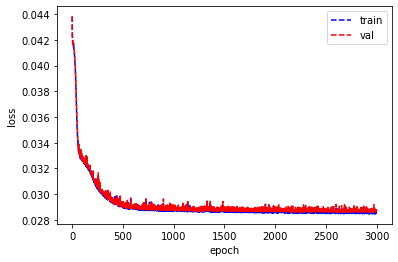

In [17]:
ax = plt.subplot(111)
ax.plot(np.arange(len(loss_train)), loss_train, 'b--')
ax.plot(np.arange(len(loss_val)), loss_val, 'r--')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_yscale("log")

ax.legend(["train","val"])
ax.figure.savefig("2-15-15-2,14,all-atom and h2t series latent space error.jpg")
plt.draw()

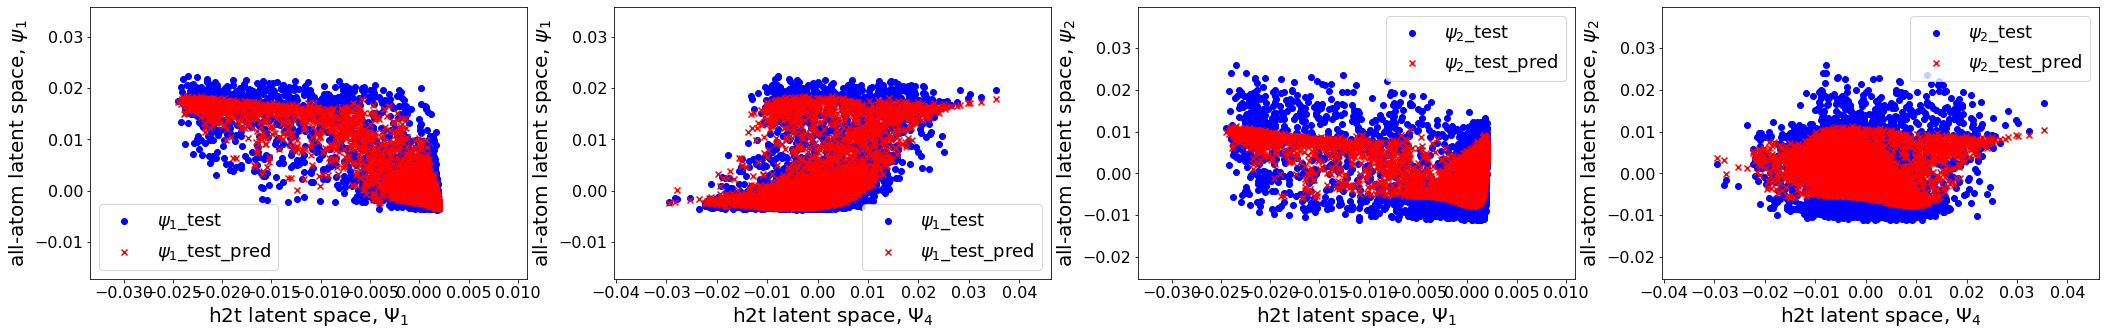

In [18]:
plt.figure(figsize=(36,5))

ax1 = plt.subplot(141)
ax1.scatter(x_test[:,0], y_test[:,0], c='blue', marker='o')
ax1.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax1.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax1.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax1.tick_params(labelsize=16)
ax1.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax2 = plt.subplot(142)
ax2.scatter(x_test[:,1], y_test[:,0], c='blue', marker='o')
ax2.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax2.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax2.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax2.tick_params(labelsize=16)
ax2.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax3 = plt.subplot(143)
ax3.scatter(x_test[:,0], y_test[:,1], c='blue', marker='o')
ax3.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax3.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax3.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax3.tick_params(labelsize=16)
ax3.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax4 = plt.subplot(144)
ax4.scatter(x_test[:,1], y_test[:,1], c='blue', marker='o')
ax4.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax4.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax4.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax4.tick_params(labelsize=16)
ax4.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax.figure.savefig("2-15-15-2,-14, all-atom and h2t series latent space correspondence.jpg")
plt.draw()

In [19]:
Y_train_pred_scale_back = yscale.inverse_transform(Y_train_pred)
Y_val_pred_scale_back = yscale.inverse_transform(Y_val_pred)
Y_test_pred_scale_back = yscale.inverse_transform(Y_test_pred)

In [20]:
diff_train_scale_back = Y_train_pred_scale_back - y_train
MSE_train_scale_back = np.sum(diff_train_scale_back**2) / diff_train_scale_back.shape[0]
print ("MSE_train = %f" % (MSE_train_scale_back))
print ("RMSE_train = %f" % (np.sqrt(MSE_train_scale_back)))

diff_val_scale_back = Y_val_pred_scale_back - y_val
MSE_val_scale_back = np.sum(diff_val_scale_back**2) / diff_val_scale_back.shape[0]
print ("MSE_val = %f" % (MSE_val_scale_back))
print ("RMSE_val = %f" % (np.sqrt(MSE_val_scale_back)))

diff_test_scale_back = Y_test_pred_scale_back - y_test
MSE_test_scale_back = np.sum(diff_test_scale_back**2) / diff_test_scale_back.shape[0]
print ("MSE_test = %f" % (MSE_test_scale_back))
print ("RMSE_test = %f" % (np.sqrt(MSE_test_scale_back)))

MSE_train = 0.000033
RMSE_train = 0.005777
MSE_val = 0.000033
RMSE_val = 0.005775
MSE_test = 0.000032
RMSE_test = 0.005678
